In [217]:
import pathlib
import chess
import chess.pgn
import chess.engine
import numpy as np
import h5py
import copy

In [199]:
# General space saving algorithms that are often used in chess programming sites

def board_to_arr(board: chess.Board):
    black, white = board.occupied_co

    bitboards = np.array([
        black & board.pawns,
        black & board.knights,
        black & board.bishops,
        black & board.rooks,
        black & board.queens,
        black & board.kings,
        white & board.pawns,
        white & board.knights,
        white & board.bishops,
        white & board.rooks,
        white & board.queens,
        white & board.kings,
    ], dtype=np.uint64)

    return bitboards

def bitboards_to_array(bb: np.ndarray) -> np.ndarray:
    bb = np.asarray(bb, dtype=np.uint64)[:, np.newaxis]
    s = 8 * np.arange(7, -1, -1, dtype=np.uint64)
    b = (bb >> s).astype(np.uint8)
    b = np.unpackbits(b, bitorder="little")
    return b.reshape(-1, 8, 8)


In [200]:
import urllib.request

def tos_violator(user, verbose=False):

    link = f"https://lichess.org/api/user/{user}"
    f = urllib.request.urlopen(link)
    myfile = f.read()
    if verbose: print(myfile)
    if "tosViolation" in str(myfile):
        return True
    return False

tos_violator('variantbunny')
tos_violator('micuentatmr')

True

In [226]:
def create_dataset(game):
    
    tmp_board = game.board()

    normal_positions = []
    cheater_positions = []
    normal_move_times = []
    cheater_move_times = []
    normal_time_left = []
    cheater_time_left = []
    normal_elo = []
    cheater_elo = []

    w_positions = []
    b_positions = []
    w_move_times = []
    b_move_times = []
    w_time_left = []
    b_time_left = []

    ply = 0
    
    for i, move in enumerate(game.mainline()):

        # find time taken to make move
        time_str = move.comment[move.comment.index("%clk")+7:-1].split(":")
        seconds_left = int(time_str[0])*60+int(time_str[1])

        if i % 2 == 0: # WHITE
            w_positions.append(board_to_arr(tmp_board))
            w_move_times.append(seconds_left)
        else: # BLACK
            b_positions.append(board_to_arr(tmp_board))
            b_move_times.append(seconds_left)
            
        ply += 1

        tmp_board.push_uci(move.move.uci())
        
    if ply == 0:
        return [], [], [], []
    
    # Convert to move times
    w_time_left = copy.deepcopy(w_move_times)
    b_time_left = copy.deepcopy(b_move_times)
    w_move_times = [0]+[abs(x - w_move_times[i - 1]) for i, x in enumerate(w_move_times)][1:]
    b_move_times = [0]+[abs(x - b_move_times[i - 1]) for i, x in enumerate(b_move_times)][1:]
    
    assert len(w_positions) == len(w_move_times)
    assert len(b_positions) == len(b_move_times)
    assert len(w_time_left) == len(w_move_times)
    assert len(b_time_left) == len(b_move_times)

    # Update arrays depending on game player
    if tos_violator(game.headers['White']):
        print(f"{game.headers['White']} information logged to cheat log.")
        cheater_positions += w_positions
        cheater_move_times += w_move_times
        cheater_time_left += w_time_left
        cheater_elo += [int(game.headers['WhiteElo'])] * len(w_positions) 
    else:
        normal_positions += w_positions
        normal_move_times += w_move_times
        normal_time_left += w_time_left
        normal_elo += [int(game.headers['WhiteElo'])] * len(w_positions) 

    if tos_violator(game.headers['Black']):
        print(f"{game.headers['Black']} information logged to cheat log.")
        cheater_positions += b_positions
        cheater_move_times += b_move_times
        cheater_time_left += b_time_left
        cheater_elo += [int(game.headers['BlackElo'])] * len(b_positions) 
    else:
        normal_positions += b_positions
        normal_move_times += b_move_times
        normal_time_left += b_time_left
        normal_elo += [int(game.headers['BlackElo'])] * len(b_positions) 
    
    return normal_positions, normal_move_times, normal_time_left, normal_elo, cheater_positions, cheater_move_times, cheater_time_left, cheater_elo


In [234]:
pgnGames = list(pathlib.Path('test_pgns').glob('*.pgn'))

npositions = []
ntimes = []
ntimeleft = []
nelo = []

cpositions = []
ctimes = []
ctimeleft = []
celo = []

for g in range(len(pgnGames)):
    pgn = open(pgnGames[g])
    
    for k in range(4000):  # 190,000 assures all games are looked at.
        
        try:
            game = chess.pgn.read_game(pgn)
            print(game)
            npos, nt, ntl, ne, cpos, ct, ctl, ce = create_dataset(game)
            npositions += npos
            ntimes += nt
            ntimeleft += ntl
            cpositions += cpos
            ctimes += ct
            ctimeleft += ctl
            nelo += ne
            celo += ce
            
            print(f"{k+1} games analyzed, dataset size {len(npositions)}/{len(ntimes)}/{len(ntimeleft)}/{len(nelo)}, {len(cpositions)}/{len(ctimes)}/{len(ctimeleft)}/{len(celo)}")
            print("---")
        except Exception as e:
            print(f"{e}")
            pass
          

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/h3P32B7l"]
[Date "2024.03.05"]
[Round "?"]
[White "j_coca"]
[Black "brokensouls"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:58:54"]
[WhiteElo "2272"]
[BlackElo "2136"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%eval -0.26] [%clk 0:01:30] } 1... e5 { [%eval 0.8] [%clk 0:01:30] } 2. fxe5 { [%eval 0.75] [%clk 0:01:29] } 2... d6 { [%eval 0.75] [%clk 0:01:30] } 3. exd6 { [%eval 0.57] [%clk 0:01:29] } 3... Bxd6 { [%eval 0.7] [%clk 0:01:29] } 4. Nf3 { [%eval 0.51] [%clk 0:01:29] } 4... g5 { [%eval 0.85] [%clk 0:01:28] } 5. d4 { [%eval 0.79] [%clk 0:01:28] } 5... g4 { [%eval 0.63] [%clk 0:01:27] } 6. Ng5 { [%eval -0.31] [%clk 0:01:27] } 6... h6 { [%eval 3.46] [%clk 0:01:25] } 7. Ne4 { [%eval 3.05] [%clk 0:01:27] } 7... Nc6 { [%eval 2.46] [%clk 0:01:19] } 8. c3 { [%eval 1.65] [%clk 0:01:26] } 8... Bf5 { [%eval 1.71] [

7 games analyzed, dataset size 199/199/199/199, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/j2ktmGqW"]
[Date "2024.03.05"]
[Round "?"]
[White "TNeagu"]
[Black "MhmdHsn"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:58:05"]
[WhiteElo "1895"]
[BlackElo "1753"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C24"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:58] } 3. d3 { [%clk 0:02:59] } 3... Bc5 { [%clk 0:02:57] } 4. Bb3 { [%clk 0:02:58] } 4... d6 { [%clk 0:02:56] } 5. Be3 { [%clk 0:02:58] } 5... Qe7 { [%clk 0:02:56] } 6. Nf3 { [%clk 0:02:57] } 6... Bxe3 { [%clk 0:02:54] } 7. fxe3 { [%clk 0:02:56] } 7... Bg4 { [%clk 0:02:53] } 8. h3 { [%clk 0:02:52] } 8... Bxf3 { [%clk 0:02:52] } 9. Qxf3 { [%clk 0:02:52] } 9... O-O { [%clk 0:02:50] } 10. g4 { [%clk 0:02:51] } 10... Nfd7 { [%clk 0:02:49] } 11. Nc3 { [%clk 0:02:51] } 11... c5 { [%

11 games analyzed, dataset size 431/431/431/431, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EVCPKfGn"]
[Date "2024.03.05"]
[Round "?"]
[White "sumbuleluchristopher"]
[Black "Garry2001"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:57:35"]
[WhiteElo "2107"]
[BlackElo "1784"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. c3 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:02:52] } 5. cxd4 { [%clk 0:02:57] } 5... e6 { [%clk 0:02:49] } 6. d5 { [%clk 0:02:55] } 6... exd5 { [%clk 0:02:46] } 7. exd5 { [%clk 0:02:55] } 7... Ne5 { [%clk 0:02:44] } 8. Nxe5 { [%clk 0:02:55] } 8... dxe5 { [%clk 0:02:43] } 9. Bb5+ { [%clk 0:02:54] } 9... Bd7 { [%clk 0:02:40] } 10. Qa4 { [%clk 0:02:52] } 10... a6 { [%clk 0:02:36] } 11. Bxd7+ { [%clk 0:02:

16 games analyzed, dataset size 760/760/760/760, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JZOcp5Bx"]
[Date "2024.03.05"]
[Round "?"]
[White "realcyberbird"]
[Black "Abdullah1508"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:57:09"]
[WhiteElo "2413"]
[BlackElo "2092"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D30"]
[Termination "Time forfeit"]

1. d4 { [%eval 0.15] [%clk 0:01:30] } 1... c6 { [%eval 0.32] [%clk 0:01:30] } 2. c4 { [%eval 0.31] [%clk 0:01:29] } 2... d5 { [%eval 0.28] [%clk 0:01:30] } 3. Nf3 { [%eval 0.23] [%clk 0:01:29] } 3... e6 { [%eval 0.36] [%clk 0:01:29] } 4. e3 { [%eval 0.41] [%clk 0:01:29] } 4... Nf6 { [%eval 0.34] [%clk 0:01:28] } 5. Nbd2 { [%eval 0.3] [%clk 0:01:29] } 5... Ne4 { [%eval 0.7] [%clk 0:01:27] } 6. Bd3 { [%eval 0.64] [%clk 0:01:28] } 6... f5 { [%eval 0.67] [%clk 0:01:26] } 7. O-O { [%eval 0.2] [%clk 0:01:27] } 7... Nd7 { [%eval 0.08] [%clk 0:

19 games analyzed, dataset size 1076/1076/1076/1076, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NtU0E69U"]
[Date "2024.03.05"]
[Round "?"]
[White "Ricosalsa92"]
[Black "Chess4030"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:57:09"]
[WhiteElo "1267"]
[BlackElo "1873"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. e5 { [%clk 0:02:57] } 2... d4 { [%clk 0:01:29] } 3. c3 { [%clk 0:02:55] } 3... c5 { [%clk 0:01:29] } 4. Nf3 { [%clk 0:02:51] } 4... e6 { [%clk 0:01:28] } 5. d3 { [%clk 0:02:43] } 5... Nc6 { [%clk 0:01:27] } 6. cxd4 { [%clk 0:02:41] } 6... Nxd4 { [%clk 0:01:26] } 7. Nxd4 { [%clk 0:02:41] } 7... cxd4 { [%clk 0:01:25] } 8. Qa4+ { [%clk 0:02:41] } 8... Qd7 { [%clk 0:01:22] } 9. Qxd7+ { [%clk 0:02:39] } 9... Bxd7 { [%clk 0:01:22] } 10. Bf4 { [%clk 0:02:37] } 10... Ne7 { [%clk 0:01:21] } 11. Nd2 { [%clk 0:02:36] } 

24 games analyzed, dataset size 1290/1290/1290/1290, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/s3w8NI5C"]
[Date "2024.03.05"]
[Round "?"]
[White "Diazch72"]
[Black "pranshukhandelwal"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:56:44"]
[WhiteElo "1639"]
[BlackElo "1600"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02:58] } 3... Qf6 { [%clk 0:01:29] } 4. h3 { [%clk 0:02:56] } 4... Bc5 { [%clk 0:01:28] } 5. d3 { [%clk 0:02:56] } 5... d6 { [%clk 0:01:28] } 6. Nc3 { [%clk 0:02:55] } 6... Qg6 { [%clk 0:01:27] } 7. Nh4 { [%clk 0:02:49] } 7... Qf6 { [%clk 0:01:23] } 8. Nf3 { [%clk 0:02:46] } 8... Nd4 { [%clk 0:01:22] } 9. Be3 { [%clk 0:02:44] } 9... Nxf3+ { [%clk 0:01:21] } 10. gxf3 { [%clk 0:02:43] } 10... Bxe3 { [%clk 0:01:21] } 11. fxe3 { [%clk 0:02:4

29 games analyzed, dataset size 1544/1544/1544/1544, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gkl59YfH"]
[Date "2024.03.05"]
[Round "?"]
[White "Elof2"]
[Black "Ferrerrosa67"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:56:44"]
[WhiteElo "1708"]
[BlackElo "1666"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A51"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:30] } 2... e5 { [%clk 0:02:58] } 3. e4 { [%clk 0:01:30] } 3... exd4 { [%clk 0:02:57] } 4. Qxd4 { [%clk 0:01:29] } 4... Nc6 { [%clk 0:02:56] } 5. Qe3 { [%clk 0:01:26] } 5... Ne5 { [%clk 0:02:46] } 6. f3 { [%clk 0:01:26] } 6... Bb4+ { [%clk 0:02:41] } 7. Nc3 { [%clk 0:01:24] } 7... O-O { [%clk 0:02:32] } 8. Bd2 { [%clk 0:01:21] } 8... a6 { [%clk 0:02:26] } 9. h4 { [%clk 0:01:15] } 9... c6 { [%clk 0:02:22] } 10. h5 { [%clk 0:01:15] } 10... d5 { [%clk 0:02:13] } 11. cxd5 { [%clk 0:01:12] } 11... cxd

33 games analyzed, dataset size 1833/1833/1833/1833, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6nvi3x6y"]
[Date "2024.03.05"]
[Round "?"]
[White "fanami961"]
[Black "Janis_Grigulis"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:56:16"]
[WhiteElo "2170"]
[BlackElo "2068"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B04"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. e5 { [%clk 0:02:58] } 2... Nd5 { [%clk 0:02:58] } 3. d4 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:58] } 4... g6 { [%clk 0:02:56] } 5. c4 { [%clk 0:02:55] } 5... Nb6 { [%clk 0:02:54] } 6. exd6 { [%clk 0:02:55] } 6... cxd6 { [%clk 0:02:53] } 7. Nc3 { [%clk 0:02:55] } 7... Bg7 { [%clk 0:02:53] } 8. Be3 { [%clk 0:02:53] } 8... O-O { [%clk 0:02:52] } 9. Be2 { [%clk 0:02:50] } 9... Nc6 { [%clk 0:02:51] } 10. Qd2 { [%clk 0:02:47] } 10... Bg4 { [%clk 0:02:51] } 11. b3 { [%clk 0:02:46] } 11

37 games analyzed, dataset size 2086/2086/2086/2086, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/eKrGYNUH"]
[Date "2024.03.05"]
[Round "?"]
[White "Polat0"]
[Black "Lipetsk-Kanst_54"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:56:16"]
[WhiteElo "1625"]
[BlackElo "1913"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. e3 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. g3 { [%clk 0:02:59] } 2... e6 { [%clk 0:01:30] } 3. Bg2 { [%clk 0:02:59] } 3... Nd7 { [%clk 0:01:30] } 4. Ne2 { [%clk 0:02:58] } 4... h6 { [%clk 0:01:30] } 5. f4 { [%clk 0:02:58] } 5... g6 { [%clk 0:01:29] } 6. b3 { [%clk 0:02:57] } 6... Bg7 { [%clk 0:01:29] } 7. Nbc3 { [%clk 0:02:55] } 7... Ne7 { [%clk 0:01:29] } 8. Bb2 { [%clk 0:02:55] } 8... O-O { [%clk 0:01:28] } 9. d4 { [%clk 0:02:54] } 9... Rb8 { [%clk 0:01:28] } 10. Qd3 { [%clk 0:02:53] } 10... a6 { [%clk 0:01:28] } 11. e4 { [%clk 0:02:51] } 1

42 games analyzed, dataset size 2412/2412/2412/2412, 0/0/0/0
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4p09zWCG"]
[Date "2024.03.05"]
[Round "?"]
[White "gaborszogi"]
[Black "xabichess"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:56:16"]
[WhiteElo "2177"]
[BlackElo "2113"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... c5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:30] } 2... cxd4 { [%clk 0:01:30] } 3. c3 { [%clk 0:01:29] } 3... Nc6 { [%clk 0:01:30] } 4. cxd4 { [%clk 0:01:28] } 4... d5 { [%clk 0:01:30] } 5. Bf4 { [%clk 0:01:27] } 5... Nf6 { [%clk 0:01:30] } 6. e3 { [%clk 0:01:27] } 6... a6 { [%clk 0:01:29] } 7. h3 { [%clk 0:01:26] } 7... Bf5 { [%clk 0:01:29] } 8. Bd3 { [%clk 0:01:25] } 8... Bxd3 { [%clk 0:01:27] } 9. Qxd3 { [%clk 0:01:25] } 9... e6 { [%clk 0:01:26] } 10. a3 { [%clk 0:01:25] } 10... Bd6 { [%clk 0:01:26] } 11. Bxd6 { [%clk 0:01:23] } 11...

Camusi information logged to cheat log.
45 games analyzed, dataset size 2617/2617/2617/2617, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6fWDgj7T"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "Janis_Grigulis"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:51"]
[WhiteElo "1773"]
[BlackElo "2078"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... g6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:01:30] } 3. Bc4 { [%clk 0:02:59] } 3... c5 { [%clk 0:01:29] } 4. Qf3 { [%clk 0:02:58] } 4... cxd4 { [%clk 0:01:29] } 5. Qxf7# { [%clk 0:02:57] } 1-0
46 games analyzed, dataset size 2626/2626/2626/2626, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/25aJIged"]
[Date "2024.03.05"]
[Round "?"]
[White "nicholas581"]
[Black "Oparush"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:5

49 games analyzed, dataset size 2829/2829/2829/2829, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vuqXZH4n"]
[Date "2024.03.05"]
[Round "?"]
[White "Gvozdodyor78"]
[Black "sunil_shakyawar4"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:51"]
[WhiteElo "2043"]
[BlackElo "1661"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C02"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. e5 { [%clk 0:01:28] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:01:27] } 3... Nc6 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:01:26] } 4... Bd7 { [%clk 0:02:58] } 5. f4 { [%clk 0:01:25] } 5... Qe7 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:01:25] } 6... O-O-O { [%clk 0:02:57] } 7. O-O { [%clk 0:01:24] } 7... Kb8 { [%clk 0:02:56] } 8. Nbd2 { [%clk 0:01:23] } 8... Rc8 { [%clk 0:02:56] } 9. c4 { [%clk 0:01:22] } 9... h5 { [%clk 0:02:55] } 10. c5 { [%clk 0:01:21] } 10... h4 { [%clk 0:02:53] } 11. a3 { [%clk 0:01:18

53 games analyzed, dataset size 3040/3040/3040/3040, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vYJpNPtV"]
[Date "2024.03.05"]
[Round "?"]
[White "rahul_rajeev25"]
[Black "Basman1966"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:51"]
[WhiteElo "1897"]
[BlackElo "2194"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. e4 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... c6 { [%clk 0:02:55] } 4. Nf3 { [%clk 0:02:58] } 4... d5 { [%clk 0:02:54] } 5. exd5 { [%clk 0:02:56] } 5... cxd5 { [%clk 0:02:53] } 6. Bd3 { [%clk 0:02:55] } 6... Nc6 { [%clk 0:02:52] } 7. Be3 { [%clk 0:02:55] } 7... Bg4 { [%clk 0:02:48] } 8. Nbd2 { [%clk 0:02:54] } 8... e6 { [%clk 0:02:47] } 9. c3 { [%clk 0:02:51] } 9... Nge7 { [%clk 0:02:46] } 10. Qc2 { [%clk 0:02:50] } 10... O-O { [%clk 0:02:44] } 11. h3 { [%clk 0:02:49

56 games analyzed, dataset size 3270/3270/3270/3270, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gR3RMBhw"]
[Date "2024.03.05"]
[Round "?"]
[White "anarchist1"]
[Black "serbishen"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:51"]
[WhiteElo "1899"]
[BlackElo "1669"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... d4 { [%clk 0:02:58] } 3. Nce2 { [%clk 0:02:59] } 3... f6 { [%clk 0:02:55] } 4. d3 { [%clk 0:02:58] } 4... e5 { [%clk 0:02:54] } 5. f4 { [%clk 0:02:58] } 5... Bd6 { [%clk 0:02:49] } 6. Nf3 { [%clk 0:02:57] } 6... Nd7 { [%clk 0:02:40] } 7. fxe5 { [%clk 0:02:44] } 7... Bxe5 { [%clk 0:02:37] } 8. Nfxd4 { [%clk 0:02:42] } 8... c5 { [%clk 0:02:20] } 9. Ne6 { [%clk 0:02:38] } 9... Qe7 { [%clk 0:02:17] } 10. Bf4 { [%clk 0:02:32] } 10... Qxe6 { [%clk 0:02:14] } 11. Bxe5 { [%clk 0:02:31] 

61 games analyzed, dataset size 3502/3502/3502/3502, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OR66f7VT"]
[Date "2024.03.05"]
[Round "?"]
[White "chumbichess"]
[Black "a2003l2003"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:51"]
[WhiteElo "1827"]
[BlackElo "1727"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... c5 { [%clk 0:02:58] } 3. c4 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:58] } 4. e3 { [%clk 0:02:56] } 4... Bg4 { [%clk 0:02:52] } 5. Be2 { [%clk 0:02:55] } 5... e6 { [%clk 0:02:51] } 6. O-O { [%clk 0:02:53] } 6... Nf6 { [%clk 0:02:50] } 7. h3 { [%clk 0:02:51] } 7... Bh5 { [%clk 0:02:48] } 8. Nc3 { [%clk 0:02:46] } 8... Be7 { [%clk 0:02:45] } 9. b3 { [%clk 0:02:43] } 9... O-O { [%clk 0:02:43] } 10. Bb2 { [%clk 0:02:42] } 10... Ne4 { [%clk 0:02:33] } 11. cxd5 { [%clk 0:02:37] } 11

66 games analyzed, dataset size 3793/3793/3793/3793, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/s7oR3CZ0"]
[Date "2024.03.05"]
[Round "?"]
[White "Schachmatizi"]
[Black "Santex_2022"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:26"]
[WhiteElo "1925"]
[BlackElo "1898"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. dxc5 { [%clk 0:02:58] } 2... e6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:55] } 3... Bxc5 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:02:54] } 4... d5 { [%clk 0:02:58] } 5. e3 { [%clk 0:02:52] } 5... Nf6 { [%clk 0:02:57] } 6. Bb5+ { [%clk 0:02:51] } 6... Nc6 { [%clk 0:02:56] } 7. Bxc6+ { [%clk 0:02:49] } 7... bxc6 { [%clk 0:02:55] } 8. Bd2 { [%clk 0:02:49] } 8... e5 { [%clk 0:02:51] } 9. O-O { [%clk 0:02:46] } 9... e4 { [%clk 0:02:50] } 10. Nd4 { [%clk 0:02:44] } 10... Bd7 { [%clk 0:02:48] } 11. Na4 { [%clk

70 games analyzed, dataset size 4007/4007/4007/4007, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Gicp3m93"]
[Date "2024.03.05"]
[Round "?"]
[White "Man_victory"]
[Black "Eluqui22"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:26"]
[WhiteElo "1367"]
[BlackElo "1749"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... exd4 { [%clk 0:02:59] } 3. Qxd4 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. Qe3+ { [%clk 0:02:57] } 4... Be7 { [%clk 0:02:56] } 5. Bg2 { [%clk 0:02:56] } 5... O-O { [%clk 0:02:55] } 6. Nc3 { [%clk 0:02:54] } 6... Nc6 { [%clk 0:02:52] } 7. h4 { [%clk 0:02:52] } 7... Re8 { [%clk 0:02:51] } 8. Bxc6 { [%clk 0:02:51] } 8... dxc6 { [%clk 0:02:50] } 9. h5 { [%clk 0:02:49] } 9... Bb4 { [%clk 0:02:46] } 10. Qf4 { [%clk 0:02:39] } 10... Ne4 { [%clk 0:02:33] } 11. Nf3 { [%clk 0:02:15]

74 games analyzed, dataset size 4255/4255/4255/4255, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4D0e6NdI"]
[Date "2024.03.05"]
[Round "?"]
[White "urbad987654321"]
[Black "bogdoris"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:26"]
[WhiteElo "1563"]
[BlackElo "1745"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:55] } 3... d6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:53] } 4... Bg4 { [%clk 0:02:55] } 5. Bb5 { [%clk 0:02:52] } 5... Ne7 { [%clk 0:02:53] } 6. d3 { [%clk 0:02:51] } 6... g6 { [%clk 0:02:51] } 7. O-O { [%clk 0:02:50] } 7... Bg7 { [%clk 0:02:49] } 8. Qe2 { [%clk 0:02:43] } 8... O-O { [%clk 0:02:46] } 9. Be3 { [%clk 0:02:42] } 9... exf4 { [%clk 0:02:42] } 10. Bxf4 { [%clk 0:02:41] } 10... Nd4 { [%clk 0:02:41] } 11. Bc4 { [%clk 0:02:36] 

80 games analyzed, dataset size 4447/4447/4447/4447, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DeBJ457E"]
[Date "2024.03.05"]
[Round "?"]
[White "kabbridd"]
[Black "Virgo-Shaka"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:01"]
[WhiteElo "2052"]
[BlackElo "2152"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B76"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:02:57] } 5... g6 { [%clk 0:02:57] } 6. Be3 { [%clk 0:02:55] } 6... Bg7 { [%clk 0:02:56] } 7. f3 { [%clk 0:02:55] } 7... O-O { [%clk 0:02:56] } 8. Qd2 { [%clk 0:02:54] } 8... Nc6 { [%clk 0:02:55] } 9. O-O-O { [%clk 0:02:53] } 9... d5 { [%clk 0:02:55] } 10. Nxc6 { [%clk 0:02:51] } 10... bxc6 { [%clk 0:02:53] } 11. exd5 { [%clk 0:02:51]

84 games analyzed, dataset size 4734/4734/4734/4734, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/N8Nv2Hyz"]
[Date "2024.03.05"]
[Round "?"]
[White "smilefemto"]
[Black "Vladymyr63"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:01"]
[WhiteElo "1754"]
[BlackElo "1800"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... exd4 { [%clk 0:02:58] } 3. Qxd4 { [%clk 0:03:00] } 3... Nc6 { [%clk 0:02:56] } 4. Qd1 { [%clk 0:02:58] } 4... g6 { [%clk 0:02:54] } 5. Nf3 { [%clk 0:02:58] } 5... Bg7 { [%clk 0:02:53] } 6. e4 { [%clk 0:02:57] } 6... Nge7 { [%clk 0:02:51] } 7. Bd2 { [%clk 0:02:56] } 7... O-O { [%clk 0:02:50] } 8. Bc4 { [%clk 0:02:55] } 8... Ne5 { [%clk 0:02:42] } 9. Nxe5 { [%clk 0:02:53] } 9... Bxe5 { [%clk 0:02:41] } 10. Bd3 { [%clk 0:02:52] } 10... d6 { [%clk 0:02:38] } 11. f4 { [%clk 0:

88 games analyzed, dataset size 5007/5007/5007/5007, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6aZrgHU7"]
[Date "2024.03.05"]
[Round "?"]
[White "AlexanderCot"]
[Black "Hamletsway"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:01"]
[WhiteElo "1753"]
[BlackElo "1957"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... e6 { [%clk 0:01:30] } 4. d4 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:01:30] } 5. Nxd4 { [%clk 0:02:56] } 5... Nd7 { [%clk 0:01:30] } 6. Bb5 { [%clk 0:02:54] } 6... a6 { [%clk 0:01:30] } 7. Bxd7+ { [%clk 0:02:54] } 7... Bxd7 { [%clk 0:01:30] } 8. Be3 { [%clk 0:02:53] } 8... h6 { [%clk 0:01:29] } 9. O-O { [%clk 0:02:52] } 9... Nf6 { [%clk 0:01:29] } 10. Nde2 { [%clk 0:02:51] } 10... b5 { [%clk 0:01:29] } 11. f3 { [%clk 0:02:50]

92 games analyzed, dataset size 5292/5292/5292/5292, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SaZmBRx2"]
[Date "2024.03.05"]
[Round "?"]
[White "WhiskeyDrinker"]
[Black "Rosario_Cueva32"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:55:01"]
[WhiteElo "2008"]
[BlackElo "1640"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nf3 { [%eval 0.22] [%clk 0:01:29] } 2... d6 { [%eval 0.0] [%clk 0:03:00] } 3. d4 { [%eval 0.18] [%clk 0:01:28] } 3... Nf6 { [%eval 0.3] [%clk 0:03:00] } 4. e5 { [%eval 0.13] [%clk 0:01:25] } 4... dxe5 { [%eval 0.0] [%clk 0:02:59] } 5. dxe5 { [%eval -0.27] [%clk 0:01:25] } 5... Qxd1+ { [%eval -0.09] [%clk 0:02:58] } 6. Kxd1 { [%eval -0.29] [%clk 0:01:24] } 6... Ne4 { [%eval 0.79] [%clk 0:02:57] } 7. Ke2 { [%eval 0.0] [%clk 0:01:21] } 7... Bd7 { [%eval 0.25] [%clk 

95 games analyzed, dataset size 5559/5559/5559/5559, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kZi4HUxz"]
[Date "2024.03.05"]
[Round "?"]
[White "ahmudinnn"]
[Black "DuloClan"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:36"]
[WhiteElo "1782"]
[BlackElo "1878"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:01:29] } 3. f4 { [%clk 0:01:30] } 3... f5 { [%clk 0:01:28] } 4. Nf3 { [%clk 0:01:30] } 4... fxe4 { [%clk 0:01:27] } 5. Nxe5 { [%clk 0:01:29] } 5... Nf6 { [%clk 0:01:25] } 6. Bb5 { [%clk 0:01:27] } 6... Bc5 { [%clk 0:01:23] } 7. d4 { [%clk 0:01:24] } 7... exd3 { [%clk 0:01:21] } 8. Qxd3 { [%clk 0:01:23] } 8... O-O { [%clk 0:01:20] } 9. Bc4+ { [%clk 0:01:20] } 9... d5 { [%clk 0:01:17] } 10. Nf7 { [%clk 0:01:20] } 10... Qe7+ { [%clk 0:01:07] } 11. Qe2 { [%clk 0:01

98 games analyzed, dataset size 5807/5807/5807/5807, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7KWaJhLt"]
[Date "2024.03.05"]
[Round "?"]
[White "efrenamo"]
[Black "Tekitotuelo_chess"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:36"]
[WhiteElo "1828"]
[BlackElo "2058"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B12"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. e5 { [%clk 0:02:59] } 3... Bf5 { [%clk 0:02:58] } 4. c3 { [%clk 0:02:58] } 4... e6 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:57] } 5... Nd7 { [%clk 0:02:56] } 6. h3 { [%clk 0:02:56] } 6... a6 { [%clk 0:02:54] } 7. Bd3 { [%clk 0:02:55] } 7... Bg6 { [%clk 0:02:53] } 8. O-O { [%clk 0:02:54] } 8... c5 { [%clk 0:02:52] } 9. Bc2 { [%clk 0:02:52] } 9... cxd4 { [%clk 0:02:50] } 10. cxd4 { [%clk 0:02:50] } 10... Rc8 { [%clk 0:02:50] } 11. Nc3 { [%clk 0:02:48] }

101 games analyzed, dataset size 6083/6083/6083/6083, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/mZI9Bywm"]
[Date "2024.03.05"]
[Round "?"]
[White "tetrapodo"]
[Black "german11"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:36"]
[WhiteElo "1775"]
[BlackElo "1356"]
[WhiteRatingDiff "-17"]
[BlackRatingDiff "+11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... d6 { [%clk 0:02:59] } 3. dxe5 { [%clk 0:02:59] } 3... Nd7 { [%clk 0:02:57] } 4. exd6 { [%clk 0:02:58] } 4... cxd6 { [%clk 0:02:55] } 5. Bf4 { [%clk 0:02:54] } 5... Ne5 { [%clk 0:02:32] } 6. Bxe5 { [%clk 0:02:51] } 6... dxe5 { [%clk 0:02:30] } 7. Qxd8+ { [%clk 0:02:51] } 7... Kxd8 { [%clk 0:02:27] } 8. Nc3 { [%clk 0:02:50] } 8... Nf6 { [%clk 0:02:25] } 9. O-O-O+ { [%clk 0:02:50] } 9... Kc7 { [%clk 0:02:16] } 10. Nf3 { [%clk 0:02:47] } 10... Bb4 { [%clk 0:02:13] } 11. Nxe5 {

105 games analyzed, dataset size 6332/6332/6332/6332, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/QwX36ROL"]
[Date "2024.03.05"]
[Round "?"]
[White "AAI86"]
[Black "AndrzejRusinek"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:36"]
[WhiteElo "1888"]
[BlackElo "1794"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... b6 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:57] } 3... Bb7 { [%clk 0:03:00] } 4. f3 { [%clk 0:02:57] } 4... Be7 { [%clk 0:03:00] } 5. Bf4 { [%clk 0:02:55] } 5... a5 { [%clk 0:03:00] } 6. a4 { [%clk 0:02:54] } 6... h5 { [%clk 0:03:00] } 7. h4 { [%clk 0:02:52] } 7... Nf6 { [%clk 0:02:58] } 8. Bd3 { [%clk 0:02:46] } 8... Nh7 { [%clk 0:02:57] } 9. Bg3 { [%clk 0:02:43] } 9... g5 { [%clk 0:02:54] } 10. hxg5 { [%clk 0:02:41] } 10... Nxg5 { [%clk 0:02:53] } 11. Nge2 { [%clk 0:02:38] } 11.

110 games analyzed, dataset size 6662/6662/6662/6662, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5kj0F4RZ"]
[Date "2024.03.05"]
[Round "?"]
[White "kldnsr"]
[Black "Pisanovskiy_Maxim"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:36"]
[WhiteElo "1640"]
[BlackElo "2164"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. g3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:59] } 4... Be7 { [%clk 0:02:57] } 5. Ne2 { [%clk 0:02:59] } 5... O-O { [%clk 0:02:57] } 6. b3 { [%clk 0:02:58] } 6... c5 { [%clk 0:02:56] } 7. Bb2 { [%clk 0:02:58] } 7... Nc6 { [%clk 0:02:53] } 8. dxc5 { [%clk 0:02:57] } 8... Bxc5 { [%clk 0:02:53] } 9. Nbc3 { [%clk 0:02:56] } 9... a6 { [%clk 0:02:48] } 10. a3 { [%clk 0:02:54] } 10... Qe7 { [%clk 0:02:40] } 11. Qd2 { [%clk 0:0

113 games analyzed, dataset size 7043/7043/7043/7043, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SMm0US3i"]
[Date "2024.03.05"]
[Round "?"]
[White "Viktor_Tahirov555"]
[Black "Abdullah1508"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "2311"]
[BlackElo "2095"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:01:30] } 1... c6 { [%clk 0:01:30] } 2. g3 { [%clk 0:01:30] } 2... d5 { [%clk 0:01:29] } 3. Bg2 { [%clk 0:01:30] } 3... Bh3 { [%clk 0:01:29] } 4. Bxh3 { [%clk 0:01:28] } 4... e6 { [%clk 0:01:28] } 5. Bg2 { [%clk 0:01:28] } 5... f5 { [%clk 0:01:28] } 6. O-O { [%clk 0:01:28] } 6... Nf6 { [%clk 0:01:28] } 7. d4 { [%clk 0:01:27] } 7... e5 { [%clk 0:01:28] } 8. dxe5 { [%clk 0:01:26] } 8... Ne4 { [%clk 0:01:27] } 9. Nbd2 { [%clk 0:01:25] } 9... Bc5 { [%clk 0:01:26] } 10. Nxe4 { [%clk 0:01:24] } 10... fxe4 { [%clk 0:01:26] } 11. Nd4 {

116 games analyzed, dataset size 7342/7342/7342/7342, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OTCxo1LD"]
[Date "2024.03.05"]
[Round "?"]
[White "CHESSENGINE900"]
[Black "SergLazy"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "2288"]
[BlackElo "2192"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Abandoned"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JCtJPyFF"]
[Date "2024.03.05"]
[Round "?"]
[White "viktor300560"]
[Black "djoer6"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "1933"]
[BlackElo "1888"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C54"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... Bc5 { [%

121 games analyzed, dataset size 7590/7590/7590/7590, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HKfUUtlN"]
[Date "2024.03.05"]
[Round "?"]
[White "tomrugby"]
[Black "NuriyeNur"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "1613"]
[BlackElo "2200"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. exd5 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:01:29] } 3. Nc3 { [%clk 0:02:57] } 3... Bg4 { [%clk 0:01:29] } 4. f3 { [%clk 0:02:53] } 4... Bf5 { [%clk 0:01:27] } 5. Bc4 { [%clk 0:02:50] } 5... Nbd7 { [%clk 0:01:23] } 6. Bb3 { [%clk 0:02:46] } 6... Nb6 { [%clk 0:01:22] } 7. Nge2 { [%clk 0:02:41] } 7... Nfxd5 { [%clk 0:01:20] } 8. Nxd5 { [%clk 0:02:40] } 8... Nxd5 { [%clk 0:01:20] } 9. O-O { [%clk 0:02:38] } 9... e6 { [%clk 0:01:19] } 10. d3 { [%clk 0:02:36] } 10... Bc5+ { [%clk 0:01:17] } 11. d4 { [%clk 0

124 games analyzed, dataset size 7887/7887/7887/7887, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/RFqWGCsN"]
[Date "2024.03.05"]
[Round "?"]
[White "neverheardthatbefore"]
[Black "tom_Brok"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "1705"]
[BlackElo "2112"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... Nxe4 { [%clk 0:02:58] } 4. Qd3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:57] } 5... g6 { [%clk 0:02:55] } 6. Bg5 { [%clk 0:02:56] } 6... Bg7 { [%clk 0:02:54] } 7. O-O-O { [%clk 0:02:55] } 7... O-O { [%clk 0:02:52] } 8. g3 { [%clk 0:02:55] } 8... Nc6 { [%clk 0:02:51] } 9. h4 { [%clk 0:02:53] } 9... Bg4 { [%clk 0:02:50] } 10. Bg2 { [%clk 0:02:52] } 10... e5 { [%clk 0:02:47] } 11. dxe5 { [%clk 0

128 games analyzed, dataset size 8139/8139/8139/8139, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zGB6PhSu"]
[Date "2024.03.05"]
[Round "?"]
[White "PlaySoCool"]
[Black "HSV4everandever"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "1914"]
[BlackElo "2423"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A16"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... c5 { [%clk 0:02:58] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:57] } 4. Qxd4 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:02:57] } 5. Qd1 { [%clk 0:02:59] } 5... g6 { [%clk 0:02:55] } 6. e3 { [%clk 0:02:59] } 6... Bg7 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:02:59] } 7... O-O { [%clk 0:02:54] } 8. Be2 { [%clk 0:02:59] } 8... d6 { [%clk 0:02:44] } 9. O-O { [%clk 0:02:58] } 9... Be6 { [%clk 0:02:38] } 10. Nd5 { [%clk 0:02:56] } 10... Rc8 { [%clk 0:02:22] } 11. Ng5 { [%clk 0:02:

131 games analyzed, dataset size 8408/8408/8408/8408, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/eaAw5PNs"]
[Date "2024.03.05"]
[Round "?"]
[White "The_Flaggship"]
[Black "DrunkChessEngine"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "2215"]
[BlackElo "1647"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C03"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nd2 { [%clk 0:02:59] } 3... Ne7 { [%clk 0:02:54] } 4. e5 { [%clk 0:02:56] } 4... Nbc6 { [%clk 0:02:53] } 5. c3 { [%clk 0:02:55] } 5... Bd7 { [%clk 0:02:51] } 6. f4 { [%clk 0:02:55] } 6... Ng6 { [%clk 0:02:50] } 7. Ndf3 { [%clk 0:02:54] } 7... Nce7 { [%clk 0:02:41] } 8. Bd3 { [%clk 0:02:53] } 8... Rc8 { [%clk 0:02:35] } 9. Ne2 { [%clk 0:02:52] } 9... c5 { [%clk 0:02:34] } 10. Be3 { [%clk 0:02:52] } 10... cxd4 { [%clk 0:02:33] } 11. Nexd4 {

135 games analyzed, dataset size 8726/8726/8726/8726, 52/52/52/52
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/eB4g8Gfe"]
[Date "2024.03.05"]
[Round "?"]
[White "zaklemap"]
[Black "terubi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:54:11"]
[WhiteElo "779"]
[BlackElo "1735"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B13"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:01:30] } 2. e4 { [%clk 0:02:24] } 2... d5 { [%clk 0:01:30] } 3. exd5 { [%clk 0:02:22] } 3... cxd5 { [%clk 0:01:29] } 4. Nc3 { [%clk 0:02:19] } 4... Nf6 { [%clk 0:01:26] } 5. Bb5+ { [%clk 0:02:17] } 5... Nc6 { [%clk 0:01:23] } 6. Bxc6+ { [%clk 0:02:14] } 6... bxc6 { [%clk 0:01:23] } 7. Bg5 { [%clk 0:01:59] } 7... h6 { [%clk 0:01:22] } 8. Bxf6 { [%clk 0:01:58] } 8... exf6 { [%clk 0:01:22] } 9. Qe2+ { [%clk 0:01:52] } 9... Be7 { [%clk 0:01:20] } 10. O-O-O { [%clk 0:01:50] } 10... O-O { [%clk 0:01:18] } 11. Nf3 { [%clk 0:01:48

138 games analyzed, dataset size 8921/8921/8921/8921, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7DS3YDyW"]
[Date "2024.03.05"]
[Round "?"]
[White "Janis_Grigulis"]
[Black "chesschesschess2008"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "2075"]
[BlackElo "1886"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. f4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:02:59] } 3. g3 { [%clk 0:01:29] } 3... Bg4 { [%clk 0:02:58] } 4. Bg2 { [%clk 0:01:28] } 4... Qd6 { [%clk 0:02:57] } 5. O-O { [%clk 0:01:27] } 5... O-O-O { [%clk 0:02:56] } 6. d3 { [%clk 0:01:27] } 6... h5 { [%clk 0:02:55] } 7. Qe1 { [%clk 0:01:25] } 7... h4 { [%clk 0:02:54] } 8. Nxh4 { [%clk 0:01:24] } 8... Rxh4 { [%clk 0:02:53] } 9. gxh4 { [%clk 0:01:23] } 9... f5 { [%clk 0:02:50] } 10. Nc3 { [%clk 0:01:22] } 10... Qc5+ { [%clk 0:02:49] } 11. Kh1 { 

141 games analyzed, dataset size 9177/9177/9177/9177, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/krNGnRSW"]
[Date "2024.03.05"]
[Round "?"]
[White "Tovenaar1964"]
[Black "carlsen89"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "2235"]
[BlackElo "2126"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... c5 { [%clk 0:02:59] } 3. c4 { [%clk 0:03:00] } 3... Nd7 { [%clk 0:02:58] } 4. cxd5 { [%clk 0:02:58] } 4... Ngf6 { [%clk 0:02:53] } 5. Nc3 { [%clk 0:02:53] } 5... b6 { [%clk 0:02:51] } 6. e4 { [%clk 0:02:51] } 6... Bb7 { [%clk 0:02:50] } 7. Be2 { [%clk 0:02:48] } 7... g6 { [%clk 0:02:49] } 8. O-O { [%clk 0:02:47] } 8... Bg7 { [%clk 0:02:48] } 9. Be3 { [%clk 0:02:45] } 9... O-O { [%clk 0:02:47] } 10. h3 { [%clk 0:02:43] } 10... Rc8 { [%clk 0:02:45] } 11. Rc1 { [%clk 0:02:41] } 

144 games analyzed, dataset size 9438/9438/9438/9438, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CVW75zQY"]
[Date "2024.03.05"]
[Round "?"]
[White "AlexImanol"]
[Black "CLMAPEYA"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "1801"]
[BlackElo "1645"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... Bc5 { [%clk 0:02:59] } 3. d3 { [%clk 0:02:54] } 3... Bxf2+ { [%clk 0:02:58] } 4. Kxf2 { [%clk 0:02:52] } 4... Nf6 { [%clk 0:02:58] } 5. Be3 { [%clk 0:02:52] } 5... c6 { [%clk 0:02:56] } 6. h3 { [%clk 0:02:51] } 6... d5 { [%clk 0:02:53] } 7. exd5 { [%clk 0:02:50] } 7... cxd5 { [%clk 0:02:51] } 8. Nce2 { [%clk 0:02:47] } 8... O-O { [%clk 0:02:49] } 9. g4 { [%clk 0:02:46] } 9... e4 { [%clk 0:02:44] } 10. dxe4 { [%clk 0:02:45] } 10... Nxe4+ { [%clk 0:02:41] } 11. Kg2 { [%clk 0:02:37

148 games analyzed, dataset size 9690/9690/9690/9690, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZOY9dFoN"]
[Date "2024.03.05"]
[Round "?"]
[White "ymous"]
[Black "sam_mwaura"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "1620"]
[BlackElo "1725"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Bc4 { [%eval 0.0] [%clk 0:02:59] } 2... Bc5 { [%eval 0.31] [%clk 0:02:59] } 3. a3 { [%eval -0.02] [%clk 0:02:58] } 3... Qf6 { [%eval 0.48] [%clk 0:02:57] } 4. Qe2 { [%eval 0.08] [%clk 0:02:56] } 4... a6 { [%eval 0.1] [%clk 0:02:56] } 5. d3 { [%eval 0.08] [%clk 0:02:54] } 5... c6 { [%eval 0.84] [%clk 0:02:53] } 6. h3 { [%eval 0.23] [%clk 0:02:53] } 6... h6 { [%eval 0.46] [%clk 0:02:52] } 7. Nf3 { [%eval 0.35] [%clk 0:02:52] } 7... Ne7 { [%eval 0.48] [%clk 0:02:49] } 8. Nc3 { [%e

151 games analyzed, dataset size 9923/9923/9923/9923, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jTfJP0bz"]
[Date "2024.03.05"]
[Round "?"]
[White "Erwin99"]
[Black "CATORCE"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "1642"]
[BlackElo "2173"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C71"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:02:59] } 3... a6 { [%clk 0:02:57] } 4. Ba4 { [%clk 0:02:58] } 4... d6 { [%clk 0:02:57] } 5. h3 { [%clk 0:02:56] } 5... f5 { [%clk 0:02:54] } 6. exf5 { [%clk 0:02:55] } 6... Bxf5 { [%clk 0:02:54] } 7. c3 { [%clk 0:02:48] } 7... Nf6 { [%clk 0:02:53] } 8. d4 { [%clk 0:02:46] } 8... e4 { [%clk 0:02:51] } 9. Nh4 { [%clk 0:02:43] } 9... Bd7 { [%clk 0:02:39] } 10. g4 { [%clk 0:02:31] } 10... Be7 { [%clk 0:02:29] } 11. g5 { [%clk 0:02:26] } 11..

156 games analyzed, dataset size 10183/10183/10183/10183, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/b7qO7Tza"]
[Date "2024.03.05"]
[Round "?"]
[White "Fantazzini"]
[Black "pelafer"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "1937"]
[BlackElo "1604"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A10"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... dxc4 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:56] } 4. Bxc4 { [%clk 0:02:57] } 4... Bg7 { [%clk 0:02:55] } 5. Nf3 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:02:52] } 6. d4 { [%clk 0:02:53] } 6... O-O { [%clk 0:02:51] } 7. h3 { [%clk 0:02:52] } 7... Nbd7 { [%clk 0:02:50] } 8. Be3 { [%clk 0:02:44] } 8... b6 { [%clk 0:02:49] } 9. O-O { [%clk 0:02:41] } 9... Bb7 { [%clk 0:02:48] } 10. Qc2 { [%clk 0:02:37] } 10... a5 { [%clk 0:02:45] } 11. Rfe1 { [%clk 0:02:30] 

161 games analyzed, dataset size 10526/10526/10526/10526, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4yXFrckE"]
[Date "2024.03.05"]
[Round "?"]
[White "JanHartl"]
[Black "FunnyF"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:44"]
[WhiteElo "1872"]
[BlackElo "1390"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... c6 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:57] } 3... Na6 { [%clk 0:03:00] } 4. d5 { [%clk 0:02:55] } 4... e5 { [%clk 0:02:58] } 5. f4 { [%clk 0:02:49] } 5... Bd6 { [%clk 0:02:53] } 6. Nf3 { [%clk 0:02:48] } 6... exf4 { [%clk 0:02:51] } 7. e5 { [%clk 0:02:46] } 7... Bb4+ { [%clk 0:02:47] } 8. Nc3 { [%clk 0:02:45] } 8... Bxc3+ { [%clk 0:02:45] } 9. bxc3 { [%clk 0:02:43] } 9... Nc5 { [%clk 0:02:43] } 10. Bxf4 { [%clk 0:02:40] } 10... d6 { [%clk 0:02:40] } 11. exd6 { [%clk 0:02:35] } 

165 games analyzed, dataset size 10791/10791/10791/10791, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/t1fgSSTm"]
[Date "2024.03.05"]
[Round "?"]
[White "djoer6"]
[Black "SergLazy"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:18"]
[WhiteElo "1890"]
[BlackElo "2190"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B29"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:56] } 3... Nc6 { [%clk 0:02:59] } 4. d3 { [%clk 0:02:55] } 4... d5 { [%clk 0:02:58] } 5. g3 { [%clk 0:02:55] } 5... dxe4 { [%clk 0:02:56] } 6. dxe4 { [%clk 0:02:53] } 6... Qxd1+ { [%clk 0:02:55] } 7. Kxd1 { [%clk 0:02:49] } 7... Bg4 { [%clk 0:02:54] } 8. Be2 { [%clk 0:02:47] } 8... O-O-O+ { [%clk 0:02:50] } 9. Ke1 { [%clk 0:02:45] } 9... Nb4 { [%clk 0:02:50] } 10. Bd3 { [%clk 0:02:38] } 10... Bxf3 { [%clk 0:02:48] } 0-1
166 games analyz

168 games analyzed, dataset size 11056/11056/11056/11056, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HgexHRBJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Vlad_95"]
[Black "Lemech-2"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:18"]
[WhiteElo "2236"]
[BlackElo "2466"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E11"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:59] } 3... Bb4+ { [%clk 0:02:57] } 4. Bd2 { [%clk 0:02:58] } 4... Qe7 { [%clk 0:02:57] } 5. g3 { [%clk 0:02:57] } 5... Nc6 { [%clk 0:02:55] } 6. Bg2 { [%clk 0:02:56] } 6... Bxd2+ { [%clk 0:02:53] } 7. Nbxd2 { [%clk 0:02:56] } 7... d6 { [%clk 0:02:51] } 8. O-O { [%clk 0:02:55] } 8... O-O { [%clk 0:02:50] } 9. Rc1 { [%clk 0:02:54] } 9... a5 { [%clk 0:02:48] } 10. a3 { [%clk 0:02:54] } 10... a4 { [%clk 0:02:47] } 11. Qc2 { [%clk 0:02:52] }

171 games analyzed, dataset size 11336/11336/11336/11336, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yWIlwt3x"]
[Date "2024.03.05"]
[Round "?"]
[White "PP0852"]
[Black "Eyaku_Alfred"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:18"]
[WhiteElo "2226"]
[BlackElo "2088"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C13"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e6 { [%eval 0.0] [%clk 0:03:00] } 2. d4 { [%eval 0.39] [%clk 0:02:58] } 2... d5 { [%eval 0.21] [%clk 0:03:00] } 3. Nc3 { [%eval 0.0] [%clk 0:02:57] } 3... Nf6 { [%eval 0.0] [%clk 0:02:59] } 4. Bg5 { [%eval 0.08] [%clk 0:02:55] } 4... Be7 { [%eval 0.49] [%clk 0:02:59] } 5. e5 { [%eval 0.31] [%clk 0:02:54] } 5... Nfd7 { [%eval 0.45] [%clk 0:02:58] } 6. h4 { [%eval 0.27] [%clk 0:02:53] } 6... Bxg5 { [%eval 0.27] [%clk 0:02:57] } 7. hxg5 { [%eval 0.16] [%clk 0:02:53] } 7... Qxg5 { [%eval 0.0] [%clk 0:02:57] } 8. Nh3 {

174 games analyzed, dataset size 11621/11621/11621/11621, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/a67FpjaR"]
[Date "2024.03.05"]
[Round "?"]
[White "uraew1980dyuuii"]
[Black "Gladiator_V"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:18"]
[WhiteElo "1914"]
[BlackElo "1710"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... Qd8 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:56] } 5... c6 { [%clk 0:02:58] } 6. Bd3 { [%clk 0:02:54] } 6... f5 { [%clk 0:02:53] } 7. Bg5 { [%clk 0:02:48] } 7... Nf6 { [%clk 0:02:51] } 8. O-O { [%clk 0:02:47] } 8... Be7 { [%clk 0:02:50] } 9. Re1 { [%clk 0:02:43] } 9... O-O { [%clk 0:02:49] } 10. Ne2 { [%clk 0:02:39] } 10... Nbd7 { [%clk 0:02:48] } 11. c4 { [%clk 

177 games analyzed, dataset size 11849/11849/11849/11849, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6jSUTLrO"]
[Date "2024.03.05"]
[Round "?"]
[White "Alfredofrias"]
[Black "stancia"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:53:18"]
[WhiteElo "1537"]
[BlackElo "1810"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d3 { [%clk 0:02:59] } 2... dxe4 { [%clk 0:02:58] } 3. dxe4 { [%clk 0:02:58] } 3... Qxd1+ { [%clk 0:02:57] } 4. Kxd1 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:55] } 5. Bd3 { [%clk 0:02:57] } 5... Nc6 { [%clk 0:02:52] } 6. Nc3 { [%clk 0:02:56] } 6... e6 { [%clk 0:02:47] } 7. a3 { [%clk 0:02:55] } 7... Bd7 { [%clk 0:02:46] } 8. h3 { [%clk 0:02:55] } 8... O-O-O { [%clk 0:02:45] } 9. Bg5 { [%clk 0:02:53] } 9... Be7 { [%clk 0:02:42] } 10. Bd2 { [%clk 0:02:51] } 10... Ne5 { [%clk 0:02:39] } 11. Be2 { [%clk 0:

180 games analyzed, dataset size 12109/12109/12109/12109, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CX2mjmLr"]
[Date "2024.03.05"]
[Round "?"]
[White "Santhushs2002"]
[Black "usern28"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:53"]
[WhiteElo "2036"]
[BlackElo "2003"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B12"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:59] } 3. e5 { [%clk 0:02:58] } 3... Bf5 { [%clk 0:02:59] } 4. g4 { [%clk 0:02:58] } 4... Bg6 { [%clk 0:02:58] } 5. h4 { [%clk 0:02:57] } 5... h6 { [%clk 0:02:56] } 6. e6 { [%clk 0:02:53] } 6... Qd6 { [%clk 0:02:52] } 7. exf7+ { [%clk 0:02:51] } 7... Bxf7 { [%clk 0:02:50] } 8. Bd3 { [%clk 0:02:48] } 8... Nf6 { [%clk 0:02:48] } 9. f4 { [%clk 0:02:41] } 9... Nbd7 { [%clk 0:02:37] } 10. Nf3 { [%clk 0:02:39] } 10... g5 { [%clk 0:02:31] } 11. hxg5 { [%clk 0:

183 games analyzed, dataset size 12415/12415/12415/12415, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vI3wczuR"]
[Date "2024.03.05"]
[Round "?"]
[White "smilefemto"]
[Black "Komissar_Shatalin"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:53"]
[WhiteElo "1755"]
[BlackElo "2203"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:01:29] } 3. f3 { [%clk 0:03:00] } 3... Bf5 { [%clk 0:01:28] } 4. e4 { [%clk 0:02:59] } 4... dxe4 { [%clk 0:01:27] } 5. Bg5 { [%clk 0:02:57] } 5... exf3 { [%clk 0:01:26] } 6. Nxf3 { [%clk 0:02:56] } 6... e6 { [%clk 0:01:26] } 7. Bd3 { [%clk 0:02:51] } 7... Bg6 { [%clk 0:01:25] } 8. O-O { [%clk 0:02:49] } 8... c6 { [%clk 0:01:24] } 9. Bxg6 { [%clk 0:02:48] } 9... hxg6 { [%clk 0:01:23] } 10. Ne5 { [%clk 0:02:37] } 10... Be7 { [%clk 0:01:20] } 11. Qf3 { [%

187 games analyzed, dataset size 12671/12671/12671/12671, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/LZJTrNr5"]
[Date "2024.03.05"]
[Round "?"]
[White "eineRolleKlopapier"]
[Black "weduskece"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:53"]
[WhiteElo "2285"]
[BlackElo "1693"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C55"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:52] } 3. Bc4 { [%clk 0:02:58] } 3... Be7 { [%clk 0:02:51] } 4. d3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:50] } 5. c3 { [%clk 0:02:57] } 5... O-O { [%clk 0:02:49] } 6. Bb3 { [%clk 0:02:57] } 6... d6 { [%clk 0:02:46] } 7. h3 { [%clk 0:02:56] } 7... Be6 { [%clk 0:02:37] } 8. Nbd2 { [%clk 0:02:55] } 8... Bxb3 { [%clk 0:02:34] } 9. Qxb3 { [%clk 0:02:54] } 9... b6 { [%clk 0:02:31] } 10. Nc4 { [%clk 0:02:50] } 10... Nd7 { [%clk 0:02:27] } 11. Ne3 {

191 games analyzed, dataset size 12909/12909/12909/12909, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iZtvt82I"]
[Date "2024.03.05"]
[Round "?"]
[White "rura1969"]
[Black "patzersopenings"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:53"]
[WhiteElo "2171"]
[BlackElo "1802"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Qf6 { [%clk 0:02:59] } 3. Bg5 { [%clk 0:02:54] } 3... Qxf3 { [%clk 0:02:57] } 4. gxf3 { [%clk 0:02:52] } 4... h6 { [%clk 0:02:56] } 5. Bf4 { [%clk 0:02:50] } 5... d6 { [%clk 0:02:53] } 6. e4 { [%clk 0:02:48] } 6... Nd7 { [%clk 0:02:51] } 7. c4 { [%clk 0:02:47] } 7... e5 { [%clk 0:02:49] } 8. Be3 { [%clk 0:02:40] } 8... c6 { [%clk 0:02:44] } 9. Nc3 { [%clk 0:02:38] } 9... Ngf6 { [%clk 0:02:40] } 10. Bh3 { [%clk 0:02:36] } 10... Nb6 { [%clk 0:02:36] } 11. Bxc8 { [%c

195 games analyzed, dataset size 13125/13125/13125/13125, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HH0Li13m"]
[Date "2024.03.05"]
[Round "?"]
[White "Ulupo"]
[Black "AristidesV"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:53"]
[WhiteElo "1825"]
[BlackElo "1611"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:57] } 3. Nf3 { [%clk 0:02:59] } 3... Bf5 { [%clk 0:02:55] } 4. a3 { [%clk 0:02:56] } 4... Nf6 { [%clk 0:02:54] } 5. Nbd2 { [%clk 0:02:53] } 5... e6 { [%clk 0:02:53] } 6. e3 { [%clk 0:02:51] } 6... Be7 { [%clk 0:02:52] } 7. c4 { [%clk 0:02:50] } 7... dxc4 { [%clk 0:02:49] } 8. Bxc4 { [%clk 0:02:50] } 8... O-O { [%clk 0:02:48] } 9. O-O { [%clk 0:02:49] } 9... a6 { [%clk 0:02:43] } 10. Rc1 { [%clk 0:02:46] } 10... Qd7 { [%clk 0:02:40] } 11. Ne5 { [%clk 0:02:

199 games analyzed, dataset size 13358/13358/13358/13358, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/d7Q6ACbs"]
[Date "2024.03.05"]
[Round "?"]
[White "Marskimala"]
[Black "nicholas581"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:27"]
[WhiteElo "2055"]
[BlackElo "1958"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:29] } 2... d6 { [%clk 0:01:30] } 3. c3 { [%clk 0:01:29] } 3... Nf6 { [%clk 0:01:29] } 4. Be2 { [%clk 0:01:25] } 4... Bd7 { [%clk 0:01:27] } 5. e5 { [%clk 0:01:22] } 5... dxe5 { [%clk 0:01:26] } 6. Nxe5 { [%clk 0:01:22] } 6... Nc6 { [%clk 0:01:26] } 7. Nxd7 { [%clk 0:01:21] } 7... Qxd7 { [%clk 0:01:26] } 8. O-O { [%clk 0:01:20] } 8... g6 { [%clk 0:01:25] } 9. Na3 { [%clk 0:01:18] } 9... Bg7 { [%clk 0:01:24] } 10. Bf3 { [%clk 0:01:09] } 10... O-O { [%clk 0:01:23] } 11. Re1 { [%clk 0:0

202 games analyzed, dataset size 13646/13646/13646/13646, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lwQ92esg"]
[Date "2024.03.05"]
[Round "?"]
[White "A13ks3yZ"]
[Black "Bobby-Paul-Blanca"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:27"]
[WhiteElo "1675"]
[BlackElo "1962"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d5 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:57] } 3... e6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:57] } 4... exd5 { [%clk 0:02:57] } 5. exd5 { [%clk 0:02:57] } 5... Nf6 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:56] } 6... Be7 { [%clk 0:02:56] } 7. Bf4 { [%clk 0:02:54] } 7... O-O { [%clk 0:02:55] } 8. Qd2 { [%clk 0:02:54] } 8... Nbd7 { [%clk 0:02:51] } 9. O-O-O { [%clk 0:02:53] } 9... Nb6 { [%clk 0:02:51] } 10. g4 { [%clk 0:02:50] } 10... h6 { [%clk 0:02:49] } 11. Rg1 { [%clk 

205 games analyzed, dataset size 13894/13894/13894/13894, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YcZUAZBb"]
[Date "2024.03.05"]
[Round "?"]
[White "MuzioReloaded"]
[Black "REtalcapeTeo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:27"]
[WhiteElo "1987"]
[BlackElo "1689"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B32"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:59] } 4. d5 { [%clk 0:02:55] } 4... Nb8 { [%clk 0:02:58] } 5. c4 { [%clk 0:02:53] } 5... d6 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:02:51] } 6... e5 { [%clk 0:02:55] } 7. Be2 { [%clk 0:02:50] } 7... f5 { [%clk 0:02:55] } 8. O-O { [%clk 0:02:48] } 8... f4 { [%clk 0:02:54] } 9. Bd2 { [%clk 0:02:42] } 9... g5 { [%clk 0:02:53] } 10. Kh1 { [%clk 0:02:39] } 10... g4 { [%clk 0:02:52] } 11. Ng1 { [%clk 0:

209 games analyzed, dataset size 14214/14214/14214/14214, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/niU8ps6Q"]
[Date "2024.03.05"]
[Round "?"]
[White "mikabim"]
[Black "neverheardthatbefore"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:27"]
[WhiteElo "2012"]
[BlackElo "1706"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... Qe6+ { [%clk 0:01:29] } 4. Be2 { [%clk 0:02:57] } 4... c5 { [%clk 0:01:27] } 5. Nf3 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:01:19] } 6. O-O { [%clk 0:02:53] } 6... Bd7 { [%clk 0:01:18] } 7. d3 { [%clk 0:02:47] } 7... O-O-O { [%clk 0:01:17] } 8. Bf4 { [%clk 0:02:45] } 8... h6 { [%clk 0:01:16] } 9. Re1 { [%clk 0:02:39] } 9... Qf6 { [%clk 0:01:15] } 10. Nd5 { [%clk 0:02:35] } 10... Qxb2 { [%clk 0:01:12] } 11. Rb1 { 

214 games analyzed, dataset size 14474/14474/14474/14474, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AKwTprJN"]
[Date "2024.03.05"]
[Round "?"]
[White "MishkaBl"]
[Black "Boris725"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:27"]
[WhiteElo "1801"]
[BlackElo "1737"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:59] } 3... Bc5 { [%clk 0:02:56] } 4. d4 { [%clk 0:02:47] } 4... exd4 { [%clk 0:02:54] } 5. O-O { [%clk 0:02:44] } 5... d6 { [%clk 0:02:52] } 6. Re1 { [%clk 0:02:41] } 6... Nf6 { [%clk 0:02:48] } 7. e5 { [%clk 0:02:41] } 7... dxe5 { [%clk 0:02:47] } 8. Nxe5 { [%clk 0:02:39] } 8... Nxe5 { [%clk 0:02:41] } 9. Rxe5+ { [%clk 0:02:37] } 9... Be7 { [%clk 0:02:36] } 10. Bg5 { [%clk 0:02:27] } 10... O-O { [%clk 0:02:33] } 11. Nd2 { [%clk 0:02:

219 games analyzed, dataset size 14813/14813/14813/14813, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3617qujF"]
[Date "2024.03.05"]
[Round "?"]
[White "Viktor_Tahirov555"]
[Black "chesspawnrookking"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:00"]
[WhiteElo "2313"]
[BlackElo "2537"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:30] } 2... d5 { [%clk 0:01:30] } 3. exd5 { [%clk 0:01:29] } 3... exd5 { [%clk 0:01:30] } 4. d4 { [%clk 0:01:29] } 4... Nf6 { [%clk 0:01:30] } 5. Bd3 { [%clk 0:01:28] } 5... Bd6 { [%clk 0:01:30] } 6. O-O { [%clk 0:01:28] } 6... O-O { [%clk 0:01:30] } 7. h3 { [%clk 0:01:28] } 7... c6 { [%clk 0:01:30] } 8. c4 { [%clk 0:01:27] } 8... Be6 { [%clk 0:01:28] } 9. cxd5 { [%clk 0:01:27] } 9... Bxd5 { [%clk 0:01:28] } 10. Nc3 { [%clk 0:01:26] } 10... Be6 { [%clk 0:01:27] } 11. Re1

223 games analyzed, dataset size 15081/15081/15081/15081, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/GgM3b5Z2"]
[Date "2024.03.05"]
[Round "?"]
[White "FatmirZimberi"]
[Black "kerikn"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:00"]
[WhiteElo "2074"]
[BlackElo "1743"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:03:00] } 3... Nf6 { [%clk 0:02:58] } 4. d4 { [%clk 0:03:00] } 4... exd4 { [%clk 0:02:57] } 5. Nxd4 { [%clk 0:03:00] } 5... Nxd4 { [%clk 0:02:56] } 6. Qxd4 { [%clk 0:03:00] } 6... c5 { [%clk 0:02:54] } 7. Qd1 { [%clk 0:02:57] } 7... Be7 { [%clk 0:02:53] } 8. Bd3 { [%clk 0:02:56] } 8... d6 { [%clk 0:02:52] } 9. Bg5 { [%clk 0:02:56] } 9... h6 { [%clk 0:02:51] } 10. Bxf6 { [%clk 0:02:55] } 10... Bxf6 { [%clk 0:02:50] } 11. O-O { [%clk 0:0

226 games analyzed, dataset size 15324/15324/15324/15324, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/z0rcHj5Q"]
[Date "2024.03.05"]
[Round "?"]
[White "Diazch72"]
[Black "Prof-Osvaldo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:00"]
[WhiteElo "1640"]
[BlackElo "2115"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:59] } 3... f5 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:02:58] } 4... b6 { [%clk 0:02:58] } 5. Bb5+ { [%clk 0:02:57] } 5... c6 { [%clk 0:02:57] } 6. Be2 { [%clk 0:02:56] } 6... a5 { [%clk 0:02:56] } 7. d4 { [%clk 0:02:55] } 7... Ba6 { [%clk 0:02:55] } 8. Bxa6 { [%clk 0:02:52] } 8... Nxa6 { [%clk 0:02:54] } 9. a3 { [%clk 0:02:52] } 9... Nc7 { [%clk 0:02:52] } 10. O-O { [%clk 0:02:51] } 10... h6 { [%clk 0:02:48] } 11. h3 { [%clk 0:02:51] } 

229 games analyzed, dataset size 15653/15653/15653/15653, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ohb00V9S"]
[Date "2024.03.05"]
[Round "?"]
[White "adulrunarediviva"]
[Black "CheckmateBrain"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:00"]
[WhiteElo "2088"]
[BlackElo "1789"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B15"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:29] } 3... dxe4 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:01:28] } 4... Nf6 { [%clk 0:02:58] } 5. f3 { [%clk 0:01:28] } 5... exf3 { [%clk 0:02:56] } 6. Nxf3 { [%clk 0:01:28] } 6... e6 { [%clk 0:02:55] } 7. O-O { [%clk 0:01:27] } 7... Qc7 { [%clk 0:02:55] } 8. Ng5 { [%clk 0:01:25] } 8... Bd6 { [%clk 0:02:54] } 9. Nxf7 { [%clk 0:01:20] } 9... Kxf7 { [%clk 0:02:52] } 10. Qh5+ { [%clk 0:01:20] } 10... Ke7 { [%clk 0:02:49] } 11. Qh4 

234 games analyzed, dataset size 15920/15920/15920/15920, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oda4pPVX"]
[Date "2024.03.05"]
[Round "?"]
[White "alimohamed00733"]
[Black "diasperros"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:00"]
[WhiteElo "1717"]
[BlackElo "1288"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D05"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. e3 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:29] } 3. Nf3 { [%clk 0:03:00] } 3... d5 { [%clk 0:01:29] } 4. Bd3 { [%clk 0:02:59] } 4... c5 { [%clk 0:01:27] } 5. c4 { [%clk 0:02:58] } 5... cxd4 { [%clk 0:01:26] } 6. exd4 { [%clk 0:02:57] } 6... Bd6 { [%clk 0:01:23] } 7. b3 { [%clk 0:02:56] } 7... O-O { [%clk 0:01:22] } 8. Bb2 { [%clk 0:02:55] } 8... Qc7 { [%clk 0:01:21] } 9. O-O { [%clk 0:02:54] } 9... e5 { [%clk 0:01:18] } 10. dxe5 { [%clk 0:02:52] } 10... Bxe5 { [%clk 0:01:17] } 11. Nxe5 { [%clk 

239 games analyzed, dataset size 16172/16172/16172/16172, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BLTNornp"]
[Date "2024.03.05"]
[Round "?"]
[White "MAURICIO1973"]
[Black "ussirr"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:52:00"]
[WhiteElo "1497"]
[BlackElo "1498"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e5 { [%clk 0:02:58] } 2... d4 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:02:55] } 4... Bf5 { [%clk 0:02:58] } 5. d3 { [%clk 0:02:53] } 5... e6 { [%clk 0:02:58] } 6. Bg5 { [%clk 0:02:49] } 6... f6 { [%clk 0:02:56] } 7. exf6 { [%clk 0:02:46] } 7... Nxf6 { [%clk 0:02:55] } 8. Bxf6 { [%clk 0:02:43] } 8... Qxf6 { [%clk 0:02:53] } 9. Nbd2 { [%clk 0:02:39] } 9... Bg4 { [%clk 0:02:52] } 10. h3 { [%clk 0:02:37] } 10... Bh5 { [%clk 0:02:50] } 11. Ne4 { [%clk 0

244 games analyzed, dataset size 16420/16420/16420/16420, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vwSdn5fB"]
[Date "2024.03.05"]
[Round "?"]
[White "GentleHunter"]
[Black "Oparush"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:33"]
[WhiteElo "2189"]
[BlackElo "2023"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A42"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... g6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... Bg7 { [%clk 0:02:59] } 4. e4 { [%clk 0:02:58] } 4... c5 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:57] } 5... cxd4 { [%clk 0:02:58] } 6. Nxd4 { [%clk 0:02:56] } 6... Bd7 { [%clk 0:02:57] } 7. Be3 { [%clk 0:02:55] } 7... Nc6 { [%clk 0:02:56] } 8. Be2 { [%clk 0:02:54] } 8... Qc7 { [%clk 0:02:56] } 9. O-O { [%clk 0:02:53] } 9... O-O-O { [%clk 0:02:55] } 10. Ncb5 { [%clk 0:02:50] } 10... Qb8 { [%clk 0:02:52] } 11. Qa4 { [%clk 0:02

247 games analyzed, dataset size 16665/16665/16665/16665, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/smUt0v6P"]
[Date "2024.03.05"]
[Round "?"]
[White "speshu"]
[Black "Conic-Express"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:33"]
[WhiteElo "2166"]
[BlackElo "1974"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D31"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:01:30] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. c4 { [%eval 0.26] [%clk 0:01:29] } 2... c6 { [%eval 0.28] [%clk 0:03:00] } 3. Nc3 { [%eval 0.16] [%clk 0:01:28] } 3... e6 { [%eval 0.18] [%clk 0:02:59] } 4. e4 { [%eval 0.55] [%clk 0:01:26] } 4... dxe4 { [%eval 0.2] [%clk 0:02:57] } 5. Nxe4 { [%eval 0.25] [%clk 0:01:25] } 5... Nf6 { [%eval 0.5] [%clk 0:02:56] } 6. Nxf6+ { [%eval 0.55] [%clk 0:01:23] } 6... Qxf6 { [%eval 0.4] [%clk 0:02:55] } 7. Nf3 { [%eval 0.51] [%clk 0:01:22] } 7... Bb4+ { [%eval 0.55]

250 games analyzed, dataset size 16891/16891/16891/16891, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JBB8mr7e"]
[Date "2024.03.05"]
[Round "?"]
[White "Vin0man"]
[Black "omran13"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:33"]
[WhiteElo "2120"]
[BlackElo "1929"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C02"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:58] } 3... c5 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:55] } 5... Bd7 { [%clk 0:02:59] } 6. a3 { [%clk 0:02:54] } 6... f6 { [%clk 0:02:57] } 7. Be2 { [%clk 0:02:48] } 7... Qc7 { [%clk 0:02:55] } 8. exf6 { [%clk 0:02:45] } 8... Nxf6 { [%clk 0:02:54] } 9. O-O { [%clk 0:02:42] } 9... Bd6 { [%clk 0:02:52] } 10. Re1 { [%clk 0:02:37] } 10... O-O { [%clk 0:02:51] } 11. h3 { [%clk 0:02:36] }

253 games analyzed, dataset size 17167/17167/17167/17167, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0lId3IkA"]
[Date "2024.03.05"]
[Round "?"]
[White "hr66mo"]
[Black "seventhrank7"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:33"]
[WhiteElo "1764"]
[BlackElo "1608"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B49"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:58] } 5... Qc7 { [%clk 0:02:55] } 6. Be3 { [%clk 0:02:57] } 6... a6 { [%clk 0:02:54] } 7. Be2 { [%clk 0:02:57] } 7... b5 { [%clk 0:02:53] } 8. a3 { [%clk 0:02:55] } 8... Bb7 { [%clk 0:02:52] } 9. O-O { [%clk 0:02:55] } 9... Nf6 { [%clk 0:02:52] } 10. Qd2 { [%clk 0:02:43] } 10... Rc8 { [%clk 0:02:48] } 11. f4 { [%clk 0:02:41] }

257 games analyzed, dataset size 17422/17422/17422/17422, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Y3D00Kh1"]
[Date "2024.03.05"]
[Round "?"]
[White "Tarkovsky77"]
[Black "cesarjesus73"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:33"]
[WhiteElo "1861"]
[BlackElo "1928"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C60"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Bb5 { [%clk 0:02:57] } 3... Nge7 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:55] } 4... g6 { [%clk 0:02:58] } 5. O-O { [%clk 0:02:52] } 5... Bg7 { [%clk 0:02:57] } 6. Re1 { [%clk 0:02:51] } 6... O-O { [%clk 0:02:56] } 7. d4 { [%clk 0:02:50] } 7... exd4 { [%clk 0:02:55] } 8. cxd4 { [%clk 0:02:49] } 8... d5 { [%clk 0:02:55] } 9. e5 { [%clk 0:02:47] } 9... Bg4 { [%clk 0:02:53] } 10. Be2 { [%clk 0:02:45] } 10... Nf5 { [%clk 0:02:49] } 11. h3 { [%clk 0:02

262 games analyzed, dataset size 17643/17643/17643/17643, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kQjegD2n"]
[Date "2024.03.05"]
[Round "?"]
[White "cobipal"]
[Black "Keshav_IIITR"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:33"]
[WhiteElo "1921"]
[BlackElo "976"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:02:59] } 3. d5 { [%clk 0:01:28] } 3... Nb4 { [%clk 0:02:55] } 4. a3 { [%clk 0:01:26] } 4... Na6 { [%clk 0:02:51] } 5. Bxa6 { [%clk 0:01:24] } 5... bxa6 { [%clk 0:02:48] } 6. b4 { [%clk 0:01:24] } 6... Nf6 { [%clk 0:02:47] } 7. Bb2 { [%clk 0:01:23] } 7... Nxe4 { [%clk 0:02:44] } 8. Qe2 { [%clk 0:01:21] } 8... Qh4 { [%clk 0:02:39] } 9. g3 { [%clk 0:01:17] } 9... Qf6 { [%clk 0:02:27] } 10. Qxe4 { [%clk 0:01:15] } 10... c6 { [%clk 0:02:20] } 11. dxc6 { [%clk 0:01:11

266 games analyzed, dataset size 17885/17885/17885/17885, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EomUKQz8"]
[Date "2024.03.05"]
[Round "?"]
[White "Sainbayar2020"]
[Black "Ahmdnjr12512"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "1988"]
[BlackElo "2257"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[BlackTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... g6 { [%eval 0.5] [%clk 0:03:00] } 2. Nc3 { [%eval 0.29] [%clk 0:02:58] } 2... Bg7 { [%eval 0.66] [%clk 0:03:00] } 3. e4 { [%eval 0.47] [%clk 0:02:57] } 3... c5 { [%eval 0.79] [%clk 0:03:00] } 4. dxc5 { [%eval 0.66] [%clk 0:02:53] } 4... Qa5 { [%eval 1.26] [%clk 0:02:58] } 5. Be3 { [%eval 0.0] [%clk 0:02:31] } 5... Bxc3+ { [%eval 0.14] [%clk 0:02:43] } 6. bxc3 { [%eval -0.05] [%clk 0:02:30] } 6... Qxc3+ { [%eval 0.0] [%clk 0:02:42] } 7. Ke2 { [%eval 0.2] [%clk 0:02:29] } 7... b6 { [%eval 0.

269 games analyzed, dataset size 18141/18141/18141/18141, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/IJtFaQPi"]
[Date "2024.03.05"]
[Round "?"]
[White "Garry2001"]
[Black "Bouzam"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "1779"]
[BlackElo "1754"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:54] } 3... Be6 { [%clk 0:02:56] } 4. O-O { [%clk 0:02:53] } 4... Bxc4 { [%clk 0:02:54] } 5. d3 { [%clk 0:02:51] } 5... Be6 { [%clk 0:02:52] } 6. c3 { [%clk 0:02:49] } 6... f6 { [%clk 0:02:51] } 7. Nbd2 { [%clk 0:02:47] } 7... Ne7 { [%clk 0:02:50] } 8. d4 { [%clk 0:02:45] } 8... exd4 { [%clk 0:02:48] } 9. Nxd4 { [%clk 0:02:44] } 9... Bf7 { [%clk 0:02:47] } 10. N2f3 { [%clk 0:02:42] } 10... Ng6 { [%clk 0:02:45] } 11. Qa4+ { [%clk 0:

273 games analyzed, dataset size 18405/18405/18405/18405, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TZjQfRzk"]
[Date "2024.03.05"]
[Round "?"]
[White "Kiel1972"]
[Black "Dagira"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "1875"]
[BlackElo "2181"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:57] } 3... e6 { [%clk 0:02:58] } 4. b3 { [%clk 0:02:56] } 4... Nge7 { [%clk 0:02:58] } 5. Bb2 { [%clk 0:02:55] } 5... d5 { [%clk 0:02:57] } 6. exd5 { [%clk 0:02:54] } 6... Nxd5 { [%clk 0:02:56] } 7. g3 { [%clk 0:02:51] } 7... f6 { [%clk 0:02:49] } 8. Bg2 { [%clk 0:02:48] } 8... Bd6 { [%clk 0:02:48] } 9. O-O { [%clk 0:02:47] } 9... O-O { [%clk 0:02:47] } 10. d4 { [%clk 0:02:46] } 10... Nxd4 { [%clk 0:02:44] } 11. Nxd4 { [%clk 0:02:45]

276 games analyzed, dataset size 18672/18672/18672/18672, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/mK6Hucl0"]
[Date "2024.03.05"]
[Round "?"]
[White "AMakaB2"]
[Black "SJB01"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "1789"]
[BlackElo "1830"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... e6 { [%eval 0.45] [%clk 0:03:00] } 2. c4 { [%eval 0.23] [%clk 0:03:00] } 2... Nf6 { [%eval 0.21] [%clk 0:02:57] } 3. Nc3 { [%eval 0.05] [%clk 0:03:00] } 3... c5 { [%eval 0.59] [%clk 0:02:55] } 4. Nf3 { [%eval 0.12] [%clk 0:03:00] } 4... Nc6 { [%eval 1.49] [%clk 0:02:53] } 5. d5 { [%eval 1.61] [%clk 0:02:58] } 5... Nd4 { [%eval 1.69] [%clk 0:02:52] } 6. Nxd4 { [%eval 2.31] [%clk 0:02:56] } 6... cxd4 { [%eval 1.76] [%clk 0:02:52] } 7. Qxd4 { [%eval 1.65] [%clk 0:02:56] } 7... exd5 { [%eval 2.05] [%clk 0:02:50] } 8. cxd5 {

279 games analyzed, dataset size 18935/18935/18935/18935, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vwC49MvV"]
[Date "2024.03.05"]
[Round "?"]
[White "hopechesscl"]
[Black "halitkurti1234"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "2152"]
[BlackElo "2042"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:29] } 2... c6 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:01:29] } 3... f6 { [%clk 0:02:57] } 4. f3 { [%clk 0:01:29] } 4... e6 { [%clk 0:02:56] } 5. Qd2 { [%clk 0:01:28] } 5... Bd6 { [%clk 0:02:56] } 6. O-O-O { [%clk 0:01:27] } 6... Ne7 { [%clk 0:02:54] } 7. Kb1 { [%clk 0:01:26] } 7... Bxf4 { [%clk 0:02:53] } 8. Qxf4 { [%clk 0:01:25] } 8... O-O { [%clk 0:02:51] } 9. g4 { [%clk 0:01:25] } 9... Nd7 { [%clk 0:02:49] } 10. h4 { [%clk 0:01:24] } 10... e5 { [%clk 0:02:48] } 11. dxe5 { [%clk 0

283 games analyzed, dataset size 19197/19197/19197/19197, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qWK8ZX3N"]
[Date "2024.03.05"]
[Round "?"]
[White "SAMURAI20001"]
[Black "anarchist1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "1440"]
[BlackElo "1898"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:59] } 3. Bxd5 { [%clk 0:02:40] } 3... Bd6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:29] } 4... Nf6 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:02:26] } 5... O-O { [%clk 0:02:55] } 6. O-O { [%clk 0:02:23] } 6... Bg4 { [%clk 0:02:54] } 7. h3 { [%clk 0:02:19] } 7... Bh5 { [%clk 0:02:52] } 8. g4 { [%clk 0:02:10] } 8... Bg6 { [%clk 0:02:48] } 9. Re1 { [%clk 0:02:04] } 9... c6 { [%clk 0:02:47] } 10. Bb3 { [%clk 0:02:01] } 10... Nbd7 { [%clk 0:02:45] } 11. d4 { [%clk

288 games analyzed, dataset size 19440/19440/19440/19440, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hUmuyTFH"]
[Date "2024.03.05"]
[Round "?"]
[White "NoWarStop"]
[Black "Arnoldozavr"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:51:08"]
[WhiteElo "1983"]
[BlackElo "1661"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B13"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c6 { [%eval 0.24] [%clk 0:03:00] } 2. d4 { [%eval 0.28] [%clk 0:02:58] } 2... d5 { [%eval 0.31] [%clk 0:03:00] } 3. exd5 { [%eval 0.35] [%clk 0:02:58] } 3... cxd5 { [%eval 0.33] [%clk 0:03:00] } 4. Bd3 { [%eval 0.32] [%clk 0:02:57] } 4... Nc6 { [%eval 0.37] [%clk 0:02:57] } 5. c3 { [%eval 0.12] [%clk 0:02:55] } 5... g6 { [%eval 0.49] [%clk 0:02:53] } 6. h3 { [%eval 0.22] [%clk 0:02:54] } 6... Bg7 { [%eval 0.36] [%clk 0:02:53] } 7. Nf3 { [%eval 0.46] [%clk 0:02:53] } 7... Qc7 { [%eval 0.52] [%clk 0:02:33] } 8. 

290 games analyzed, dataset size 19635/19635/19635/19635, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MYTuLHRB"]
[Date "2024.03.05"]
[Round "?"]
[White "persian_chess_admin"]
[Black "kambuku"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "2321"]
[BlackElo "2180"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B22"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. c3 { [%clk 0:01:29] } 2... a6 { [%clk 0:03:00] } 3. d4 { [%clk 0:01:29] } 3... cxd4 { [%clk 0:03:00] } 4. cxd4 { [%clk 0:01:29] } 4... d5 { [%clk 0:02:59] } 5. exd5 { [%clk 0:01:28] } 5... Nf6 { [%clk 0:02:58] } 6. Nf3 { [%clk 0:01:28] } 6... Nxd5 { [%clk 0:02:57] } 7. Nc3 { [%clk 0:01:28] } 7... g6 { [%clk 0:02:57] } 8. Bc4 { [%clk 0:01:28] } 8... Nxc3 { [%clk 0:02:56] } 9. bxc3 { [%clk 0:01:25] } 9... Bg7 { [%clk 0:02:55] } 10. h4 { [%clk 0:01:23] } 10... Bg4 { [%clk 0:02:50] } 11. h5 { [%clk

295 games analyzed, dataset size 19936/19936/19936/19936, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XvPZ6jbf"]
[Date "2024.03.05"]
[Round "?"]
[White "Samuel_Wafula"]
[Black "Sudelede"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "1932"]
[BlackElo "1918"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A13"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. d3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. cxd5 { [%clk 0:02:58] } 4... exd5 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:57] } 5... Bd6 { [%clk 0:02:54] } 6. g3 { [%clk 0:02:56] } 6... O-O { [%clk 0:02:52] } 7. Bg2 { [%clk 0:02:56] } 7... c6 { [%clk 0:02:52] } 8. Nf3 { [%clk 0:02:55] } 8... Bf5 { [%clk 0:02:51] } 9. O-O { [%clk 0:02:55] } 9... Qd7 { [%clk 0:02:50] } 10. e3 { [%clk 0:02:55] } 10... Bh3 { [%clk 0:02:48] } 11. Qc2 { [%clk 0

298 games analyzed, dataset size 20221/20221/20221/20221, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/whOvhF4p"]
[Date "2024.03.05"]
[Round "?"]
[White "strelec11"]
[Black "BoronbevM"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "1885"]
[BlackElo "1743"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:02:59] } 4. Bb3 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:57] } 5... c5 { [%clk 0:02:58] } 6. O-O { [%clk 0:02:57] } 6... c4 { [%clk 0:02:52] } 7. Ba4+ { [%clk 0:02:56] } 7... Nc6 { [%clk 0:02:51] } 8. c3 { [%clk 0:02:56] } 8... a6 { [%clk 0:02:49] } 9. Bc2 { [%clk 0:02:55] } 9... b5 { [%clk 0:02:48] } 10. Re1+ { [%clk 0:02:55] } 10... Be6 { [%clk 0:02:47] } 11. d3 { [%clk 0:0

302 games analyzed, dataset size 20464/20464/20464/20464, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TAONmFqv"]
[Date "2024.03.05"]
[Round "?"]
[White "Lipetsk-Kanst_54"]
[Black "Kradene_salo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "1918"]
[BlackElo "1933"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... c5 { [%clk 0:02:58] } 4. Ne2 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:02:57] } 5. d3 { [%clk 0:02:58] } 5... a6 { [%clk 0:02:56] } 6. Nd2 { [%clk 0:02:58] } 6... b5 { [%clk 0:02:55] } 7. a3 { [%clk 0:02:58] } 7... a5 { [%clk 0:02:54] } 8. g3 { [%clk 0:02:58] } 8... a4 { [%clk 0:02:53] } 9. Bg2 { [%clk 0:02:57] } 9... Bb7 { [%clk 0:02:51] } 10. h3 { [%clk 0:02:57] } 10... Bd6 { [%clk 0:02:49] } 11. O-O { [%clk 0:02:55

306 games analyzed, dataset size 20742/20742/20742/20742, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dwKRKLpG"]
[Date "2024.03.05"]
[Round "?"]
[White "Ricosalsa92"]
[Black "Barkley715"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "1268"]
[BlackElo "1747"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:58] } 3... c6 { [%clk 0:03:00] } 4. d4 { [%clk 0:02:57] } 4... Bg4 { [%clk 0:02:58] } 5. h3 { [%clk 0:02:55] } 5... Bxf3 { [%clk 0:02:56] } 6. gxf3 { [%clk 0:02:55] } 6... h6 { [%clk 0:02:56] } 7. Qd3 { [%clk 0:02:53] } 7... Nbd7 { [%clk 0:02:56] } 8. Be3 { [%clk 0:02:52] } 8... e5 { [%clk 0:02:55] } 9. d5 { [%clk 0:02:49] } 9... c5 { [%clk 0:02:53] } 10. O-O-O { [%clk 0:02:44] } 10... a6 { [%clk 0:02:52] } 11. f4 { [%clk 0:02:39

310 games analyzed, dataset size 21017/21017/21017/21017, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/IisLtNV9"]
[Date "2024.03.05"]
[Round "?"]
[White "gregorovix"]
[Black "BirgirB"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "1717"]
[BlackElo "2070"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:02:50] } 3... Qe7 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:40] } 4... f6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:30] } 5... dxe4 { [%clk 0:02:57] } 6. Nfd2 { [%clk 0:02:28] } 6... Nc6 { [%clk 0:02:56] } 7. c3 { [%clk 0:02:26] } 7... Bf5 { [%clk 0:02:54] } 8. Bb5 { [%clk 0:02:16] } 8... O-O-O { [%clk 0:02:53] } 9. Bxc6 { [%clk 0:02:13] } 9... bxc6 { [%clk 0:02:53] } 10. Qa4 { [%clk 0:02:11] } 10... Kb7 { [%clk 0:02:53] } 11. Nc4 { [%cl

313 games analyzed, dataset size 21230/21230/21230/21230, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oLce2rdd"]
[Date "2024.03.05"]
[Round "?"]
[White "DjDiablo"]
[Black "SlavaGod"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:43"]
[WhiteElo "1654"]
[BlackElo "2169"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... Be7 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:58] } 4... O-O { [%clk 0:02:58] } 5. h3 { [%clk 0:02:58] } 5... d5 { [%clk 0:02:57] } 6. g4 { [%clk 0:02:57] } 6... Ne4 { [%clk 0:02:56] } 7. d3 { [%clk 0:02:45] } 7... Bf6 { [%clk 0:02:54] } 8. Bxf6 { [%clk 0:02:40] } 8... Qxf6 { [%clk 0:02:53] } 9. Na3 { [%clk 0:02:39] } 9... Nc3 { [%clk 0:02:42] } 10. Qd2 { [%clk 0:02:31] } 10... Nb5 { [%clk 0:02:16] } 11. Nxb5 { [%clk 0:02:21] }

318 games analyzed, dataset size 21490/21490/21490/21490, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kaJUrxWA"]
[Date "2024.03.05"]
[Round "?"]
[White "SergLazy"]
[Black "MeikeSchlecker"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:17"]
[WhiteElo "2196"]
[BlackElo "2198"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:01:29] } 4. f3 { [%clk 0:02:56] } 4... e5 { [%clk 0:01:29] } 5. d5 { [%clk 0:02:55] } 5... Ne7 { [%clk 0:01:28] } 6. Be3 { [%clk 0:02:54] } 6... c6 { [%clk 0:01:28] } 7. dxc6 { [%clk 0:02:50] } 7... bxc6 { [%clk 0:01:28] } 8. Qd2 { [%clk 0:02:49] } 8... d5 { [%clk 0:01:28] } 9. exd5 { [%clk 0:02:46] } 9... cxd5 { [%clk 0:01:28] } 10. Bg5 { [%clk 0:02:45] } 10... d4 { [%clk 0:01:27] } 11. Bxf6 { [%clk 0:02

323 games analyzed, dataset size 21801/21801/21801/21801, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/p9ykACyE"]
[Date "2024.03.05"]
[Round "?"]
[White "ipfivivian"]
[Black "cimikool"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:17"]
[WhiteElo "1865"]
[BlackElo "1751"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:55] } 2... Nc6 { [%clk 0:02:55] } 3. Nf3 { [%clk 0:02:54] } 3... d6 { [%clk 0:02:51] } 4. Bb5 { [%clk 0:02:52] } 4... Bd7 { [%clk 0:02:50] } 5. O-O { [%clk 0:02:50] } 5... a6 { [%clk 0:02:49] } 6. Ba4 { [%clk 0:02:47] } 6... exf4 { [%clk 0:02:44] } 7. d4 { [%clk 0:02:45] } 7... Nf6 { [%clk 0:02:44] } 8. Nc3 { [%clk 0:02:38] } 8... Bg4 { [%clk 0:02:43] } 9. Bxf4 { [%clk 0:02:34] } 9... Be7 { [%clk 0:02:33] } 10. d5 { [%clk 0:02:32] } 10... b5 { [%clk 0:02:30] } 11. dxc6 { [%clk 0:02:29] 

326 games analyzed, dataset size 22049/22049/22049/22049, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FVIUKEoO"]
[Date "2024.03.05"]
[Round "?"]
[White "defensafilidor11"]
[Black "scicciok"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:17"]
[WhiteElo "1480"]
[BlackElo "2073"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A13"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. b4 { [%clk 0:02:58] } 3... Be7 { [%clk 0:03:00] } 4. d3 { [%clk 0:02:57] } 4... O-O { [%clk 0:03:00] } 5. Nc3 { [%clk 0:02:56] } 5... d5 { [%clk 0:03:00] } 6. c5 { [%clk 0:02:55] } 6... b6 { [%clk 0:02:59] } 7. d4 { [%clk 0:02:54] } 7... a5 { [%clk 0:02:57] } 8. a3 { [%clk 0:02:53] } 8... axb4 { [%clk 0:02:57] } 9. Nce2 { [%clk 0:02:48] } 9... bxc5 { [%clk 0:02:55] } 10. Bb2 { [%clk 0:02:45] } 10... cxd4 { [%clk 0:02:49] } 11. Nxd4 { [%clk 0:02

331 games analyzed, dataset size 22361/22361/22361/22361, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6kfTrzgS"]
[Date "2024.03.05"]
[Round "?"]
[White "ussirr"]
[Black "rikbenicalap"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:50:17"]
[WhiteElo "1491"]
[BlackElo "1571"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:57] } 3... h6 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:56] } 5... exd4 { [%clk 0:02:55] } 6. Nxd4 { [%clk 0:02:56] } 6... Nxd4 { [%clk 0:02:54] } 7. Qxd4 { [%clk 0:02:56] } 7... c5 { [%clk 0:02:50] } 8. Qd1 { [%clk 0:02:56] } 8... b6 { [%clk 0:02:15] } 9. Qf3 { [%clk 0:02:48] } 9... Be7 { [%clk 0:02:13] } 10. e5 { [%clk 0:02:46] } 10... Rb8 { [%clk 0:02:02] } 11. exf6 { [%clk 0:02:4

335 games analyzed, dataset size 22595/22595/22595/22595, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dXSzwNjz"]
[Date "2024.03.05"]
[Round "?"]
[White "RedBear1983"]
[Black "Beka_777"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1952"]
[BlackElo "1792"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. Bg2 { [%clk 0:02:59] } 4... Be7 { [%clk 0:02:57] } 5. Nge2 { [%clk 0:02:59] } 5... O-O { [%clk 0:02:56] } 6. O-O { [%clk 0:02:59] } 6... a6 { [%clk 0:02:55] } 7. h3 { [%clk 0:02:59] } 7... b5 { [%clk 0:02:54] } 8. Kh2 { [%clk 0:02:59] } 8... b4 { [%clk 0:02:53] } 9. Nb1 { [%clk 0:02:58] } 9... d5 { [%clk 0:02:50] } 10. d3 { [%clk 0:02:57] } 10... dxe4 { [%clk 0:02:49] } 11. dxe4 { [%clk

338 games analyzed, dataset size 22938/22938/22938/22938, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CY5FroaY"]
[Date "2024.03.05"]
[Round "?"]
[White "FunnyF"]
[Black "Semson1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1390"]
[BlackElo "2009"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. d3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Be3 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. f4 { [%clk 0:03:00] } 3... d4 { [%clk 0:02:57] } 4. Bf2 { [%clk 0:02:59] } 4... f6 { [%clk 0:02:56] } 5. Nf3 { [%clk 0:02:56] } 5... Nc6 { [%clk 0:02:55] } 6. Bh4 { [%clk 0:02:53] } 6... Be7 { [%clk 0:02:53] } 7. g3 { [%clk 0:02:52] } 7... Nh6 { [%clk 0:02:51] } 8. Qd2 { [%clk 0:02:43] } 8... O-O { [%clk 0:02:49] } 9. h3 { [%clk 0:02:37] } 9... Be6 { [%clk 0:02:43] } 10. c4 { [%clk 0:02:26] } 10... Nf5 { [%clk 0:02:40] } 11. b3 { [%clk 0:02:13] } 11... Bb

343 games analyzed, dataset size 23247/23247/23247/23247, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5bH0oGtW"]
[Date "2024.03.05"]
[Round "?"]
[White "Virgo-Shaka"]
[Black "PchelkinVK"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "2154"]
[BlackElo "2438"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[BlackTitle "CM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... e5 { [%eval 1.74] [%clk 0:01:30] } 2. dxe5 { [%eval 1.63] [%clk 0:02:58] } 2... d6 { [%eval 1.33] [%clk 0:01:30] } 3. Nf3 { [%eval 1.33] [%clk 0:02:54] } 3... Nc6 { [%eval 1.29] [%clk 0:01:29] } 4. g3 { [%eval 0.29] [%clk 0:02:52] } 4... Bg4 { [%eval 0.93] [%clk 0:01:27] } 5. Bg2 { [%eval 0.0] [%clk 0:02:51] } 5... dxe5 { [%eval 0.0] [%clk 0:01:26] } 6. Qxd8+ { [%eval -0.12] [%clk 0:02:49] } 6... Rxd8 { [%eval -0.18] [%clk 0:01:26] } 7. O-O { [%eval -0.08] [%clk 0:02:48] } 7... Nf6 { [%e

347 games analyzed, dataset size 23507/23507/23507/23507, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZqVmhNxw"]
[Date "2024.03.05"]
[Round "?"]
[White "Aselachamilaamila"]
[Black "periodistatecno"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1771"]
[BlackElo "2005"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... Bc5 { [%clk 0:02:58] } 4. Qg4 { [%clk 0:02:56] } 4... g6 { [%clk 0:02:50] } 5. Qf3 { [%clk 0:02:54] } 5... f6 { [%clk 0:02:43] } 6. Nge2 { [%clk 0:02:51] } 6... d6 { [%clk 0:02:41] } 7. O-O { [%clk 0:02:40] } 7... Qe7 { [%clk 0:02:39] } 8. a3 { [%clk 0:02:36] } 8... Be6 { [%clk 0:02:37] } 9. Bb5 { [%clk 0:02:32] } 9... Qd7 { [%clk 0:02:29] } 10. b4 { [%clk 0:02:28] } 10... Bb6 { [%clk 0:02:26] } 11. Nd

350 games analyzed, dataset size 23774/23774/23774/23774, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xhXBGVgQ"]
[Date "2024.03.05"]
[Round "?"]
[White "Alexander555"]
[Black "Gvozdodyor78"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1927"]
[BlackElo "2039"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:03:00] } 3... g6 { [%clk 0:02:58] } 4. Nb5 { [%clk 0:02:59] } 4... Na6 { [%clk 0:02:56] } 5. a3 { [%clk 0:02:58] } 5... c6 { [%clk 0:02:55] } 6. Nc3 { [%clk 0:02:57] } 6... Nc7 { [%clk 0:02:55] } 7. e3 { [%clk 0:02:56] } 7... Bg7 { [%clk 0:02:54] } 8. Nf3 { [%clk 0:02:55] } 8... O-O { [%clk 0:02:53] } 9. b4 { [%clk 0:02:54] } 9... Bg4 { [%clk 0:02:49] } 10. Be2 { [%clk 0:02:52] } 10... Ne6 { [%clk 0:02:48] } 11. Bg3 { [%clk 0:02:

353 games analyzed, dataset size 24062/24062/24062/24062, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4kuj1Oxg"]
[Date "2024.03.05"]
[Round "?"]
[White "jackso_de"]
[Black "grangurusv"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1891"]
[BlackElo "1613"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. f4 { [%eval -0.65] [%clk 0:02:59] } 2... c6 { [%eval -0.13] [%clk 0:02:45] } 3. Nf3 { [%eval -0.33] [%clk 0:02:55] } 3... f5 { [%eval 0.59] [%clk 0:02:44] } 4. e3 { [%eval 0.32] [%clk 0:02:55] } 4... e6 { [%eval 0.66] [%clk 0:01:56] } 5. Ne5 { [%eval 0.17] [%clk 0:02:53] } 5... Bd6 { [%eval 1.16] [%clk 0:01:54] } 6. Be2 { [%eval 0.39] [%clk 0:02:50] } 6... Nf6 { [%eval 0.39] [%clk 0:01:53] } 7. O-O { [%eval 0.28] [%clk 0:02:49] } 7... O-O { [%eval 0.4] [%clk 0:01:52] } 8. Nc3

357 games analyzed, dataset size 24400/24400/24400/24400, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/eyQZz97y"]
[Date "2024.03.05"]
[Round "?"]
[White "Basiswissen_ausbauen"]
[Black "emco2025"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1479"]
[BlackElo "1768"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A07"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. g3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:56] } 4. a3 { [%clk 0:02:58] } 4... h6 { [%clk 0:02:42] } 5. Bg2 { [%clk 0:02:58] } 5... e6 { [%clk 0:02:30] } 6. Ne5 { [%clk 0:02:41] } 6... Bd6 { [%clk 0:02:24] } 7. Nxc6 { [%clk 0:02:36] } 7... bxc6 { [%clk 0:02:24] } 8. O-O { [%clk 0:02:28] } 8... e5 { [%clk 0:02:22] } 9. dxe5 { [%clk 0:02:22] } 9... Bxe5 { [%clk 0:02:22] } 10. Nc3 { [%clk 0:02:17] } 10... Be6 { [%clk 0:01:57] } 11. b4 

361 games analyzed, dataset size 24662/24662/24662/24662, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/B3zOLjzF"]
[Date "2024.03.05"]
[Round "?"]
[White "blunderarook"]
[Black "Yofos"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:51"]
[WhiteElo "1762"]
[BlackElo "1930"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:03:00] } 2... g6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:59] } 3... Bg7 { [%clk 0:02:59] } 4. e3 { [%clk 0:02:59] } 4... O-O { [%clk 0:02:59] } 5. Be2 { [%clk 0:02:58] } 5... d5 { [%clk 0:02:58] } 6. O-O { [%clk 0:02:57] } 6... c5 { [%clk 0:02:58] } 7. c3 { [%clk 0:02:55] } 7... Nc6 { [%clk 0:02:57] } 8. d4 { [%clk 0:02:55] } 8... Qc7 { [%clk 0:02:55] } 9. Nbd2 { [%clk 0:02:55] } 9... cxd4 { [%clk 0:02:54] } 10. cxd4 { [%clk 0:02:53] } 10... Bf5 { [%clk 0:02:52] } 11. a3 { [%clk 0:02:52] }

364 games analyzed, dataset size 24966/24966/24966/24966, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iX742kCB"]
[Date "2024.03.05"]
[Round "?"]
[White "vitezizgorobilja"]
[Black "fanami961"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "2379"]
[BlackElo "2171"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C06"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. Nd2 { [%clk 0:02:55] } 3... Nf6 { [%clk 0:02:59] } 4. e5 { [%clk 0:02:53] } 4... Nfd7 { [%clk 0:02:59] } 5. Bd3 { [%clk 0:02:53] } 5... c5 { [%clk 0:02:59] } 6. c3 { [%clk 0:02:52] } 6... Nc6 { [%clk 0:02:59] } 7. Ne2 { [%clk 0:02:50] } 7... cxd4 { [%clk 0:02:58] } 8. cxd4 { [%clk 0:02:49] } 8... f6 { [%clk 0:02:58] } 9. exf6 { [%clk 0:02:48] } 9... Nxf6 { [%clk 0:02:58] } 10. Nf3 { [%clk 0:02:47] } 10... Bd6 { [%clk 0:02:57] } 11. Bf4 { [%clk 

367 games analyzed, dataset size 25228/25228/25228/25228, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1rUQdMfX"]
[Date "2024.03.05"]
[Round "?"]
[White "Vivat650"]
[Black "oov66"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "1958"]
[BlackElo "2203"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D31"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:56] } 3... c6 { [%clk 0:02:58] } 4. Bg5 { [%clk 0:02:55] } 4... Qxg5 { [%clk 0:02:55] } 0-1
368 games analyzed, dataset size 25236/25236/25236/25236, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/heACDtdO"]
[Date "2024.03.05"]
[Round "?"]
[White "twick777"]
[Black "sunil_shakyawar4"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "2020"]
[BlackElo "1651"]
[WhiteRatingDiff "-21"]
[BlackRa

371 games analyzed, dataset size 25506/25506/25506/25506, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8phdGFzE"]
[Date "2024.03.05"]
[Round "?"]
[White "Tersk"]
[Black "taytocha"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "1704"]
[BlackElo "1998"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B22"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. d3 { [%clk 0:02:59] } 3... dxe4 { [%clk 0:02:57] } 4. dxe4 { [%clk 0:02:50] } 4... Qxd1+ { [%clk 0:02:57] } 5. Kxd1 { [%clk 0:02:49] } 5... Nf6 { [%clk 0:02:55] } 6. Bd3 { [%clk 0:02:48] } 6... Bg4+ { [%clk 0:02:52] } 7. f3 { [%clk 0:02:47] } 7... Be6 { [%clk 0:02:52] } 8. Ke2 { [%clk 0:02:46] } 8... Nc6 { [%clk 0:02:51] } 9. Bg5 { [%clk 0:02:42] } 9... O-O-O { [%clk 0:02:50] } 10. Bxf6 { [%clk 0:02:41] } 10... exf6 { [%clk 0:02:49] } 11. Ke3 { [%clk 0:02:

375 games analyzed, dataset size 25747/25747/25747/25747, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7ym7ffIo"]
[Date "2024.03.05"]
[Round "?"]
[White "olegmk77"]
[Black "AlexanderCot"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "1677"]
[BlackElo "1748"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C65"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:57] } 4. d3 { [%clk 0:02:58] } 4... Ng4 { [%clk 0:02:54] } 5. c3 { [%clk 0:02:56] } 5... h5 { [%clk 0:02:53] } 6. h3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:50] } 7. Bg5 { [%clk 0:02:49] } 7... d6 { [%clk 0:02:48] } 8. Nbd2 { [%clk 0:02:46] } 8... Be6 { [%clk 0:02:47] } 9. O-O { [%clk 0:02:43] } 9... Be7 { [%clk 0:02:45] } 10. Re1 { [%clk 0:02:42] } 10... Nd7 { [%clk 0:02:41] } 11. Be3 { [%clk 0:02:38]

378 games analyzed, dataset size 26004/26004/26004/26004, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/r29ynAnb"]
[Date "2024.03.05"]
[Round "?"]
[White "Vacabeat"]
[Black "alper133"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "1610"]
[BlackElo "1840"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:59] } 3... h6 { [%clk 0:02:56] } 4. O-O { [%clk 0:02:56] } 4... Nf6 { [%clk 0:02:55] } 5. Re1 { [%clk 0:02:55] } 5... Bc5 { [%clk 0:02:54] } 6. h3 { [%clk 0:02:54] } 6... d6 { [%clk 0:02:53] } 7. c3 { [%clk 0:02:53] } 7... O-O { [%clk 0:02:52] } 8. d4 { [%clk 0:02:52] } 8... exd4 { [%clk 0:02:51] } 9. cxd4 { [%clk 0:02:52] } 9... Bb4 { [%clk 0:02:50] } 10. Re2 { [%clk 0:02:51] } 10... Re8 { [%clk 0:02:45] } 11. a3 { [%clk 0:02:46] } 1

381 games analyzed, dataset size 26261/26261/26261/26261, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rplJUIwc"]
[Date "2024.03.05"]
[Round "?"]
[White "Hamza_2011"]
[Black "kalvas"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:26"]
[WhiteElo "1998"]
[BlackElo "1186"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Abandoned"]

1. d4 { [%clk 0:01:30] } 1-0

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/58pntDvS"]
[Date "2024.03.05"]
[Round "?"]
[White "Pelle_Pepperoni"]
[Black "Viktor_Tahirov555"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:01"]
[WhiteElo "2496"]
[BlackElo "2316"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A44"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. d5 { [%clk 0:02:59] } 2... e5 { [%clk 0:01:29] } 3. e4 { [%clk 0:02:57] } 3... d6 { [%clk 0:01:29]

385 games analyzed, dataset size 26595/26595/26595/26595, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1YKpZvjJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Keno_Jovii"]
[Black "ak_razmi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:01"]
[WhiteElo "2078"]
[BlackElo "2033"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Bc4 { [%clk 0:02:58] } 3... d6 { [%clk 0:03:00] } 4. c3 { [%clk 0:02:57] } 4... Bg4 { [%clk 0:02:59] } 5. Qb3 { [%clk 0:02:56] } 5... Qd7 { [%clk 0:02:57] } 6. Qxb7 { [%clk 0:02:50] } 6... Rb8 { [%clk 0:02:56] } 7. Qa6 { [%clk 0:02:47] } 7... Bxf3 { [%clk 0:02:56] } 8. gxf3 { [%clk 0:02:44] } 8... Rb6 { [%clk 0:02:54] } 9. Qa4 { [%clk 0:02:42] } 9... Nge7 { [%clk 0:02:50] } 10. d3 { [%clk 0:02:26] } 10... g6 { [%clk 0:02:49] } 11. Bg5 { [%clk 0:02:1

388 games analyzed, dataset size 26914/26914/26914/26914, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3BlvfR3q"]
[Date "2024.03.05"]
[Round "?"]
[White "Polat0"]
[Black "MetalPipe"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:01"]
[WhiteElo "1628"]
[BlackElo "1992"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. g3 { [%clk 0:03:00] } 2... d6 { [%clk 0:01:29] } 3. Bg2 { [%clk 0:03:00] } 3... Nf6 { [%clk 0:01:29] } 4. Ne2 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:01:28] } 5. b3 { [%clk 0:02:59] } 5... Bd7 { [%clk 0:01:27] } 6. Bb2 { [%clk 0:02:59] } 6... Qc8 { [%clk 0:01:27] } 7. d4 { [%clk 0:02:58] } 7... cxd4 { [%clk 0:01:25] } 8. Nxd4 { [%clk 0:02:56] } 8... e6 { [%clk 0:01:24] } 9. O-O { [%clk 0:02:53] } 9... e5 { [%clk 0:01:23] } 10. Nf3 { [%clk 0:02:51] } 10... Bh3 { [%clk 0:01:21] } 11. Ng5 { [%clk 0:02:48] } 11

392 games analyzed, dataset size 27186/27186/27186/27186, 76/76/76/76
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UtFhz6QE"]
[Date "2024.03.05"]
[Round "?"]
[White "uraew1980dyuuii"]
[Black "RussianGangsters"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:01"]
[WhiteElo "1912"]
[BlackElo "1590"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Bb5 { [%clk 0:02:58] } 3... Nd4 { [%clk 0:02:56] } 4. Nxd4 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:02:56] } 5. O-O { [%clk 0:02:54] } 5... a6 { [%clk 0:02:55] } 6. Bd3 { [%clk 0:02:51] } 6... d5 { [%clk 0:02:11] } 7. e5 { [%clk 0:02:27] } 7... Nh6 { [%clk 0:02:05] } 8. h3 { [%clk 0:02:14] } 8... Be6 { [%clk 0:02:00] } 9. b3 { [%clk 0:02:11] } 9... Qd7 { [%clk 0:01:59] } 10. Kh2 { [%clk 0:02:08] } 10... Bxh3 { [%clk 0:01:59] } 11. gxh3 { 

397 games analyzed, dataset size 27449/27449/27449/27449, 91/91/91/91
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JiA3L9n4"]
[Date "2024.03.05"]
[Round "?"]
[White "twocolours"]
[Black "maksdc"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:01"]
[WhiteElo "1907"]
[BlackElo "1442"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B08"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... Bg7 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:01:29] } 3... d6 { [%clk 0:03:00] } 4. e4 { [%clk 0:01:28] } 4... Nf6 { [%clk 0:02:59] } 5. e5 { [%clk 0:01:27] } 5... dxe5 { [%clk 0:02:58] } 6. Nxe5 { [%clk 0:01:27] } 6... O-O { [%clk 0:02:56] } 7. Be3 { [%clk 0:01:26] } 7... Nh5 { [%clk 0:02:53] } 8. Nf3 { [%clk 0:01:24] } 8... Bg4 { [%clk 0:02:50] } 9. Be2 { [%clk 0:01:23] } 9... Nc6 { [%clk 0:02:49] } 10. d5 { [%clk 0:01:21] } 10... Bxc3+ { [%clk 0:02:45] } 11. bxc3 { [%clk 0:01:20

401 games analyzed, dataset size 27763/27763/27763/27763, 91/91/91/91
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5QlrCfar"]
[Date "2024.03.05"]
[Round "?"]
[White "SlavaGod"]
[Black "KRUGUER0001"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:49:01"]
[WhiteElo "2167"]
[BlackElo "1816"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C70"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:02:59] } 3... a6 { [%clk 0:02:57] } 4. Ba4 { [%clk 0:02:57] } 4... b5 { [%clk 0:02:57] } 5. Bb3 { [%clk 0:02:55] } 5... Bc5 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:54] } 6... Nf6 { [%clk 0:02:56] } 7. c3 { [%clk 0:02:25] } 7... Nxe4 { [%clk 0:02:49] } 8. d3 { [%clk 0:02:24] } 8... Nxf2 { [%clk 0:02:48] } 9. Rxf2 { [%clk 0:02:23] } 9... Bxf2+ { [%clk 0:02:47] } 10. Kxf2 { [%clk 0:02:21] } 10... Qf6 { [%clk 0:02:45] } 11. Bg5 { [%clk 0:0

404 games analyzed, dataset size 28018/28018/28018/28018, 91/91/91/91
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/i1bMOXrX"]
[Date "2024.03.05"]
[Round "?"]
[White "Camusi"]
[Black "Janis_Grigulis"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:36"]
[WhiteElo "2132"]
[BlackElo "2080"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B02"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... Nf6 { [%eval 0.71] [%clk 0:03:00] } 2. e5 { [%eval 0.74] [%clk 0:02:59] } 2... Nd5 { [%eval 0.72] [%clk 0:02:59] } 3. Nf3 { [%eval 0.81] [%clk 0:02:59] } 3... d6 { [%eval 0.82] [%clk 0:02:58] } 4. exd6 { [%eval 0.46] [%clk 0:02:59] } 4... cxd6 { [%eval 0.54] [%clk 0:02:57] } 5. d4 { [%eval 0.43] [%clk 0:02:59] } 5... g6 { [%eval 0.47] [%clk 0:02:56] } 6. c3 { [%eval 0.35] [%clk 0:02:59] } 6... Bg7 { [%eval 0.33] [%clk 0:02:55] } 7. Be2 { [%eval 0.21] [%clk 0:02:59] } 7... O-O { [%eval 0.0] [%clk 0:02:54] } 8. O-

407 games analyzed, dataset size 28271/28271/28271/28271, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lkmqotkV"]
[Date "2024.03.05"]
[Round "?"]
[White "Krasi73"]
[Black "OleksandrHordiienko"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:36"]
[WhiteElo "2052"]
[BlackElo "1879"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... c6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:58] } 4... Qc7 { [%clk 0:02:49] } 5. Bc4 { [%clk 0:02:56] } 5... e5 { [%clk 0:02:45] } 6. O-O { [%clk 0:02:54] } 6... Nbd7 { [%clk 0:02:40] } 7. d3 { [%clk 0:02:52] } 7... b5 { [%clk 0:02:35] } 8. Bb3 { [%clk 0:02:51] } 8... Nc5 { [%clk 0:02:33] } 9. f5 { [%clk 0:02:29] } 9... a5 { [%clk 0:02:27] } 10. a3 { [%clk 0:02:27] } 10... Nxb3 { [%clk 0:02:26] } 11. cxb3 {

411 games analyzed, dataset size 28582/28582/28582/28582, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PrbLcJvW"]
[Date "2024.03.05"]
[Round "?"]
[White "Lemech-2"]
[Black "Altea21"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:36"]
[WhiteElo "2465"]
[BlackElo "1906"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A52"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:59] } 3. dxe5 { [%clk 0:02:57] } 3... Ng4 { [%clk 0:02:58] } 4. Bf4 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:02:55] } 5. Nf3 { [%clk 0:02:55] } 5... Bb4+ { [%clk 0:02:53] } 6. Nbd2 { [%clk 0:02:52] } 6... Qe7 { [%clk 0:02:44] } 7. a3 { [%clk 0:02:50] } 7... Ngxe5 { [%clk 0:02:36] } 8. Nxe5 { [%clk 0:02:44] } 8... Nxe5 { [%clk 0:02:35] } 9. Qc2 { [%clk 0:02:38] } 9... Bd6 { [%clk 0:02:26] } 10. Bg3 { [%clk 0:02:19] } 10... Ng6 { [%clk 0:02:09] } 11. Bxd6 { [%clk

415 games analyzed, dataset size 28940/28940/28940/28940, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lg7RP0f8"]
[Date "2024.03.05"]
[Round "?"]
[White "Eurekor"]
[Black "Pablito_BULL"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:36"]
[WhiteElo "1909"]
[BlackElo "1795"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B15"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... h6 { [%clk 0:02:57] } 4. e5 { [%clk 0:02:57] } 4... c5 { [%clk 0:02:52] } 5. Nf3 { [%clk 0:02:55] } 5... Bg4 { [%clk 0:02:51] } 6. Be2 { [%clk 0:02:53] } 6... e6 { [%clk 0:02:49] } 7. h3 { [%clk 0:02:51] } 7... Bxf3 { [%clk 0:02:47] } 8. Bxf3 { [%clk 0:02:49] } 8... Nc6 { [%clk 0:02:47] } 9. O-O { [%clk 0:02:45] } 9... cxd4 { [%clk 0:02:45] } 10. Nb5 { [%clk 0:02:43] } 10... Qb6 { [%clk 0:02:42] } 11. a4 { [%clk 0:02:4

419 games analyzed, dataset size 29180/29180/29180/29180, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YgX6lEhi"]
[Date "2024.03.05"]
[Round "?"]
[White "Ferrerrosa67"]
[Black "cahitka"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:36"]
[WhiteElo "1681"]
[BlackElo "1644"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:58] } 3. e3 { [%clk 0:02:58] } 3... Bd6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:57] } 4... Bxf4 { [%clk 0:02:54] } 5. exf4 { [%clk 0:02:57] } 5... Qd6 { [%clk 0:02:52] } 6. g3 { [%clk 0:02:55] } 6... c5 { [%clk 0:02:44] } 7. c3 { [%clk 0:02:53] } 7... Nc6 { [%clk 0:02:42] } 8. Bg2 { [%clk 0:02:51] } 8... b6 { [%clk 0:02:38] } 9. O-O { [%clk 0:02:50] } 9... Bb7 { [%clk 0:02:37] } 10. Nbd2 { [%clk 0:02:49] } 10... Nf6 { [%clk 0:02:31] } 11. Re1 { [%clk 0:02

424 games analyzed, dataset size 29462/29462/29462/29462, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/aeHpfkuQ"]
[Date "2024.03.05"]
[Round "?"]
[White "supertati"]
[Black "Tortoed"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:36"]
[WhiteElo "1415"]
[BlackElo "1509"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. dxe5 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:55] } 3. Nf3 { [%clk 0:02:58] } 3... Bg4 { [%clk 0:02:52] } 4. e3 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:02:50] } 5. Be2 { [%clk 0:02:54] } 5... Nh6 { [%clk 0:02:46] } 6. exd6 { [%clk 0:02:52] } 6... Bxd6 { [%clk 0:02:45] } 7. Nbd2 { [%clk 0:02:48] } 7... Qe7 { [%clk 0:02:44] } 8. b3 { [%clk 0:02:48] } 8... O-O-O { [%clk 0:02:44] } 9. Bb2 { [%clk 0:02:47] } 9... Nf5 { [%clk 0:02:32] } 10. h3 { [%clk 0:02:39] } 10... Bh5 { [%clk 0:02:30] } 11. g4 { [%clk 0:0

429 games analyzed, dataset size 29746/29746/29746/29746, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FrEKekua"]
[Date "2024.03.05"]
[Round "?"]
[White "viktor300560"]
[Black "nicholas581"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:09"]
[WhiteElo "1933"]
[BlackElo "1958"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B27"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:29] } 2... d5 { [%clk 0:01:30] } 3. d3 { [%clk 0:01:29] } 3... dxe4 { [%clk 0:01:29] } 4. dxe4 { [%clk 0:01:29] } 4... Qxd1+ { [%clk 0:01:29] } 5. Kxd1 { [%clk 0:01:29] } 5... Nf6 { [%clk 0:01:29] } 6. Bd3 { [%clk 0:01:26] } 6... Bg4 { [%clk 0:01:28] } 7. c3 { [%clk 0:01:25] } 7... Nc6 { [%clk 0:01:27] } 8. Be3 { [%clk 0:01:21] } 8... O-O-O { [%clk 0:01:27] } 9. Ke2 { [%clk 0:01:19] } 9... Bxf3+ { [%clk 0:01:25] } 10. Kxf3 { [%clk 0:01:17] } 10... e5 { [%clk 0:01:24] } 11. Bc2

432 games analyzed, dataset size 30000/30000/30000/30000, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SDrmjw7b"]
[Date "2024.03.05"]
[Round "?"]
[White "Vova91rus"]
[Black "DUDABU"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:09"]
[WhiteElo "1853"]
[BlackElo "2061"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e3 { [%clk 0:02:58] } 3... Bd6 { [%clk 0:03:00] } 4. Be2 { [%clk 0:02:58] } 4... Bd7 { [%clk 0:02:59] } 5. O-O { [%clk 0:02:57] } 5... f6 { [%clk 0:02:59] } 6. d4 { [%clk 0:02:56] } 6... Ne7 { [%clk 0:02:57] } 7. c3 { [%clk 0:02:56] } 7... O-O { [%clk 0:02:55] } 8. Nbd2 { [%clk 0:02:55] } 8... f5 { [%clk 0:02:55] } 9. g3 { [%clk 0:02:53] } 9... Re8 { [%clk 0:02:54] } 10. Kg2 { [%clk 0:02:52] } 10... Bc6 { [%clk 0:02:52] } 11. b3 { [%clk 0:02:50] } 1

435 games analyzed, dataset size 30251/30251/30251/30251, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oTc5JCk4"]
[Date "2024.03.05"]
[Round "?"]
[White "lamaruna"]
[Black "apd2021"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:09"]
[WhiteElo "2122"]
[BlackElo "1783"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B24"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:59] } 4. Bg2 { [%clk 0:02:57] } 4... Bd7 { [%clk 0:02:57] } 5. Nge2 { [%clk 0:02:57] } 5... g6 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:54] } 6... Bg7 { [%clk 0:02:56] } 7. f4 { [%clk 0:02:53] } 7... e6 { [%clk 0:02:55] } 8. g4 { [%clk 0:02:52] } 8... Qb6 { [%clk 0:02:54] } 9. Kh1 { [%clk 0:02:48] } 9... Nge7 { [%clk 0:02:52] } 10. Ng3 { [%clk 0:02:46] } 10... h5 { [%clk 0:02:49] } 11. f5 { [%clk 0:02:44] } 

439 games analyzed, dataset size 30563/30563/30563/30563, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BGJu9VpA"]
[Date "2024.03.05"]
[Round "?"]
[White "Alisherusmanov77"]
[Black "jordanGP"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:09"]
[WhiteElo "1588"]
[BlackElo "1645"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... c6 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:02:59] } 3... Bf5 { [%clk 0:02:55] } 4. e3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:53] } 5. c3 { [%clk 0:02:56] } 5... e6 { [%clk 0:02:51] } 6. Nbd2 { [%clk 0:02:33] } 6... Bd6 { [%clk 0:02:46] } 7. Ne5 { [%clk 0:02:31] } 7... Nbd7 { [%clk 0:02:31] } 8. Ndf3 { [%clk 0:02:28] } 8... Bxe5 { [%clk 0:02:20] } 9. dxe5 { [%clk 0:02:27] } 9... Ne4 { [%clk 0:02:15] } 10. Bd3 { [%clk 0:02:26] } 10... g5 { [%clk 0:02:06] } 11. Bg

443 games analyzed, dataset size 30836/30836/30836/30836, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EHN7wUgW"]
[Date "2024.03.05"]
[Round "?"]
[White "Ricosalsa92"]
[Black "CS-7"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:09"]
[WhiteElo "1261"]
[BlackElo "1309"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:58] } 4... exd4 { [%clk 0:02:55] } 5. Nxd4 { [%clk 0:02:58] } 5... Bc5 { [%clk 0:02:54] } 6. Nxc6 { [%clk 0:02:56] } 6... bxc6 { [%clk 0:02:53] } 7. Be3 { [%clk 0:02:54] } 7... O-O { [%clk 0:02:51] } 8. Bxc5 { [%clk 0:02:53] } 8... d6 { [%clk 0:02:49] } 9. Ba3 { [%clk 0:02:51] } 9... c5 { [%clk 0:02:48] } 10. Nd5 { [%clk 0:02:48] } 10... Nxd5 { [%clk 0:02:46] } 11. exd5 { [%clk 0

446 games analyzed, dataset size 31086/31086/31086/31086, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/s0h2GDyw"]
[Date "2024.03.05"]
[Round "?"]
[White "emco2025"]
[Black "BrownianMove"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:48:09"]
[WhiteElo "1763"]
[BlackElo "1679"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:54] } 2... Bf5 { [%clk 0:02:57] } 3. e3 { [%clk 0:02:53] } 3... Nf6 { [%clk 0:02:55] } 4. Bd3 { [%clk 0:02:53] } 4... Bxd3 { [%clk 0:02:53] } 5. Qxd3 { [%clk 0:02:53] } 5... e6 { [%clk 0:02:52] } 6. Qb5+ { [%clk 0:02:52] } 6... Nc6 { [%clk 0:02:49] } 7. Qxb7 { [%clk 0:02:52] } 7... Rb8 { [%clk 0:02:35] } 8. Qxc6+ { [%clk 0:02:50] } 8... Nd7 { [%clk 0:02:34] } 9. Ne5 { [%clk 0:02:49] } 9... Be7 { [%clk 0:02:28] } 10. Nxd7 { [%clk 0:02:48] } 10... Qxd7 { [%clk 0:02:27] } 11. Qxd7+ 

451 games analyzed, dataset size 31359/31359/31359/31359, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zN1G7oV6"]
[Date "2024.03.05"]
[Round "?"]
[White "yardoc"]
[Black "ahmudinnn"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "1844"]
[BlackElo "1787"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:01:29] } 3. Nxe5 { [%clk 0:01:28] } 3... Qe7 { [%clk 0:01:29] } 4. Nf3 { [%clk 0:01:26] } 4... Nxe4 { [%clk 0:01:28] } 5. Be2 { [%clk 0:01:26] } 5... d5 { [%clk 0:01:27] } 6. O-O { [%clk 0:01:26] } 6... c5 { [%clk 0:01:25] } 7. d3 { [%clk 0:01:24] } 7... Nf6 { [%clk 0:01:24] } 8. d4 { [%clk 0:01:23] } 8... cxd4 { [%clk 0:01:23] } 9. Re1 { [%clk 0:01:22] } 9... Be6 { [%clk 0:01:21] } 10. Nxd4 { [%clk 0:01:21] } 10... Nc6 { [%clk 0:01:21] } 11. Bb5 { [%clk 0:01:

455 games analyzed, dataset size 31627/31627/31627/31627, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MvtNtCMp"]
[Date "2024.03.05"]
[Round "?"]
[White "BasharovFM"]
[Black "A13ks3yZ"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "1847"]
[BlackElo "1678"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:56] } 3... Qd8 { [%clk 0:03:00] } 4. Nc3 { [%clk 0:02:53] } 4... e5 { [%clk 0:02:59] } 5. d3 { [%clk 0:02:51] } 5... Nc6 { [%clk 0:02:58] } 6. Nf3 { [%clk 0:02:50] } 6... Nf6 { [%clk 0:02:58] } 7. Be2 { [%clk 0:02:49] } 7... Bc5 { [%clk 0:02:57] } 8. O-O { [%clk 0:02:48] } 8... O-O { [%clk 0:02:56] } 9. Ne4 { [%clk 0:02:45] } 9... Bb6 { [%clk 0:02:52] } 10. a3 { [%clk 0:02:39] } 10... Nxe4 { [%clk 0:02:51] } 11. dxe4 { [%clk 0:

459 games analyzed, dataset size 31893/31893/31893/31893, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FQpsPDjo"]
[Date "2024.03.05"]
[Round "?"]
[White "Vlad_95"]
[Black "neverheardthatbefore"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "2235"]
[BlackElo "1708"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D11"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:01:30] } 2. c4 { [%clk 0:01:30] } 2... c6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:01:30] } 3... dxc4 { [%clk 0:01:29] } 4. e3 { [%clk 0:01:30] } 4... b5 { [%clk 0:01:29] } 5. b3 { [%clk 0:01:28] } 5... Bd7 { [%clk 0:01:28] } 6. bxc4 { [%clk 0:01:27] } 6... bxc4 { [%clk 0:01:28] } 7. Bxc4 { [%clk 0:01:27] } 7... e6 { [%clk 0:01:28] } 8. O-O { [%clk 0:01:25] } 8... Qc7 { [%clk 0:01:27] } 9. Nc3 { [%clk 0:01:25] } 9... Bd6 { [%clk 0:01:26] } 10. a4 { [%clk 0:01:23] } 10... Nf6 { [%clk 0:01:25] } 11. Ba3 { [%

463 games analyzed, dataset size 32160/32160/32160/32160, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jgPtLNqE"]
[Date "2024.03.05"]
[Round "?"]
[White "Nose1960"]
[Black "tetrapodo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "2141"]
[BlackElo "1780"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A30"]
[Termination "Normal"]

1. c4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. g3 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:01:29] } 3... d6 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:01:29] } 4... Nf6 { [%clk 0:02:58] } 5. d3 { [%clk 0:01:28] } 5... e5 { [%clk 0:02:57] } 6. e4 { [%clk 0:01:27] } 6... Be7 { [%clk 0:02:56] } 7. Rb1 { [%clk 0:01:26] } 7... O-O { [%clk 0:02:55] } 8. Nge2 { [%clk 0:01:26] } 8... a6 { [%clk 0:02:54] } 9. a3 { [%clk 0:01:25] } 9... b5 { [%clk 0:02:53] } 10. cxb5 { [%clk 0:01:24] } 10... axb5 { [%clk 0:02:53] } 11. Nxb5 { [%clk 0:01:22

467 games analyzed, dataset size 32417/32417/32417/32417, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9OSCbTMV"]
[Date "2024.03.05"]
[Round "?"]
[White "Alaska_Seelachs"]
[Black "Hifidelity"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "1169"]
[BlackElo "1481"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... Nc6 { [%eval 0.51] [%clk 0:03:00] } 2. f3 { [%eval -0.82] [%clk 0:02:59] } 2... e5 { [%eval -0.61] [%clk 0:02:59] } 3. Nc3 { [%eval -0.94] [%clk 0:02:58] } 3... f6 { [%eval 0.4] [%clk 0:02:57] } 4. d3 { [%eval -0.55] [%clk 0:02:53] } 4... d6 { [%eval 0.7] [%clk 0:02:56] } 5. Be3 { [%eval 0.07] [%clk 0:02:48] } 5... Be6 { [%eval 0.64] [%clk 0:02:55] } 6. Nd5 { [%eval 0.25] [%clk 0:02:44] } 6... Nd4 { [%eval 0.46] [%clk 0:02:50] } 7. Bxd4 { [%eval 0.32] [%clk 0:02:40] } 7... exd4 { [%eval 0.32] [%clk 0:

470 games analyzed, dataset size 32719/32719/32719/32719, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WiEgNDoe"]
[Date "2024.03.05"]
[Round "?"]
[White "Quijote-010"]
[Black "gero257"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "1908"]
[BlackElo "1414"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Nf3 { [%eval 0.21] [%clk 0:02:59] } 2... d6 { [%eval 0.64] [%clk 0:02:59] } 3. d4 { [%eval 0.44] [%clk 0:02:58] } 3... exd4 { [%eval 0.81] [%clk 0:02:57] } 4. Nxd4 { [%eval 0.52] [%clk 0:02:58] } 4... c5 { [%eval 0.73] [%clk 0:02:56] } 5. Nb3 { [%eval 0.78] [%clk 0:02:55] } 5... Be6 { [%eval 0.88] [%clk 0:02:54] } 6. Nc3 { [%eval 0.91] [%clk 0:02:55] } 6... c4 { [%eval 2.95] [%clk 0:02:53] } 7. Nd4 { [%eval 2.96] [%clk 0:02:50] } 7... Nc6 { [%eval 3.52] [%clk 0:02:51] } 8.

474 games analyzed, dataset size 32937/32937/32937/32937, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oEWMSt08"]
[Date "2024.03.05"]
[Round "?"]
[White "Frandenegri"]
[Black "elrincondelopez"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:43"]
[WhiteElo "2104"]
[BlackElo "2199"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C54"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Nf3 { [%eval 0.21] [%clk 0:02:58] } 2... Nc6 { [%eval 0.13] [%clk 0:02:59] } 3. Bc4 { [%eval 0.19] [%clk 0:02:13] } 3... Bc5 { [%eval 0.18] [%clk 0:02:57] } 4. c3 { [%eval 0.17] [%clk 0:02:11] } 4... Nf6 { [%eval 0.18] [%clk 0:02:55] } 5. d3 { [%eval 0.18] [%clk 0:02:11] } 5... d6 { [%eval 0.27] [%clk 0:02:53] } 6. Be3 { [%eval -0.11] [%clk 0:02:10] } 6... Bb6 { [%eval 0.0] [%clk 0:02:51] } 7. h3 { [%eval -0.12] [%clk 0:02:09] } 7... O-O { [%eval -0.08] [%clk

477 games analyzed, dataset size 33192/33192/33192/33192, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lzxoNOMu"]
[Date "2024.03.05"]
[Round "?"]
[White "detox93"]
[Black "kambuku"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "2231"]
[BlackElo "2185"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:30] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:30] } 3... d5 { [%clk 0:02:59] } 4. f3 { [%clk 0:01:30] } 4... dxc4 { [%clk 0:02:57] } 5. e4 { [%clk 0:01:30] } 5... c5 { [%clk 0:02:56] } 6. d5 { [%clk 0:01:29] } 6... exd5 { [%clk 0:02:55] } 7. exd5 { [%clk 0:01:29] } 7... b5 { [%clk 0:02:51] } 8. Nxb5 { [%clk 0:01:28] } 8... Qa5+ { [%clk 0:02:44] } 9. Nc3 { [%clk 0:01:27] } 9... Bd6 { [%clk 0:02:42] } 10. Bxc4 { [%clk 0:01:26] } 10... O-O { [%clk 0:02:37] } 11. Ne2 { [%clk 0:01:26

480 games analyzed, dataset size 33391/33391/33391/33391, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/eWozgov4"]
[Date "2024.03.05"]
[Round "?"]
[White "ssehcuqetsnu"]
[Black "ProudtobeCroat"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "1915"]
[BlackElo "2358"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:59] } 3... a6 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:56] } 5. a4 { [%clk 0:02:55] } 5... Nxe4 { [%clk 0:02:54] } 6. Re1 { [%clk 0:02:55] } 6... d5 { [%clk 0:02:52] } 7. d3 { [%clk 0:02:45] } 7... Nd6 { [%clk 0:02:44] } 8. Ba2 { [%clk 0:02:44] } 8... Be7 { [%clk 0:02:43] } 9. Bf4 { [%clk 0:02:42] } 9... O-O { [%clk 0:02:40] } 10. Ne5 { [%clk 0:02:40] } 10... Nd7 { [%clk 0:02:38] } 11. Nxd7 { [%c

483 games analyzed, dataset size 33679/33679/33679/33679, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JXHJ6eUn"]
[Date "2024.03.05"]
[Round "?"]
[White "vps2"]
[Black "Tmior"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "2032"]
[BlackElo "1980"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A36"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Bg7 { [%clk 0:02:59] } 4. g3 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:02:58] } 5. Bg2 { [%clk 0:02:56] } 5... d6 { [%clk 0:02:57] } 6. h3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:56] } 7. Nge2 { [%clk 0:02:54] } 7... O-O { [%clk 0:02:55] } 8. d3 { [%clk 0:02:54] } 8... Bd7 { [%clk 0:02:54] } 9. O-O { [%clk 0:02:53] } 9... Qc8 { [%clk 0:02:54] } 10. Kh2 { [%clk 0:02:52] } 10... a6 { [%clk 0:02:52] } 11. Rb1 { [%clk 0:02:50] } 11... 

487 games analyzed, dataset size 34016/34016/34016/34016, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/IvmyqdZm"]
[Date "2024.03.05"]
[Round "?"]
[White "Devanator1"]
[Black "Vin0man"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "1744"]
[BlackElo "2118"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A57"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... c5 { [%clk 0:02:59] } 3. d5 { [%clk 0:02:57] } 3... b5 { [%clk 0:02:59] } 4. e3 { [%clk 0:02:55] } 4... g6 { [%clk 0:02:56] } 5. cxb5 { [%clk 0:02:54] } 5... a6 { [%clk 0:02:55] } 6. Nf3 { [%clk 0:02:49] } 6... Bg7 { [%clk 0:02:53] } 7. Nc3 { [%clk 0:02:48] } 7... O-O { [%clk 0:02:48] } 8. Bd2 { [%clk 0:02:46] } 8... d6 { [%clk 0:02:44] } 9. Be2 { [%clk 0:02:42] } 9... Bb7 { [%clk 0:02:25] } 10. bxa6 { [%clk 0:02:29] } 10... Nxa6 { [%clk 0:02:21] } 11. O-O { [%clk 0:02:15

491 games analyzed, dataset size 34277/34277/34277/34277, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FcWM9OKT"]
[Date "2024.03.05"]
[Round "?"]
[White "Sabine1971"]
[Black "eineRolleKlopapier"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "1506"]
[BlackElo "2285"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. c3 { [%clk 0:02:58] } 2... c6 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:57] } 3... d5 { [%clk 0:03:00] } 4. e5 { [%clk 0:02:56] } 4... h5 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:54] } 5... Nh6 { [%clk 0:02:58] } 6. Ng5 { [%clk 0:02:53] } 6... Bf5 { [%clk 0:02:57] } 7. Bd3 { [%clk 0:02:50] } 7... e6 { [%clk 0:02:54] } 8. O-O { [%clk 0:02:45] } 8... c5 { [%clk 0:02:53] } 9. Na3 { [%clk 0:02:40] } 9... Nc6 { [%clk 0:02:50] } 10. Nb5 { [%clk 0:02:34] } 10... a6 { [%clk 0:02:49] } 11. Na3 { [

495 games analyzed, dataset size 34548/34548/34548/34548, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OjVQfFii"]
[Date "2024.03.05"]
[Round "?"]
[White "FaraiM"]
[Black "jetblackice"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "1639"]
[BlackElo "1537"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Abandoned"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/E2DlDLqz"]
[Date "2024.03.05"]
[Round "?"]
[White "Andrei_Fil"]
[Black "CHIDIKE"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "1613"]
[BlackElo "1485"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:02:59] } 2... d6 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:57] } 3... Nc6 { [%

500 games analyzed, dataset size 34820/34820/34820/34820, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ph6wxtKo"]
[Date "2024.03.05"]
[Round "?"]
[White "alighazaliazghandi"]
[Black "Ogbonna1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:47:17"]
[WhiteElo "1679"]
[BlackElo "1753"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C20"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:59] } 3... Bc5 { [%clk 0:02:58] } 4. Bg5 { [%clk 0:02:58] } 4... f6 { [%clk 0:02:57] } 5. Be3 { [%clk 0:02:57] } 5... Bxe3 { [%clk 0:02:55] } 6. fxe3 { [%clk 0:02:56] } 6... Nge7 { [%clk 0:02:55] } 7. Nc3 { [%clk 0:02:54] } 7... d5 { [%clk 0:02:53] } 8. Nxd5 { [%clk 0:02:53] } 8... Nxd5 { [%clk 0:02:52] } 9. exd5 { [%clk 0:02:52] } 9... Qxd5 { [%clk 0:02:52] } 10. e4 { [%clk 0:02:52] } 10... Qa5+ { [%clk 0:02:48] } 

503 games analyzed, dataset size 35117/35117/35117/35117, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WFnMHBbf"]
[Date "2024.03.05"]
[Round "?"]
[White "poetiko"]
[Black "brokensouls"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:50"]
[WhiteElo "1749"]
[BlackElo "2143"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. e3 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:01:30] } 2. f4 { [%clk 0:01:29] } 2... d5 { [%clk 0:01:29] } 3. Nf3 { [%clk 0:01:29] } 3... c5 { [%clk 0:01:28] } 4. b3 { [%clk 0:01:29] } 4... Nc6 { [%clk 0:01:28] } 5. Bb2 { [%clk 0:01:29] } 5... g6 { [%clk 0:01:27] } 6. d3 { [%clk 0:01:28] } 6... Bg7 { [%clk 0:01:27] } 7. Nbd2 { [%clk 0:01:27] } 7... O-O { [%clk 0:01:27] } 8. Qe2 { [%clk 0:01:27] } 8... Bg4 { [%clk 0:01:26] } 9. h3 { [%clk 0:01:27] } 9... Bxf3 { [%clk 0:01:24] } 10. Qxf3 { [%clk 0:01:25] } 10... Nd7 { [%clk 0:01:24] } 11. g4 { [%clk 0:01:2

508 games analyzed, dataset size 35393/35393/35393/35393, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/55Nfqzlb"]
[Date "2024.03.05"]
[Round "?"]
[White "Gerrychess888"]
[Black "bangol"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:50"]
[WhiteElo "1903"]
[BlackElo "1888"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Bg4 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:59] } 3... Bxf3 { [%clk 0:02:58] } 4. exf3 { [%clk 0:02:58] } 4... e6 { [%clk 0:02:58] } 5. Be3 { [%clk 0:02:53] } 5... Nf6 { [%clk 0:02:57] } 6. Bd3 { [%clk 0:02:51] } 6... a6 { [%clk 0:02:56] } 7. Nd2 { [%clk 0:02:49] } 7... Be7 { [%clk 0:02:56] } 8. c3 { [%clk 0:02:49] } 8... Nbd7 { [%clk 0:02:55] } 9. Qc2 { [%clk 0:02:48] } 9... c5 { [%clk 0:02:55] } 10. dxc5 { [%clk 0:02:46] } 10... Bxc5 { [%clk 0:02:53] } 11. O-O { [%clk 0

512 games analyzed, dataset size 35629/35629/35629/35629, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1VN2VqQu"]
[Date "2024.03.05"]
[Round "?"]
[White "sam_mwaura"]
[Black "Andreaslavina"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:50"]
[WhiteElo "1721"]
[BlackElo "1624"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... b5 { [%clk 0:02:59] } 3. cxb5 { [%clk 0:02:57] } 3... d5 { [%clk 0:02:58] } 4. exd5 { [%clk 0:02:56] } 4... Qxd5 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:54] } 5... Qb7 { [%clk 0:02:49] } 6. Nf3 { [%clk 0:02:51] } 6... Nf6 { [%clk 0:02:49] } 7. Nxe5 { [%clk 0:02:47] } 7... Bd6 { [%clk 0:02:48] } 8. Nf3 { [%clk 0:02:45] } 8... O-O { [%clk 0:02:48] } 9. Be2 { [%clk 0:02:41] } 9... Re8 { [%clk 0:02:47] } 10. O-O { [%clk 0:02:40] } 10... Bb4 { [%clk 0:02:42] } 11. a3 { [%c

517 games analyzed, dataset size 35921/35921/35921/35921, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4uqXLloI"]
[Date "2024.03.05"]
[Round "?"]
[White "Aboshampoo-10"]
[Black "harryJzam"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:50"]
[WhiteElo "1550"]
[BlackElo "1556"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D38"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:58] } 3... Bb4 { [%clk 0:02:56] } 4. Nf3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:55] } 5. e3 { [%clk 0:02:56] } 5... Ne4 { [%clk 0:02:53] } 6. Bd2 { [%clk 0:02:55] } 6... Bxc3 { [%clk 0:02:48] } 7. bxc3 { [%clk 0:02:55] } 7... O-O { [%clk 0:02:39] } 8. Ne5 { [%clk 0:02:54] } 8... f6 { [%clk 0:02:37] } 9. Nf3 { [%clk 0:02:50] } 9... c6 { [%clk 0:02:31] } 10. cxd5 { [%clk 0:02:49] } 10... cxd5 { [%clk 0:02:30] } 11. c4 { [%clk 

520 games analyzed, dataset size 36229/36229/36229/36229, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/U7F0ytIl"]
[Date "2024.03.05"]
[Round "?"]
[White "zintom"]
[Black "iamlaha"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:50"]
[WhiteElo "1942"]
[BlackElo "1606"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A34"]
[Termination "Time forfeit"]

1. c4 { [%eval 0.18] [%clk 0:03:00] } 1... c5 { [%eval 0.32] [%clk 0:03:00] } 2. Nc3 { [%eval 0.23] [%clk 0:02:59] } 2... Nf6 { [%eval 0.25] [%clk 0:03:00] } 3. g3 { [%eval 0.28] [%clk 0:02:58] } 3... g6 { [%eval 0.5] [%clk 0:02:59] } 4. Bg2 { [%eval 0.3] [%clk 0:02:57] } 4... Bg7 { [%eval 0.2] [%clk 0:02:58] } 5. e4 { [%eval 0.0] [%clk 0:02:53] } 5... O-O { [%eval -0.01] [%clk 0:02:58] } 6. e5 { [%eval -0.9] [%clk 0:02:51] } 6... Ne8 { [%eval -0.86] [%clk 0:02:56] } 7. f4 { [%eval -2.09] [%clk 0:02:33] } 7... Nc6 { [%eval -1.32] [%clk 0:02:55] } 8.

524 games analyzed, dataset size 36487/36487/36487/36487, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BNEXrkZ6"]
[Date "2024.03.05"]
[Round "?"]
[White "kalvas"]
[Black "abdulmozid"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:50"]
[WhiteElo "1186"]
[BlackElo "1832"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Abandoned"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9ybjJ8GW"]
[Date "2024.03.05"]
[Round "?"]
[White "AndreyBelozerov"]
[Black "Kaissara10"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:24"]
[WhiteElo "2677"]
[BlackElo "2035"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[WhiteTitle "GM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C62"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Nf3 { [%eval 0.21] [%clk 0:02:59] } 2

529 games analyzed, dataset size 36724/36724/36724/36724, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FkSyRwKZ"]
[Date "2024.03.05"]
[Round "?"]
[White "rahul_rajeev25"]
[Black "hr66mo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:24"]
[WhiteElo "1910"]
[BlackElo "1756"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D05"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... Nf6 { [%clk 0:02:59] } 3. e3 { [%clk 0:01:30] } 3... e6 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:01:29] } 4... c5 { [%clk 0:02:57] } 5. c3 { [%clk 0:01:29] } 5... c4 { [%clk 0:02:56] } 6. Bc2 { [%clk 0:01:27] } 6... a5 { [%clk 0:02:54] } 7. Nbd2 { [%clk 0:01:27] } 7... b5 { [%clk 0:02:54] } 8. O-O { [%clk 0:01:27] } 8... b4 { [%clk 0:02:53] } 9. Qe2 { [%clk 0:01:27] } 9... Bd6 { [%clk 0:02:46] } 10. Re1 { [%clk 0:01:25] } 10... Bc7 { [%clk 0:02:41] } 11. e4 { [%clk 0:

532 games analyzed, dataset size 37016/37016/37016/37016, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2fVVkyxT"]
[Date "2024.03.05"]
[Round "?"]
[White "Spiidimonsteri"]
[Black "yyasar1907"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:24"]
[WhiteElo "2027"]
[BlackElo "1164"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. a3 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:39] } 3... Nf6 { [%clk 0:02:59] } 4. g3 { [%clk 0:02:38] } 4... Bd6 { [%clk 0:02:49] } 5. Bg2 { [%clk 0:02:37] } 5... O-O { [%clk 0:02:46] } 6. Bg5 { [%clk 0:02:36] } 6... Re8 { [%clk 0:02:44] } 7. Nbd2 { [%clk 0:02:34] } 7... Nbd7 { [%clk 0:02:39] } 8. Rc1 { [%clk 0:02:31] } 8... e5 { [%clk 0:02:38] } 9. dxe5 { [%clk 0:02:27] } 9... Nxe5 { [%clk 0:02:38] } 10. Nxe5 { [%clk 0:02:26] } 10... Bxe5 { [%clk 0:02:37] } 11. 

536 games analyzed, dataset size 37257/37257/37257/37257, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XHEx6wY0"]
[Date "2024.03.05"]
[Round "?"]
[White "Rosario_Cueva32"]
[Black "TheBigStepper"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:24"]
[WhiteElo "1636"]
[BlackElo "796"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:56] } 3. e3 { [%clk 0:03:00] } 3... e6 { [%clk 0:02:54] } 4. Bd3 { [%clk 0:02:59] } 4... f5 { [%clk 0:02:53] } 5. Nbd2 { [%clk 0:02:59] } 5... Bb4 { [%clk 0:02:46] } 6. c3 { [%clk 0:02:58] } 6... Bd6 { [%clk 0:02:45] } 7. b4 { [%clk 0:02:55] } 7... a6 { [%clk 0:02:41] } 8. O-O { [%clk 0:02:54] } 8... b5 { [%clk 0:02:40] } 9. a4 { [%clk 0:02:52] } 9... f4 { [%clk 0:02:26] } 10. axb5 { [%clk 0:02:49] } 10... Nce7 { [%clk 0:02:18] } 11. bxa6 { [%cl

541 games analyzed, dataset size 37495/37495/37495/37495, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kvgQH5o0"]
[Date "2024.03.05"]
[Round "?"]
[White "Abdullah1508"]
[Black "GentleHunter"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:00"]
[WhiteElo "2107"]
[BlackElo "2181"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:30] } 2... exd4 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... d6 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:01:29] } 4... Nf6 { [%clk 0:02:57] } 5. c3 { [%clk 0:01:29] } 5... Nc6 { [%clk 0:02:56] } 6. Bg5 { [%clk 0:01:26] } 6... Be7 { [%clk 0:02:55] } 7. cxd4 { [%clk 0:01:25] } 7... O-O { [%clk 0:02:54] } 8. Bxf6 { [%clk 0:01:25] } 8... Bxf6 { [%clk 0:02:53] } 9. Nc3 { [%clk 0:01:24] } 9... Bg4 { [%clk 0:02:49] } 10. d5 { [%clk 0:01:24] } 10... Ne5 { [%clk 0:02:47] } 11. Be2 { [%

546 games analyzed, dataset size 37779/37779/37779/37779, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6e9eMxOm"]
[Date "2024.03.05"]
[Round "?"]
[White "username12374"]
[Black "epersh1975"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:00"]
[WhiteElo "1740"]
[BlackElo "1873"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:59] } 4. Bc4 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:59] } 5. c3 { [%clk 0:02:54] } 5... dxc3 { [%clk 0:02:58] } 6. Nxc3 { [%clk 0:02:54] } 6... e6 { [%clk 0:02:57] } 7. Bg5 { [%clk 0:02:52] } 7... Be7 { [%clk 0:02:57] } 8. e5 { [%clk 0:02:51] } 8... dxe5 { [%clk 0:02:55] } 9. Bb5+ { [%clk 0:02:49] } 9... Bd7 { [%clk 0:02:53] } 10. Bxd7+ { [%clk 0:02:46] } 10... Nbxd7 { [%clk 0:02:50] } 11. O-O {

550 games analyzed, dataset size 38059/38059/38059/38059, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wcQe48PC"]
[Date "2024.03.05"]
[Round "?"]
[White "seventhrank7"]
[Black "Cman18"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:00"]
[WhiteElo "1610"]
[BlackElo "1852"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. e3 { [%clk 0:03:00] } 2... f5 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:02:57] } 4... d5 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:55] } 5... Ne4 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:54] } 6... Bd6 { [%clk 0:02:56] } 7. Bd2 { [%clk 0:02:54] } 7... O-O { [%clk 0:02:54] } 8. Be1 { [%clk 0:02:53] } 8... Nd7 { [%clk 0:02:53] } 9. Ne5 { [%clk 0:02:52] } 9... Ndf6 { [%clk 0:02:53] } 10. Bh4 { [%clk 0:02:50] } 10... c5 { [%clk 0:02:49] } 11. Bxe4 { [%clk 0:02:

554 games analyzed, dataset size 38385/38385/38385/38385, 132/132/132/132
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/acFu2fPY"]
[Date "2024.03.05"]
[Round "?"]
[White "conejochess"]
[Black "AlKasch2"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:00"]
[WhiteElo "2099"]
[BlackElo "1722"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C80"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:51] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:02:50] } 3... Nf6 { [%clk 0:02:57] } 4. O-O { [%clk 0:02:48] } 4... Nxe4 { [%clk 0:02:55] } 5. d4 { [%clk 0:02:47] } 5... a6 { [%clk 0:02:35] } 6. Ba4 { [%clk 0:02:41] } 6... d6 { [%clk 0:02:27] } 7. dxe5 { [%clk 0:02:37] } 7... dxe5 { [%clk 0:02:22] } 8. Bxc6+ { [%clk 0:02:30] } 8... bxc6 { [%clk 0:02:21] } 9. Nxe5 { [%clk 0:02:29] } 9... Bd7 { [%clk 0:02:07] } 10. Re1 { [%clk 0:02:16] } 10... Nf6 { [%clk 0:02:04] } 11. Nxc6+ { [

559 games analyzed, dataset size 38599/38599/38599/38599, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TLRDHLh7"]
[Date "2024.03.05"]
[Round "?"]
[White "Molotov2020"]
[Black "Puzzle2100"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:46:00"]
[WhiteElo "1632"]
[BlackElo "1862"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:02:57] } 2... d5 { [%clk 0:01:29] } 3. exd5 { [%clk 0:02:56] } 3... exd5 { [%clk 0:01:29] } 4. Bb3 { [%clk 0:02:55] } 4... a5 { [%clk 0:01:29] } 5. Qf3 { [%clk 0:02:55] } 5... c6 { [%clk 0:01:27] } 6. a4 { [%clk 0:02:54] } 6... Nf6 { [%clk 0:01:25] } 7. Ne2 { [%clk 0:02:51] } 7... Bg4 { [%clk 0:01:24] } 8. Qg3 { [%clk 0:02:51] } 8... Bd6 { [%clk 0:01:23] } 9. Qh4 { [%clk 0:02:48] } 9... Bxe2 { [%clk 0:01:19] } 10. Kxe2 { [%clk 0:02:47] } 10... O-O { [%clk 0:01:17] } 11. d3 { [%clk 

564 games analyzed, dataset size 38921/38921/38921/38921, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/A2aouTFR"]
[Date "2024.03.05"]
[Round "?"]
[White "rgc2020"]
[Black "vitezizgorobilja"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "2047"]
[BlackElo "2377"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C53"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... Bc5 { [%clk 0:02:57] } 4. c3 { [%clk 0:02:56] } 4... Bb6 { [%clk 0:02:54] } 5. d4 { [%clk 0:02:55] } 5... Qe7 { [%clk 0:02:49] } 6. O-O { [%clk 0:02:50] } 6... d6 { [%clk 0:02:45] } 7. h3 { [%clk 0:02:48] } 7... h6 { [%clk 0:02:44] } 8. Be3 { [%clk 0:02:45] } 8... Nf6 { [%clk 0:02:41] } 9. Nbd2 { [%clk 0:02:42] } 9... O-O { [%clk 0:02:38] } 10. d5 { [%clk 0:02:40] } 10... Bxe3 { [%clk 0:02:35] } 11. fxe3 { [%clk 

568 games analyzed, dataset size 39198/39198/39198/39198, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/r6xrOqr9"]
[Date "2024.03.05"]
[Round "?"]
[White "Ivan041959"]
[Black "twick777"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "1753"]
[BlackElo "2016"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A84"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... f5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. Bg5 { [%clk 0:02:57] } 4... Bb4+ { [%clk 0:02:58] } 5. Nbd2 { [%clk 0:02:55] } 5... O-O { [%clk 0:02:57] } 6. a3 { [%clk 0:02:54] } 6... Bxd2+ { [%clk 0:02:55] } 7. Qxd2 { [%clk 0:02:53] } 7... h6 { [%clk 0:02:54] } 8. Bh4 { [%clk 0:02:51] } 8... g5 { [%clk 0:02:52] } 9. Bg3 { [%clk 0:02:50] } 9... f4 { [%clk 0:02:52] } 10. Bxf4 { [%clk 0:02:49] } 10... gxf4 { [%clk 0:02:51] } 11. Qxf4 { [%clk 

572 games analyzed, dataset size 39476/39476/39476/39476, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0wB0YPOe"]
[Date "2024.03.05"]
[Round "?"]
[White "CheriLady102"]
[Black "Karol-089"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "1967"]
[BlackElo "1926"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... d6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:30] } 3... e5 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:01:30] } 4... Nc6 { [%clk 0:02:56] } 5. d3 { [%clk 0:01:30] } 5... h6 { [%clk 0:02:55] } 6. a4 { [%clk 0:01:30] } 6... g6 { [%clk 0:02:53] } 7. Be3 { [%clk 0:01:30] } 7... Bg7 { [%clk 0:02:51] } 8. Qd2 { [%clk 0:01:30] } 8... Nge7 { [%clk 0:02:49] } 9. h3 { [%clk 0:01:30] } 9... Nd4 { [%clk 0:02:49] } 10. O-O-O { [%clk 0:01:25] } 10... Bd7 { [%clk 0:02:45] } 11. Rhg1 { [%clk 0:

575 games analyzed, dataset size 39724/39724/39724/39724, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZrK9AaHF"]
[Date "2024.03.05"]
[Round "?"]
[White "Jenajens"]
[Black "Essiroble"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "2102"]
[BlackElo "1719"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A50"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:56] } 4. e3 { [%clk 0:02:53] } 4... Bg4 { [%clk 0:02:54] } 5. f3 { [%clk 0:02:51] } 5... Bh5 { [%clk 0:02:52] } 6. cxd5 { [%clk 0:02:49] } 6... Nxd5 { [%clk 0:02:51] } 7. Bc4 { [%clk 0:02:47] } 7... Nf6 { [%clk 0:02:47] } 8. Nge2 { [%clk 0:02:46] } 8... e6 { [%clk 0:02:45] } 9. Nf4 { [%clk 0:02:44] } 9... Bg6 { [%clk 0:02:41] } 10. Nxg6 { [%clk 0:02:43] } 10... hxg6 { [%clk 0:02:38] } 11. O-O { [%clk 0:

578 games analyzed, dataset size 39973/39973/39973/39973, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ED3Lw5AK"]
[Date "2024.03.05"]
[Round "?"]
[White "AndrzejRusinek"]
[Black "Boris725"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "1808"]
[BlackElo "1730"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. e3 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. b3 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:59] } 3. Be2 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:02:57] } 4. Bb2 { [%clk 0:01:30] } 4... Bd6 { [%clk 0:02:55] } 5. h4 { [%clk 0:01:30] } 5... O-O { [%clk 0:02:53] } 6. a3 { [%clk 0:01:30] } 6... h6 { [%clk 0:02:52] } 7. g4 { [%clk 0:01:30] } 7... Be6 { [%clk 0:02:49] } 8. g5 { [%clk 0:01:29] } 8... hxg5 { [%clk 0:02:46] } 9. hxg5 { [%clk 0:01:29] } 9... Nh7 { [%clk 0:02:45] } 10. g6 { [%clk 0:01:28] } 10... fxg6 { [%clk 0:02:44] } 11. Bd3 { [%c

582 games analyzed, dataset size 40225/40225/40225/40225, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JDxKS0aq"]
[Date "2024.03.05"]
[Round "?"]
[White "Chassigor"]
[Black "alediazballen"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "1604"]
[BlackElo "1973"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B34"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nf3 { [%eval 0.22] [%clk 0:02:58] } 2... Nc6 { [%eval 0.31] [%clk 0:02:59] } 3. d4 { [%eval 0.33] [%clk 0:02:57] } 3... cxd4 { [%eval 0.38] [%clk 0:02:59] } 4. Nxd4 { [%eval 0.0] [%clk 0:02:57] } 4... g6 { [%eval 0.49] [%clk 0:02:58] } 5. Nxc6 { [%eval 0.04] [%clk 0:02:56] } 5... bxc6 { [%eval 0.01] [%clk 0:02:57] } 6. Nc3 { [%eval 0.0] [%clk 0:02:56] } 6... Bg7 { [%eval 0.13] [%clk 0:02:56] } 7. Bd3 { [%eval -0.44] [%clk 0:02:56] } 7... Nf6 { [%eval 0.0] [%clk 0:02:

585 games analyzed, dataset size 40443/40443/40443/40443, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/i4W84NL6"]
[Date "2024.03.05"]
[Round "?"]
[White "Abm1368"]
[Black "cowface"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:35"]
[WhiteElo "1831"]
[BlackElo "1403"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:53] } 3... g6 { [%clk 0:02:55] } 4. g3 { [%clk 0:02:52] } 4... Bg7 { [%clk 0:02:54] } 5. Bg2 { [%clk 0:02:51] } 5... Nf6 { [%clk 0:02:53] } 6. O-O { [%clk 0:02:48] } 6... Bf5 { [%clk 0:02:52] } 7. a3 { [%clk 0:02:46] } 7... e6 { [%clk 0:02:51] } 8. Bf4 { [%clk 0:02:42] } 8... O-O { [%clk 0:02:49] } 9. Nb5 { [%clk 0:02:41] } 9... Rc8 { [%clk 0:02:43] } 10. Ne5 { [%clk 0:02:40] } 10... Nxe5 { [%clk 0:02:41] } 11. Bxe5 { [%clk 0:02:39]

588 games analyzed, dataset size 40727/40727/40727/40727, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jHM3SR5Y"]
[Date "2024.03.05"]
[Round "?"]
[White "sumbuleluchristopher"]
[Black "Sudelede"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:10"]
[WhiteElo "2117"]
[BlackElo "1915"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:57] } 3... exd5 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:56] } 4... Bd6 { [%clk 0:02:57] } 5. Be2 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:55] } 6. O-O { [%clk 0:02:55] } 6... O-O { [%clk 0:02:55] } 7. Bg5 { [%clk 0:02:53] } 7... Bf5 { [%clk 0:02:54] } 8. Nc3 { [%clk 0:02:52] } 8... c6 { [%clk 0:02:54] } 9. Ne5 { [%clk 0:02:48] } 9... Nbd7 { [%clk 0:02:48] } 10. f4 { [%clk 0:02:46] } 10... Qc7 { [%clk 0:02:43] } 11. g

591 games analyzed, dataset size 41014/41014/41014/41014, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HquvrOaj"]
[Date "2024.03.05"]
[Round "?"]
[White "schrasteh"]
[Black "Kiel1972"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:10"]
[WhiteElo "2033"]
[BlackElo "1879"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... exd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:56] } 6. Bb5 { [%clk 0:02:53] } 6... Bd7 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:51] } 7... Be7 { [%clk 0:02:53] } 8. Re1 { [%clk 0:02:49] } 8... O-O { [%clk 0:02:52] } 9. Nxc6 { [%clk 0:02:46] } 9... bxc6 { [%clk 0:02:49] } 10. Bd3 { [%clk 0:02:45] } 10... c5 { [%clk 0:02:42] } 11. h3 { [%c

594 games analyzed, dataset size 41280/41280/41280/41280, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yRwtQqYO"]
[Date "2024.03.05"]
[Round "?"]
[White "SavedRU"]
[Black "Andreaslavina"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:10"]
[WhiteElo "1490"]
[BlackElo "1620"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C20"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. c3 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:01:30] } 3... dxc4 { [%clk 0:02:58] } 4. Qa4+ { [%clk 0:01:29] } 4... Bd7 { [%clk 0:02:57] } 5. Qxc4 { [%clk 0:01:29] } 5... Bd6 { [%clk 0:02:53] } 6. Nf3 { [%clk 0:01:27] } 6... Nf6 { [%clk 0:02:53] } 7. d3 { [%clk 0:01:26] } 7... O-O { [%clk 0:02:52] } 8. Qb3 { [%clk 0:01:24] } 8... Be6 { [%clk 0:02:52] } 9. c4 { [%clk 0:01:21] } 9... b5 { [%clk 0:02:50] } 10. Qxb5 { [%clk 0:01:19] } 10... a6 { [%clk 0:02:47] } 11. Qb7 { [%clk 0:

598 games analyzed, dataset size 41524/41524/41524/41524, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kVkdhw5e"]
[Date "2024.03.05"]
[Round "?"]
[White "ERG_2_MazuninY"]
[Black "Duhless77"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:10"]
[WhiteElo "2255"]
[BlackElo "1786"]
[WhiteRatingDiff "-13"]
[BlackRatingDiff "+11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:01:30] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. Nf3 { [%eval 0.1] [%clk 0:01:28] } 2... Nf6 { [%eval 0.12] [%clk 0:03:00] } 3. Bf4 { [%eval 0.11] [%clk 0:01:28] } 3... g6 { [%eval 0.32] [%clk 0:02:59] } 4. Nbd2 { [%eval 0.23] [%clk 0:01:27] } 4... Bg7 { [%eval 0.0] [%clk 0:02:59] } 5. e3 { [%eval 0.09] [%clk 0:01:27] } 5... Nh5 { [%eval 0.3] [%clk 0:02:57] } 6. Bg3 { [%eval -0.44] [%clk 0:01:25] } 6... Nxg3 { [%eval -0.48] [%clk 0:02:57] } 7. hxg3 { [%eval -0.27] [%clk 0:01:25] } 7... O-O { [%eval -0.26] [%clk 0:

602 games analyzed, dataset size 41773/41773/41773/41773, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Qc2xDh1G"]
[Date "2024.03.05"]
[Round "?"]
[White "MichTel"]
[Black "MAURICIO1973"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:10"]
[WhiteElo "2017"]
[BlackElo "1498"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... a6 { [%clk 0:01:30] } 2. c4 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:29] } 3. Nc3 { [%clk 0:02:59] } 3... h6 { [%clk 0:01:28] } 4. Bf4 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:01:28] } 5. e3 { [%clk 0:02:57] } 5... e6 { [%clk 0:01:27] } 6. Nf3 { [%clk 0:02:56] } 6... Be7 { [%clk 0:01:27] } 7. h4 { [%clk 0:02:54] } 7... O-O { [%clk 0:01:26] } 8. Bd3 { [%clk 0:02:53] } 8... Nh5 { [%clk 0:01:25] } 9. Bh2 { [%clk 0:02:52] } 9... Bxh4 { [%clk 0:01:21] } 10. O-O { [%clk 0:02:25] } 10... Be7 { [%clk 0:01:17] } 11. Bc2 { [%clk 

606 games analyzed, dataset size 42035/42035/42035/42035, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EyaIvwEI"]
[Date "2024.03.05"]
[Round "?"]
[White "sergen39"]
[Black "alighazaliazghandi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:45:10"]
[WhiteElo "1758"]
[BlackElo "1683"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:56] } 3... Bg4 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:55] } 4... h5 { [%clk 0:02:57] } 5. d4 { [%clk 0:02:50] } 5... Nc6 { [%clk 0:02:55] } 6. Bb5 { [%clk 0:02:46] } 6... Bd7 { [%clk 0:02:50] } 7. Bxc6 { [%clk 0:02:40] } 7... Bxc6 { [%clk 0:02:47] } 8. dxe5 { [%clk 0:02:39] } 8... Bxe4 { [%clk 0:02:45] } 9. Re1 { [%clk 0:02:34] } 9... Bxf3 { [%clk 0:02:43] } 10. exd6+ { [%clk 0:02:32] } 10... Kd7 { [%clk 0:02:37] } 11. Qx

610 games analyzed, dataset size 42255/42255/42255/42255, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OexVNVKQ"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "rgc2020"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "1774"]
[BlackElo "2045"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:56] } 3... g6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:55] } 4... cxd4 { [%clk 0:02:56] } 5. Nxd4 { [%clk 0:02:54] } 5... Bg7 { [%clk 0:02:56] } 6. Nxc6 { [%clk 0:02:52] } 6... bxc6 { [%clk 0:02:56] } 7. c3 { [%clk 0:02:52] } 7... Nf6 { [%clk 0:02:55] } 8. Qb3 { [%clk 0:02:51] } 8... O-O { [%clk 0:02:53] } 9. Bg5 { [%clk 0:02:51] } 9... d5 { [%clk 0:02:47] } 0-1
611 games analyzed, dataset size 42273/42273/42273/42273, 161/

615 games analyzed, dataset size 42487/42487/42487/42487, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rzpT0Ssp"]
[Date "2024.03.05"]
[Round "?"]
[White "efrenamo"]
[Black "Benja_gp"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "1823"]
[BlackElo "2074"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B22"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c3 { [%clk 0:02:59] } 2... d6 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:59] } 3... Qd7 { [%clk 0:03:00] } 4. d5 { [%clk 0:02:58] } 4... Qd8 { [%clk 0:02:59] } 5. c4 { [%clk 0:02:57] } 5... Nd7 { [%clk 0:02:59] } 6. h3 { [%clk 0:02:56] } 6... Ngf6 { [%clk 0:02:59] } 7. Nf3 { [%clk 0:02:55] } 7... b5 { [%clk 0:02:59] } 8. Bd3 { [%clk 0:02:54] } 8... g6 { [%clk 0:02:57] } 9. b3 { [%clk 0:02:53] } 9... Bg7 { [%clk 0:02:56] } 10. Nc3 { [%clk 0:02:51] } 10... bxc4 { [%clk 0:02:49] } 11. Bxc4 { [%clk 0:02:46] }

618 games analyzed, dataset size 42765/42765/42765/42765, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8yp55GIF"]
[Date "2024.03.05"]
[Round "?"]
[White "Dagira"]
[Black "klemishi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "2177"]
[BlackElo "2092"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B31"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Bb5 { [%clk 0:02:57] } 3... g6 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:56] } 4... Bg7 { [%clk 0:02:57] } 5. Re1 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:02:56] } 6. c3 { [%clk 0:02:55] } 6... O-O { [%clk 0:02:55] } 7. h3 { [%clk 0:02:53] } 7... d5 { [%clk 0:02:51] } 8. e5 { [%clk 0:02:52] } 8... Nd7 { [%clk 0:02:47] } 9. d4 { [%clk 0:02:50] } 9... e6 { [%clk 0:02:45] } 10. Bxc6 { [%clk 0:02:46] } 10... bxc6 { [%clk 0:02:43] } 11. Nbd2 { [%clk 0:02

621 games analyzed, dataset size 43035/43035/43035/43035, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xeR8HlYt"]
[Date "2024.03.05"]
[Round "?"]
[White "gabrieli95"]
[Black "polyarnic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "1643"]
[BlackElo "1677"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Qxd5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... Qa5 { [%clk 0:02:59] } 4. d3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:56] } 5... Bg4 { [%clk 0:02:56] } 6. Be2 { [%clk 0:02:55] } 6... Nc6 { [%clk 0:02:56] } 7. h3 { [%clk 0:02:53] } 7... Bd7 { [%clk 0:02:54] } 8. Bd2 { [%clk 0:02:51] } 8... h5 { [%clk 0:02:53] } 9. Qc1 { [%clk 0:02:39] } 9... O-O-O { [%clk 0:02:50] } 10. O-O { [%clk 0:02:36] } 10... Bg4 { [%clk 0:02:47] } 11. Ne4 { 

625 games analyzed, dataset size 43325/43325/43325/43325, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3NSkSRdE"]
[Date "2024.03.05"]
[Round "?"]
[White "Hamletsway"]
[Black "diasperros"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "1949"]
[BlackElo "1281"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B02"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:03:00] } 2... g6 { [%clk 0:01:30] } 3. Nge2 { [%clk 0:02:59] } 3... Bg7 { [%clk 0:01:30] } 4. f3 { [%clk 0:02:59] } 4... O-O { [%clk 0:01:29] } 5. a3 { [%clk 0:02:59] } 5... Re8 { [%clk 0:01:25] } 6. d4 { [%clk 0:02:59] } 6... Nh5 { [%clk 0:01:23] } 7. Be3 { [%clk 0:02:57] } 7... Bh8 { [%clk 0:01:22] } 8. Qd2 { [%clk 0:02:55] } 8... Ng7 { [%clk 0:01:22] } 9. O-O-O { [%clk 0:02:55] } 9... c6 { [%clk 0:01:21] } 10. g4 { [%clk 0:02:55] } 10... d6 { [%clk 0:01:21] } 11. h4 { [%clk 0:02

628 games analyzed, dataset size 43573/43573/43573/43573, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TOkS7UGe"]
[Date "2024.03.05"]
[Round "?"]
[White "m3allem"]
[Black "SAMURAI20001"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "1277"]
[BlackElo "1436"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. g3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:57] } 3. Nf3 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:02:52] } 4. d3 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:46] } 5. c3 { [%clk 0:02:56] } 5... Bd6 { [%clk 0:02:37] } 6. Qc2 { [%clk 0:02:55] } 6... Bf5 { [%clk 0:02:33] } 7. O-O { [%clk 0:02:49] } 7... e4 { [%clk 0:02:29] } 8. dxe4 { [%clk 0:02:45] } 8... Bxe4 { [%clk 0:02:27] } 9. Qd2 { [%clk 0:02:38] } 9... O-O { [%clk 0:02:15] } 10. Ng5 { [%clk 0:02:24] } 10... Bxg2 { [%clk 0:02:09] } 11. Kxg2 { [

632 games analyzed, dataset size 43888/43888/43888/43888, 161/161/161/161
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ovnXTl0q"]
[Date "2024.03.05"]
[Round "?"]
[White "TTeteus93"]
[Black "ZippyMelon"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:45"]
[WhiteElo "1971"]
[BlackElo "1608"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:58] } 3... Bb4 { [%clk 0:02:56] } 4. d3 { [%clk 0:02:57] } 4... O-O { [%clk 0:02:53] } 5. Nf3 { [%clk 0:02:56] } 5... d6 { [%clk 0:02:50] } 6. h3 { [%clk 0:02:55] } 6... Nc6 { [%clk 0:02:48] } 7. a3 { [%clk 0:02:54] } 7... Bxc3+ { [%clk 0:02:45] } 8. bxc3 { [%clk 0:02:54] } 8... Be6 { [%clk 0:02:35] } 9. Bg5 { [%clk 0:02:53] } 9... h6 { [%clk 0:02:31] } 10. Bh4 { [%clk 0:02:52] } 10... g5 { [%clk 0:02:30] } 11. Bg3 { [%clk 0:02:

Camusi information logged to cheat log.
636 games analyzed, dataset size 44068/44068/44068/44068, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/boJPFJZ8"]
[Date "2024.03.05"]
[Round "?"]
[White "playfair64"]
[Black "Virgo-Shaka"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "2144"]
[BlackElo "2160"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E92"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:58] } 3. c4 { [%clk 0:02:58] } 3... Bg7 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:57] } 4... O-O { [%clk 0:02:58] } 5. e4 { [%clk 0:02:55] } 5... d6 { [%clk 0:02:58] } 6. Be2 { [%clk 0:02:54] } 6... e5 { [%clk 0:02:57] } 7. d5 { [%clk 0:02:52] } 7... a5 { [%clk 0:02:55] } 8. O-O { [%clk 0:02:51] } 8... Na6 { [%clk 0:02:55] } 9. a3 { [%clk 0:02:49] } 9... Bg4 { [%clk 0:02:50] } 10. h3 { [%clk 0:02:48] } 10... Bxf3 {

639 games analyzed, dataset size 44344/44344/44344/44344, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/LuKU4cdl"]
[Date "2024.03.05"]
[Round "?"]
[White "Fizzince"]
[Black "nicholas581"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "2272"]
[BlackElo "1960"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... c5 { [%clk 0:01:30] } 2. c4 { [%clk 0:01:29] } 2... cxd4 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:01:29] } 3... Nf6 { [%clk 0:01:30] } 4. Nxd4 { [%clk 0:01:28] } 4... g6 { [%clk 0:01:30] } 5. Nc3 { [%clk 0:01:27] } 5... Bg7 { [%clk 0:01:30] } 6. g3 { [%clk 0:01:26] } 6... O-O { [%clk 0:01:30] } 7. Bg2 { [%clk 0:01:26] } 7... Nc6 { [%clk 0:01:29] } 8. O-O { [%clk 0:01:25] } 8... Nxd4 { [%clk 0:01:27] } 9. Qxd4 { [%clk 0:01:25] } 9... Qc7 { [%clk 0:01:27] } 10. Bf4 { [%clk 0:01:23] } 10... d6 { [%clk 0:01:26] } 11. Bg5 { [

642 games analyzed, dataset size 44642/44642/44642/44642, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gMEi61rA"]
[Date "2024.03.05"]
[Round "?"]
[White "Billy_ch"]
[Black "Garry2001"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "2053"]
[BlackElo "1781"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Qd6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:58] } 4... a6 { [%clk 0:02:54] } 5. g3 { [%clk 0:02:57] } 5... Bf5 { [%clk 0:02:51] } 6. Bg2 { [%clk 0:02:56] } 6... Nc6 { [%clk 0:02:49] } 7. O-O { [%clk 0:02:54] } 7... O-O-O { [%clk 0:02:46] } 8. d3 { [%clk 0:02:53] } 8... h5 { [%clk 0:02:44] } 9. Bf4 { [%clk 0:02:52] } 9... Qd7 { [%clk 0:02:38] } 10. Ne5 { [%clk 0:02:49] } 10... Nxe5 { [%clk 0:02:35] } 11. Bxe5 { [

645 games analyzed, dataset size 44954/44954/44954/44954, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TuwAAbSz"]
[Date "2024.03.05"]
[Round "?"]
[White "akaaka72"]
[Black "YaroslavYuzhnyi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "1669"]
[BlackElo "2040"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C31"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:58] } 3. Qf3 { [%clk 0:02:55] } 3... exf4 { [%clk 0:02:53] } 4. exd5 { [%clk 0:02:51] } 4... Nf6 { [%clk 0:02:51] } 5. Qxf4 { [%clk 0:02:50] } 5... Nxd5 { [%clk 0:02:45] } 6. Qe4+ { [%clk 0:02:47] } 6... Be7 { [%clk 0:02:44] } 7. Nf3 { [%clk 0:02:41] } 7... O-O { [%clk 0:02:43] } 8. Bc4 { [%clk 0:02:39] } 8... Nf6 { [%clk 0:02:39] } 9. Qd3 { [%clk 0:02:30] } 9... Qxd3 { [%clk 0:02:36] } 10. Bxd3 { [%clk 0:02:28] } 10... Nc6 { [%clk 0:02:33] } 11. O-O 

649 games analyzed, dataset size 45190/45190/45190/45190, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yMhjxtnD"]
[Date "2024.03.05"]
[Round "?"]
[White "Barkley715"]
[Black "aylizali"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "1746"]
[BlackElo "1333"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:59] } 3... a6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:55] } 5. Bd3 { [%clk 0:02:58] } 5... g6 { [%clk 0:02:51] } 6. Nbd2 { [%clk 0:02:58] } 6... Bf5 { [%clk 0:02:49] } 7. c3 { [%clk 0:02:58] } 7... Bxd3 { [%clk 0:02:47] } 8. Ne5 { [%clk 0:02:55] } 8... Nxe5 { [%clk 0:02:45] } 9. fxe5 { [%clk 0:02:54] } 9... Ne4 { [%clk 0:02:42] } 10. Nf3 { [%clk 0:02:49] } 10... Bc4 { [%clk 0:02:35] } 11. b3 { [%cl

653 games analyzed, dataset size 45489/45489/45489/45489, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/p74YlCrS"]
[Date "2024.03.05"]
[Round "?"]
[White "Mahesh045"]
[Black "emco2025"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "1586"]
[BlackElo "1760"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. e4 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:01:28] } 3... e6 { [%clk 0:02:58] } 4. d4 { [%clk 0:01:27] } 4... cxd4 { [%clk 0:02:57] } 5. O-O { [%clk 0:01:26] } 5... Nf6 { [%clk 0:02:54] } 6. c3 { [%clk 0:01:21] } 6... d5 { [%clk 0:02:52] } 7. exd5 { [%clk 0:01:19] } 7... exd5 { [%clk 0:02:52] } 8. Re1+ { [%clk 0:01:18] } 8... Be7 { [%clk 0:02:51] } 9. Bd3 { [%clk 0:01:15] } 9... O-O { [%clk 0:02:50] } 10. cxd4 { [%clk 0:01:12] } 10... Bb4 { [%clk 0:02:39] } 11. Nc3 { [%

657 games analyzed, dataset size 45775/45775/45775/45775, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xbyGDqAQ"]
[Date "2024.03.05"]
[Round "?"]
[White "rikbenicalap"]
[Black "DrunkChessEngine"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:44:21"]
[WhiteElo "1564"]
[BlackElo "1657"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D26"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:58] } 4. c4 { [%clk 0:02:58] } 4... dxc4 { [%clk 0:02:51] } 5. Bxc4 { [%clk 0:02:56] } 5... Bd6 { [%clk 0:02:43] } 6. a3 { [%clk 0:02:50] } 6... h5 { [%clk 0:02:42] } 7. Nc3 { [%clk 0:02:49] } 7... a6 { [%clk 0:02:40] } 8. O-O { [%clk 0:02:40] } 8... Ng4 { [%clk 0:02:32] } 9. g3 { [%clk 0:02:35] } 9... h4 { [%clk 0:02:24] } 10. Ne4 { [%clk 0:02:30] } 10... hxg3 { [%clk 0:02:17] } 11. fxg

661 games analyzed, dataset size 46023/46023/46023/46023, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EZu6XWSV"]
[Date "2024.03.05"]
[Round "?"]
[White "Janis_Grigulis"]
[Black "I_Support_Palestine"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "2079"]
[BlackElo "2200"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. fxe5 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. exd6 { [%clk 0:02:59] } 3... Bxd6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:58] } 4... g5 { [%clk 0:02:58] } 5. g3 { [%clk 0:02:58] } 5... g4 { [%clk 0:02:57] } 6. Nh4 { [%clk 0:02:57] } 6... Ne7 { [%clk 0:02:56] } 7. d4 { [%clk 0:02:56] } 7... Ng6 { [%clk 0:02:55] } 8. Nxg6 { [%clk 0:02:55] } 8... hxg6 { [%clk 0:02:54] } 9. Qd3 { [%clk 0:02:55] } 9... f5 { [%clk 0:02:53] } 10. e4 { [%clk 0:02:52] } 10... fxe4 { [%clk 0:02:52] } 11. 

665 games analyzed, dataset size 46252/46252/46252/46252, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SuLB26Ei"]
[Date "2024.03.05"]
[Round "?"]
[White "kuznetsov1"]
[Black "fediasmirnoff"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1986"]
[BlackElo "2015"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. g3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:57] } 3. Bb2 { [%clk 0:02:58] } 3... Bd6 { [%clk 0:02:55] } 4. Bg2 { [%clk 0:02:57] } 4... c6 { [%clk 0:02:54] } 5. e3 { [%clk 0:02:57] } 5... f6 { [%clk 0:02:53] } 6. Qe2 { [%clk 0:02:56] } 6... Be6 { [%clk 0:02:52] } 7. Nc3 { [%clk 0:02:54] } 7... Ne7 { [%clk 0:02:51] } 8. O-O-O { [%clk 0:02:52] } 8... Nd7 { [%clk 0:02:50] } 9. f4 { [%clk 0:02:51] } 9... e4 { [%clk 0:02:48] } 10. d3 { [%clk 0:02:48] } 10... exd3 { [%clk 0:02:47] } 11. Qxd3 { [%clk 0

668 games analyzed, dataset size 46517/46517/46517/46517, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1v24bioH"]
[Date "2024.03.05"]
[Round "?"]
[White "Kalabashkin84Vitaly"]
[Black "SHAHRAMIRAN"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1925"]
[BlackElo "1851"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... f5 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:02:53] } 3... Nf6 { [%clk 0:02:56] } 4. exf5 { [%clk 0:02:50] } 4... Bd6 { [%clk 0:02:53] } 5. Ng4 { [%clk 0:02:47] } 5... O-O { [%clk 0:02:49] } 6. Be2 { [%clk 0:02:42] } 6... Be7 { [%clk 0:02:44] } 7. O-O { [%clk 0:02:40] } 7... d6 { [%clk 0:02:43] } 8. Nxf6+ { [%clk 0:02:38] } 8... Bxf6 { [%clk 0:02:38] } 9. Bd3 { [%clk 0:02:36] } 9... Nc6 { [%clk 0:02:31] } 10. c3 { [%clk 0:02:35] } 10... Ne5 { [%clk 0:02:30] } 11. 

671 games analyzed, dataset size 46790/46790/46790/46790, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/n46ynmoE"]
[Date "2024.03.05"]
[Round "?"]
[White "Bobby-Paul-Blanca"]
[Black "Kradene_salo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1948"]
[BlackElo "1939"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. e4 { [%clk 0:02:49] } 2... d5 { [%clk 0:02:58] } 3. cxd5 { [%clk 0:02:36] } 3... exd5 { [%clk 0:02:57] } 4. e5 { [%clk 0:02:36] } 4... c5 { [%clk 0:02:53] } 5. Nf3 { [%clk 0:02:31] } 5... Nc6 { [%clk 0:02:52] } 6. b3 { [%clk 0:02:29] } 6... Be6 { [%clk 0:02:51] } 7. Bb2 { [%clk 0:02:29] } 7... Nge7 { [%clk 0:02:50] } 8. Nc3 { [%clk 0:02:24] } 8... Ng6 { [%clk 0:02:48] } 9. d4 { [%clk 0:02:21] } 9... cxd4 { [%clk 0:02:45] } 10. Nxd4 { [%clk 0:02:21] } 10... Bc5 { [%clk 0:02:44] } 11

674 games analyzed, dataset size 47086/47086/47086/47086, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VwjO3bos"]
[Date "2024.03.05"]
[Round "?"]
[White "GORA-70"]
[Black "untoucheble"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1795"]
[BlackElo "1603"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:58] } 5. Nbd2 { [%clk 0:02:56] } 5... Bb4 { [%clk 0:02:56] } 6. c3 { [%clk 0:02:55] } 6... Bd6 { [%clk 0:02:54] } 7. Ne5 { [%clk 0:02:54] } 7... Bxe5 { [%clk 0:02:52] } 8. dxe5 { [%clk 0:02:52] } 8... Nd7 { [%clk 0:02:49] } 9. Nf3 { [%clk 0:02:51] } 9... f6 { [%clk 0:02:47] } 10. exf6 { [%clk 0:02:49] } 10... Nxf6 { [%clk 0:02:46] } 11. h3 { [%

677 games analyzed, dataset size 47349/47349/47349/47349, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WwQJl2KS"]
[Date "2024.03.05"]
[Round "?"]
[White "Obedite"]
[Black "rav_97"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1796"]
[BlackElo "1695"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. e3 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. b3 { [%clk 0:01:29] } 2... d5 { [%clk 0:02:56] } 3. Bb2 { [%clk 0:01:29] } 3... Nc6 { [%clk 0:02:56] } 4. h4 { [%clk 0:01:29] } 4... Bd7 { [%clk 0:02:56] } 5. g4 { [%clk 0:01:28] } 5... Nf6 { [%clk 0:02:52] } 6. g5 { [%clk 0:01:27] } 6... Ne4 { [%clk 0:02:51] } 7. Qe2 { [%clk 0:01:25] } 7... Be7 { [%clk 0:02:46] } 8. Bg2 { [%clk 0:01:24] } 8... Bf5 { [%clk 0:02:43] } 9. Nc3 { [%clk 0:01:23] } 9... a6 { [%clk 0:02:38] } 10. O-O-O { [%clk 0:01:14] } 10... Qd7 { [%clk 0:02:31] } 11. f3 { [%clk 0:01:1

680 games analyzed, dataset size 47634/47634/47634/47634, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/J0vcf7JN"]
[Date "2024.03.05"]
[Round "?"]
[White "diasperros"]
[Black "Legit_Check"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1281"]
[BlackElo "2188"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C24"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:01:29] } 3. Qf3 { [%clk 0:01:28] } 3... Nc6 { [%clk 0:01:26] } 4. g4 { [%clk 0:01:27] } 4... Nd4 { [%clk 0:01:22] } 5. Qd3 { [%clk 0:01:26] } 5... Nxg4 { [%clk 0:01:17] } 6. f3 { [%clk 0:01:24] } 6... Qh4+ { [%clk 0:01:14] } 7. Kd1 { [%clk 0:01:21] } 7... Nf2+ { [%clk 0:01:13] } 0-1
681 games analyzed, dataset size 47648/47648/47648/47648, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Wf18rUS2"]
[Date "2024.03.05"]
[Rou

684 games analyzed, dataset size 47852/47852/47852/47852, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4Fg2h13l"]
[Date "2024.03.05"]
[Round "?"]
[White "King_Khaled"]
[Black "WhiskeyDrinker"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1875"]
[BlackElo "2011"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D37"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. c4 { [%eval 0.26] [%clk 0:03:00] } 2... e6 { [%eval 0.28] [%clk 0:02:58] } 3. Nc3 { [%eval 0.24] [%clk 0:03:00] } 3... Nf6 { [%eval 0.21] [%clk 0:02:57] } 4. Nf3 { [%eval 0.0] [%clk 0:03:00] } 4... Be7 { [%eval 0.0] [%clk 0:02:56] } 5. Bf4 { [%eval 0.31] [%clk 0:02:59] } 5... c6 { [%eval 0.42] [%clk 0:02:55] } 6. c5 { [%eval 0.0] [%clk 0:02:59] } 6... Nbd7 { [%eval 0.12] [%clk 0:02:54] } 7. h3 { [%eval -0.29] [%clk 0:02:57] } 7... O-O { [%eval 0.17] [%clk 0:02:53] }

687 games analyzed, dataset size 48161/48161/48161/48161, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/B9fSuESU"]
[Date "2024.03.05"]
[Round "?"]
[White "BetterL"]
[Black "SVYATOSHA7"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:56"]
[WhiteElo "1660"]
[BlackElo "1786"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:56] } 4. exd5 { [%clk 0:02:57] } 4... Qxd5 { [%clk 0:02:55] } 5. g3 { [%clk 0:02:56] } 5... Bg4 { [%clk 0:02:52] } 6. Bg2 { [%clk 0:02:54] } 6... Nd4 { [%clk 0:02:48] } 7. Nbd2 { [%clk 0:02:51] } 7... Qe6+ { [%clk 0:02:39] } 8. Kf1 { [%clk 0:02:47] } 8... Nf6 { [%clk 0:02:31] } 9. h3 { [%clk 0:02:46] } 9... Bxf3 { [%clk 0:02:18] } 10. Nxf3 { [%clk 0:02:43] } 10... Nxf3 { [%clk 0:02:16] } 11. Bxf3 {

690 games analyzed, dataset size 48438/48438/48438/48438, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fCRxUhl1"]
[Date "2024.03.05"]
[Round "?"]
[White "askamundsen123"]
[Black "Pelle_Pepperoni"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "2337"]
[BlackElo "2493"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A07"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. g3 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:02:59] } 3... Bg7 { [%clk 0:02:59] } 4. O-O { [%clk 0:02:58] } 4... e5 { [%clk 0:02:57] } 5. d3 { [%clk 0:02:57] } 5... Nc6 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:02:56] } 6... Nge7 { [%clk 0:02:51] } 7. e4 { [%clk 0:02:54] } 7... d4 { [%clk 0:02:49] } 8. Ne2 { [%clk 0:02:53] } 8... O-O { [%clk 0:02:47] } 9. c3 { [%clk 0:02:53] } 9... Bg4 { [%clk 0:02:38] } 10. cxd4 { [%clk 0:02:52] } 10... exd4 { [%clk 0:02:35] } 11. h3 { [

694 games analyzed, dataset size 48750/48750/48750/48750, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AAwcmcwb"]
[Date "2024.03.05"]
[Round "?"]
[White "periodistatecno"]
[Black "LorlenA"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "1997"]
[BlackElo "2098"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:56] } 4... e6 { [%clk 0:02:56] } 5. e5 { [%clk 0:02:55] } 5... Ng4 { [%clk 0:02:55] } 6. Qe2 { [%clk 0:02:52] } 6... Nd4 { [%clk 0:02:47] } 7. Nxd4 { [%clk 0:02:50] } 7... cxd4 { [%clk 0:02:45] } 8. Qxg4 { [%clk 0:02:49] } 8... dxc3 { [%clk 0:02:44] } 9. dxc3 { [%clk 0:02:48] } 9... h5 { [%clk 0:02:42] } 10. Qf3 { [%clk 0:02:46] } 10... Qc7 { [%clk 0:02:39] } 11. Qe

697 games analyzed, dataset size 49058/49058/49058/49058, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ALToQ9NK"]
[Date "2024.03.05"]
[Round "?"]
[White "sunil_shakyawar4"]
[Black "AlexImanol"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "1649"]
[BlackElo "1799"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:03:00] } 3. Bg5 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:58] } 4. Qd2 { [%clk 0:02:56] } 4... e6 { [%clk 0:02:56] } 5. g3 { [%clk 0:02:55] } 5... Bd6 { [%clk 0:02:55] } 6. Bg2 { [%clk 0:02:54] } 6... O-O { [%clk 0:02:53] } 7. h4 { [%clk 0:02:51] } 7... a6 { [%clk 0:02:52] } 8. h5 { [%clk 0:02:50] } 8... h6 { [%clk 0:02:50] } 9. Bxh6 { [%clk 0:02:45] } 9... gxh6 { [%clk 0:02:48] } 10. Qxh6 { [%clk 0:02:44] } 10... Nh7 { [%clk 0:02:46] } 11. f4 

701 games analyzed, dataset size 49313/49313/49313/49313, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qa7VUrl1"]
[Date "2024.03.05"]
[Round "?"]
[White "grangurusv"]
[Black "Jujaboy"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "1611"]
[BlackElo "1728"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... Bg4 { [%clk 0:01:29] } 3. Bf4 { [%clk 0:02:54] } 3... Bxf3 { [%clk 0:01:28] } 4. exf3 { [%clk 0:02:52] } 4... e6 { [%clk 0:01:28] } 5. Nd2 { [%clk 0:02:48] } 5... Bd6 { [%clk 0:01:27] } 6. Bg3 { [%clk 0:02:46] } 6... Bxg3 { [%clk 0:01:26] } 7. hxg3 { [%clk 0:02:44] } 7... Nf6 { [%clk 0:01:25] } 8. c3 { [%clk 0:02:39] } 8... Nc6 { [%clk 0:01:25] } 9. Qc2 { [%clk 0:02:37] } 9... e5 { [%clk 0:01:24] } 10. O-O-O { [%clk 0:02:35] } 10... exd4 { [%clk 0:01:23] } 11. B

706 games analyzed, dataset size 49586/49586/49586/49586, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HwvjhFQh"]
[Date "2024.03.05"]
[Round "?"]
[White "CS-7"]
[Black "Gladiator_V"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "1304"]
[BlackElo "1716"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Qd8 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:58] } 4... e6 { [%clk 0:02:57] } 5. d4 { [%clk 0:02:57] } 5... c6 { [%clk 0:02:56] } 6. Bd3 { [%clk 0:02:56] } 6... f5 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:55] } 7... Nf6 { [%clk 0:02:54] } 8. Re1 { [%clk 0:02:54] } 8... Be7 { [%clk 0:02:52] } 9. Ne5 { [%clk 0:02:53] } 9... O-O { [%clk 0:02:51] } 10. Be2 { [%clk 0:02:46] } 10... Nd5 { [%clk 0:02:47] } 11. Nxd5 { [%clk 0:

708 games analyzed, dataset size 49800/49800/49800/49800, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7AfIEfpJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Sarunas-HH"]
[Black "alimohamed00733"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "2080"]
[BlackElo "1719"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... Nf6 { [%eval 0.71] [%clk 0:03:00] } 2. Nc3 { [%eval 0.1] [%clk 0:02:58] } 2... d6 { [%eval 0.72] [%clk 0:02:59] } 3. d4 { [%eval 0.48] [%clk 0:02:57] } 3... c6 { [%eval 0.76] [%clk 0:02:58] } 4. Nf3 { [%eval 0.83] [%clk 0:02:57] } 4... Qa5 { [%eval 0.96] [%clk 0:02:57] } 5. Be2 { [%eval -0.52] [%clk 0:02:55] } 5... Nxe4 { [%eval -0.71] [%clk 0:02:55] } 6. Bd2 { [%eval -2.32] [%clk 0:02:52] } 6... Nxd2 { [%eval -2.08] [%clk 0:02:53] } 7. Qxd2 { [%eval -2.31] [%clk 0:02:51] } 7... Bg4 { [%eval -1.06] [%cl

712 games analyzed, dataset size 50088/50088/50088/50088, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DsNzi1hL"]
[Date "2024.03.05"]
[Round "?"]
[White "svillov"]
[Black "BirgirB"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "1840"]
[BlackElo "2067"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C29"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:02:58] } 3. f4 { [%clk 0:01:29] } 3... Nxe4 { [%clk 0:02:56] } 4. Nxe4 { [%clk 0:01:27] } 4... d5 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:01:23] } 5... d4 { [%clk 0:02:55] } 6. Ne4 { [%clk 0:01:23] } 6... f5 { [%clk 0:02:55] } 7. Ng5 { [%clk 0:01:22] } 7... e4 { [%clk 0:02:51] } 8. Bc4 { [%clk 0:01:20] } 8... Qf6 { [%clk 0:02:45] } 9. Bf7+ { [%clk 0:01:18] } 9... Kd8 { [%clk 0:02:44] } 10. c3 { [%clk 0:01:15] } 10... h5 { [%clk 0:02:43] } 11. cxd4 { [%clk 0:0

716 games analyzed, dataset size 50386/50386/50386/50386, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/a2OPq3ox"]
[Date "2024.03.05"]
[Round "?"]
[White "SirLayni"]
[Black "sergen39"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:30"]
[WhiteElo "1843"]
[BlackElo "1762"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B18"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c6 { [%eval 0.24] [%clk 0:03:00] } 2. d4 { [%eval 0.28] [%clk 0:02:59] } 2... d5 { [%eval 0.31] [%clk 0:03:00] } 3. Nc3 { [%eval 0.27] [%clk 0:02:58] } 3... dxe4 { [%eval 0.33] [%clk 0:02:59] } 4. Nxe4 { [%eval 0.21] [%clk 0:02:58] } 4... Bf5 { [%eval 0.18] [%clk 0:02:58] } 5. Ng3 { [%eval 0.35] [%clk 0:02:57] } 5... Bg6 { [%eval 0.26] [%clk 0:02:57] } 6. Nf3 { [%eval 0.33] [%clk 0:02:57] } 6... Nf6 { [%eval 0.59] [%clk 0:02:56] } 7. Ne5 { [%eval 0.0] [%clk 0:02:55] } 7... e6 { [%eval 0.57] [%clk 0:02:54] } 8. N

720 games analyzed, dataset size 50664/50664/50664/50664, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/RVghkk95"]
[Date "2024.03.05"]
[Round "?"]
[White "OleksandrHordiienko"]
[Black "usern28"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:04"]
[WhiteElo "1883"]
[BlackElo "1997"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... c6 { [%clk 0:02:59] } 3. Bd3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. f4 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:55] } 5. Nf3 { [%clk 0:02:57] } 5... Be7 { [%clk 0:02:54] } 6. Nbd2 { [%clk 0:02:55] } 6... Ng4 { [%clk 0:02:51] } 7. Qe2 { [%clk 0:02:54] } 7... Bh4+ { [%clk 0:02:50] } 8. g3 { [%clk 0:02:52] } 8... Bf6 { [%clk 0:02:48] } 9. Ne5 { [%clk 0:02:51] } 9... Nxe5 { [%clk 0:02:45] } 10. fxe5 { [%clk 0:02:50] } 10... Bg5 { [%clk 0:02:44] } 11. O

724 games analyzed, dataset size 50924/50924/50924/50924, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uBJ5eJkt"]
[Date "2024.03.05"]
[Round "?"]
[White "DinarSh"]
[Black "Laza_Babic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:04"]
[WhiteElo "1738"]
[BlackElo "1937"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:29] } 3... c6 { [%clk 0:02:59] } 4. e3 { [%clk 0:01:28] } 4... f5 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:01:27] } 5... Nf6 { [%clk 0:02:58] } 6. h3 { [%clk 0:01:26] } 6... Bd6 { [%clk 0:02:57] } 7. Bd2 { [%clk 0:01:26] } 7... Qc7 { [%clk 0:02:57] } 8. Qe2 { [%clk 0:01:25] } 8... Nbd7 { [%clk 0:02:56] } 9. O-O-O { [%clk 0:01:23] } 9... O-O { [%clk 0:02:56] } 10. Ng5 { [%clk 0:01:20] } 10... Nb6 { [%clk 0:02:53] } 11. Nxe6 { [%clk 0:01

728 games analyzed, dataset size 51209/51209/51209/51209, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9Y7KLBn9"]
[Date "2024.03.05"]
[Round "?"]
[White "Gideoski"]
[Black "NamabungaGodwin"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:04"]
[WhiteElo "1768"]
[BlackElo "1784"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Bb2 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:01:29] } 3. g3 { [%clk 0:02:59] } 3... e5 { [%clk 0:01:28] } 4. Bg2 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:01:27] } 5. d3 { [%clk 0:02:59] } 5... Bd7 { [%clk 0:01:25] } 6. Nd2 { [%clk 0:02:59] } 6... Bd6 { [%clk 0:01:24] } 7. Ngf3 { [%clk 0:02:56] } 7... Qe7 { [%clk 0:01:14] } 8. e4 { [%clk 0:02:55] } 8... dxe4 { [%clk 0:01:11] } 9. Nxe4 { [%clk 0:02:54] } 9... Nxe4 { [%clk 0:01:10] } 10. dxe4 { [%clk 0:02:53] } 10... O-O { [%clk 0:01:08] } 11. O-O { [%

732 games analyzed, dataset size 51481/51481/51481/51481, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZvkEW5cI"]
[Date "2024.03.05"]
[Round "?"]
[White "CATORCE"]
[Black "DEXTER999"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:04"]
[WhiteElo "2171"]
[BlackElo "1857"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Bb5 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:57] } 4... Bd7 { [%clk 0:02:56] } 5. c3 { [%clk 0:02:55] } 5... e5 { [%clk 0:02:55] } 6. d4 { [%clk 0:02:53] } 6... exd4 { [%clk 0:02:54] } 7. cxd4 { [%clk 0:02:53] } 7... cxd4 { [%clk 0:02:53] } 8. Nxd4 { [%clk 0:02:51] } 8... Nf6 { [%clk 0:02:52] } 9. Nc3 { [%clk 0:02:48] } 9... Be7 { [%clk 0:02:50] } 10. Bf4 { [%clk 0:02:37] } 10... O-O { [%clk 0:02:44] } 11. Nf5 { [%clk 0:02

736 games analyzed, dataset size 51759/51759/51759/51759, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7eAc9X8V"]
[Date "2024.03.05"]
[Round "?"]
[White "ShveTsovAA"]
[Black "victmark"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:04"]
[WhiteElo "1651"]
[BlackElo "1779"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Abandoned"]

1. e4 { [%clk 0:03:00] } 1-0

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qAAC3aET"]
[Date "2024.03.05"]
[Round "?"]
[White "AAI86"]
[Black "supertati"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:43:04"]
[WhiteElo "1887"]
[BlackElo "1416"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. b3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. Bb2 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. e5 {

741 games analyzed, dataset size 52033/52033/52033/52033, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qdFXYaI1"]
[Date "2024.03.05"]
[Round "?"]
[White "Banater"]
[Black "Vik1970"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:39"]
[WhiteElo "1924"]
[BlackElo "2031"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E14"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... b6 { [%clk 0:02:59] } 4. c4 { [%clk 0:02:58] } 4... Bb7 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:02:57] } 5... Bb4 { [%clk 0:02:57] } 6. Be2 { [%clk 0:02:56] } 6... Bxc3+ { [%clk 0:02:56] } 7. bxc3 { [%clk 0:02:55] } 7... d6 { [%clk 0:02:56] } 8. O-O { [%clk 0:02:53] } 8... Nbd7 { [%clk 0:02:55] } 9. Rb1 { [%clk 0:02:49] } 9... Qe7 { [%clk 0:02:54] } 10. a4 { [%clk 0:02:48] } 10... a5 { [%clk 0:02:51] } 11. Ba3 { [%clk 0:02:46]

744 games analyzed, dataset size 52312/52312/52312/52312, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vKVydv4y"]
[Date "2024.03.05"]
[Round "?"]
[White "azatichka"]
[Black "RainbowRising2023"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:39"]
[WhiteElo "1979"]
[BlackElo "1560"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... e6 { [%eval 0.45] [%clk 0:03:00] } 2. e4 { [%eval 0.39] [%clk 0:02:59] } 2... Nf6 { [%eval 0.56] [%clk 0:03:00] } 3. Bd3 { [%eval 0.63] [%clk 0:02:57] } 3... c5 { [%eval 0.64] [%clk 0:02:58] } 4. c3 { [%eval 0.56] [%clk 0:02:56] } 4... cxd4 { [%eval 0.71] [%clk 0:02:57] } 5. cxd4 { [%eval 0.8] [%clk 0:02:55] } 5... Nc6 { [%eval 0.75] [%clk 0:02:56] } 6. Ne2 { [%eval 0.62] [%clk 0:02:54] } 6... Bb4+ { [%eval 0.79] [%clk 0:02:54] } 7. Nbc3 { [%eval 1.14] [%clk 0:02:52] } 7... d5 { [%eval 1.46] [%clk 0:02

748 games analyzed, dataset size 52575/52575/52575/52575, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2iPcFzJS"]
[Date "2024.03.05"]
[Round "?"]
[White "yyasar1907"]
[Black "eloponentehonorable"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:39"]
[WhiteElo "1154"]
[BlackElo "1451"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... h6 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:53] } 5... exd4 { [%clk 0:02:54] } 6. Nxd4 { [%clk 0:02:52] } 6... Nxd4 { [%clk 0:02:52] } 7. Qxd4 { [%clk 0:02:52] } 7... Be7 { [%clk 0:02:49] } 8. O-O { [%clk 0:02:46] } 8... O-O { [%clk 0:02:48] } 9. e5 { [%clk 0:02:46] } 9... c5 { [%clk 0:02:42] } 10. Qf4 { [%clk 0:02:39] } 10... Nh5 { [%clk 0:02:36] } 11. Q

753 games analyzed, dataset size 52824/52824/52824/52824, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bsWmIWP2"]
[Date "2024.03.05"]
[Round "?"]
[White "KRUGUER0001"]
[Black "Game_Box1"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:39"]
[WhiteElo "1805"]
[BlackElo "2276"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E64"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:57] } 3... Bg7 { [%clk 0:03:00] } 4. g3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:03:00] } 5. Bg2 { [%clk 0:02:56] } 5... O-O { [%clk 0:03:00] } 6. O-O { [%clk 0:02:53] } 6... c5 { [%clk 0:03:00] } 7. e3 { [%clk 0:02:52] } 7... cxd4 { [%clk 0:03:00] } 8. exd4 { [%clk 0:02:51] } 8... Nc6 { [%clk 0:03:00] } 9. Nc3 { [%clk 0:02:50] } 9... e5 { [%clk 0:02:59] } 10. dxe5 { [%clk 0:02:48] } 10... dxe5 { [%clk 0:02:59] } 11. Qxd8 { [%clk

756 games analyzed, dataset size 53092/53092/53092/53092, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yQYSw4lS"]
[Date "2024.03.05"]
[Round "?"]
[White "reto68"]
[Black "Sultanov_Teymur"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:14"]
[WhiteElo "1989"]
[BlackElo "2378"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:01:29] } 3. Bb5 { [%clk 0:02:59] } 3... Nd4 { [%clk 0:01:28] } 4. a4 { [%clk 0:02:58] } 4... Nxb5 { [%clk 0:01:26] } 5. Nxb5 { [%clk 0:02:58] } 5... d6 { [%clk 0:01:25] } 6. d3 { [%clk 0:02:57] } 6... e5 { [%clk 0:01:25] } 7. Nf3 { [%clk 0:02:56] } 7... a6 { [%clk 0:01:24] } 8. Nc3 { [%clk 0:02:55] } 8... h6 { [%clk 0:01:23] } 9. h3 { [%clk 0:02:54] } 9... Be6 { [%clk 0:01:23] } 10. Be3 { [%clk 0:02:53] } 10... g6 { [%clk 0:01:22] } 11. O-O { [%clk 0:02:

759 games analyzed, dataset size 53382/53382/53382/53382, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/QsPyFi2W"]
[Date "2024.03.05"]
[Round "?"]
[White "nikhen"]
[Black "kollega_pl"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:14"]
[WhiteElo "1794"]
[BlackElo "1904"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Bb7 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:02:59] } 3... a6 { [%clk 0:02:59] } 4. e3 { [%clk 0:02:59] } 4... e6 { [%clk 0:02:58] } 5. Be2 { [%clk 0:02:59] } 5... Ne7 { [%clk 0:02:58] } 6. Nc3 { [%clk 0:02:58] } 6... d6 { [%clk 0:02:57] } 7. Qd2 { [%clk 0:02:57] } 7... Nd7 { [%clk 0:02:57] } 8. O-O-O { [%clk 0:02:57] } 8... g6 { [%clk 0:02:57] } 9. h4 { [%clk 0:02:56] } 9... Bg7 { [%clk 0:02:56] } 10. h5 { [%clk 0:02:55] } 10... Nd5 { [%clk 0:02:55] } 11. hxg6 { [%clk 0:02:54]

763 games analyzed, dataset size 53738/53738/53738/53738, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pmxXuJzn"]
[Date "2024.03.05"]
[Round "?"]
[White "jordanGP"]
[Black "FavioMonill"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:14"]
[WhiteElo "1647"]
[BlackElo "1932"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:57] } 3... Bf5 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:55] } 4... e6 { [%clk 0:02:55] } 5. d4 { [%clk 0:02:54] } 5... c5 { [%clk 0:02:54] } 6. Bd3 { [%clk 0:02:51] } 6... Bg4 { [%clk 0:02:50] } 7. c3 { [%clk 0:02:46] } 7... Qb6 { [%clk 0:02:47] } 8. Nbd2 { [%clk 0:02:20] } 8... cxd4 { [%clk 0:02:45] } 9. cxd4 { [%clk 0:02:17] } 9... Bb4 { [%clk 0:02:44] } 10. O-O { [%clk 0:02:10] } 10... Bxd2 { [%clk 0:02:42] } 11. Bxd2 { [%clk 0:0

767 games analyzed, dataset size 53987/53987/53987/53987, 237/237/237/237
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KIMtqU3m"]
[Date "2024.03.05"]
[Round "?"]
[White "Basiswissen_ausbauen"]
[Black "RussianGangsters"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:14"]
[WhiteElo "1488"]
[BlackElo "1586"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. g3 { [%clk 0:03:00] } 2... d6 { [%clk 0:01:30] } 3. Bg2 { [%clk 0:02:56] } 3... Nc6 { [%clk 0:01:30] } 4. d3 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:01:27] } 5. c4 { [%clk 0:02:55] } 5... e5 { [%clk 0:01:26] } 6. O-O { [%clk 0:02:55] } 6... Bg4 { [%clk 0:01:25] } 7. Be3 { [%clk 0:02:53] } 7... Bxf3 { [%clk 0:01:25] } 8. exf3 { [%clk 0:02:49] } 8... Be7 { [%clk 0:01:25] } 9. Nd2 { [%clk 0:02:46] } 9... Nd4 { [%clk 0:00:45] } 10. Ne4 { [%clk 0:02:37] } 10... Nxe4 { [%clk 0:00:42] } 1

771 games analyzed, dataset size 54254/54254/54254/54254, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6jFvSYeD"]
[Date "2024.03.05"]
[Round "?"]
[White "Rebelking"]
[Black "Mr_Shiranui"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:14"]
[WhiteElo "1879"]
[BlackElo "1588"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... e6 { [%clk 0:02:59] } 3. c3 { [%clk 0:02:57] } 3... d5 { [%clk 0:02:58] } 4. exd5 { [%clk 0:02:56] } 4... Qxd5 { [%clk 0:02:57] } 5. d4 { [%clk 0:02:56] } 5... cxd4 { [%clk 0:02:56] } 6. cxd4 { [%clk 0:02:55] } 6... e5 { [%clk 0:02:55] } 7. Nc3 { [%clk 0:02:53] } 7... Bb4 { [%clk 0:02:53] } 8. Qa4+ { [%clk 0:02:46] } 8... Nc6 { [%clk 0:02:51] } 9. Bd2 { [%clk 0:02:43] } 9... Bxc3 { [%clk 0:02:48] } 10. bxc3 { [%clk 0:02:40] } 10... exd4 { [%clk 0:02:47] } 11. Nxd4 { [%

775 games analyzed, dataset size 54539/54539/54539/54539, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4zBxZM4o"]
[Date "2024.03.05"]
[Round "?"]
[White "Boglukov_Artemiy2013"]
[Black "Clock_watching"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:42:14"]
[WhiteElo "1135"]
[BlackElo "1014"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Nf3 { [%eval 0.21] [%clk 0:02:58] } 2... Nc6 { [%eval 0.13] [%clk 0:02:59] } 3. Nc3 { [%eval 0.17] [%clk 0:02:56] } 3... Nf6 { [%eval 0.1] [%clk 0:02:57] } 4. d3 { [%eval -0.25] [%clk 0:02:54] } 4... d6 { [%eval 0.23] [%clk 0:02:57] } 5. Bg5 { [%eval -0.13] [%clk 0:02:53] } 5... Be6 { [%eval 0.33] [%clk 0:02:56] } 6. Qd2 { [%eval -0.29] [%clk 0:02:49] } 6... h6 { [%eval 0.07] [%clk 0:02:49] } 7. Bxf6 { [%eval 0.06] [%clk 0:02:48] } 7... Qxf6 { [%eval

778 games analyzed, dataset size 54725/54725/54725/54725, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zthtu4BQ"]
[Date "2024.03.05"]
[Round "?"]
[White "Genius_Darkness"]
[Black "Brandts"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "2088"]
[BlackElo "1973"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:03:00] } 2... Qxd5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:03:00] } 3... Qa5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:59] } 4... c6 { [%clk 0:02:57] } 5. d3 { [%clk 0:02:59] } 5... Nf6 { [%clk 0:02:56] } 6. Bd2 { [%clk 0:02:59] } 6... Bg4 { [%clk 0:02:55] } 7. Be2 { [%clk 0:02:58] } 7... e6 { [%clk 0:02:54] } 8. O-O { [%clk 0:02:57] } 8... Nbd7 { [%clk 0:02:52] } 9. Ne4 { [%clk 0:02:56] } 9... Qc7 { [%clk 0:02:51] } 10. h3 { [%clk 0:02:54] } 10... h5 { [%clk 0:02:49] } 11. Be3 { [%clk 

783 games analyzed, dataset size 55046/55046/55046/55046, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AmLPdc9i"]
[Date "2024.03.05"]
[Round "?"]
[White "Devanator1"]
[Black "daaarek666"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "1750"]
[BlackElo "1823"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. cxd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:59] } 5. Bg5 { [%clk 0:02:55] } 5... Be7 { [%clk 0:02:58] } 6. Bxf6 { [%clk 0:02:54] } 6... Bxf6 { [%clk 0:02:57] } 7. e3 { [%clk 0:02:54] } 7... Bf5 { [%clk 0:02:54] } 8. Bd3 { [%clk 0:02:53] } 8... Bxd3 { [%clk 0:02:52] } 9. Qxd3 { [%clk 0:02:53] } 9... O-O { [%clk 0:02:51] } 10. Nf3 { [%clk 0:02:52] } 10... c6 { [%clk 0:02:49] } 11. Rc1 { [%cl

787 games analyzed, dataset size 55345/55345/55345/55345, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hT0IdL3d"]
[Date "2024.03.05"]
[Round "?"]
[White "sam_mwaura"]
[Black "AMakaB2"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "1718"]
[BlackElo "1797"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B12"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:01:30] } 3. e5 { [%clk 0:02:58] } 3... e6 { [%clk 0:01:29] } 4. Nf3 { [%clk 0:02:57] } 4... c5 { [%clk 0:01:29] } 5. Bg5 { [%clk 0:02:56] } 5... cxd4 { [%clk 0:01:29] } 6. Bxd8 { [%clk 0:02:54] } 6... Kxd8 { [%clk 0:01:29] } 7. Nxd4 { [%clk 0:02:53] } 7... Nc6 { [%clk 0:01:29] } 8. Nxc6+ { [%clk 0:02:51] } 8... bxc6 { [%clk 0:01:29] } 9. Qg4 { [%clk 0:02:49] } 9... g6 { [%clk 0:01:27] } 10. Bd3 { [%clk 0:02:48] } 10... Bg7 { [%clk 0:01:26] } 11. c3 { [%clk 0:0

790 games analyzed, dataset size 55629/55629/55629/55629, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VqZsErDv"]
[Date "2024.03.05"]
[Round "?"]
[White "khalilla"]
[Black "frenetisk"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "1660"]
[BlackElo "1780"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:59] } 3... exd5 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:56] } 5. Bd3 { [%clk 0:02:58] } 5... Bd6 { [%clk 0:02:55] } 6. O-O { [%clk 0:02:58] } 6... O-O { [%clk 0:02:55] } 7. h3 { [%clk 0:02:57] } 7... c6 { [%clk 0:02:53] } 8. Bg5 { [%clk 0:02:56] } 8... Nbd7 { [%clk 0:02:52] } 9. c3 { [%clk 0:02:55] } 9... h6 { [%clk 0:02:50] } 10. Bh4 { [%clk 0:02:54] } 10... Be7 { [%clk 0:02:50] } 11. Bg3 { [%clk 0:02:5

794 games analyzed, dataset size 55889/55889/55889/55889, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/j4vS3zVn"]
[Date "2024.03.05"]
[Round "?"]
[White "Megadelfin"]
[Black "maksdc"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "2051"]
[BlackElo "1417"]
[WhiteRatingDiff "-12"]
[BlackRatingDiff "+25"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. d3 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... Bg7 { [%clk 0:02:59] } 3. d4 { [%clk 0:01:29] } 3... Nf6 { [%clk 0:02:59] } 4. Nbd2 { [%clk 0:01:29] } 4... O-O { [%clk 0:02:58] } 5. e4 { [%clk 0:01:28] } 5... d6 { [%clk 0:02:57] } 6. Bd3 { [%clk 0:01:28] } 6... Nc6 { [%clk 0:02:55] } 7. c3 { [%clk 0:01:28] } 7... Re8 { [%clk 0:02:54] } 8. O-O { [%clk 0:01:27] } 8... Bg4 { [%clk 0:02:53] } 9. h3 { [%clk 0:01:27] } 9... Bxh3 { [%clk 0:02:52] } 10. gxh3 { [%clk 0:01:25] } 10... Qd7 { [%clk 0:02:52] } 11. Kh2 { [%clk 0:01

798 games analyzed, dataset size 56167/56167/56167/56167, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/k4DU4q6F"]
[Date "2024.03.05"]
[Round "?"]
[White "waiting_king"]
[Black "mukhaulmalashun"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "1739"]
[BlackElo "1724"]
[WhiteRatingDiff "+22"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:55] } 4. Bb5 { [%clk 0:02:55] } 4... a6 { [%clk 0:02:53] } 5. Bxc6+ { [%clk 0:02:53] } 5... bxc6 { [%clk 0:02:53] } 6. h3 { [%clk 0:02:50] } 6... g6 { [%clk 0:02:52] } 7. d4 { [%clk 0:02:48] } 7... cxd4 { [%clk 0:02:50] } 8. Nxd4 { [%clk 0:02:48] } 8... Bg7 { [%clk 0:02:50] } 9. Nxc6 { [%clk 0:02:47] } 9... Qb6 { [%clk 0:02:48] } 10. Qd5 { [%clk 0:02:31] } 10... Bb7 { [%clk 0:02:35] } 11. Qd3

802 games analyzed, dataset size 56422/56422/56422/56422, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iArT3kqP"]
[Date "2024.03.05"]
[Round "?"]
[White "Dr_Drexla"]
[Black "cowface"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:49"]
[WhiteElo "1890"]
[BlackElo "1404"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A21"]
[Termination "Normal"]

1. c4 { [%eval 0.18] [%clk 0:03:00] } 1... e5 { [%eval 0.25] [%clk 0:03:00] } 2. Nc3 { [%eval 0.13] [%clk 0:02:59] } 2... Bc5 { [%eval 0.6] [%clk 0:02:58] } 3. Nf3 { [%eval 0.7] [%clk 0:02:55] } 3... Bxf2+ { [%eval 6.3] [%clk 0:02:57] } 4. Kxf2 { [%eval 6.08] [%clk 0:02:53] } 4... Nf6 { [%eval 3.68] [%clk 0:02:57] } 5. h3 { [%eval 3.44] [%clk 0:02:50] } 5... d6 { [%eval 3.76] [%clk 0:02:57] } 6. d3 { [%eval 3.78] [%clk 0:02:47] } 6... Nc6 { [%eval 3.7] [%clk 0:02:57] } 7. Bg5 { [%eval 3.35] [%clk 0:02:45] } 7... O-O { [%eval 3.88] [%clk 0:02:54] } 8. Qc2

806 games analyzed, dataset size 56736/56736/56736/56736, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DPAdpoG2"]
[Date "2024.03.05"]
[Round "?"]
[White "Genio1509"]
[Black "SergLazy"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:23"]
[WhiteElo "1863"]
[BlackElo "2193"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B29"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:59] } 4. Bc4 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:58] } 5. d3 { [%clk 0:02:57] } 5... d5 { [%clk 0:02:57] } 6. exd5 { [%clk 0:02:56] } 6... exd5 { [%clk 0:02:56] } 7. Bb5 { [%clk 0:02:55] } 7... Bg4 { [%clk 0:02:53] } 8. Bxc6+ { [%clk 0:02:54] } 8... bxc6 { [%clk 0:02:51] } 9. O-O { [%clk 0:02:53] } 9... Be7 { [%clk 0:02:50] } 10. Bg5 { [%clk 0:02:52] } 10... O-O { [%clk 0:02:49] } 11. h3 { [%clk 0:

810 games analyzed, dataset size 56981/56981/56981/56981, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DKDPmqQb"]
[Date "2024.03.05"]
[Round "?"]
[White "VadimCernov"]
[Black "Bobby-Paul-Blanca"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:23"]
[WhiteElo "2525"]
[BlackElo "1949"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[WhiteTitle "IM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. f4 { [%eval -0.02] [%clk 0:02:59] } 2... e5 { [%eval 0.4] [%clk 0:02:59] } 3. Nf3 { [%eval 0.3] [%clk 0:02:58] } 3... exf4 { [%eval 0.13] [%clk 0:02:57] } 4. Nc3 { [%eval 0.0] [%clk 0:02:58] } 4... g5 { [%eval 1.52] [%clk 0:02:56] } 5. Bc4 { [%eval 0.83] [%clk 0:02:57] } 5... d6 { [%eval 1.24] [%clk 0:02:54] } 6. O-O { [%eval -0.29] [%clk 0:02:55] } 6... Bg7 { [%eval 1.0] [%clk 0:02:53] } 7. d4 { [%eval 1.05] [%clk 0:02:45] } 7... Be6 { [%eval 1

814 games analyzed, dataset size 57215/57215/57215/57215, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/QfTpuj3l"]
[Date "2024.03.05"]
[Round "?"]
[White "Cman18"]
[Black "alrossi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:23"]
[WhiteElo "1855"]
[BlackElo "2087"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:58] } 4. cxd5 { [%clk 0:02:56] } 4... exd5 { [%clk 0:02:56] } 5. e3 { [%clk 0:02:55] } 5... Nc6 { [%clk 0:02:55] } 6. f4 { [%clk 0:02:54] } 6... Bb4 { [%clk 0:02:53] } 7. Nf3 { [%clk 0:02:53] } 7... O-O { [%clk 0:02:52] } 8. Bd3 { [%clk 0:02:51] } 8... Ne4 { [%clk 0:02:51] } 9. Bd2 { [%clk 0:02:48] } 9... Nxd2 { [%clk 0:02:50] } 10. Qxd2 { [%clk 0:02:47] } 10... Re8 { [%clk 0:02:50] } 11. O-O-O { [%clk 0:02:

819 games analyzed, dataset size 57502/57502/57502/57502, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3ExcctTX"]
[Date "2024.03.05"]
[Round "?"]
[White "Tamik75"]
[Black "Basiswissen_ausbauen"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:23"]
[WhiteElo "1647"]
[BlackElo "1493"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... dxe4 { [%clk 0:02:58] } 3. Qe2 { [%clk 0:03:00] } 3... e6 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:57] } 5. Nxe4 { [%clk 0:02:57] } 5... a6 { [%clk 0:02:57] } 6. Nxf6+ { [%clk 0:02:56] } 6... Qxf6 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:02:54] } 7... Qd8 { [%clk 0:02:55] } 8. Bg5 { [%clk 0:02:52] } 8... Nd7 { [%clk 0:02:55] } 9. Bxd8 { [%clk 0:02:50] } 1-0
820 games analyzed, dataset size 57519/57519/57519/57519, 264/264/264/264
---
[Event "

823 games analyzed, dataset size 57784/57784/57784/57784, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wDcADR70"]
[Date "2024.03.05"]
[Round "?"]
[White "PearIceTea"]
[Black "ERG_2_MazuninY"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:23"]
[WhiteElo "1636"]
[BlackElo "2255"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:56] } 2... g6 { [%clk 0:01:30] } 3. dxc5 { [%clk 0:02:54] } 3... Bg7 { [%clk 0:01:30] } 4. Nc3 { [%clk 0:02:50] } 4... Na6 { [%clk 0:01:29] } 5. Bxa6 { [%clk 0:02:47] } 5... bxa6 { [%clk 0:01:28] } 6. Nf3 { [%clk 0:02:46] } 6... Rb8 { [%clk 0:01:27] } 7. Nd4 { [%clk 0:02:45] } 7... Qc7 { [%clk 0:01:26] } 8. c6 { [%clk 0:02:37] } 8... dxc6 { [%clk 0:01:25] } 9. e4 { [%clk 0:02:25] } 9... e5 { [%clk 0:01:24] } 10. Nf3 { [%clk 0:02:15] } 10... Ne7 { [%clk 0:01:23] } 11. g3 { [%cl

827 games analyzed, dataset size 58081/58081/58081/58081, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OJy9Zwn6"]
[Date "2024.03.05"]
[Round "?"]
[White "Arthurian-Knight"]
[Black "HuberVilla"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:41:23"]
[WhiteElo "2241"]
[BlackElo "2332"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C02"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:59] } 3... c5 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:58] } 5... Nge7 { [%clk 0:02:58] } 6. Na3 { [%clk 0:02:56] } 6... Bd7 { [%clk 0:02:57] } 7. Nc2 { [%clk 0:02:54] } 7... Ng6 { [%clk 0:02:55] } 8. Bd3 { [%clk 0:02:52] } 8... f6 { [%clk 0:02:54] } 9. O-O { [%clk 0:02:51] } 9... Be7 { [%clk 0:02:53] } 10. Re1 { [%clk 0:02:42] } 10... Qc7 { [%clk 0:02:52] } 11. exf6 { [%cl

832 games analyzed, dataset size 58419/58419/58419/58419, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/b7cBHtTP"]
[Date "2024.03.05"]
[Round "?"]
[White "FatmirZimberi"]
[Black "carlsen89"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:57"]
[WhiteElo "2084"]
[BlackElo "2110"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. f3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... cxd4 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:57] } 4... e5 { [%clk 0:02:59] } 5. cxd4 { [%clk 0:02:56] } 5... d5 { [%clk 0:02:58] } 6. dxe5 { [%clk 0:02:55] } 6... d4 { [%clk 0:02:57] } 7. Bb5 { [%clk 0:02:53] } 7... Qa5+ { [%clk 0:02:55] } 8. Nc3 { [%clk 0:02:52] } 8... dxc3 { [%clk 0:02:54] } 9. Bxc6+ { [%clk 0:02:51] } 9... bxc6 { [%clk 0:02:53] } 10. bxc3 { [%clk 0:02:48] } 10... Qxe5 { [%clk 0:02:53] } 11. 

835 games analyzed, dataset size 58675/58675/58675/58675, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FEUFkByR"]
[Date "2024.03.05"]
[Round "?"]
[White "Sauriorraptor"]
[Black "MR_Elgen"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:57"]
[WhiteElo "1942"]
[BlackElo "1996"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d6 { [%clk 0:03:00] } 3. f4 { [%clk 0:02:56] } 3... Bg7 { [%clk 0:03:00] } 4. Nf3 { [%clk 0:02:55] } 4... Nd7 { [%clk 0:02:59] } 5. Bd3 { [%clk 0:02:55] } 5... c5 { [%clk 0:02:59] } 6. c3 { [%clk 0:02:53] } 6... a6 { [%clk 0:02:58] } 7. O-O { [%clk 0:02:51] } 7... b5 { [%clk 0:02:57] } 8. Kh1 { [%clk 0:02:50] } 8... c4 { [%clk 0:02:57] } 9. Bc2 { [%clk 0:02:49] } 9... Bb7 { [%clk 0:02:56] } 10. Be3 { [%clk 0:02:42] } 10... Ngf6 { [%clk 0:02:55] } 11. e5 { [%clk 0

838 games analyzed, dataset size 58945/58945/58945/58945, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DZtHyJ2L"]
[Date "2024.03.05"]
[Round "?"]
[White "AlKasch2"]
[Black "fifekopite"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:57"]
[WhiteElo "1720"]
[BlackElo "1434"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:57] } 3. Nxe5 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:57] } 4. Nxc6 { [%clk 0:02:56] } 4... dxc6 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:02:56] } 5... Bc5 { [%clk 0:02:55] } 6. h3 { [%clk 0:02:56] } 6... Qd4 { [%clk 0:02:43] } 7. Qf3 { [%clk 0:02:55] } 7... O-O { [%clk 0:02:37] } 8. d3 { [%clk 0:02:52] } 8... Re8 { [%clk 0:02:32] } 9. Be3 { [%clk 0:02:51] } 9... Qe5 { [%clk 0:02:27] } 10. O-O-O { [%clk 0:02:45] } 10... Bxe3+ { [%clk 0:02:03] } 11. Qxe

842 games analyzed, dataset size 59290/59290/59290/59290, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0KH2GGkO"]
[Date "2024.03.05"]
[Round "?"]
[White "kampa_mce"]
[Black "Diofantum"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:57"]
[WhiteElo "1805"]
[BlackElo "2393"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A48"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. h3 { [%clk 0:02:58] } 3... Bg7 { [%clk 0:02:58] } 4. g4 { [%clk 0:02:57] } 4... d6 { [%clk 0:02:55] } 5. Bf4 { [%clk 0:02:56] } 5... c5 { [%clk 0:02:53] } 6. c3 { [%clk 0:02:54] } 6... cxd4 { [%clk 0:02:47] } 7. Qxd4 { [%clk 0:02:52] } 7... e5 { [%clk 0:02:36] } 8. Qa4+ { [%clk 0:02:42] } 8... Bd7 { [%clk 0:02:34] } 9. Qb4 { [%clk 0:02:38] } 9... exf4 { [%clk 0:02:31] } 10. Qxb7 { [%clk 0:02:36] } 10... Bc6 { [%clk 0:02:28] } 11. Qb3 { [%clk 0:0

846 games analyzed, dataset size 59531/59531/59531/59531, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TDoxyAXg"]
[Date "2024.03.05"]
[Round "?"]
[White "PiGiEuHi"]
[Black "garputs"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:57"]
[WhiteElo "1503"]
[BlackElo "1647"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A25"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:57] } 2... Nc6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:55] } 3... Bb4 { [%clk 0:02:59] } 4. Bg2 { [%clk 0:02:54] } 4... Bxc3 { [%clk 0:02:58] } 5. dxc3 { [%clk 0:02:52] } 5... Nf6 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:50] } 6... d6 { [%clk 0:02:54] } 7. Bg5 { [%clk 0:02:48] } 7... Bg4 { [%clk 0:02:53] } 8. Nd2 { [%clk 0:02:44] } 8... h6 { [%clk 0:02:47] } 9. Bxh6 { [%clk 0:02:21] } 9... Rxh6 { [%clk 0:02:39] } 10. Bxc6+ { [%clk 0:02:17] } 10... bxc6 { [%clk 0:02:37] } 11. f3 { [%

851 games analyzed, dataset size 59812/59812/59812/59812, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8nhbSDqx"]
[Date "2024.03.05"]
[Round "?"]
[White "FRIPPR"]
[Black "Beginner-2018"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:31"]
[WhiteElo "1776"]
[BlackElo "1512"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B22"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. c3 { [%clk 0:01:29] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:01:28] } 3... cxd4 { [%clk 0:02:57] } 4. cxd4 { [%clk 0:01:28] } 4... a6 { [%clk 0:02:55] } 5. f4 { [%clk 0:01:28] } 5... Nc6 { [%clk 0:02:50] } 6. Nc3 { [%clk 0:01:28] } 6... b5 { [%clk 0:02:46] } 7. Be3 { [%clk 0:01:27] } 7... Bb7 { [%clk 0:02:45] } 8. Nf3 { [%clk 0:01:26] } 8... d6 { [%clk 0:02:44] } 9. Bd3 { [%clk 0:01:26] } 9... Nb4 { [%clk 0:02:39] } 10. Bb1 { [%clk 0:01:23] } 10... Be7 { [%clk 0:02:34] } 11. O-O { [%clk

854 games analyzed, dataset size 60105/60105/60105/60105, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ERL0drfO"]
[Date "2024.03.05"]
[Round "?"]
[White "Rosario_Cueva32"]
[Black "neverwin07"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:31"]
[WhiteElo "1635"]
[BlackElo "2378"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:30] } 3. e3 { [%clk 0:03:00] } 3... b6 { [%clk 0:01:29] } 4. Bd3 { [%clk 0:03:00] } 4... Bb7 { [%clk 0:01:29] } 5. Nbd2 { [%clk 0:02:59] } 5... Be7 { [%clk 0:01:29] } 6. O-O { [%clk 0:02:59] } 6... O-O { [%clk 0:01:29] } 7. a3 { [%clk 0:02:58] } 7... c5 { [%clk 0:01:28] } 8. b4 { [%clk 0:02:58] } 8... cxb4 { [%clk 0:01:27] } 9. axb4 { [%clk 0:02:58] } 9... Bxb4 { [%clk 0:01:27] } 10. Bb2 { [%clk 0:02:57] } 10... d5 { [%clk 0:01:26] } 11. c3 { [%cl

857 games analyzed, dataset size 60397/60397/60397/60397, 264/264/264/264
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1EL0iEdZ"]
[Date "2024.03.05"]
[Round "?"]
[White "I_Support_Palestine"]
[Black "JTiberiusK"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:31"]
[WhiteElo "2198"]
[BlackElo "1960"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C15"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... Bb4 { [%clk 0:02:57] } 4. a3 { [%clk 0:02:57] } 4... Bxc3+ { [%clk 0:02:56] } 5. bxc3 { [%clk 0:02:57] } 5... dxe4 { [%clk 0:02:55] } 6. Qg4 { [%clk 0:02:56] } 6... h5 { [%clk 0:02:43] } 7. Qxg7 { [%clk 0:02:54] } 7... Qf6 { [%clk 0:02:41] } 8. Qg3 { [%clk 0:02:51] } 8... Ne7 { [%clk 0:02:26] } 9. Qxc7 { [%clk 0:02:47] } 9... O-O { [%clk 0:02:22] } 10. Qg3+ { [%clk 0:02:39] } 10... Kh7 { [%clk 0:02:15] } 11. 

860 games analyzed, dataset size 60596/60596/60596/60596, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NQlhS15N"]
[Date "2024.03.05"]
[Round "?"]
[White "Tmior"]
[Black "benflex1"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:31"]
[WhiteElo "1972"]
[BlackElo "2094"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D20"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... dxc4 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:58] } 4. e4 { [%clk 0:02:54] } 4... Nf6 { [%clk 0:02:57] } 5. Bxc4 { [%clk 0:02:53] } 5... Be7 { [%clk 0:02:56] } 6. Nf3 { [%clk 0:02:52] } 6... O-O { [%clk 0:02:55] } 7. O-O { [%clk 0:02:51] } 7... c5 { [%clk 0:02:54] } 8. Bg5 { [%clk 0:02:44] } 8... cxd4 { [%clk 0:02:53] } 9. Nxd4 { [%clk 0:02:42] } 9... Nbd7 { [%clk 0:02:46] } 10. Qe2 { [%clk 0:02:31] } 10... h6 { [%clk 0:02:42] } 11. Bh4 { [%clk 0

864 games analyzed, dataset size 60880/60880/60880/60880, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fkZhvJdi"]
[Date "2024.03.05"]
[Round "?"]
[White "Lemech-2"]
[Black "AVPe4e5"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:31"]
[WhiteElo "2464"]
[BlackElo "1805"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D06"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:58] } 2... c5 { [%clk 0:02:55] } 3. Nf3 { [%clk 0:02:55] } 3... Nf6 { [%clk 0:02:50] } 4. dxc5 { [%clk 0:02:52] } 4... Nc6 { [%clk 0:02:36] } 5. cxd5 { [%clk 0:02:46] } 5... Qxd5 { [%clk 0:02:34] } 6. Qxd5 { [%clk 0:02:42] } 6... Nxd5 { [%clk 0:02:32] } 7. a3 { [%clk 0:02:41] } 7... a5 { [%clk 0:02:30] } 8. e4 { [%clk 0:02:38] } 8... Nc7 { [%clk 0:02:15] } 9. Nc3 { [%clk 0:02:37] } 9... e6 { [%clk 0:02:07] } 10. Na4 { [%clk 0:02:32] } 10... Be7 { [%clk 0:01:49] } 11. Be3 { [%clk 

868 games analyzed, dataset size 61094/61094/61094/61094, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3UvrxNFO"]
[Date "2024.03.05"]
[Round "?"]
[White "murattkaraaslann"]
[Black "YasinPaul"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "1331"]
[BlackElo "1790"]
[WhiteRatingDiff "+16"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Time forfeit"]

1. Nf3 { [%eval 0.2] [%clk 0:03:00] } 1... Nc6 { [%eval 0.67] [%clk 0:01:30] } 2. d4 { [%eval 0.73] [%clk 0:02:59] } 2... d5 { [%eval 0.72] [%clk 0:01:27] } 3. c3 { [%eval 0.21] [%clk 0:02:59] } 3... Bf5 { [%eval 0.25] [%clk 0:01:26] } 4. Bf4 { [%eval 0.07] [%clk 0:02:58] } 4... h6 { [%eval 0.32] [%clk 0:01:25] } 5. h3 { [%eval 0.0] [%clk 0:02:56] } 5... e6 { [%eval 0.0] [%clk 0:01:24] } 6. g4 { [%eval -0.35] [%clk 0:02:55] } 6... Bh7 { [%eval -0.36] [%clk 0:01:23] } 7. Ne5 { [%eval -0.61] [%clk 0:02:52] } 7... Nf6 { [%eval -0.58] [%clk 

871 games analyzed, dataset size 61304/61304/61304/61304, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YRLYvH7K"]
[Date "2024.03.05"]
[Round "?"]
[White "BirgirB"]
[Black "Puzzle2100"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "2076"]
[BlackElo "1854"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:57] } 3... c5 { [%clk 0:01:29] } 4. exd5 { [%clk 0:02:56] } 4... cxd4 { [%clk 0:01:28] } 5. Qxd4 { [%clk 0:02:55] } 5... exd5 { [%clk 0:01:26] } 6. Qxd5 { [%clk 0:02:53] } 6... Qxd5 { [%clk 0:01:23] } 7. Nxd5 { [%clk 0:02:53] } 7... Bd6 { [%clk 0:01:20] } 8. Bf4 { [%clk 0:02:53] } 8... Bxf4 { [%clk 0:01:16] } 9. Nxf4 { [%clk 0:02:53] } 9... Nf6 { [%clk 0:01:15] } 10. O-O-O { [%clk 0:02:51] } 10... O-O { [%clk 0:01:15] } 11. Nf3 { [

875 games analyzed, dataset size 61559/61559/61559/61559, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CLBmtj32"]
[Date "2024.03.05"]
[Round "?"]
[White "ThatsMyFavorite"]
[Black "Elvisj6"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "1154"]
[BlackElo "1905"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Time forfeit"]

1. f4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... f6 { [%clk 0:01:26] } 3. e4 { [%clk 0:02:56] } 3... e5 { [%clk 0:01:22] } 4. f5 { [%clk 0:02:54] } 4... exd4 { [%clk 0:01:17] } 5. Qxd4 { [%clk 0:02:52] } 5... Nc6 { [%clk 0:01:16] } 6. Qc4 { [%clk 0:02:45] } 6... Ne5 { [%clk 0:01:14] } 7. Qd4 { [%clk 0:02:34] } 7... Ne7 { [%clk 0:01:12] } 8. Bc4 { [%clk 0:02:31] } 8... N7c6 { [%clk 0:01:11] } 9. Qd5 { [%clk 0:02:28] } 9... Qe7 { [%clk 0:01:09] } 10. Bf4 { [%clk 0:02:23] } 10... Nb4 { [%clk 0:01:06] } 11. Qb5+ {

878 games analyzed, dataset size 61864/61864/61864/61864, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3ip861vU"]
[Date "2024.03.05"]
[Round "?"]
[White "rgc2020"]
[Black "MeikeSchlecker"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "2049"]
[BlackElo "2196"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... c6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:56] } 3... Nf6 { [%clk 0:01:30] } 4. f3 { [%clk 0:02:55] } 4... e5 { [%clk 0:01:29] } 5. dxe5 { [%clk 0:02:53] } 5... dxe5 { [%clk 0:01:29] } 6. Qxd8+ { [%clk 0:02:52] } 6... Kxd8 { [%clk 0:01:29] } 7. Bg5 { [%clk 0:02:51] } 7... Be6 { [%clk 0:01:28] } 8. O-O-O+ { [%clk 0:02:50] } 8... Kc7 { [%clk 0:01:27] } 9. Bxf6 { [%clk 0:02:49] } 9... gxf6 { [%clk 0:01:27] } 10. Nge2 { [%clk 0:02:44] } 10... Bh6+ { [%clk 0:01:27] } 1

882 games analyzed, dataset size 62152/62152/62152/62152, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Na8J1Gf7"]
[Date "2024.03.05"]
[Round "?"]
[White "username12374"]
[Black "Ahmdnjr12512"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "1740"]
[BlackElo "2261"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[BlackTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... g6 { [%eval 0.71] [%clk 0:03:00] } 2. h4 { [%eval -0.05] [%clk 0:02:58] } 2... Bg7 { [%eval 0.4] [%clk 0:03:00] } 3. h5 { [%eval 0.22] [%clk 0:02:58] } 3... c5 { [%eval 0.46] [%clk 0:02:59] } 4. hxg6 { [%eval 0.11] [%clk 0:02:57] } 4... hxg6 { [%eval 0.2] [%clk 0:02:59] } 5. Rxh8 { [%eval 0.09] [%clk 0:02:56] } 5... Bxh8 { [%eval -0.21] [%clk 0:02:59] } 6. Nc3 { [%eval -0.26] [%clk 0:02:54] } 6... Nc6 { [%eval 0.0] [%clk 0:02:59] } 7. Bc4 { [%eval -0.21] [%clk 0:02:52] } 7... e6 { [%ev

885 games analyzed, dataset size 62409/62409/62409/62409, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0gbd1hyg"]
[Date "2024.03.05"]
[Round "?"]
[White "strelec11"]
[Black "Alexander555"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "1887"]
[BlackElo "1930"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... b6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... Bb7 { [%clk 0:02:59] } 4. Bd3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:57] } 5. Qe2 { [%clk 0:02:54] } 5... a5 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:53] } 6... Ba6 { [%clk 0:02:56] } 7. c4 { [%clk 0:02:51] } 7... h6 { [%clk 0:02:55] } 8. b3 { [%clk 0:02:50] } 8... Bb4 { [%clk 0:02:53] } 9. Bb2 { [%clk 0:02:49] } 9... O-O { [%clk 0:02:51] } 10. Nc3 { [%clk 0:02:41] } 10... Bxc3 { [%clk 0:02:49] } 11. Bxc3 {

888 games analyzed, dataset size 62678/62678/62678/62678, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Hnajh0ZV"]
[Date "2024.03.05"]
[Round "?"]
[White "efeu"]
[Black "aleamelunge"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "1924"]
[BlackElo "1897"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Bd3 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:57] } 4... Bg7 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:02:54] } 5... O-O { [%clk 0:02:57] } 6. Bd2 { [%clk 0:02:54] } 6... Nc6 { [%clk 0:02:56] } 7. Qe2 { [%clk 0:02:52] } 7... Re8 { [%clk 0:02:55] } 8. h4 { [%clk 0:02:50] } 8... e5 { [%clk 0:02:52] } 9. dxe5 { [%clk 0:02:47] } 9... Nxe5 { [%clk 0:02:52] } 10. Nxe5 { [%clk 0:02:46] } 10... Rxe5 { [%clk 0:02:51] } 11. O-O-O { [%c

891 games analyzed, dataset size 62941/62941/62941/62941, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ATNcO5JC"]
[Date "2024.03.05"]
[Round "?"]
[White "ABDERRAHMAN97"]
[Black "hopeneverends"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:40:05"]
[WhiteElo "1735"]
[BlackElo "1812"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:02:56] } 3... Bd6 { [%clk 0:02:57] } 4. Nxf7 { [%clk 0:02:54] } 4... Ke7 { [%clk 0:02:56] } 5. Nxh8 { [%clk 0:02:50] } 5... Nf6 { [%clk 0:02:55] } 6. Ng6+ { [%clk 0:02:47] } 6... hxg6 { [%clk 0:02:53] } 7. Nc3 { [%clk 0:02:42] } 7... dxe4 { [%clk 0:02:52] } 8. Bc4 { [%clk 0:02:29] } 8... Bg4 { [%clk 0:02:50] } 9. f3 { [%clk 0:02:28] } 9... exf3 { [%clk 0:02:49] } 10. gxf3 { [%clk 0:02:28] } 10... Bf5 { [%clk 0:02:45] } 11. 

894 games analyzed, dataset size 63178/63178/63178/63178, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lte7KXlp"]
[Date "2024.03.05"]
[Round "?"]
[White "Vik1970"]
[Black "vps2"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:40"]
[WhiteElo "2025"]
[BlackElo "2042"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:57] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:56] } 3... exd5 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:55] } 4... c6 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:54] } 5... Bb4 { [%clk 0:02:54] } 6. Nf3 { [%clk 0:02:48] } 6... Ne7 { [%clk 0:02:53] } 7. Bd3 { [%clk 0:02:46] } 7... Be6 { [%clk 0:02:52] } 8. cxd5 { [%clk 0:02:41] } 8... Bxc3+ { [%clk 0:02:50] } 9. bxc3 { [%clk 0:02:39] } 9... Nxd5 { [%clk 0:02:49] } 10. c4 { [%clk 0:02:33] } 10... Nb4 { [%clk 0:02:45] } 11. Be4 { [%clk 0:02:31

898 games analyzed, dataset size 63430/63430/63430/63430, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lAtYaJHU"]
[Date "2024.03.05"]
[Round "?"]
[White "hesham_sakr1"]
[Black "SpecialEditionAlt"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:40"]
[WhiteElo "1980"]
[BlackElo "2312"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... c6 { [%clk 0:02:59] } 3. dxc6 { [%clk 0:02:57] } 3... e5 { [%clk 0:02:58] } 4. cxb7 { [%clk 0:02:55] } 4... Bxb7 { [%clk 0:02:57] } 5. Bb5+ { [%clk 0:02:53] } 5... Nd7 { [%clk 0:02:55] } 6. Nf3 { [%clk 0:02:51] } 6... Bd6 { [%clk 0:02:54] } 7. O-O { [%clk 0:02:50] } 7... Nf6 { [%clk 0:02:52] } 8. d3 { [%clk 0:02:49] } 8... O-O { [%clk 0:02:51] } 9. Nc3 { [%clk 0:02:48] } 9... h6 { [%clk 0:02:49] } 10. Be3 { [%clk 0:02:45] } 10... Ng4 { [%clk 0:02:45] } 11. Bx

902 games analyzed, dataset size 63747/63747/63747/63747, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CSXJIu4N"]
[Date "2024.03.05"]
[Round "?"]
[White "Aztec-Challenge"]
[Black "Paestefer2020"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:40"]
[WhiteElo "1903"]
[BlackElo "1521"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D31"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Bb4 { [%clk 0:02:57] } 4. e3 { [%clk 0:02:54] } 4... Bxc3+ { [%clk 0:02:56] } 5. bxc3 { [%clk 0:02:52] } 5... c6 { [%clk 0:02:55] } 6. Nf3 { [%clk 0:02:51] } 6... Nf6 { [%clk 0:02:53] } 7. Bd3 { [%clk 0:02:50] } 7... O-O { [%clk 0:02:50] } 8. O-O { [%clk 0:02:49] } 8... h6 { [%clk 0:02:49] } 9. Ne5 { [%clk 0:02:41] } 9... Nbd7 { [%clk 0:02:44] } 10. f4 { [%clk 0:02:41] } 10... Ne4 { [%clk 0:02:39] } 11. Bxe4 {

906 games analyzed, dataset size 63988/63988/63988/63988, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KCwIs6nk"]
[Date "2024.03.05"]
[Round "?"]
[White "twocolours"]
[Black "MAURICIO1973"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:40"]
[WhiteElo "1902"]
[BlackElo "1499"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A41"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... a6 { [%clk 0:02:59] } 3. e4 { [%clk 0:01:29] } 3... h6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:01:29] } 4... Nf6 { [%clk 0:02:58] } 5. Bf4 { [%clk 0:01:27] } 5... e6 { [%clk 0:02:57] } 6. e5 { [%clk 0:01:27] } 6... Nfd7 { [%clk 0:02:54] } 7. exd6 { [%clk 0:01:25] } 7... Bxd6 { [%clk 0:02:50] } 8. Bxd6 { [%clk 0:01:24] } 8... cxd6 { [%clk 0:02:49] } 9. d5 { [%clk 0:01:24] } 9... e5 { [%clk 0:02:46] } 10. Ne4 { [%clk 0:01:22] } 10... O-O { [%clk 0:02:45] } 11. Nxd6 {

910 games analyzed, dataset size 64284/64284/64284/64284, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2Fj85koL"]
[Date "2024.03.05"]
[Round "?"]
[White "A_Thousand_Times"]
[Black "gabriele06"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:40"]
[WhiteElo "1895"]
[BlackElo "2008"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:29] } 3... c5 { [%clk 0:02:58] } 4. O-O { [%clk 0:01:29] } 4... Nc6 { [%clk 0:02:58] } 5. c3 { [%clk 0:01:28] } 5... Bf5 { [%clk 0:02:56] } 6. d3 { [%clk 0:01:27] } 6... e6 { [%clk 0:02:55] } 7. Nbd2 { [%clk 0:01:27] } 7... Bd6 { [%clk 0:02:53] } 8. Re1 { [%clk 0:01:27] } 8... O-O { [%clk 0:02:52] } 9. e4 { [%clk 0:01:27] } 9... dxe4 { [%clk 0:02:51] } 10. dxe4 { [%clk 0:01:27] } 10... Bg4 { [%clk 0:02:47] } 11. Qc2 { [%

914 games analyzed, dataset size 64531/64531/64531/64531, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XPms1Bil"]
[Date "2024.03.05"]
[Round "?"]
[White "VYACHESLAVT"]
[Black "rgc2020"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "2114"]
[BlackElo "2042"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Nd2 { [%clk 0:03:00] } 3... g6 { [%clk 0:02:59] } 4. Ngf3 { [%clk 0:03:00] } 4... Bg7 { [%clk 0:02:58] } 5. g3 { [%clk 0:03:00] } 5... d6 { [%clk 0:02:57] } 6. Bg2 { [%clk 0:03:00] } 6... Nf6 { [%clk 0:02:57] } 7. O-O { [%clk 0:03:00] } 7... O-O { [%clk 0:02:56] } 8. c3 { [%clk 0:03:00] } 8... Bg4 { [%clk 0:02:55] } 9. Nh4 { [%clk 0:03:00] } 9... Bxd1 { [%clk 0:02:53] } 10. Rxd1 { [%clk 0:03:00] } 0-1
915 games analyzed, dataset size 64550/64550/

918 games analyzed, dataset size 64817/64817/64817/64817, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/anCNBrfX"]
[Date "2024.03.05"]
[Round "?"]
[White "Vivat650"]
[Black "Fizzince"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "1957"]
[BlackElo "2269"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A18"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:30] } 3. e4 { [%clk 0:02:59] } 3... d5 { [%clk 0:01:29] } 4. e5 { [%clk 0:02:58] } 4... d4 { [%clk 0:01:28] } 5. exf6 { [%clk 0:02:55] } 5... dxc3 { [%clk 0:01:28] } 6. dxc3 { [%clk 0:02:53] } 6... Qxf6 { [%clk 0:01:27] } 7. Nf3 { [%clk 0:02:53] } 7... Bc5 { [%clk 0:01:27] } 8. Bd3 { [%clk 0:02:50] } 8... h6 { [%clk 0:01:25] } 9. O-O { [%clk 0:02:48] } 9... O-O { [%clk 0:01:25] } 10. Qe2 { [%clk 0:02:45] } 10... a5 { [%clk 0:01:24] } 11. Be3 { [%clk 

922 games analyzed, dataset size 65148/65148/65148/65148, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5Qoh9Igc"]
[Date "2024.03.05"]
[Round "?"]
[White "j_coca"]
[Black "stambul65"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "2273"]
[BlackElo "2447"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%eval -0.26] [%clk 0:01:30] } 1... Nh6 { [%eval -0.03] [%clk 0:03:00] } 2. Nf3 { [%eval 0.0] [%clk 0:01:29] } 2... g6 { [%eval 0.16] [%clk 0:02:58] } 3. e3 { [%eval -0.09] [%clk 0:01:29] } 3... Bg7 { [%eval 0.1] [%clk 0:02:57] } 4. d4 { [%eval -0.01] [%clk 0:01:29] } 4... O-O { [%eval 0.0] [%clk 0:02:56] } 5. c3 { [%eval -0.48] [%clk 0:01:29] } 5... d6 { [%eval -0.05] [%clk 0:02:55] } 6. Bd3 { [%eval -0.25] [%clk 0:01:28] } 6... Nd7 { [%eval -0.04] [%clk 0:02:53] } 7. O-O { [%eval -0.01] [%clk 0:01:28] } 7... e5 { [%eval 0.04] [

926 games analyzed, dataset size 65365/65365/65365/65365, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Z32WWpw9"]
[Date "2024.03.05"]
[Round "?"]
[White "conejochess"]
[Black "ViperWay"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "2098"]
[BlackElo "1711"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:57] } 3. c3 { [%clk 0:02:56] } 3... Nf6 { [%clk 0:02:54] } 4. Bd3 { [%clk 0:02:55] } 4... Bg7 { [%clk 0:02:52] } 5. f4 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:02:51] } 6. Nf3 { [%clk 0:02:52] } 6... e5 { [%clk 0:02:47] } 7. d5 { [%clk 0:02:50] } 7... Ne7 { [%clk 0:02:46] } 8. fxe5 { [%clk 0:02:49] } 8... dxe5 { [%clk 0:02:45] } 9. O-O { [%clk 0:02:48] } 9... Nexd5 { [%clk 0:02:34] } 10. exd5 { [%clk 0:02:45] } 10... e4 { [%clk 0:02:33] } 11. Re1 { [%clk 0:0

930 games analyzed, dataset size 65620/65620/65620/65620, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0oWvC2h1"]
[Date "2024.03.05"]
[Round "?"]
[White "Essiroble"]
[Black "Tmuchacho"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "1716"]
[BlackElo "1506"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:58] } 2... Qf6 { [%clk 0:02:56] } 3. Qh5 { [%clk 0:02:56] } 3... g6 { [%clk 0:02:52] } 4. Qd1 { [%clk 0:02:53] } 4... Bc5 { [%clk 0:02:48] } 5. Nf3 { [%clk 0:02:51] } 5... Nc6 { [%clk 0:02:42] } 6. d3 { [%clk 0:02:51] } 6... Nd4 { [%clk 0:02:41] } 7. Nxd4 { [%clk 0:02:47] } 7... Bxd4 { [%clk 0:02:40] } 8. O-O { [%clk 0:02:47] } 8... h5 { [%clk 0:02:33] } 9. c3 { [%clk 0:02:35] } 9... Bc5 { [%clk 0:02:26] } 10. b4 { [%clk 0:02:34] } 10... Be7 { [%clk 0:02:24] } 11. d4 { [%clk 

934 games analyzed, dataset size 65873/65873/65873/65873, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7Tk5Rde9"]
[Date "2024.03.05"]
[Round "?"]
[White "Chess_Phenix"]
[Black "m3allem"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "1717"]
[BlackElo "1280"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:56] } 2... Bb7 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:55] } 3... d6 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:51] } 4... e6 { [%clk 0:02:57] } 5. d5 { [%clk 0:02:49] } 5... Qe7 { [%clk 0:02:53] } 6. dxe6 { [%clk 0:02:46] } 6... fxe6 { [%clk 0:02:51] } 7. Bg5 { [%clk 0:02:45] } 7... Qd7 { [%clk 0:02:44] } 8. O-O { [%clk 0:02:40] } 8... Be7 { [%clk 0:02:44] } 9. Bxe7 { [%clk 0:02:35] } 9... Qxe7 { [%clk 0:02:42] } 10. e5 { [%clk 0:02:35] } 10... dxe5 { [%clk 0:02:40] } 11. Nxe5 { [%clk 

937 games analyzed, dataset size 66081/66081/66081/66081, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vaLnGvce"]
[Date "2024.03.05"]
[Round "?"]
[White "CaballoMirandino"]
[Black "ussirr"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:39:15"]
[WhiteElo "1633"]
[BlackElo "1484"]
[WhiteRatingDiff "-23"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:56] } 2... c6 { [%clk 0:02:59] } 3. dxc6 { [%clk 0:02:40] } 3... Nxc6 { [%clk 0:02:59] } 4. Bc4 { [%clk 0:02:36] } 4... b6 { [%clk 0:02:59] } 5. Qf3 { [%clk 0:02:33] } 5... e6 { [%clk 0:02:59] } 6. Qxc6+ { [%clk 0:02:28] } 6... Bd7 { [%clk 0:02:57] } 7. Qf3 { [%clk 0:02:18] } 7... Bc5 { [%clk 0:02:55] } 8. Nc3 { [%clk 0:02:14] } 8... Nf6 { [%clk 0:02:55] } 9. Nge2 { [%clk 0:02:08] } 9... O-O { [%clk 0:02:53] } 10. O-O { [%clk 0:02:06] } 10... Rc8 { [%clk 0:02:51] } 11. 

942 games analyzed, dataset size 66386/66386/66386/66386, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gaNjpa0F"]
[Date "2024.03.05"]
[Round "?"]
[White "Kharaman"]
[Black "OM64"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1963"]
[BlackElo "2231"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. f4 { [%clk 0:02:59] } 2... e6 { [%clk 0:01:29] } 3. Nf3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:01:28] } 4. c3 { [%clk 0:02:57] } 4... d5 { [%clk 0:01:27] } 5. e5 { [%clk 0:02:55] } 5... d4 { [%clk 0:01:26] } 6. d3 { [%clk 0:02:54] } 6... dxc3 { [%clk 0:01:24] } 7. bxc3 { [%clk 0:02:52] } 7... Nge7 { [%clk 0:01:24] } 8. d4 { [%clk 0:02:50] } 8... Nd5 { [%clk 0:01:23] } 9. c4 { [%clk 0:02:48] } 9... Ndb4 { [%clk 0:01:21] } 10. d5 { [%clk 0:02:44] } 10... exd5 { [%clk 0:01:20] } 11. cxd5 { [%clk 0:02:4

945 games analyzed, dataset size 66660/66660/66660/66660, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/W6Hq5AkU"]
[Date "2024.03.05"]
[Round "?"]
[White "Fizzince"]
[Black "viktor300560"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "2267"]
[BlackElo "1921"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:30] } 2... cxd4 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:01:29] } 3... Nc6 { [%clk 0:02:59] } 4. Nxd4 { [%clk 0:01:28] } 4... Nxd4 { [%clk 0:02:59] } 5. Qxd4 { [%clk 0:01:27] } 5... Nf6 { [%clk 0:02:59] } 6. Nc3 { [%clk 0:01:27] } 6... g6 { [%clk 0:02:59] } 7. Bh6 { [%clk 0:01:26] } 7... Bg7 { [%clk 0:02:59] } 8. Bxg7 { [%clk 0:01:26] } 1-0
946 games analyzed, dataset size 66675/66675/66675/66675, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kO3HVAlt

950 games analyzed, dataset size 66954/66954/66954/66954, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DUnoAQTJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Kradene_salo"]
[Black "Nizarmustafa"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1945"]
[BlackElo "1908"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A41"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nd7 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:58] } 3... e5 { [%clk 0:03:00] } 4. Bd3 { [%clk 0:02:57] } 4... Ngf6 { [%clk 0:02:58] } 5. Ne2 { [%clk 0:02:54] } 5... g6 { [%clk 0:02:57] } 6. Nbc3 { [%clk 0:02:53] } 6... Bg7 { [%clk 0:02:56] } 7. h3 { [%clk 0:02:52] } 7... c6 { [%clk 0:02:55] } 8. d5 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:54] } 9. O-O { [%clk 0:02:50] } 9... Qe7 { [%clk 0:02:53] } 10. dxc6 { [%clk 0:02:49] } 10... bxc6 { [%clk 0:02:51] } 11. Qa4 { [%clk

954 games analyzed, dataset size 67303/67303/67303/67303, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZrTaHbSi"]
[Date "2024.03.05"]
[Round "?"]
[White "VarvarA_Do"]
[Black "Dagira"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1715"]
[BlackElo "2176"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:58] } 4... Nge7 { [%clk 0:02:57] } 5. d4 { [%clk 0:02:57] } 5... cxd4 { [%clk 0:02:55] } 6. Nxd4 { [%clk 0:02:57] } 6... Nxd4 { [%clk 0:02:54] } 7. Qxd4 { [%clk 0:02:56] } 7... Nc6 { [%clk 0:02:54] } 8. Qd1 { [%clk 0:02:55] } 8... Be7 { [%clk 0:02:53] } 9. O-O { [%clk 0:02:53] } 9... d6 { [%clk 0:02:52] } 10. Bb5 { [%clk 0:02:51] } 10... O-O { [%clk 0:02:51] } 11. h3 { [%c

958 games analyzed, dataset size 67583/67583/67583/67583, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/X0ylPuLM"]
[Date "2024.03.05"]
[Round "?"]
[White "KULAKOV_VN"]
[Black "bogdoris"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1967"]
[BlackElo "1751"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:56] } 3... dxe4 { [%clk 0:02:56] } 4. d5 { [%clk 0:02:55] } 4... Ne5 { [%clk 0:02:55] } 5. Qd4 { [%clk 0:02:54] } 5... Ng6 { [%clk 0:02:38] } 6. Nxe4 { [%clk 0:02:49] } 6... e5 { [%clk 0:02:34] } 7. Qc4 { [%clk 0:02:38] } 7... f5 { [%clk 0:02:25] } 8. Nc3 { [%clk 0:02:34] } 8... Bd7 { [%clk 0:02:17] } 9. Nf3 { [%clk 0:02:31] } 9... Nf6 { [%clk 0:02:13] } 10. Bg5 { [%clk 0:02:28] } 10... Bd6 { [%clk 0:02:08] } 11. O-O-O { [%

962 games analyzed, dataset size 67789/67789/67789/67789, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5RdxhplZ"]
[Date "2024.03.05"]
[Round "?"]
[White "Josuecontreras6596"]
[Black "Legit_Check"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1715"]
[BlackElo "2187"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C22"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... exd4 { [%clk 0:03:00] } 3. Qxd4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:59] } 4. Qd1 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:57] } 5... Nxe4 { [%clk 0:02:54] } 6. Qe2 { [%clk 0:02:56] } 6... Qe7 { [%clk 0:02:50] } 7. c3 { [%clk 0:02:42] } 7... d5 { [%clk 0:02:48] } 8. Nd4 { [%clk 0:02:40] } 8... Nxd4 { [%clk 0:02:39] } 9. cxd4 { [%clk 0:02:39] } 9... Bf5 { [%clk 0:02:34] } 10. Bf4 { [%clk 0:02:38] } 10... O-O-O { [%clk 0:02:30] } 11.

966 games analyzed, dataset size 68051/68051/68051/68051, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sdX3IQlv"]
[Date "2024.03.05"]
[Round "?"]
[White "hozawi"]
[Black "Schmarno"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1769"]
[BlackElo "2096"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:40] } 3. Nf3 { [%clk 0:02:53] } 3... c6 { [%clk 0:02:37] } 4. Bc4 { [%clk 0:02:49] } 4... Nxe4 { [%clk 0:02:34] } 5. O-O { [%clk 0:02:32] } 5... d5 { [%clk 0:02:32] } 6. Bd3 { [%clk 0:02:28] } 6... Qb6+ { [%clk 0:02:27] } 7. Kh1 { [%clk 0:02:24] } 7... Nf2+ { [%clk 0:02:26] } 8. Rxf2 { [%clk 0:02:23] } 8... Qxf2 { [%clk 0:02:24] } 9. Be2 { [%clk 0:02:18] } 9... Bf5 { [%clk 0:02:19] } 10. d3 { [%clk 0:02:15] } 10... e6 { [%clk 0:02:17] } 11. Nc3 { [%clk 

970 games analyzed, dataset size 68342/68342/68342/68342, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZMlMGQiM"]
[Date "2024.03.05"]
[Round "?"]
[White "victmark"]
[Black "Boglukov_Artemiy2013"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:50"]
[WhiteElo "1781"]
[BlackElo "1121"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+14"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C66"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:55] } 2... Nc6 { [%clk 0:02:57] } 3. Bb5 { [%clk 0:02:54] } 3... Nf6 { [%clk 0:02:56] } 4. O-O { [%clk 0:02:52] } 4... d6 { [%clk 0:02:51] } 5. Bxc6+ { [%clk 0:02:51] } 5... bxc6 { [%clk 0:02:50] } 6. d4 { [%clk 0:02:51] } 6... Be7 { [%clk 0:02:50] } 7. dxe5 { [%clk 0:02:49] } 7... dxe5 { [%clk 0:02:50] } 8. Qxd8+ { [%clk 0:02:46] } 8... Kxd8 { [%clk 0:02:49] } 9. Nxe5 { [%clk 0:02:46] } 9... Ke8 { [%clk 0:02:46] } 10. Nxc6 { [%clk 0:02:39] } 10... Bb7 { [%clk 0:02:4

974 games analyzed, dataset size 68633/68633/68633/68633, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/w6gczbnt"]
[Date "2024.03.05"]
[Round "?"]
[White "djoer6"]
[Black "Jujuheat"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "1893"]
[BlackElo "1837"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:57] } 3... Bg4 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:54] } 4... Nd7 { [%clk 0:02:56] } 5. e3 { [%clk 0:02:52] } 5... Ngf6 { [%clk 0:02:53] } 6. h3 { [%clk 0:02:50] } 6... Bh5 { [%clk 0:02:52] } 7. Bd3 { [%clk 0:02:48] } 7... e5 { [%clk 0:02:50] } 8. dxe5 { [%clk 0:02:46] } 8... dxe5 { [%clk 0:02:49] } 9. e4 { [%clk 0:02:44] } 9... Qc7 { [%clk 0:02:45] } 10. O-O { [%clk 0:02:41] } 10... O-O-O { [%clk 0:02:43] } 11. Qe2 { [%clk 0:02:39

978 games analyzed, dataset size 68925/68925/68925/68925, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Z9ktCWwP"]
[Date "2024.03.05"]
[Round "?"]
[White "twick777"]
[Black "epersh1975"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "2026"]
[BlackElo "1872"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... d6 { [%clk 0:03:00] } 3. f4 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:56] } 4... g6 { [%clk 0:02:59] } 5. Bc4 { [%clk 0:02:52] } 5... Bg7 { [%clk 0:02:59] } 6. d3 { [%clk 0:02:51] } 6... O-O { [%clk 0:02:58] } 7. O-O { [%clk 0:02:51] } 7... Nc6 { [%clk 0:02:58] } 8. Qe1 { [%clk 0:02:49] } 8... a6 { [%clk 0:02:57] } 9. f5 { [%clk 0:02:49] } 9... b5 { [%clk 0:02:55] } 10. Bb3 { [%clk 0:02:47] } 10... Na5 { [%clk 0:02:47] } 11. fxg6 { [%clk 0:02:46]

981 games analyzed, dataset size 69188/69188/69188/69188, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UUqYyMVU"]
[Date "2024.03.05"]
[Round "?"]
[White "Amazing_Q"]
[Black "Devanator1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "1697"]
[BlackElo "1745"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. d3 { [%clk 0:01:29] } 2... c5 { [%clk 0:02:59] } 3. Qe2 { [%clk 0:01:29] } 3... Nc6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:01:29] } 4... Nf6 { [%clk 0:02:55] } 5. c3 { [%clk 0:01:29] } 5... d5 { [%clk 0:02:53] } 6. g3 { [%clk 0:01:27] } 6... dxe4 { [%clk 0:02:52] } 7. dxe4 { [%clk 0:01:26] } 7... b6 { [%clk 0:02:51] } 8. Bg2 { [%clk 0:01:25] } 8... Bb7 { [%clk 0:02:50] } 9. O-O { [%clk 0:01:24] } 9... Be7 { [%clk 0:02:49] } 10. Rd1 { [%clk 0:01:23] } 10... Qc7 { [%clk 0:02:47] } 11. e5 { [%clk 0:01:1

985 games analyzed, dataset size 69586/69586/69586/69586, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UcewN7qI"]
[Date "2024.03.05"]
[Round "?"]
[White "yusufmuk"]
[Black "Saint_Quite"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "1855"]
[BlackElo "1644"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... f6 { [%clk 0:02:57] } 3. Bh4 { [%clk 0:01:29] } 3... g5 { [%clk 0:02:54] } 4. Bg3 { [%clk 0:01:27] } 4... h5 { [%clk 0:02:53] } 5. h4 { [%clk 0:01:26] } 5... g4 { [%clk 0:02:48] } 6. Qd3 { [%clk 0:01:24] } 6... Kf7 { [%clk 0:02:45] } 7. e4 { [%clk 0:01:21] } 7... dxe4 { [%clk 0:02:43] } 8. Qxe4 { [%clk 0:01:21] } 8... Nh6 { [%clk 0:02:38] } 9. Bd3 { [%clk 0:01:19] } 9... Bf5 { [%clk 0:02:35] } 10. Qxb7 { [%clk 0:01:14] } 10... Bxd3 { [%clk 0:02:25] } 11. cxd3 { [%clk 0:

988 games analyzed, dataset size 69912/69912/69912/69912, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hSaPsRwQ"]
[Date "2024.03.05"]
[Round "?"]
[White "AlexanderCot"]
[Black "Hifidelity"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "1751"]
[BlackElo "1472"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... Nc6 { [%clk 0:03:00] } 2. f4 { [%clk 0:01:29] } 2... e6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:28] } 3... Nf6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:01:27] } 4... d5 { [%clk 0:02:56] } 5. e5 { [%clk 0:01:25] } 5... Ne4 { [%clk 0:02:54] } 6. d4 { [%clk 0:01:25] } 6... Nxc3 { [%clk 0:02:52] } 7. bxc3 { [%clk 0:01:25] } 7... f6 { [%clk 0:02:48] } 8. Bb5 { [%clk 0:01:23] } 8... Bd7 { [%clk 0:02:46] } 9. Bxc6 { [%clk 0:01:21] } 9... Bxc6 { [%clk 0:02:45] } 10. O-O { [%clk 0:01:21] } 10... Be7 { [%clk 0:02:42] } 11. Be3

991 games analyzed, dataset size 70217/70217/70217/70217, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Am5qRCFo"]
[Date "2024.03.05"]
[Round "?"]
[White "Lukebrun"]
[Black "tomcab1988"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "1514"]
[BlackElo "1663"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:56] } 3... d6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:54] } 4... exd4 { [%clk 0:02:57] } 5. Qxd4 { [%clk 0:02:51] } 5... c5 { [%clk 0:02:56] } 6. Qd1 { [%clk 0:02:50] } 6... Nc6 { [%clk 0:02:55] } 7. Bb5 { [%clk 0:02:48] } 7... Be7 { [%clk 0:02:54] } 8. O-O { [%clk 0:02:45] } 8... O-O { [%clk 0:02:53] } 9. Bxc6 { [%clk 0:02:44] } 9... bxc6 { [%clk 0:02:52] } 10. Be3 { [%clk 0:02:42] } 10... Ba6 { [%clk 0:02:51] } 11. Re1 { [%clk 0

996 games analyzed, dataset size 70465/70465/70465/70465, 324/324/324/324
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sZKjPxQ8"]
[Date "2024.03.05"]
[Round "?"]
[White "chespirituu"]
[Black "kldnsr"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:38:24"]
[WhiteElo "2127"]
[BlackElo "1637"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Bg7 { [%clk 0:03:00] } 3. g3 { [%clk 0:02:58] } 3... e6 { [%clk 0:03:00] } 4. Bg2 { [%clk 0:02:57] } 4... Ne7 { [%clk 0:03:00] } 5. O-O { [%clk 0:02:57] } 5... d5 { [%clk 0:03:00] } 6. b3 { [%clk 0:02:56] } 6... b6 { [%clk 0:03:00] } 7. Bb2 { [%clk 0:02:54] } 7... Bb7 { [%clk 0:03:00] } 8. Nbd2 { [%clk 0:02:53] } 8... Nbc6 { [%clk 0:03:00] } 9. Ne5 { [%clk 0:02:52] } 9... Qd7 { [%clk 0:03:00] } 10. Nxd7 { [%clk 0:02:51] } 10... Kxd7 { [%clk 0:03:00] } 11. c4 { [%clk

1000 games analyzed, dataset size 70706/70706/70706/70706, 330/330/330/330
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5vQKZIlS"]
[Date "2024.03.05"]
[Round "?"]
[White "fanami961"]
[Black "there_is_no_meaning"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:57"]
[WhiteElo "2163"]
[BlackElo "1775"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Bc5 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:02:57] } 3... Qf6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:56] } 4... Bb6 { [%clk 0:02:55] } 5. Nc3 { [%clk 0:02:53] } 5... d6 { [%clk 0:02:54] } 6. Nf3 { [%clk 0:02:52] } 6... Bg4 { [%clk 0:02:51] } 7. Be2 { [%clk 0:02:51] } 7... Bxf3 { [%clk 0:02:50] } 8. Bxf3 { [%clk 0:02:50] } 8... Bxd4 { [%clk 0:02:50] } 9. Bd2 { [%clk 0:02:48] } 9... Nc6 { [%clk 0:02:46] } 10. O-O { [%clk 0:02:46] } 10... Ne5 { [%clk 0:02:44] } 11. B

1004 games analyzed, dataset size 71041/71041/71041/71041, 330/330/330/330
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8JY4soP5"]
[Date "2024.03.05"]
[Round "?"]
[White "SHAHRAMIRAN"]
[Black "kuznetsov1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:57"]
[WhiteElo "1854"]
[BlackElo "1982"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... Bb7 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:57] } 5. f4 { [%clk 0:02:57] } 5... e6 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:56] } 6... Qe7 { [%clk 0:02:55] } 7. Bd3 { [%clk 0:02:55] } 7... Nc6 { [%clk 0:02:55] } 8. Be3 { [%clk 0:02:54] } 8... O-O-O { [%clk 0:02:53] } 9. a4 { [%clk 0:02:51] } 9... f5 { [%clk 0:02:52] } 10. e5 { [%clk 0:02:49] } 10... d6 { [%clk 0:02:51] } 11. d5 { [%clk 

1007 games analyzed, dataset size 71316/71316/71316/71316, 330/330/330/330
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YjoG91Ey"]
[Date "2024.03.05"]
[Round "?"]
[White "Lipetsk-Kanst_54"]
[Black "AnonymousJR"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:57"]
[WhiteElo "1927"]
[BlackElo "1890"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Time forfeit"]

1. b3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:02:58] } 3. Bb2 { [%clk 0:03:00] } 3... Nc6 { [%clk 0:02:57] } 4. Ne2 { [%clk 0:02:59] } 4... e5 { [%clk 0:02:56] } 5. d3 { [%clk 0:02:59] } 5... Bd6 { [%clk 0:02:53] } 6. Nd2 { [%clk 0:02:58] } 6... Bf5 { [%clk 0:02:49] } 7. a3 { [%clk 0:02:57] } 7... O-O { [%clk 0:02:45] } 8. h3 { [%clk 0:02:57] } 8... Bg6 { [%clk 0:02:40] } 9. g3 { [%clk 0:02:56] } 9... e4 { [%clk 0:02:35] } 10. Nf4 { [%clk 0:02:48] } 10... Bxf4 { [%clk 0:02:22] } 11. gxf4

1010 games analyzed, dataset size 71569/71569/71569/71569, 330/330/330/330
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dTjwz2cq"]
[Date "2024.03.05"]
[Round "?"]
[White "RussianGangsters"]
[Black "Obedite"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:57"]
[WhiteElo "1589"]
[BlackElo "1799"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... Qxg5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:28] } 3... Qf5 { [%clk 0:02:56] } 4. Nc3 { [%clk 0:01:22] } 4... b6 { [%clk 0:02:55] } 5. e4 { [%clk 0:01:21] } 5... Qf6 { [%clk 0:02:52] } 6. e5 { [%clk 0:01:19] } 6... Qe7 { [%clk 0:02:51] } 7. Bd3 { [%clk 0:01:16] } 7... Bb7 { [%clk 0:02:50] } 8. O-O { [%clk 0:01:14] } 8... h5 { [%clk 0:02:48] } 9. Be4 { [%clk 0:01:12] } 9... Nc6 { [%clk 0:02:46] } 10. d5 { [%clk 0:01:09] } 10... exd5 { [%clk 0:02:45] } 11. Nxd5 

1013 games analyzed, dataset size 71786/71786/71786/71786, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AuHxN3XV"]
[Date "2024.03.05"]
[Round "?"]
[White "MBVenturelli"]
[Black "Sarunas-HH"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:57"]
[WhiteElo "1804"]
[BlackElo "2075"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C46"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Be7 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:57] } 4... exd4 { [%clk 0:02:56] } 5. Nxd4 { [%clk 0:02:56] } 5... d6 { [%clk 0:02:56] } 6. Nxc6 { [%clk 0:02:55] } 6... bxc6 { [%clk 0:02:56] } 7. Bd3 { [%clk 0:02:54] } 7... Nf6 { [%clk 0:02:56] } 8. Bg5 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:55] } 9. O-O { [%clk 0:02:51] } 9... h6 { [%clk 0:02:55] } 10. Bh4 { [%clk 0:02:49] } 10... Re8 { [%clk 0:02:41] } 11. Qe2 { [%

1016 games analyzed, dataset size 72040/72040/72040/72040, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8RuedTR3"]
[Date "2024.03.05"]
[Round "?"]
[White "Loneghoststar"]
[Black "Rebelking"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:57"]
[WhiteElo "1641"]
[BlackElo "1877"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C57"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:57] } 4. Ng5 { [%clk 0:02:58] } 4... d5 { [%clk 0:02:55] } 5. exd5 { [%clk 0:02:58] } 5... Nxd5 { [%clk 0:02:54] } 6. Nxf7 { [%clk 0:02:56] } 6... Kxf7 { [%clk 0:02:44] } 7. Qf3+ { [%clk 0:02:56] } 7... Qf6 { [%clk 0:02:38] } 8. Bxd5+ { [%clk 0:02:52] } 8... Be6 { [%clk 0:02:37] } 9. Bxe6+ { [%clk 0:02:51] } 9... Kxe6 { [%clk 0:02:35] } 10. Qb3+ { [%clk 0:02:49] } 10... Kd7 { [%clk 0:02:32] } 11.

1020 games analyzed, dataset size 72261/72261/72261/72261, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8iJolUZT"]
[Date "2024.03.05"]
[Round "?"]
[White "gaborszogi"]
[Black "MeikeSchlecker"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "2180"]
[BlackElo "2190"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A41"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... c6 { [%clk 0:01:30] } 3. Bf4 { [%clk 0:02:59] } 3... g5 { [%clk 0:01:29] } 4. Bg3 { [%clk 0:02:58] } 4... g4 { [%clk 0:01:28] } 5. Ng1 { [%clk 0:02:53] } 5... Qb6 { [%clk 0:01:27] } 6. b3 { [%clk 0:02:49] } 6... Bg7 { [%clk 0:01:26] } 7. c3 { [%clk 0:02:48] } 7... c5 { [%clk 0:01:26] } 8. e3 { [%clk 0:02:48] } 8... cxd4 { [%clk 0:01:25] } 9. exd4 { [%clk 0:02:47] } 9... Nc6 { [%clk 0:01:25] } 10. Bd3 { [%clk 0:02:46] } 10... Nxd4 { [%clk 0:01:24] } 11. Ne2 { [%clk

1024 games analyzed, dataset size 72527/72527/72527/72527, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/S4SkLg6x"]
[Date "2024.03.05"]
[Round "?"]
[White "Vijayrana"]
[Black "Zodiak80"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "1913"]
[BlackElo "1878"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... d6 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:59] } 3... h6 { [%clk 0:02:59] } 4. c4 { [%clk 0:02:57] } 4... g5 { [%clk 0:02:59] } 5. h4 { [%clk 0:02:56] } 5... Bg7 { [%clk 0:02:59] } 6. hxg5 { [%clk 0:02:54] } 6... Nd7 { [%clk 0:02:59] } 7. gxh6 { [%clk 0:02:53] } 7... Nxh6 { [%clk 0:02:59] } 8. Bd3 { [%clk 0:02:51] } 8... Nf8 { [%clk 0:02:58] } 9. Nc3 { [%clk 0:02:49] } 9... Ne6 { [%clk 0:02:57] } 10. Be3 { [%clk 0:02:46] } 10... Qc7 { [%clk 0:02:52] } 11. Qd2 { [%clk

1027 games analyzed, dataset size 72891/72891/72891/72891, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qTdbFOyS"]
[Date "2024.03.05"]
[Round "?"]
[White "MetalPipe"]
[Black "Tamik75"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "1988"]
[BlackElo "1648"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:01:28] } 2... Qxd5 { [%clk 0:03:00] } 3. d4 { [%clk 0:01:28] } 3... Qa5+ { [%clk 0:03:00] } 4. Bd2 { [%clk 0:01:26] } 4... Qb6 { [%clk 0:02:59] } 5. b3 { [%clk 0:01:25] } 5... Nc6 { [%clk 0:02:59] } 6. Nc3 { [%clk 0:01:23] } 6... Bf5 { [%clk 0:02:57] } 7. Nf3 { [%clk 0:01:22] } 7... O-O-O { [%clk 0:02:56] } 8. Bb5 { [%clk 0:01:20] } 8... Nxd4 { [%clk 0:02:54] } 9. Nxd4 { [%clk 0:01:18] } 9... Qxd4 { [%clk 0:02:51] } 10. Ne2 { [%clk 0:01:07] } 10... Qd5 { [%clk 0:02:46] } 11. Bc4 { [%c

1030 games analyzed, dataset size 73162/73162/73162/73162, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/93jxxmqP"]
[Date "2024.03.05"]
[Round "?"]
[White "uraew1980dyuuii"]
[Black "Shurikkc"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "1908"]
[BlackElo "1719"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. c3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d3 { [%clk 0:03:00] } 2... c5 { [%clk 0:03:00] } 3. Nd2 { [%clk 0:02:59] } 3... e5 { [%clk 0:02:58] } 4. e4 { [%clk 0:02:59] } 4... d4 { [%clk 0:02:57] } 5. Ngf3 { [%clk 0:02:58] } 5... Nc6 { [%clk 0:02:56] } 6. Be2 { [%clk 0:02:57] } 6... Nf6 { [%clk 0:02:54] } 7. Nc4 { [%clk 0:02:55] } 7... Be6 { [%clk 0:02:49] } 8. Ncxe5 { [%clk 0:02:51] } 8... Nxe5 { [%clk 0:02:43] } 9. Nxe5 { [%clk 0:02:51] } 9... Bd6 { [%clk 0:02:40] } 10. Nf3 { [%clk 0:02:44] } 10... Qc7 { [%clk 0:02:35] } 11. h3

1033 games analyzed, dataset size 73455/73455/73455/73455, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2rjk0eY3"]
[Date "2024.03.05"]
[Round "?"]
[White "masfouf"]
[Black "zexcgh"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "2136"]
[BlackElo "894"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C54"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:01:28] } 3... Bc5 { [%clk 0:02:58] } 4. O-O { [%clk 0:01:26] } 4... Nf6 { [%clk 0:02:54] } 5. d3 { [%clk 0:01:25] } 5... d6 { [%clk 0:02:52] } 6. c3 { [%clk 0:01:25] } 6... O-O { [%clk 0:02:49] } 7. b4 { [%clk 0:01:24] } 7... Bb6 { [%clk 0:02:47] } 8. a3 { [%clk 0:01:23] } 8... d5 { [%clk 0:02:43] } 9. exd5 { [%clk 0:01:21] } 9... Nxd5 { [%clk 0:02:42] } 10. a4 { [%clk 0:01:18] } 10... Nxc3 { [%clk 0:02:40] } 11. Nxc3 { [%clk 0:01:17] }

1037 games analyzed, dataset size 73703/73703/73703/73703, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iFs91B3A"]
[Date "2024.03.05"]
[Round "?"]
[White "DEXTER999"]
[Black "DrunkChessEngine"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "1854"]
[BlackElo "1660"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D06"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:58] } 3... Bg4 { [%clk 0:02:58] } 4. Qb3 { [%clk 0:02:56] } 4... dxc4 { [%clk 0:02:52] } 5. Qxb7 { [%clk 0:02:53] } 5... Bxf3 { [%clk 0:02:49] } 6. exf3 { [%clk 0:02:47] } 6... Nbd7 { [%clk 0:02:44] } 7. Bxc4 { [%clk 0:02:44] } 7... e5 { [%clk 0:02:39] } 8. dxe5 { [%clk 0:02:39] } 8... Nxe5 { [%clk 0:02:28] } 9. Bb5+ { [%clk 0:02:26] } 9... Nfd7 { [%clk 0:02:21] } 10. O-O { [%clk 0:02:19] } 10... Rb8 { [%clk 0:02:01

1041 games analyzed, dataset size 73950/73950/73950/73950, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/LVBzomlC"]
[Date "2024.03.05"]
[Round "?"]
[White "DennisBee"]
[Black "IO5OOO"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:32"]
[WhiteElo "1895"]
[BlackElo "1847"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:01:27] } 3... d6 { [%clk 0:02:59] } 4. Nge2 { [%clk 0:01:25] } 4... Bd7 { [%clk 0:02:58] } 5. O-O { [%clk 0:01:23] } 5... Be7 { [%clk 0:02:58] } 6. d3 { [%clk 0:01:22] } 6... Nf6 { [%clk 0:02:58] } 7. h3 { [%clk 0:01:21] } 7... O-O { [%clk 0:02:58] } 8. g4 { [%clk 0:01:19] } 8... Nd4 { [%clk 0:02:56] } 9. Ng3 { [%clk 0:01:17] } 9... b5 { [%clk 0:02:50] } 10. Bb3 { [%clk 0:01:15] } 10... c5 { [%clk 0:02:48] } 11. Kg2 { [%clk 0:01:10] 

1045 games analyzed, dataset size 74314/74314/74314/74314, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/QpETIPMs"]
[Date "2024.03.05"]
[Round "?"]
[White "abd3377"]
[Black "tomrugby"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "2220"]
[BlackElo "1615"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... c6 { [%clk 0:02:59] } 3. e3 { [%clk 0:01:28] } 3... h6 { [%clk 0:02:58] } 4. Bf4 { [%clk 0:01:27] } 4... Nd7 { [%clk 0:02:55] } 5. Nf3 { [%clk 0:01:26] } 5... f6 { [%clk 0:02:54] } 6. Bd3 { [%clk 0:01:25] } 6... e5 { [%clk 0:02:53] } 7. Bg6+ { [%clk 0:01:24] } 7... Ke7 { [%clk 0:02:49] } 8. dxe5 { [%clk 0:01:23] } 8... fxe5 { [%clk 0:02:48] } 9. Nxe5 { [%clk 0:01:23] } 9... Nxe5 { [%clk 0:02:47] } 10. Bxe5 { [%clk 0:01:22] } 10... Nf6 { [%clk 0:02:46] } 11. Nc3 { [%clk 0:0

1048 games analyzed, dataset size 74589/74589/74589/74589, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/E6vITw5A"]
[Date "2024.03.05"]
[Round "?"]
[White "AVPe4e5"]
[Black "marcfd"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "1802"]
[BlackElo "1636"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:53] } 2... d6 { [%clk 0:02:59] } 3. h3 { [%clk 0:02:50] } 3... Nf6 { [%clk 0:02:54] } 4. Nc3 { [%clk 0:02:48] } 4... Be6 { [%clk 0:02:53] } 5. Bxe6 { [%clk 0:02:42] } 5... fxe6 { [%clk 0:02:51] } 6. Nf3 { [%clk 0:02:41] } 6... a6 { [%clk 0:02:50] } 7. d4 { [%clk 0:02:40] } 7... exd4 { [%clk 0:02:49] } 8. Nxd4 { [%clk 0:02:38] } 8... Qc8 { [%clk 0:02:48] } 9. O-O { [%clk 0:02:34] } 9... c5 { [%clk 0:02:46] } 10. Nf3 { [%clk 0:02:20] } 10... e5 { [%clk 0:02:45] } 11. Re1 { [%clk 0:02:15]

1053 games analyzed, dataset size 74835/74835/74835/74835, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AYpaRDfp"]
[Date "2024.03.05"]
[Round "?"]
[White "BMKH2020"]
[Black "hr66mo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "1683"]
[BlackElo "1750"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C58"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:58] } 4. Ng5 { [%clk 0:02:56] } 4... d5 { [%clk 0:02:57] } 5. exd5 { [%clk 0:02:55] } 5... Na5 { [%clk 0:02:56] } 6. Bb5+ { [%clk 0:02:55] } 6... c6 { [%clk 0:02:56] } 7. dxc6 { [%clk 0:02:54] } 7... bxc6 { [%clk 0:02:56] } 8. Ba4 { [%clk 0:02:53] } 8... h6 { [%clk 0:02:52] } 9. Nf3 { [%clk 0:02:42] } 9... e4 { [%clk 0:02:51] } 10. Ng1 { [%clk 0:02:40] } 10... Bb7 { [%clk 0:02:40] } 11. Ne2 { [%clk 0:02:

1058 games analyzed, dataset size 75112/75112/75112/75112, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BIghTzT0"]
[Date "2024.03.05"]
[Round "?"]
[White "Basiswissen_ausbauen"]
[Black "Nik-14"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "1497"]
[BlackElo "1693"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Bf5 { [%clk 0:02:59] } 3. c4 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:58] } 4. cxd5 { [%clk 0:02:57] } 4... exd5 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:02:56] } 6. Ne5 { [%clk 0:02:52] } 6... Nb4 { [%clk 0:02:53] } 7. e4 { [%clk 0:02:50] } 7... dxe4 { [%clk 0:02:51] } 8. Qa4+ { [%clk 0:02:48] } 8... c6 { [%clk 0:02:49] } 9. Bc4 { [%clk 0:02:43] } 9... Nd3+ { [%clk 0:02:32] } 10. Kf1 { [%clk 0:02:35] } 10... Nxe5 { [%clk 0:02:29] } 11. dxe

1061 games analyzed, dataset size 75380/75380/75380/75380, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iiszVp0R"]
[Date "2024.03.05"]
[Round "?"]
[White "Gideoski"]
[Black "Udar59"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "1761"]
[BlackElo "2307"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[BlackTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%eval 0.1] [%clk 0:03:00] } 1... e5 { [%eval 0.34] [%clk 0:03:00] } 2. Bg2 { [%eval -0.33] [%clk 0:02:59] } 2... d5 { [%eval 0.0] [%clk 0:02:59] } 3. e4 { [%eval -0.8] [%clk 0:02:57] } 3... dxe4 { [%eval -0.57] [%clk 0:02:57] } 4. Bxe4 { [%eval -1.4] [%clk 0:02:55] } 4... Nf6 { [%eval -0.82] [%clk 0:02:56] } 5. Bg2 { [%eval -1.4] [%clk 0:02:54] } 5... Bc5 { [%eval -0.87] [%clk 0:02:55] } 6. b3 { [%eval -5.33] [%clk 0:02:54] } 6... Qd4 { [%eval -5.23] [%clk 0:02:52] } 7. Qe2 { [%eval -5.35] [%clk 0:02:38] } 7... Qxa1 { [%eval -5.

1064 games analyzed, dataset size 75639/75639/75639/75639, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/27KXheop"]
[Date "2024.03.05"]
[Round "?"]
[White "CATORCE"]
[Black "Quijote-010"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "2169"]
[BlackElo "1908"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:53] } 3. Nc3 { [%clk 0:02:56] } 3... Bb4 { [%clk 0:02:50] } 4. Bc4 { [%clk 0:02:45] } 4... O-O { [%clk 0:02:47] } 5. O-O { [%clk 0:02:44] } 5... d6 { [%clk 0:02:43] } 6. d3 { [%clk 0:02:41] } 6... c6 { [%clk 0:02:42] } 7. h3 { [%clk 0:02:39] } 7... Ba5 { [%clk 0:02:39] } 8. Bg5 { [%clk 0:02:37] } 8... Be6 { [%clk 0:02:36] } 9. Ne2 { [%clk 0:02:27] } 9... Nbd7 { [%clk 0:02:33] } 10. Ng3 { [%clk 0:02:23] } 10... d5 { [%clk 0:02:31] } 11. exd5 { [%cl

1068 games analyzed, dataset size 75946/75946/75946/75946, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5Lsu6MQE"]
[Date "2024.03.05"]
[Round "?"]
[White "ar_ah"]
[Black "markos-ananas"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:37:07"]
[WhiteElo "1128"]
[BlackElo "1540"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Be2 { [%clk 0:02:52] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:49] } 3... exd5 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:44] } 4... Nc6 { [%clk 0:02:58] } 5. Be3 { [%clk 0:02:39] } 5... Bf5 { [%clk 0:02:58] } 6. c3 { [%clk 0:02:37] } 6... Nf6 { [%clk 0:02:56] } 7. f3 { [%clk 0:02:35] } 7... g6 { [%clk 0:02:51] } 8. Bd3 { [%clk 0:02:30] } 8... Bxd3 { [%clk 0:02:48] } 9. Qxd3 { [%clk 0:02:30] } 9... Bg7 { [%clk 0:02:47] } 10. Ne2 { [%clk 0:02:28] } 10... O-O { [%clk 0:02:44] } 11. O-O { [%

1071 games analyzed, dataset size 76243/76243/76243/76243, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Y4DGq8H5"]
[Date "2024.03.05"]
[Round "?"]
[White "rakibassam90"]
[Black "Bobby-Paul-Blanca"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1744"]
[BlackElo "1946"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Time forfeit"]

1. b3 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:01:30] } 2... Nf6 { [%clk 0:03:00] } 3. g4 { [%clk 0:01:29] } 3... Bg7 { [%clk 0:02:59] } 4. g5 { [%clk 0:01:28] } 4... Nh5 { [%clk 0:02:58] } 5. Bxg7 { [%clk 0:01:28] } 5... Nxg7 { [%clk 0:02:58] } 6. d3 { [%clk 0:01:28] } 6... e6 { [%clk 0:02:55] } 7. Qd2 { [%clk 0:01:27] } 7... Nc6 { [%clk 0:02:53] } 8. Nc3 { [%clk 0:01:27] } 8... Nf5 { [%clk 0:02:49] } 9. Ne4 { [%clk 0:01:26] } 9... Qe7 { [%clk 0:02:33] } 10. Nf6+ { [%clk 0:01:24] } 10... Kd8 { [%clk 0:02:33] } 1

1074 games analyzed, dataset size 76656/76656/76656/76656, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Rrt4L5kk"]
[Date "2024.03.05"]
[Round "?"]
[White "Man_victory"]
[Black "efeu"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1371"]
[BlackElo "1923"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. d3 { [%clk 0:02:55] } 3... Nf6 { [%clk 0:03:00] } 4. e4 { [%clk 0:02:55] } 4... c5 { [%clk 0:03:00] } 5. e5 { [%clk 0:02:53] } 5... Nfd7 { [%clk 0:02:59] } 6. Nf3 { [%clk 0:02:51] } 6... Nc6 { [%clk 0:02:59] } 7. Nc3 { [%clk 0:02:49] } 7... Ndxe5 { [%clk 0:02:58] } 8. Nxe5 { [%clk 0:02:48] } 8... Nxe5 { [%clk 0:02:58] } 9. d4 { [%clk 0:02:44] } 9... cxd4 { [%clk 0:02:56] } 10. Qxd4 { [%clk 0:02:43] } 10... Nc6 { [%clk 0:02:56] } 11. Qh4 { [%clk 0:0

1077 games analyzed, dataset size 76915/76915/76915/76915, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SfFMpB5D"]
[Date "2024.03.05"]
[Round "?"]
[White "H_MOHAMADI"]
[Black "Alekseirus"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1839"]
[BlackElo "2038"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Time forfeit"]

1. f4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:57] } 5. c3 { [%clk 0:02:57] } 5... Ne7 { [%clk 0:02:54] } 6. Bd3 { [%clk 0:02:57] } 6... O-O { [%clk 0:02:53] } 7. O-O { [%clk 0:02:57] } 7... b6 { [%clk 0:02:51] } 8. Ne5 { [%clk 0:02:56] } 8... f6 { [%clk 0:02:49] } 9. Nf3 { [%clk 0:02:55] } 9... Nbc6 { [%clk 0:02:48] } 10. b3 { [%clk 0:02:53] } 10... e5 { [%clk 0:02:45] } 11. fxe5 { [%clk 

1081 games analyzed, dataset size 77172/77172/77172/77172, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2FYthMzd"]
[Date "2024.03.05"]
[Round "?"]
[White "scicciok"]
[Black "BrownianMove"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "2069"]
[BlackElo "1676"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:02:58] } 3. Bg5 { [%clk 0:02:58] } 3... h6 { [%clk 0:02:57] } 4. Bh4 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:55] } 5. e4 { [%clk 0:02:55] } 5... Be7 { [%clk 0:02:53] } 6. e5 { [%clk 0:02:54] } 6... Nfd7 { [%clk 0:02:51] } 7. Bxe7 { [%clk 0:02:54] } 7... Qxe7 { [%clk 0:02:51] } 8. Qd2 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:49] } 9. f4 { [%clk 0:02:50] } 9... f6 { [%clk 0:02:48] } 10. Nf3 { [%clk 0:02:49] } 10... fxe5 { [%clk 0:02:43] } 11. fxe5 { [%clk 

1085 games analyzed, dataset size 77463/77463/77463/77463, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8ykpj40K"]
[Date "2024.03.05"]
[Round "?"]
[White "FaraiM"]
[Black "PearIceTea"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1650"]
[BlackElo "1630"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... f6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:29] } 2... e5 { [%clk 0:02:55] } 3. Nf3 { [%clk 0:01:29] } 3... d6 { [%clk 0:02:54] } 4. d4 { [%clk 0:01:28] } 4... Bg4 { [%clk 0:02:47] } 5. dxe5 { [%clk 0:01:27] } 5... fxe5 { [%clk 0:02:46] } 6. h3 { [%clk 0:01:26] } 6... Bxf3 { [%clk 0:02:45] } 7. Qxf3 { [%clk 0:01:25] } 7... Nf6 { [%clk 0:02:45] } 8. Bc4 { [%clk 0:01:23] } 8... Nc6 { [%clk 0:02:43] } 9. Nd5 { [%clk 0:01:23] } 9... Nxd5 { [%clk 0:02:40] } 10. Bxd5 { [%clk 0:01:21] } 10... Qf6 { [%clk 0:02:32] } 11. Bxc6+ {

1090 games analyzed, dataset size 77756/77756/77756/77756, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/QCBONLy0"]
[Date "2024.03.05"]
[Round "?"]
[White "mikabim"]
[Black "Ferrerrosa67"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1999"]
[BlackElo "1697"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:57] } 3... a6 { [%clk 0:02:57] } 4. c4 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:02:56] } 5. d5 { [%clk 0:02:53] } 5... Nb8 { [%clk 0:02:51] } 6. e5 { [%clk 0:02:50] } 6... Ng8 { [%clk 0:02:47] } 7. Bd3 { [%clk 0:02:45] } 7... exd5 { [%clk 0:02:43] } 8. cxd5 { [%clk 0:02:45] } 8... Ne7 { [%clk 0:02:41] } 9. d6 { [%clk 0:02:41] } 9... cxd6 { [%clk 0:02:38] } 10. exd6 { [%clk 0:02:41] } 10... Ng6 { [%clk 0:02:37] } 11. Qe2+ { [%clk 0

1095 games analyzed, dataset size 78044/78044/78044/78044, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TR0Z5uZd"]
[Date "2024.03.05"]
[Round "?"]
[White "Pelle_Pepperoni"]
[Black "VYACHESLAVT"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "2491"]
[BlackElo "2115"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. e4 { [%clk 0:02:58] } 2... g6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:57] } 3... Bg7 { [%clk 0:02:58] } 4. f4 { [%clk 0:02:56] } 4... c6 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:55] } 5... Nd7 { [%clk 0:02:55] } 6. Bd3 { [%clk 0:02:54] } 6... e5 { [%clk 0:02:54] } 7. dxe5 { [%clk 0:02:47] } 7... dxe5 { [%clk 0:02:53] } 8. f5 { [%clk 0:02:47] } 8... Ngf6 { [%clk 0:02:51] } 9. O-O { [%clk 0:02:46] } 9... O-O { [%clk 0:02:49] } 10. Qe1 { [%clk 0:02:45] } 10... Nc5 { [%clk 0:02:47] } 11. Bc4 { [%

1099 games analyzed, dataset size 78280/78280/78280/78280, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uJgxiD9n"]
[Date "2024.03.05"]
[Round "?"]
[White "DuloClan"]
[Black "westteam"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1878"]
[BlackElo "2364"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. a3 { [%clk 0:02:58] } 2... g6 { [%clk 0:02:57] } 3. b4 { [%clk 0:02:56] } 3... Bg7 { [%clk 0:02:57] } 4. c3 { [%clk 0:02:54] } 4... d6 { [%clk 0:02:54] } 5. f4 { [%clk 0:02:53] } 5... Nc6 { [%clk 0:02:52] } 6. Nf3 { [%clk 0:02:52] } 6... e6 { [%clk 0:02:50] } 7. Bb5 { [%clk 0:02:50] } 7... Ne7 { [%clk 0:02:47] } 8. O-O { [%clk 0:02:48] } 8... O-O { [%clk 0:02:45] } 9. Ra2 { [%clk 0:02:17] } 9... cxb4 { [%clk 0:02:43] } 10. axb4 { [%clk 0:02:16] } 10... Qb6+ { [%clk 0:02:41] } 11. Kh1 { [%clk 0:02:13

1104 games analyzed, dataset size 78536/78536/78536/78536, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ho1EY9n1"]
[Date "2024.03.05"]
[Round "?"]
[White "kollega_pl"]
[Black "CLMAPEYA"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:41"]
[WhiteElo "1902"]
[BlackElo "1632"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... Bc5 { [%clk 0:02:59] } 3. d3 { [%clk 0:03:00] } 3... Bxf2+ { [%clk 0:02:59] } 4. Kxf2 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:59] } 5... c6 { [%clk 0:02:58] } 6. Bg5 { [%clk 0:02:58] } 6... d5 { [%clk 0:02:50] } 7. Nxe5 { [%clk 0:02:55] } 7... Nbd7 { [%clk 0:02:44] } 8. Nxd7 { [%clk 0:02:53] } 8... Bxd7 { [%clk 0:02:43] } 9. Rf1 { [%clk 0:02:52] } 9... Ng4+ { [%clk 0:02:41] } 10. Kg1 { [%clk 0:02:47] } 10... Qxg5 { [%clk 0:02:41] } 11. Nd2 { [

1107 games analyzed, dataset size 78885/78885/78885/78885, 375/375/375/375
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rBTfiNKB"]
[Date "2024.03.05"]
[Round "?"]
[White "Camusi"]
[Black "NZ40Tedds"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "2130"]
[BlackElo "2172"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e6 { [%eval 0.0] [%clk 0:03:00] } 2. Nf3 { [%eval 0.16] [%clk 0:02:59] } 2... d5 { [%eval 0.25] [%clk 0:02:59] } 3. exd5 { [%eval 0.0] [%clk 0:02:59] } 3... exd5 { [%eval 0.17] [%clk 0:02:59] } 4. d4 { [%eval 0.12] [%clk 0:02:59] } 4... f5 { [%eval 1.68] [%clk 0:02:58] } 5. c3 { [%eval 0.91] [%clk 0:02:59] } 5... Nf6 { [%eval 0.75] [%clk 0:02:57] } 6. Bd3 { [%eval 0.79] [%clk 0:02:59] } 6... Be7 { [%eval 1.61] [%clk 0:02:57] } 7. O-O { [%eval 1.56] [%clk 0:02:58] } 7... O-O { [%eval 0.95] [%clk 0:02:56] } 8. Re1

1111 games analyzed, dataset size 79085/79085/79085/79085, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oIa2mcEp"]
[Date "2024.03.05"]
[Round "?"]
[White "Vik1970"]
[Black "mikinmiki"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "2023"]
[BlackElo "1789"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... Bg7 { [%clk 0:03:00] } 3. f4 { [%clk 0:02:57] } 3... d5 { [%clk 0:02:59] } 4. e5 { [%clk 0:02:55] } 4... f6 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:51] } 5... fxe5 { [%clk 0:02:56] } 6. dxe5 { [%clk 0:02:48] } 6... c5 { [%clk 0:02:52] } 7. f5 { [%clk 0:02:47] } 7... c4 { [%clk 0:02:51] } 8. fxg6 { [%clk 0:02:45] } 8... cxd3 { [%clk 0:02:46] } 9. gxh7 { [%clk 0:02:37] } 9... Rxh7 { [%clk 0:02:44] } 10. Qxd3 { [%clk 0:02:36] } 10... Rh8 { [%clk 0:02:34] } 11. Qg6+ { [%clk 0:0

1114 games analyzed, dataset size 79306/79306/79306/79306, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pjLf6Kmg"]
[Date "2024.03.05"]
[Round "?"]
[White "uran777b77"]
[Black "A13ks3yZ"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "1750"]
[BlackElo "1685"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... d6 { [%eval 0.75] [%clk 0:03:00] } 2. Bc4 { [%eval 0.0] [%clk 0:02:58] } 2... e5 { [%eval 0.34] [%clk 0:03:00] } 3. Nc3 { [%eval 0.17] [%clk 0:02:55] } 3... Be6 { [%eval 0.37] [%clk 0:02:59] } 4. Qe2 { [%eval 0.3] [%clk 0:02:52] } 4... Nf6 { [%eval 0.3] [%clk 0:02:56] } 5. Bxe6 { [%eval 0.11] [%clk 0:02:50] } 5... fxe6 { [%eval 0.16] [%clk 0:02:55] } 6. Qb5+ { [%eval 0.2] [%clk 0:02:49] } 6... Nbd7 { [%eval 0.96] [%clk 0:02:47] } 7. Qxb7 { [%eval 1.0] [%clk 0:02:47] } 7... Be7 { [%eval 0.94] [%clk 0:02:42] } 

1118 games analyzed, dataset size 79536/79536/79536/79536, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/beA0g0zh"]
[Date "2024.03.05"]
[Round "?"]
[White "abdulfettahsever1977"]
[Black "Sauriorraptor"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "1714"]
[BlackElo "1940"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... d4 { [%clk 0:02:59] } 3. Nd5 { [%clk 0:02:59] } 3... c6 { [%clk 0:02:57] } 4. Nf4 { [%clk 0:02:58] } 4... e5 { [%clk 0:02:56] } 5. Nd3 { [%clk 0:02:57] } 5... Qc7 { [%clk 0:02:49] } 6. Qf3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:47] } 7. Nh3 { [%clk 0:02:55] } 7... Bd6 { [%clk 0:02:42] } 8. Be2 { [%clk 0:02:53] } 8... Bg4 { [%clk 0:02:39] } 9. Qg3 { [%clk 0:02:51] } 9... Bxe2 { [%clk 0:02:37] } 10. Kxe2 { [%clk 0:02:51] } 10... O-O { [%clk 0:02:30] } 11.

1122 games analyzed, dataset size 79782/79782/79782/79782, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JHdrB98X"]
[Date "2024.03.05"]
[Round "?"]
[White "jalrivi1952"]
[Black "Diazch72"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "1749"]
[BlackElo "1625"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:55] } 3... Bf5 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:52] } 4... Nf6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:50] } 5... h6 { [%clk 0:02:57] } 6. Bb5 { [%clk 0:02:46] } 6... a6 { [%clk 0:02:56] } 7. Bxc6+ { [%clk 0:02:43] } 7... bxc6 { [%clk 0:02:56] } 8. Ne5 { [%clk 0:02:41] } 8... Qd6 { [%clk 0:02:51] } 9. Qa4 { [%clk 0:02:39] } 9... Bd7 { [%clk 0:02:43] } 10. Nd2 { [%clk 0:02:30] } 10... e6 { [%clk 0:02:42] } 11. Nb3 { [%c

1126 games analyzed, dataset size 80067/80067/80067/80067, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Fu8Zm1uP"]
[Date "2024.03.05"]
[Round "?"]
[White "nomad0809"]
[Black "kampa_mce"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "1779"]
[BlackElo "1811"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. Bf4 { [%clk 0:02:57] } 3... Bf5 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:56] } 4... e6 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:55] } 5... Nd7 { [%clk 0:02:57] } 6. Bd3 { [%clk 0:02:55] } 6... Ne7 { [%clk 0:02:56] } 7. Bxf5 { [%clk 0:02:53] } 7... Nxf5 { [%clk 0:02:55] } 8. Nbd2 { [%clk 0:02:50] } 8... Be7 { [%clk 0:02:53] } 9. O-O { [%clk 0:02:48] } 9... f6 { [%clk 0:02:52] } 10. h3 { [%clk 0:02:47] } 10... Qb6 { [%clk 0:02:50] } 11. Qb3 { [%clk 0:02

1130 games analyzed, dataset size 80358/80358/80358/80358, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/j2n7U4Ga"]
[Date "2024.03.05"]
[Round "?"]
[White "sponge1212"]
[Black "NOER7X"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:36:15"]
[WhiteElo "1794"]
[BlackElo "1197"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A34"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:30] } 3. g3 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:01:30] } 4. Bg2 { [%clk 0:02:49] } 4... Nf6 { [%clk 0:01:29] } 5. d3 { [%clk 0:02:47] } 5... e5 { [%clk 0:01:29] } 6. Bg5 { [%clk 0:02:33] } 6... Be7 { [%clk 0:01:28] } 7. e3 { [%clk 0:02:32] } 7... h6 { [%clk 0:01:27] } 8. Bxf6 { [%clk 0:02:30] } 8... Bxf6 { [%clk 0:01:26] } 9. Nf3 { [%clk 0:02:29] } 9... O-O { [%clk 0:01:26] } 10. O-O { [%clk 0:02:28] } 10... Bg4 { [%clk 0:01:22] } 11. Nd5 { [%clk 0

1134 games analyzed, dataset size 80571/80571/80571/80571, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/W28y9cnU"]
[Date "2024.03.05"]
[Round "?"]
[White "reto68"]
[Black "abd3377"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "1983"]
[BlackElo "2229"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C24"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:01:29] } 3. Bc4 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:01:28] } 4. d3 { [%clk 0:02:58] } 4... Bb4 { [%clk 0:01:27] } 5. Bd2 { [%clk 0:02:57] } 5... Bxc3 { [%clk 0:01:26] } 6. bxc3 { [%clk 0:02:55] } 6... d5 { [%clk 0:01:26] } 7. exd5 { [%clk 0:02:53] } 7... Nxd5 { [%clk 0:01:26] } 8. Nf3 { [%clk 0:02:52] } 8... O-O { [%clk 0:01:25] } 9. h3 { [%clk 0:02:51] } 9... Re8 { [%clk 0:01:24] } 10. O-O { [%clk 0:02:50] } 10... Nb6 { [%clk 0:01:22] } 11. Bb3 { [%clk 0:02:

1138 games analyzed, dataset size 80891/80891/80891/80891, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Tn7cPaRM"]
[Date "2024.03.05"]
[Round "?"]
[White "Tovenaar1964"]
[Black "j_coca"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "2219"]
[BlackElo "2279"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-6"]
[BlackTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... g6 { [%eval 0.5] [%clk 0:01:30] } 2. Nf3 { [%eval 0.34] [%clk 0:03:00] } 2... Bg7 { [%eval 0.58] [%clk 0:01:29] } 3. c4 { [%eval 0.19] [%clk 0:03:00] } 3... Nh6 { [%eval 1.4] [%clk 0:01:29] } 4. Nc3 { [%eval 1.17] [%clk 0:02:59] } 4... O-O { [%eval 0.96] [%clk 0:01:29] } 5. e4 { [%eval 0.95] [%clk 0:02:58] } 5... Kh8 { [%eval 1.39] [%clk 0:01:28] } 6. h3 { [%eval 1.01] [%clk 0:02:57] } 6... d6 { [%eval 1.0] [%clk 0:01:28] } 7. Be2 { [%eval 0.89] [%clk 0:02:56] } 7... Nc6 { [%eval 1.6] [%clk 

1141 games analyzed, dataset size 81139/81139/81139/81139, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0abhIBCU"]
[Date "2024.03.05"]
[Round "?"]
[White "daaarek666"]
[Black "klemishi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "1813"]
[BlackElo "2110"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:58] } 3. exd5 { [%clk 0:02:57] } 3... Qxd5 { [%clk 0:02:56] } 4. Nc3 { [%clk 0:02:57] } 4... Qe6+ { [%clk 0:02:53] } 5. Be2 { [%clk 0:02:55] } 5... Nc6 { [%clk 0:02:51] } 6. Nf3 { [%clk 0:02:53] } 6... h5 { [%clk 0:02:38] } 7. O-O { [%clk 0:02:52] } 7... g6 { [%clk 0:02:32] } 8. d4 { [%clk 0:02:51] } 8... cxd4 { [%clk 0:02:28] } 9. Nxd4 { [%clk 0:02:50] } 9... Nxd4 { [%clk 0:02:25] } 10. Qxd4 { [%clk 0:02:48] } 10... Nf6 { [%clk 0:02:24] } 11. Bc4 { [%c

1145 games analyzed, dataset size 81428/81428/81428/81428, 404/404/404/404
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1M7yYzB1"]
[Date "2024.03.05"]
[Round "?"]
[White "Konoplyanka"]
[Black "NuriyeNur"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "2042"]
[BlackElo "2206"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B03"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. e5 { [%clk 0:02:59] } 2... Nd5 { [%clk 0:01:30] } 3. d4 { [%clk 0:02:58] } 3... d6 { [%clk 0:01:29] } 4. c4 { [%clk 0:02:57] } 4... Nb6 { [%clk 0:01:29] } 5. exd6 { [%clk 0:02:57] } 5... cxd6 { [%clk 0:01:29] } 6. Nf3 { [%clk 0:02:56] } 6... g6 { [%clk 0:01:28] } 7. h3 { [%clk 0:02:56] } 7... Bg7 { [%clk 0:01:28] } 8. Be2 { [%clk 0:02:54] } 8... O-O { [%clk 0:01:28] } 9. Nc3 { [%clk 0:02:53] } 9... e5 { [%clk 0:01:28] } 10. dxe5 { [%clk 0:02:52] } 10... dxe5 { [%clk 0:01:28] } 11. Qxd8 { [%clk 

1150 games analyzed, dataset size 81730/81730/81730/81730, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gPnGrmsO"]
[Date "2024.03.05"]
[Round "?"]
[White "den2010den"]
[Black "fildazusti"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "1611"]
[BlackElo "1669"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:56] } 3. e3 { [%clk 0:02:58] } 3... Bf5 { [%clk 0:02:52] } 4. c4 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:51] } 5. cxd5 { [%clk 0:02:55] } 5... exd5 { [%clk 0:02:47] } 6. Nc3 { [%clk 0:02:55] } 6... c6 { [%clk 0:02:45] } 7. Be2 { [%clk 0:02:51] } 7... Bd6 { [%clk 0:02:42] } 8. O-O { [%clk 0:02:47] } 8... O-O { [%clk 0:02:39] } 9. h3 { [%clk 0:02:45] } 9... Re8 { [%clk 0:02:34] } 10. a3 { [%clk 0:02:43] } 10... Qc7 { [%clk 0:02:33] } 11. Bd3 { [%clk 0:

1154 games analyzed, dataset size 81969/81969/81969/81969, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xLSZPVyL"]
[Date "2024.03.05"]
[Round "?"]
[White "mazurB"]
[Black "Tricioelpatricio"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "1659"]
[BlackElo "1554"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:57] } 4... Be6 { [%clk 0:02:55] } 5. Bxe6 { [%clk 0:02:55] } 5... fxe6 { [%clk 0:02:55] } 6. O-O { [%clk 0:02:54] } 6... Qd7 { [%clk 0:02:55] } 7. c3 { [%clk 0:02:49] } 7... O-O-O { [%clk 0:02:53] } 8. b4 { [%clk 0:02:47] } 8... exf4 { [%clk 0:02:51] } 9. d4 { [%clk 0:02:45] } 9... e5 { [%clk 0:02:48] } 10. d5 { [%clk 0:02:43] } 10... Nce7 { [%clk 0:02:46] } 11. a4 { [%clk

1157 games analyzed, dataset size 82219/82219/82219/82219, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0iQPxa6i"]
[Date "2024.03.05"]
[Round "?"]
[White "Daniel8Merino"]
[Black "rikbenicalap"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:50"]
[WhiteElo "1688"]
[BlackElo "1568"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:02:54] } 4... Bg4 { [%clk 0:02:54] } 5. c3 { [%clk 0:02:50] } 5... Ne4 { [%clk 0:02:53] } 6. Nbd2 { [%clk 0:02:45] } 6... f5 { [%clk 0:02:50] } 7. h3 { [%clk 0:02:41] } 7... Bh5 { [%clk 0:02:49] } 8. c4 { [%clk 0:02:33] } 8... e6 { [%clk 0:02:48] } 9. b3 { [%clk 0:02:25] } 9... Bb4 { [%clk 0:02:45] } 10. Bb2 { [%clk 0:02:23] } 10... Qe7 { [%clk 0:02:38] } 11. a3 { [%clk 0

1161 games analyzed, dataset size 82454/82454/82454/82454, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KcgUPutF"]
[Date "2024.03.05"]
[Round "?"]
[White "MeikeSchlecker"]
[Black "Gryphos1"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:24"]
[WhiteElo "2185"]
[BlackElo "2168"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... d6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:01:30] } 3... g6 { [%clk 0:02:55] } 4. d4 { [%clk 0:01:29] } 4... cxd4 { [%clk 0:02:53] } 5. Qxd4 { [%clk 0:01:29] } 5... Nf6 { [%clk 0:02:51] } 6. e5 { [%clk 0:01:28] } 6... Nc6 { [%clk 0:02:50] } 7. Bb5 { [%clk 0:01:27] } 7... dxe5 { [%clk 0:02:46] } 8. Qxd8+ { [%clk 0:01:27] } 8... Kxd8 { [%clk 0:02:45] } 9. Bxc6 { [%clk 0:01:27] } 9... bxc6 { [%clk 0:02:43] } 10. Nxe5 { [%clk 0:01:27] } 10... Ke8 { [%clk 0:02:41] } 11. Nxc6

1166 games analyzed, dataset size 82643/82643/82643/82643, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bEcaxs08"]
[Date "2024.03.05"]
[Round "?"]
[White "su_24"]
[Black "hesham_sakr1"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:24"]
[WhiteElo "2124"]
[BlackElo "1983"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A52"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. c4 { [%clk 0:03:00] } 2... e5 { [%clk 0:01:29] } 3. dxe5 { [%clk 0:02:58] } 3... Ng4 { [%clk 0:01:29] } 4. Bf4 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:01:28] } 5. Nf3 { [%clk 0:02:57] } 5... Bb4+ { [%clk 0:01:27] } 6. Nc3 { [%clk 0:02:57] } 6... Bxc3+ { [%clk 0:01:26] } 7. bxc3 { [%clk 0:02:56] } 7... Qe7 { [%clk 0:01:25] } 8. Qd5 { [%clk 0:02:55] } 8... f6 { [%clk 0:01:24] } 9. exf6 { [%clk 0:02:53] } 9... Nxf6 { [%clk 0:01:23] } 10. Qd2 { [%clk 0:02:51] } 10... Ne4 { [%clk 0:01:20] } 11. Qd3 { [%c

1170 games analyzed, dataset size 82957/82957/82957/82957, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9dFjyzC4"]
[Date "2024.03.05"]
[Round "?"]
[White "CS-7"]
[Black "skrass"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:24"]
[WhiteElo "1306"]
[BlackElo "1843"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B22"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... b6 { [%clk 0:02:58] } 4. d5 { [%clk 0:02:57] } 4... Na5 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:53] } 5... a6 { [%clk 0:02:57] } 6. Be2 { [%clk 0:02:51] } 6... h5 { [%clk 0:02:56] } 7. h4 { [%clk 0:02:48] } 7... Nh6 { [%clk 0:02:55] } 8. Bxh6 { [%clk 0:02:45] } 8... Rxh6 { [%clk 0:02:53] } 9. b4 { [%clk 0:02:37] } 9... Nb7 { [%clk 0:02:52] } 10. a3 { [%clk 0:02:33] } 10... d6 { [%clk 0:02:51] } 11. c4 { [%clk 0:02:30] } 11... B

1173 games analyzed, dataset size 83261/83261/83261/83261, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/cDMeRRRK"]
[Date "2024.03.05"]
[Round "?"]
[White "Puzzle2100"]
[Black "KmAnzizRaoufBen"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:24"]
[WhiteElo "1864"]
[BlackElo "1583"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E70"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:29] } 2... g6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:01:29] } 3... Bg7 { [%clk 0:02:59] } 4. e4 { [%clk 0:01:28] } 4... d5 { [%clk 0:02:58] } 5. e5 { [%clk 0:01:27] } 5... Nfd7 { [%clk 0:02:57] } 6. cxd5 { [%clk 0:01:26] } 6... Nb6 { [%clk 0:02:54] } 7. Qf3 { [%clk 0:01:22] } 7... O-O { [%clk 0:02:50] } 8. a4 { [%clk 0:01:20] } 8... a5 { [%clk 0:02:48] } 9. Bd3 { [%clk 0:01:17] } 9... c6 { [%clk 0:02:41] } 10. dxc6 { [%clk 0:01:15] } 10... Nxc6 { [%clk 0:02:41] } 11. N

1177 games analyzed, dataset size 83575/83575/83575/83575, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NikQdMvg"]
[Date "2024.03.05"]
[Round "?"]
[White "Umutsst"]
[Black "ohbe1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:24"]
[WhiteElo "1077"]
[BlackElo "1984"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... exd4 { [%clk 0:01:29] } 3. exd4 { [%clk 0:02:57] } 3... d5 { [%clk 0:01:28] } 4. Nc3 { [%clk 0:02:56] } 4... Nf6 { [%clk 0:01:26] } 5. Nf3 { [%clk 0:02:55] } 5... Bb4 { [%clk 0:01:25] } 6. Bg5 { [%clk 0:02:55] } 6... c6 { [%clk 0:01:24] } 7. Qd2 { [%clk 0:02:49] } 7... Bg4 { [%clk 0:01:22] } 8. a3 { [%clk 0:02:46] } 8... Ba5 { [%clk 0:01:21] } 9. b4 { [%clk 0:02:46] } 9... Bb6 { [%clk 0:01:16] } 10. Na4 { [%clk 0:02:44] } 10... Nbd7 { [%clk 0:01:14] } 11. Nxb6 { [%clk 0:02:43]

1181 games analyzed, dataset size 83822/83822/83822/83822, 418/418/418/418
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7XJ0zSMs"]
[Date "2024.03.05"]
[Round "?"]
[White "Tomas1978"]
[Black "JSX04"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:35:24"]
[WhiteElo "1662"]
[BlackElo "1719"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B10"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:58] } 3... cxd5 { [%clk 0:03:00] } 4. Bb5+ { [%clk 0:02:58] } 4... Bd7 { [%clk 0:02:58] } 5. Bxd7+ { [%clk 0:02:57] } 5... Qxd7 { [%clk 0:02:57] } 6. d4 { [%clk 0:02:57] } 6... Nf6 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:02:56] } 7... e6 { [%clk 0:02:55] } 8. O-O { [%clk 0:02:55] } 8... Nc6 { [%clk 0:02:54] } 9. Bg5 { [%clk 0:02:54] } 9... Bd6 { [%clk 0:02:53] } 10. Bxf6 { [%clk 0:02:53] } 10... gxf6 { [%clk 0:02:53] } 11. c3 { [

fomoxk information logged to cheat log.
1184 games analyzed, dataset size 84014/84014/84014/84014, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OccCcNgW"]
[Date "2024.03.05"]
[Round "?"]
[White "Boboinos"]
[Black "alkhawaja111"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "1913"]
[BlackElo "2243"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A30"]
[Termination "Time forfeit"]

1. Nf3 { [%eval 0.2] [%clk 0:03:00] } 1... c5 { [%eval 0.13] [%clk 0:03:00] } 2. c4 { [%eval 0.25] [%clk 0:02:57] } 2... Nc6 { [%eval 0.32] [%clk 0:02:59] } 3. Nc3 { [%eval 0.25] [%clk 0:02:56] } 3... a6 { [%eval 0.7] [%clk 0:02:58] } 4. e4 { [%eval 0.0] [%clk 0:02:55] } 4... e6 { [%eval 0.87] [%clk 0:02:58] } 5. d4 { [%eval 0.65] [%clk 0:02:53] } 5... cxd4 { [%eval 0.86] [%clk 0:02:57] } 6. Nxd4 { [%eval 0.7] [%clk 0:02:52] } 6... Bc5 { [%eval 0.98] [%clk 0:02:56] } 7. Be3 { [%eval 0.57] [%clk 0:02:50

1187 games analyzed, dataset size 84248/84248/84248/84248, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/N4sPjShX"]
[Date "2024.03.05"]
[Round "?"]
[White "morre76"]
[Black "Billy_ch"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "1678"]
[BlackElo "2048"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... cxd4 { [%clk 0:02:59] } 3. Qxd4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:58] } 4. Qd1 { [%clk 0:02:54] } 4... Nf6 { [%clk 0:02:56] } 5. c4 { [%clk 0:02:53] } 5... d6 { [%clk 0:02:54] } 6. Nc3 { [%clk 0:02:52] } 6... e5 { [%clk 0:02:53] } 7. Bg3 { [%clk 0:02:50] } 7... Be7 { [%clk 0:02:52] } 8. Nf3 { [%clk 0:02:49] } 8... O-O { [%clk 0:02:50] } 9. e3 { [%clk 0:02:48] } 9... Be6 { [%clk 0:02:48] } 10. b3 { [%clk 0:02:47] } 10... a6 { [%clk 0:02:42] } 11. Ng5 { [%clk 0:

1190 games analyzed, dataset size 84513/84513/84513/84513, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ELte8zqR"]
[Date "2024.03.05"]
[Round "?"]
[White "Lipetsk-Kanst_54"]
[Black "parnia_ajally"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "1923"]
[BlackElo "1771"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:01:30] } 1... f5 { [%clk 0:01:30] } 2. Bb2 { [%clk 0:01:30] } 2... Nf6 { [%clk 0:01:30] } 3. e3 { [%clk 0:01:30] } 3... e6 { [%clk 0:01:29] } 4. Ne2 { [%clk 0:01:30] } 4... b6 { [%clk 0:01:27] } 5. d3 { [%clk 0:01:30] } 5... Bb7 { [%clk 0:01:26] } 6. Nd2 { [%clk 0:01:30] } 6... Bb4 { [%clk 0:01:25] } 7. a3 { [%clk 0:01:29] } 7... Bxd2+ { [%clk 0:01:24] } 8. Qxd2 { [%clk 0:01:29] } 8... O-O { [%clk 0:01:23] } 9. c4 { [%clk 0:01:29] } 9... Qe8 { [%clk 0:01:23] } 10. O-O-O { [%clk 0:01:28] } 10... a5 { [%clk 0:01:21] } 11. Rg1 

1195 games analyzed, dataset size 84735/84735/84735/84735, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dBoZVYjI"]
[Date "2024.03.05"]
[Round "?"]
[White "Polat0"]
[Black "yusufmuk"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "1616"]
[BlackElo "1854"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... b6 { [%clk 0:01:30] } 2. g3 { [%clk 0:03:00] } 2... Bb7 { [%clk 0:01:29] } 3. Bg2 { [%clk 0:03:00] } 3... Bxg2 { [%clk 0:01:27] } 4. Nf3 { [%clk 0:02:58] } 4... Bxh1 { [%clk 0:01:26] } 5. Ne5 { [%clk 0:02:57] } 5... d6 { [%clk 0:01:23] } 6. Nd3 { [%clk 0:02:56] } 6... Be4 { [%clk 0:01:21] } 7. Qe2 { [%clk 0:02:52] } 7... Bxd3 { [%clk 0:01:20] } 8. cxd3 { [%clk 0:02:51] } 8... Nf6 { [%clk 0:01:20] } 9. e4 { [%clk 0:02:50] } 9... e5 { [%clk 0:01:20] } 10. Nc3 { [%clk 0:02:48] } 10... Nbd7 { [%clk 0:01:20] } 11. f4 { [%clk 0:02:

1199 games analyzed, dataset size 84924/84924/84924/84924, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/84wdWJWl"]
[Date "2024.03.05"]
[Round "?"]
[White "YPK-AI"]
[Black "Amateur345"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "1882"]
[BlackElo "1740"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Bf4 { [%clk 0:02:57] } 3... e6 { [%clk 0:03:00] } 4. e3 { [%clk 0:02:56] } 4... Bd6 { [%clk 0:03:00] } 5. Bg5 { [%clk 0:02:54] } 5... Be7 { [%clk 0:02:59] } 6. a3 { [%clk 0:02:53] } 6... h6 { [%clk 0:02:58] } 7. Bxf6 { [%clk 0:02:52] } 7... Bxf6 { [%clk 0:02:58] } 8. f4 { [%clk 0:02:52] } 8... Bd7 { [%clk 0:02:56] } 9. Nf3 { [%clk 0:02:51] } 9... Ba4 { [%clk 0:02:55] } 10. Bd3 { [%clk 0:02:47] } 10... Bd7 { [%clk 0:02:54] } 11. O-O { [%clk 0:02:4

1203 games analyzed, dataset size 85157/85157/85157/85157, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/N61yexlO"]
[Date "2024.03.05"]
[Round "?"]
[White "MoversCab"]
[Black "KoMiTM"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "967"]
[BlackElo "1357"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:03:00] } 3. h3 { [%clk 0:02:57] } 3... c6 { [%clk 0:03:00] } 4. a3 { [%clk 0:02:55] } 4... b5 { [%clk 0:03:00] } 5. d3 { [%clk 0:02:53] } 5... f6 { [%clk 0:03:00] } 6. Be2 { [%clk 0:02:52] } 6... g5 { [%clk 0:03:00] } 7. Nbd2 { [%clk 0:02:51] } 7... h5 { [%clk 0:03:00] } 8. Nb3 { [%clk 0:02:50] } 8... a5 { [%clk 0:03:00] } 9. Bd2 { [%clk 0:02:48] } 9... a4 { [%clk 0:02:59] } 10. Nc1 { [%clk 0:02:46] } 10... Nd7 { [%clk 0:02:55] } 11. Kf1 { [%clk 0:02:43] 

1207 games analyzed, dataset size 85403/85403/85403/85403, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VQ7odNt7"]
[Date "2024.03.05"]
[Round "?"]
[White "rura1969"]
[Black "CaballoMirandino"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:58"]
[WhiteElo "2186"]
[BlackElo "1634"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:52] } 2... Nf6 { [%clk 0:02:56] } 3. Bf4 { [%clk 0:02:42] } 3... e6 { [%clk 0:02:19] } 4. e3 { [%clk 0:02:37] } 4... Be7 { [%clk 0:02:16] } 5. Nbd2 { [%clk 0:02:36] } 5... Bd7 { [%clk 0:02:14] } 6. Bd3 { [%clk 0:02:34] } 6... O-O { [%clk 0:02:12] } 7. Ne5 { [%clk 0:02:32] } 7... Nc6 { [%clk 0:02:02] } 8. h4 { [%clk 0:02:29] } 8... h5 { [%clk 0:01:41] } 9. c3 { [%clk 0:02:26] } 9... Bd6 { [%clk 0:00:59] } 10. Ndf3 { [%clk 0:02:18] } 10... Qe7 { [%clk 0:00:25] } 11. Ng5 

1212 games analyzed, dataset size 85716/85716/85716/85716, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sYwLuz3z"]
[Date "2024.03.05"]
[Round "?"]
[White "frank270974"]
[Black "Kaissara10"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:33"]
[WhiteElo "1955"]
[BlackElo "2014"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. f4 { [%clk 0:03:00] } 3... exf4 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:03:00] } 4... Nge7 { [%clk 0:02:58] } 5. Bc4 { [%clk 0:02:59] } 5... Ng6 { [%clk 0:02:57] } 6. d4 { [%clk 0:02:59] } 6... Be7 { [%clk 0:02:56] } 7. O-O { [%clk 0:02:57] } 7... d6 { [%clk 0:02:55] } 8. a4 { [%clk 0:02:55] } 8... O-O { [%clk 0:02:54] } 9. Kh1 { [%clk 0:02:54] } 9... Bg4 { [%clk 0:02:53] } 10. Be2 { [%clk 0:02:51] } 10... Qc8 { [%clk 0:02:48] } 11. Bd2 { [%clk 

1215 games analyzed, dataset size 85950/85950/85950/85950, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ByyIUKVg"]
[Date "2024.03.05"]
[Round "?"]
[White "FatmirZimberi"]
[Black "Genio1509"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:33"]
[WhiteElo "2081"]
[BlackElo "1865"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C45"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... exd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:59] } 4... Bc5 { [%clk 0:02:57] } 5. Be3 { [%clk 0:02:58] } 5... Qf6 { [%clk 0:02:54] } 6. c3 { [%clk 0:02:57] } 6... Nxd4 { [%clk 0:02:52] } 7. cxd4 { [%clk 0:02:56] } 7... Bb4+ { [%clk 0:02:51] } 8. Nc3 { [%clk 0:02:55] } 8... Ne7 { [%clk 0:02:49] } 9. Bd3 { [%clk 0:02:54] } 9... O-O { [%clk 0:02:47] } 10. O-O { [%clk 0:02:54] } 10... d6 { [%clk 0:02:46] } 11. a

1219 games analyzed, dataset size 86260/86260/86260/86260, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wnletIig"]
[Date "2024.03.05"]
[Round "?"]
[White "Kiel1972"]
[Black "Gorky84"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:33"]
[WhiteElo "1888"]
[BlackElo "1703"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:01:30] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:01:30] } 4. Nf3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:01:30] } 5. c4 { [%clk 0:02:55] } 5... g6 { [%clk 0:01:30] } 6. Nc3 { [%clk 0:02:54] } 6... Bg7 { [%clk 0:01:29] } 7. Bg5 { [%clk 0:02:53] } 7... c6 { [%clk 0:01:27] } 8. cxd5 { [%clk 0:02:52] } 8... cxd5 { [%clk 0:01:26] } 9. Bb5+ { [%clk 0:02:50] } 9... Nc6 { [%clk 0:01:25] } 10. O-O { [%clk 0:02:49] } 10... a6 { [%clk 0:01:24] } 11. Bxc6+ { [%c

1222 games analyzed, dataset size 86521/86521/86521/86521, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wFbgwAWx"]
[Date "2024.03.05"]
[Round "?"]
[White "mhsakhrmr"]
[Black "untoucheble"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:33"]
[WhiteElo "1349"]
[BlackElo "1604"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d3 { [%clk 0:02:59] } 2... c5 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:57] } 4... Be7 { [%clk 0:02:56] } 5. Be3 { [%clk 0:02:54] } 5... Nf6 { [%clk 0:02:56] } 6. d4 { [%clk 0:02:53] } 6... cxd4 { [%clk 0:02:54] } 7. Nxd4 { [%clk 0:02:52] } 7... Nxd4 { [%clk 0:02:53] } 8. Bxd4 { [%clk 0:02:50] } 8... O-O { [%clk 0:02:51] } 9. Bd3 { [%clk 0:02:45] } 9... d5 { [%clk 0:02:50] } 10. e5 { [%clk 0:02:43] } 10... Nd7 { [%clk 0:02:49] } 11. O-O { 

1225 games analyzed, dataset size 86822/86822/86822/86822, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/GY9bI3gu"]
[Date "2024.03.05"]
[Round "?"]
[White "Rebelking"]
[Black "Sarunas-HH"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:33"]
[WhiteElo "1880"]
[BlackElo "2066"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C55"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:56] } 3... Be7 { [%clk 0:02:59] } 4. d3 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:02:58] } 5. Bg5 { [%clk 0:02:53] } 5... h6 { [%clk 0:02:57] } 6. Bh4 { [%clk 0:02:52] } 6... d5 { [%clk 0:02:56] } 7. exd5 { [%clk 0:02:51] } 7... Nxd5 { [%clk 0:02:55] } 8. Bg3 { [%clk 0:02:50] } 8... Bg4 { [%clk 0:02:51] } 9. c3 { [%clk 0:02:49] } 9... O-O { [%clk 0:02:47] } 10. O-O { [%clk 0:02:45] } 10... Nb6 { [%clk 0:02:43] } 11. Bb3 { [%clk 0:

1229 games analyzed, dataset size 87116/87116/87116/87116, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CiKIe4J4"]
[Date "2024.03.05"]
[Round "?"]
[White "SoJulite"]
[Black "Infinite_Chess999"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:33"]
[WhiteElo "1759"]
[BlackElo "1767"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-13"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:56] } 3... c6 { [%clk 0:02:59] } 4. a3 { [%clk 0:02:54] } 4... Nd7 { [%clk 0:02:59] } 5. b3 { [%clk 0:02:53] } 5... Qa5+ { [%clk 0:02:57] } 6. Nbd2 { [%clk 0:02:51] } 6... Qd8 { [%clk 0:02:57] } 7. Bb2 { [%clk 0:02:50] } 7... Ngf6 { [%clk 0:02:55] } 8. Bd3 { [%clk 0:02:47] } 8... h6 { [%clk 0:02:54] } 9. O-O { [%clk 0:02:45] } 9... Be7 { [%clk 0:02:53] } 10. Ne5 { [%clk 0:02:44] } 10... Nxe5 { [%clk 0:02:51] } 11. dxe5 { 

1233 games analyzed, dataset size 87426/87426/87426/87426, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wlKGeiXc"]
[Date "2024.03.05"]
[Round "?"]
[White "detox93"]
[Black "Abdullah1508"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "2224"]
[BlackElo "2102"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... c5 { [%clk 0:01:30] } 2. c4 { [%clk 0:01:30] } 2... cxd4 { [%clk 0:01:30] } 3. Qxd4 { [%clk 0:01:29] } 3... e5 { [%clk 0:01:29] } 4. Qd1 { [%clk 0:01:29] } 4... d5 { [%clk 0:01:28] } 5. Nf3 { [%clk 0:01:29] } 5... d4 { [%clk 0:01:28] } 6. e3 { [%clk 0:01:28] } 6... Nc6 { [%clk 0:01:26] } 7. exd4 { [%clk 0:01:27] } 7... exd4 { [%clk 0:01:26] } 8. Bd3 { [%clk 0:01:26] } 8... Nf6 { [%clk 0:01:25] } 9. O-O { [%clk 0:01:26] } 9... Bd6 { [%clk 0:01:25] } 10. Nbd2 { [%clk 0:01:25] } 10... O-O { [%clk 0:01:25] } 11. Ne4 { [%clk 

1237 games analyzed, dataset size 87667/87667/87667/87667, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8OK4iWh5"]
[Date "2024.03.05"]
[Round "?"]
[White "carlsen89"]
[Black "Boboinos"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "2105"]
[BlackElo "1916"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Abandoned"]

1. e4 { [%clk 0:03:00] } 1-0

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/A92BN4nT"]
[Date "2024.03.05"]
[Round "?"]
[White "Sainbayar2020"]
[Black "username12374"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "1997"]
[BlackElo "1731"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. a3 { [%clk 0:02:57] } 2... e5 { [%clk 0:02:59] } 3. dxe5 { [%clk 0:02:55] } 3... Ng4 { [%clk 0:0

1242 games analyzed, dataset size 87904/87904/87904/87904, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MlS05G8F"]
[Date "2024.03.05"]
[Round "?"]
[White "PavloKhomenko"]
[Black "Gvozdodyor78"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "1795"]
[BlackElo "2034"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... d6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:58] } 4. c3 { [%clk 0:02:58] } 4... d5 { [%clk 0:02:57] } 5. exd5 { [%clk 0:02:57] } 5... exd5 { [%clk 0:02:57] } 6. Bb5+ { [%clk 0:02:56] } 6... Bd7 { [%clk 0:02:56] } 7. Bxd7+ { [%clk 0:02:53] } 7... Nxd7 { [%clk 0:02:54] } 8. O-O { [%clk 0:02:53] } 8... Ngf6 { [%clk 0:02:50] } 9. Re1+ { [%clk 0:02:52] } 9... Be7 { [%clk 0:02:49] } 10. d4 { [%clk 0:02:51] } 10... O-O { [%clk 0:02:48] } 11. dxc

1245 games analyzed, dataset size 88231/88231/88231/88231, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lpR5N7cJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Paestefer2020"]
[Black "eineRolleKlopapier"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "1521"]
[BlackElo "2291"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... c6 { [%clk 0:03:00] } 3. d3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:59] } 4. exd5 { [%clk 0:02:57] } 4... cxd5 { [%clk 0:02:59] } 5. Bb3 { [%clk 0:02:57] } 5... Nc6 { [%clk 0:02:58] } 6. d4 { [%clk 0:02:55] } 6... Bg7 { [%clk 0:02:57] } 7. c3 { [%clk 0:02:54] } 7... h5 { [%clk 0:02:53] } 8. h3 { [%clk 0:02:53] } 8... Nh6 { [%clk 0:02:52] } 9. Ne2 { [%clk 0:02:51] } 9... Bf5 { [%clk 0:02:52] } 10. O-O { [%clk 0:02:48] } 10... Bxb1 { [%clk 0:02:49] } 11

1249 games analyzed, dataset size 88493/88493/88493/88493, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kafBofjs"]
[Date "2024.03.05"]
[Round "?"]
[White "AbdulrahmanEido"]
[Black "Musaaab"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "1189"]
[BlackElo "1861"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Qd8 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:58] } 4... c6 { [%clk 0:02:57] } 5. Bc4 { [%clk 0:02:57] } 5... Bg4 { [%clk 0:02:56] } 6. h3 { [%clk 0:02:55] } 6... Bxf3 { [%clk 0:02:55] } 7. Qxf3 { [%clk 0:02:55] } 7... e6 { [%clk 0:02:55] } 8. d3 { [%clk 0:02:52] } 8... Nf6 { [%clk 0:02:55] } 9. g4 { [%clk 0:02:51] } 9... Be7 { [%clk 0:02:55] } 10. g5 { [%clk 0:02:50] } 10... Nd5 { [%clk 0:02:52] } 11. Bxd5 { [%cl

1252 games analyzed, dataset size 88720/88720/88720/88720, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/GVv3wV5A"]
[Date "2024.03.05"]
[Round "?"]
[White "wilsom7"]
[Black "Mihail02011958"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:34:07"]
[WhiteElo "1954"]
[BlackElo "1634"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A20"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. e3 { [%clk 0:03:00] } 2... Bc5 { [%clk 0:02:54] } 3. Ne2 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:51] } 4. a3 { [%clk 0:02:54] } 4... a5 { [%clk 0:02:46] } 5. b3 { [%clk 0:02:52] } 5... Nf6 { [%clk 0:02:39] } 6. Bb2 { [%clk 0:02:49] } 6... Bg4 { [%clk 0:02:35] } 7. Nbc3 { [%clk 0:02:47] } 7... O-O { [%clk 0:02:31] } 8. Qc2 { [%clk 0:02:45] } 8... c6 { [%clk 0:02:21] } 9. Ng3 { [%clk 0:02:44] } 9... Qe7 { [%clk 0:02:09] } 10. Bd3 { [%clk 0:02:40] } 10... g6 { [%clk 0:02:03] } 11. O-O { [%cl

1257 games analyzed, dataset size 89040/89040/89040/89040, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iIYlh63f"]
[Date "2024.03.05"]
[Round "?"]
[White "chochote"]
[Black "Benja_gp"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:41"]
[WhiteElo "2083"]
[BlackElo "2072"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A34"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... d6 { [%clk 0:03:00] } 3. e3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:03:00] } 4. Be2 { [%clk 0:02:57] } 4... g6 { [%clk 0:03:00] } 5. h4 { [%clk 0:02:57] } 5... Nbd7 { [%clk 0:03:00] } 6. h5 { [%clk 0:02:57] } 6... Bg7 { [%clk 0:03:00] } 7. g4 { [%clk 0:02:55] } 7... a6 { [%clk 0:02:55] } 8. h6 { [%clk 0:02:53] } 8... Bf8 { [%clk 0:02:54] } 9. g5 { [%clk 0:02:53] } 9... Ng8 { [%clk 0:02:47] } 10. d4 { [%clk 0:02:51] } 10... b6 { [%clk 0:02:44] } 11. d5 { [%clk 0:02:50] } 11.

1260 games analyzed, dataset size 89295/89295/89295/89295, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oAL5bJkS"]
[Date "2024.03.05"]
[Round "?"]
[White "strelec11"]
[Black "Komissar_Shatalin"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:41"]
[WhiteElo "1897"]
[BlackElo "2227"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B03"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. e5 { [%clk 0:02:59] } 2... Nd5 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:59] } 4. f4 { [%clk 0:02:59] } 4... dxe5 { [%clk 0:02:58] } 5. fxe5 { [%clk 0:02:59] } 5... c5 { [%clk 0:02:58] } 6. dxc5 { [%clk 0:02:58] } 6... Nc6 { [%clk 0:02:55] } 7. Bc4 { [%clk 0:02:57] } 7... e6 { [%clk 0:02:53] } 8. Bxd5 { [%clk 0:02:56] } 8... Qxd5 { [%clk 0:02:51] } 9. Qxd5 { [%clk 0:02:55] } 9... exd5 { [%clk 0:02:51] } 10. Nf3 { [%clk 0:02:54] } 10... Bxc5 { [%clk 0:02:50] } 11. Nc

1263 games analyzed, dataset size 89590/89590/89590/89590, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zSY2zXtD"]
[Date "2024.03.05"]
[Round "?"]
[White "Diazch72"]
[Black "giedriusss"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:41"]
[WhiteElo "1626"]
[BlackElo "1951"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... g6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... Bg7 { [%clk 0:02:58] } 5. d3 { [%clk 0:02:56] } 5... a6 { [%clk 0:02:57] } 6. Bg5 { [%clk 0:02:55] } 6... Qb6 { [%clk 0:02:55] } 7. Bc1 { [%clk 0:02:52] } 7... e6 { [%clk 0:02:54] } 8. h3 { [%clk 0:02:51] } 8... Nge7 { [%clk 0:02:53] } 9. O-O { [%clk 0:02:51] } 9... O-O { [%clk 0:02:52] } 10. b3 { [%clk 0:02:50] } 10... Bxc3 { [%clk 0:02:50] } 11. Rb1 { [%clk 0:02:

1267 games analyzed, dataset size 89826/89826/89826/89826, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Pnr0qHVk"]
[Date "2024.03.05"]
[Round "?"]
[White "rakipdede1"]
[Black "KULAKOV_VN"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:41"]
[WhiteElo "1863"]
[BlackElo "1963"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:57] } 4. exd5 { [%clk 0:02:39] } 4... exd5 { [%clk 0:02:56] } 5. Bb5 { [%clk 0:02:39] } 5... Nf6 { [%clk 0:02:53] } 6. Bxc6+ { [%clk 0:02:39] } 6... bxc6 { [%clk 0:02:52] } 7. O-O { [%clk 0:02:39] } 7... Be7 { [%clk 0:02:50] } 8. Re1 { [%clk 0:02:39] } 8... O-O { [%clk 0:02:48] } 9. d4 { [%clk 0:02:39] } 9... h6 { [%clk 0:02:45] } 10. Bg5 { [%clk 0:02:39] } 10... hxg5 { [%clk 0:02:43] } 11. Nxg5 { [

1270 games analyzed, dataset size 90090/90090/90090/90090, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0EZdsD3t"]
[Date "2024.03.05"]
[Round "?"]
[White "rikbenicalap"]
[Black "CheckmateBrain"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:41"]
[WhiteElo "1571"]
[BlackElo "1774"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Abandoned"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lPt0GnnK"]
[Date "2024.03.05"]
[Round "?"]
[White "TNeagu"]
[Black "AndrzejRusinek"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:41"]
[WhiteElo "1882"]
[BlackElo "1809"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:02:59] } 2... b6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02

1275 games analyzed, dataset size 90354/90354/90354/90354, 465/465/465/465
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sOxrTksk"]
[Date "2024.03.05"]
[Round "?"]
[White "chesspawnrookking"]
[Black "Camusi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "2542"]
[BlackElo "2131"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:01:30] } 1... Nf6 { [%eval 0.16] [%clk 0:01:30] } 2. c4 { [%eval 0.16] [%clk 0:01:29] } 2... e6 { [%eval 0.21] [%clk 0:01:29] } 3. Nc3 { [%eval 0.05] [%clk 0:01:29] } 3... d5 { [%eval 0.21] [%clk 0:01:29] } 4. e3 { [%eval 0.0] [%clk 0:01:28] } 4... c6 { [%eval 0.22] [%clk 0:01:29] } 5. Qc2 { [%eval 0.12] [%clk 0:01:27] } 5... Be7 { [%eval 0.36] [%clk 0:01:29] } 6. Nf3 { [%eval 0.28] [%clk 0:01:27] } 6... Nbd7 { [%eval 0.39] [%clk 0:01:28] } 7. Be2 { [%eval 0.17] [%clk 0:01:26] } 7... h6 { [%eval 0.41] [%clk 0:01:28] }

1279 games analyzed, dataset size 90541/90541/90541/90541, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Groli4pl"]
[Date "2024.03.05"]
[Round "?"]
[White "freesvetoslav"]
[Black "Panyboy"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "2023"]
[BlackElo "2048"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Bf4 { [%clk 0:02:58] } 2... e6 { [%clk 0:01:29] } 3. Nd2 { [%clk 0:02:57] } 3... Bd6 { [%clk 0:01:29] } 4. e3 { [%clk 0:02:55] } 4... Bxf4 { [%clk 0:01:24] } 5. exf4 { [%clk 0:02:54] } 5... Qd6 { [%clk 0:01:24] } 6. g3 { [%clk 0:02:53] } 6... Nf6 { [%clk 0:01:23] } 7. Ngf3 { [%clk 0:02:51] } 7... Ne4 { [%clk 0:01:21] } 8. Bg2 { [%clk 0:02:50] } 8... O-O { [%clk 0:01:20] } 9. O-O { [%clk 0:02:49] } 9... f5 { [%clk 0:01:19] } 10. Re1 { [%clk 0:02:47] } 10... Nd7 { [%clk 0:01:19] } 11. Ne5 { [%clk 

1282 games analyzed, dataset size 90846/90846/90846/90846, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/w9ZqsEsM"]
[Date "2024.03.05"]
[Round "?"]
[White "D-999"]
[Black "usern28"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "2080"]
[BlackElo "1994"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:57] } 4. cxd5 { [%clk 0:02:57] } 4... Nxd5 { [%clk 0:02:56] } 5. e4 { [%clk 0:02:55] } 5... Nxc3 { [%clk 0:02:55] } 6. bxc3 { [%clk 0:02:55] } 6... Be7 { [%clk 0:02:53] } 7. Nf3 { [%clk 0:02:55] } 7... b6 { [%clk 0:02:52] } 8. Bd3 { [%clk 0:02:55] } 8... Bb7 { [%clk 0:02:51] } 9. Qc2 { [%clk 0:02:52] } 9... Nd7 { [%clk 0:02:50] } 10. O-O { [%clk 0:02:50] } 10... h6 { [%clk 0:02:48] } 11. Be3 { [%clk 0:02:48]

1286 games analyzed, dataset size 91180/91180/91180/91180, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/91BaMyq2"]
[Date "2024.03.05"]
[Round "?"]
[White "hr66mo"]
[Black "AVPe4e5"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "1755"]
[BlackElo "1797"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:58] } 3. d4 { [%clk 0:02:57] } 3... Qxd5 { [%clk 0:02:56] } 4. c4 { [%clk 0:02:55] } 4... Qe4+ { [%clk 0:02:55] } 5. Be2 { [%clk 0:02:49] } 5... Bf5 { [%clk 0:02:53] } 6. Nf3 { [%clk 0:02:46] } 6... c6 { [%clk 0:02:51] } 7. Nc3 { [%clk 0:02:44] } 7... Qc2 { [%clk 0:02:50] } 8. O-O { [%clk 0:02:40] } 8... e6 { [%clk 0:02:47] } 9. Qe1 { [%clk 0:02:34] } 9... Bb4 { [%clk 0:02:45] } 10. a3 { [%clk 0:02:30] } 10... Bxc3 { [%clk 0:02:42] } 11. bxc3 { [%clk 0:02:2

1290 games analyzed, dataset size 91402/91402/91402/91402, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2EucVogs"]
[Date "2024.03.05"]
[Round "?"]
[White "manrique77"]
[Black "KULAKOV_VN"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "1943"]
[BlackElo "1957"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Abandoned"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jUrvP2Mx"]
[Date "2024.03.05"]
[Round "?"]
[White "BirgirB"]
[Black "Dey5577"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "2080"]
[BlackElo "1756"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:57] } 3. c3 { [%clk 0:02:57] } 3... Nf6 { [

1294 games analyzed, dataset size 91633/91633/91633/91633, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FknVkTK3"]
[Date "2024.03.05"]
[Round "?"]
[White "Botchwinnik"]
[Black "Diofantum"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "1863"]
[BlackElo "2391"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. Nc3 { [%eval 0.0] [%clk 0:03:00] } 1... d5 { [%eval 0.0] [%clk 0:03:00] } 2. e4 { [%eval -0.31] [%clk 0:02:59] } 2... d4 { [%eval 0.0] [%clk 0:02:59] } 3. Nce2 { [%eval -0.37] [%clk 0:02:57] } 3... c5 { [%eval 0.0] [%clk 0:02:58] } 4. Nf3 { [%eval -0.5] [%clk 0:02:57] } 4... Nc6 { [%eval -0.48] [%clk 0:02:57] } 5. Ng3 { [%eval -0.97] [%clk 0:02:56] } 5... a6 { [%eval -0.09] [%clk 0:02:55] } 6. Bc4 { [%eval -0.25] [%clk 0:02:54] } 6... e6 { [%eval 0.06] [%clk 0:02:55] } 7. a3 { [%eval -0.09] [%clk 0:02:53] } 7... Nf6 { [%eval -0.1] [%clk 0:02:54] 

1297 games analyzed, dataset size 91871/91871/91871/91871, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jabqwrsH"]
[Date "2024.03.05"]
[Round "?"]
[White "hopechesscl"]
[Black "chespirituu"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:33:16"]
[WhiteElo "2146"]
[BlackElo "2132"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:58] } 3. Bf4 { [%clk 0:01:29] } 3... c6 { [%clk 0:02:56] } 4. f3 { [%clk 0:01:29] } 4... h5 { [%clk 0:02:53] } 5. h4 { [%clk 0:01:28] } 5... Bf5 { [%clk 0:02:52] } 6. Qd2 { [%clk 0:01:27] } 6... Nbd7 { [%clk 0:02:48] } 7. e3 { [%clk 0:01:27] } 7... e6 { [%clk 0:02:45] } 8. Bd3 { [%clk 0:01:27] } 8... Bxd3 { [%clk 0:02:43] } 9. Qxd3 { [%clk 0:01:27] } 9... Bb4 { [%clk 0:02:41] } 10. Ne2 { [%clk 0:01:26] } 10... Qa5 { [%clk 0:02:39] } 11. O-O-O 

1300 games analyzed, dataset size 92110/92110/92110/92110, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/79VTXehP"]
[Date "2024.03.05"]
[Round "?"]
[White "xabichess"]
[Black "gaborszogi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:52"]
[WhiteElo "2096"]
[BlackElo "2187"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Normal"]

1. e3 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:30] } 2... Nf6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... Bf5 { [%clk 0:02:59] } 4. c4 { [%clk 0:01:30] } 4... e6 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:01:29] } 5... c6 { [%clk 0:02:57] } 6. cxd5 { [%clk 0:01:29] } 6... exd5 { [%clk 0:02:56] } 7. Bd3 { [%clk 0:01:29] } 7... Bg6 { [%clk 0:02:55] } 8. O-O { [%clk 0:01:28] } 8... Bd6 { [%clk 0:02:55] } 9. Re1 { [%clk 0:01:28] } 9... Ne4 { [%clk 0:02:53] } 10. Bxe4 { [%clk 0:01:27] } 10... dxe4 { [%clk 0:02:52] } 11. Nd2 { [%clk 

1303 games analyzed, dataset size 92380/92380/92380/92380, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kAR5FJ3T"]
[Date "2024.03.05"]
[Round "?"]
[White "fanami961"]
[Black "CheckmateTheQueen"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:52"]
[WhiteElo "2160"]
[BlackElo "2010"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. c3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:58] } 4... Nxe4 { [%clk 0:02:57] } 5. d5 { [%clk 0:02:57] } 5... Ne7 { [%clk 0:02:57] } 6. Nxe5 { [%clk 0:02:54] } 6... Ng6 { [%clk 0:02:56] } 7. Qd4 { [%clk 0:02:52] } 7... Nxe5 { [%clk 0:02:54] } 8. Qxe4 { [%clk 0:02:50] } 8... Qe7 { [%clk 0:02:51] } 9. Be3 { [%clk 0:02:49] } 9... Ng6 { [%clk 0:02:50] } 10. Bd3 { [%clk 0:02:45] } 10... Qxe4 { [%clk 0:02:48] } 11. Bxe

1307 games analyzed, dataset size 92666/92666/92666/92666, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BD1fdU6M"]
[Date "2024.03.05"]
[Round "?"]
[White "BoronbevM"]
[Black "rakibassam90"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:52"]
[WhiteElo "1736"]
[BlackElo "1750"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... b6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... Bb7 { [%clk 0:01:30] } 3. Bd3 { [%clk 0:02:58] } 3... e6 { [%clk 0:01:29] } 4. Nf3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:01:29] } 5. Be3 { [%clk 0:02:56] } 5... Nxe4 { [%clk 0:01:28] } 6. Nbd2 { [%clk 0:02:51] } 6... Nf6 { [%clk 0:01:25] } 7. Qe2 { [%clk 0:02:49] } 7... Be7 { [%clk 0:01:24] } 8. Ne5 { [%clk 0:02:47] } 8... d6 { [%clk 0:01:23] } 9. Nef3 { [%clk 0:02:44] } 9... O-O { [%clk 0:01:22] } 10. h4 { [%clk 0:02:43] } 10... a5 { [%clk 0:01:22] } 11. h5 { [%clk 0

1311 games analyzed, dataset size 92967/92967/92967/92967, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FifAtHSp"]
[Date "2024.03.05"]
[Round "?"]
[White "hopeneverends"]
[Black "ViperWay"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:52"]
[WhiteElo "1818"]
[BlackElo "1703"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Bg4 { [%clk 0:02:58] } 3. Be2 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:57] } 4. d3 { [%clk 0:02:55] } 4... c5 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:02:55] } 6. h3 { [%clk 0:02:53] } 6... Bh5 { [%clk 0:02:54] } 7. a3 { [%clk 0:02:50] } 7... Qb6 { [%clk 0:02:50] } 8. Rb1 { [%clk 0:02:46] } 8... Bxf3 { [%clk 0:02:44] } 9. Bxf3 { [%clk 0:02:45] } 9... Nd4 { [%clk 0:02:43] } 10. O-O { [%clk 0:02:40] } 10... g6 { [%clk 0:02:39] } 11. Be3 { [%clk 0

1314 games analyzed, dataset size 93271/93271/93271/93271, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/i07c8LF3"]
[Date "2024.03.05"]
[Round "?"]
[White "luvdance"]
[Black "ivanovk82"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:52"]
[WhiteElo "1209"]
[BlackElo "1827"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... cxd4 { [%clk 0:02:59] } 3. Qxd4 { [%clk 0:02:57] } 3... d5 { [%clk 0:02:59] } 4. Bb5+ { [%clk 0:02:54] } 4... Nc6 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:02:50] } 5... Nf6 { [%clk 0:02:53] } 6. Nf3 { [%clk 0:02:46] } 6... e6 { [%clk 0:02:52] } 7. Ne5 { [%clk 0:02:44] } 7... Bd7 { [%clk 0:02:52] } 8. Nxd7 { [%clk 0:02:42] } 8... Qxd7 { [%clk 0:02:52] } 9. Bxc6 { [%clk 0:02:39] } 9... bxc6 { [%clk 0:02:50] } 10. O-O { [%clk 0:02:35] } 10... Be7 { [%clk 0:02:50] } 11. f3 { [%clk

1318 games analyzed, dataset size 93610/93610/93610/93610, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iYY9QZF7"]
[Date "2024.03.05"]
[Round "?"]
[White "PekeCatriel"]
[Black "YakovlevRuslan"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:52"]
[WhiteElo "1530"]
[BlackElo "1242"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:59] } 4. Bc4 { [%clk 0:02:56] } 4... Bg4 { [%clk 0:02:59] } 5. d4 { [%clk 0:02:48] } 5... Bxf3 { [%clk 0:02:58] } 6. Qxf3 { [%clk 0:02:43] } 6... exd4 { [%clk 0:02:57] } 7. Nd5 { [%clk 0:02:40] } 7... Be7 { [%clk 0:02:53] } 8. Bg5 { [%clk 0:02:28] } 8... c6 { [%clk 0:02:50] } 9. Nf4 { [%clk 0:02:21] } 9... c5 { [%clk 0:02:47] } 10. O-O-O { [%clk 0:02:16] } 10... Nc6 { [%clk 0:02:44] } 11. Rhe1

1323 games analyzed, dataset size 93907/93907/93907/93907, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7xuWomqD"]
[Date "2024.03.05"]
[Round "?"]
[White "Alexander_Kornienko"]
[Black "chesschesschess2008"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "2044"]
[BlackElo "1891"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:01:29] } 2... Qxd5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:01:28] } 3... Qe6+ { [%clk 0:02:59] } 4. Be2 { [%clk 0:01:27] } 4... Nc6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:01:26] } 5... Bd7 { [%clk 0:02:59] } 6. O-O { [%clk 0:01:25] } 6... O-O-O { [%clk 0:02:58] } 7. d3 { [%clk 0:01:24] } 7... h5 { [%clk 0:02:55] } 8. Be3 { [%clk 0:01:23] } 8... f5 { [%clk 0:02:54] } 9. Ng5 { [%clk 0:01:22] } 9... Qg6 { [%clk 0:02:52] } 10. Bf3 { [%clk 0:01:20] } 10... e5 { [%clk 0:02:50

1328 games analyzed, dataset size 94190/94190/94190/94190, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2p1SFAEf"]
[Date "2024.03.05"]
[Round "?"]
[White "seventhrank7"]
[Black "BasharovFM"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1620"]
[BlackElo "1852"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:02:58] } 4... f5 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:56] } 6. Bd2 { [%clk 0:02:54] } 6... Be7 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:54] } 7... O-O { [%clk 0:02:55] } 8. Be1 { [%clk 0:02:53] } 8... Nbd7 { [%clk 0:02:52] } 9. Bh4 { [%clk 0:02:53] } 9... Ne4 { [%clk 0:02:51] } 10. Bxe7 { [%clk 0:02:52] } 10... Qxe7 { [%clk 0:02:50] } 11. c3 { [%clk 

1331 games analyzed, dataset size 94466/94466/94466/94466, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/GS2xyDyt"]
[Date "2024.03.05"]
[Round "?"]
[White "Danigamessi"]
[Black "Mp77ho53"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1706"]
[BlackElo "1765"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Qa5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:57] } 5. Bc4 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:56] } 6. d3 { [%clk 0:02:55] } 6... Be7 { [%clk 0:02:56] } 7. Bg5 { [%clk 0:02:51] } 7... O-O { [%clk 0:02:54] } 8. Bxf6 { [%clk 0:02:50] } 8... Bxf6 { [%clk 0:02:53] } 9. Qd2 { [%clk 0:02:48] } 9... Bxc3 { [%clk 0:02:50] } 10. Qxc3 { [%clk 0:02:47] } 10... Qxc3+ { [%clk 0:02:50] } 11. bxc3 {

1334 games analyzed, dataset size 94764/94764/94764/94764, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uSK8iNwu"]
[Date "2024.03.05"]
[Round "?"]
[White "yusufmuk"]
[Black "sss_avalanche"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1861"]
[BlackElo "1774"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:30] } 2... f6 { [%clk 0:02:59] } 3. Bh4 { [%clk 0:01:28] } 3... exd4 { [%clk 0:02:58] } 4. Qxd4 { [%clk 0:01:26] } 4... Nc6 { [%clk 0:02:57] } 5. Qa4 { [%clk 0:01:24] } 5... Bc5 { [%clk 0:02:56] } 6. e3 { [%clk 0:01:22] } 6... d6 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:01:20] } 7... Be6 { [%clk 0:02:54] } 8. Bd3 { [%clk 0:01:18] } 8... Qd7 { [%clk 0:02:53] } 9. Nc3 { [%clk 0:01:16] } 9... Nge7 { [%clk 0:02:51] } 10. O-O { [%clk 0:01:15] } 10... O-O { [%clk 0:02:49] } 11. Ne4 { [%cl

1339 games analyzed, dataset size 95099/95099/95099/95099, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7QNeKiL2"]
[Date "2024.03.05"]
[Round "?"]
[White "Tmuchacho"]
[Black "abdessamedlrd2009"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1511"]
[BlackElo "1605"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C02"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. e5 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:52] } 3... c5 { [%clk 0:03:00] } 4. c3 { [%clk 0:02:50] } 4... cxd4 { [%clk 0:02:59] } 5. cxd4 { [%clk 0:02:50] } 5... Qa5+ { [%clk 0:02:59] } 6. Bd2 { [%clk 0:02:48] } 6... Qb6 { [%clk 0:02:59] } 7. Qa4+ { [%clk 0:02:46] } 7... Bd7 { [%clk 0:02:56] } 8. Qc2 { [%clk 0:02:42] } 8... Qxd4 { [%clk 0:02:50] } 9. Nf3 { [%clk 0:02:40] } 9... Qe4+ { [%clk 0:02:47] } 10. Be2 { [%clk 0:02:38] } 10... Qxc2 { [%clk 0:02:46] } 1

1342 games analyzed, dataset size 95428/95428/95428/95428, 520/520/520/520
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/RKdGUitn"]
[Date "2024.03.05"]
[Round "?"]
[White "Chassigor"]
[Black "Bardianikfard"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1607"]
[BlackElo "1795"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:59] } 3... Bg7 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:02:56] } 5. O-O { [%clk 0:02:55] } 5... d6 { [%clk 0:02:55] } 6. d4 { [%clk 0:02:54] } 6... cxd4 { [%clk 0:02:53] } 7. Ng5 { [%clk 0:02:50] } 7... Nh6 { [%clk 0:02:43] } 8. Nf3 { [%clk 0:02:26] } 8... Bg4 { [%clk 0:02:40] } 9. Qd3 { [%clk 0:02:24] } 9... Bxf3 { [%clk 0:02:36] } 10. Qxf3 { [%clk 0:02:23] } 10... Qb6 { [%clk 0:02:35] } 0-1
Bard

1346 games analyzed, dataset size 95616/95616/95616/95616, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/aBziBlPh"]
[Date "2024.03.05"]
[Round "?"]
[White "BESIK777"]
[Black "scroca"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1872"]
[BlackElo "1742"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A53"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... c6 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:02:58] } 4... g6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:57] } 5... Bg7 { [%clk 0:02:59] } 6. Bd3 { [%clk 0:02:56] } 6... O-O { [%clk 0:02:59] } 7. O-O { [%clk 0:02:55] } 7... Nbd7 { [%clk 0:02:59] } 8. h3 { [%clk 0:02:54] } 8... Re8 { [%clk 0:02:59] } 9. Re1 { [%clk 0:02:53] } 9... Qc7 { [%clk 0:02:59] } 10. e4 { [%clk 0:02:53] } 10... e5 { [%clk 0:02:59] } 11. d5 { [%clk 0:02:5

1349 games analyzed, dataset size 95893/95893/95893/95893, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wZk9xJhA"]
[Date "2024.03.05"]
[Round "?"]
[White "Johnnylikechess"]
[Black "WhiskeyDrinker"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:27"]
[WhiteElo "1687"]
[BlackElo "2007"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D45"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. e3 { [%clk 0:02:55] } 4... c6 { [%clk 0:02:55] } 5. Nf3 { [%clk 0:02:55] } 5... Bb4 { [%clk 0:02:53] } 6. Qb3 { [%clk 0:02:51] } 6... Qa5 { [%clk 0:02:51] } 7. Bd2 { [%clk 0:02:47] } 7... Bxc3 { [%clk 0:02:49] } 8. bxc3 { [%clk 0:02:47] } 8... Ne4 { [%clk 0:02:47] } 9. cxd5 { [%clk 0:02:41] } 9... exd5 { [%clk 0:02:45] } 10. Bd3 { [%clk 0:02:34] } 10... Nxd2 { [%clk 0:02:42] } 11. N

1353 games analyzed, dataset size 96177/96177/96177/96177, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fgb83nmb"]
[Date "2024.03.05"]
[Round "?"]
[White "Genius_Darkness"]
[Black "kuznetsov1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:02"]
[WhiteElo "2092"]
[BlackElo "1971"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... Bb7 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:57] } 5... e6 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:57] } 6... Qe7 { [%clk 0:02:56] } 7. Re1 { [%clk 0:02:56] } 7... Nc6 { [%clk 0:02:55] } 8. d5 { [%clk 0:02:55] } 8... Ne5 { [%clk 0:02:53] } 9. Nxe5 { [%clk 0:02:53] } 9... Bxe5 { [%clk 0:02:52] } 10. f4 { [%clk 0:02:53] } 10... Bg7 { [%clk 0:02:49] } 11. dxe6 { [%c

1357 games analyzed, dataset size 96448/96448/96448/96448, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/RgSCt3eT"]
[Date "2024.03.05"]
[Round "?"]
[White "AnonymousJR"]
[Black "BMKH2020"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:02"]
[WhiteElo "1887"]
[BlackElo "1685"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:53] } 3... exd4 { [%clk 0:02:57] } 4. Nxd4 { [%clk 0:02:52] } 4... Nxd4 { [%clk 0:02:57] } 5. Qxd4 { [%clk 0:02:50] } 5... d6 { [%clk 0:02:54] } 6. Nc3 { [%clk 0:02:49] } 6... Nf6 { [%clk 0:02:49] } 7. Bg5 { [%clk 0:02:47] } 7... Be7 { [%clk 0:02:47] } 8. Qd2 { [%clk 0:02:41] } 8... O-O { [%clk 0:02:46] } 9. Bd3 { [%clk 0:02:38] } 9... a6 { [%clk 0:02:21] } 10. O-O-O { [%clk 0:02:35] } 10... b5 { [%clk 0:02:14] } 11. h4 { [%clk

1361 games analyzed, dataset size 96680/96680/96680/96680, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/06PYXiQc"]
[Date "2024.03.05"]
[Round "?"]
[White "azatichka"]
[Black "Beginner-2018"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:02"]
[WhiteElo "1975"]
[BlackElo "1514"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d5 { [%clk 0:02:59] } 2... Bc5 { [%clk 0:02:58] } 3. c4 { [%clk 0:02:57] } 3... f5 { [%clk 0:02:53] } 4. Nc3 { [%clk 0:02:55] } 4... d6 { [%clk 0:02:51] } 5. f4 { [%clk 0:02:51] } 5... e4 { [%clk 0:02:42] } 6. e3 { [%clk 0:02:49] } 6... Nf6 { [%clk 0:02:38] } 7. Be2 { [%clk 0:02:48] } 7... O-O { [%clk 0:02:37] } 8. Bd2 { [%clk 0:02:47] } 8... a6 { [%clk 0:02:34] } 9. Qc2 { [%clk 0:02:44] } 9... c6 { [%clk 0:02:21] } 10. dxc6 { [%clk 0:02:37] } 10... Nxc6 { [%clk 0:02:13] } 11. a3 { [%clk

1364 games analyzed, dataset size 96929/96929/96929/96929, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/d1aUwzbW"]
[Date "2024.03.05"]
[Round "?"]
[White "KmAnzizRaoufBen"]
[Black "frenetisk"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:02"]
[WhiteElo "1586"]
[BlackElo "1783"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... dxe4 { [%clk 0:02:59] } 4. Nxe4 { [%clk 0:02:58] } 4... Be7 { [%clk 0:02:58] } 5. c3 { [%clk 0:02:55] } 5... b6 { [%clk 0:02:57] } 6. f4 { [%clk 0:02:51] } 6... Nf6 { [%clk 0:02:56] } 7. Nxf6+ { [%clk 0:02:49] } 7... Bxf6 { [%clk 0:02:56] } 8. Nf3 { [%clk 0:02:49] } 8... Bb7 { [%clk 0:02:55] } 9. Be2 { [%clk 0:02:47] } 9... Nd7 { [%clk 0:02:54] } 10. O-O { [%clk 0:02:47] } 10... O-O { [%clk 0:02:51] } 11. Be3 { [

1368 games analyzed, dataset size 97267/97267/97267/97267, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ekgP7Xa5"]
[Date "2024.03.05"]
[Round "?"]
[White "FaraiM"]
[Black "Cetin_Demirkol"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:32:02"]
[WhiteElo "1645"]
[BlackElo "2109"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:02:58] } 5. Nxc6 { [%clk 0:02:57] } 5... bxc6 { [%clk 0:02:57] } 6. Nc3 { [%clk 0:02:56] } 6... d5 { [%clk 0:02:57] } 7. exd5 { [%clk 0:02:54] } 7... cxd5 { [%clk 0:02:57] } 8. Bb5+ { [%clk 0:02:53] } 8... Bd7 { [%clk 0:02:56] } 9. Bxd7+ { [%clk 0:02:52] } 9... Qxd7 { [%clk 0:02:56] } 10. O-O { [%clk 0:02:51] } 10... Nf6 { [%clk 0:02:55] } 11. 

1373 games analyzed, dataset size 97614/97614/97614/97614, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Bx6tZcKT"]
[Date "2024.03.05"]
[Round "?"]
[White "frank270974"]
[Black "chessyriy"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1947"]
[BlackElo "2079"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:03:00] } 2... c5 { [%clk 0:01:29] } 3. f4 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:01:27] } 4. Nf3 { [%clk 0:02:59] } 4... e5 { [%clk 0:01:25] } 5. Bc4 { [%clk 0:02:59] } 5... Bg4 { [%clk 0:01:23] } 6. d3 { [%clk 0:02:59] } 6... Nf6 { [%clk 0:01:21] } 7. O-O { [%clk 0:02:57] } 7... Nd4 { [%clk 0:01:21] } 8. fxe5 { [%clk 0:02:56] } 8... dxe5 { [%clk 0:01:20] } 9. Bxf7+ { [%clk 0:02:54] } 9... Kxf7 { [%clk 0:01:18] } 10. Nxe5+ { [%clk 0:02:53] } 10... Kg8 { [%clk 0:01:15] } 11. Nxg4 { [

1377 games analyzed, dataset size 97865/97865/97865/97865, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MLM5aB0g"]
[Date "2024.03.05"]
[Round "?"]
[White "Kalabashkin84Vitaly"]
[Black "cruelzinho"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1931"]
[BlackElo "2014"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. e5 { [%clk 0:02:57] } 3... c5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:57] } 5. Bb5 { [%clk 0:02:56] } 5... Ne7 { [%clk 0:02:56] } 6. Bxc6+ { [%clk 0:02:55] } 6... Nxc6 { [%clk 0:02:55] } 7. d3 { [%clk 0:02:54] } 7... Be7 { [%clk 0:02:53] } 8. O-O { [%clk 0:02:54] } 8... O-O { [%clk 0:02:53] } 9. c3 { [%clk 0:02:53] } 9... d4 { [%clk 0:02:47] } 10. c4 { [%clk 0:02:51] } 10... a6 { [%clk 0:02:43] } 11. a3

1381 games analyzed, dataset size 98171/98171/98171/98171, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uPNtro1L"]
[Date "2024.03.05"]
[Round "?"]
[White "Cman18"]
[Black "Gerrychess888"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1856"]
[BlackElo "1902"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... exd4 { [%clk 0:02:59] } 3. Qxd4 { [%clk 0:03:00] } 3... Nc6 { [%clk 0:02:57] } 4. Qd1 { [%clk 0:02:59] } 4... Bc5 { [%clk 0:02:56] } 5. e3 { [%clk 0:02:58] } 5... a6 { [%clk 0:02:55] } 6. Nc3 { [%clk 0:02:57] } 6... Nge7 { [%clk 0:02:54] } 7. Nd5 { [%clk 0:02:56] } 7... O-O { [%clk 0:02:51] } 8. f4 { [%clk 0:02:54] } 8... d6 { [%clk 0:02:50] } 9. Nf3 { [%clk 0:02:53] } 9... Nxd5 { [%clk 0:02:48] } 10. cxd5 { [%clk 0:02:52] } 10... Ne7 { [%clk 0:02:47] } 11. Nd4 { [%clk 

1384 games analyzed, dataset size 98442/98442/98442/98442, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rm0Gwyyd"]
[Date "2024.03.05"]
[Round "?"]
[White "marcfd"]
[Black "Potro_79"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1631"]
[BlackElo "1591"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C34"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. Nf3 { [%clk 0:02:58] } 3... exf4 { [%clk 0:02:52] } 4. d3 { [%clk 0:02:57] } 4... d5 { [%clk 0:02:45] } 5. exd5 { [%clk 0:02:56] } 5... Qxd5 { [%clk 0:02:44] } 6. Bxf4 { [%clk 0:02:55] } 6... Bg4 { [%clk 0:02:38] } 7. Be2 { [%clk 0:02:53] } 7... O-O-O { [%clk 0:02:29] } 8. c4 { [%clk 0:02:51] } 8... Qf5 { [%clk 0:02:17] } 9. Bg3 { [%clk 0:02:44] } 9... Bb4+ { [%clk 0:02:07] } 10. Nc3 { [%clk 0:02:42] } 10... Qf6 { [%clk 0:01:55] } 11. O-O { [%

1388 games analyzed, dataset size 98743/98743/98743/98743, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uE0WIqJw"]
[Date "2024.03.05"]
[Round "?"]
[White "abdoz"]
[Black "kaladinbro"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1626"]
[BlackElo "1969"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E60"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... g6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:59] } 3... Bg7 { [%clk 0:02:58] } 4. Bg5 { [%clk 0:02:58] } 4... d6 { [%clk 0:02:57] } 5. Bxf6 { [%clk 0:02:58] } 5... Bxf6 { [%clk 0:02:55] } 6. e3 { [%clk 0:02:57] } 6... O-O { [%clk 0:02:54] } 7. Qc2 { [%clk 0:02:57] } 7... Bg7 { [%clk 0:02:52] } 8. Bd3 { [%clk 0:02:56] } 8... Re8 { [%clk 0:02:49] } 9. Nbd2 { [%clk 0:02:55] } 9... Nc6 { [%clk 0:02:49] } 10. a3 { [%clk 0:02:54] } 10... e5 { [%clk 0:02:47] } 11. d5 { [%clk 0:02:49

1393 games analyzed, dataset size 99019/99019/99019/99019, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KeWeTUGY"]
[Date "2024.03.05"]
[Round "?"]
[White "Aztec-Challenge"]
[Black "totomart"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1902"]
[BlackElo "1435"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D31"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:57] } 5. Bg5 { [%clk 0:02:56] } 5... Be7 { [%clk 0:02:55] } 6. e3 { [%clk 0:02:55] } 6... h6 { [%clk 0:02:55] } 7. Bh4 { [%clk 0:02:53] } 7... g5 { [%clk 0:02:53] } 8. Bg3 { [%clk 0:02:52] } 8... Bd7 { [%clk 0:02:48] } 9. Ne5 { [%clk 0:02:51] } 9... Nxe5 { [%clk 0:02:46] } 10. Bxe5 { [%clk 0:02:51] } 10... Rg8 { [%clk 0:02:44] } 11. c5 { [%clk 

1396 games analyzed, dataset size 99345/99345/99345/99345, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uuOIro58"]
[Date "2024.03.05"]
[Round "?"]
[White "harryJzam"]
[Black "Peon_de_campo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1547"]
[BlackElo "1744"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:57] } 4... exd4 { [%clk 0:02:57] } 5. Nxd4 { [%clk 0:02:57] } 5... Be7 { [%clk 0:02:56] } 6. Nxc6 { [%clk 0:02:55] } 6... bxc6 { [%clk 0:02:55] } 7. Bd3 { [%clk 0:02:55] } 7... O-O { [%clk 0:02:52] } 8. e5 { [%clk 0:02:49] } 8... Nd5 { [%clk 0:02:50] } 9. Nxd5 { [%clk 0:02:47] } 9... cxd5 { [%clk 0:02:49] } 10. Qh5 { [%clk 0:02:43] } 10... g6 { [%clk 0:02:47] } 11. Qh6 { 

1400 games analyzed, dataset size 99568/99568/99568/99568, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uH8dRD5T"]
[Date "2024.03.05"]
[Round "?"]
[White "donjonnasdaq"]
[Black "LeoMICTMR"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1900"]
[BlackElo "1286"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. c3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:01:27] } 3. Bf4 { [%clk 0:02:59] } 3... h6 { [%clk 0:01:26] } 4. e3 { [%clk 0:02:58] } 4... g5 { [%clk 0:01:22] } 5. Bg3 { [%clk 0:02:57] } 5... Ne4 { [%clk 0:01:13] } 6. Qb3 { [%clk 0:02:57] } 6... b6 { [%clk 0:01:11] } 7. Nf3 { [%clk 0:02:54] } 7... Nxg3 { [%clk 0:01:09] } 8. hxg3 { [%clk 0:02:53] } 8... Bg4 { [%clk 0:01:06] } 9. Be2 { [%clk 0:02:51] } 9... Bxf3 { [%clk 0:01:03] } 10. Bxf3 { [%clk 0:02:50] } 10... e6 { [%clk 0:01:03] } 11. Nd2 { 

1404 games analyzed, dataset size 99838/99838/99838/99838, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WMFTdVoK"]
[Date "2024.03.05"]
[Round "?"]
[White "SAMURAI20001"]
[Black "CaballoMirandino"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:37"]
[WhiteElo "1429"]
[BlackElo "1661"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-27"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... Nc6 { [%clk 0:02:57] } 3. Bc4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:54] } 4. O-O { [%clk 0:02:55] } 4... Bc5 { [%clk 0:02:48] } 5. d4 { [%clk 0:02:53] } 5... Nxe4 { [%clk 0:02:44] } 6. Qe2 { [%clk 0:02:50] } 1-0
1405 games analyzed, dataset size 99849/99849/99849/99849, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xlny5Kxr"]
[Date "2024.03.05"]
[Round "?"]
[White "abdmk07"]
[Black "CATORCE"]
[Result "0-1"]
[UTCDate "202

1410 games analyzed, dataset size 100087/100087/100087/100087, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yr6kPYfZ"]
[Date "2024.03.05"]
[Round "?"]
[White "falanx"]
[Black "Queen_Whooper"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1967"]
[BlackElo "1965"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:30] } 3. Bf4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:01:30] } 4. e3 { [%clk 0:02:59] } 4... Be7 { [%clk 0:01:30] } 5. Nf3 { [%clk 0:02:58] } 5... b5 { [%clk 0:01:30] } 6. Bd3 { [%clk 0:02:58] } 6... Nbd7 { [%clk 0:01:29] } 7. h3 { [%clk 0:02:57] } 7... a6 { [%clk 0:01:28] } 8. g4 { [%clk 0:02:56] } 8... c5 { [%clk 0:01:27] } 9. Ne5 { [%clk 0:02:56] } 9... cxd4 { [%clk 0:01:26] } 10. exd4 { [%clk 0:02:55] } 10... Nxe5 { [%clk 0:01:24] } 11. Bxe5 { [%cl

1413 games analyzed, dataset size 100362/100362/100362/100362, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5tE1LE9Y"]
[Date "2024.03.05"]
[Round "?"]
[White "Zodiak80"]
[Black "SHAHRAMIRAN"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1872"]
[BlackElo "1860"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... exd4 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:59] } 3... Bb4+ { [%clk 0:02:55] } 4. Bd2 { [%clk 0:02:58] } 4... Bxd2+ { [%clk 0:02:54] } 5. Nbxd2 { [%clk 0:02:56] } 5... c5 { [%clk 0:02:54] } 6. g3 { [%clk 0:02:54] } 6... Nc6 { [%clk 0:02:53] } 7. Bg2 { [%clk 0:02:53] } 7... Nf6 { [%clk 0:02:50] } 8. O-O { [%clk 0:02:53] } 8... O-O { [%clk 0:02:48] } 9. Re1 { [%clk 0:02:53] } 9... d6 { [%clk 0:02:46] } 10. b3 { [%clk 0:02:53] } 10... Bf5 { [%clk 0:02:43] } 11. a

1416 games analyzed, dataset size 100675/100675/100675/100675, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FClYkQjI"]
[Date "2024.03.05"]
[Round "?"]
[White "Sergey_Pavlovich"]
[Black "Tovenaar1964"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1866"]
[BlackElo "2218"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:56] } 3... c5 { [%clk 0:02:59] } 4. Bb5+ { [%clk 0:02:53] } 4... Bd7 { [%clk 0:02:58] } 5. Bxd7+ { [%clk 0:02:52] } 5... Qxd7 { [%clk 0:02:58] } 6. O-O { [%clk 0:02:51] } 6... Nc6 { [%clk 0:02:57] } 7. Re1 { [%clk 0:02:50] } 7... Nge7 { [%clk 0:02:56] } 8. c3 { [%clk 0:02:47] } 8... Ng6 { [%clk 0:02:55] } 9. d4 { [%clk 0:02:46] } 9... Be7 { [%clk 0:02:53] } 10. Nbd2 { [%clk 0:02:41] } 10... O-O { [%clk 0:02:52

1419 games analyzed, dataset size 100967/100967/100967/100967, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wdhEkiDG"]
[Date "2024.03.05"]
[Round "?"]
[White "Sauriorraptor"]
[Black "DinarSh"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1937"]
[BlackElo "1738"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:01:30] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:01:30] } 4. d4 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:01:30] } 5. Bd3 { [%clk 0:02:57] } 5... Bb4+ { [%clk 0:01:29] } 6. c3 { [%clk 0:02:55] } 6... Bd6 { [%clk 0:01:28] } 7. O-O { [%clk 0:02:55] } 7... O-O { [%clk 0:01:27] } 8. Re1 { [%clk 0:02:55] } 8... Bg4 { [%clk 0:01:27] } 9. Bg5 { [%clk 0:02:54] } 9... h6 { [%clk 0:01:26] } 10. Be3 { [%clk 0:02:50] } 10... Qd7 { [%clk 0:01:24] } 11. Nb

1423 games analyzed, dataset size 101258/101258/101258/101258, 530/530/530/530
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KOVVQnMu"]
[Date "2024.03.05"]
[Round "?"]
[White "Chess4030"]
[Black "Basman1966"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1878"]
[BlackElo "2199"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B02"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:58] } 3. e5 { [%clk 0:01:29] } 3... Nfd7 { [%clk 0:02:56] } 4. d4 { [%clk 0:01:29] } 4... c5 { [%clk 0:02:55] } 5. Bb5 { [%clk 0:01:28] } 5... e6 { [%clk 0:02:49] } 6. Bxd7+ { [%clk 0:01:27] } 6... Bxd7 { [%clk 0:02:46] } 7. Nf3 { [%clk 0:01:27] } 7... Nc6 { [%clk 0:02:45] } 8. Bg5 { [%clk 0:01:26] } 8... Qb6 { [%clk 0:02:38] } 9. O-O { [%clk 0:01:18] } 9... cxd4 { [%clk 0:02:34] } 10. Ne2 { [%clk 0:01:15] } 10... Bc5 { [%clk 0:02:30] } 11. b4 { [%

1427 games analyzed, dataset size 101556/101556/101556/101556, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/v5XldD7y"]
[Date "2024.03.05"]
[Round "?"]
[White "diasperros"]
[Black "NobleRaj"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1280"]
[BlackElo "1589"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. g3 { [%clk 0:01:30] } 2... d6 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:02:56] } 4. O-O { [%clk 0:01:30] } 4... g6 { [%clk 0:02:55] } 5. d4 { [%clk 0:01:28] } 5... cxd4 { [%clk 0:02:54] } 6. Nxd4 { [%clk 0:01:28] } 6... Bg7 { [%clk 0:02:53] } 7. Nc3 { [%clk 0:01:26] } 7... O-O { [%clk 0:02:52] } 8. Ncb5 { [%clk 0:01:25] } 8... a6 { [%clk 0:02:49] } 9. Nc3 { [%clk 0:01:18] } 9... b5 { [%clk 0:02:46] } 10. Bxa8 { [%clk 0:01:16] } 10... Nbd7 { [%clk 0:02:43] } 11. Bc6 { [%c

1432 games analyzed, dataset size 101803/101803/101803/101803, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/u6UjMddU"]
[Date "2024.03.05"]
[Round "?"]
[White "Daniel8Merino"]
[Black "mazurB"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1696"]
[BlackElo "1652"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... e5 { [%clk 0:02:59] } 3. dxe5 { [%clk 0:02:55] } 3... Nc6 { [%clk 0:02:58] } 4. exd6 { [%clk 0:02:52] } 4... Bxd6 { [%clk 0:02:58] } 5. Bg5 { [%clk 0:02:50] } 5... f6 { [%clk 0:02:56] } 6. Bd2 { [%clk 0:02:47] } 6... Bg4 { [%clk 0:02:55] } 7. h3 { [%clk 0:02:45] } 7... Bh5 { [%clk 0:02:53] } 8. Nc3 { [%clk 0:02:43] } 8... Qe7 { [%clk 0:02:52] } 9. e3 { [%clk 0:02:40] } 9... O-O-O { [%clk 0:02:51] } 10. Bc4 { [%clk 0:02:37] } 10... Kb8 { [%clk 0:02:49] } 11. Qe2 { [

1436 games analyzed, dataset size 102082/102082/102082/102082, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CicBRNyR"]
[Date "2024.03.05"]
[Round "?"]
[White "Four30am"]
[Black "Singlespeed"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:31:09"]
[WhiteElo "1390"]
[BlackElo "1266"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:03:00] } 3... Bb4+ { [%clk 0:02:58] } 4. Bd2 { [%clk 0:02:59] } 4... Bxd2+ { [%clk 0:02:57] } 5. Nxd2 { [%clk 0:02:59] } 5... Nf6 { [%clk 0:02:56] } 6. Bd3 { [%clk 0:02:58] } 6... d5 { [%clk 0:02:55] } 7. Ngf3 { [%clk 0:02:56] } 7... Ne4 { [%clk 0:02:54] } 8. Nb3 { [%clk 0:02:53] } 8... Nxf2 { [%clk 0:02:51] } 9. Kxf2 { [%clk 0:02:51] } 9... Nd7 { [%clk 0:02:50] } 10. c5 { [%clk 0:02:49] } 10... Nf6 { [%clk 0:02:49] } 11. Ne5 { 

1439 games analyzed, dataset size 102371/102371/102371/102371, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jNlogtIS"]
[Date "2024.03.05"]
[Round "?"]
[White "westteam"]
[Black "Pelle_Pepperoni"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "2368"]
[BlackElo "2487"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B52"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. Bb5+ { [%clk 0:02:57] } 3... Bd7 { [%clk 0:02:58] } 4. Bxd7+ { [%clk 0:02:56] } 4... Qxd7 { [%clk 0:02:58] } 5. c4 { [%clk 0:02:53] } 5... e5 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:51] } 6... Nc6 { [%clk 0:02:55] } 7. Nc3 { [%clk 0:02:50] } 7... Be7 { [%clk 0:02:54] } 8. d3 { [%clk 0:02:46] } 8... Bd8 { [%clk 0:02:53] } 9. a3 { [%clk 0:02:39] } 9... Nge7 { [%clk 0:02:52] } 10. Rb1 { [%clk 0:02:37] } 10... O-O { [%clk 0:02:51] } 11. b4 {

1443 games analyzed, dataset size 102614/102614/102614/102614, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ng7pzdEL"]
[Date "2024.03.05"]
[Round "?"]
[White "Nille48"]
[Black "hottechess"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "1938"]
[BlackElo "1693"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A30"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:56] } 4... cxd4 { [%clk 0:02:56] } 5. Nxd4 { [%clk 0:02:55] } 5... Be7 { [%clk 0:02:55] } 6. g3 { [%clk 0:02:54] } 6... Nc6 { [%clk 0:02:50] } 7. Bg2 { [%clk 0:02:51] } 7... Nxd4 { [%clk 0:02:47] } 8. Qxd4 { [%clk 0:02:48] } 8... d5 { [%clk 0:02:45] } 9. c5 { [%clk 0:02:46] } 9... Qc7 { [%clk 0:02:42] } 10. b4 { [%clk 0:02:44] } 10... a5 { [%clk 0:02:40] } 11. Nb5 { [%clk 0

1447 games analyzed, dataset size 102853/102853/102853/102853, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jY0VFmiU"]
[Date "2024.03.05"]
[Round "?"]
[White "Mehrab900"]
[Black "ZeJ"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "1872"]
[BlackElo "1919"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... b6 { [%clk 0:01:30] } 2. Bg5 { [%clk 0:01:29] } 2... Bb7 { [%clk 0:01:30] } 3. Bh4 { [%clk 0:01:28] } 3... d5 { [%clk 0:01:29] } 4. Nf3 { [%clk 0:01:27] } 4... Nf6 { [%clk 0:01:28] } 5. e3 { [%clk 0:01:27] } 5... Nbd7 { [%clk 0:01:27] } 6. c3 { [%clk 0:01:27] } 6... e6 { [%clk 0:01:27] } 7. Bb5 { [%clk 0:01:26] } 7... Bd6 { [%clk 0:01:26] } 8. Ba4 { [%clk 0:01:26] } 8... h6 { [%clk 0:01:22] } 9. Bc2 { [%clk 0:01:26] } 9... g5 { [%clk 0:01:22] } 10. Bg3 { [%clk 0:01:25] } 10... c5 { [%clk 0:01:21] } 11. Bxd6 { [%clk 0:01:24]

1450 games analyzed, dataset size 103079/103079/103079/103079, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zkLl8Xg8"]
[Date "2024.03.05"]
[Round "?"]
[White "mirto3004"]
[Black "woolfstarthebest"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "2043"]
[BlackElo "2091"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:01:30] } 3. Bf4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:01:30] } 4. e3 { [%clk 0:02:55] } 4... c5 { [%clk 0:01:30] } 5. c3 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:01:29] } 6. Bb5 { [%clk 0:02:52] } 6... a6 { [%clk 0:01:28] } 7. Bxc6+ { [%clk 0:02:52] } 7... bxc6 { [%clk 0:01:28] } 8. O-O { [%clk 0:02:50] } 8... Bd6 { [%clk 0:01:27] } 9. Ne5 { [%clk 0:02:47] } 9... Bb7 { [%clk 0:01:25] } 10. Nd2 { [%clk 0:02:44] } 10... O-O { [%clk 0:01:23] } 11. 

1453 games analyzed, dataset size 103383/103383/103383/103383, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qYzWE2o5"]
[Date "2024.03.05"]
[Round "?"]
[White "palomalo"]
[Black "H_MOHAMADI"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "1913"]
[BlackElo "1844"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:02:59] } 3... d5 { [%clk 0:02:59] } 4. Nbd2 { [%clk 0:02:58] } 4... Bd6 { [%clk 0:02:58] } 5. Bg5 { [%clk 0:02:56] } 5... O-O { [%clk 0:02:57] } 6. e3 { [%clk 0:02:56] } 6... h6 { [%clk 0:02:56] } 7. Bh4 { [%clk 0:02:54] } 7... g5 { [%clk 0:02:54] } 8. Bg3 { [%clk 0:02:52] } 8... c6 { [%clk 0:02:47] } 9. c3 { [%clk 0:02:51] } 9... b5 { [%clk 0:02:43] } 10. Qc2 { [%clk 0:02:49] } 10... a5 { [%clk 0:02:39] } 11. O-O-O { [%

1457 games analyzed, dataset size 103684/103684/103684/103684, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1qnoScVB"]
[Date "2024.03.05"]
[Round "?"]
[White "Belmonte7"]
[Black "weduskece"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "1760"]
[BlackElo "1674"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C33"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:01:29] } 2... exf4 { [%clk 0:02:55] } 3. d4 { [%clk 0:01:27] } 3... Qh4+ { [%clk 0:02:51] } 4. Kd2 { [%clk 0:01:24] } 4... Nc6 { [%clk 0:02:43] } 5. Nf3 { [%clk 0:01:23] } 5... Qd8 { [%clk 0:02:34] } 6. c3 { [%clk 0:01:21] } 6... Be7 { [%clk 0:02:32] } 7. Ke1 { [%clk 0:01:20] } 7... Bh4+ { [%clk 0:02:29] } 8. Ke2 { [%clk 0:01:13] } 8... Nh6 { [%clk 0:02:22] } 9. Bxf4 { [%clk 0:01:12] } 9... Ng4 { [%clk 0:02:21] } 10. Nxh4 { [%clk 0:01:07] } 10... Qxh4 { [%clk 0:02:16] } 11. Bg3 { 

1462 games analyzed, dataset size 103958/103958/103958/103958, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0jvTtSpC"]
[Date "2024.03.05"]
[Round "?"]
[White "nomad0809"]
[Black "Andrei_Fil"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "1776"]
[BlackElo "1612"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A80"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... f5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:59] } 4. h3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:58] } 5. e3 { [%clk 0:02:56] } 5... Be6 { [%clk 0:02:57] } 6. c3 { [%clk 0:02:54] } 6... Qd7 { [%clk 0:02:55] } 7. Bd3 { [%clk 0:02:53] } 7... h6 { [%clk 0:02:54] } 8. Ne5 { [%clk 0:02:51] } 8... Nxe5 { [%clk 0:02:52] } 9. Bxe5 { [%clk 0:02:50] } 9... O-O-O { [%clk 0:02:50] } 10. Nd2 { [%clk 0:02:48] } 10... Rg8 { [%clk 0:02:32] } 11. c4 

1468 games analyzed, dataset size 104193/104193/104193/104193, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xMKw5YfY"]
[Date "2024.03.05"]
[Round "?"]
[White "markos-ananas"]
[Black "LikeToPlay"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:43"]
[WhiteElo "1553"]
[BlackElo "1487"]
[WhiteRatingDiff "-13"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B13"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:55] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:54] } 3... cxd5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:53] } 4... Nf6 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:52] } 5... Bg4 { [%clk 0:02:56] } 6. Bb5+ { [%clk 0:02:52] } 6... Nbd7 { [%clk 0:02:53] } 7. Bf4 { [%clk 0:02:51] } 7... e6 { [%clk 0:02:51] } 8. h3 { [%clk 0:02:49] } 8... Bb4 { [%clk 0:02:49] } 9. a3 { [%clk 0:02:43] } 9... Bxc3+ { [%clk 0:02:48] } 10. bxc3 { [%clk 0:02:43] } 10... Bxf3 { [%clk 0:02:47] 

1472 games analyzed, dataset size 104472/104472/104472/104472, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pHPQDb9c"]
[Date "2024.03.05"]
[Round "?"]
[White "Abdullah1508"]
[Black "OM64"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "2105"]
[BlackElo "2231"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. b4 { [%clk 0:02:57] } 2... b6 { [%clk 0:02:57] } 3. bxc5 { [%clk 0:02:56] } 3... bxc5 { [%clk 0:02:57] } 4. c3 { [%clk 0:02:55] } 4... e6 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:53] } 5... cxd4 { [%clk 0:02:54] } 6. cxd4 { [%clk 0:02:53] } 6... Bb4+ { [%clk 0:02:53] } 7. Nd2 { [%clk 0:02:52] } 7... Nf6 { [%clk 0:02:49] } 8. Bd3 { [%clk 0:02:50] } 8... Bb7 { [%clk 0:02:45] } 9. f3 { [%clk 0:02:48] } 9... O-O { [%clk 0:02:39] } 10. Rb1 { [%clk 0:02:47] } 10... Bxd2+ { [%clk 0:02:36] } 11. Bxd2 { [%c

1476 games analyzed, dataset size 104826/104826/104826/104826, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DxH6bmPK"]
[Date "2024.03.05"]
[Round "?"]
[White "optoed"]
[Black "FatmirZimberi"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "1846"]
[BlackElo "2085"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A16"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:59] } 3... Bg7 { [%clk 0:02:59] } 4. d3 { [%clk 0:02:58] } 4... d6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:58] } 5... c6 { [%clk 0:02:58] } 6. Be2 { [%clk 0:02:57] } 6... Bg4 { [%clk 0:02:57] } 7. O-O { [%clk 0:02:57] } 7... Bxf3 { [%clk 0:02:57] } 8. Bxf3 { [%clk 0:02:56] } 8... Nbd7 { [%clk 0:02:57] } 9. a3 { [%clk 0:02:53] } 9... O-O { [%clk 0:02:56] } 10. Be2 { [%clk 0:02:53] } 10... a6 { [%clk 0:02:56] } 11. b4 { [%

1479 games analyzed, dataset size 105110/105110/105110/105110, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sfhhEIiw"]
[Date "2024.03.05"]
[Round "?"]
[White "fhovikoff"]
[Black "kollega_pl"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "1688"]
[BlackElo "1911"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... a6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:56] } 3... Bb7 { [%clk 0:03:00] } 4. Nf3 { [%clk 0:02:55] } 4... e6 { [%clk 0:03:00] } 5. Be3 { [%clk 0:02:54] } 5... Bb4 { [%clk 0:02:59] } 6. Bd3 { [%clk 0:02:53] } 6... Bxc3+ { [%clk 0:02:58] } 7. bxc3 { [%clk 0:02:51] } 7... Nf6 { [%clk 0:02:58] } 8. e5 { [%clk 0:02:48] } 8... Nd5 { [%clk 0:02:57] } 9. Qd2 { [%clk 0:02:43] } 9... Nxe3 { [%clk 0:02:55] } 10. Qxe3 { [%clk 0:02:42] } 10... O-O { [%clk 0:02:54] } 11. O

1482 games analyzed, dataset size 105383/105383/105383/105383, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MoCSxs42"]
[Date "2024.03.05"]
[Round "?"]
[White "klemishi"]
[Black "schrasteh"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "2105"]
[BlackElo "2037"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A34"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... b6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:59] } 3... Bb7 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:57] } 5. Bg2 { [%clk 0:02:57] } 5... Nd4 { [%clk 0:02:56] } 6. e3 { [%clk 0:02:52] } 6... Nxf3+ { [%clk 0:02:55] } 7. Bxf3 { [%clk 0:02:52] } 7... Bxf3 { [%clk 0:02:52] } 8. Qxf3 { [%clk 0:02:52] } 8... e6 { [%clk 0:02:50] } 9. O-O { [%clk 0:02:49] } 9... Nf6 { [%clk 0:02:36] } 10. d4 { [%clk 0:02:49] } 10... cxd4 { [%clk 0:02:34] } 11. exd4 { [%

1486 games analyzed, dataset size 105682/105682/105682/105682, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/psl2C7hT"]
[Date "2024.03.05"]
[Round "?"]
[White "jalrivi1952"]
[Black "SAIED1351"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "1745"]
[BlackElo "1556"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. dxe5 { [%clk 0:02:57] } 2... Bc5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:56] } 3... d6 { [%clk 0:02:58] } 4. e3 { [%clk 0:02:53] } 4... Ne7 { [%clk 0:02:57] } 5. Bc4 { [%clk 0:02:52] } 5... Nbc6 { [%clk 0:02:53] } 6. O-O { [%clk 0:02:50] } 6... f6 { [%clk 0:02:41] } 7. exf6 { [%clk 0:02:48] } 7... gxf6 { [%clk 0:02:39] } 8. Nd4 { [%clk 0:02:44] } 8... Rg8 { [%clk 0:02:34] } 9. Qh5+ { [%clk 0:02:40] } 9... Kd7 { [%clk 0:02:27] } 10. Be6# { [%clk 0:02:35] } 1-0
1487 games analyzed, dataset size

1492 games analyzed, dataset size 105963/105963/105963/105963, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ng6FaqlS"]
[Date "2024.03.05"]
[Round "?"]
[White "ALONGUS"]
[Black "tetrapodo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "2303"]
[BlackElo "1779"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... e6 { [%clk 0:02:59] } 3. g3 { [%clk 0:01:29] } 3... Nf6 { [%clk 0:02:58] } 4. Bg2 { [%clk 0:01:29] } 4... Bd6 { [%clk 0:02:57] } 5. O-O { [%clk 0:01:29] } 5... O-O { [%clk 0:02:57] } 6. b3 { [%clk 0:01:29] } 6... Nbd7 { [%clk 0:02:54] } 7. Bb2 { [%clk 0:01:29] } 7... c5 { [%clk 0:02:52] } 8. Nbd2 { [%clk 0:01:28] } 8... b6 { [%clk 0:02:47] } 9. e3 { [%clk 0:01:27] } 9... cxd4 { [%clk 0:02:46] } 10. Nxd4 { [%clk 0:01:26] } 10... Bb7 { [%clk 0:02:42] } 11. c4 { [%clk 0:

1496 games analyzed, dataset size 106241/106241/106241/106241, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jLH3lz0L"]
[Date "2024.03.05"]
[Round "?"]
[White "Musaaab"]
[Black "MTichomirov"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "1852"]
[BlackElo "2124"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A50"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:29] } 3. Nc3 { [%clk 0:03:00] } 3... Be7 { [%clk 0:01:29] } 4. e4 { [%clk 0:02:59] } 4... O-O { [%clk 0:01:29] } 5. f4 { [%clk 0:02:59] } 5... d6 { [%clk 0:01:28] } 6. Nf3 { [%clk 0:02:59] } 6... b6 { [%clk 0:01:27] } 7. Bd3 { [%clk 0:02:58] } 7... Bb7 { [%clk 0:01:26] } 8. h3 { [%clk 0:02:57] } 8... Nbd7 { [%clk 0:01:26] } 9. Be3 { [%clk 0:02:56] } 9... Ne8 { [%clk 0:01:26] } 10. O-O { [%clk 0:02:56] } 10... f6 { [%clk 0:01:25] } 11. Qc2 { [%clk 0:

1499 games analyzed, dataset size 106497/106497/106497/106497, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DCozwFMA"]
[Date "2024.03.05"]
[Round "?"]
[White "twocolours"]
[Black "iamlaha"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:30:18"]
[WhiteElo "1911"]
[BlackElo "1598"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nf3 { [%eval 0.22] [%clk 0:01:29] } 2... d6 { [%eval 0.0] [%clk 0:02:55] } 3. Bc4 { [%eval 0.14] [%clk 0:01:28] } 3... Nc6 { [%eval 0.32] [%clk 0:02:54] } 4. d4 { [%eval 0.27] [%clk 0:01:26] } 4... cxd4 { [%eval 0.3] [%clk 0:02:53] } 5. Nxd4 { [%eval 0.12] [%clk 0:01:26] } 5... Nxd4 { [%eval 0.76] [%clk 0:02:52] } 6. Qxd4 { [%eval 0.6] [%clk 0:01:25] } 6... Nf6 { [%eval 0.85] [%clk 0:02:51] } 7. Qd3 { [%eval 0.37] [%clk 0:01:24] } 7... Bd7 { [%eval 0.5] [%clk 0

1502 games analyzed, dataset size 106710/106710/106710/106710, 568/568/568/568
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pMwWabgf"]
[Date "2024.03.05"]
[Round "?"]
[White "fomoxk"]
[Black "askamundsen123"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "1727"]
[BlackElo "2339"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:01:30] } 3... cxd4 { [%clk 0:02:59] } 4. c3 { [%clk 0:01:29] } 4... Nc6 { [%clk 0:02:59] } 5. cxd4 { [%clk 0:01:29] } 5... d5 { [%clk 0:02:59] } 6. exd5 { [%clk 0:01:28] } 6... exd5 { [%clk 0:02:59] } 7. Nc3 { [%clk 0:01:27] } 7... Nf6 { [%clk 0:02:59] } 8. Bb5 { [%clk 0:01:27] } 8... Bb4 { [%clk 0:02:59] } 9. Ne5 { [%clk 0:01:25] } 9... Bxc3+ { [%clk 0:02:59] } 10. bxc3 { [%clk 0:01:24] } 10... O-O { [%clk 0:02:59] } 11. Nxc6

1506 games analyzed, dataset size 106948/106948/106948/106948, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SThol3t7"]
[Date "2024.03.05"]
[Round "?"]
[White "tomrugby"]
[Black "freehumanity"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "1606"]
[BlackElo "1804"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:57] } 3... Nxd5 { [%clk 0:02:57] } 4. Nxd5 { [%clk 0:02:56] } 4... Qxd5 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:55] } 5... Nc6 { [%clk 0:02:54] } 6. Nf3 { [%clk 0:02:55] } 6... Bg4 { [%clk 0:02:52] } 7. Be3 { [%clk 0:02:52] } 7... Bxf3 { [%clk 0:02:49] } 8. Qxf3 { [%clk 0:02:49] } 8... Qxf3 { [%clk 0:02:45] } 9. gxf3 { [%clk 0:02:49] } 9... O-O-O { [%clk 0:02:42] } 10. O-O-O { [%clk 0:02:48] } 10... e6 { [%clk 0:02:3

1510 games analyzed, dataset size 107206/107206/107206/107206, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2xbFslWt"]
[Date "2024.03.05"]
[Round "?"]
[White "Vin0man"]
[Black "Kiel1972"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "2108"]
[BlackElo "1891"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:58] } 4. g3 { [%clk 0:02:59] } 4... g6 { [%clk 0:02:57] } 5. Bg2 { [%clk 0:02:59] } 5... Bg7 { [%clk 0:02:56] } 6. Nge2 { [%clk 0:02:59] } 6... Nf6 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:59] } 7... O-O { [%clk 0:02:54] } 8. Rb1 { [%clk 0:02:57] } 8... Bd7 { [%clk 0:02:54] } 9. a3 { [%clk 0:02:57] } 9... a6 { [%clk 0:02:53] } 10. b4 { [%clk 0:02:56] } 10... cxb4 { [%clk 0:02:52] } 11. axb4 { [%clk 0:02

1513 games analyzed, dataset size 107488/107488/107488/107488, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/c2mzIjxG"]
[Date "2024.03.05"]
[Round "?"]
[White "Kund"]
[Black "CS-7"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "2038"]
[BlackElo "1307"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C29"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:58] } 3. f4 { [%clk 0:02:56] } 3... d6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:54] } 4... Nc6 { [%clk 0:02:55] } 5. Bb5 { [%clk 0:02:52] } 5... Qe7 { [%clk 0:02:50] } 6. O-O { [%clk 0:02:44] } 6... Bd7 { [%clk 0:02:50] } 7. d4 { [%clk 0:02:41] } 7... exd4 { [%clk 0:02:48] } 8. Nxd4 { [%clk 0:02:40] } 8... Nxd4 { [%clk 0:02:47] } 9. Qxd4 { [%clk 0:02:39] } 9... Bxb5 { [%clk 0:02:46] } 10. Nxb5 { [%clk 0:02:38] } 10... a6 { [%clk 0:02:37] } 11. Nc3 { [%clk 0:02:

1517 games analyzed, dataset size 107796/107796/107796/107796, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rrbWZXVp"]
[Date "2024.03.05"]
[Round "?"]
[White "XieDanke"]
[Black "mhsakhrmr"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "2080"]
[BlackElo "1337"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C34"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:01:28] } 2... exf4 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:27] } 3... Bd6 { [%clk 0:02:51] } 4. e5 { [%clk 0:01:24] } 4... Qe7 { [%clk 0:02:47] } 5. Qe2 { [%clk 0:01:23] } 5... Bxe5 { [%clk 0:02:45] } 6. Qxe5 { [%clk 0:01:21] } 6... Qxe5+ { [%clk 0:02:45] } 7. Nxe5 { [%clk 0:01:21] } 7... Nf6 { [%clk 0:02:41] } 8. Bc4 { [%clk 0:01:18] } 8... O-O { [%clk 0:02:40] } 9. O-O { [%clk 0:01:16] } 9... d6 { [%clk 0:02:37] } 10. Nf3 { [%clk 0:01:14] } 10... Nc6 { [%clk 0:02:35] } 11.

1521 games analyzed, dataset size 108087/108087/108087/108087, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PBFWX2DU"]
[Date "2024.03.05"]
[Round "?"]
[White "Skl8"]
[Black "gero257"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "1254"]
[BlackElo "1405"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:56] } 3... exd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:54] } 4... c5 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:52] } 5... Be6 { [%clk 0:02:55] } 6. Nc3 { [%clk 0:02:50] } 6... Nc6 { [%clk 0:02:53] } 7. Bb5 { [%clk 0:02:48] } 7... Ne7 { [%clk 0:02:51] } 8. Bg5 { [%clk 0:02:46] } 8... h6 { [%clk 0:02:48] } 9. Bh4 { [%clk 0:02:43] } 9... a6 { [%clk 0:02:44] } 10. Bxc6+ { [%clk 0:02:41] } 10... bxc6 { [%clk 0:02:43] } 11. Qd2 { [%cl

1526 games analyzed, dataset size 108309/108309/108309/108309, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BPwNKxPP"]
[Date "2024.03.05"]
[Round "?"]
[White "a1marko1"]
[Black "samuelcholan"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:53"]
[WhiteElo "2023"]
[BlackElo "1496"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... c5 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... Bd7 { [%clk 0:02:58] } 4. h3 { [%clk 0:02:58] } 4... f6 { [%clk 0:02:57] } 5. d3 { [%clk 0:02:57] } 5... e6 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:54] } 6... Nc6 { [%clk 0:02:56] } 7. a3 { [%clk 0:02:52] } 7... Ne5 { [%clk 0:02:54] } 8. Nxe5 { [%clk 0:02:50] } 8... dxe5 { [%clk 0:02:54] } 9. b4 { [%clk 0:02:44] } 9... Bd6 { [%clk 0:02:52] } 10. bxc5 { [%clk 0:02:43] } 10... Bxc5 { [%clk 0:02:52] } 11. Be3 { [%cl

1529 games analyzed, dataset size 108574/108574/108574/108574, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Dt6YN5MG"]
[Date "2024.03.05"]
[Round "?"]
[White "Eh-dorfer"]
[Black "NZ40Tedds"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "2158"]
[BlackElo "2174"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e6 { [%eval 0.0] [%clk 0:03:00] } 2. Nc3 { [%eval 0.0] [%clk 0:02:59] } 2... d5 { [%eval 0.13] [%clk 0:02:59] } 3. Nf3 { [%eval 0.0] [%clk 0:02:59] } 3... f5 { [%eval 1.41] [%clk 0:02:58] } 4. exf5 { [%eval 0.95] [%clk 0:02:58] } 4... exf5 { [%eval 0.94] [%clk 0:02:56] } 5. d4 { [%eval 0.9] [%clk 0:02:57] } 5... Nf6 { [%eval 1.11] [%clk 0:02:55] } 6. Bd3 { [%eval 1.0] [%clk 0:02:57] } 6... Be7 { [%eval 0.83] [%clk 0:02:54] } 7. O-O { [%eval 1.15] [%clk 0:02:57] } 7... O-O { [%eval 1.0] [%clk 0:02:53] } 8.

1532 games analyzed, dataset size 108823/108823/108823/108823, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KgVCNSAv"]
[Date "2024.03.05"]
[Round "?"]
[White "Ivan041959"]
[Black "CLMAPEYA"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "1770"]
[BlackElo "1627"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... exd4 { [%clk 0:02:59] } 3. Qxd4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:58] } 4. Qd1 { [%clk 0:02:57] } 4... Bc5 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:54] } 5... Bxf2+ { [%clk 0:02:55] } 6. Kxf2 { [%clk 0:02:53] } 6... Nf6 { [%clk 0:02:54] } 7. h3 { [%clk 0:02:47] } 7... d6 { [%clk 0:02:51] } 8. Nbd2 { [%clk 0:02:42] } 8... Ne5 { [%clk 0:02:47] } 9. Nxe5 { [%clk 0:02:39] } 9... dxe5 { [%clk 0:02:46] } 10. Nf3 { [%clk 0:02:39] } 10... Ne4+ { [%clk 0:02:41] } 11. Ke1

1537 games analyzed, dataset size 109146/109146/109146/109146, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/eDIONGld"]
[Date "2024.03.05"]
[Round "?"]
[White "su_24"]
[Black "PP0852"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "2116"]
[BlackElo "2233"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D85"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:59] } 4. cxd5 { [%clk 0:02:57] } 4... Nxd5 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:55] } 5... Bg7 { [%clk 0:02:57] } 6. e4 { [%clk 0:02:54] } 6... Nxc3 { [%clk 0:02:55] } 7. bxc3 { [%clk 0:02:54] } 7... c5 { [%clk 0:02:54] } 8. Be2 { [%clk 0:02:53] } 8... Nc6 { [%clk 0:02:51] } 9. Be3 { [%clk 0:02:51] } 9... Bg4 { [%clk 0:02:49] } 10. e5 { [%clk 0:02:50] } 10... cxd4 { [%clk 0:02:47] } 11. cxd4 { [%c

1540 games analyzed, dataset size 109365/109365/109365/109365, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AZuEBuZd"]
[Date "2024.03.05"]
[Round "?"]
[White "babu2020"]
[Black "parnia_ajally"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "1729"]
[BlackElo "1766"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:01:29] } 3. Bc4 { [%clk 0:02:56] } 3... Nxe4 { [%clk 0:01:28] } 4. d4 { [%clk 0:02:51] } 4... d5 { [%clk 0:01:28] } 5. Bb3 { [%clk 0:02:49] } 5... exd4 { [%clk 0:01:26] } 6. Nxd4 { [%clk 0:02:47] } 6... Bc5 { [%clk 0:01:25] } 7. O-O { [%clk 0:02:45] } 7... Qf6 { [%clk 0:01:23] } 8. c3 { [%clk 0:02:41] } 8... c6 { [%clk 0:01:19] } 9. Be3 { [%clk 0:02:37] } 9... O-O { [%clk 0:01:17] } 10. Nd2 { [%clk 0:02:35] } 10... Nd7 { [%clk 0:01:15] } 11. Nxe4 { 

1543 games analyzed, dataset size 109650/109650/109650/109650, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VEwYbm6N"]
[Date "2024.03.05"]
[Round "?"]
[White "Arboricol"]
[Black "hopeneverends"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "1456"]
[BlackElo "1817"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... h6 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:58] } 5. Bxf7+ { [%clk 0:02:56] } 5... Kxf7 { [%clk 0:02:56] } 6. Nf3 { [%clk 0:02:56] } 6... Bg4 { [%clk 0:02:53] } 7. c3 { [%clk 0:02:56] } 7... e6 { [%clk 0:02:49] } 8. Nbd2 { [%clk 0:02:55] } 8... Be7 { [%clk 0:02:48] } 9. Qb3 { [%clk 0:02:50] } 9... b6 { [%clk 0:02:44] } 10. h3 { [%clk 0:02:50] } 10... Bh5 { [%clk 0:02:41] } 11. g4 { [%

1547 games analyzed, dataset size 109902/109902/109902/109902, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9D1OIsZZ"]
[Date "2024.03.05"]
[Round "?"]
[White "yyasar1907"]
[Black "Tmuchacho"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "1144"]
[BlackElo "1509"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:01:28] } 3. b3 { [%clk 0:02:58] } 3... Qf6 { [%clk 0:01:26] } 4. Bb2 { [%clk 0:02:58] } 4... Bd6 { [%clk 0:01:24] } 5. Nc3 { [%clk 0:02:58] } 5... Nge7 { [%clk 0:01:23] } 6. Bb5 { [%clk 0:02:56] } 6... O-O { [%clk 0:01:20] } 7. d4 { [%clk 0:02:48] } 7... exd4 { [%clk 0:01:18] } 8. Ne2 { [%clk 0:02:41] } 8... a6 { [%clk 0:01:13] } 9. Nexd4 { [%clk 0:02:39] } 9... axb5 { [%clk 0:01:04] } 10. Qb1 { [%clk 0:02:18] } 10... Nxd4 { [%clk 0:01:01] } 11. Bxd4 

1551 games analyzed, dataset size 110154/110154/110154/110154, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2bf6Kyko"]
[Date "2024.03.05"]
[Round "?"]
[White "zex535"]
[Black "donjonnasdaq"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:28"]
[WhiteElo "1997"]
[BlackElo "1893"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:03:00] } 3. b3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:59] } 4. Bb2 { [%clk 0:02:59] } 4... d5 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:58] } 5... e6 { [%clk 0:02:58] } 6. d3 { [%clk 0:02:58] } 6... Bd6 { [%clk 0:02:58] } 7. Nbd2 { [%clk 0:02:57] } 7... O-O { [%clk 0:02:58] } 8. a3 { [%clk 0:02:57] } 8... Re8 { [%clk 0:02:58] } 9. Qe2 { [%clk 0:02:56] } 9... e5 { [%clk 0:02:57] } 10. fxe5 { [%clk 0:02:56] } 10... Nxe5 { [%clk 0:02:56] } 11. O-O-O { [%cl

1556 games analyzed, dataset size 110387/110387/110387/110387, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pbW24iUN"]
[Date "2024.03.05"]
[Round "?"]
[White "MeikeSchlecker"]
[Black "VYACHESLAVT"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:01"]
[WhiteElo "2174"]
[BlackElo "2117"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... d6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:02:58] } 4. d4 { [%clk 0:01:30] } 4... exd4 { [%clk 0:02:58] } 5. Qxd4 { [%clk 0:01:30] } 5... g6 { [%clk 0:02:57] } 6. e5 { [%clk 0:01:29] } 6... dxe5 { [%clk 0:02:56] } 7. Qxd8+ { [%clk 0:01:29] } 7... Kxd8 { [%clk 0:02:55] } 8. Nxe5 { [%clk 0:01:29] } 8... Be6 { [%clk 0:02:54] } 9. Bc4 { [%clk 0:01:28] } 9... Bxc4 { [%clk 0:02:52] } 10. Nxc4 { [%clk 0:01:28] } 10... Nc6 { [%clk 0:02:51] } 1

1560 games analyzed, dataset size 110687/110687/110687/110687, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nmr959ZA"]
[Date "2024.03.05"]
[Round "?"]
[White "SpielMitMir94"]
[Black "Vivat650"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:01"]
[WhiteElo "1878"]
[BlackElo "1958"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... a6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... g6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... Bg7 { [%clk 0:01:30] } 4. d4 { [%clk 0:02:58] } 4... b5 { [%clk 0:01:30] } 5. e5 { [%clk 0:02:56] } 5... Bb7 { [%clk 0:01:28] } 6. Bd3 { [%clk 0:02:53] } 6... d6 { [%clk 0:01:26] } 7. exd6 { [%clk 0:02:51] } 7... cxd6 { [%clk 0:01:25] } 8. Be4 { [%clk 0:02:50] } 8... Qc7 { [%clk 0:01:22] } 9. Bxb7 { [%clk 0:02:49] } 9... Qxb7 { [%clk 0:01:20] } 10. d5 { [%clk 0:02:47] } 10... Nf6 { [%clk 0:01:18] } 11. Bg

1564 games analyzed, dataset size 110927/110927/110927/110927, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2tkdViPP"]
[Date "2024.03.05"]
[Round "?"]
[White "juma4sho"]
[Black "Vova91rus"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:01"]
[WhiteElo "1893"]
[BlackElo "1854"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... h6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:56] } 4... exd4 { [%clk 0:02:56] } 5. Qxd4 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:02:55] } 6. Bb5 { [%clk 0:02:50] } 6... Bd7 { [%clk 0:02:52] } 7. Qc4 { [%clk 0:02:46] } 7... Nf6 { [%clk 0:02:49] } 8. Nc3 { [%clk 0:02:44] } 8... Be7 { [%clk 0:02:47] } 9. O-O { [%clk 0:02:40] } 9... O-O { [%clk 0:02:46] } 10. Rd1 { [%clk 0:02:38] } 10... a6 { [%clk 0:02:43] } 11. Bxc6 {

1567 games analyzed, dataset size 111205/111205/111205/111205, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/adX84kRe"]
[Date "2024.03.05"]
[Round "?"]
[White "Prof-Osvaldo"]
[Black "Donotwakeme"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:01"]
[WhiteElo "2115"]
[BlackElo "2114"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. dxc5 { [%clk 0:02:33] } 2... e5 { [%clk 0:02:58] } 3. Be3 { [%clk 0:02:30] } 3... Nc6 { [%clk 0:02:57] } 4. f3 { [%clk 0:02:28] } 4... Nf6 { [%clk 0:02:55] } 5. c3 { [%clk 0:02:27] } 5... a5 { [%clk 0:02:53] } 6. a4 { [%clk 0:02:26] } 6... Be7 { [%clk 0:02:45] } 7. Bf2 { [%clk 0:02:24] } 7... O-O { [%clk 0:02:44] } 8. e4 { [%clk 0:02:24] } 8... Qc7 { [%clk 0:02:42] } 9. Nd2 { [%clk 0:02:22] } 9... Ne8 { [%clk 0:02:31] } 10. Nc4 { [%clk 0:02:20] } 10... f5 { [%clk 0:02:30] } 11. Bd3 

1572 games analyzed, dataset size 111469/111469/111469/111469, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/82NShNt1"]
[Date "2024.03.05"]
[Round "?"]
[White "BrownianMove"]
[Black "ViperWay"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:29:01"]
[WhiteElo "1678"]
[BlackElo "1697"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Bg4 { [%clk 0:02:59] } 3. h3 { [%clk 0:02:57] } 3... Bh5 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:55] } 4... Nc6 { [%clk 0:02:54] } 5. Be2 { [%clk 0:02:54] } 5... Nf6 { [%clk 0:02:49] } 6. Nc3 { [%clk 0:02:53] } 6... e5 { [%clk 0:02:47] } 7. dxe5 { [%clk 0:02:50] } 7... dxe5 { [%clk 0:02:46] } 8. Nxe5 { [%clk 0:02:46] } 8... Qxd1+ { [%clk 0:02:41] } 9. Bxd1 { [%clk 0:02:41] } 9... Nxe5 { [%clk 0:02:36] } 0-1
1573 games analyzed, dataset size 111487/111487/111487/1114

1577 games analyzed, dataset size 111714/111714/111714/111714, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AOSthAS5"]
[Date "2024.03.05"]
[Round "?"]
[White "CheckmateTheQueen"]
[Black "AndreyBelozerov"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "2010"]
[BlackElo "2686"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[BlackTitle "GM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B67"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nf3 { [%eval 0.22] [%clk 0:02:59] } 2... Nc6 { [%eval 0.31] [%clk 0:02:59] } 3. d4 { [%eval 0.33] [%clk 0:02:59] } 3... cxd4 { [%eval 0.38] [%clk 0:02:58] } 4. Nxd4 { [%eval 0.0] [%clk 0:02:58] } 4... Nf6 { [%eval 0.36] [%clk 0:02:57] } 5. Nc3 { [%eval 0.3] [%clk 0:02:57] } 5... d6 { [%eval 0.47] [%clk 0:02:57] } 6. Bg5 { [%eval 0.45] [%clk 0:02:54] } 6... e6 { [%eval 0.23] [%clk 0:02:56] } 7. Qd2 { [%eval 0.0] [%clk 0:02:53] } 7... a6 

1582 games analyzed, dataset size 112038/112038/112038/112038, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kTj2EZGQ"]
[Date "2024.03.05"]
[Round "?"]
[White "Hotline1"]
[Black "usern28"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "1673"]
[BlackElo "1992"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A10"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. cxd5 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Nxd5 { [%clk 0:02:58] } 4. g3 { [%clk 0:02:58] } 4... c6 { [%clk 0:02:57] } 5. Bg2 { [%clk 0:02:57] } 5... g6 { [%clk 0:02:56] } 6. Qb3 { [%clk 0:02:56] } 6... Nxc3 { [%clk 0:02:54] } 7. bxc3 { [%clk 0:02:55] } 7... Bg7 { [%clk 0:02:54] } 8. d4 { [%clk 0:02:53] } 8... O-O { [%clk 0:02:52] } 9. e4 { [%clk 0:02:53] } 9... Nd7 { [%clk 0:02:50] } 10. Bg5 { [%clk 0:02:52] } 10... Re8 { [%clk 0:02:45] } 11. Nf3 { [%clk 0

1586 games analyzed, dataset size 112338/112338/112338/112338, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YqViSan2"]
[Date "2024.03.05"]
[Round "?"]
[White "j_coca"]
[Black "Hbfl0216"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "2274"]
[BlackElo "1960"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%eval -0.26] [%clk 0:01:30] } 1... e6 { [%eval -0.24] [%clk 0:03:00] } 2. Nf3 { [%eval -0.17] [%clk 0:01:27] } 2... d5 { [%eval -0.18] [%clk 0:02:59] } 3. e3 { [%eval -0.13] [%clk 0:01:27] } 3... c5 { [%eval -0.27] [%clk 0:02:58] } 4. d4 { [%eval -0.37] [%clk 0:01:27] } 4... Nc6 { [%eval -0.22] [%clk 0:02:57] } 5. c3 { [%eval -0.38] [%clk 0:01:16] } 5... Nf6 { [%eval -0.03] [%clk 0:02:54] } 6. Bd3 { [%eval -0.23] [%clk 0:01:15] } 6... c4 { [%eval 0.14] [%clk 0:02:52] } 7. Bc2 { [%eval 0.0] [%clk 0:01:14] } 7... Bd7 { [%eval 

1590 games analyzed, dataset size 112575/112575/112575/112575, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UOBInK0i"]
[Date "2024.03.05"]
[Round "?"]
[White "hoelcb"]
[Black "Altea21"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "1465"]
[BlackElo "1906"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C02"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:01:29] } 3. e5 { [%clk 0:02:57] } 3... c5 { [%clk 0:01:28] } 4. c3 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:01:28] } 5. Nf3 { [%clk 0:02:54] } 5... Qb6 { [%clk 0:01:27] } 6. Be3 { [%clk 0:02:53] } 6... Qxb2 { [%clk 0:01:25] } 7. Nbd2 { [%clk 0:02:50] } 7... Qxc3 { [%clk 0:01:23] } 8. dxc5 { [%clk 0:02:42] } 8... d4 { [%clk 0:01:19] } 9. Nxd4 { [%clk 0:02:37] } 9... Nxd4 { [%clk 0:01:18] } 10. Be2 { [%clk 0:02:31] } 10... Nxe2 { [%clk 0:01:16] } 11. Qxe2 { [%clk 

1593 games analyzed, dataset size 112874/112874/112874/112874, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1FRFDjcz"]
[Date "2024.03.05"]
[Round "?"]
[White "Degree"]
[Black "MetalPipe"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "1571"]
[BlackElo "1996"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. f4 { [%eval -0.26] [%clk 0:03:00] } 1... d5 { [%eval -0.16] [%clk 0:01:30] } 2. Nf3 { [%eval -0.31] [%clk 0:03:00] } 2... Nf6 { [%eval -0.17] [%clk 0:01:29] } 3. e3 { [%eval -0.35] [%clk 0:03:00] } 3... Nc6 { [%eval 0.05] [%clk 0:01:29] } 4. Be2 { [%eval -0.09] [%clk 0:03:00] } 4... Bg4 { [%eval 0.16] [%clk 0:01:27] } 5. O-O { [%eval -0.07] [%clk 0:03:00] } 5... Bxf3 { [%eval 0.0] [%clk 0:01:27] } 6. Bxf3 { [%eval -0.02] [%clk 0:02:59] } 6... e6 { [%eval 0.41] [%clk 0:01:26] } 7. d4 { [%eval 0.09] [%clk 0:02:58] } 7... Bd6 { [%eval 0.64] [%clk 0

1597 games analyzed, dataset size 113139/113139/113139/113139, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ivquJI1W"]
[Date "2024.03.05"]
[Round "?"]
[White "DXargon"]
[Black "Amateur345"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "2118"]
[BlackElo "1735"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. dxe5 { [%clk 0:02:59] } 3... dxe5 { [%clk 0:02:54] } 4. Qxd8+ { [%clk 0:02:59] } 4... Kxd8 { [%clk 0:02:54] } 5. Bc4 { [%clk 0:02:57] } 5... Nf6 { [%clk 0:02:52] } 6. Bg5 { [%clk 0:02:55] } 6... Be6 { [%clk 0:02:42] } 7. Bxe6 { [%clk 0:02:53] } 7... fxe6 { [%clk 0:02:42] } 8. Nf3 { [%clk 0:02:51] } 8... Nd7 { [%clk 0:02:40] } 9. Nc3 { [%clk 0:02:47] } 9... Bd6 { [%clk 0:02:39] } 10. O-O-O { [%clk 0:02:45] } 10... Ke7 { [%clk 0:02:37] } 11.

1601 games analyzed, dataset size 113403/113403/113403/113403, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3dkQSbed"]
[Date "2024.03.05"]
[Round "?"]
[White "grangurusv"]
[Black "AlexanderCot"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "1584"]
[BlackElo "1763"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. Bf4 { [%clk 0:02:58] } 3... e6 { [%clk 0:03:00] } 4. e3 { [%clk 0:02:57] } 4... Bd6 { [%clk 0:03:00] } 5. Bg3 { [%clk 0:02:55] } 5... Bxg3 { [%clk 0:02:59] } 6. fxg3 { [%clk 0:02:53] } 6... O-O { [%clk 0:02:59] } 7. Bd3 { [%clk 0:02:52] } 7... Nbd7 { [%clk 0:02:59] } 8. O-O { [%clk 0:02:51] } 8... c5 { [%clk 0:02:59] } 9. c3 { [%clk 0:02:49] } 9... c4 { [%clk 0:02:58] } 10. Bc2 { [%clk 0:02:48] } 10... b5 { [%clk 0:02:58] } 11. Nbd2 { [

1605 games analyzed, dataset size 113649/113649/113649/113649, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8otOfS8o"]
[Date "2024.03.05"]
[Round "?"]
[White "FunMasterTait"]
[Black "SAH6Leandro"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:35"]
[WhiteElo "1265"]
[BlackElo "1539"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:52] } 2... d5 { [%clk 0:02:57] } 3. exd5 { [%clk 0:02:40] } 3... exd5 { [%clk 0:02:55] } 4. Nc3 { [%clk 0:02:32] } 4... Nf6 { [%clk 0:02:52] } 5. Bg5 { [%clk 0:02:30] } 5... Be6 { [%clk 0:02:42] } 6. Bxf6 { [%clk 0:01:53] } 6... Qxf6 { [%clk 0:02:40] } 7. Qe2 { [%clk 0:01:48] } 7... Qd8 { [%clk 0:02:09] } 8. Nf3 { [%clk 0:01:42] } 8... Bb4 { [%clk 0:02:07] } 9. Ne5 { [%clk 0:01:39] } 9... Bxc3+ { [%clk 0:02:02] } 10. bxc3 { [%clk 0:01:38] } 10... Nd7 { [%clk 0:02:01] } 11

1609 games analyzed, dataset size 113897/113897/113897/113897, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2x1tJxeI"]
[Date "2024.03.05"]
[Round "?"]
[White "gaborszogi"]
[Black "kabbridd"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "2183"]
[BlackElo "2065"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:57] } 3. Bf4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:56] } 4. e3 { [%clk 0:02:58] } 4... c6 { [%clk 0:02:56] } 5. Bg3 { [%clk 0:02:57] } 5... b5 { [%clk 0:02:56] } 6. Bd3 { [%clk 0:02:57] } 6... Bb7 { [%clk 0:02:56] } 7. c3 { [%clk 0:02:56] } 7... Nbd7 { [%clk 0:02:56] } 8. Nbd2 { [%clk 0:02:56] } 8... a6 { [%clk 0:02:55] } 9. Ne5 { [%clk 0:02:55] } 9... Rc8 { [%clk 0:02:55] } 10. f4 { [%clk 0:02:54] } 10... c5 { [%clk 0:02:55] } 11. Qf3 { [%clk 0:0

1613 games analyzed, dataset size 114158/114158/114158/114158, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/txhFwD37"]
[Date "2024.03.05"]
[Round "?"]
[White "realcyberbird"]
[Black "Genius_Darkness"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "2431"]
[BlackElo "2094"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:01:30] } 1... Nf6 { [%eval 0.16] [%clk 0:03:00] } 2. c4 { [%eval 0.16] [%clk 0:01:30] } 2... e6 { [%eval 0.21] [%clk 0:02:59] } 3. Nc3 { [%eval 0.05] [%clk 0:01:29] } 3... d5 { [%eval 0.21] [%clk 0:02:59] } 4. cxd5 { [%eval 0.39] [%clk 0:01:29] } 4... exd5 { [%eval 0.25] [%clk 0:02:57] } 5. Bg5 { [%eval 0.19] [%clk 0:01:28] } 5... Be7 { [%eval 0.28] [%clk 0:02:56] } 6. e3 { [%eval 0.25] [%clk 0:01:28] } 6... c6 { [%eval 0.43] [%clk 0:02:54] } 7. Qc2 { [%eval 0.24] [%clk 0:01:28] } 7... O-O {

1616 games analyzed, dataset size 114398/114398/114398/114398, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ah0X43nX"]
[Date "2024.03.05"]
[Round "?"]
[White "ipfivivian"]
[Black "Schachmatizi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "1852"]
[BlackElo "1929"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:56] } 3... b6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:55] } 4... cxd4 { [%clk 0:02:55] } 5. Nxd4 { [%clk 0:02:55] } 5... Nxd4 { [%clk 0:02:54] } 6. Qxd4 { [%clk 0:02:53] } 6... Bb7 { [%clk 0:02:53] } 7. Bc4 { [%clk 0:02:52] } 7... e6 { [%clk 0:02:51] } 8. O-O { [%clk 0:02:45] } 8... Nf6 { [%clk 0:02:47] } 9. Bg5 { [%clk 0:02:41] } 9... Be7 { [%clk 0:02:41] } 10. Rfe1 { [%clk 0:02:40] } 10... O-O { [%clk 0:02:39] } 1

1620 games analyzed, dataset size 114677/114677/114677/114677, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/E3RAmBFA"]
[Date "2024.03.05"]
[Round "?"]
[White "Gerrychess888"]
[Black "lamaruna"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "1905"]
[BlackElo "2128"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:02:58] } 3. g3 { [%clk 0:02:59] } 3... Bf5 { [%clk 0:02:56] } 4. Bg2 { [%clk 0:02:59] } 4... e6 { [%clk 0:02:55] } 5. b3 { [%clk 0:02:58] } 5... h6 { [%clk 0:02:54] } 6. Bb2 { [%clk 0:02:58] } 6... Nbd7 { [%clk 0:02:53] } 7. a3 { [%clk 0:02:57] } 7... c6 { [%clk 0:02:52] } 8. Nbd2 { [%clk 0:02:57] } 8... Be7 { [%clk 0:02:51] } 9. c4 { [%clk 0:02:56] } 9... O-O { [%clk 0:02:50] } 10. O-O { [%clk 0:02:54] } 10... b5 { [%clk 0:02:49] } 11. Re1 { [%clk 

1624 games analyzed, dataset size 114957/114957/114957/114957, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JEdEDDkC"]
[Date "2024.03.05"]
[Round "?"]
[White "yusufmuk"]
[Black "havelmos"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "1863"]
[BlackElo "2113"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Bxf6 { [%clk 0:02:59] } 3... Qxf6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:59] } 4... d5 { [%clk 0:02:55] } 5. e3 { [%clk 0:02:59] } 5... Nd7 { [%clk 0:02:54] } 6. c4 { [%clk 0:02:59] } 6... c6 { [%clk 0:02:50] } 7. cxd5 { [%clk 0:02:59] } 7... cxd5 { [%clk 0:02:49] } 8. Nc3 { [%clk 0:02:58] } 8... Bb4 { [%clk 0:02:48] } 9. Rc1 { [%clk 0:02:57] } 9... O-O { [%clk 0:02:46] } 10. Be2 { [%clk 0:02:57] } 10... Qe7 { [%clk 0:02:34] } 11. a3 { [%clk 

1630 games analyzed, dataset size 115199/115199/115199/115199, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hdZioGsd"]
[Date "2024.03.05"]
[Round "?"]
[White "ALONGUS"]
[Black "Musaaab"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "2302"]
[BlackElo "1853"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A08"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... c5 { [%clk 0:03:00] } 3. g3 { [%clk 0:01:29] } 3... Nc6 { [%clk 0:02:59] } 4. Bg2 { [%clk 0:01:29] } 4... cxd4 { [%clk 0:02:58] } 5. Nxd4 { [%clk 0:01:29] } 5... e5 { [%clk 0:02:57] } 6. Nxc6 { [%clk 0:01:28] } 6... bxc6 { [%clk 0:02:57] } 7. O-O { [%clk 0:01:27] } 7... f5 { [%clk 0:02:55] } 8. c4 { [%clk 0:01:26] } 8... Be6 { [%clk 0:02:53] } 9. cxd5 { [%clk 0:01:26] } 9... cxd5 { [%clk 0:02:52] } 10. Nc3 { [%clk 0:01:25] } 10... e4 { [%clk 0:02:48] } 11. Qa4+ { [%clk 

1634 games analyzed, dataset size 115487/115487/115487/115487, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gGALE3ao"]
[Date "2024.03.05"]
[Round "?"]
[White "Lenskyi"]
[Black "perpixel"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:28:10"]
[WhiteElo "1599"]
[BlackElo "1600"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:01:30] } 1... e6 { [%clk 0:01:30] } 2. e3 { [%clk 0:01:30] } 2... d5 { [%clk 0:01:30] } 3. Be2 { [%clk 0:01:30] } 3... Ne7 { [%clk 0:01:27] } 4. d4 { [%clk 0:01:30] } 4... c5 { [%clk 0:01:26] } 5. c4 { [%clk 0:01:30] } 5... b6 { [%clk 0:01:26] } 6. O-O { [%clk 0:01:28] } 6... Nbc6 { [%clk 0:01:24] } 7. h3 { [%clk 0:01:28] } 7... dxc4 { [%clk 0:01:24] } 8. Bxc4 { [%clk 0:01:26] } 8... Ng6 { [%clk 0:01:23] } 9. a3 { [%clk 0:01:25] } 9... Be7 { [%clk 0:01:22] } 10. Nc3 { [%clk 0:01:24] } 10... O-O { [%clk 0:01:22] } 11. Qb3 { [%clk 0:01

1637 games analyzed, dataset size 115748/115748/115748/115748, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Uuli3UGU"]
[Date "2024.03.05"]
[Round "?"]
[White "nicholas581"]
[Black "realcyberbird"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1988"]
[BlackElo "2430"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[BlackTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Normal"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TPLTyl3u"]
[Date "2024.03.05"]
[Round "?"]
[White "abd3377"]
[Black "DuloClan"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "2237"]
[BlackElo "1877"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E81"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... g6 { [%clk 0:02:57] } 3. c4 { [%cl

1642 games analyzed, dataset size 116019/116019/116019/116019, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Sy2iSeAI"]
[Date "2024.03.05"]
[Round "?"]
[White "AVPe4e5"]
[Black "Undertakerle"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1801"]
[BlackElo "1866"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:55] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:52] } 3... exd5 { [%clk 0:02:59] } 4. c4 { [%clk 0:02:52] } 4... Nf6 { [%clk 0:02:58] } 5. h3 { [%clk 0:02:50] } 5... Be7 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:48] } 6... O-O { [%clk 0:02:56] } 7. Bd3 { [%clk 0:02:47] } 7... c6 { [%clk 0:02:54] } 8. cxd5 { [%clk 0:02:46] } 8... Nxd5 { [%clk 0:02:51] } 9. O-O { [%clk 0:02:45] } 9... h6 { [%clk 0:02:51] } 10. a3 { [%clk 0:02:43] } 10... Re8 { [%clk 0:02:50] } 11. b4 { 

1646 games analyzed, dataset size 116246/116246/116246/116246, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OwTkNv6A"]
[Date "2024.03.05"]
[Round "?"]
[White "Manfor"]
[Black "Jenajens"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1997"]
[BlackElo "2102"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... g6 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:59] } 4. Be3 { [%clk 0:02:56] } 4... c6 { [%clk 0:02:58] } 5. Qd2 { [%clk 0:02:56] } 5... a6 { [%clk 0:02:58] } 6. O-O-O { [%clk 0:02:55] } 6... b5 { [%clk 0:02:57] } 7. f3 { [%clk 0:02:54] } 7... Nbd7 { [%clk 0:02:55] } 8. h4 { [%clk 0:02:53] } 8... Bb7 { [%clk 0:02:54] } 9. h5 { [%clk 0:02:52] } 9... Bg7 { [%clk 0:02:52] } 10. h6 { [%clk 0:02:48] } 10... Bf8 { [%clk 0:02:51] } 11. g4 { [%clk 0:02:46]

1649 games analyzed, dataset size 116499/116499/116499/116499, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EJTPPBnn"]
[Date "2024.03.05"]
[Round "?"]
[White "diasperros"]
[Black "nyn67"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1271"]
[BlackElo "1475"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:01:30] } 1... h6 { [%clk 0:01:30] } 2. g3 { [%clk 0:01:30] } 2... g5 { [%clk 0:01:29] } 3. Bg2 { [%clk 0:01:30] } 3... Bg7 { [%clk 0:01:28] } 4. O-O { [%clk 0:01:30] } 4... e6 { [%clk 0:01:27] } 5. Ne1 { [%clk 0:01:28] } 5... Qe7 { [%clk 0:01:27] } 6. Nc3 { [%clk 0:01:27] } 6... d6 { [%clk 0:01:27] } 7. b3 { [%clk 0:01:26] } 7... Bd7 { [%clk 0:01:27] } 8. a4 { [%clk 0:01:25] } 8... Nc6 { [%clk 0:01:27] } 9. Rb1 { [%clk 0:01:22] } 9... f5 { [%clk 0:01:24] } 10. b4 { [%clk 0:01:22] } 10... f4 { [%clk 0:01:23] } 11. b5 { [%clk 0:0

1653 games analyzed, dataset size 116800/116800/116800/116800, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WueAGYPw"]
[Date "2024.03.05"]
[Round "?"]
[White "SaurabhKumar01"]
[Black "Eurekor"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1526"]
[BlackElo "1925"]
[WhiteRatingDiff "+12"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. Nf3 { [%eval 0.1] [%clk 0:02:59] } 2... Nf6 { [%eval 0.12] [%clk 0:02:59] } 3. Bf4 { [%eval 0.11] [%clk 0:02:58] } 3... c5 { [%eval 0.0] [%clk 0:02:57] } 4. c3 { [%eval 0.0] [%clk 0:02:54] } 4... Qb6 { [%eval 0.0] [%clk 0:02:54] } 5. Qc2 { [%eval -0.13] [%clk 0:02:50] } 5... Bf5 { [%eval 7.46] [%clk 0:02:52] } 6. Qc1 { [%eval -0.51] [%clk 0:02:45] } 6... e6 { [%eval -0.45] [%clk 0:02:49] } 7. Nbd2 { [%eval -0.5] [%clk 0:02:35] } 7... Nc6 { [%eval -0.48] [%clk 0:0

1655 games analyzed, dataset size 117069/117069/117069/117069, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7G6pZLWv"]
[Date "2024.03.05"]
[Round "?"]
[White "Letvv"]
[Black "GodziRobert"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1929"]
[BlackElo "1950"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C45"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... exd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:58] } 4... Bc5 { [%clk 0:02:57] } 5. Be3 { [%clk 0:02:56] } 5... Bxd4 { [%clk 0:02:56] } 6. Bxd4 { [%clk 0:02:55] } 6... Nxd4 { [%clk 0:02:56] } 7. Qxd4 { [%clk 0:02:54] } 7... d6 { [%clk 0:02:56] } 8. Bc4 { [%clk 0:02:51] } 8... Nf6 { [%clk 0:02:55] } 9. O-O { [%clk 0:02:47] } 9... O-O { [%clk 0:02:53] } 10. Nc3 { [%clk 0:02:46] } 10... Ng4 { [%clk 0:02:52] } 11. h3 { [%

1659 games analyzed, dataset size 117384/117384/117384/117384, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/LWf0oaIZ"]
[Date "2024.03.05"]
[Round "?"]
[White "Singlespeed"]
[Black "waiting_king"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:45"]
[WhiteElo "1266"]
[BlackElo "1737"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A48"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:03:00] } 3. e3 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:59] } 4. Bb5+ { [%clk 0:02:58] } 4... c6 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:57] } 5... Bg7 { [%clk 0:02:57] } 6. Bd2 { [%clk 0:02:56] } 6... Nbd7 { [%clk 0:02:55] } 7. Nc3 { [%clk 0:02:56] } 7... e5 { [%clk 0:02:54] } 8. Ne2 { [%clk 0:02:55] } 8... e4 { [%clk 0:02:52] } 9. Bc4 { [%clk 0:02:52] } 9... exf3 { [%clk 0:02:51] } 10. gxf3 { [%clk 0:02:49] } 10... Nb6 { [%clk 0:02:49] } 11. Bxf7+

1663 games analyzed, dataset size 117720/117720/117720/117720, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1TNZrUZj"]
[Date "2024.03.05"]
[Round "?"]
[White "ssehcuqetsnu"]
[Black "frank270974"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1901"]
[BlackElo "1942"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D10"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:01:30] } 2. c4 { [%clk 0:03:00] } 2... d5 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:59] } 3... g6 { [%clk 0:01:29] } 4. e4 { [%clk 0:02:59] } 4... Bg7 { [%clk 0:01:29] } 5. exd5 { [%clk 0:02:58] } 5... cxd5 { [%clk 0:01:29] } 6. c5 { [%clk 0:02:57] } 6... Nf6 { [%clk 0:01:29] } 7. Bd3 { [%clk 0:02:56] } 7... Bf5 { [%clk 0:01:26] } 8. Nge2 { [%clk 0:02:56] } 8... Bxd3 { [%clk 0:01:24] } 9. Qxd3 { [%clk 0:02:56] } 9... e6 { [%clk 0:01:24] } 10. h4 { [%clk 0:02:56] } 10... h5 { [%clk 0:01:23] } 11. f3 { [%

1667 games analyzed, dataset size 117959/117959/117959/117959, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9dJynn64"]
[Date "2024.03.05"]
[Round "?"]
[White "Komissar_Shatalin"]
[Black "LorlenA"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "2235"]
[BlackElo "2101"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. g3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:02:59] } 3... g6 { [%clk 0:02:59] } 4. O-O { [%clk 0:02:59] } 4... Bg7 { [%clk 0:02:59] } 5. d3 { [%clk 0:02:58] } 5... d6 { [%clk 0:02:58] } 6. e4 { [%clk 0:02:58] } 6... Nf6 { [%clk 0:02:57] } 7. Nbd2 { [%clk 0:02:57] } 7... O-O { [%clk 0:02:56] } 8. c3 { [%clk 0:02:57] } 8... Rb8 { [%clk 0:02:55] } 9. a4 { [%clk 0:02:55] } 9... Bd7 { [%clk 0:02:54] } 10. Nc4 { [%clk 0:02:54] } 10... b6 { [%clk 0:02:52] } 11. Bg5

1670 games analyzed, dataset size 118179/118179/118179/118179, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gdOAudVo"]
[Date "2024.03.05"]
[Round "?"]
[White "BasharovFM"]
[Black "BoronbevM"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1860"]
[BlackElo "1728"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:58] } 2... d5 { [%clk 0:03:00] } 3. cxd5 { [%clk 0:02:56] } 3... exd5 { [%clk 0:02:59] } 4. exd5 { [%clk 0:02:56] } 4... Qxd5 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:02:55] } 5... Qd8 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:55] } 6... Be6 { [%clk 0:02:57] } 7. d4 { [%clk 0:02:54] } 7... Bd6 { [%clk 0:02:57] } 8. Be2 { [%clk 0:02:53] } 8... Nf6 { [%clk 0:02:56] } 9. O-O { [%clk 0:02:52] } 9... O-O { [%clk 0:02:55] } 10. Be3 { [%clk 0:02:51] } 10... Nbd7 { [%clk 0:02:55] } 11. a4 { [

1674 games analyzed, dataset size 118447/118447/118447/118447, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hqFXAOnf"]
[Date "2024.03.05"]
[Round "?"]
[White "radonk11"]
[Black "abdulfettahsever1977"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1747"]
[BlackElo "1720"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C34"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. f4 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:01:29] } 3... exf4 { [%clk 0:01:29] } 4. Bc4 { [%clk 0:01:28] } 4... f6 { [%clk 0:01:24] } 5. d4 { [%clk 0:01:25] } 5... Be7 { [%clk 0:01:23] } 6. Bxf4 { [%clk 0:01:23] } 6... d6 { [%clk 0:01:22] } 7. O-O { [%clk 0:01:22] } 7... Bg4 { [%clk 0:01:21] } 8. Qd3 { [%clk 0:01:21] } 8... Qd7 { [%clk 0:01:20] } 9. Nc3 { [%clk 0:01:19] } 9... Nh6 { [%clk 0:01:17] } 10. a4 { [%clk 0:01:16] } 10... Bxf3 { [%clk 0:01:16] } 11. R

1677 games analyzed, dataset size 118709/118709/118709/118709, 614/614/614/614
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DWzrLU9E"]
[Date "2024.03.05"]
[Round "?"]
[White "sss_avalanche"]
[Black "Lamri07"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1769"]
[BlackElo "1733"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... a6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... Ra7 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... b6 { [%clk 0:01:30] } 4. Nf3 { [%clk 0:02:57] } 4... c6 { [%clk 0:01:30] } 5. Bd3 { [%clk 0:02:56] } 5... d6 { [%clk 0:01:30] } 6. Bf4 { [%clk 0:02:55] } 6... e6 { [%clk 0:01:30] } 7. O-O { [%clk 0:02:55] } 7... Ne7 { [%clk 0:01:30] } 8. e5 { [%clk 0:02:52] } 8... Ng6 { [%clk 0:01:30] } 9. Bg5 { [%clk 0:02:50] } 9... Be7 { [%clk 0:01:28] } 10. Bxe7 { [%clk 0:02:48] } 10... Qxe7 { [%clk 0:01:28] } 11. exd6 

RussianGangsters information logged to cheat log.
1681 games analyzed, dataset size 118977/118977/118977/118977, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6xp5OYGx"]
[Date "2024.03.05"]
[Round "?"]
[White "german11"]
[Black "Polat0"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1356"]
[BlackElo "1611"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:58] } 2... b6 { [%clk 0:01:30] } 3. d4 { [%clk 0:02:57] } 3... Bb7 { [%clk 0:01:30] } 4. e5 { [%clk 0:02:56] } 4... g6 { [%clk 0:01:30] } 5. Bd3 { [%clk 0:02:48] } 5... Ne7 { [%clk 0:01:29] } 6. Nbd2 { [%clk 0:02:47] } 6... Bg7 { [%clk 0:01:29] } 7. Be4 { [%clk 0:02:46] } 7... d5 { [%clk 0:01:27] } 8. Bd3 { [%clk 0:02:43] } 8... c5 { [%clk 0:01:26] } 9. b3 { [%clk 0:02:41] } 9... Nbc6 { [%clk 0:01:25] } 10. c3 { [%clk 0:02:40] } 10

1685 games analyzed, dataset size 119252/119252/119252/119252, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UBR1f8Bq"]
[Date "2024.03.05"]
[Round "?"]
[White "Vincenciusjulius"]
[Black "KmAnzizRaoufBen"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1572"]
[BlackElo "1581"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:01:29] } 2... c6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:28] } 3... d5 { [%clk 0:02:58] } 4. exd5 { [%clk 0:01:27] } 4... cxd5 { [%clk 0:02:58] } 5. Bb5+ { [%clk 0:01:27] } 5... Bd7 { [%clk 0:02:57] } 6. Bxd7+ { [%clk 0:01:26] } 6... Nxd7 { [%clk 0:02:57] } 7. Nf3 { [%clk 0:01:26] } 7... Ngf6 { [%clk 0:02:56] } 8. d3 { [%clk 0:01:25] } 8... Bb4 { [%clk 0:02:55] } 9. Bd2 { [%clk 0:01:24] } 9... O-O { [%clk 0:02:53] } 10. O-O { [%clk 0:01:23] } 10... a5 { [%clk 0:

1689 games analyzed, dataset size 119498/119498/119498/119498, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/paKsPvzp"]
[Date "2024.03.05"]
[Round "?"]
[White "Floran2012"]
[Black "SAMURAI20001"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:27:20"]
[WhiteElo "1107"]
[BlackElo "1427"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:59] } 4. Bc4 { [%clk 0:02:56] } 4... Bg4 { [%clk 0:02:58] } 5. d3 { [%clk 0:02:50] } 5... Nd4 { [%clk 0:02:56] } 6. h3 { [%clk 0:02:41] } 6... Bxf3 { [%clk 0:02:32] } 7. gxf3 { [%clk 0:02:41] } 7... Nf6 { [%clk 0:02:20] } 8. Bf4 { [%clk 0:02:39] } 8... e6 { [%clk 0:02:03] } 9. e5 { [%clk 0:02:32] } 9... d5 { [%clk 0:01:50] } 10. exf6 { [%clk 0:02:20] } 10... dxc4 { [%clk 0:01:49] } 11. fxg7 { 

1692 games analyzed, dataset size 119776/119776/119776/119776, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pzS8Az82"]
[Date "2024.03.05"]
[Round "?"]
[White "Machter"]
[Black "freesvetoslav"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "2008"]
[BlackElo "2023"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... cxd4 { [%clk 0:02:59] } 3. Qxd4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:58] } 4. Qd1 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:56] } 5. Bd3 { [%clk 0:02:57] } 5... d5 { [%clk 0:02:55] } 6. Nf3 { [%clk 0:02:57] } 6... dxe4 { [%clk 0:02:54] } 7. O-O { [%clk 0:02:52] } 7... exd3 { [%clk 0:02:51] } 8. cxd3 { [%clk 0:02:52] } 8... e5 { [%clk 0:02:49] } 9. Be3 { [%clk 0:02:51] } 9... Be7 { [%clk 0:02:47] } 10. Nc3 { [%clk 0:02:48] } 10... O-O { [%clk 0:02:46] } 11. a3 { 

1696 games analyzed, dataset size 120011/120011/120011/120011, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dauBGrYr"]
[Date "2024.03.05"]
[Round "?"]
[White "SafariV"]
[Black "Hotline1"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "2153"]
[BlackElo "1673"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B24"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:59] } 3... g6 { [%clk 0:02:58] } 4. Bg2 { [%clk 0:02:59] } 4... Bg7 { [%clk 0:02:58] } 5. Nge2 { [%clk 0:02:59] } 5... e6 { [%clk 0:02:57] } 6. d3 { [%clk 0:02:58] } 6... Nge7 { [%clk 0:02:57] } 7. Be3 { [%clk 0:02:58] } 7... d6 { [%clk 0:02:55] } 8. Qd2 { [%clk 0:02:57] } 8... a6 { [%clk 0:02:54] } 9. Bh6 { [%clk 0:02:56] } 9... O-O { [%clk 0:02:52] } 10. h4 { [%clk 0:02:55] } 10... d5 { [%clk 0:02:47] } 11. h5 { [%clk 0:02:54

1701 games analyzed, dataset size 120328/120328/120328/120328, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MKDsr1ep"]
[Date "2024.03.05"]
[Round "?"]
[White "Potro_79"]
[Black "NuriyeNur"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "1591"]
[BlackElo "2216"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. exd5 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:01:29] } 3. c4 { [%clk 0:02:53] } 3... e6 { [%clk 0:01:29] } 4. dxe6 { [%clk 0:02:52] } 4... Bxe6 { [%clk 0:01:29] } 5. Nf3 { [%clk 0:02:50] } 5... c5 { [%clk 0:01:27] } 6. Ng5 { [%clk 0:02:44] } 6... Bf5 { [%clk 0:01:23] } 7. Qe2+ { [%clk 0:02:40] } 7... Be7 { [%clk 0:01:22] } 8. Qf3 { [%clk 0:02:29] } 8... Bg6 { [%clk 0:01:17] } 9. Qxb7 { [%clk 0:02:24] } 9... Nbd7 { [%clk 0:01:15] } 10. d3 { [%clk 0:02:15] } 10... O-O { [%clk 0:01:13] } 11. Be2 { [%

1705 games analyzed, dataset size 120632/120632/120632/120632, 645/645/645/645
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6vjMayPJ"]
[Date "2024.03.05"]
[Round "?"]
[White "RussianGangsters"]
[Black "Polat0"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "1587"]
[BlackElo "1617"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... b6 { [%clk 0:01:30] } 3. Ba6 { [%clk 0:02:57] } 3... Bb7 { [%clk 0:01:30] } 4. Bxb7 { [%clk 0:02:57] } 1-0
RussianGangsters information logged to cheat log.
1706 games analyzed, dataset size 120635/120635/120635/120635, 649/649/649/649
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ltz2Fjg1"]
[Date "2024.03.05"]
[Round "?"]
[White "KULAKOV_VN"]
[Black "Macdam09"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "1968"]
[Black

1709 games analyzed, dataset size 120841/120841/120841/120841, 649/649/649/649
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/RbghtD6z"]
[Date "2024.03.05"]
[Round "?"]
[White "CaballoMirandino"]
[Black "Peon_de_campo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "1676"]
[BlackElo "1739"]
[WhiteRatingDiff "-15"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C55"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:54] } 2... Nc6 { [%clk 0:02:52] } 3. Bc4 { [%clk 0:02:50] } 3... Nf6 { [%clk 0:02:50] } 4. d3 { [%clk 0:02:46] } 4... Be7 { [%clk 0:02:49] } 5. O-O { [%clk 0:02:41] } 5... O-O { [%clk 0:02:48] } 6. Be3 { [%clk 0:02:38] } 6... b6 { [%clk 0:02:46] } 7. Nc3 { [%clk 0:02:26] } 7... Na5 { [%clk 0:02:45] } 8. Nxe5 { [%clk 0:01:26] } 8... Nxc4 { [%clk 0:02:39] } 9. Nxc4 { [%clk 0:01:20] } 9... d6 { [%clk 0:02:37] } 10. Qf3 { [%clk 0:01:14] } 10... Bb7 { [%clk 0:02:35] } 1

1714 games analyzed, dataset size 121060/121060/121060/121060, 649/649/649/649
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XATdHjOg"]
[Date "2024.03.05"]
[Round "?"]
[White "mazurB"]
[Black "zaklemap"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:55"]
[WhiteElo "1652"]
[BlackElo "789"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B10"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c6 { [%clk 0:03:00] } 2. f4 { [%clk 0:01:29] } 2... d5 { [%clk 0:02:56] } 3. e5 { [%clk 0:01:26] } 3... c5 { [%clk 0:02:53] } 4. d4 { [%clk 0:01:26] } 4... Nc6 { [%clk 0:02:49] } 5. Nf3 { [%clk 0:01:25] } 5... Bg4 { [%clk 0:02:43] } 6. Be2 { [%clk 0:01:23] } 6... Bxf3 { [%clk 0:02:40] } 7. Bxf3 { [%clk 0:01:23] } 7... cxd4 { [%clk 0:02:39] } 8. O-O { [%clk 0:01:21] } 8... Qb6 { [%clk 0:02:31] } 9. Kh1 { [%clk 0:01:17] } 9... g6 { [%clk 0:02:21] } 10. Bxd5 { [%clk 0:01:15] } 10... e6 { [%clk 0:02:13] } 11. Be4 { [%clk 0:01:

1717 games analyzed, dataset size 121203/121203/121203/121203, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/f2PGBDms"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "Amzir2224"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1764"]
[BlackElo "2013"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. Nf3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:56] } 4. d4 { [%clk 0:02:58] } 4... exd4 { [%clk 0:02:55] } 5. Nxd4 { [%clk 0:02:57] } 5... Bc5 { [%clk 0:02:54] } 6. Nxc6 { [%clk 0:02:57] } 6... bxc6 { [%clk 0:02:53] } 7. O-O { [%clk 0:02:56] } 7... O-O { [%clk 0:02:51] } 8. Nc3 { [%clk 0:02:55] } 8... d6 { [%clk 0:02:50] } 9. Na4 { [%clk 0:02:55] } 9... Bb6 { [%clk 0:02:49] } 10. Nxb6 { [%clk 0:02:53] } 10... axb6 { [%clk 0:02:4

1720 games analyzed, dataset size 121452/121452/121452/121452, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XEf9BKHd"]
[Date "2024.03.05"]
[Round "?"]
[White "poutine74"]
[Black "Boboinos"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1994"]
[BlackElo "1918"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B12"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:59] } 3. e5 { [%clk 0:02:58] } 3... Bf5 { [%clk 0:02:59] } 4. h4 { [%clk 0:02:56] } 4... h5 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:55] } 5... Bxd3 { [%clk 0:02:57] } 6. Qxd3 { [%clk 0:02:55] } 6... e6 { [%clk 0:02:56] } 7. c3 { [%clk 0:02:52] } 7... Qb6 { [%clk 0:02:51] } 8. a4 { [%clk 0:02:50] } 8... c5 { [%clk 0:02:51] } 9. a5 { [%clk 0:02:49] } 9... Qa6 { [%clk 0:02:45] } 10. Qxa6 { [%clk 0:02:47] } 10... Nxa6 { [%clk 0:02:44] } 11. Be3 { [%clk 

1723 games analyzed, dataset size 121710/121710/121710/121710, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Zrd0KWZq"]
[Date "2024.03.05"]
[Round "?"]
[White "KitKitovich49"]
[Black "morre76"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1831"]
[BlackElo "1681"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D37"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:03:00] } 3... Nf6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:03:00] } 4... Bd6 { [%clk 0:02:57] } 5. g3 { [%clk 0:03:00] } 5... b6 { [%clk 0:02:55] } 6. Bg2 { [%clk 0:03:00] } 6... c5 { [%clk 0:02:54] } 7. O-O { [%clk 0:03:00] } 7... dxc4 { [%clk 0:02:52] } 8. d5 { [%clk 0:02:56] } 8... exd5 { [%clk 0:02:48] } 9. Nxd5 { [%clk 0:02:56] } 9... Bb7 { [%clk 0:02:43] } 10. Nxf6+ { [%clk 0:02:53] } 10... Qxf6 { [%clk 0:02:40] } 11. Bg5 { [

1727 games analyzed, dataset size 121966/121966/121966/121966, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9AraxWel"]
[Date "2024.03.05"]
[Round "?"]
[White "rahul_rajeev25"]
[Black "SpecialEditionAlt"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1896"]
[BlackElo "2320"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d6 { [%eval 0.48] [%clk 0:03:00] } 2. e4 { [%eval 0.4] [%clk 0:02:59] } 2... g6 { [%eval 0.56] [%clk 0:02:59] } 3. Nf3 { [%eval 0.6] [%clk 0:02:58] } 3... Bg7 { [%eval 0.68] [%clk 0:02:58] } 4. Bc4 { [%eval 0.55] [%clk 0:02:57] } 4... c6 { [%eval 0.6] [%clk 0:02:54] } 5. O-O { [%eval 0.59] [%clk 0:02:57] } 5... Nf6 { [%eval 0.65] [%clk 0:02:51] } 6. Re1 { [%eval 0.56] [%clk 0:02:55] } 6... d5 { [%eval 0.51] [%clk 0:02:46] } 7. exd5 { [%eval 0.55] [%clk 0:02:54] } 7... cxd5 { [%eval 0.

1729 games analyzed, dataset size 122169/122169/122169/122169, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/cgaVURQb"]
[Date "2024.03.05"]
[Round "?"]
[White "MuzioReloaded"]
[Black "Tamik75"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1986"]
[BlackElo "1650"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... d5 { [%eval 0.57] [%clk 0:03:00] } 2. exd5 { [%eval 0.48] [%clk 0:02:59] } 2... Qxd5 { [%eval 0.65] [%clk 0:03:00] } 3. d4 { [%eval 0.34] [%clk 0:02:58] } 3... Qa5+ { [%eval 0.7] [%clk 0:03:00] } 4. Bd2 { [%eval 0.94] [%clk 0:02:57] } 4... Qb6 { [%eval 0.75] [%clk 0:02:59] } 5. Bc3 { [%eval 0.16] [%clk 0:02:52] } 5... Nc6 { [%eval 0.96] [%clk 0:02:58] } 6. a4 { [%eval 1.05] [%clk 0:02:45] } 6... Bf5 { [%eval 4.5] [%clk 0:02:56] } 7. a5 { [%eval 4.52] [%clk 0:02:43] } 7... Nxa5 { [%eval 4.36] [%clk 0:0

1733 games analyzed, dataset size 122441/122441/122441/122441, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WIkRhULH"]
[Date "2024.03.05"]
[Round "?"]
[White "YasinPaul"]
[Black "maksdc"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1788"]
[BlackElo "1418"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... g6 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:01:28] } 2... Bg7 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:01:27] } 3... e6 { [%clk 0:01:30] } 4. d3 { [%clk 0:01:27] } 4... Nc6 { [%clk 0:01:30] } 5. a3 { [%clk 0:01:25] } 5... Ne5 { [%clk 0:01:29] } 6. Ba2 { [%clk 0:01:24] } 6... Nf6 { [%clk 0:01:28] } 7. Nf3 { [%clk 0:01:23] } 7... Nxf3+ { [%clk 0:01:27] } 8. Qxf3 { [%clk 0:01:22] } 8... O-O { [%clk 0:01:27] } 9. h3 { [%clk 0:01:21] } 9... c6 { [%clk 0:01:26] } 10. g4 { [%clk 0:01:19] } 10... d5 { [%clk 0:01:25] } 11. h4 { [%clk 0:01:

1737 games analyzed, dataset size 122701/122701/122701/122701, 703/703/703/703
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4h2ktPnf"]
[Date "2024.03.05"]
[Round "?"]
[White "MataCachos100"]
[Black "Benyamin9"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1521"]
[BlackElo "828"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:02:53] } 2... g6 { [%clk 0:01:30] } 3. Qf3 { [%clk 0:02:51] } 3... Nf6 { [%clk 0:01:30] } 4. d3 { [%clk 0:02:44] } 4... Bg7 { [%clk 0:01:28] } 5. Bg5 { [%clk 0:02:41] } 5... O-O { [%clk 0:01:28] } 6. h4 { [%clk 0:02:20] } 6... d6 { [%clk 0:01:21] } 7. h5 { [%clk 0:02:19] } 7... gxh5 { [%clk 0:01:19] } 8. Rxh5 { [%clk 0:02:14] } 8... h6 { [%clk 0:01:14] } 9. Bxh6 { [%clk 0:02:08] } 9... Bxh6 { [%clk 0:01:10] } 10. Rxh6 { [%clk 0:02:06] } 10... Kg7 { [%clk 0:01:09] } 11. Rh4 { [

1741 games analyzed, dataset size 122889/122889/122889/122889, 750/750/750/750
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NtDqAcyd"]
[Date "2024.03.05"]
[Round "?"]
[White "ohbe1"]
[Black "LeoMICTMR"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:31"]
[WhiteElo "1984"]
[BlackElo "1252"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... b5 { [%clk 0:01:30] } 2. Bxb5 { [%clk 0:01:25] } 2... f5 { [%clk 0:01:25] } 3. Nc3 { [%clk 0:01:23] } 3... fxe4 { [%clk 0:01:24] } 4. Nxe4 { [%clk 0:01:21] } 4... e5 { [%clk 0:01:22] } 5. Qh5+ { [%clk 0:01:16] } 5... g6 { [%clk 0:01:20] } 6. Qg4 { [%clk 0:01:10] } 6... c6 { [%clk 0:01:17] } 7. Ba4 { [%clk 0:01:03] } 7... d5 { [%clk 0:01:12] } 8. Qf3 { [%clk 0:00:53] } 8... dxe4 { [%clk 0:01:07] } 9. Qxe4 { [%clk 0:00:52] } 9... Bf5 { [%clk 0:01:03] } 10. Bxc6+ { [%clk 0:00:50] } 10... Nxc6 { [%clk 0:01:01] } 11. Qxc

1744 games analyzed, dataset size 123089/123089/123089/123089, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/exVx1XYC"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "Brandts"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1767"]
[BlackElo "1960"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:01:29] } 2... dxc4 { [%clk 0:02:58] } 0-1
1745 games analyzed, dataset size 123093/123093/123093/123093, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ojVS7Rne"]
[Date "2024.03.05"]
[Round "?"]
[White "Panyboy"]
[Black "Marskimala"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "2042"]
[BlackElo "2058"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination

1748 games analyzed, dataset size 123374/123374/123374/123374, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iut50mWm"]
[Date "2024.03.05"]
[Round "?"]
[White "GVV1002"]
[Black "username12374"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1872"]
[BlackElo "1735"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. dxe5 { [%clk 0:02:58] } 2... Ke7 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:57] } 3... f6 { [%clk 0:02:58] } 4. exf6+ { [%clk 0:02:55] } 4... Nxf6 { [%clk 0:02:58] } 5. e4 { [%clk 0:02:53] } 5... d6 { [%clk 0:02:57] } 6. Bd3 { [%clk 0:02:52] } 6... Bg4 { [%clk 0:02:56] } 7. O-O { [%clk 0:02:51] } 7... Kd7 { [%clk 0:02:55] } 8. e5 { [%clk 0:02:48] } 8... dxe5 { [%clk 0:02:46] } 9. Bf5+ { [%clk 0:02:45] } 9... Ke7 { [%clk 0:02:35] } 10. Qxd8+ { [%clk 0:02:42] } 10... Kxd8 { [%clk 0:02:34] } 11. Nx

1753 games analyzed, dataset size 123665/123665/123665/123665, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6RpNexKr"]
[Date "2024.03.05"]
[Round "?"]
[White "DinarSh"]
[Black "nastyka"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1735"]
[BlackElo "1568"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:01:29] } 3... Bg4 { [%clk 0:02:55] } 4. h3 { [%clk 0:01:28] } 4... Bxf3 { [%clk 0:02:53] } 5. exf3 { [%clk 0:01:28] } 5... Qd7 { [%clk 0:02:52] } 6. Bf4 { [%clk 0:01:24] } 6... O-O-O { [%clk 0:02:51] } 7. Bb5 { [%clk 0:01:24] } 7... Qe6+ { [%clk 0:02:50] } 8. Qe2 { [%clk 0:01:21] } 8... Nxd4 { [%clk 0:02:48] } 9. Qxe6+ { [%clk 0:01:20] } 9... Nxe6 { [%clk 0:02:46] } 10. Bg3 { [%clk 0:01:19] } 10... Nf6 { [%clk 0:02:44] } 11.

1757 games analyzed, dataset size 123907/123907/123907/123907, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yMIh8hnt"]
[Date "2024.03.05"]
[Round "?"]
[White "SavedRU"]
[Black "BugJon"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1481"]
[BlackElo "1473"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. c3 { [%clk 0:03:00] } 2... Bg7 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... b6 { [%clk 0:02:55] } 5. O-O { [%clk 0:02:57] } 5... Bb7 { [%clk 0:02:53] } 6. d3 { [%clk 0:02:57] } 6... c6 { [%clk 0:02:52] } 7. Bg5 { [%clk 0:02:55] } 7... f6 { [%clk 0:02:50] } 8. Bh4 { [%clk 0:02:54] } 8... g5 { [%clk 0:02:48] } 9. Bg3 { [%clk 0:02:54] } 9... h5 { [%clk 0:02:47] } 10. Bb3 { [%clk 0:02:50] } 10... h4 { [%clk 0:02:45] } 11. Bxb8 { [%clk 0:02

1760 games analyzed, dataset size 124230/124230/124230/124230, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xnkJZhlg"]
[Date "2024.03.05"]
[Round "?"]
[White "hachas123"]
[Black "defensafilidor11"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1568"]
[BlackElo "1443"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C46"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:53] } 2... Nc6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:52] } 3... d6 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:48] } 4... g6 { [%clk 0:02:59] } 5. dxe5 { [%clk 0:02:47] } 5... dxe5 { [%clk 0:02:57] } 6. Qxd8+ { [%clk 0:02:45] } 6... Nxd8 { [%clk 0:02:57] } 7. Nxe5 { [%clk 0:02:39] } 7... Bg7 { [%clk 0:02:54] } 8. Nf3 { [%clk 0:02:37] } 8... Ne6 { [%clk 0:02:53] } 9. Bd3 { [%clk 0:02:34] } 9... Nd4 { [%clk 0:02:49] } 10. Nxd4 { [%clk 0:02:32] } 10... Bxd4 { [%clk 0:02:4

1764 games analyzed, dataset size 124492/124492/124492/124492, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/K53Z5qUY"]
[Date "2024.03.05"]
[Round "?"]
[White "Abdouch"]
[Black "Molotov2020"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1714"]
[BlackElo "1626"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:51] } 3... Bc5 { [%clk 0:02:57] } 4. Bc4 { [%clk 0:02:50] } 4... d6 { [%clk 0:02:55] } 5. d3 { [%clk 0:02:49] } 5... Nbd7 { [%clk 0:02:53] } 6. O-O { [%clk 0:02:48] } 6... Nf8 { [%clk 0:02:52] } 7. Bg5 { [%clk 0:02:47] } 7... Ng6 { [%clk 0:02:51] } 8. Nd5 { [%clk 0:02:46] } 8... h6 { [%clk 0:02:46] } 9. Bxf6 { [%clk 0:02:35] } 9... gxf6 { [%clk 0:02:45] } 10. b4 { [%clk 0:02:35] } 10... Bb6 { [%clk 0:02:40] } 11. b5 { [%clk

1768 games analyzed, dataset size 124824/124824/124824/124824, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/12XtyP9D"]
[Date "2024.03.05"]
[Round "?"]
[White "TNeagu"]
[Black "Copra_11O"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:26:06"]
[WhiteElo "1883"]
[BlackElo "2005"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... g6 { [%eval 0.71] [%clk 0:03:00] } 2. Bc4 { [%eval 0.2] [%clk 0:02:59] } 2... Bg7 { [%eval 0.26] [%clk 0:02:59] } 3. Nc3 { [%eval 0.0] [%clk 0:02:59] } 3... d6 { [%eval 0.3] [%clk 0:02:58] } 4. d3 { [%eval 0.0] [%clk 0:02:58] } 4... Nf6 { [%eval 0.0] [%clk 0:02:58] } 5. Nf3 { [%eval -0.17] [%clk 0:02:58] } 5... O-O { [%eval 0.0] [%clk 0:02:56] } 6. Bg5 { [%eval 0.0] [%clk 0:02:57] } 6... Bg4 { [%eval 0.0] [%clk 0:02:55] } 7. Qd2 { [%eval -0.25] [%clk 0:02:56] } 7... Bxf3 { [%eval -0.38] [%clk 0:02:53] } 8. g

1773 games analyzed, dataset size 125105/125105/125105/125105, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sc8XKZk0"]
[Date "2024.03.05"]
[Round "?"]
[White "xabichess"]
[Black "kambuku"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "2091"]
[BlackElo "2164"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D05"]
[Termination "Normal"]

1. e3 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:30] } 2... e6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:01:30] } 3... d5 { [%clk 0:02:59] } 4. c4 { [%clk 0:01:30] } 4... b6 { [%clk 0:02:59] } 5. Nc3 { [%clk 0:01:30] } 5... Bb7 { [%clk 0:02:58] } 6. cxd5 { [%clk 0:01:30] } 6... exd5 { [%clk 0:02:57] } 7. Bd3 { [%clk 0:01:30] } 7... a6 { [%clk 0:02:56] } 8. O-O { [%clk 0:01:30] } 8... Nbd7 { [%clk 0:02:56] } 9. h3 { [%clk 0:01:30] } 9... Bd6 { [%clk 0:02:55] } 10. Re1 { [%clk 0:01:30] } 10... O-O { [%clk 0:02:55] } 11. e4 { [%clk 0:0

1776 games analyzed, dataset size 125386/125386/125386/125386, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NrX9h2mc"]
[Date "2024.03.05"]
[Round "?"]
[White "harshug"]
[Black "Queen_Whooper"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1844"]
[BlackElo "1960"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B13"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:01:30] } 3. exd5 { [%clk 0:02:56] } 3... cxd5 { [%clk 0:01:30] } 4. Nc3 { [%clk 0:02:55] } 4... Nc6 { [%clk 0:01:30] } 5. Be3 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:01:30] } 6. Nf3 { [%clk 0:02:54] } 6... Bg4 { [%clk 0:01:30] } 7. Bb5 { [%clk 0:02:54] } 7... e6 { [%clk 0:01:29] } 8. Bxc6+ { [%clk 0:02:53] } 8... bxc6 { [%clk 0:01:29] } 9. h3 { [%clk 0:02:52] } 9... Bxf3 { [%clk 0:01:29] } 10. Qxf3 { [%clk 0:02:52] } 10... Bd6 { [%clk 0:01:28] } 11

1780 games analyzed, dataset size 125675/125675/125675/125675, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CUjLaUnA"]
[Date "2024.03.05"]
[Round "?"]
[White "Alexander555"]
[Black "Nille48"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1924"]
[BlackElo "1946"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... exd4 { [%clk 0:02:58] } 3. Qxd4 { [%clk 0:03:00] } 3... Nc6 { [%clk 0:02:57] } 4. Qe4+ { [%clk 0:02:59] } 4... Qe7 { [%clk 0:02:55] } 5. Bg5 { [%clk 0:02:59] } 5... Qxe4 { [%clk 0:02:53] } 6. Nxe4 { [%clk 0:02:59] } 6... h6 { [%clk 0:02:52] } 7. Bh4 { [%clk 0:02:57] } 7... d5 { [%clk 0:02:49] } 8. Nc3 { [%clk 0:02:54] } 8... Bb4 { [%clk 0:02:47] } 9. O-O-O { [%clk 0:02:51] } 9... Bxc3 { [%clk 0:02:41] } 10. bxc3 { [%clk 0:02:51] } 10... Be6 { [%clk 0:02:40] } 11. e

1783 games analyzed, dataset size 125915/125915/125915/125915, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vnLZnBn9"]
[Date "2024.03.05"]
[Round "?"]
[White "daaarek666"]
[Black "Uzzy14"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1818"]
[BlackElo "1665"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. f4 { [%clk 0:03:00] } 2... c6 { [%clk 0:01:29] } 3. Nf3 { [%clk 0:02:59] } 3... d5 { [%clk 0:01:29] } 4. d4 { [%clk 0:02:59] } 4... dxe4 { [%clk 0:01:28] } 5. Ne5 { [%clk 0:02:58] } 5... Nf6 { [%clk 0:01:28] } 6. Bc4 { [%clk 0:02:56] } 6... Bd6 { [%clk 0:01:27] } 7. O-O { [%clk 0:02:54] } 7... b5 { [%clk 0:01:26] } 8. Bb3 { [%clk 0:02:53] } 8... a5 { [%clk 0:01:25] } 9. c4 { [%clk 0:02:52] } 9... a4 { [%clk 0:01:25] } 10. Bc2 { [%clk 0:02:51] } 10... bxc4 { [%clk 0:01:24] } 11. Nc3 { [%clk 0:02:

1787 games analyzed, dataset size 126190/126190/126190/126190, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/aV0KhDUt"]
[Date "2024.03.05"]
[Round "?"]
[White "Nikolai-1959"]
[Black "marcfd"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1766"]
[BlackElo "1623"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:55] } 3... exd4 { [%clk 0:02:58] } 4. c3 { [%clk 0:02:54] } 4... c5 { [%clk 0:02:56] } 5. cxd4 { [%clk 0:02:51] } 5... cxd4 { [%clk 0:02:56] } 6. Nxd4 { [%clk 0:02:49] } 6... Nc6 { [%clk 0:02:55] } 7. Be2 { [%clk 0:02:45] } 7... a6 { [%clk 0:02:41] } 8. O-O { [%clk 0:02:43] } 8... Be7 { [%clk 0:02:39] } 9. Nc3 { [%clk 0:02:38] } 9... Nf6 { [%clk 0:02:37] } 10. Nf3 { [%clk 0:02:28] } 10... Bg4 { [%clk 0:02:34] } 11. h3 {

1791 games analyzed, dataset size 126484/126484/126484/126484, 802/802/802/802
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JOluF7aY"]
[Date "2024.03.05"]
[Round "?"]
[White "CheFer123"]
[Black "RussianGangsters"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1588"]
[BlackElo "1592"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:53] } 2... Nc6 { [%clk 0:02:53] } 3. Bc4 { [%clk 0:02:51] } 3... Nf6 { [%clk 0:02:50] } 4. Nf3 { [%clk 0:02:48] } 4... Nxe4 { [%clk 0:02:48] } 5. O-O { [%clk 0:02:45] } 5... d5 { [%clk 0:02:47] } 6. Bxd5 { [%clk 0:02:40] } 6... Nxc3 { [%clk 0:02:45] } 7. Bxf7+ { [%clk 0:02:37] } 7... Kxf7 { [%clk 0:02:44] } 8. bxc3 { [%clk 0:02:31] } 1-0
RussianGangsters information logged to cheat log.
1792 games analyzed, dataset size 126492/126492/126492/126492, 809/809/809/809
---
[

1795 games analyzed, dataset size 126782/126782/126782/126782, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EfVJIGpN"]
[Date "2024.03.05"]
[Round "?"]
[White "Serogin85"]
[Black "olegmk77"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1708"]
[BlackElo "1663"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D10"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... c6 { [%clk 0:03:00] } 3. cxd5 { [%clk 0:02:57] } 3... Qxd5 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:57] } 4... Qd8 { [%clk 0:02:57] } 5. e4 { [%clk 0:02:56] } 5... e6 { [%clk 0:02:54] } 6. Nf3 { [%clk 0:02:55] } 6... Bd6 { [%clk 0:02:53] } 7. Be2 { [%clk 0:02:54] } 7... Bb4 { [%clk 0:02:52] } 8. Be3 { [%clk 0:02:53] } 8... Bxc3+ { [%clk 0:02:50] } 9. bxc3 { [%clk 0:02:52] } 9... Nf6 { [%clk 0:02:48] } 10. O-O { [%clk 0:02:51] } 10... Nxe4 { [%clk 0:02:47] } 11. Qc2 { [%

1798 games analyzed, dataset size 127058/127058/127058/127058, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1e7z8jpZ"]
[Date "2024.03.05"]
[Round "?"]
[White "Puzzle2100"]
[Black "Patralgan"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1875"]
[BlackElo "2108"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A85"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... f5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:59] } 4. Bg5 { [%clk 0:02:56] } 4... d5 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:52] } 5... c6 { [%clk 0:02:58] } 6. Nf3 { [%clk 0:02:51] } 6... Bd6 { [%clk 0:02:57] } 7. Rc1 { [%clk 0:02:48] } 7... Nbd7 { [%clk 0:02:56] } 8. a3 { [%clk 0:02:43] } 8... O-O { [%clk 0:02:55] } 9. b4 { [%clk 0:02:41] } 9... Qe8 { [%clk 0:02:54] } 10. Bxf6 { [%clk 0:02:36] } 10... Nxf6 { [%clk 0:02:54] } 11. cxd5 {

1802 games analyzed, dataset size 127287/127287/127287/127287, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gKFHHZbo"]
[Date "2024.03.05"]
[Round "?"]
[White "SchachspielerTom"]
[Black "Sarunas-HH"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:41"]
[WhiteElo "1682"]
[BlackElo "2062"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Bc4 { [%eval 0.0] [%clk 0:02:59] } 2... Nc6 { [%eval 0.21] [%clk 0:02:58] } 3. d3 { [%eval 0.23] [%clk 0:02:58] } 3... Be7 { [%eval 0.34] [%clk 0:02:58] } 4. h3 { [%eval 0.0] [%clk 0:02:57] } 4... Nf6 { [%eval 0.3] [%clk 0:02:57] } 5. Nf3 { [%eval 0.25] [%clk 0:02:56] } 5... O-O { [%eval 0.56] [%clk 0:02:56] } 6. O-O { [%eval 0.12] [%clk 0:02:55] } 6... d5 { [%eval 0.31] [%clk 0:02:55] } 7. exd5 { [%eval 0.48] [%clk 0:02:54] } 7... Nxd5 { [%eval 0.44] [%

1805 games analyzed, dataset size 127481/127481/127481/127481, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wIGjlM2Q"]
[Date "2024.03.05"]
[Round "?"]
[White "Hbfl0216"]
[Black "Mehrab900"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "1955"]
[BlackElo "1882"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:01:30] } 2. exd5 { [%clk 0:01:29] } 2... Qxd5 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:01:28] } 3... Qd8 { [%clk 0:01:30] } 4. d4 { [%clk 0:01:27] } 4... Nf6 { [%clk 0:01:30] } 5. Bc4 { [%clk 0:01:25] } 5... c6 { [%clk 0:01:30] } 6. c3 { [%clk 0:01:23] } 6... Bf5 { [%clk 0:01:29] } 7. Qb3 { [%clk 0:01:21] } 7... Bg6 { [%clk 0:01:29] } 8. Qxb7 { [%clk 0:01:19] } 8... Nbd7 { [%clk 0:01:29] } 9. Qxc6 { [%clk 0:01:17] } 9... e6 { [%clk 0:01:29] } 10. Ne5 { [%clk 0:01:15] } 10... Rc8 { [%clk 0:01:26] } 11. Qa4 { [%c

1809 games analyzed, dataset size 127767/127767/127767/127767, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/gNBw8I4b"]
[Date "2024.03.05"]
[Round "?"]
[White "jordanGP"]
[Black "H_MOHAMADI"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "1618"]
[BlackElo "1853"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. e5 { [%clk 0:02:57] } 3... c5 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:55] } 4... Nc6 { [%clk 0:02:55] } 5. Bb5 { [%clk 0:02:52] } 5... Bd7 { [%clk 0:02:53] } 6. d4 { [%clk 0:02:45] } 6... cxd4 { [%clk 0:02:51] } 7. Nxd4 { [%clk 0:02:38] } 7... Nxe5 { [%clk 0:02:50] } 8. fxe5 { [%clk 0:02:32] } 8... Qa5+ { [%clk 0:02:46] } 9. Bd2 { [%clk 0:02:28] } 9... Bb4 { [%clk 0:02:45] } 10. Bxd7+ { [%clk 0:02:24] } 10... Kxd7 { [%clk 0:02:44] } 11. c3 { [

1814 games analyzed, dataset size 128047/128047/128047/128047, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/W7HBISG1"]
[Date "2024.03.05"]
[Round "?"]
[White "timeforblunders"]
[Black "bogdoris"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "2004"]
[BlackElo "1752"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. Nc3 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. e4 { [%clk 0:01:29] } 2... d6 { [%clk 0:02:58] } 3. d4 { [%clk 0:01:28] } 3... g6 { [%clk 0:02:57] } 4. h4 { [%clk 0:01:27] } 4... h5 { [%clk 0:02:55] } 5. f3 { [%clk 0:01:26] } 5... Bg7 { [%clk 0:02:54] } 6. Bd3 { [%clk 0:01:25] } 6... Nc6 { [%clk 0:02:51] } 7. Bg5 { [%clk 0:01:25] } 7... Nxd4 { [%clk 0:02:50] } 8. Qd2 { [%clk 0:01:23] } 8... Ne6 { [%clk 0:02:46] } 9. Be3 { [%clk 0:01:21] } 9... Bd7 { [%clk 0:02:41] } 10. Nge2 { [%clk 0:01:20] } 10... Bc6 { [%clk 0:02:39] } 11. O-O-O {

1818 games analyzed, dataset size 128336/128336/128336/128336, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZTvlr6X8"]
[Date "2024.03.05"]
[Round "?"]
[White "CHIDIKE"]
[Black "Kazim_Akbulutgiller"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "1490"]
[BlackElo "1418"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C22"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... exd4 { [%clk 0:02:58] } 3. Qxd4 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:57] } 4. Qe3 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:02:57] } 5. e5 { [%clk 0:02:53] } 5... Nxe5 { [%clk 0:02:55] } 6. Qxe5+ { [%clk 0:02:51] } 6... Qe7 { [%clk 0:02:54] } 7. Qxe7+ { [%clk 0:02:47] } 7... Bxe7 { [%clk 0:02:54] } 8. Nf3 { [%clk 0:02:46] } 8... d5 { [%clk 0:02:52] } 9. Bb5+ { [%clk 0:02:44] } 9... c6 { [%clk 0:02:51] } 10. Ba4 { [%clk 0:02:40] } 10... Bg4 { [%clk 0:02:

1822 games analyzed, dataset size 128592/128592/128592/128592, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8xTo6G3p"]
[Date "2024.03.05"]
[Round "?"]
[White "Vaskras74"]
[Black "MTichomirov"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "1793"]
[BlackElo "2135"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B10"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... d5 { [%clk 0:03:00] } 3. d4 { [%clk 0:01:30] } 3... e6 { [%clk 0:02:58] } 4. exd5 { [%clk 0:01:28] } 4... exd5 { [%clk 0:02:57] } 5. Qe2+ { [%clk 0:01:28] } 5... Be7 { [%clk 0:02:55] } 6. Nc3 { [%clk 0:01:28] } 6... Bg4 { [%clk 0:02:53] } 7. Bg5 { [%clk 0:01:27] } 7... Nd7 { [%clk 0:02:52] } 8. h3 { [%clk 0:01:25] } 8... Bxf3 { [%clk 0:02:51] } 9. gxf3 { [%clk 0:01:20] } 9... Ngf6 { [%clk 0:02:50] } 10. O-O-O { [%clk 0:01:18] } 10... O-O { [%clk 0:02:47] } 11. R

1825 games analyzed, dataset size 128874/128874/128874/128874, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nPMHCKg6"]
[Date "2024.03.05"]
[Round "?"]
[White "fediasmirnoff"]
[Black "detox93"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "2020"]
[BlackElo "2231"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. c3 { [%clk 0:02:59] } 2... cxd4 { [%clk 0:01:30] } 3. cxd4 { [%clk 0:02:58] } 3... d5 { [%clk 0:01:30] } 4. Nf3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:01:30] } 5. Bf4 { [%clk 0:02:55] } 5... e5 { [%clk 0:01:30] } 6. dxe5 { [%clk 0:02:54] } 6... Nge7 { [%clk 0:01:29] } 7. Bg3 { [%clk 0:02:46] } 7... Ng6 { [%clk 0:01:28] } 8. e3 { [%clk 0:02:44] } 8... Bb4+ { [%clk 0:01:28] } 9. Nbd2 { [%clk 0:02:42] } 9... O-O { [%clk 0:01:27] } 10. a3 { [%clk 0:02:41] } 10... Ba5 { [%clk 0:01:26] } 11. 

1829 games analyzed, dataset size 129202/129202/129202/129202, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nqklS3Kv"]
[Date "2024.03.05"]
[Round "?"]
[White "OleksandrHordiienko"]
[Black "username12374"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "1882"]
[BlackElo "1742"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:57] } 3. dxe5 { [%clk 0:02:57] } 3... Nd5 { [%clk 0:02:56] } 4. Qxd5 { [%clk 0:02:54] } 1-0
1830 games analyzed, dataset size 129209/129209/129209/129209, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UHZmd18h"]
[Date "2024.03.05"]
[Round "?"]
[White "Ahmdnjr12512"]
[Black "LezerickCunn"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "2268"]
[BlackElo "1823"]
[WhiteRatingDiff "+1

1833 games analyzed, dataset size 129508/129508/129508/129508, 809/809/809/809
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OA72IgTk"]
[Date "2024.03.05"]
[Round "?"]
[White "Komissar_Shatalin"]
[Black "Hopwaverly92"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:25:13"]
[WhiteElo "2235"]
[BlackElo "1701"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. f4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... d5 { [%clk 0:03:00] } 3. e3 { [%clk 0:01:29] } 3... c5 { [%clk 0:02:57] } 4. d4 { [%clk 0:01:29] } 4... Nc6 { [%clk 0:02:53] } 5. c3 { [%clk 0:01:28] } 5... Qb6 { [%clk 0:02:50] } 6. Bd3 { [%clk 0:01:26] } 6... e6 { [%clk 0:02:49] } 7. O-O { [%clk 0:01:25] } 7... cxd4 { [%clk 0:02:49] } 8. exd4 { [%clk 0:01:24] } 8... Be7 { [%clk 0:02:46] } 9. Nbd2 { [%clk 0:01:21] } 9... Bd6 { [%clk 0:02:41] } 10. g3 { [%clk 0:01:16] } 10... Ne7 { [%clk 0:02:40] } 11. K

Bardianikfard information logged to cheat log.
1837 games analyzed, dataset size 129751/129751/129751/129751, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uVC3i7bZ"]
[Date "2024.03.05"]
[Round "?"]
[White "persian_chess_admin"]
[Black "Eh-dorfer"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:48"]
[WhiteElo "2320"]
[BlackElo "2161"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C21"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. d4 { [%eval -0.17] [%clk 0:01:29] } 2... exd4 { [%eval 0.0] [%clk 0:02:59] } 3. Nf3 { [%eval 0.0] [%clk 0:01:29] } 3... d5 { [%eval 0.28] [%clk 0:02:55] } 4. exd5 { [%eval 0.11] [%clk 0:01:28] } 4... Qxd5 { [%eval 0.43] [%clk 0:02:54] } 5. Qxd4 { [%eval 0.18] [%clk 0:01:26] } 5... Qxd4 { [%eval 0.62] [%clk 0:02:53] } 6. Nxd4 { [%eval 0.44] [%clk 0:01:26] } 6... Nf6 { [%eval 0.31] [%clk 0:02:52] } 7. Bc4 { [%eval

1840 games analyzed, dataset size 129974/129974/129974/129974, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OLovsDR0"]
[Date "2024.03.05"]
[Round "?"]
[White "Zodiak80"]
[Black "Vijayrana"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:48"]
[WhiteElo "1877"]
[BlackElo "1912"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D30"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. a3 { [%clk 0:02:59] } 4... c5 { [%clk 0:02:57] } 5. Nbd2 { [%clk 0:02:58] } 5... cxd4 { [%clk 0:02:56] } 6. Nxd4 { [%clk 0:02:58] } 6... Nc6 { [%clk 0:02:55] } 7. N4f3 { [%clk 0:02:57] } 7... Bd6 { [%clk 0:02:53] } 8. g3 { [%clk 0:02:56] } 8... a6 { [%clk 0:02:51] } 9. b3 { [%clk 0:02:55] } 9... O-O { [%clk 0:02:49] } 10. Bg2 { [%clk 0:02:55] } 10... b5 { [%clk 0:02:46] } 11. Qc2 { [%

1843 games analyzed, dataset size 130243/130243/130243/130243, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oMtQt5Et"]
[Date "2024.03.05"]
[Round "?"]
[White "hanscristian60"]
[Black "mjm_504"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:48"]
[WhiteElo "1866"]
[BlackElo "1799"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C31"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:55] } 2... d5 { [%clk 0:02:54] } 3. Nf3 { [%clk 0:02:55] } 3... dxe4 { [%clk 0:02:43] } 4. Nxe5 { [%clk 0:02:54] } 4... Nd7 { [%clk 0:02:31] } 5. d4 { [%clk 0:02:49] } 5... exd3 { [%clk 0:02:18] } 6. Qxd3 { [%clk 0:02:47] } 6... Nxe5 { [%clk 0:02:14] } 7. fxe5 { [%clk 0:02:45] } 7... Qe7 { [%clk 0:01:59] } 8. Qe4 { [%clk 0:02:37] } 8... Bd7 { [%clk 0:01:47] } 9. Qxb7 { [%clk 0:02:34] } 9... Qxe5+ { [%clk 0:01:45] } 10. Be2 { [%clk 0:02:33] } 10... Rd8 { [%clk 0:01:28] 

1847 games analyzed, dataset size 130477/130477/130477/130477, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WhNtU4YO"]
[Date "2024.03.05"]
[Round "?"]
[White "AlexanderCot"]
[Black "kaladinbro"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:48"]
[WhiteElo "1765"]
[BlackElo "1965"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:57] } 3... Bg7 { [%clk 0:02:58] } 4. d3 { [%clk 0:02:56] } 4... e6 { [%clk 0:02:57] } 5. Be2 { [%clk 0:02:55] } 5... Ne7 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:02:55] } 6... O-O { [%clk 0:02:55] } 7. Be3 { [%clk 0:02:55] } 7... b6 { [%clk 0:02:50] } 8. Qd2 { [%clk 0:02:55] } 8... d5 { [%clk 0:02:49] } 9. exd5 { [%clk 0:02:54] } 9... exd5 { [%clk 0:02:48] } 10. Bf2 { [%clk 0:02:52] } 10... Nf5 { [%clk 0:02:46] } 11. O-O-O { [

1851 games analyzed, dataset size 130755/130755/130755/130755, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pAwJUVn2"]
[Date "2024.03.05"]
[Round "?"]
[White "Shurikkc"]
[Black "ussirr"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:48"]
[WhiteElo "1706"]
[BlackElo "1487"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D50"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:59] } 4. Bg5 { [%clk 0:02:58] } 4... Bb4 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:57] } 5... O-O { [%clk 0:02:58] } 6. Qb3 { [%clk 0:02:54] } 6... a5 { [%clk 0:02:55] } 7. a3 { [%clk 0:02:49] } 7... Bd6 { [%clk 0:02:53] } 8. e3 { [%clk 0:02:45] } 8... Be7 { [%clk 0:02:51] } 9. Bxf6 { [%clk 0:02:42] } 9... Bxf6 { [%clk 0:02:50] } 10. cxd5 { [%clk 0:02:41] } 10... exd5 { [%clk 0:02:44] } 11. Qxd5 { [

1854 games analyzed, dataset size 131007/131007/131007/131007, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/KHF5ZcJ7"]
[Date "2024.03.05"]
[Round "?"]
[White "CheckmateTheQueen"]
[Black "ak_razmi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:22"]
[WhiteElo "2004"]
[BlackElo "2027"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:59] } 4. O-O { [%clk 0:02:57] } 4... Bg4 { [%clk 0:02:58] } 5. c3 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:56] } 6. Re1 { [%clk 0:02:55] } 6... Be7 { [%clk 0:02:55] } 7. d3 { [%clk 0:02:49] } 7... O-O { [%clk 0:02:54] } 8. Bb3 { [%clk 0:02:49] } 8... h6 { [%clk 0:02:52] } 9. Nbd2 { [%clk 0:02:48] } 9... Be6 { [%clk 0:02:50] } 10. Nf1 { [%clk 0:02:43] } 10... Bxb3 { [%clk 0:02:47] } 11. Qxb3

1858 games analyzed, dataset size 131288/131288/131288/131288, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3pqp9Lz6"]
[Date "2024.03.05"]
[Round "?"]
[White "jclb"]
[Black "fhovikoff"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:22"]
[WhiteElo "1871"]
[BlackElo "1691"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... cxd4 { [%clk 0:02:57] } 4. Nxd4 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:56] } 5. Be3 { [%clk 0:02:55] } 5... Bd7 { [%clk 0:02:55] } 6. c4 { [%clk 0:02:54] } 6... Nf6 { [%clk 0:02:54] } 7. f3 { [%clk 0:02:53] } 7... g6 { [%clk 0:02:53] } 8. Nc3 { [%clk 0:02:45] } 8... Bg7 { [%clk 0:02:52] } 9. Qd2 { [%clk 0:02:44] } 9... O-O { [%clk 0:02:51] } 10. Be2 { [%clk 0:02:43] } 10... a6 { [%clk 0:02:48] } 11. O-O { [%clk 

1861 games analyzed, dataset size 131553/131553/131553/131553, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/epe1t898"]
[Date "2024.03.05"]
[Round "?"]
[White "MR_Elgen"]
[Black "klemishi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:22"]
[WhiteElo "1990"]
[BlackElo "2114"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. g3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. d3 { [%clk 0:03:00] } 3... d5 { [%clk 0:02:55] } 4. Nf3 { [%clk 0:03:00] } 4... e5 { [%clk 0:02:53] } 5. O-O { [%clk 0:03:00] } 5... f6 { [%clk 0:02:52] } 6. Nbd2 { [%clk 0:02:59] } 6... Be6 { [%clk 0:02:51] } 7. c4 { [%clk 0:02:59] } 7... Nge7 { [%clk 0:02:47] } 8. a3 { [%clk 0:02:58] } 8... Qd7 { [%clk 0:02:43] } 9. Rb1 { [%clk 0:02:56] } 9... dxc4 { [%clk 0:02:40] } 10. Nxc4 { [%clk 0:02:55] } 10... Ng6 { [%clk 0:02:35] } 11. h4 { [%

1865 games analyzed, dataset size 131841/131841/131841/131841, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/QvWBBP50"]
[Date "2024.03.05"]
[Round "?"]
[White "YPK-AI"]
[Black "XieDanke"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:22"]
[WhiteElo "1881"]
[BlackElo "2083"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:01:27] } 3. Bf4 { [%clk 0:03:00] } 3... Bf5 { [%clk 0:01:26] } 4. e3 { [%clk 0:02:59] } 4... h6 { [%clk 0:01:25] } 5. a3 { [%clk 0:02:58] } 5... g5 { [%clk 0:01:25] } 6. Bg3 { [%clk 0:02:56] } 6... Bg7 { [%clk 0:01:23] } 7. Nb5 { [%clk 0:02:54] } 7... Rc8 { [%clk 0:01:20] } 8. Bd3 { [%clk 0:02:52] } 8... Bxd3 { [%clk 0:01:18] } 9. Qxd3 { [%clk 0:02:51] } 9... a6 { [%clk 0:01:18] } 10. Nc3 { [%clk 0:02:48] } 10... Nf6 { [%clk 0:01:16] } 11. Nf3 { 

1869 games analyzed, dataset size 132112/132112/132112/132112, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7o0b6AXR"]
[Date "2024.03.05"]
[Round "?"]
[White "harryJzam"]
[Black "gero257"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:22"]
[WhiteElo "1545"]
[BlackElo "1409"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Bg4 { [%clk 0:02:57] } 4. h3 { [%clk 0:02:55] } 4... Bxf3 { [%clk 0:02:56] } 5. Qxf3 { [%clk 0:02:54] } 5... Nf6 { [%clk 0:02:55] } 6. d3 { [%clk 0:02:52] } 6... c6 { [%clk 0:02:54] } 7. Bg5 { [%clk 0:02:51] } 7... Nbd7 { [%clk 0:02:53] } 8. Ne2 { [%clk 0:02:45] } 8... h6 { [%clk 0:02:52] } 9. Bxf6 { [%clk 0:02:44] } 9... Nxf6 { [%clk 0:02:51] } 10. Ng3 { [%clk 0:02:41] } 10... Be7 { [%clk 0:02:49] } 11. Nf5 { [%clk

1873 games analyzed, dataset size 132403/132403/132403/132403, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VhsjdjjM"]
[Date "2024.03.05"]
[Round "?"]
[White "scroca"]
[Black "Josuecontreras6596"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:24:22"]
[WhiteElo "1748"]
[BlackElo "1700"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. g3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:58] } 3. d3 { [%clk 0:03:00] } 3... d6 { [%clk 0:02:57] } 4. c3 { [%clk 0:03:00] } 4... Bd7 { [%clk 0:02:56] } 5. Bg2 { [%clk 0:03:00] } 5... g6 { [%clk 0:02:56] } 6. Nbd2 { [%clk 0:03:00] } 6... Bg7 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:59] } 7... Nf6 { [%clk 0:02:53] } 8. Qc2 { [%clk 0:02:59] } 8... Qc7 { [%clk 0:02:51] } 9. Re1 { [%clk 0:02:58] } 9... O-O { [%clk 0:02:50] } 10. e4 { [%clk 0:02:55] } 10... e5 { [%clk 0:02:49] } 11. b3 { [%c

1876 games analyzed, dataset size 132682/132682/132682/132682, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kbt85XTu"]
[Date "2024.03.05"]
[Round "?"]
[White "JTiberiusK"]
[Black "VYACHESLAVT"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "1955"]
[BlackElo "2113"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... Be6 { [%clk 0:02:57] } 4. Bxe6 { [%clk 0:02:51] } 4... fxe6 { [%clk 0:02:57] } 5. O-O { [%clk 0:02:49] } 5... Nf6 { [%clk 0:02:55] } 6. d4 { [%clk 0:02:45] } 6... exd4 { [%clk 0:02:54] } 7. Nxd4 { [%clk 0:02:43] } 7... Qd7 { [%clk 0:02:53] } 8. Nc3 { [%clk 0:02:37] } 8... Nc6 { [%clk 0:02:52] } 9. Bg5 { [%clk 0:02:27] } 9... Be7 { [%clk 0:02:50] } 10. Nf3 { [%clk 0:02:00] } 10... O-O { [%clk 0:02:48] } 11

1880 games analyzed, dataset size 132917/132917/132917/132917, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rHNLTpyY"]
[Date "2024.03.05"]
[Round "?"]
[White "kollega_pl"]
[Black "Jose1903"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "1904"]
[BlackElo "1984"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. d3 { [%clk 0:02:59] } 3... d5 { [%clk 0:02:59] } 4. Nd2 { [%clk 0:02:59] } 4... Bd6 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:58] } 5... c5 { [%clk 0:02:59] } 6. Ne2 { [%clk 0:02:58] } 6... Nc6 { [%clk 0:02:58] } 7. O-O { [%clk 0:02:58] } 7... Bd7 { [%clk 0:02:57] } 8. a3 { [%clk 0:02:58] } 8... O-O { [%clk 0:02:57] } 9. b3 { [%clk 0:02:58] } 9... b6 { [%clk 0:02:56] } 10. Bb2 { [%clk 0:02:57] } 10... Rc8 { [%clk 0:02:56] } 11. Rc1 { [%clk 0:02

1883 games analyzed, dataset size 133167/133167/133167/133167, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/96E54iAD"]
[Date "2024.03.05"]
[Round "?"]
[White "SergeSPB53"]
[Black "Roquariumwabantwana"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "1893"]
[BlackElo "1881"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... cxd4 { [%clk 0:02:59] } 3. c3 { [%clk 0:02:57] } 3... dxc3 { [%clk 0:02:59] } 4. Nxc3 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:54] } 5... e6 { [%clk 0:02:59] } 6. Bc4 { [%clk 0:02:53] } 6... a6 { [%clk 0:02:59] } 7. O-O { [%clk 0:02:52] } 7... b5 { [%clk 0:02:58] } 8. Bb3 { [%clk 0:02:50] } 8... Bb7 { [%clk 0:02:57] } 9. Nd5 { [%clk 0:02:39] } 9... Nge7 { [%clk 0:02:53] } 10. Bf4 { [%clk 0:02:23] } 10... exd5 { [%clk 0:02:47] } 11

1887 games analyzed, dataset size 133468/133468/133468/133468, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qR9GE5mS"]
[Date "2024.03.05"]
[Round "?"]
[White "Mdumuka1986"]
[Black "hoelcb"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "1835"]
[BlackElo "1466"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... exd4 { [%clk 0:02:36] } 3. c3 { [%clk 0:02:59] } 3... dxc3 { [%clk 0:02:34] } 4. Bc4 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:27] } 5. Nf3 { [%clk 0:02:56] } 5... cxb2 { [%clk 0:02:23] } 6. Bxb2 { [%clk 0:02:55] } 6... Bc5 { [%clk 0:02:17] } 7. Ng5 { [%clk 0:02:53] } 7... O-O { [%clk 0:02:15] } 8. Qb3 { [%clk 0:02:50] } 8... Nxe4 { [%clk 0:02:06] } 9. Nxf7 { [%clk 0:02:45] } 9... Rxf7 { [%clk 0:02:00] } 10. Bxf7+ { [%clk 0:02:44] } 10... Kh8 { [%clk 0:01:59] } 11. O-O

1891 games analyzed, dataset size 133719/133719/133719/133719, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TyOCUEc9"]
[Date "2024.03.05"]
[Round "?"]
[White "Mariana_Marin"]
[Black "woolfstarthebest"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "1480"]
[BlackElo "2089"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... b6 { [%clk 0:01:30] } 2. b3 { [%clk 0:02:58] } 2... Bb7 { [%clk 0:01:30] } 3. Bb2 { [%clk 0:02:55] } 3... a5 { [%clk 0:01:30] } 4. e3 { [%clk 0:02:54] } 4... a4 { [%clk 0:01:29] } 5. Nc3 { [%clk 0:02:52] } 5... a3 { [%clk 0:01:29] } 6. Bc1 { [%clk 0:02:49] } 6... e6 { [%clk 0:01:28] } 7. d4 { [%clk 0:02:47] } 7... f5 { [%clk 0:01:27] } 8. Bd3 { [%clk 0:02:46] } 8... Nf6 { [%clk 0:01:27] } 9. O-O { [%clk 0:02:44] } 9... Bb4 { [%clk 0:01:26] } 10. Bd2 { [%clk 0:02:42] } 10... O-O { [%clk 0:01:24] } 11. e4 { 

1896 games analyzed, dataset size 133968/133968/133968/133968, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VKmhWBPX"]
[Date "2024.03.05"]
[Round "?"]
[White "Phutressniak"]
[Black "Yemebizi"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "2528"]
[BlackElo "1642"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[WhiteTitle "LM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D41"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:01:30] } 1... Nf6 { [%eval 0.16] [%clk 0:03:00] } 2. Nf3 { [%eval 0.12] [%clk 0:01:29] } 2... e6 { [%eval 0.16] [%clk 0:02:59] } 3. c4 { [%eval 0.0] [%clk 0:01:28] } 3... d5 { [%eval 0.12] [%clk 0:02:58] } 4. Nc3 { [%eval 0.0] [%clk 0:01:27] } 4... c5 { [%eval 0.13] [%clk 0:02:58] } 5. cxd5 { [%eval 0.08] [%clk 0:01:26] } 5... Nxd5 { [%eval 0.37] [%clk 0:02:56] } 6. e4 { [%eval 0.0] [%clk 0:01:25] } 6... Nxc3 { [%eval 0.13] [%clk 0:02:54] } 7. bxc3 { [%eval 0.31] [%clk 0:01:25] } 7... cxd4 { [%eval 

1899 games analyzed, dataset size 134213/134213/134213/134213, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/LS73SnCE"]
[Date "2024.03.05"]
[Round "?"]
[White "zxc_elprimo"]
[Black "yihong2004"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:55"]
[WhiteElo "2085"]
[BlackElo "1560"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... c5 { [%clk 0:02:58] } 4. exd5 { [%clk 0:02:57] } 4... exd5 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:54] } 6. Bb5+ { [%clk 0:02:54] } 6... Bd7 { [%clk 0:02:53] } 7. O-O { [%clk 0:02:51] } 7... Bxb5 { [%clk 0:02:52] } 8. Nxb5 { [%clk 0:02:51] } 8... cxd4 { [%clk 0:02:46] } 9. Nbxd4 { [%clk 0:02:50] } 9... Bc5 { [%clk 0:02:45] } 10. Bg5 { [%clk 0:02:48] } 10... h6 { [%clk 0:02:43] } 11. Re

1903 games analyzed, dataset size 134473/134473/134473/134473, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/R8YIC9Jd"]
[Date "2024.03.05"]
[Round "?"]
[White "chessyriy"]
[Black "Eh-dorfer"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "2083"]
[BlackElo "2157"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... c5 { [%eval 0.63] [%clk 0:03:00] } 2. c4 { [%eval 0.0] [%clk 0:03:00] } 2... cxd4 { [%eval 0.0] [%clk 0:02:59] } 3. Qxd4 { [%eval -0.13] [%clk 0:02:59] } 3... Nc6 { [%eval 0.0] [%clk 0:02:59] } 4. Qd1 { [%eval 0.0] [%clk 0:02:59] } 4... Nf6 { [%eval -0.1] [%clk 0:02:58] } 5. Nc3 { [%eval -0.04] [%clk 0:02:59] } 5... d6 { [%eval 0.08] [%clk 0:02:56] } 6. e3 { [%eval -0.13] [%clk 0:02:58] } 6... g6 { [%eval -0.15] [%clk 0:02:56] } 7. Nf3 { [%eval -0.02] [%clk 0:02:57] } 7... Bg7 { [%eval -0.07] [%clk 0:02:5

1906 games analyzed, dataset size 134813/134813/134813/134813, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/L89naQMO"]
[Date "2024.03.05"]
[Round "?"]
[White "viktor300560"]
[Black "cimikool"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1926"]
[BlackElo "1758"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:01:29] } 3... Bc5 { [%clk 0:02:57] } 4. d3 { [%clk 0:01:29] } 4... d6 { [%clk 0:02:56] } 5. O-O { [%clk 0:01:28] } 5... Be6 { [%clk 0:02:51] } 6. c3 { [%clk 0:01:28] } 6... Bxc4 { [%clk 0:02:50] } 7. dxc4 { [%clk 0:01:27] } 7... Nf6 { [%clk 0:02:49] } 8. Qb3 { [%clk 0:01:26] } 8... Bb6 { [%clk 0:02:42] } 9. Qc2 { [%clk 0:01:25] } 9... O-O { [%clk 0:02:41] } 10. b4 { [%clk 0:01:24] } 10... a6 { [%clk 0:02:37] } 11. a4 { [%clk

1910 games analyzed, dataset size 135095/135095/135095/135095, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/056HC4A1"]
[Date "2024.03.05"]
[Round "?"]
[White "Devanator1"]
[Black "Atikkk"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1745"]
[BlackElo "1810"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:57] } 2... e6 { [%clk 0:01:30] } 3. Bf4 { [%clk 0:02:49] } 3... cxd4 { [%clk 0:01:29] } 4. Nxd4 { [%clk 0:02:47] } 4... Nc6 { [%clk 0:01:28] } 5. Nxc6 { [%clk 0:02:45] } 5... bxc6 { [%clk 0:01:28] } 6. Nc3 { [%clk 0:02:44] } 6... Ne7 { [%clk 0:01:28] } 7. Bd6 { [%clk 0:02:42] } 7... f6 { [%clk 0:01:25] } 8. g3 { [%clk 0:02:38] } 8... Bb7 { [%clk 0:01:24] } 9. Bg2 { [%clk 0:02:35] } 9... Nf5 { [%clk 0:01:23] } 10. Bxf8 { [%clk 0:02:33] } 10... Rxf8 { [%clk 0:01:23] } 11. O-

1913 games analyzed, dataset size 135356/135356/135356/135356, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/azGpNyD4"]
[Date "2024.03.05"]
[Round "?"]
[White "Billy_ch"]
[Black "Vin0man"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "2044"]
[BlackElo "2115"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:57] } 4... exd4 { [%clk 0:02:55] } 5. Nxd4 { [%clk 0:02:57] } 5... Bc5 { [%clk 0:02:50] } 6. Be3 { [%clk 0:02:56] } 6... d6 { [%clk 0:02:49] } 7. Nxc6 { [%clk 0:02:53] } 7... bxc6 { [%clk 0:02:46] } 8. Bxc5 { [%clk 0:02:51] } 8... dxc5 { [%clk 0:02:46] } 9. Qxd8+ { [%clk 0:02:50] } 9... Kxd8 { [%clk 0:02:46] } 10. O-O-O+ { [%clk 0:02:49] } 10... Ke7 { [%clk 0:02:44] } 

1917 games analyzed, dataset size 135648/135648/135648/135648, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/I2CzA6pQ"]
[Date "2024.03.05"]
[Round "?"]
[White "yusufmuk"]
[Black "Diazch72"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1873"]
[BlackElo "1618"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... f6 { [%clk 0:02:58] } 3. Bh4 { [%clk 0:01:29] } 3... g5 { [%clk 0:02:56] } 4. Bg3 { [%clk 0:01:28] } 4... h5 { [%clk 0:02:56] } 5. h4 { [%clk 0:01:27] } 5... Bg4 { [%clk 0:02:52] } 6. f3 { [%clk 0:01:25] } 6... Bf5 { [%clk 0:02:51] } 7. Nd2 { [%clk 0:01:23] } 7... Nc6 { [%clk 0:02:50] } 8. c3 { [%clk 0:01:22] } 8... e6 { [%clk 0:02:49] } 9. e4 { [%clk 0:01:22] } 9... dxe4 { [%clk 0:02:48] } 10. fxe4 { [%clk 0:01:22] } 10... Bg6 { [%clk 0:02:45] } 11. Bd3 { [%c

1920 games analyzed, dataset size 135907/135907/135907/135907, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BrYEzfIs"]
[Date "2024.03.05"]
[Round "?"]
[White "Kund"]
[Black "MuzioReloaded"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "2032"]
[BlackElo "1996"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nf3 { [%eval 0.22] [%clk 0:02:58] } 2... d6 { [%eval 0.0] [%clk 0:02:59] } 3. d4 { [%eval 0.18] [%clk 0:02:56] } 3... cxd4 { [%eval 0.13] [%clk 0:02:59] } 4. c3 { [%eval -0.27] [%clk 0:02:56] } 4... dxc3 { [%eval -0.23] [%clk 0:02:58] } 5. Nxc3 { [%eval -0.27] [%clk 0:02:54] } 5... g6 { [%eval 0.37] [%clk 0:02:56] } 6. Bc4 { [%eval 0.51] [%clk 0:02:50] } 6... Bg7 { [%eval 1.0] [%clk 0:02:52] } 7. e5 { [%eval 0.07] [%clk 0:02:43] } 7... dxe5 { [%eval 16.67] [%clk 0:02:4

1924 games analyzed, dataset size 136267/136267/136267/136267, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1LWqXBja"]
[Date "2024.03.05"]
[Round "?"]
[White "Gideoski"]
[Black "MetalPipe"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1764"]
[BlackElo "1993"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. g3 { [%clk 0:01:30] } 1... d5 { [%clk 0:01:30] } 2. Bg2 { [%clk 0:01:30] } 2... e6 { [%clk 0:01:30] } 3. d3 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:01:30] } 4. b3 { [%clk 0:01:29] } 4... Nc6 { [%clk 0:01:29] } 5. Bb2 { [%clk 0:01:29] } 5... g6 { [%clk 0:01:27] } 6. Nd2 { [%clk 0:01:29] } 6... Bg7 { [%clk 0:01:27] } 7. e4 { [%clk 0:01:29] } 7... dxe4 { [%clk 0:01:25] } 8. Nxe4 { [%clk 0:01:28] } 8... e5 { [%clk 0:01:21] } 9. Nxf6+ { [%clk 0:01:26] } 9... Bxf6 { [%clk 0:01:21] } 10. Nf3 { [%clk 0:01:25] } 10... O-O { [%clk 0:01:19] } 11. O-O {

1928 games analyzed, dataset size 136489/136489/136489/136489, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qERcWsTV"]
[Date "2024.03.05"]
[Round "?"]
[White "arbitroscacchi"]
[Black "yf95"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1701"]
[BlackElo "2052"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B53"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... cxd4 { [%clk 0:02:41] } 3. Qxd4 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:40] } 4. Nf3 { [%clk 0:02:56] } 4... Nc6 { [%clk 0:02:39] } 5. Qd1 { [%clk 0:02:54] } 5... Nf6 { [%clk 0:02:35] } 6. Bd3 { [%clk 0:02:53] } 6... g6 { [%clk 0:02:32] } 7. c4 { [%clk 0:02:52] } 7... Bg7 { [%clk 0:02:31] } 8. Nc3 { [%clk 0:02:51] } 8... O-O { [%clk 0:02:30] } 9. Qd2 { [%clk 0:02:51] } 9... Ng4 { [%clk 0:02:25] } 10. O-O { [%clk 0:02:47] } 10... Nge5 { [%clk 0:02:21] } 11. Nxe5 { [%c

1932 games analyzed, dataset size 136757/136757/136757/136757, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SApkUAid"]
[Date "2024.03.05"]
[Round "?"]
[White "MithushNH20"]
[Black "serhatb"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1475"]
[BlackElo "1804"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Abandoned"]

1. e4 { [%clk 0:01:30] } 1-0

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jHiPcPBv"]
[Date "2024.03.05"]
[Round "?"]
[White "nyn67"]
[Black "KhalidMSadek"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:30"]
[WhiteElo "1473"]
[BlackElo "1219"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. a3 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. b4 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:55] } 3. Bb2 { [%clk 0:01:30] } 3... Nc6 { [%clk 0:

1937 games analyzed, dataset size 137003/137003/137003/137003, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MWFQ2pBW"]
[Date "2024.03.05"]
[Round "?"]
[White "djoer6"]
[Black "fanami961"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "1892"]
[BlackElo "2153"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A61"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... c5 { [%clk 0:02:58] } 4. d5 { [%clk 0:02:55] } 4... exd5 { [%clk 0:02:57] } 5. cxd5 { [%clk 0:02:55] } 5... d6 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:53] } 6... g6 { [%clk 0:02:57] } 7. Bg5 { [%clk 0:02:50] } 7... Bg7 { [%clk 0:02:56] } 8. Ne4 { [%clk 0:02:48] } 8... O-O { [%clk 0:02:52] } 9. e3 { [%clk 0:02:43] } 9... Re8 { [%clk 0:02:50] } 10. Bd3 { [%clk 0:02:40] } 10... Qa5+ { [%clk 0:02:35] } 11. Nc3 { [%clk 0:0

1940 games analyzed, dataset size 137303/137303/137303/137303, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EukqZ2CC"]
[Date "2024.03.05"]
[Round "?"]
[White "cycofredo"]
[Black "Conic-Express"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "2013"]
[BlackElo "1975"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... b6 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:58] } 3... Bb7 { [%clk 0:02:58] } 4. d3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:53] } 5. Nf3 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:47] } 6. e5 { [%clk 0:02:55] } 6... Nd5 { [%clk 0:02:45] } 7. Ne4 { [%clk 0:02:54] } 7... h6 { [%clk 0:02:41] } 8. c4 { [%clk 0:02:52] } 8... Nde7 { [%clk 0:02:39] } 9. Be2 { [%clk 0:02:51] } 9... Nf5 { [%clk 0:02:36] } 10. b4 { [%clk 0:02:46] } 10... Ncd4 { [%clk 0:02:35] } 11. O-O { [%cl

1943 games analyzed, dataset size 137514/137514/137514/137514, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PtberaXb"]
[Date "2024.03.05"]
[Round "?"]
[White "mhmadalito19"]
[Black "Prof-Osvaldo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "1746"]
[BlackElo "2114"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:57] } 3... exd5 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:57] } 5... Bg4 { [%clk 0:02:57] } 6. Bd3 { [%clk 0:02:56] } 6... Bd6 { [%clk 0:02:56] } 7. O-O { [%clk 0:02:53] } 7... O-O { [%clk 0:02:54] } 8. h3 { [%clk 0:02:51] } 8... Bxf3 { [%clk 0:02:53] } 9. Qxf3 { [%clk 0:02:50] } 9... Nc6 { [%clk 0:02:52] } 10. c3 { [%clk 0:02:49] } 10... Re8 { [%clk 0:02:52] } 11

1947 games analyzed, dataset size 137800/137800/137800/137800, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Zbk8ssAC"]
[Date "2024.03.05"]
[Round "?"]
[White "RainbowRising2023"]
[Black "kaptino999"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "1532"]
[BlackElo "1420"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. a3 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:59] } 3... Bf5 { [%clk 0:02:57] } 4. Nbd2 { [%clk 0:02:59] } 4... e6 { [%clk 0:02:56] } 5. e3 { [%clk 0:02:59] } 5... a6 { [%clk 0:02:55] } 6. Be2 { [%clk 0:02:58] } 6... c5 { [%clk 0:02:52] } 7. dxc5 { [%clk 0:02:56] } 7... Bxc5 { [%clk 0:02:51] } 8. O-O { [%clk 0:02:56] } 8... Nc6 { [%clk 0:02:49] } 9. c3 { [%clk 0:02:55] } 9... Nf6 { [%clk 0:02:43] } 10. b4 { [%clk 0:02:55] } 10... Bd6 { [%clk 0:02:40] } 11. a4 { 

1951 games analyzed, dataset size 138042/138042/138042/138042, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/X15SLymJ"]
[Date "2024.03.05"]
[Round "?"]
[White "q2718281828"]
[Black "Vincenciusjulius"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "2033"]
[BlackElo "1561"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:29] } 2... g5 { [%clk 0:02:59] } 3. e5 { [%clk 0:01:29] } 3... h6 { [%clk 0:02:54] } 4. c3 { [%clk 0:01:29] } 4... Bg7 { [%clk 0:02:53] } 5. h4 { [%clk 0:01:29] } 5... d6 { [%clk 0:02:51] } 6. hxg5 { [%clk 0:01:28] } 6... hxg5 { [%clk 0:02:49] } 7. Rxh8 { [%clk 0:01:28] } 7... Bxh8 { [%clk 0:02:49] } 8. exd6 { [%clk 0:01:28] } 8... cxd6 { [%clk 0:02:44] } 9. Qh5 { [%clk 0:01:28] } 9... Bg7 { [%clk 0:02:43] } 10. Bxg5 { [%clk 0:01:26] } 10... Nf6 { [%clk 0:02:34

1954 games analyzed, dataset size 138272/138272/138272/138272, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PsPjY9cR"]
[Date "2024.03.05"]
[Round "?"]
[White "MasterClaws"]
[Black "ViperWay"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "1810"]
[BlackElo "1689"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:57] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:55] } 3... c5 { [%clk 0:02:55] } 4. e5 { [%clk 0:02:53] } 4... cxd4 { [%clk 0:02:52] } 5. Qxd4 { [%clk 0:02:48] } 5... dxe5 { [%clk 0:02:51] } 6. Qxd8+ { [%clk 0:02:45] } 6... Kxd8 { [%clk 0:02:51] } 7. Nf3 { [%clk 0:02:43] } 7... Nc6 { [%clk 0:02:50] } 8. Bg5 { [%clk 0:02:34] } 8... Bg4 { [%clk 0:02:48] } 9. Rd1+ { [%clk 0:02:25] } 9... Kc7 { [%clk 0:02:46] } 10. Be2 { [%clk 0:02:20] } 10... Bxf3 { [%clk 0:02:36] } 11. Bxf

1957 games analyzed, dataset size 138552/138552/138552/138552, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Nrb2mYlu"]
[Date "2024.03.05"]
[Round "?"]
[White "Patralgan"]
[Black "Reactdestroyer"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:23:05"]
[WhiteElo "2105"]
[BlackElo "1908"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Bd3 { [%clk 0:02:59] } 3... Bg4 { [%clk 0:02:59] } 4. f3 { [%clk 0:02:57] } 4... Bh5 { [%clk 0:02:58] } 5. Ne2 { [%clk 0:02:57] } 5... Bg6 { [%clk 0:02:58] } 6. Nf4 { [%clk 0:02:56] } 6... Bxd3 { [%clk 0:02:56] } 7. Nxd3 { [%clk 0:02:56] } 7... Nc6 { [%clk 0:02:55] } 8. Nd2 { [%clk 0:02:56] } 8... e6 { [%clk 0:02:55] } 9. f4 { [%clk 0:02:56] } 9... Be7 { [%clk 0:02:55] } 10. O-O { [%clk 0:02:55] } 10... O-O { [%clk 0:02:54] } 11. Qf3 { 

1961 games analyzed, dataset size 138816/138816/138816/138816, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/38VTZNEw"]
[Date "2024.03.05"]
[Round "?"]
[White "Reddymatt"]
[Black "Beginner-2018"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "1518"]
[BlackElo "1520"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. d3 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:52] } 3. Nf3 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:50] } 4. Be2 { [%clk 0:02:56] } 4... f5 { [%clk 0:02:46] } 5. O-O { [%clk 0:02:56] } 5... f4 { [%clk 0:02:43] } 6. Nc3 { [%clk 0:02:53] } 6... Nf6 { [%clk 0:02:41] } 7. Nd5 { [%clk 0:02:52] } 7... Nbd7 { [%clk 0:02:40] } 8. Nxf4 { [%clk 0:02:49] } 8... exf4 { [%clk 0:02:36] } 9. Bxf4 { [%clk 0:02:49] } 9... Be7 { [%clk 0:02:32] } 10. Nd2 { [%clk 0:02:43] } 10... O-O { [%clk 0:02:29] } 11. Nc4 { 

1966 games analyzed, dataset size 139120/139120/139120/139120, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Dzeu2hp1"]
[Date "2024.03.05"]
[Round "?"]
[White "Andrey_Bezrukov"]
[Black "MarthaC"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "2257"]
[BlackElo "1903"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 0-1
1967 games analyzed, dataset size 139122/139122/139122/139122, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/v9wyEtEO"]
[Date "2024.03.05"]
[Round "?"]
[White "shortsightedsid"]
[Black "DanilaMaster3105"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "1569"]
[BlackElo "1382"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 

1971 games analyzed, dataset size 139349/139349/139349/139349, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EvgAH3je"]
[Date "2024.03.05"]
[Round "?"]
[White "Amateur345"]
[Black "tetrapodo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "1726"]
[BlackElo "1772"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B56"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:03:00] } 3... d6 { [%clk 0:02:59] } 4. d4 { [%clk 0:03:00] } 4... cxd4 { [%clk 0:02:58] } 5. Nxd4 { [%clk 0:03:00] } 5... Nf6 { [%clk 0:02:56] } 6. Nxc6 { [%clk 0:02:59] } 6... bxc6 { [%clk 0:02:56] } 7. Bg5 { [%clk 0:02:59] } 7... e5 { [%clk 0:02:52] } 8. Bxf6 { [%clk 0:02:58] } 8... Qxf6 { [%clk 0:02:51] } 9. Be2 { [%clk 0:02:55] } 9... Qd8 { [%clk 0:02:42] } 10. Bf3 { [%clk 0:02:54] } 10... g6 { [%clk 0:02:35] } 11. O-O {

1975 games analyzed, dataset size 139632/139632/139632/139632, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vIDPbe7v"]
[Date "2024.03.05"]
[Round "?"]
[White "Legit_Check"]
[Black "Jenajens"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "2210"]
[BlackElo "2094"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C19"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Bb4 { [%clk 0:02:57] } 4. e5 { [%clk 0:02:58] } 4... Ne7 { [%clk 0:02:54] } 5. a3 { [%clk 0:02:56] } 5... Bxc3+ { [%clk 0:02:52] } 6. bxc3 { [%clk 0:02:56] } 6... c5 { [%clk 0:02:51] } 7. Qg4 { [%clk 0:02:56] } 7... Qc7 { [%clk 0:02:49] } 8. Qxg7 { [%clk 0:02:56] } 8... Rg8 { [%clk 0:02:48] } 9. Qxh7 { [%clk 0:02:55] } 9... cxd4 { [%clk 0:02:47] } 10. Qd3 { [%clk 0:02:55] } 10... dxc3 { [%clk 0:02:45] } 11. Ne2 {

1978 games analyzed, dataset size 139910/139910/139910/139910, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/T1k5GzzA"]
[Date "2024.03.05"]
[Round "?"]
[White "georgetsik"]
[Black "samuelcholan"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "1598"]
[BlackElo "1504"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:03:00] } 3. e3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:57] } 4... d5 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:55] } 5... Bg4 { [%clk 0:02:57] } 6. Nbd2 { [%clk 0:02:53] } 6... Nc6 { [%clk 0:02:55] } 7. c3 { [%clk 0:02:52] } 7... O-O { [%clk 0:02:50] } 8. Qc2 { [%clk 0:02:51] } 8... Bxf3 { [%clk 0:02:47] } 9. Nxf3 { [%clk 0:02:49] } 9... Ne4 { [%clk 0:02:43] } 10. Bxe4 { [%clk 0:02:47] } 10... dxe4 { [%clk 0:02:43] } 11. Qxe

1983 games analyzed, dataset size 140226/140226/140226/140226, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6M8r3Oe5"]
[Date "2024.03.05"]
[Round "?"]
[White "Dr-oztekin"]
[Black "prochenko"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "2102"]
[BlackElo "2076"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C61"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:02:58] } 3... Nd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:56] } 4... exd4 { [%clk 0:02:58] } 5. d3 { [%clk 0:02:55] } 5... Bc5 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:53] } 6... Qh4 { [%clk 0:02:53] } 7. Nd2 { [%clk 0:02:48] } 7... Nf6 { [%clk 0:02:50] } 8. Nf3 { [%clk 0:02:46] } 8... Qh5 { [%clk 0:02:47] } 9. h3 { [%clk 0:02:39] } 9... O-O { [%clk 0:02:43] } 10. Nh2 { [%clk 0:02:33] } 10... Qg6 { [%clk 0:02:31] } 11. f4 { [%c

1987 games analyzed, dataset size 140485/140485/140485/140485, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DpqnpH4O"]
[Date "2024.03.05"]
[Round "?"]
[White "CHESSENGINE900"]
[Black "Nille48"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "2291"]
[BlackElo "1947"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. c3 { [%clk 0:01:30] } 2... d5 { [%clk 0:02:58] } 3. Bf4 { [%clk 0:01:29] } 3... Bg4 { [%clk 0:02:54] } 4. f3 { [%clk 0:01:28] } 4... Bh5 { [%clk 0:02:53] } 5. Nh3 { [%clk 0:01:28] } 5... h6 { [%clk 0:02:51] } 6. Nd2 { [%clk 0:01:27] } 6... c6 { [%clk 0:02:50] } 7. a3 { [%clk 0:01:26] } 7... e6 { [%clk 0:02:49] } 8. Rc1 { [%clk 0:01:26] } 8... Bd6 { [%clk 0:02:48] } 9. g3 { [%clk 0:01:25] } 9... O-O { [%clk 0:02:44] } 10. Bg2 { [%clk 0:01:24] } 10... Qc7 { [%clk 0:02:42] } 11. O-O { [%clk 0

1991 games analyzed, dataset size 140729/140729/140729/140729, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/aaZ8K5UL"]
[Date "2024.03.05"]
[Round "?"]
[White "aouidncn"]
[Black "Giulio19031975"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "1901"]
[BlackElo "1886"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D06"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. c4 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:01:29] } 3. cxd5 { [%clk 0:02:59] } 3... e6 { [%clk 0:01:29] } 4. dxe6 { [%clk 0:02:58] } 4... Bxe6 { [%clk 0:01:28] } 5. Nf3 { [%clk 0:02:57] } 5... Bb4+ { [%clk 0:01:27] } 6. Bd2 { [%clk 0:02:55] } 6... Bxd2+ { [%clk 0:01:27] } 7. Nbxd2 { [%clk 0:02:55] } 7... Nbd7 { [%clk 0:01:26] } 8. e3 { [%clk 0:02:55] } 8... h6 { [%clk 0:01:26] } 9. Bd3 { [%clk 0:02:54] } 9... O-O { [%clk 0:01:25] } 10. O-O { [%clk 0:02:53] } 10... c6 { [%clk 0:01:25] }

1994 games analyzed, dataset size 140990/140990/140990/140990, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BqA9TtYW"]
[Date "2024.03.05"]
[Round "?"]
[White "havelmos"]
[Black "Eric-Gregory"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:40"]
[WhiteElo "2121"]
[BlackElo "1980"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... Qf6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:54] } 3... exd4 { [%clk 0:02:58] } 4. Qxd4 { [%clk 0:02:53] } 4... Nc6 { [%clk 0:02:57] } 5. Qe3 { [%clk 0:02:48] } 5... b6 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:02:45] } 6... Bb7 { [%clk 0:02:55] } 7. Bd2 { [%clk 0:02:42] } 7... Bc5 { [%clk 0:02:54] } 8. Qe2 { [%clk 0:02:40] } 8... Nd4 { [%clk 0:02:52] } 9. Nxd4 { [%clk 0:02:39] } 9... Bxd4 { [%clk 0:02:52] } 10. f3 { [%clk 0:02:35] } 10... Ne7 { [%clk 0:02:50] } 11. O-O-O 

1996 games analyzed, dataset size 141195/141195/141195/141195, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Zm8Yv9db"]
[Date "2024.03.05"]
[Round "?"]
[White "kabbridd"]
[Black "persian_chess_admin"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "2061"]
[BlackElo "2318"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C45"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:58] } 2... e5 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02:58] } 3... exd4 { [%clk 0:01:29] } 4. Nxd4 { [%clk 0:02:58] } 4... Bc5 { [%clk 0:01:28] } 5. Be3 { [%clk 0:02:57] } 5... Qf6 { [%clk 0:01:28] } 6. c3 { [%clk 0:02:55] } 6... Nge7 { [%clk 0:01:27] } 7. Bc4 { [%clk 0:02:55] } 7... b6 { [%clk 0:01:26] } 8. O-O { [%clk 0:02:52] } 8... Bb7 { [%clk 0:01:25] } 9. b4 { [%clk 0:02:44] } 9... Bxd4 { [%clk 0:01:24] } 10. Bxd4 { [%clk 0:02:44] } 10... Nxd4 { [%clk 0:01:23] } 11

2000 games analyzed, dataset size 141448/141448/141448/141448, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hIrQuGa7"]
[Date "2024.03.05"]
[Round "?"]
[White "westteam"]
[Black "poutine74"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "2364"]
[BlackElo "1995"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:58] } 3... c5 { [%clk 0:02:57] } 4. d5 { [%clk 0:02:57] } 4... exd5 { [%clk 0:02:56] } 5. cxd5 { [%clk 0:02:57] } 5... d6 { [%clk 0:02:55] } 6. Bg2 { [%clk 0:02:56] } 6... Be7 { [%clk 0:02:53] } 7. Nc3 { [%clk 0:02:55] } 7... O-O { [%clk 0:02:53] } 8. Nf3 { [%clk 0:02:54] } 8... a6 { [%clk 0:02:51] } 9. a4 { [%clk 0:02:53] } 9... Re8 { [%clk 0:02:50] } 10. O-O { [%clk 0:02:52] } 10... Bf8 { [%clk 0:02:50] } 11. Nd2 { [%clk 0:0

2005 games analyzed, dataset size 141774/141774/141774/141774, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bP9F7F3N"]
[Date "2024.03.05"]
[Round "?"]
[White "rakibassam90"]
[Black "ThreeD247"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "1750"]
[BlackElo "1741"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:02:58] } 3. e3 { [%clk 0:01:29] } 3... d5 { [%clk 0:02:57] } 4. Bb5 { [%clk 0:01:28] } 4... Be6 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:01:27] } 5... f6 { [%clk 0:02:55] } 6. Nh4 { [%clk 0:01:26] } 6... Qd7 { [%clk 0:02:53] } 7. f4 { [%clk 0:01:21] } 7... exf4 { [%clk 0:02:50] } 8. exf4 { [%clk 0:01:20] } 8... O-O-O { [%clk 0:02:47] } 9. O-O { [%clk 0:01:18] } 9... Bd6 { [%clk 0:02:40] } 10. f5 { [%clk 0:01:12] } 10... Bf7 { [%clk 0:02:33] } 11. a4 { [%

2007 games analyzed, dataset size 141967/141967/141967/141967, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1w7cKITF"]
[Date "2024.03.05"]
[Round "?"]
[White "Kiko191171"]
[Black "Devanator1"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "1652"]
[BlackElo "1747"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... c5 { [%clk 0:02:57] } 3. Nc3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:56] } 4. Bb5 { [%clk 0:02:56] } 4... a6 { [%clk 0:02:53] } 5. Bxc6 { [%clk 0:02:55] } 5... bxc6 { [%clk 0:02:52] } 6. d4 { [%clk 0:02:55] } 6... cxd4 { [%clk 0:02:50] } 7. Nxd4 { [%clk 0:02:54] } 7... Bc5 { [%clk 0:02:47] } 8. Be3 { [%clk 0:02:52] } 8... Qb6 { [%clk 0:02:44] } 9. Na4 { [%clk 0:02:46] } 9... Qa5+ { [%clk 0:02:42] } 10. Nc3 { [%clk 0:02:44] } 10... Qb6 { [%clk 0:02:41] } 11. N

2012 games analyzed, dataset size 142232/142232/142232/142232, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/a3gpyMLT"]
[Date "2024.03.05"]
[Round "?"]
[White "SpecialEditionAlt"]
[Black "capperuccio"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "2318"]
[BlackElo "2057"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B52"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. Bb5+ { [%clk 0:02:58] } 3... Bd7 { [%clk 0:02:58] } 4. a4 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:02:55] } 5. O-O { [%clk 0:02:57] } 5... Nf6 { [%clk 0:02:54] } 6. Re1 { [%clk 0:02:56] } 6... g6 { [%clk 0:02:53] } 7. c3 { [%clk 0:02:55] } 7... Bg7 { [%clk 0:02:52] } 8. d4 { [%clk 0:02:55] } 8... cxd4 { [%clk 0:02:50] } 9. cxd4 { [%clk 0:02:54] } 9... O-O { [%clk 0:02:49] } 10. Nc3 { [%clk 0:02:53] } 10... a6 { [%clk 0:02:47] } 11. Bf

2016 games analyzed, dataset size 142480/142480/142480/142480, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/n7TW1o3M"]
[Date "2024.03.05"]
[Round "?"]
[White "weduskece"]
[Black "Belmonte7"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "1674"]
[BlackElo "1757"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B02"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. f4 { [%clk 0:03:00] } 2... Nxe4 { [%clk 0:01:29] } 3. Nf3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:01:29] } 4. Bc4 { [%clk 0:02:56] } 4... e6 { [%clk 0:01:29] } 5. O-O { [%clk 0:02:54] } 5... d5 { [%clk 0:01:29] } 6. Bb3 { [%clk 0:02:50] } 6... Be7 { [%clk 0:01:29] } 7. d3 { [%clk 0:02:48] } 7... O-O { [%clk 0:01:28] } 8. c4 { [%clk 0:02:47] } 8... Nbd7 { [%clk 0:01:28] } 9. Be3 { [%clk 0:02:36] } 9... c5 { [%clk 0:01:25] } 10. Bc2 { [%clk 0:02:33] } 10... d4 { [%clk 0:01:21] } 11. Bf2 { [

2019 games analyzed, dataset size 142706/142706/142706/142706, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Tm153KXe"]
[Date "2024.03.05"]
[Round "?"]
[White "dimm555"]
[Black "patzersopenings"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "2056"]
[BlackElo "1811"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:03:00] } 2... Qf6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:03:00] } 3... Qxf4 { [%clk 0:02:56] } 4. Nc3 { [%clk 0:02:57] } 4... c6 { [%clk 0:02:54] } 5. d4 { [%clk 0:02:56] } 5... Qxf3 { [%clk 0:02:46] } 6. Qxf3 { [%clk 0:02:54] } 6... exd4 { [%clk 0:02:45] } 7. Ne2 { [%clk 0:02:52] } 7... c5 { [%clk 0:02:40] } 8. c3 { [%clk 0:02:50] } 8... dxc3 { [%clk 0:02:39] } 9. Nxc3 { [%clk 0:02:48] } 9... d6 { [%clk 0:02:27] } 10. Bc4 { [%clk 0:02:46] } 10... Nf6 { [%clk 0:02:26] } 11. O-O {

2023 games analyzed, dataset size 142958/142958/142958/142958, 828/828/828/828
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/f4csu8d0"]
[Date "2024.03.05"]
[Round "?"]
[White "MataCachos100"]
[Black "FaraiM"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:22:13"]
[WhiteElo "1513"]
[BlackElo "1649"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. exd5 { [%clk 0:02:58] } 2... Qxd5 { [%clk 0:01:29] } 3. Nc3 { [%clk 0:02:58] } 3... Qd8 { [%clk 0:01:27] } 4. Bc4 { [%clk 0:02:56] } 4... Nf6 { [%clk 0:01:26] } 5. Nf3 { [%clk 0:02:51] } 5... Bg4 { [%clk 0:01:22] } 6. h3 { [%clk 0:02:37] } 6... Bh5 { [%clk 0:01:20] } 7. d4 { [%clk 0:02:30] } 7... Bxf3 { [%clk 0:01:16] } 8. Qxf3 { [%clk 0:02:27] } 8... Nc6 { [%clk 0:01:12] } 9. Bb5 { [%clk 0:02:22] } 9... e6 { [%clk 0:01:08] } 10. O-O { [%clk 0:02:19] } 10... Bd6 { [%clk 0:01:04] } 11. d5 { [%

fomoxk information logged to cheat log.
2027 games analyzed, dataset size 143240/143240/143240/143240, 902/902/902/902
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/480zqWiQ"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "rgc2020"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "1771"]
[BlackElo "2048"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... g6 { [%clk 0:02:59] } 3. Qf3 { [%clk 0:02:58] } 3... Bg7 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:58] } 5. e4 { [%clk 0:02:54] } 5... O-O { [%clk 0:02:56] } 6. e5 { [%clk 0:02:53] } 6... dxe5 { [%clk 0:02:55] } 7. dxe5 { [%clk 0:02:53] } 7... Nfd7 { [%clk 0:02:53] } 8. Nc3 { [%clk 0:02:51] } 8... Nxe5 { [%clk 0:02:52] } 9. Qg3 { [%clk 0:02:51] } 0-1
2028 games analyzed, dataset size 143257/1432

2031 games analyzed, dataset size 143489/143489/143489/143489, 902/902/902/902
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/FRfKAJ7I"]
[Date "2024.03.05"]
[Round "?"]
[White "reto68"]
[Black "abd3377"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "1965"]
[BlackElo "2247"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C55"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:01:29] } 3. Bc4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:01:28] } 4. d3 { [%clk 0:02:59] } 4... Be7 { [%clk 0:01:26] } 5. O-O { [%clk 0:02:58] } 5... d6 { [%clk 0:01:26] } 6. h3 { [%clk 0:02:56] } 6... O-O { [%clk 0:01:26] } 7. c3 { [%clk 0:02:55] } 7... h6 { [%clk 0:01:25] } 8. a4 { [%clk 0:02:54] } 8... Re8 { [%clk 0:01:24] } 9. b4 { [%clk 0:02:53] } 9... a6 { [%clk 0:01:23] } 10. Be3 { [%clk 0:02:52] } 10... Bf8 { [%clk 0:01:22] } 11. Nbd2 { [%clk 0:02:51]

2034 games analyzed, dataset size 143785/143785/143785/143785, 902/902/902/902
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/AmCrgxFU"]
[Date "2024.03.05"]
[Round "?"]
[White "FatmirZimberi"]
[Black "jclb"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "2086"]
[BlackElo "1874"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B54"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:57] } 4. Nxd4 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:55] } 5. Bd3 { [%clk 0:02:58] } 5... e6 { [%clk 0:02:53] } 6. c4 { [%clk 0:02:57] } 6... Be7 { [%clk 0:02:51] } 7. Nc3 { [%clk 0:02:56] } 7... Nc6 { [%clk 0:02:49] } 8. Nxc6 { [%clk 0:02:55] } 8... bxc6 { [%clk 0:02:48] } 9. Bg5 { [%clk 0:02:55] } 9... Qc7 { [%clk 0:02:46] } 10. O-O { [%clk 0:02:53] } 10... Ba6 { [%clk 0:02:43] } 11. Rc1 { [%cl

2037 games analyzed, dataset size 144003/144003/144003/144003, 902/902/902/902
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CVZd3YTx"]
[Date "2024.03.05"]
[Round "?"]
[White "Bouzam"]
[Black "Alisherusmanov77"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "1746"]
[BlackElo "1593"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Be7 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:59] } 4. f4 { [%clk 0:02:57] } 4... b6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:56] } 5... g6 { [%clk 0:02:58] } 6. Bd3 { [%clk 0:02:55] } 6... Bb7 { [%clk 0:02:57] } 7. O-O { [%clk 0:02:53] } 7... Nd7 { [%clk 0:02:56] } 8. Nc3 { [%clk 0:02:52] } 8... Nf8 { [%clk 0:02:56] } 9. a3 { [%clk 0:02:52] } 9... Nf6 { [%clk 0:02:54] } 10. b4 { [%clk 0:02:49] } 10... Nh5 { [%clk 0:02:53] } 11. g4 { [%clk 0:

2041 games analyzed, dataset size 144250/144250/144250/144250, 902/902/902/902
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nCAImW7S"]
[Date "2024.03.05"]
[Round "?"]
[White "rahul_rajeev25"]
[Black "rwise15"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "1898"]
[BlackElo "1786"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A48"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... g6 { [%clk 0:02:59] } 3. Nbd2 { [%clk 0:01:28] } 3... d5 { [%clk 0:02:58] } 4. e3 { [%clk 0:01:27] } 4... Bg7 { [%clk 0:02:57] } 5. Bd3 { [%clk 0:01:26] } 5... O-O { [%clk 0:02:56] } 6. O-O { [%clk 0:01:26] } 6... Bg4 { [%clk 0:02:55] } 7. c4 { [%clk 0:01:25] } 7... dxc4 { [%clk 0:02:53] } 8. Bxc4 { [%clk 0:01:24] } 8... Nbd7 { [%clk 0:02:51] } 9. b3 { [%clk 0:01:23] } 9... e5 { [%clk 0:02:50] } 10. dxe5 { [%clk 0:01:22] } 10... Nxe5 { [%clk 0:02:48] } 11. B

2045 games analyzed, dataset size 144543/144543/144543/144543, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jMFBLM1p"]
[Date "2024.03.05"]
[Round "?"]
[White "Eaucine_AB"]
[Black "dobriydrakon"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "2089"]
[BlackElo "2027"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A05"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:59] } 3. b3 { [%clk 0:02:57] } 3... Bg7 { [%clk 0:02:59] } 4. Bb2 { [%clk 0:02:57] } 4... O-O { [%clk 0:02:58] } 5. g3 { [%clk 0:02:56] } 5... d5 { [%clk 0:02:56] } 6. Bg2 { [%clk 0:02:55] } 6... Bg4 { [%clk 0:02:56] } 7. h3 { [%clk 0:02:54] } 7... Bf5 { [%clk 0:02:54] } 8. d3 { [%clk 0:02:51] } 8... c5 { [%clk 0:02:53] } 9. Nbd2 { [%clk 0:02:50] } 9... Nc6 { [%clk 0:02:52] } 10. g4 { [%clk 0:02:49] } 10... Bd7 { [%clk 0:02:50] } 11. Qe2 { [%clk

2050 games analyzed, dataset size 144795/144795/144795/144795, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4hKUKxOu"]
[Date "2024.03.05"]
[Round "?"]
[White "golfino"]
[Black "manrique77"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:48"]
[WhiteElo "2053"]
[BlackElo "1934"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:57] } 2... d5 { [%clk 0:03:00] } 3. f3 { [%clk 0:02:56] } 3... c5 { [%clk 0:02:56] } 4. e3 { [%clk 0:02:54] } 4... Nc6 { [%clk 0:02:55] } 5. c3 { [%clk 0:02:52] } 5... Nf6 { [%clk 0:02:54] } 6. Bg3 { [%clk 0:02:51] } 6... Be7 { [%clk 0:02:54] } 7. Bd3 { [%clk 0:02:49] } 7... O-O { [%clk 0:02:52] } 8. Ne2 { [%clk 0:02:48] } 8... c4 { [%clk 0:02:51] } 9. Bc2 { [%clk 0:02:46] } 9... b5 { [%clk 0:02:50] } 10. Nd2 { [%clk 0:02:44] } 10... a5 { [%clk 0:02:48] } 11. O-O { [%clk 

2054 games analyzed, dataset size 145057/145057/145057/145057, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HQAfZlda"]
[Date "2024.03.05"]
[Round "?"]
[White "B0ws3r"]
[Black "vitezizgorobilja"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "2123"]
[BlackElo "2385"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D53"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:58] } 4. Bg5 { [%clk 0:02:58] } 4... Be7 { [%clk 0:02:56] } 5. e3 { [%clk 0:02:57] } 5... c6 { [%clk 0:02:55] } 6. Nf3 { [%clk 0:02:57] } 6... Nbd7 { [%clk 0:02:54] } 7. Qc2 { [%clk 0:02:56] } 7... O-O { [%clk 0:02:53] } 8. O-O-O { [%clk 0:02:55] } 8... a6 { [%clk 0:02:52] } 9. h4 { [%clk 0:02:53] } 9... dxc4 { [%clk 0:02:49] } 10. Bxc4 { [%clk 0:02:53] } 10... b5 { [%clk 0:02:48] } 11. Bd3 { [

2057 games analyzed, dataset size 145314/145314/145314/145314, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sPFuZaiF"]
[Date "2024.03.05"]
[Round "?"]
[White "username12374"]
[Black "poetiko"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "1736"]
[BlackElo "1756"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... c6 { [%clk 0:01:28] } 3. Ke2 { [%clk 0:02:57] } 3... g6 { [%clk 0:01:28] } 4. Ke1 { [%clk 0:02:55] } 4... Bg7 { [%clk 0:01:28] } 5. Bc4 { [%clk 0:02:54] } 5... e6 { [%clk 0:01:27] } 6. h4 { [%clk 0:02:53] } 6... Ne7 { [%clk 0:01:27] } 7. h5 { [%clk 0:02:52] } 7... b5 { [%clk 0:01:26] } 8. Bb3 { [%clk 0:02:49] } 8... a5 { [%clk 0:01:24] } 9. a4 { [%clk 0:02:47] } 9... b4 { [%clk 0:01:23] } 10. hxg6 { [%clk 0:02:46] } 10... hxg6 { [%clk 0:01:21] } 11. Rxh8+ { 

2061 games analyzed, dataset size 145571/145571/145571/145571, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/b9bfphRA"]
[Date "2024.03.05"]
[Round "?"]
[White "PavloKhomenko"]
[Black "usern28"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "1804"]
[BlackElo "1986"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:52] } 3... cxd5 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:50] } 4... Bg4 { [%clk 0:02:57] } 5. Bd3 { [%clk 0:02:50] } 5... Nf6 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:48] } 6... Nc6 { [%clk 0:02:55] } 7. c3 { [%clk 0:02:46] } 7... e6 { [%clk 0:02:54] } 8. h3 { [%clk 0:02:44] } 8... Bh5 { [%clk 0:02:50] } 9. g4 { [%clk 0:02:42] } 9... Bg6 { [%clk 0:02:46] } 10. Ne5 { [%clk 0:02:41] } 10... Nxe5 { [%clk 0:02:45] } 11. dxe5 { [%c

2064 games analyzed, dataset size 145826/145826/145826/145826, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7vJazLKs"]
[Date "2024.03.05"]
[Round "?"]
[White "KOYTSAN"]
[Black "Dagira"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "1684"]
[BlackElo "2175"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... b6 { [%clk 0:02:59] } 4. Bd3 { [%clk 0:02:58] } 4... Bb7 { [%clk 0:02:58] } 5. Nbd2 { [%clk 0:02:57] } 5... g6 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:56] } 6... Bg7 { [%clk 0:02:56] } 7. Ng5 { [%clk 0:02:53] } 7... O-O { [%clk 0:02:54] } 8. Ndf3 { [%clk 0:02:53] } 8... h6 { [%clk 0:02:52] } 9. Ne5 { [%clk 0:02:46] } 9... hxg5 { [%clk 0:02:49] } 10. e4 { [%clk 0:02:44] } 10... d6 { [%clk 0:02:47] } 11. Bxg5 { [%clk 0:02

2069 games analyzed, dataset size 146050/146050/146050/146050, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DNPcNAfS"]
[Date "2024.03.05"]
[Round "?"]
[White "SpecialEditionAlt"]
[Black "BLalchuanvela"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "2317"]
[BlackElo "1605"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Abandoned"]

1. e4 { [%clk 0:03:00] } 1-0

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5z2TN0q6"]
[Date "2024.03.05"]
[Round "?"]
[White "Ali_142"]
[Black "IANEMA"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "2096"]
[BlackElo "1557"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%clk 0:01:30] } 1... f5 { [%clk 0:03:00] } 2. d3 { [%clk 0:01:30] } 2... Nf6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... d6 { [%clk 0:

2075 games analyzed, dataset size 146326/146326/146326/146326, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1jGDEVlc"]
[Date "2024.03.05"]
[Round "?"]
[White "artlel"]
[Black "zxc_elprimo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:21:23"]
[WhiteElo "2212"]
[BlackElo "2094"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Qe2 { [%clk 0:02:58] } 2... c5 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:57] } 3... cxd4 { [%clk 0:02:58] } 4. c3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:56] } 5. Qd1 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:51] } 6. Bd3 { [%clk 0:02:54] } 6... dxc3 { [%clk 0:02:49] } 7. Nxc3 { [%clk 0:02:54] } 7... Bb4 { [%clk 0:02:46] } 8. Qe2 { [%clk 0:02:53] } 8... O-O { [%clk 0:02:43] } 9. Nf3 { [%clk 0:02:52] } 9... d5 { [%clk 0:02:42] } 10. e5 { [%clk 0:02:51] } 10... Nd7 { [%clk 0:02:37] } 11. O-O { [%clk 

2079 games analyzed, dataset size 146608/146608/146608/146608, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/tCbUzCEE"]
[Date "2024.03.05"]
[Round "?"]
[White "Genius_Darkness"]
[Black "nicholas581"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "2090"]
[BlackElo "1993"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... exd4 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:02:57] } 4... h6 { [%clk 0:02:53] } 5. c3 { [%clk 0:02:56] } 5... d6 { [%clk 0:02:50] } 6. cxd4 { [%clk 0:02:55] } 6... Bg4 { [%clk 0:02:50] } 7. Be3 { [%clk 0:02:53] } 7... Nf6 { [%clk 0:02:49] } 8. Nbd2 { [%clk 0:02:51] } 8... Be7 { [%clk 0:02:47] } 9. O-O { [%clk 0:02:48] } 9... O-O { [%clk 0:02:46] } 10. h3 { [%clk 0:02:47] } 10... Bxf3 { [%clk 0:02:45] } 

2082 games analyzed, dataset size 146885/146885/146885/146885, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Q0bJ1hEl"]
[Date "2024.03.05"]
[Round "?"]
[White "Hopwaverly92"]
[Black "Zodiak80"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1705"]
[BlackElo "1874"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... d6 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:56] } 3... h6 { [%clk 0:03:00] } 4. Nc3 { [%clk 0:02:55] } 4... g5 { [%clk 0:03:00] } 5. e4 { [%clk 0:02:53] } 5... Bg7 { [%clk 0:03:00] } 6. Bd3 { [%clk 0:02:49] } 6... Nd7 { [%clk 0:03:00] } 7. Bc2 { [%clk 0:02:48] } 7... Nf8 { [%clk 0:03:00] } 8. Be3 { [%clk 0:02:47] } 8... Nf6 { [%clk 0:02:59] } 9. d5 { [%clk 0:02:46] } 9... Ng4 { [%clk 0:02:58] } 10. Qd2 { [%clk 0:02:39] } 10... Nxe3 { [%clk 0:02:56] } 11. Qxe3 { [%clk

2086 games analyzed, dataset size 147184/147184/147184/147184, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XxiOlHGx"]
[Date "2024.03.05"]
[Round "?"]
[White "frotfrott"]
[Black "twick777"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1824"]
[BlackElo "2005"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:02:58] } 5. Bb5 { [%clk 0:02:57] } 5... Bd6 { [%clk 0:02:56] } 6. Bxc6+ { [%clk 0:02:56] } 6... bxc6 { [%clk 0:02:56] } 7. Qe2+ { [%clk 0:02:55] } 7... Ne7 { [%clk 0:02:54] } 8. O-O { [%clk 0:02:51] } 8... O-O { [%clk 0:02:53] } 9. Re1 { [%clk 0:02:50] } 9... Bg4 { [%clk 0:02:47] } 10. Qd3 { [%clk 0:02:45] } 10... Nf5 { [%clk 0:02:42] } 11. h3 { [

2090 games analyzed, dataset size 147503/147503/147503/147503, 923/923/923/923
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5kLkv2s7"]
[Date "2024.03.05"]
[Round "?"]
[White "rwise15"]
[Black "smilefemto"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1793"]
[BlackElo "1719"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... c6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:57] } 4... Qa5 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:55] } 5... Bg4 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:52] } 6... e5 { [%clk 0:02:51] } 7. dxe5 { [%clk 0:02:49] } 7... dxe5 { [%clk 0:02:49] } 8. h3 { [%clk 0:02:47] } 8... Bh5 { [%clk 0:02:47] } 9. g4 { [%clk 0:02:45] } 9... Bg6 { [%clk 0:02:46] } 10. Nxe5 { [%clk 0:02:44] } 10... Qxe5 { [%clk 0:02:44] } 0-1
2091 games 

2096 games analyzed, dataset size 147718/147718/147718/147718, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rQIDElHj"]
[Date "2024.03.05"]
[Round "?"]
[White "hamidrezabornak"]
[Black "bulkametatel"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1822"]
[BlackElo "2065"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. g3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:02:58] } 4. d3 { [%clk 0:02:58] } 4... g6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:57] } 5... Bg7 { [%clk 0:02:57] } 6. Be3 { [%clk 0:02:56] } 6... e6 { [%clk 0:02:57] } 7. O-O { [%clk 0:02:54] } 7... Nge7 { [%clk 0:02:56] } 8. Ng5 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:55] } 9. Qd2 { [%clk 0:02:51] } 9... h6 { [%clk 0:02:54] } 10. Nh3 { [%clk 0:02:50] } 10... Kh7 { [%clk 0:02:54] } 11. f4 { 

2099 games analyzed, dataset size 148017/148017/148017/148017, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YaoeZgB5"]
[Date "2024.03.05"]
[Round "?"]
[White "sor1697"]
[Black "Alekseirus"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1787"]
[BlackElo "2032"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D30"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:57] } 2... e6 { [%clk 0:02:59] } 3. a3 { [%clk 0:02:56] } 3... Nf6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:55] } 4... a6 { [%clk 0:02:57] } 5. f3 { [%clk 0:02:52] } 5... dxc4 { [%clk 0:02:56] } 6. e4 { [%clk 0:02:51] } 6... b5 { [%clk 0:02:56] } 7. b3 { [%clk 0:02:48] } 7... cxb3 { [%clk 0:02:54] } 8. Qxb3 { [%clk 0:02:47] } 8... Bb7 { [%clk 0:02:53] } 9. Be3 { [%clk 0:02:46] } 9... c6 { [%clk 0:02:51] } 10. Bd3 { [%clk 0:02:45] } 10... Be7 { [%clk 0:02:50] } 11. Nge2 { [%c

2103 games analyzed, dataset size 148297/148297/148297/148297, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BGHconne"]
[Date "2024.03.05"]
[Round "?"]
[White "nerceiram"]
[Black "scicciok"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1839"]
[BlackElo "2060"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. g3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:03:00] } 4. Bg2 { [%clk 0:02:57] } 4... Be7 { [%clk 0:03:00] } 5. O-O { [%clk 0:02:56] } 5... O-O { [%clk 0:03:00] } 6. c4 { [%clk 0:02:55] } 6... c5 { [%clk 0:03:00] } 7. dxc5 { [%clk 0:02:53] } 7... dxc4 { [%clk 0:02:57] } 8. Nc3 { [%clk 0:02:45] } 8... Qxd1 { [%clk 0:02:55] } 9. Rxd1 { [%clk 0:02:44] } 9... Bxc5 { [%clk 0:02:55] } 10. Ne5 { [%clk 0:02:41] } 10... Nbd7 { [%clk 0:02:38] } 11. Nxc4 { [

2107 games analyzed, dataset size 148631/148631/148631/148631, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/P2cHNciM"]
[Date "2024.03.05"]
[Round "?"]
[White "beatable"]
[Black "zaklemap"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:56"]
[WhiteElo "1880"]
[BlackElo "791"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. f4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. d3 { [%clk 0:01:30] } 2... Nc6 { [%clk 0:02:55] } 3. Nf3 { [%clk 0:01:30] } 3... Bg4 { [%clk 0:02:51] } 4. Nc3 { [%clk 0:01:30] } 4... Bxf3 { [%clk 0:02:49] } 5. gxf3 { [%clk 0:01:30] } 5... e5 { [%clk 0:02:47] } 6. e4 { [%clk 0:01:27] } 6... dxe4 { [%clk 0:02:44] } 7. fxe4 { [%clk 0:01:26] } 7... Nd4 { [%clk 0:02:41] } 8. Be3 { [%clk 0:01:23] } 8... Nf6 { [%clk 0:02:28] } 9. fxe5 { [%clk 0:01:22] } 9... Bb4 { [%clk 0:01:50] } 10. exf6 { [%clk 0:01:19] } 10... Qxf6 { [%clk 0:01:48] } 11. Bg2 { [%

2111 games analyzed, dataset size 148901/148901/148901/148901, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/byo2mQjC"]
[Date "2024.03.05"]
[Round "?"]
[White "Queen_Whooper"]
[Black "Benja_gp"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "1952"]
[BlackElo "2081"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B22"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. c3 { [%clk 0:01:29] } 2... d6 { [%clk 0:02:59] } 3. d3 { [%clk 0:01:29] } 3... Nd7 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:01:28] } 4... Ngf6 { [%clk 0:02:58] } 5. Be2 { [%clk 0:01:28] } 5... g6 { [%clk 0:02:57] } 6. O-O { [%clk 0:01:28] } 6... Bg7 { [%clk 0:02:57] } 7. Bg5 { [%clk 0:01:28] } 7... O-O { [%clk 0:02:56] } 8. Qd2 { [%clk 0:01:28] } 8... a6 { [%clk 0:02:56] } 9. Bh6 { [%clk 0:01:27] } 9... b5 { [%clk 0:02:55] } 10. Bxg7 { [%clk 0:01:27] } 10... Kxg7 { [%clk 0:02:55] } 11. h4 

2114 games analyzed, dataset size 149166/149166/149166/149166, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wFUCHyRb"]
[Date "2024.03.05"]
[Round "?"]
[White "DUDABU"]
[Black "benflex1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "2050"]
[BlackElo "2087"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. d3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e4 { [%clk 0:03:00] } 2... dxe4 { [%clk 0:02:59] } 3. dxe4 { [%clk 0:03:00] } 3... Qxd1+ { [%clk 0:02:58] } 4. Kxd1 { [%clk 0:03:00] } 4... Nf6 { [%clk 0:02:55] } 5. f3 { [%clk 0:02:59] } 5... e5 { [%clk 0:02:51] } 6. Be3 { [%clk 0:02:59] } 6... Be6 { [%clk 0:02:50] } 7. c3 { [%clk 0:02:59] } 7... Nbd7 { [%clk 0:02:46] } 8. Kc2 { [%clk 0:02:59] } 8... Bc5 { [%clk 0:02:45] } 9. Bxc5 { [%clk 0:02:58] } 9... Nxc5 { [%clk 0:02:43] } 10. b4 { [%clk 0:02:58] } 10... Na4 { [%clk 0:02:41] } 11. Nd2 { [%cl

2117 games analyzed, dataset size 149525/149525/149525/149525, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/x2EK3H1Z"]
[Date "2024.03.05"]
[Round "?"]
[White "macbrain"]
[Black "Billy_ch"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "1815"]
[BlackElo "2041"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Qxd5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... Qa5 { [%clk 0:03:00] } 4. Bc4 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:02:59] } 5. Nge2 { [%clk 0:02:53] } 5... Bg4 { [%clk 0:02:58] } 6. Bb3 { [%clk 0:02:52] } 6... e6 { [%clk 0:02:56] } 7. d4 { [%clk 0:02:49] } 7... c6 { [%clk 0:02:55] } 8. Bd2 { [%clk 0:02:47] } 8... Qc7 { [%clk 0:02:54] } 9. Be3 { [%clk 0:02:44] } 9... Bd6 { [%clk 0:02:52] } 10. h3 { [%clk 0:02:44] } 10... Bh5 { [%clk 0:02:50] } 11. g4 { [%clk 0

2120 games analyzed, dataset size 149781/149781/149781/149781, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5NGmioTm"]
[Date "2024.03.05"]
[Round "?"]
[White "alrossi"]
[Black "EphraimLP"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "2081"]
[BlackElo "1832"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C47"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:55] } 3... Nc6 { [%clk 0:02:57] } 4. Bc4 { [%clk 0:02:54] } 4... Nxe4 { [%clk 0:02:56] } 5. Bxf7+ { [%clk 0:02:44] } 5... Kxf7 { [%clk 0:02:53] } 6. Nxe4 { [%clk 0:02:43] } 6... d5 { [%clk 0:02:51] } 7. Ng3 { [%clk 0:02:41] } 7... e4 { [%clk 0:02:49] } 8. Ng1 { [%clk 0:02:35] } 8... Bd6 { [%clk 0:02:48] } 9. N1e2 { [%clk 0:02:33] } 9... Bg4 { [%clk 0:02:46] } 10. O-O { [%clk 0:02:31] } 10... h5 { [%clk 0:02:45] } 11. h3 {

2123 games analyzed, dataset size 150038/150038/150038/150038, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vtW6n1d5"]
[Date "2024.03.05"]
[Round "?"]
[White "GoPackGo17"]
[Black "fildazusti"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "1905"]
[BlackElo "1657"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:58] } 3. f4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:50] } 4. Nf3 { [%clk 0:02:56] } 4... g6 { [%clk 0:02:47] } 5. Bb5 { [%clk 0:02:56] } 5... Bd7 { [%clk 0:02:46] } 6. d3 { [%clk 0:02:55] } 6... Bg7 { [%clk 0:02:43] } 7. O-O { [%clk 0:02:54] } 7... a6 { [%clk 0:02:37] } 8. Bxc6 { [%clk 0:02:53] } 8... Bxc6 { [%clk 0:02:37] } 9. Qe1 { [%clk 0:02:52] } 9... Nf6 { [%clk 0:02:31] } 10. Qh4 { [%clk 0:02:51] } 10... Qd7 { [%clk 0:02:27] } 11. Ng5 { [%cl

2127 games analyzed, dataset size 150276/150276/150276/150276, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/TrQDiduW"]
[Date "2024.03.05"]
[Round "?"]
[White "ezra_lfp"]
[Black "mohamed_abdelmoty"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "1591"]
[BlackElo "1580"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A28"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. e4 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:56] } 4. Nf3 { [%clk 0:02:56] } 4... b6 { [%clk 0:02:55] } 5. d4 { [%clk 0:02:55] } 5... Bb7 { [%clk 0:02:55] } 6. d5 { [%clk 0:02:55] } 6... Nb4 { [%clk 0:02:52] } 7. a3 { [%clk 0:02:51] } 7... Na6 { [%clk 0:02:51] } 8. Bg5 { [%clk 0:02:48] } 8... d6 { [%clk 0:02:44] } 9. b4 { [%clk 0:02:43] } 9... Nb8 { [%clk 0:02:41] } 10. Bd3 { [%clk 0:02:41] } 10... Qd7 { [%clk 0:02:38] } 11. Bxf6 { [%

2131 games analyzed, dataset size 150585/150585/150585/150585, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DyIakCGi"]
[Date "2024.03.05"]
[Round "?"]
[White "jetblackice"]
[Black "mazurB"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:31"]
[WhiteElo "1521"]
[BlackElo "1660"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A41"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... e5 { [%clk 0:03:00] } 3. dxe5 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:58] } 4. exd6 { [%clk 0:02:55] } 4... cxd6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:53] } 5... Nf6 { [%clk 0:02:56] } 6. e3 { [%clk 0:02:52] } 6... Be7 { [%clk 0:02:55] } 7. Bd3 { [%clk 0:02:50] } 7... O-O { [%clk 0:02:54] } 8. c3 { [%clk 0:02:49] } 8... Qe8 { [%clk 0:02:52] } 9. Nbd2 { [%clk 0:02:48] } 9... Be6 { [%clk 0:02:51] } 10. Qc2 { [%clk 0:02:46] } 10... Rc8 { [%clk 0:02:50] } 11. O-O

2134 games analyzed, dataset size 150851/150851/150851/150851, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/64gakLOZ"]
[Date "2024.03.05"]
[Round "?"]
[White "Ademola"]
[Black "ahmudinnn"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:07"]
[WhiteElo "2147"]
[BlackElo "1774"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E10"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:01:30] } 2. d4 { [%clk 0:01:30] } 2... e6 { [%clk 0:01:28] } 3. Nf3 { [%clk 0:01:30] } 3... d6 { [%clk 0:01:27] } 4. Nc3 { [%clk 0:01:30] } 4... Nbd7 { [%clk 0:01:26] } 5. Bg5 { [%clk 0:01:30] } 5... Be7 { [%clk 0:01:24] } 6. e4 { [%clk 0:01:29] } 6... h6 { [%clk 0:01:24] } 7. Bh4 { [%clk 0:01:29] } 7... g5 { [%clk 0:01:23] } 8. Bg3 { [%clk 0:01:28] } 8... Nh5 { [%clk 0:01:21] } 9. Be2 { [%clk 0:01:27] } 9... Nxg3 { [%clk 0:01:20] } 10. hxg3 { [%clk 0:01:27] } 10... b6 { [%clk 0:01:18] } 11. d5 { [%c

2137 games analyzed, dataset size 151110/151110/151110/151110, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hWAnMcsm"]
[Date "2024.03.05"]
[Round "?"]
[White "ipfivivian"]
[Black "Mike777_007"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:07"]
[WhiteElo "1855"]
[BlackElo "2057"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Nxd5 { [%clk 0:02:58] } 4. Nxd5 { [%clk 0:02:57] } 4... Qxd5 { [%clk 0:02:58] } 5. c4 { [%clk 0:02:55] } 5... Qe6+ { [%clk 0:02:57] } 6. Qe2 { [%clk 0:02:53] } 6... g6 { [%clk 0:02:55] } 7. d3 { [%clk 0:02:52] } 7... Bg7 { [%clk 0:02:54] } 8. Qxe6 { [%clk 0:02:49] } 8... Bxe6 { [%clk 0:02:54] } 9. Nf3 { [%clk 0:02:47] } 9... O-O { [%clk 0:02:53] } 10. Be2 { [%clk 0:02:46] } 10... Nd7 { [%clk 0:02:51] } 

2140 games analyzed, dataset size 151395/151395/151395/151395, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bzzrTtLy"]
[Date "2024.03.05"]
[Round "?"]
[White "GROSSPATZER17"]
[Black "chochote"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:07"]
[WhiteElo "2156"]
[BlackElo "2069"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Be7 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:57] } 3... c6 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:55] } 4... d5 { [%clk 0:02:59] } 5. Bd3 { [%clk 0:02:53] } 5... a6 { [%clk 0:02:58] } 6. O-O { [%clk 0:02:51] } 6... Nf6 { [%clk 0:02:57] } 7. Nbd2 { [%clk 0:02:49] } 7... c5 { [%clk 0:02:56] } 8. dxc5 { [%clk 0:02:40] } 8... Bxc5 { [%clk 0:02:53] } 9. exd5 { [%clk 0:02:38] } 9... exd5 { [%clk 0:02:51] } 10. Re1+ { [%clk 0:02:36] } 10... Be6 { [%clk 0:02:49] } 11. Ng5 { 

2146 games analyzed, dataset size 151661/151661/151661/151661, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/0Dbu5ec1"]
[Date "2024.03.05"]
[Round "?"]
[White "hoelcb"]
[Black "kaguku"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:07"]
[WhiteElo "1468"]
[BlackElo "1709"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C64"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Bb5 { [%clk 0:02:58] } 3... Bc5 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:55] } 4... d6 { [%clk 0:02:58] } 5. c3 { [%clk 0:02:53] } 5... Bd7 { [%clk 0:02:56] } 6. d4 { [%clk 0:02:50] } 6... exd4 { [%clk 0:02:56] } 7. cxd4 { [%clk 0:02:48] } 7... Bb6 { [%clk 0:02:56] } 8. d5 { [%clk 0:02:43] } 8... Ne5 { [%clk 0:02:54] } 9. Nxe5 { [%clk 0:02:37] } 9... Bxb5 { [%clk 0:02:51] } 10. Nf3 { [%clk 0:02:35] } 10... Bxf1 { [%clk 0:02:49] } 11. Qxf1 { [%clk 0

2150 games analyzed, dataset size 151923/151923/151923/151923, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/28Em0zSU"]
[Date "2024.03.05"]
[Round "?"]
[White "abdessamedlrd2009"]
[Black "mustangfan"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:07"]
[WhiteElo "1606"]
[BlackElo "2073"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C55"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. d3 { [%clk 0:02:58] } 4... Be7 { [%clk 0:02:57] } 5. O-O { [%clk 0:02:58] } 5... d6 { [%clk 0:02:57] } 6. h3 { [%clk 0:02:57] } 6... h6 { [%clk 0:02:55] } 7. Nc3 { [%clk 0:02:55] } 7... O-O { [%clk 0:02:54] } 8. Nd5 { [%clk 0:02:54] } 8... Nxd5 { [%clk 0:02:53] } 9. Bxd5 { [%clk 0:02:53] } 9... Be6 { [%clk 0:02:52] } 10. c4 { [%clk 0:02:51] } 10... Bxd5 { [%clk 0:02:51] } 11. cx

2155 games analyzed, dataset size 152174/152174/152174/152174, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/9WLkdSYC"]
[Date "2024.03.05"]
[Round "?"]
[White "CheckmateBrain"]
[Black "neoprint"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:20:07"]
[WhiteElo "1773"]
[BlackElo "2061"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:57] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:54] } 3... f5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:54] } 4... c5 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:54] } 5... Nc6 { [%clk 0:02:55] } 6. Bb5 { [%clk 0:02:54] } 6... cxd4 { [%clk 0:02:54] } 7. Bxc6+ { [%clk 0:02:53] } 7... bxc6 { [%clk 0:02:53] } 8. O-O { [%clk 0:02:53] } 8... c5 { [%clk 0:02:51] } 9. Kh1 { [%clk 0:02:51] } 9... Ba6 { [%clk 0:02:49] } 10. Re1 { [%clk 0:02:48] } 10... Ne7 { [%clk 0:02:48] } 11. Ng5 { [

2157 games analyzed, dataset size 152397/152397/152397/152397, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kyqJKq1F"]
[Date "2024.03.05"]
[Round "?"]
[White "MiniDora"]
[Black "Brandts"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "2304"]
[BlackElo "1961"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... e4 { [%clk 0:02:59] } 3. Nfd2 { [%clk 0:01:29] } 3... d5 { [%clk 0:02:57] } 4. e3 { [%clk 0:01:29] } 4... c6 { [%clk 0:02:56] } 5. c4 { [%clk 0:01:29] } 5... f5 { [%clk 0:02:55] } 6. Nc3 { [%clk 0:01:28] } 6... Nf6 { [%clk 0:02:54] } 7. Be2 { [%clk 0:01:27] } 7... Bb4 { [%clk 0:02:53] } 8. Qc2 { [%clk 0:01:27] } 8... Bxc3 { [%clk 0:02:52] } 9. Qxc3 { [%clk 0:01:27] } 9... O-O { [%clk 0:02:50] } 10. b3 { [%clk 0:01:26] } 10... Be6 { [%clk 0:02:49] } 11. Ba3 { [%clk 

2162 games analyzed, dataset size 152698/152698/152698/152698, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5tfdqrCX"]
[Date "2024.03.05"]
[Round "?"]
[White "Roquariumwabantwana"]
[Black "freehumanity"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1888"]
[BlackElo "1804"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:02:54] } 5. Nxd4 { [%clk 0:02:57] } 5... Bg7 { [%clk 0:02:51] } 6. Nxc6 { [%clk 0:02:56] } 6... bxc6 { [%clk 0:02:50] } 7. e5 { [%clk 0:02:56] } 7... d6 { [%clk 0:02:40] } 8. exd6 { [%clk 0:02:54] } 8... exd6 { [%clk 0:02:38] } 9. Bd3 { [%clk 0:02:53] } 9... Qb6 { [%clk 0:02:28] } 10. Qe2+ { [%clk 0:02:49] } 10... Ne7 { [%clk 0:02:26] 

2166 games analyzed, dataset size 152959/152959/152959/152959, 936/936/936/936
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1zdaEYuR"]
[Date "2024.03.05"]
[Round "?"]
[White "DinarSh"]
[Black "Tovenaar1964"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1727"]
[BlackElo "2211"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. d3 { [%clk 0:01:30] } 1... e6 { [%clk 0:01:30] } 2. e4 { [%clk 0:01:30] } 2... d5 { [%clk 0:01:29] } 3. Nc3 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:01:28] } 4. Bg5 { [%clk 0:01:28] } 4... Be7 { [%clk 0:01:27] } 5. e5 { [%clk 0:01:27] } 5... Nfd7 { [%clk 0:01:26] } 6. Bf4 { [%clk 0:01:25] } 6... c5 { [%clk 0:01:25] } 7. Nf3 { [%clk 0:01:25] } 7... Nc6 { [%clk 0:01:25] } 8. Be2 { [%clk 0:01:23] } 8... g5 { [%clk 0:01:24] } 9. Bg3 { [%clk 0:01:20] } 9... g4 { [%clk 0:01:23] } 10. Nd2 { [%clk 0:01:17] } 10... h5 { [%clk 0:01:22] } 11. h3 { [%clk 0:0

RussianGangsters information logged to cheat log.
2170 games analyzed, dataset size 153180/153180/153180/153180, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fKYgFWz0"]
[Date "2024.03.05"]
[Round "?"]
[White "LOVBIT"]
[Black "tatan54"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1629"]
[BlackElo "1826"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A21"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:59] } 2... Bc5 { [%clk 0:01:29] } 3. e4 { [%clk 0:02:59] } 3... Qf6 { [%clk 0:01:28] } 4. Nf3 { [%clk 0:02:58] } 4... d6 { [%clk 0:01:27] } 5. d3 { [%clk 0:02:58] } 5... Bg4 { [%clk 0:01:26] } 6. Bg5 { [%clk 0:02:57] } 6... Qe6 { [%clk 0:01:21] } 7. h3 { [%clk 0:02:55] } 7... Bh5 { [%clk 0:01:19] } 8. g4 { [%clk 0:02:54] } 8... Bg6 { [%clk 0:01:18] } 9. Nh4 { [%clk 0:02:52] } 9... f6 { [%clk 0:01:17] } 10. Be3 { [%clk 0:02:49]

2173 games analyzed, dataset size 153465/153465/153465/153465, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nB3GX8BW"]
[Date "2024.03.05"]
[Round "?"]
[White "HossamCairoBerlin"]
[Black "jaycam"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1578"]
[BlackElo "1838"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:02:57] } 4... Bd6 { [%clk 0:02:58] } 5. Bg3 { [%clk 0:02:55] } 5... O-O { [%clk 0:02:56] } 6. c3 { [%clk 0:02:53] } 6... Qe7 { [%clk 0:02:48] } 7. Nd2 { [%clk 0:02:53] } 7... c6 { [%clk 0:02:47] } 8. Qc2 { [%clk 0:02:51] } 8... Nbd7 { [%clk 0:02:45] } 9. O-O-O { [%clk 0:02:50] } 9... e5 { [%clk 0:02:42] } 10. f3 { [%clk 0:02:40] } 10... Re8 { [%clk 0:02:30] } 11. Ne2 { [

2177 games analyzed, dataset size 153752/153752/153752/153752, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yJhXSyf0"]
[Date "2024.03.05"]
[Round "?"]
[White "maksdc"]
[Black "steinbeis_no1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1417"]
[BlackElo "2278"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... g6 { [%eval 0.5] [%clk 0:01:30] } 2. c4 { [%eval 0.25] [%clk 0:02:59] } 2... Bg7 { [%eval 0.65] [%clk 0:01:29] } 3. e3 { [%eval 0.24] [%clk 0:02:59] } 3... Nf6 { [%eval 0.16] [%clk 0:01:28] } 4. Nc3 { [%eval 0.0] [%clk 0:02:58] } 4... O-O { [%eval 0.0] [%clk 0:01:28] } 5. Nf3 { [%eval 0.14] [%clk 0:02:58] } 5... b6 { [%eval 0.5] [%clk 0:01:27] } 6. Bd2 { [%eval -0.08] [%clk 0:02:57] } 6... Bb7 { [%eval 0.12] [%clk 0:01:26] } 7. Be2 { [%eval 0.0] [%clk 0:02:55] } 7... d6 { [%eval 0.04] [%clk 0:01:24] } 8.

2180 games analyzed, dataset size 153972/153972/153972/153972, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ksKsYGHn"]
[Date "2024.03.05"]
[Round "?"]
[White "gero257"]
[Black "Spiidimonsteri"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1398"]
[BlackElo "2033"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... e6 { [%eval 0.45] [%clk 0:03:00] } 2. e4 { [%eval 0.39] [%clk 0:02:59] } 2... b6 { [%eval 1.01] [%clk 0:02:59] } 3. Nf3 { [%eval 0.75] [%clk 0:02:57] } 3... Bb7 { [%eval 0.74] [%clk 0:02:57] } 4. Bd3 { [%eval 0.98] [%clk 0:02:55] } 4... Be7 { [%eval 0.87] [%clk 0:02:54] } 5. O-O { [%eval 0.92] [%clk 0:02:53] } 5... h6 { [%eval 1.87] [%clk 0:02:53] } 6. e5 { [%eval 1.5] [%clk 0:02:52] } 6... d6 { [%eval 1.41] [%clk 0:02:52] } 7. exd6 { [%eval 0.34] [%clk 0:02:50] } 7... cxd6 { [%eval 0.37] [%clk 0:02:

2184 games analyzed, dataset size 154217/154217/154217/154217, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uZvFNlur"]
[Date "2024.03.05"]
[Round "?"]
[White "Sirene21"]
[Black "strannnik"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:41"]
[WhiteElo "1539"]
[BlackElo "1525"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... Qf6 { [%clk 0:02:57] } 4. dxe5 { [%clk 0:02:57] } 4... dxe5 { [%clk 0:02:55] } 5. Bg5 { [%clk 0:02:55] } 5... Qe6 { [%clk 0:02:50] } 6. Qd8# { [%clk 0:02:53] } 1-0
2185 games analyzed, dataset size 154228/154228/154228/154228, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/clcGPrnH"]
[Date "2024.03.05"]
[Round "?"]
[White "salama122"]
[Black "Abdullah1508"]
[Result "1-0"]
[UTCDate "

2188 games analyzed, dataset size 154433/154433/154433/154433, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qgs6qbbT"]
[Date "2024.03.05"]
[Round "?"]
[White "Tmior"]
[Black "Sainbayar2020"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:16"]
[WhiteElo "1974"]
[BlackElo "1992"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. dxe5 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. exd6 { [%clk 0:02:58] } 3... Bxd6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:02:55] } 5... Bg4 { [%clk 0:02:57] } 6. e4 { [%clk 0:02:54] } 6... Qe7 { [%clk 0:02:55] } 7. Be2 { [%clk 0:02:41] } 7... O-O-O { [%clk 0:02:52] } 8. Bd2 { [%clk 0:02:37] } 8... f5 { [%clk 0:02:48] } 9. exf5 { [%clk 0:02:34] } 9... Bxf5 { [%clk 0:02:46] } 10. O-O { [%clk 0:02:32] } 10... Nf6 { [%clk 0:02:43] } 11.

2192 games analyzed, dataset size 154710/154710/154710/154710, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7wdSiikc"]
[Date "2024.03.05"]
[Round "?"]
[White "Ferrum5"]
[Black "Sammie_Guitars"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:16"]
[WhiteElo "1967"]
[BlackElo "1903"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Time forfeit"]

1. f4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. b3 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:59] } 3. Bb2 { [%clk 0:02:59] } 3... exf4 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:57] } 5. e3 { [%clk 0:02:58] } 5... fxe3 { [%clk 0:02:56] } 6. dxe3 { [%clk 0:02:58] } 6... Bg4 { [%clk 0:02:54] } 7. Be2 { [%clk 0:02:57] } 7... Be7 { [%clk 0:02:53] } 8. O-O { [%clk 0:02:56] } 8... Nc6 { [%clk 0:02:52] } 9. Nbd2 { [%clk 0:02:55] } 9... O-O { [%clk 0:02:50] } 10. Qe1 { [%clk 0:02:55] } 10... d5 { [%clk 0:02:48] } 

2196 games analyzed, dataset size 155014/155014/155014/155014, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uRs5oKCN"]
[Date "2024.03.05"]
[Round "?"]
[White "NuriyeNur"]
[Black "Francis907"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:16"]
[WhiteElo "2214"]
[BlackElo "1821"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:01:29] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:01:29] } 3... exd5 { [%clk 0:02:59] } 4. Bb3 { [%clk 0:01:28] } 4... Nf6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:01:27] } 5... Bd6 { [%clk 0:02:59] } 6. O-O { [%clk 0:01:27] } 6... O-O { [%clk 0:02:58] } 7. Re1 { [%clk 0:01:27] } 7... Bg4 { [%clk 0:02:57] } 8. d4 { [%clk 0:01:27] } 8... Bh5 { [%clk 0:02:55] } 9. c3 { [%clk 0:01:26] } 9... c6 { [%clk 0:02:54] } 10. Bg5 { [%clk 0:01:25] } 10... h6 { [%clk 0:02:52] } 11. Bh4 { [%clk

2199 games analyzed, dataset size 155279/155279/155279/155279, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/v2Cv0BaM"]
[Date "2024.03.05"]
[Round "?"]
[White "XieDanke"]
[Black "blqdbg"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:16"]
[WhiteElo "2082"]
[BlackElo "1750"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C36"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:01:28] } 2... d5 { [%clk 0:02:58] } 3. exd5 { [%clk 0:01:27] } 3... exf4 { [%clk 0:02:56] } 4. Nf3 { [%clk 0:01:25] } 4... Qxd5 { [%clk 0:02:55] } 5. Nc3 { [%clk 0:01:24] } 5... Qh5 { [%clk 0:02:53] } 6. Bc4 { [%clk 0:01:21] } 6... Nc6 { [%clk 0:02:47] } 7. O-O { [%clk 0:01:20] } 7... Bd6 { [%clk 0:02:45] } 8. d4 { [%clk 0:01:17] } 8... Nf6 { [%clk 0:02:41] } 9. Nb5 { [%clk 0:01:15] } 9... Ne4 { [%clk 0:02:20] } 10. Nxd6+ { [%clk 0:01:13] } 10... Nxd6 { [%clk 0:02:18] } 11. Be2 

2203 games analyzed, dataset size 155536/155536/155536/155536, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iPCoeij7"]
[Date "2024.03.05"]
[Round "?"]
[White "Nikolay1565"]
[Black "elf_1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:16"]
[WhiteElo "1985"]
[BlackElo "2103"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D86"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... g6 { [%clk 0:02:57] } 3. Nc3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:54] } 4. cxd5 { [%clk 0:02:57] } 4... Nxd5 { [%clk 0:02:51] } 5. e4 { [%clk 0:02:56] } 5... Nxc3 { [%clk 0:02:50] } 6. bxc3 { [%clk 0:02:56] } 6... Bg7 { [%clk 0:02:49] } 7. Bc4 { [%clk 0:02:55] } 7... c5 { [%clk 0:02:47] } 8. Ne2 { [%clk 0:02:54] } 8... Qa5 { [%clk 0:02:45] } 9. O-O { [%clk 0:02:51] } 9... O-O { [%clk 0:02:43] } 10. Be3 { [%clk 0:02:47] } 10... Nc6 { [%clk 0:02:39] } 11. Rc1 {

2206 games analyzed, dataset size 155786/155786/155786/155786, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/IKHqg18a"]
[Date "2024.03.05"]
[Round "?"]
[White "DuduRyan"]
[Black "waiting_king"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:19:16"]
[WhiteElo "1960"]
[BlackElo "1801"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-15"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B09"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:59] } 4. f4 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:58] } 5... c6 { [%clk 0:02:57] } 6. e5 { [%clk 0:02:57] } 6... dxe5 { [%clk 0:02:56] } 7. fxe5 { [%clk 0:02:57] } 7... Nd5 { [%clk 0:02:46] } 8. Bc4 { [%clk 0:02:55] } 8... Nb6 { [%clk 0:02:44] } 9. Bb3 { [%clk 0:02:53] } 9... O-O { [%clk 0:02:43] } 10. h4 { [%clk 0:02:51] } 10... Bg4 { [%clk 0:02:39] } 11. h5 {

2210 games analyzed, dataset size 156139/156139/156139/156139, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Hl0AEym0"]
[Date "2024.03.05"]
[Round "?"]
[White "CheckmateTheQueen"]
[Black "there_is_no_meaning"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "2009"]
[BlackElo "1767"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:57] } 3. Bc4 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:56] } 4. O-O { [%clk 0:02:57] } 4... Bg4 { [%clk 0:02:56] } 5. Re1 { [%clk 0:02:55] } 5... Nd4 { [%clk 0:02:55] } 6. Be2 { [%clk 0:02:53] } 6... Nf6 { [%clk 0:02:54] } 7. c3 { [%clk 0:02:51] } 7... Nxe2+ { [%clk 0:02:52] } 8. Qxe2 { [%clk 0:02:51] } 8... Be7 { [%clk 0:02:51] } 9. d4 { [%clk 0:02:50] } 9... O-O { [%clk 0:02:50] } 10. Bg5 { [%clk 0:02:48] } 10... h6 { [%clk 0:0

2214 games analyzed, dataset size 156418/156418/156418/156418, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dEqj9nCY"]
[Date "2024.03.05"]
[Round "?"]
[White "Zuhal1976"]
[Black "A13ks3yZ"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "2281"]
[BlackElo "1675"]
[WhiteRatingDiff "-12"]
[BlackRatingDiff "+12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... e6 { [%eval 0.0] [%clk 0:03:00] } 2. d4 { [%eval 0.39] [%clk 0:01:29] } 2... f5 { [%eval 1.76] [%clk 0:03:00] } 3. Nc3 { [%eval 0.87] [%clk 0:01:25] } 3... fxe4 { [%eval 1.39] [%clk 0:02:59] } 4. Nxe4 { [%eval 1.18] [%clk 0:01:23] } 4... Nf6 { [%eval 1.33] [%clk 0:02:58] } 5. Bg5 { [%eval 0.98] [%clk 0:01:20] } 5... h6 { [%eval 3.21] [%clk 0:02:56] } 6. Nxf6+ { [%eval 4.48] [%clk 0:01:15] } 6... gxf6 { [%eval 4.58] [%clk 0:02:54] } 7. Qh5+ { [%eval 3.6] [%clk 0:01:14] } 7... Ke7 { [%eval 4.08] [%cl

2219 games analyzed, dataset size 156667/156667/156667/156667, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/17AUjnKU"]
[Date "2024.03.05"]
[Round "?"]
[White "qwerty7t"]
[Black "Saltikovo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "1806"]
[BlackElo "1815"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Abandoned"]

0-1
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3uczyoiz"]
[Date "2024.03.05"]
[Round "?"]
[White "mjm_504"]
[Black "kaspalamamba"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "1806"]
[BlackElo "1710"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... b6 { [%clk 0:03:00] } 3. c4 { [%clk 0:02:59] } 

2224 games analyzed, dataset size 156908/156908/156908/156908, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nksJsxZc"]
[Date "2024.03.05"]
[Round "?"]
[White "Polat0"]
[Black "jinchuruqui"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "1625"]
[BlackElo "1754"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... a6 { [%clk 0:03:00] } 2. g3 { [%clk 0:01:30] } 2... b5 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:01:30] } 3... Bb7 { [%clk 0:02:57] } 4. b3 { [%clk 0:01:30] } 4... d6 { [%clk 0:02:55] } 5. Bb2 { [%clk 0:01:30] } 5... Nd7 { [%clk 0:02:54] } 6. d4 { [%clk 0:01:29] } 6... Ngf6 { [%clk 0:02:50] } 7. d5 { [%clk 0:01:28] } 7... g6 { [%clk 0:02:48] } 8. h3 { [%clk 0:01:24] } 8... Bg7 { [%clk 0:02:47] } 9. g4 { [%clk 0:01:23] } 9... O-O { [%clk 0:02:46] } 10. g5 { [%clk 0:01:22] } 10... Nh5 { [%clk 0:02:44] } 11. Bxg7 { [%clk 

2228 games analyzed, dataset size 157188/157188/157188/157188, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iGXutkD5"]
[Date "2024.03.05"]
[Round "?"]
[White "AlexanderCot"]
[Black "q2718281828"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "1758"]
[BlackElo "2042"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. f4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02:57] } 3... e6 { [%clk 0:01:30] } 4. Bc4 { [%clk 0:02:56] } 4... d5 { [%clk 0:01:30] } 5. exd5 { [%clk 0:02:55] } 5... exd5 { [%clk 0:01:30] } 6. Bb5 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:01:29] } 7. Bxc6+ { [%clk 0:02:54] } 7... bxc6 { [%clk 0:01:29] } 8. d4 { [%clk 0:02:54] } 8... cxd4 { [%clk 0:01:27] } 9. Nxd4 { [%clk 0:02:52] } 9... c5 { [%clk 0:01:21] } 10. Nf3 { [%clk 0:02:51] } 10... Ne4 { [%clk 0:01:10] } 

2231 games analyzed, dataset size 157486/157486/157486/157486, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ebnQ05Co"]
[Date "2024.03.05"]
[Round "?"]
[White "bugattiCHIRON2023"]
[Black "Kazim_Akbulutgiller"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:50"]
[WhiteElo "1349"]
[BlackElo "1414"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:58] } 4. Nxc6 { [%clk 0:02:53] } 4... dxc6 { [%clk 0:02:53] } 5. Nc3 { [%clk 0:02:52] } 5... Bc5 { [%clk 0:02:51] } 6. d3 { [%clk 0:02:51] } 6... O-O { [%clk 0:02:39] } 7. h3 { [%clk 0:02:49] } 7... a6 { [%clk 0:02:33] } 8. Be2 { [%clk 0:02:47] } 8... b5 { [%clk 0:02:04] } 9. a3 { [%clk 0:02:42] } 9... b4 { [%clk 0:02:02] } 10. axb4 { [%clk 0:02:42] } 10... Bxb4 { [%clk 0

2235 games analyzed, dataset size 157792/157792/157792/157792, 946/946/946/946
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bHlOL6T2"]
[Date "2024.03.05"]
[Round "?"]
[White "fomoxk"]
[Black "kabbridd"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1703"]
[BlackElo "2071"]
[WhiteRatingDiff "+17"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... c5 { [%eval 0.33] [%clk 0:01:30] } 2. Nf3 { [%eval 0.22] [%clk 0:01:29] } 2... d6 { [%eval 0.0] [%clk 0:01:30] } 3. d4 { [%eval 0.18] [%clk 0:01:29] } 3... cxd4 { [%eval 0.13] [%clk 0:01:30] } 4. c3 { [%eval -0.27] [%clk 0:01:29] } 4... Nf6 { [%eval -0.11] [%clk 0:01:30] } 5. Bc4 { [%eval -0.81] [%clk 0:01:28] } 5... e6 { [%eval -0.14] [%clk 0:01:29] } 6. Qxd4 { [%eval -0.35] [%clk 0:01:27] } 6... a6 { [%eval -0.13] [%clk 0:01:26] } 7. Qd1 { [%eval -0.86] [%clk 0:01:24] } 7... Qc7 { [%eval -0.24] [%cl

2239 games analyzed, dataset size 158006/158006/158006/158006, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rWzf9G6k"]
[Date "2024.03.05"]
[Round "?"]
[White "Erjan23"]
[Black "Vivat650"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "2150"]
[BlackElo "1954"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... c6 { [%clk 0:02:58] } 4. e4 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:57] } 5. f4 { [%clk 0:02:55] } 5... d5 { [%clk 0:02:53] } 6. e5 { [%clk 0:02:53] } 6... Ne4 { [%clk 0:02:52] } 7. Bd3 { [%clk 0:02:44] } 7... Nxc3 { [%clk 0:02:47] } 8. bxc3 { [%clk 0:02:42] } 8... O-O { [%clk 0:02:46] } 9. Nf3 { [%clk 0:02:40] } 9... Qa5 { [%clk 0:02:40] } 10. Qc2 { [%clk 0:02:33] } 10... c5 { [%clk 0:02:37] } 11. cxd5 { [%clk 0:02

2242 games analyzed, dataset size 158281/158281/158281/158281, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/EBfq8vLq"]
[Date "2024.03.05"]
[Round "?"]
[White "Conic-Express"]
[Black "uran777b77"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1973"]
[BlackElo "1759"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C53"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Bc5 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:02:57] } 4. c3 { [%clk 0:02:57] } 4... d6 { [%clk 0:02:57] } 5. d4 { [%clk 0:02:56] } 5... exd4 { [%clk 0:02:55] } 6. cxd4 { [%clk 0:02:55] } 6... Bb6 { [%clk 0:02:54] } 7. Nc3 { [%clk 0:02:53] } 7... Qf6 { [%clk 0:02:53] } 8. d5 { [%clk 0:02:50] } 8... Nd4 { [%clk 0:02:48] } 9. Nxd4 { [%clk 0:02:44] } 9... Bxd4 { [%clk 0:02:46] } 10. Qc2 { [%clk 0:02:42] } 10... Bd7 { [%clk 0:02:36] } 11. Be3 

2246 games analyzed, dataset size 158566/158566/158566/158566, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/unj0LqeA"]
[Date "2024.03.05"]
[Round "?"]
[White "KitKitovich49"]
[Black "KOYTSAN"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1824"]
[BlackElo "1688"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D37"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:57] } 3. Nc3 { [%clk 0:03:00] } 3... Nf6 { [%clk 0:02:55] } 4. Nf3 { [%clk 0:03:00] } 4... b6 { [%clk 0:02:54] } 5. g3 { [%clk 0:03:00] } 5... Bb7 { [%clk 0:02:53] } 6. Bg2 { [%clk 0:03:00] } 6... Bd6 { [%clk 0:02:51] } 7. O-O { [%clk 0:03:00] } 7... O-O { [%clk 0:02:50] } 8. Ne5 { [%clk 0:03:00] } 8... Nbd7 { [%clk 0:02:41] } 9. cxd5 { [%clk 0:02:58] } 9... Nxe5 { [%clk 0:02:39] } 10. dxe5 { [%clk 0:02:55] } 10... Bxe5 { [%clk 0:02:39] } 11. dxe6 {

2250 games analyzed, dataset size 158835/158835/158835/158835, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/s4IerqMM"]
[Date "2024.03.05"]
[Round "?"]
[White "xelus"]
[Black "PP0852"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1661"]
[BlackElo "2229"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:58] } 2... g6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:56] } 3... d5 { [%clk 0:02:57] } 4. f3 { [%clk 0:02:54] } 4... c5 { [%clk 0:02:55] } 5. e4 { [%clk 0:02:47] } 5... cxd4 { [%clk 0:02:51] } 6. Qxd4 { [%clk 0:02:47] } 6... Nc6 { [%clk 0:02:49] } 7. Qd2 { [%clk 0:02:44] } 7... d4 { [%clk 0:02:48] } 8. Nb5 { [%clk 0:02:35] } 8... e5 { [%clk 0:02:47] } 9. Bg5 { [%clk 0:02:32] } 9... Bg7 { [%clk 0:02:44] } 10. Bh6 { [%clk 0:02:29] } 10... Bxh6 { [%clk 0:02:42] } 11. Qxh6 { [%clk 0:02:2

2254 games analyzed, dataset size 159137/159137/159137/159137, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SE0WcwQI"]
[Date "2024.03.05"]
[Round "?"]
[White "wyzky"]
[Black "k1313"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1654"]
[BlackElo "1600"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... Bb7 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:59] } 4. e3 { [%clk 0:02:57] } 4... h5 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:02:53] } 6... e6 { [%clk 0:02:55] } 7. Ne2 { [%clk 0:02:48] } 7... Be7 { [%clk 0:02:51] } 8. c4 { [%clk 0:02:46] } 8... Nh7 { [%clk 0:02:48] } 9. e4 { [%clk 0:02:42] } 9... g5 { [%clk 0:02:46] } 10. Be3 { [%clk 0:02:41] } 10... Nd7 { [%clk 0:02:43] } 11. Qc2 { [%clk 0:02:37] } 1

2257 games analyzed, dataset size 159384/159384/159384/159384, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pYLEzOEX"]
[Date "2024.03.05"]
[Round "?"]
[White "kurdishparadox"]
[Black "fasjer"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1733"]
[BlackElo "1515"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:03:00] } 3. e4 { [%clk 0:02:59] } 3... b6 { [%clk 0:02:59] } 4. Be3 { [%clk 0:02:58] } 4... Bb7 { [%clk 0:02:59] } 5. Bd3 { [%clk 0:02:58] } 5... Nf6 { [%clk 0:02:58] } 6. Nge2 { [%clk 0:02:57] } 6... e6 { [%clk 0:02:58] } 7. Qd2 { [%clk 0:02:57] } 7... O-O { [%clk 0:02:57] } 8. O-O-O { [%clk 0:02:56] } 8... d5 { [%clk 0:02:55] } 9. e5 { [%clk 0:02:55] } 9... Nfd7 { [%clk 0:02:52] } 10. f4 { [%clk 0:02:54] } 10... c5 { [%clk 0:02:49] } 11. Ng3 { [%c

2260 games analyzed, dataset size 159656/159656/159656/159656, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WGR6hikF"]
[Date "2024.03.05"]
[Round "?"]
[White "LordRoy"]
[Black "twocolours"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "1586"]
[BlackElo "1935"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C28"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e5 { [%eval 0.17] [%clk 0:03:00] } 2. Bc4 { [%eval 0.0] [%clk 0:02:59] } 2... Nc6 { [%eval 0.21] [%clk 0:03:00] } 3. Nc3 { [%eval 0.11] [%clk 0:02:58] } 3... Nf6 { [%eval 0.0] [%clk 0:02:58] } 4. d3 { [%eval 0.0] [%clk 0:02:58] } 4... Bb4 { [%eval 0.11] [%clk 0:02:57] } 5. Ne2 { [%eval 0.0] [%clk 0:02:56] } 5... Nd4 { [%eval 0.72] [%clk 0:02:55] } 6. a3 { [%eval 0.42] [%clk 0:02:53] } 6... Nxe2 { [%eval 0.67] [%clk 0:02:53] } 7. Qxe2 { [%eval 0.53] [%clk 0:02:48] } 7... Ba5 { [%eval 0.88] [%clk 0:02:49] 

2263 games analyzed, dataset size 159924/159924/159924/159924, 983/983/983/983
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hpOZTaSZ"]
[Date "2024.03.05"]
[Round "?"]
[White "zaklemap"]
[Black "LikeToPlay"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:18:25"]
[WhiteElo "792"]
[BlackElo "1505"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B13"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. e4 { [%clk 0:02:57] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:52] } 3... cxd5 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:50] } 4... Bf5 { [%clk 0:02:57] } 5. Bb5+ { [%clk 0:02:42] } 5... Nc6 { [%clk 0:02:55] } 6. Bxc6+ { [%clk 0:02:38] } 6... bxc6 { [%clk 0:02:53] } 7. Bf4 { [%clk 0:02:30] } 7... e6 { [%clk 0:02:52] } 8. h3 { [%clk 0:02:21] } 8... Bd6 { [%clk 0:02:50] } 9. Bxd6 { [%clk 0:02:18] } 9... Qxd6 { [%clk 0:02:50] } 10. g4 { [%clk 0:02:13] } 10... Bg6 { [%clk 0:02:48] } 11. Qf3 { [

Camusi information logged to cheat log.
2267 games analyzed, dataset size 160182/160182/160182/160182, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fj6Eef0b"]
[Date "2024.03.05"]
[Round "?"]
[White "MeikeSchlecker"]
[Black "there_is_no_meaning"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:59"]
[WhiteElo "2161"]
[BlackElo "1768"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:29] } 2... Bc5 { [%clk 0:02:59] } 3. d4 { [%clk 0:01:28] } 3... exd4 { [%clk 0:02:58] } 4. Na4 { [%clk 0:01:28] } 4... Bb6 { [%clk 0:02:56] } 5. Nxb6 { [%clk 0:01:28] } 5... axb6 { [%clk 0:02:56] } 6. Qxd4 { [%clk 0:01:27] } 6... Nf6 { [%clk 0:02:55] } 7. e5 { [%clk 0:01:27] } 7... Qe7 { [%clk 0:02:53] } 8. Be3 { [%clk 0:01:25] } 8... Nc6 { [%clk 0:02:52] } 9. Qh4 { [%clk 0:01:23] } 9... Qxe5 { [%clk 0:02:50] } 10. O-O

2272 games analyzed, dataset size 160470/160470/160470/160470, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wbFthSy6"]
[Date "2024.03.05"]
[Round "?"]
[White "D-999"]
[Black "DUDABU"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:59"]
[WhiteElo "2076"]
[BlackElo "2043"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:03:00] } 4. Bd3 { [%clk 0:02:58] } 4... c6 { [%clk 0:02:59] } 5. Nf3 { [%clk 0:02:57] } 5... Bd6 { [%clk 0:02:58] } 6. O-O { [%clk 0:02:56] } 6... Ne7 { [%clk 0:02:58] } 7. c4 { [%clk 0:02:56] } 7... Bf5 { [%clk 0:02:58] } 8. cxd5 { [%clk 0:02:54] } 8... cxd5 { [%clk 0:02:57] } 9. Nc3 { [%clk 0:02:52] } 9... Bxd3 { [%clk 0:02:56] } 10. Qxd3 { [%clk 0:02:51] } 10... O-O { [%clk 0:02:55] } 11. Bg5 { [%cl

2275 games analyzed, dataset size 160720/160720/160720/160720, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/a2qVswDS"]
[Date "2024.03.05"]
[Round "?"]
[White "stambul65"]
[Black "Mp77ho53"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:59"]
[WhiteElo "2446"]
[BlackElo "1766"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d6 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:29] } 2... c6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:28] } 3... Nf6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:01:25] } 4... Bg4 { [%clk 0:02:57] } 5. Be2 { [%clk 0:01:24] } 5... Qc7 { [%clk 0:02:55] } 6. h3 { [%clk 0:01:23] } 6... Bh5 { [%clk 0:02:54] } 7. g4 { [%clk 0:01:21] } 7... Bg6 { [%clk 0:02:53] } 8. e5 { [%clk 0:01:18] } 8... dxe5 { [%clk 0:02:51] } 9. dxe5 { [%clk 0:01:17] } 9... Nd5 { [%clk 0:02:50] } 10. Nxd5 { [%clk 0:01:15] } 10... cxd5 { [%clk 0:02:49] } 11. Qxd5 { 

2280 games analyzed, dataset size 160973/160973/160973/160973, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ci2dDCG5"]
[Date "2024.03.05"]
[Round "?"]
[White "Eric-Gregory"]
[Black "Beginner-2018"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:59"]
[WhiteElo "1979"]
[BlackElo "1521"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Qf3 { [%clk 0:02:58] } 2... e6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:58] } 3... a6 { [%clk 0:02:56] } 4. c3 { [%clk 0:02:57] } 4... b5 { [%clk 0:02:54] } 5. Bb3 { [%clk 0:02:56] } 5... c4 { [%clk 0:02:50] } 6. Bd1 { [%clk 0:02:53] } 6... Bb7 { [%clk 0:02:49] } 7. Qg3 { [%clk 0:02:52] } 7... d6 { [%clk 0:02:40] } 8. Nf3 { [%clk 0:02:50] } 8... h6 { [%clk 0:02:39] } 9. Be2 { [%clk 0:02:48] } 9... Nf6 { [%clk 0:02:34] } 10. d3 { [%clk 0:02:46] } 10... cxd3 { [%clk 0:02:27] } 11.

2284 games analyzed, dataset size 161293/161293/161293/161293, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vWWnjR0g"]
[Date "2024.03.05"]
[Round "?"]
[White "ivanovk82"]
[Black "Gladiator_V"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:59"]
[WhiteElo "1835"]
[BlackElo "1706"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... Qd8 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:57] } 4... e6 { [%clk 0:02:59] } 5. d4 { [%clk 0:02:54] } 5... c6 { [%clk 0:02:58] } 6. Bf4 { [%clk 0:02:52] } 6... f5 { [%clk 0:02:57] } 7. Ne5 { [%clk 0:02:49] } 7... Nf6 { [%clk 0:02:57] } 8. Be2 { [%clk 0:02:46] } 8... Be7 { [%clk 0:02:56] } 9. Bh5+ { [%clk 0:02:43] } 9... g6 { [%clk 0:02:55] } 10. Bf3 { [%clk 0:02:16] } 10... O-O { [%clk 0:02:52] } 11.

2287 games analyzed, dataset size 161607/161607/161607/161607, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bVwB2Kgm"]
[Date "2024.03.05"]
[Round "?"]
[White "fxmag"]
[Black "sor1697"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:59"]
[WhiteElo "1445"]
[BlackElo "1786"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... exd4 { [%clk 0:02:59] } 3. c3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:55] } 4... dxc3 { [%clk 0:02:58] } 5. Nxc3 { [%clk 0:02:54] } 5... d6 { [%clk 0:02:57] } 6. Bc4 { [%clk 0:02:53] } 6... Bg4 { [%clk 0:02:56] } 7. h3 { [%clk 0:02:50] } 7... Bh5 { [%clk 0:02:55] } 8. O-O { [%clk 0:02:48] } 8... h6 { [%clk 0:02:54] } 9. Qe2 { [%clk 0:02:44] } 9... Ne5 { [%clk 0:02:53] } 10. Rd1 { [%clk 0:02:28] } 10... Nxf3+ { [%clk 0:02:50] } 11. gxf3 { [%cl

2291 games analyzed, dataset size 161861/161861/161861/161861, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/h8QvE6jn"]
[Date "2024.03.05"]
[Round "?"]
[White "NZ40Tedds"]
[Black "Ademola"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "2170"]
[BlackElo "2158"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. d4 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:30] } 3. f4 { [%clk 0:02:59] } 3... b6 { [%clk 0:01:29] } 4. Qf3 { [%clk 0:02:57] } 4... Bb7 { [%clk 0:01:29] } 5. Qxb7 { [%clk 0:02:56] } 1-0
2292 games analyzed, dataset size 161870/161870/161870/161870, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JgURZVkF"]
[Date "2024.03.05"]
[Round "?"]
[White "Janis_Grigulis"]
[Black "chessyriy"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "207

2295 games analyzed, dataset size 162150/162150/162150/162150, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PyfJHGOv"]
[Date "2024.03.05"]
[Round "?"]
[White "leonid_1954"]
[Black "Banater"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "2231"]
[BlackElo "1902"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B12"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:59] } 3. e5 { [%clk 0:02:57] } 3... e6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:56] } 4... Nd7 { [%clk 0:02:56] } 5. Bd3 { [%clk 0:02:54] } 5... c5 { [%clk 0:02:55] } 6. c3 { [%clk 0:02:53] } 6... cxd4 { [%clk 0:02:53] } 7. cxd4 { [%clk 0:02:51] } 7... Ne7 { [%clk 0:02:52] } 8. O-O { [%clk 0:02:48] } 8... Ng6 { [%clk 0:02:51] } 9. Nc3 { [%clk 0:02:36] } 9... Be7 { [%clk 0:02:50] } 10. Be3 { [%clk 0:02:32] } 10... O-O { [%clk 0:02:49] } 11. Q

2299 games analyzed, dataset size 162433/162433/162433/162433, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZHaUF9J5"]
[Date "2024.03.05"]
[Round "?"]
[White "Dagira"]
[Black "twick777"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "2184"]
[BlackElo "1983"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+22"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... d4 { [%clk 0:02:57] } 4. Ne2 { [%clk 0:02:57] } 4... c5 { [%clk 0:02:56] } 5. c3 { [%clk 0:02:56] } 5... Nc6 { [%clk 0:02:54] } 6. cxd4 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:53] } 7. e5 { [%clk 0:02:52] } 7... Nd7 { [%clk 0:02:51] } 8. dxc5 { [%clk 0:02:49] } 8... Ndxe5 { [%clk 0:02:50] } 9. Nxe5 { [%clk 0:02:46] } 9... Nxe5 { [%clk 0:02:49] } 10. d4 { [%clk 0:02:45] } 10... Bxc5 { [%clk 0:02:48] } 11. dxc5 { 

2302 games analyzed, dataset size 162657/162657/162657/162657, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oRoNezz9"]
[Date "2024.03.05"]
[Round "?"]
[White "som9champ4"]
[Black "Konoplyanka"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "1722"]
[BlackElo "2042"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:57] } 4. c3 { [%clk 0:02:56] } 4... Bf5 { [%clk 0:02:56] } 5. Nd2 { [%clk 0:02:54] } 5... e6 { [%clk 0:02:54] } 6. Bb5 { [%clk 0:02:52] } 6... a6 { [%clk 0:02:53] } 7. Bxc6+ { [%clk 0:02:51] } 7... bxc6 { [%clk 0:02:51] } 8. Ngf3 { [%clk 0:02:51] } 8... Be7 { [%clk 0:02:50] } 9. Qa4 { [%clk 0:02:49] } 9... O-O { [%clk 0:02:44] } 10. Qxc6 { [%clk 0:02:48] } 10... Rb8 { [%clk 0:02:43] }

2306 games analyzed, dataset size 162963/162963/162963/162963, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pP5d97Ix"]
[Date "2024.03.05"]
[Round "?"]
[White "eloponentehonorable"]
[Black "Maxou04"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "1443"]
[BlackElo "1915"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e6 { [%eval 0.0] [%clk 0:01:30] } 2. d4 { [%eval 0.39] [%clk 0:02:58] } 2... d5 { [%eval 0.21] [%clk 0:01:30] } 3. exd5 { [%eval 0.18] [%clk 0:02:57] } 3... exd5 { [%eval 0.16] [%clk 0:01:30] } 4. Nc3 { [%eval 0.0] [%clk 0:02:56] } 4... Nf6 { [%eval 0.0] [%clk 0:01:30] } 5. Nf3 { [%eval 0.0] [%clk 0:02:55] } 5... Be7 { [%eval 0.19] [%clk 0:01:30] } 6. Bb5+ { [%eval -0.36] [%clk 0:02:53] } 6... Bd7 { [%eval 0.13] [%clk 0:01:29] } 7. Bxd7+ { [%eval -0.12] [%clk 0:02:52] } 7... Nbxd7 { [%eval -0.

2310 games analyzed, dataset size 163183/163183/163183/163183, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8GpPCfOX"]
[Date "2024.03.05"]
[Round "?"]
[White "yf95"]
[Black "J2m16"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:34"]
[WhiteElo "2051"]
[BlackElo "1292"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D01"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:56] } 3. Bf4 { [%clk 0:02:42] } 3... e6 { [%clk 0:02:54] } 4. e3 { [%clk 0:02:06] } 4... c5 { [%clk 0:02:53] } 5. Nb5 { [%clk 0:01:47] } 5... Na6 { [%clk 0:02:27] } 6. Nf3 { [%clk 0:01:28] } 6... Bd7 { [%clk 0:02:24] } 7. Ne5 { [%clk 0:01:23] } 7... Bxb5 { [%clk 0:02:22] } 8. Bxb5+ { [%clk 0:01:23] } 8... Ke7 { [%clk 0:02:15] } 9. O-O { [%clk 0:01:18] } 9... Qb6 { [%clk 0:01:59] } 10. a4 { [%clk 0:01:12] } 10... cxd4 { [%clk 0:01:56] } 11. exd4 { [%clk 0

2314 games analyzed, dataset size 163414/163414/163414/163414, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2HvJvxAp"]
[Date "2024.03.05"]
[Round "?"]
[White "Andrey_Bezrukov"]
[Black "Elanimal1962"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "2252"]
[BlackElo "2213"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D52"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:58] } 4... c6 { [%clk 0:02:57] } 5. Bg5 { [%clk 0:02:58] } 5... Nbd7 { [%clk 0:02:56] } 6. e3 { [%clk 0:02:57] } 6... a6 { [%clk 0:02:55] } 7. a4 { [%clk 0:02:55] } 7... Bb4 { [%clk 0:02:51] } 8. Bd3 { [%clk 0:02:50] } 8... Qa5 { [%clk 0:02:49] } 9. Bxf6 { [%clk 0:02:47] } 9... Bxc3+ { [%clk 0:02:45] } 10. bxc3 { [%clk 0:02:47] } 10... Qxc3+ { [%clk 0:02:44] }

2319 games analyzed, dataset size 163658/163658/163658/163658, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/G4K4kI4P"]
[Date "2024.03.05"]
[Round "?"]
[White "neoprint"]
[Black "doezoe"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "2066"]
[BlackElo "2076"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C68"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:01:30] } 3. Bb5 { [%clk 0:02:58] } 3... a6 { [%clk 0:01:28] } 4. Bxc6 { [%clk 0:02:57] } 4... dxc6 { [%clk 0:01:28] } 5. Nc3 { [%clk 0:02:56] } 5... f6 { [%clk 0:01:27] } 6. d3 { [%clk 0:02:56] } 6... Bc5 { [%clk 0:01:26] } 7. Be3 { [%clk 0:02:55] } 7... Bxe3 { [%clk 0:01:24] } 8. fxe3 { [%clk 0:02:55] } 8... Ne7 { [%clk 0:01:23] } 9. O-O { [%clk 0:02:54] } 9... O-O { [%clk 0:01:21] } 10. d4 { [%clk 0:02:53] } 10... Ng6 { [%clk 0:01:16] } 11. d5 { [%cl

2324 games analyzed, dataset size 163865/163865/163865/163865, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1Vp1LG1a"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "Chichoub52"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "1770"]
[BlackElo "2098"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... Nxd5 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:55] } 4... c6 { [%clk 0:02:55] } 5. Nxd5 { [%clk 0:02:54] } 5... cxd5 { [%clk 0:02:54] } 6. Bb5+ { [%clk 0:02:53] } 6... Nc6 { [%clk 0:02:53] } 7. Qf3 { [%clk 0:02:53] } 7... e6 { [%clk 0:02:51] } 8. d4 { [%clk 0:02:52] } 8... Bd6 { [%clk 0:02:50] } 9. Qg4 { [%clk 0:02:49] } 9... Qa5+ { [%clk 0:02:48] } 0-1
2325 games analyzed, dataset size 163883/163883

2329 games analyzed, dataset size 164139/164139/164139/164139, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kBYZDiPj"]
[Date "2024.03.05"]
[Round "?"]
[White "kerikn"]
[Black "poetiko"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "1748"]
[BlackElo "1762"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:57] } 2... a6 { [%clk 0:01:30] } 3. d4 { [%clk 0:02:56] } 3... d5 { [%clk 0:01:29] } 4. e5 { [%clk 0:02:55] } 4... c5 { [%clk 0:01:27] } 5. dxc5 { [%clk 0:02:54] } 5... Bxc5 { [%clk 0:01:25] } 6. Nf3 { [%clk 0:02:54] } 6... Nc6 { [%clk 0:01:21] } 7. Bd3 { [%clk 0:02:52] } 7... h6 { [%clk 0:01:15] } 8. O-O { [%clk 0:02:50] } 8... Qc7 { [%clk 0:01:14] } 9. Re1 { [%clk 0:02:49] } 9... b5 { [%clk 0:01:12] } 10. a3 { [%clk 0:02:46] } 10... Bb7 { [%clk 0:01:11] } 11. b4 { [%clk

2332 games analyzed, dataset size 164391/164391/164391/164391, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/mrdwyQKN"]
[Date "2024.03.05"]
[Round "?"]
[White "PavloKhomenko"]
[Black "Bobby-Paul-Blanca"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "1796"]
[BlackElo "1954"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... exd4 { [%clk 0:02:59] } 3. exd4 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:57] } 5. Ne5 { [%clk 0:02:56] } 5... Bd6 { [%clk 0:02:56] } 6. Bf4 { [%clk 0:02:53] } 6... O-O { [%clk 0:02:55] } 7. Bd3 { [%clk 0:02:51] } 7... Nbd7 { [%clk 0:02:49] } 8. h3 { [%clk 0:02:49] } 8... Bxe5 { [%clk 0:02:46] } 9. dxe5 { [%clk 0:02:48] } 9... Ne4 { [%clk 0:02:45] } 10. Bxe4 { [%clk 0:02:46] } 10... dxe4 { [%clk 0:02

2336 games analyzed, dataset size 164697/164697/164697/164697, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DVL9DhmZ"]
[Date "2024.03.05"]
[Round "?"]
[White "schooney1970"]
[Black "mhmadalito19"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "1485"]
[BlackElo "1756"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. f4 { [%clk 0:03:00] } 2... e6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:58] } 3... c6 { [%clk 0:03:00] } 4. Nc3 { [%clk 0:02:57] } 4... Nd7 { [%clk 0:03:00] } 5. Bc4 { [%clk 0:02:55] } 5... Be7 { [%clk 0:03:00] } 6. d4 { [%clk 0:02:54] } 6... f5 { [%clk 0:02:59] } 7. e5 { [%clk 0:02:52] } 7... d5 { [%clk 0:02:58] } 8. Bd3 { [%clk 0:02:50] } 8... c5 { [%clk 0:02:57] } 9. Ne2 { [%clk 0:02:47] } 9... c4 { [%clk 0:02:56] } 10. c3 { [%clk 0:02:46] } 10... cxd3 { [%clk 0:02:54] } 11. 

2340 games analyzed, dataset size 164971/164971/164971/164971, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lAACZucd"]
[Date "2024.03.05"]
[Round "?"]
[White "Ferrum5"]
[Black "giedriusss"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "1957"]
[BlackElo "1951"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. b3 { [%clk 0:03:00] } 2... Qc7 { [%clk 0:02:59] } 3. Bb2 { [%clk 0:03:00] } 3... Qxf4 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:03:00] } 4... Nf6 { [%clk 0:02:55] } 5. e3 { [%clk 0:02:59] } 5... Qc7 { [%clk 0:02:52] } 6. Be2 { [%clk 0:02:57] } 6... d6 { [%clk 0:02:50] } 7. O-O { [%clk 0:02:57] } 7... Ng4 { [%clk 0:02:49] } 8. h3 { [%clk 0:02:53] } 8... Nf6 { [%clk 0:02:47] } 9. d3 { [%clk 0:02:51] } 9... e6 { [%clk 0:02:46] } 10. Nbd2 { [%clk 0:02:50] } 10... Be7 { [%clk 0:02:45] } 11. Qe1 { [%cl

2345 games analyzed, dataset size 165245/165245/165245/165245, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kB9hXeF5"]
[Date "2024.03.05"]
[Round "?"]
[White "Mohanakrishna"]
[Black "blunderarook"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:17:09"]
[WhiteElo "1597"]
[BlackElo "1777"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:01:30] } 1... c6 { [%clk 0:03:00] } 2. g3 { [%clk 0:01:29] } 2... d5 { [%clk 0:03:00] } 3. Bg2 { [%clk 0:01:28] } 3... Nf6 { [%clk 0:02:59] } 4. O-O { [%clk 0:01:28] } 4... g6 { [%clk 0:02:57] } 5. d3 { [%clk 0:01:28] } 5... Bg7 { [%clk 0:02:55] } 6. e4 { [%clk 0:01:27] } 6... dxe4 { [%clk 0:02:54] } 7. dxe4 { [%clk 0:01:26] } 7... Qxd1 { [%clk 0:02:53] } 8. Rxd1 { [%clk 0:01:26] } 8... Nxe4 { [%clk 0:02:52] } 9. c3 { [%clk 0:01:25] } 9... Nf6 { [%clk 0:02:50] } 10. Ne5 { [%clk 0:01:21] } 10... O-O { [%clk 0:02:48] } 11

2348 games analyzed, dataset size 165521/165521/165521/165521, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/D9ofrPzS"]
[Date "2024.03.05"]
[Round "?"]
[White "detox93"]
[Black "playfair64"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:44"]
[WhiteElo "2246"]
[BlackElo "2143"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:30] } 2... Bg7 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... e6 { [%clk 0:02:57] } 4. e3 { [%clk 0:01:30] } 4... Ne7 { [%clk 0:02:55] } 5. Be2 { [%clk 0:01:30] } 5... O-O { [%clk 0:02:54] } 6. h4 { [%clk 0:01:30] } 6... d5 { [%clk 0:02:53] } 7. h5 { [%clk 0:01:30] } 7... dxc4 { [%clk 0:02:52] } 8. h6 { [%clk 0:01:29] } 8... Bh8 { [%clk 0:02:51] } 9. Bxc4 { [%clk 0:01:28] } 9... c5 { [%clk 0:02:49] } 10. Nc3 { [%clk 0:01:27] } 10... Nbc6 { [%clk 0:02:48] } 11. d5 { [%clk 

2352 games analyzed, dataset size 165792/165792/165792/165792, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nq2pyfX4"]
[Date "2024.03.05"]
[Round "?"]
[White "Ahmdnjr12512"]
[Black "Nerazumov"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:44"]
[WhiteElo "2272"]
[BlackElo "2154"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... d6 { [%eval 0.75] [%clk 0:03:00] } 2. d4 { [%eval 0.4] [%clk 0:02:59] } 2... e5 { [%eval 0.55] [%clk 0:02:57] } 3. dxe5 { [%eval 0.35] [%clk 0:02:58] } 3... a6 { [%eval 1.73] [%clk 0:02:52] } 4. Nc3 { [%eval 0.61] [%clk 0:02:56] } 4... Nc6 { [%eval 1.13] [%clk 0:02:50] } 5. Nf3 { [%eval 0.63] [%clk 0:02:55] } 5... Bg4 { [%eval 1.84] [%clk 0:02:49] } 6. Bc4 { [%eval 0.37] [%clk 0:02:49] } 6... Bxf3 { [%eval 1.03] [%clk 0:02:44] } 7. Qxf3 { [%eval 1.1] [%clk 0:02:47] } 7... Nxe5 { [

2356 games analyzed, dataset size 166127/166127/166127/166127, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ieLgAZf7"]
[Date "2024.03.05"]
[Round "?"]
[White "schrasteh"]
[Black "hesham_sakr1"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:44"]
[WhiteElo "2041"]
[BlackElo "1987"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:56] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:56] } 3... d4 { [%clk 0:02:57] } 4. Ne2 { [%clk 0:02:54] } 4... c5 { [%clk 0:02:57] } 5. Ng3 { [%clk 0:02:51] } 5... Nc6 { [%clk 0:02:57] } 6. Bc4 { [%clk 0:02:50] } 6... e5 { [%clk 0:02:55] } 7. d3 { [%clk 0:02:46] } 7... h6 { [%clk 0:02:53] } 8. h3 { [%clk 0:02:42] } 8... Bd6 { [%clk 0:02:52] } 9. Bd2 { [%clk 0:02:39] } 9... Nf6 { [%clk 0:02:49] } 10. Qe2 { [%clk 0:02:33] } 10... a6 { [%clk 0:02:48] } 11. a3 {

2360 games analyzed, dataset size 166418/166418/166418/166418, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/nr2fTiHb"]
[Date "2024.03.05"]
[Round "?"]
[White "GORA-70"]
[Black "havelmos"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:44"]
[WhiteElo "1792"]
[BlackElo "2119"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:57] } 4... Be7 { [%clk 0:02:59] } 5. Nbd2 { [%clk 0:02:54] } 5... O-O { [%clk 0:02:59] } 6. Bd3 { [%clk 0:02:52] } 6... Nbd7 { [%clk 0:02:59] } 7. c3 { [%clk 0:02:51] } 7... c5 { [%clk 0:02:58] } 8. Ne5 { [%clk 0:02:49] } 8... Nxe5 { [%clk 0:02:51] } 9. dxe5 { [%clk 0:02:48] } 9... Nd7 { [%clk 0:02:49] } 10. O-O { [%clk 0:02:44] } 10... f6 { [%clk 0:02:45] } 11. exf

2364 games analyzed, dataset size 166717/166717/166717/166717, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/szvUjXVz"]
[Date "2024.03.05"]
[Round "?"]
[White "Cri11cio"]
[Black "elmoughazi80"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:44"]
[WhiteElo "2041"]
[BlackElo "1794"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Time forfeit"]

1. b3 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:01:30] } 2... Bf5 { [%clk 0:02:59] } 3. f3 { [%clk 0:01:28] } 3... e6 { [%clk 0:02:59] } 4. d3 { [%clk 0:01:27] } 4... Nf6 { [%clk 0:02:58] } 5. e4 { [%clk 0:01:27] } 5... dxe4 { [%clk 0:02:57] } 6. fxe4 { [%clk 0:01:25] } 6... Bg6 { [%clk 0:02:56] } 7. Nf3 { [%clk 0:01:24] } 7... Be7 { [%clk 0:02:55] } 8. Be2 { [%clk 0:01:24] } 8... c6 { [%clk 0:02:52] } 9. O-O { [%clk 0:01:23] } 9... Nbd7 { [%clk 0:02:51] } 10. Nbd2 { [%clk 0:01:20] } 10... O-O { [%clk 0:02:49] } 11

2367 games analyzed, dataset size 166990/166990/166990/166990, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/My0xZaKj"]
[Date "2024.03.05"]
[Round "?"]
[White "grangurusv"]
[Black "PekeCatriel"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:44"]
[WhiteElo "1579"]
[BlackElo "1543"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:57] } 2... Bc5 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:53] } 3... Nc6 { [%clk 0:02:57] } 4. d3 { [%clk 0:02:51] } 4... Nf6 { [%clk 0:02:55] } 5. Bg5 { [%clk 0:02:49] } 5... d6 { [%clk 0:02:29] } 6. Nd5 { [%clk 0:02:46] } 6... Bxf2+ { [%clk 0:02:14] } 7. Ke2 { [%clk 0:02:34] } 7... Bg4 { [%clk 0:02:09] } 8. Kxf2 { [%clk 0:02:26] } 8... Nd4 { [%clk 0:02:06] } 9. Nxf6+ { [%clk 0:02:17] } 9... gxf6 { [%clk 0:02:03] } 10. Be3 { [%clk 0:02:13] } 10... Ne6 { [%clk 0:01:54

2371 games analyzed, dataset size 167225/167225/167225/167225, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sAEeR9d6"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "PchelkinVK"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "1770"]
[BlackElo "2433"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[BlackTitle "CM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e6 { [%eval 0.0] [%clk 0:03:00] } 2. f4 { [%eval -0.48] [%clk 0:02:59] } 2... d5 { [%eval -0.43] [%clk 0:02:59] } 3. exd5 { [%eval -0.97] [%clk 0:02:58] } 3... exd5 { [%eval -0.8] [%clk 0:02:59] } 4. Qe2+ { [%eval -1.88] [%clk 0:02:57] } 4... Be7 { [%eval -2.24] [%clk 0:02:58] } 5. Nc3 { [%eval -2.11] [%clk 0:02:56] } 5... Nf6 { [%eval -2.54] [%clk 0:02:58] } 6. d3 { [%eval -2.53] [%clk 0:02:55] } 6... O-O { [%eval -2.53] [%clk 0:02:57] } 7. Nf3 { [%eval -2.33] [%clk 0:02:

2375 games analyzed, dataset size 167465/167465/167465/167465, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xdBe4kby"]
[Date "2024.03.05"]
[Round "?"]
[White "Zodiak80"]
[Black "Queen_Whooper"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "1879"]
[BlackElo "1947"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E06"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:01:30] } 4. g3 { [%clk 0:02:59] } 4... Be7 { [%clk 0:01:30] } 5. Bg2 { [%clk 0:02:58] } 5... O-O { [%clk 0:01:29] } 6. O-O { [%clk 0:02:58] } 6... c5 { [%clk 0:01:29] } 7. Re1 { [%clk 0:02:57] } 7... cxd4 { [%clk 0:01:29] } 8. Nxd4 { [%clk 0:02:56] } 8... Nc6 { [%clk 0:01:29] } 9. Nf3 { [%clk 0:02:54] } 9... Re8 { [%clk 0:01:26] } 10. Nbd2 { [%clk 0:02:54] } 10... d4 { [%clk 0:01:24] } 11. b3 {

2378 games analyzed, dataset size 167757/167757/167757/167757, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CUw79bET"]
[Date "2024.03.05"]
[Round "?"]
[White "Vova91rus"]
[Black "Hopwaverly92"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "1847"]
[BlackElo "1710"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:58] } 3. e3 { [%clk 0:02:59] } 3... c5 { [%clk 0:02:55] } 4. c3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:54] } 5. d4 { [%clk 0:02:56] } 5... e6 { [%clk 0:02:53] } 6. Ne5 { [%clk 0:02:55] } 6... cxd4 { [%clk 0:02:51] } 7. cxd4 { [%clk 0:02:54] } 7... Nd7 { [%clk 0:02:47] } 8. Nc3 { [%clk 0:02:52] } 8... Ndxe5 { [%clk 0:02:46] } 9. fxe5 { [%clk 0:02:52] } 9... f6 { [%clk 0:02:45] } 10. exf6 { [%clk 0:02:48] } 10... Qxf6 { [%clk 0:02:42] } 11. B

2382 games analyzed, dataset size 168024/168024/168024/168024, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PaDQ6iSQ"]
[Date "2024.03.05"]
[Round "?"]
[White "Tim_ATC"]
[Black "Rey_Salomon11"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "2079"]
[BlackElo "1722"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. b4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:56] } 3. b5 { [%clk 0:02:58] } 3... Nb8 { [%clk 0:02:55] } 4. Bxe5 { [%clk 0:02:57] } 4... d6 { [%clk 0:02:54] } 5. Bb2 { [%clk 0:02:56] } 5... Bf5 { [%clk 0:02:52] } 6. Nf3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:51] } 7. e3 { [%clk 0:02:55] } 7... h6 { [%clk 0:02:50] } 8. Be2 { [%clk 0:02:54] } 8... Be7 { [%clk 0:02:49] } 9. c4 { [%clk 0:02:53] } 9... Nbd7 { [%clk 0:02:44] } 10. d4 { [%clk 0:02:52] } 10... Nb6 { [%clk 0:02:42] } 11. a

2387 games analyzed, dataset size 168356/168356/168356/168356, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DWmzpRUi"]
[Date "2024.03.05"]
[Round "?"]
[White "betterthantheo"]
[Black "jordanGP"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "1711"]
[BlackElo "1623"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C35"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:58] } 2... exf4 { [%clk 0:02:56] } 3. Nf3 { [%clk 0:02:57] } 3... Be7 { [%clk 0:02:55] } 4. Bc4 { [%clk 0:02:56] } 4... Bh4+ { [%clk 0:02:53] } 5. g3 { [%clk 0:02:54] } 5... fxg3 { [%clk 0:02:50] } 6. hxg3 { [%clk 0:02:53] } 6... Bxg3+ { [%clk 0:02:48] } 7. Kf1 { [%clk 0:02:52] } 7... d6 { [%clk 0:02:38] } 8. d3 { [%clk 0:02:47] } 8... Qf6 { [%clk 0:02:30] } 9. Bg5 { [%clk 0:02:43] } 9... Qxb2 { [%clk 0:02:25] } 10. Nbd2 { [%clk 0:02:39] } 10... Nf6 { [%clk 0:02:1

2391 games analyzed, dataset size 168650/168650/168650/168650, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6BDAxCY1"]
[Date "2024.03.05"]
[Round "?"]
[White "blqdbg"]
[Black "luvdance"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "1749"]
[BlackElo "1193"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... c6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:55] } 5. e5 { [%clk 0:02:55] } 5... Ng4 { [%clk 0:02:51] } 6. h3 { [%clk 0:02:53] } 6... Nh6 { [%clk 0:02:44] } 7. Bxh6 { [%clk 0:02:52] } 7... gxh6 { [%clk 0:02:43] } 8. Qd2 { [%clk 0:02:51] } 8... Qb6 { [%clk 0:02:39] } 9. O-O-O { [%clk 0:02:49] } 9... a5 { [%clk 0:02:33] } 10. Na4 { [%clk 0:02:43] } 10... Bb4 { [%clk 0:02:30] } 11. c3 { [%clk 

2396 games analyzed, dataset size 168975/168975/168975/168975, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VuUfuT5g"]
[Date "2024.03.05"]
[Round "?"]
[White "MTichomirov"]
[Black "Phutressniak"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "2136"]
[BlackElo "2526"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[BlackTitle "LM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. Nf3 { [%eval 0.2] [%clk 0:03:00] } 1... d5 { [%eval 0.2] [%clk 0:03:00] } 2. d4 { [%eval 0.1] [%clk 0:02:59] } 2... Bg4 { [%eval 0.87] [%clk 0:02:59] } 3. Ne5 { [%eval 0.59] [%clk 0:02:53] } 3... Bh5 { [%eval 1.62] [%clk 0:02:57] } 4. c4 { [%eval 0.94] [%clk 0:02:51] } 4... c6 { [%eval 3.11] [%clk 0:02:55] } 5. Nc3 { [%eval 1.71] [%clk 0:02:51] } 5... e6 { [%eval 2.0] [%clk 0:02:54] } 6. Bf4 { [%eval 0.07] [%clk 0:02:49] } 6... Nd7 { [%eval 0.48] [%clk 0:02:49] } 7. Qb3 { [%eval 0.5] [%clk 0:02:48] } 7... Qb6 { [%eval

2399 games analyzed, dataset size 169245/169245/169245/169245, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iXOwaOfo"]
[Date "2024.03.05"]
[Round "?"]
[White "TheChessGame2022"]
[Black "Dvorgin"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:16:19"]
[WhiteElo "1421"]
[BlackElo "1683"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:56] } 3... d4 { [%clk 0:02:57] } 4. Ne2 { [%clk 0:02:54] } 4... e5 { [%clk 0:02:56] } 5. c3 { [%clk 0:02:52] } 5... d3 { [%clk 0:02:53] } 6. Neg1 { [%clk 0:02:49] } 6... Bd6 { [%clk 0:02:51] } 7. Bxd3 { [%clk 0:02:47] } 7... Be6 { [%clk 0:02:48] } 8. Qa4 { [%clk 0:02:40] } 8... Ne7 { [%clk 0:02:45] } 9. Nh3 { [%clk 0:02:36] } 9... O-O { [%clk 0:02:43] } 10. Bb5 { [%clk 0:02:34] } 10... Bxh3 { [%clk 0:02:29] } 11. g

2402 games analyzed, dataset size 169562/169562/169562/169562, 1033/1033/1033/1033
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/enScl1R2"]
[Date "2024.03.05"]
[Round "?"]
[White "OM64"]
[Black "BrankoShibarevic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "2220"]
[BlackElo "2426"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... d4 { [%clk 0:02:59] } 3. Nce2 { [%clk 0:02:57] } 3... e5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:57] } 4... f6 { [%clk 0:02:56] } 5. c3 { [%clk 0:02:56] } 5... d3 { [%clk 0:02:53] } 6. Ng3 { [%clk 0:02:55] } 6... Be6 { [%clk 0:02:52] } 7. Qa4+ { [%clk 0:02:53] } 7... c6 { [%clk 0:02:52] } 8. Kd1 { [%clk 0:02:44] } 8... Na6 { [%clk 0:02:45] } 9. b4 { [%clk 0:02:42] } 9... Bc4 { [%clk 0:02:40] } 10. Nf5 { [%clk 0:02:35] } 10... Nc7 { [%clk 0:02:17] } 11. Ne3 { [%

2407 games analyzed, dataset size 169828/169828/169828/169828, 1066/1066/1066/1066
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/czlfMvy8"]
[Date "2024.03.05"]
[Round "?"]
[White "LezerickCunn"]
[Black "Tmior"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "1820"]
[BlackElo "1970"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:03:00] } 3. b3 { [%clk 0:02:59] } 3... Bf5 { [%clk 0:02:59] } 4. Bb2 { [%clk 0:02:58] } 4... e6 { [%clk 0:02:58] } 5. e3 { [%clk 0:02:57] } 5... c5 { [%clk 0:02:58] } 6. Ne2 { [%clk 0:02:56] } 6... Nc6 { [%clk 0:02:57] } 7. d3 { [%clk 0:02:55] } 7... Be7 { [%clk 0:02:55] } 8. O-O { [%clk 0:02:55] } 8... O-O { [%clk 0:02:54] } 9. Nd2 { [%clk 0:02:54] } 9... b5 { [%clk 0:02:53] } 10. c4 { [%clk 0:02:53] } 10... bxc4 { [%clk 0:02:52] } 11. bxc4 { [%clk

2412 games analyzed, dataset size 170132/170132/170132/170132, 1066/1066/1066/1066
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/b0yiM6dN"]
[Date "2024.03.05"]
[Round "?"]
[White "ThreeD247"]
[Black "Kradene_salo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "1743"]
[BlackElo "1960"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... d5 { [%clk 0:02:57] } 4. Bb5+ { [%clk 0:02:54] } 4... Nc6 { [%clk 0:02:56] } 5. exd5 { [%clk 0:02:48] } 5... exd5 { [%clk 0:02:54] } 6. Qe2+ { [%clk 0:02:44] } 6... Be6 { [%clk 0:02:51] } 7. dxc5 { [%clk 0:02:41] } 7... Bxc5 { [%clk 0:02:50] } 8. Nc3 { [%clk 0:02:38] } 8... Ne7 { [%clk 0:02:48] } 9. Bg5 { [%clk 0:02:36] } 9... O-O { [%clk 0:02:46] } 10. O-O-O { [%clk 0:02:33] } 10... a6 { [%clk 0:02:39] } 11

2416 games analyzed, dataset size 170463/170463/170463/170463, 1066/1066/1066/1066
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/uBCDTpHN"]
[Date "2024.03.05"]
[Round "?"]
[White "Billy_ch"]
[Black "Tersk"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "2040"]
[BlackElo "1715"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C46"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... d6 { [%clk 0:02:59] } 4. g3 { [%clk 0:02:56] } 4... Be6 { [%clk 0:02:58] } 5. Bg2 { [%clk 0:02:56] } 5... Be7 { [%clk 0:02:58] } 6. d3 { [%clk 0:02:56] } 6... Qd7 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:56] } 7... Bh3 { [%clk 0:02:54] } 8. Ng5 { [%clk 0:02:54] } 8... Bxg2 { [%clk 0:02:53] } 9. Kxg2 { [%clk 0:02:54] } 9... h6 { [%clk 0:02:50] } 10. Nf3 { [%clk 0:02:50] } 10... g5 { [%clk 0:02:49] } 11. Nd5 { [%clk 0

2419 games analyzed, dataset size 170732/170732/170732/170732, 1066/1066/1066/1066
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dJobBA4G"]
[Date "2024.03.05"]
[Round "?"]
[White "Suc17"]
[Black "xelus"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "2131"]
[BlackElo "1661"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:03:00] } 3. Bc4 { [%clk 0:01:29] } 3... e6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:01:29] } 4... Nf6 { [%clk 0:02:56] } 5. O-O { [%clk 0:01:28] } 5... g6 { [%clk 0:02:55] } 6. d4 { [%clk 0:01:28] } 6... cxd4 { [%clk 0:02:54] } 7. Nxd4 { [%clk 0:01:28] } 7... Bg7 { [%clk 0:02:52] } 8. Be3 { [%clk 0:01:27] } 8... O-O { [%clk 0:02:41] } 9. f3 { [%clk 0:01:25] } 9... b6 { [%clk 0:02:32] } 10. Nxc6 { [%clk 0:01:24] } 10... dxc6 { [%clk 0:02:31] } 11. Qxd8 { [%clk 0

2424 games analyzed, dataset size 170930/170930/170930/170930, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WWFM8paG"]
[Date "2024.03.05"]
[Round "?"]
[White "renedobricia"]
[Black "Alanchess2007"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "2003"]
[BlackElo "2121"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:03:00] } 3. g3 { [%clk 0:02:58] } 3... c5 { [%clk 0:03:00] } 4. Bg2 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:02:59] } 5. Nxd4 { [%clk 0:02:56] } 5... Nc6 { [%clk 0:02:59] } 6. O-O { [%clk 0:02:55] } 6... Bc5 { [%clk 0:02:57] } 7. Nb3 { [%clk 0:02:53] } 7... Be7 { [%clk 0:02:55] } 8. c4 { [%clk 0:02:53] } 8... O-O { [%clk 0:02:54] } 9. Nc3 { [%clk 0:02:52] } 9... d6 { [%clk 0:02:51] } 10. Nd2 { [%clk 0:02:49] } 10... a6 { [%clk 0:02:49] } 11. b

2427 games analyzed, dataset size 171188/171188/171188/171188, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hXLlrCd0"]
[Date "2024.03.05"]
[Round "?"]
[White "ovejo1"]
[Black "timeforblunders"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "1805"]
[BlackElo "2001"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:30] } 3. Bc4 { [%clk 0:02:58] } 3... e6 { [%clk 0:01:29] } 4. d4 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:01:28] } 5. Nxd4 { [%clk 0:02:56] } 5... Nc6 { [%clk 0:01:28] } 6. Nf3 { [%clk 0:02:53] } 6... a6 { [%clk 0:01:27] } 7. a3 { [%clk 0:02:51] } 7... g6 { [%clk 0:01:26] } 8. Be3 { [%clk 0:02:49] } 8... Bg7 { [%clk 0:01:26] } 9. c3 { [%clk 0:02:47] } 9... Nf6 { [%clk 0:01:25] } 10. Nbd2 { [%clk 0:02:45] } 10... Ng4 { [%clk 0:01:25] } 11. Qe2 { 

2430 games analyzed, dataset size 171446/171446/171446/171446, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/8cnmgIq5"]
[Date "2024.03.05"]
[Round "?"]
[White "rajaonn"]
[Black "F3d3rico"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "1777"]
[BlackElo "1527"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C67"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. Bb5 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:50] } 4. O-O { [%clk 0:02:56] } 4... Nxe4 { [%clk 0:02:43] } 5. Re1 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:02:40] } 6. d4 { [%clk 0:02:49] } 6... Be7 { [%clk 0:02:29] } 7. dxe5 { [%clk 0:02:46] } 7... Ng4 { [%clk 0:02:25] } 8. Bf4 { [%clk 0:02:40] } 8... O-O { [%clk 0:02:24] } 9. h3 { [%clk 0:02:39] } 9... Nh6 { [%clk 0:02:13] } 10. Bxh6 { [%clk 0:02:37] } 10... gxh6 { [%clk 0:02:12] } 11. 

2434 games analyzed, dataset size 171766/171766/171766/171766, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VBxYVjHU"]
[Date "2024.03.05"]
[Round "?"]
[White "LikeToPlay"]
[Black "Timur_Esenov"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:53"]
[WhiteElo "1507"]
[BlackElo "1879"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. Bf4 { [%clk 0:02:59] } 2... e6 { [%clk 0:01:30] } 3. e3 { [%clk 0:02:59] } 3... d5 { [%clk 0:01:30] } 4. Nf3 { [%clk 0:02:58] } 4... c5 { [%clk 0:01:30] } 5. c3 { [%clk 0:02:56] } 5... cxd4 { [%clk 0:01:30] } 6. exd4 { [%clk 0:02:55] } 6... Nc6 { [%clk 0:01:30] } 7. Bd3 { [%clk 0:02:54] } 7... Bd6 { [%clk 0:01:30] } 8. Bg3 { [%clk 0:02:52] } 8... O-O { [%clk 0:01:30] } 9. Qc2 { [%clk 0:02:50] } 9... Qc7 { [%clk 0:01:29] } 10. Nbd2 { [%clk 0:02:48] } 10... Re8 { [%clk 0:01:27] } 11. Ne

2438 games analyzed, dataset size 172000/172000/172000/172000, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HaReWwAW"]
[Date "2024.03.05"]
[Round "?"]
[White "Udar59"]
[Black "eineRolleKlopapier"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "2309"]
[BlackElo "2296"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[WhiteTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... g6 { [%eval 0.71] [%clk 0:03:00] } 2. d4 { [%eval 0.54] [%clk 0:02:59] } 2... c6 { [%eval 0.69] [%clk 0:02:59] } 3. Bd3 { [%eval 0.67] [%clk 0:02:52] } 3... d5 { [%eval 0.75] [%clk 0:02:58] } 4. e5 { [%eval 0.96] [%clk 0:02:51] } 4... h5 { [%eval 0.96] [%clk 0:02:57] } 5. c3 { [%eval 0.7] [%clk 0:02:47] } 5... Nh6 { [%eval 0.7] [%clk 0:02:56] } 6. Qc2 { [%eval 0.42] [%clk 0:02:41] } 6... Bf5 { [%eval 0.48] [%clk 0:02:55] } 7. Bxf5 { [%eval 0.05] [%clk 0:02:40] } 7... Nxf5 { [%e

2443 games analyzed, dataset size 172265/172265/172265/172265, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DfDoyMUl"]
[Date "2024.03.05"]
[Round "?"]
[White "Teacher4you"]
[Black "gaborszogi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "2139"]
[BlackElo "2169"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:57] } 2... d5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... dxe4 { [%clk 0:02:58] } 4. Nxe4 { [%clk 0:02:56] } 4... Nd7 { [%clk 0:02:58] } 5. d4 { [%clk 0:02:54] } 5... Ngf6 { [%clk 0:02:58] } 6. Ng3 { [%clk 0:02:53] } 6... Be7 { [%clk 0:02:57] } 7. Bd3 { [%clk 0:02:52] } 7... O-O { [%clk 0:02:57] } 8. h4 { [%clk 0:02:51] } 8... c5 { [%clk 0:02:55] } 9. Be3 { [%clk 0:02:49] } 9... cxd4 { [%clk 0:02:54] } 10. Bxd4 { [%clk 0:02:49] } 10... b6 { [%clk 0:02:48] } 

2446 games analyzed, dataset size 172532/172532/172532/172532, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/v1wJgOtI"]
[Date "2024.03.05"]
[Round "?"]
[White "Gr1-1-1988"]
[Black "mehnavia"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "2158"]
[BlackElo "1901"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C61"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. Bb5 { [%clk 0:02:59] } 3... Nd4 { [%clk 0:02:55] } 4. Bc4 { [%clk 0:02:55] } 4... Nxf3+ { [%clk 0:02:49] } 5. Qxf3 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:02:44] } 6. d4 { [%clk 0:02:54] } 6... d6 { [%clk 0:02:40] } 7. Nc3 { [%clk 0:02:52] } 7... c6 { [%clk 0:02:37] } 8. dxe5 { [%clk 0:02:51] } 8... dxe5 { [%clk 0:02:36] } 9. Bg5 { [%clk 0:02:51] } 9... Be7 { [%clk 0:02:34] } 10. O-O { [%clk 0:02:50] } 10... O-O { [%clk 0:02:32] } 11. Rad

2450 games analyzed, dataset size 172799/172799/172799/172799, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/N1pClixo"]
[Date "2024.03.05"]
[Round "?"]
[White "benflex1"]
[Black "tomrugby"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "2087"]
[BlackElo "1596"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A03"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. e3 { [%clk 0:02:58] } 3... Bg4 { [%clk 0:02:57] } 4. Be2 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:55] } 5. O-O { [%clk 0:02:57] } 5... h6 { [%clk 0:02:54] } 6. d4 { [%clk 0:02:56] } 6... e6 { [%clk 0:02:52] } 7. c3 { [%clk 0:02:55] } 7... Bd6 { [%clk 0:02:50] } 8. Nbd2 { [%clk 0:02:54] } 8... O-O { [%clk 0:02:49] } 9. Ne5 { [%clk 0:02:54] } 9... Bxe2 { [%clk 0:02:45] } 10. Qxe2 { [%clk 0:02:54] } 10... Bxe5 { [%clk 0:02:43] } 11. fxe5 { [

2453 games analyzed, dataset size 173070/173070/173070/173070, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jDTLJs0l"]
[Date "2024.03.05"]
[Round "?"]
[White "Gerrychess888"]
[Black "eflatunpenguen"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "1904"]
[BlackElo "2128"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... d6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:59] } 3... g6 { [%clk 0:02:55] } 4. Bg2 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:54] } 5. b3 { [%clk 0:02:58] } 5... e5 { [%clk 0:02:49] } 6. dxe5 { [%clk 0:02:56] } 6... Nxe5 { [%clk 0:02:47] } 7. c3 { [%clk 0:02:47] } 7... Nxf3+ { [%clk 0:02:44] } 8. Bxf3 { [%clk 0:02:44] } 8... Ne7 { [%clk 0:02:42] } 9. Qc2 { [%clk 0:02:43] } 9... Bf5 { [%clk 0:02:38] } 10. e4 { [%clk 0:02:40] } 10... Bh3 { [%clk 0:02:34] } 1

2458 games analyzed, dataset size 173315/173315/173315/173315, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CXefA68U"]
[Date "2024.03.05"]
[Round "?"]
[White "untoucheble"]
[Black "NuriyeNur"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "1584"]
[BlackElo "2225"]
[WhiteRatingDiff "+12"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... d5 { [%eval 0.57] [%clk 0:01:30] } 2. e5 { [%eval 0.0] [%clk 0:02:59] } 2... c5 { [%eval 0.0] [%clk 0:01:29] } 3. d4 { [%eval -0.36] [%clk 0:02:58] } 3... cxd4 { [%eval -0.37] [%clk 0:01:28] } 4. Qxd4 { [%eval -0.44] [%clk 0:02:57] } 4... Nc6 { [%eval -0.48] [%clk 0:01:28] } 5. Qf4 { [%eval -1.35] [%clk 0:02:48] } 5... d4 { [%eval 0.87] [%clk 0:01:21] } 6. Bb5 { [%eval -3.9] [%clk 0:02:46] } 6... Bd7 { [%eval 0.14] [%clk 0:01:17] } 7. Nf3 { [%eval -3.76] [%clk 0:02:44] } 7... Qa5+ { [%eval -

2461 games analyzed, dataset size 173518/173518/173518/173518, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jqjSCHud"]
[Date "2024.03.05"]
[Round "?"]
[White "Luisalfonso777"]
[Black "giedriusss"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:15:26"]
[WhiteElo "1418"]
[BlackElo "1951"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. e5 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:01:29] } 3. f4 { [%clk 0:02:58] } 3... g6 { [%clk 0:01:28] } 4. d3 { [%clk 0:02:57] } 4... e6 { [%clk 0:01:26] } 5. Be3 { [%clk 0:02:56] } 5... Qb6 { [%clk 0:01:21] } 6. Qc1 { [%clk 0:02:53] } 6... Bg7 { [%clk 0:01:19] } 7. Be2 { [%clk 0:02:51] } 7... Nd4 { [%clk 0:01:18] } 8. Nf3 { [%clk 0:02:48] } 8... Nxe2 { [%clk 0:01:17] } 9. Kxe2 { [%clk 0:02:45] } 9... Ne7 { [%clk 0:01:16] } 10. Re1 { [%clk 0:02:45] } 10... Nf5 { [%clk 0:01:14] } 11. Kf

2466 games analyzed, dataset size 173788/173788/173788/173788, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jQOVTMgR"]
[Date "2024.03.05"]
[Round "?"]
[White "merlinsr"]
[Black "IvanMarinkovic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "2127"]
[BlackElo "2419"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[BlackTitle "IM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B02"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... Nf6 { [%eval 0.71] [%clk 0:03:00] } 2. Nc3 { [%eval 0.1] [%clk 0:02:59] } 2... d5 { [%eval 0.17] [%clk 0:02:58] } 3. exd5 { [%eval 0.04] [%clk 0:02:56] } 3... Nxd5 { [%eval 0.14] [%clk 0:02:58] } 4. g3 { [%eval -0.18] [%clk 0:02:55] } 4... e6 { [%eval 0.26] [%clk 0:02:56] } 5. Bg2 { [%eval 0.33] [%clk 0:02:54] } 5... Be7 { [%eval 0.26] [%clk 0:02:56] } 6. Nge2 { [%eval 0.24] [%clk 0:02:52] } 6... O-O { [%eval 0.18] [%clk 0:02:55] } 7. O-O { [%eval 0.21] [%clk 0:02:51] } 7... b6 {

2469 games analyzed, dataset size 174015/174015/174015/174015, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/f2cByslV"]
[Date "2024.03.05"]
[Round "?"]
[White "ChessGodPepe"]
[Black "elpeonrojo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "2197"]
[BlackElo "2228"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A56"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... c5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:03:00] } 3... cxd4 { [%clk 0:02:58] } 4. Qxd4 { [%clk 0:03:00] } 4... a6 { [%clk 0:02:58] } 5. Qd1 { [%clk 0:03:00] } 5... g6 { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:52] } 6... Bg7 { [%clk 0:02:56] } 7. e4 { [%clk 0:02:52] } 7... d6 { [%clk 0:02:54] } 8. Be2 { [%clk 0:02:50] } 8... O-O { [%clk 0:02:51] } 9. O-O { [%clk 0:02:50] } 9... Nc6 { [%clk 0:02:50] } 10. a3 { [%clk 0:02:46] } 10... Rb8 { [%clk 0:02:43] } 11.

2473 games analyzed, dataset size 174289/174289/174289/174289, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4YCzJEE1"]
[Date "2024.03.05"]
[Round "?"]
[White "pumpkindhruv"]
[Black "chochote"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "1664"]
[BlackElo "2068"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c3 { [%clk 0:02:59] } 2... Be7 { [%clk 0:03:00] } 3. b3 { [%clk 0:02:59] } 3... d5 { [%clk 0:03:00] } 4. Qc2 { [%clk 0:02:54] } 4... c5 { [%clk 0:02:59] } 5. e4 { [%clk 0:02:53] } 5... Nc6 { [%clk 0:02:58] } 6. e5 { [%clk 0:02:49] } 6... d4 { [%clk 0:02:57] } 7. Na3 { [%clk 0:02:44] } 7... a6 { [%clk 0:02:56] } 8. Nc4 { [%clk 0:02:43] } 8... b5 { [%clk 0:02:54] } 9. Nd6+ { [%clk 0:02:42] } 9... Bxd6 { [%clk 0:02:53] } 10. exd6 { [%clk 0:02:42] } 10... Qxd6 { [%clk 0:02:52] } 11. Bb2 { [

2477 games analyzed, dataset size 174620/174620/174620/174620, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BYtpAuNH"]
[Date "2024.03.05"]
[Round "?"]
[White "kaguku"]
[Black "VarvarA_Do"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "1703"]
[BlackElo "1732"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Bg5 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. Bxf6 { [%clk 0:02:54] } 4... Qxf6 { [%clk 0:02:59] } 5. h4 { [%clk 0:02:54] } 5... h6 { [%clk 0:02:57] } 6. e3 { [%clk 0:02:52] } 6... c5 { [%clk 0:02:52] } 7. g4 { [%clk 0:02:51] } 7... Nc6 { [%clk 0:02:40] } 8. g5 { [%clk 0:02:50] } 8... hxg5 { [%clk 0:02:39] } 9. Nxg5 { [%clk 0:02:49] } 9... cxd4 { [%clk 0:02:28] } 10. exd4 { [%clk 0:02:48] } 10... Nxd4 { [%clk 0:02:22] } 11. c3 { [%

2481 games analyzed, dataset size 174873/174873/174873/174873, 1094/1094/1094/1094
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/t5P02UzX"]
[Date "2024.03.05"]
[Round "?"]
[White "RussianGangsters"]
[Black "theprincesgambit"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "1635"]
[BlackElo "1250"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:56] } 4. Nxc6 { [%clk 0:02:56] } 4... dxc6 { [%clk 0:02:56] } 5. Nc3 { [%clk 0:02:55] } 5... Bc5 { [%clk 0:02:55] } 6. Bc4 { [%clk 0:02:54] } 6... Ng4 { [%clk 0:02:54] } 7. O-O { [%clk 0:02:51] } 7... Qh4 { [%clk 0:02:51] } 8. h3 { [%clk 0:02:50] } 8... Nxf2 { [%clk 0:02:50] } 9. Qf3 { [%clk 0:02:48] } 9... Nxh3+ { [%clk 0:02:49] } 10. Kh2 { [%clk 0:02:46] } 10... Ng5+ { [%cl

2485 games analyzed, dataset size 175136/175136/175136/175136, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/MybaHOPi"]
[Date "2024.03.05"]
[Round "?"]
[White "mohsenvafaee"]
[Black "miraambrus"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "1424"]
[BlackElo "1665"]
[WhiteRatingDiff "+45"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... e6 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:56] } 3... c5 { [%clk 0:02:59] } 4. e4 { [%clk 0:02:41] } 4... cxd4 { [%clk 0:02:57] } 5. Qxd4 { [%clk 0:02:36] } 5... Nc6 { [%clk 0:02:54] } 6. Qa4 { [%clk 0:02:27] } 6... Bd7 { [%clk 0:02:51] } 7. Qb3 { [%clk 0:02:21] } 7... d4 { [%clk 0:02:38] } 8. Nb5 { [%clk 0:02:04] } 8... Bb4+ { [%clk 0:02:27] } 9. c3 { [%clk 0:01:57] } 9... dxc3 { [%clk 0:02:25] } 10. Nxc3 { [%clk 0:01:50] } 10... Bxc3+ { [%clk 0:02:23] } 11

2490 games analyzed, dataset size 175439/175439/175439/175439, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/l1bK52lV"]
[Date "2024.03.05"]
[Round "?"]
[White "Mv150"]
[Black "pachadams73"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "1825"]
[BlackElo "1795"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... c5 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:58] } 4. exd4 { [%clk 0:02:57] } 4... Nd5 { [%clk 0:02:56] } 5. Bg3 { [%clk 0:02:54] } 5... Qa5+ { [%clk 0:02:55] } 6. c3 { [%clk 0:02:52] } 6... g6 { [%clk 0:02:51] } 7. Nf3 { [%clk 0:02:51] } 7... Bg7 { [%clk 0:02:50] } 8. Bc4 { [%clk 0:02:48] } 8... e6 { [%clk 0:02:49] } 9. Bxd5 { [%clk 0:02:47] } 9... Qxd5 { [%clk 0:02:46] } 10. O-O { [%clk 0:02:44] } 10... O-O { [%clk 0:02:44] } 11. 

2494 games analyzed, dataset size 175764/175764/175764/175764, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/djOooAIb"]
[Date "2024.03.05"]
[Round "?"]
[White "gero257"]
[Black "woolfstarthebest"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:59"]
[WhiteElo "1398"]
[BlackElo "2086"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. e4 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:59] } 4. Bf4 { [%clk 0:02:55] } 4... Ne7 { [%clk 0:02:59] } 5. Bg3 { [%clk 0:02:54] } 5... d5 { [%clk 0:02:58] } 6. Nf3 { [%clk 0:02:52] } 6... c5 { [%clk 0:02:58] } 7. c3 { [%clk 0:02:51] } 7... Nbc6 { [%clk 0:02:58] } 8. Nbd2 { [%clk 0:02:49] } 8... b6 { [%clk 0:02:57] } 9. Nb3 { [%clk 0:02:48] } 9... a5 { [%clk 0:02:57] } 10. dxc5 { [%clk 0:02:47] } 10... a4 { [%clk 0:02:56] } 11. Nbd4 {

2498 games analyzed, dataset size 176015/176015/176015/176015, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/593QivpF"]
[Date "2024.03.05"]
[Round "?"]
[White "carlsen89"]
[Black "CLMAPEYA"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:33"]
[WhiteElo "2109"]
[BlackElo "1623"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... Bc5 { [%clk 0:02:59] } 3. Nxe5 { [%clk 0:01:28] } 3... Bxf2+ { [%clk 0:02:58] } 4. Kxf2 { [%clk 0:01:27] } 4... Nf6 { [%clk 0:02:58] } 5. Nc3 { [%clk 0:01:25] } 5... c6 { [%clk 0:02:57] } 6. Be2 { [%clk 0:01:21] } 6... d6 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:01:20] } 7... O-O { [%clk 0:02:52] } 8. Rf1 { [%clk 0:01:19] } 8... d5 { [%clk 0:02:46] } 9. e5 { [%clk 0:01:18] } 9... Ng4+ { [%clk 0:02:44] } 10. Kg1 { [%clk 0:01:17] } 10... Qg5 { [%clk 0:02:35] } 11. Nxg5 

2502 games analyzed, dataset size 176246/176246/176246/176246, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XE2FMWMJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Gorky84"]
[Black "vojtafuka10"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:33"]
[WhiteElo "1712"]
[BlackElo "1642"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A13"]
[Termination "Normal"]

1. c4 { [%clk 0:01:30] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:30] } 2... d5 { [%clk 0:03:00] } 3. e3 { [%clk 0:01:30] } 3... d4 { [%clk 0:02:58] } 4. exd4 { [%clk 0:01:29] } 4... Qxd4 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:01:29] } 5... Qd8 { [%clk 0:02:54] } 6. d4 { [%clk 0:01:29] } 6... Nf6 { [%clk 0:02:53] } 7. b3 { [%clk 0:01:29] } 7... Bb4 { [%clk 0:02:51] } 8. Bb2 { [%clk 0:01:29] } 8... Nc6 { [%clk 0:02:50] } 9. Qc2 { [%clk 0:01:29] } 9... Nxd4 { [%clk 0:02:48] } 10. a3 { [%clk 0:01:29] } 10... Nxc2+ { [%clk 0:02:46] } 11. Ke2 { 

2506 games analyzed, dataset size 176489/176489/176489/176489, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Bcu9vhv0"]
[Date "2024.03.05"]
[Round "?"]
[White "Polat0"]
[Black "jalrivi1952"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:33"]
[WhiteElo "1629"]
[BlackElo "1740"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. g3 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:03:00] } 3... c6 { [%clk 0:02:58] } 4. Ne2 { [%clk 0:03:00] } 4... Be6 { [%clk 0:02:56] } 5. b3 { [%clk 0:03:00] } 5... Nf6 { [%clk 0:02:55] } 6. Bb2 { [%clk 0:03:00] } 6... Bd6 { [%clk 0:02:54] } 7. d3 { [%clk 0:03:00] } 7... O-O { [%clk 0:02:53] } 8. Nd2 { [%clk 0:03:00] } 8... Nbd7 { [%clk 0:02:52] } 9. f4 { [%clk 0:02:57] } 9... e4 { [%clk 0:02:50] } 10. dxe4 { [%clk 0:02:55] } 10... dxe4 { [%clk 0:02:48] } 11. Nxe4 { [%c

2509 games analyzed, dataset size 176739/176739/176739/176739, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/IgcZGgh7"]
[Date "2024.03.05"]
[Round "?"]
[White "Vacabeat"]
[Black "DanilaMaster3105"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:33"]
[WhiteElo "1619"]
[BlackElo "1384"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C55"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:56] } 4... Bc5 { [%clk 0:02:56] } 5. Re1 { [%clk 0:02:55] } 5... O-O { [%clk 0:02:55] } 6. h3 { [%clk 0:02:55] } 6... h6 { [%clk 0:02:54] } 7. c3 { [%clk 0:02:54] } 7... d6 { [%clk 0:02:52] } 8. d4 { [%clk 0:02:52] } 8... Bb6 { [%clk 0:02:51] } 9. a3 { [%clk 0:02:51] } 9... exd4 { [%clk 0:02:49] } 10. cxd4 { [%clk 0:02:50] } 10... Be6 { [%clk 0:02:38] } 1

2513 games analyzed, dataset size 177009/177009/177009/177009, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5Q6yog8I"]
[Date "2024.03.05"]
[Round "?"]
[White "Orchybrian"]
[Black "Cri11cio"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:33"]
[WhiteElo "1809"]
[BlackElo "2039"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A10"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... g6 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02:59] } 3... d6 { [%clk 0:01:30] } 4. e3 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:01:29] } 5. d4 { [%clk 0:02:58] } 5... O-O { [%clk 0:01:29] } 6. Bd3 { [%clk 0:02:57] } 6... b6 { [%clk 0:01:29] } 7. e4 { [%clk 0:02:56] } 7... Bb7 { [%clk 0:01:28] } 8. e5 { [%clk 0:02:56] } 8... Ng4 { [%clk 0:01:26] } 9. h3 { [%clk 0:02:52] } 9... Nh6 { [%clk 0:01:25] } 10. Bf4 { [%clk 0:02:43] } 10... Nc6 { [%clk 0:01:20] } 11. exd6 {

2516 games analyzed, dataset size 177200/177200/177200/177200, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/M4Rcd3Yv"]
[Date "2024.03.05"]
[Round "?"]
[White "SaurabhKumar01"]
[Black "manrique77"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:33"]
[WhiteElo "1528"]
[BlackElo "1938"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:57] } 4... c5 { [%clk 0:02:58] } 5. dxc5 { [%clk 0:02:55] } 5... Nc6 { [%clk 0:02:57] } 6. Nc3 { [%clk 0:02:55] } 6... Bxc5 { [%clk 0:02:54] } 7. Bd3 { [%clk 0:02:52] } 7... O-O { [%clk 0:02:51] } 8. O-O { [%clk 0:02:51] } 8... Qe7 { [%clk 0:02:50] } 9. Re1 { [%clk 0:02:50] } 9... e5 { [%clk 0:02:49] } 10. Bg3 { [%clk 0:02:47] } 10... e4 { [%clk 0:02:48] } 11. Nd

2520 games analyzed, dataset size 177453/177453/177453/177453, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/r8sUxDzj"]
[Date "2024.03.05"]
[Round "?"]
[White "Virgo-Shaka"]
[Black "Viktor_Tahirov555"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "2188"]
[BlackElo "2336"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... g6 { [%clk 0:01:30] } 4. Be3 { [%clk 0:02:56] } 4... Bg7 { [%clk 0:01:30] } 5. Qd2 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:01:29] } 6. f3 { [%clk 0:02:53] } 6... h5 { [%clk 0:01:29] } 7. h4 { [%clk 0:02:52] } 7... b5 { [%clk 0:01:28] } 8. a3 { [%clk 0:02:50] } 8... a5 { [%clk 0:01:28] } 9. Nce2 { [%clk 0:02:39] } 9... Bb7 { [%clk 0:01:26] } 10. Nf4 { [%clk 0:02:35] } 10... Nbd7 { [%clk 0:01:25] } 

2524 games analyzed, dataset size 177730/177730/177730/177730, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/q5IJ5Rku"]
[Date "2024.03.05"]
[Round "?"]
[White "GVV1002"]
[Black "Benja_gp"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "1872"]
[BlackElo "2078"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:58] } 2... g6 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:58] } 4. Bg5 { [%clk 0:02:54] } 4... Bg7 { [%clk 0:02:57] } 5. Nf3 { [%clk 0:02:53] } 5... O-O { [%clk 0:02:55] } 6. Bd3 { [%clk 0:02:52] } 6... Nbd7 { [%clk 0:02:54] } 7. Qe2 { [%clk 0:02:50] } 7... c5 { [%clk 0:02:53] } 8. O-O-O { [%clk 0:02:48] } 8... cxd4 { [%clk 0:02:52] } 9. Nxd4 { [%clk 0:02:46] } 9... a6 { [%clk 0:02:47] } 10. f4 { [%clk 0:02:45] } 10... Qc7 { [%clk 0:02:44] } 11. h4

2528 games analyzed, dataset size 177975/177975/177975/177975, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VFmQKcgX"]
[Date "2024.03.05"]
[Round "?"]
[White "Rey_Salomon11"]
[Black "westteam"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "1723"]
[BlackElo "2362"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. f4 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:29] } 3. e5 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:01:28] } 4. Bb5 { [%clk 0:02:56] } 4... dxe5 { [%clk 0:01:26] } 5. fxe5 { [%clk 0:02:55] } 5... Bd7 { [%clk 0:01:25] } 6. Bxc6 { [%clk 0:02:52] } 6... Bxc6 { [%clk 0:01:24] } 7. Nf3 { [%clk 0:02:52] } 7... e6 { [%clk 0:01:24] } 8. O-O { [%clk 0:02:51] } 8... Bxf3 { [%clk 0:01:20] } 9. Qxf3 { [%clk 0:02:49] } 9... Qd7 { [%clk 0:01:18] } 10. Nc3 { [%clk 0:02:44] } 10... Nh6 { [%clk 0:01:16] } 11. 

2532 games analyzed, dataset size 178237/178237/178237/178237, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/56bQgZrg"]
[Date "2024.03.05"]
[Round "?"]
[White "hoelcb"]
[Black "schrasteh"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "1469"]
[BlackElo "2041"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Qxd5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... Qd8 { [%clk 0:03:00] } 4. Nf3 { [%clk 0:02:55] } 4... c6 { [%clk 0:03:00] } 5. Bc4 { [%clk 0:02:53] } 5... Nf6 { [%clk 0:03:00] } 6. O-O { [%clk 0:02:52] } 6... Bf5 { [%clk 0:02:58] } 7. Re1 { [%clk 0:02:50] } 7... e6 { [%clk 0:02:58] } 8. h3 { [%clk 0:02:48] } 8... Be7 { [%clk 0:02:57] } 9. d4 { [%clk 0:02:46] } 9... O-O { [%clk 0:02:55] } 10. Bf4 { [%clk 0:02:45] } 10... Nbd7 { [%clk 0:02:54] } 11. a3 { [%cl

2536 games analyzed, dataset size 178521/178521/178521/178521, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/kZbg9nMS"]
[Date "2024.03.05"]
[Round "?"]
[White "jinchuruqui"]
[Black "hanscristian60"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "1758"]
[BlackElo "1868"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. b4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. a3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Bb2 { [%clk 0:02:57] } 3... f5 { [%clk 0:02:58] } 4. d3 { [%clk 0:02:56] } 4... a6 { [%clk 0:02:51] } 5. Nd2 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:49] } 6. g3 { [%clk 0:02:55] } 6... g6 { [%clk 0:02:40] } 7. Bg2 { [%clk 0:02:54] } 7... Bg7 { [%clk 0:02:39] } 8. Ngf3 { [%clk 0:02:53] } 8... O-O { [%clk 0:02:38] } 9. O-O { [%clk 0:02:53] } 9... d6 { [%clk 0:02:35] } 10. e3 { [%clk 0:02:52] } 10... Ng4 { [%clk 0:02:31] } 11. Rc1 {

2540 games analyzed, dataset size 178815/178815/178815/178815, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/PRk9hdzM"]
[Date "2024.03.05"]
[Round "?"]
[White "mhsakhrmr"]
[Black "weduskece"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "1320"]
[BlackElo "1674"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C46"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:54] } 3. Nc3 { [%clk 0:02:57] } 3... Bb4 { [%clk 0:02:49] } 4. Bb5 { [%clk 0:02:54] } 4... Bxc3 { [%clk 0:02:47] } 5. dxc3 { [%clk 0:02:53] } 5... Nge7 { [%clk 0:02:47] } 6. O-O { [%clk 0:02:49] } 6... O-O { [%clk 0:02:46] } 7. Bg5 { [%clk 0:02:48] } 7... f6 { [%clk 0:02:44] } 8. Be3 { [%clk 0:02:47] } 8... d5 { [%clk 0:02:37] } 9. Bc5 { [%clk 0:02:45] } 9... a6 { [%clk 0:02:33] } 10. Bxe7 { [%clk 0:02:44] } 10... Qxe7 { [%clk 0:02:30] } 1

2544 games analyzed, dataset size 179085/179085/179085/179085, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oeNEglYe"]
[Date "2024.03.05"]
[Round "?"]
[White "SpecialEditionAlt"]
[Black "patzersopenings"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "2317"]
[BlackElo "1812"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Qf6 { [%clk 0:02:58] } 3. dxe5 { [%clk 0:02:57] } 3... Qxe5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:56] } 4... Qf6 { [%clk 0:02:57] } 5. e5 { [%clk 0:02:50] } 5... Qxf3 { [%clk 0:02:55] } 6. Qxf3 { [%clk 0:02:48] } 6... f6 { [%clk 0:02:52] } 7. Bc4 { [%clk 0:02:46] } 7... Nc6 { [%clk 0:02:35] } 8. Bxg8 { [%clk 0:02:42] } 8... Rxg8 { [%clk 0:02:33] } 9. exf6 { [%clk 0:02:41] } 9... gxf6 { [%clk 0:02:30] } 10. Qxf6 { [%clk 0:02:38] } 10... Bb4+ { [%clk

2548 games analyzed, dataset size 179316/179316/179316/179316, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/cPX3RKiQ"]
[Date "2024.03.05"]
[Round "?"]
[White "poucin"]
[Black "LordRoy"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:14:08"]
[WhiteElo "2532"]
[BlackElo "1586"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:01:28] } 3... Nd4 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:01:27] } 4... Nf6 { [%clk 0:02:55] } 5. Nge2 { [%clk 0:01:26] } 5... Nc6 { [%clk 0:02:50] } 6. O-O { [%clk 0:01:25] } 6... g6 { [%clk 0:02:48] } 7. d4 { [%clk 0:01:22] } 7... cxd4 { [%clk 0:02:46] } 8. Nxd4 { [%clk 0:01:22] } 8... Ne5 { [%clk 0:02:45] } 9. Bb3 { [%clk 0:01:20] } 9... Bg7 { [%clk 0:02:44] } 10. f4 { [%clk 0:01:19] } 10... Neg4 { [%clk 0:02:36] } 11. e5 { [%cl

2551 games analyzed, dataset size 179584/179584/179584/179584, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OzmZtWCn"]
[Date "2024.03.05"]
[Round "?"]
[White "nomad0809"]
[Black "blqdbg"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "1789"]
[BlackElo "1743"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e4 { [%clk 0:02:58] } 3. Nfd2 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:57] } 4. e3 { [%clk 0:02:57] } 4... f5 { [%clk 0:02:57] } 5. c4 { [%clk 0:02:57] } 5... Nf6 { [%clk 0:02:56] } 6. cxd5 { [%clk 0:02:54] } 6... Nxd5 { [%clk 0:02:55] } 7. Nc3 { [%clk 0:02:53] } 7... c6 { [%clk 0:02:53] } 8. Bc4 { [%clk 0:02:49] } 8... Bd6 { [%clk 0:02:46] } 9. Nxd5 { [%clk 0:02:46] } 9... cxd5 { [%clk 0:02:45] } 10. Bxd5 { [%clk 0:02:45] } 10... Nc6 { [%clk 0:02:37] } 11. Bxc6+ { 

2554 games analyzed, dataset size 179800/179800/179800/179800, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/R53XKnTA"]
[Date "2024.03.05"]
[Round "?"]
[White "bugattiCHIRON2023"]
[Black "Guitar09"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "1346"]
[BlackElo "1303"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-35"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C57"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:03:00] } 3. Bc4 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. Ng5 { [%clk 0:02:56] } 4... Nb8 { [%clk 0:02:45] } 5. Bxf7+ { [%clk 0:02:50] } 5... Ke7 { [%clk 0:02:43] } 6. Bc4 { [%clk 0:02:49] } 6... c6 { [%clk 0:02:37] } 7. Nf7 { [%clk 0:02:48] } 7... Qb6 { [%clk 0:02:33] } 8. Nxh8 { [%clk 0:02:45] } 8... Nxe4 { [%clk 0:02:32] } 9. O-O { [%clk 0:02:42] } 9... Ng5 { [%clk 0:02:27] } 10. h4 { [%clk 0:02:35] } 10... Ne4 { [%clk 0:02:20] }

2558 games analyzed, dataset size 180100/180100/180100/180100, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OVwNGRNO"]
[Date "2024.03.05"]
[Round "?"]
[White "ssehcuqetsnu"]
[Black "Marskimala"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "1900"]
[BlackElo "2065"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C11"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. Nc3 { [%clk 0:02:56] } 2... e6 { [%clk 0:01:30] } 3. e4 { [%clk 0:02:56] } 3... d5 { [%clk 0:01:30] } 4. e5 { [%clk 0:02:55] } 4... Nfd7 { [%clk 0:01:28] } 5. Bd3 { [%clk 0:02:54] } 5... c5 { [%clk 0:01:28] } 6. f4 { [%clk 0:02:50] } 6... cxd4 { [%clk 0:01:27] } 7. Nce2 { [%clk 0:02:49] } 7... Nc6 { [%clk 0:01:25] } 8. c3 { [%clk 0:02:48] } 8... dxc3 { [%clk 0:01:24] } 9. bxc3 { [%clk 0:02:46] } 9... Bc5 { [%clk 0:01:22] } 10. Nf3 { [%clk 0:02:45] } 10... b6 { [%clk 0:01:21] } 

2562 games analyzed, dataset size 180406/180406/180406/180406, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/tvQTflO6"]
[Date "2024.03.05"]
[Round "?"]
[White "Amjad2011"]
[Black "poetiko"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "2040"]
[BlackElo "1757"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d6 { [%clk 0:01:30] } 2. d4 { [%clk 0:01:29] } 2... a6 { [%clk 0:01:29] } 3. Nc3 { [%clk 0:01:29] } 3... Nd7 { [%clk 0:01:28] } 4. f4 { [%clk 0:01:28] } 4... b5 { [%clk 0:01:28] } 5. Nf3 { [%clk 0:01:26] } 5... Bb7 { [%clk 0:01:28] } 6. d5 { [%clk 0:01:25] } 6... Ngf6 { [%clk 0:01:24] } 7. Nd4 { [%clk 0:01:23] } 7... Rc8 { [%clk 0:01:21] } 8. Bd3 { [%clk 0:01:22] } 8... c5 { [%clk 0:01:20] } 9. dxc6 { [%clk 0:01:21] } 9... Bxc6 { [%clk 0:01:19] } 10. a3 { [%clk 0:01:19] } 10... Bb7 { [%clk 0:01:13] } 11. Qe2 { [%cl

2566 games analyzed, dataset size 180683/180683/180683/180683, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fHazP4cl"]
[Date "2024.03.05"]
[Round "?"]
[White "AnonymousJR"]
[Black "Atikkk"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "1886"]
[BlackElo "1812"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... e6 { [%clk 0:02:59] } 3. d3 { [%clk 0:02:56] } 3... a6 { [%clk 0:02:58] } 4. Nbd2 { [%clk 0:02:55] } 4... b5 { [%clk 0:02:57] } 5. g3 { [%clk 0:02:55] } 5... Bb7 { [%clk 0:02:56] } 6. Bg2 { [%clk 0:02:54] } 6... Ne7 { [%clk 0:02:55] } 7. O-O { [%clk 0:02:54] } 7... Nbc6 { [%clk 0:02:50] } 8. Re1 { [%clk 0:02:53] } 8... h5 { [%clk 0:02:49] } 9. Nf1 { [%clk 0:02:52] } 9... f6 { [%clk 0:02:46] } 10. h4 { [%clk 0:02:52] } 10... Qc7 { [%clk 0:02:41] } 11. Bf4 { [%clk 

2570 games analyzed, dataset size 180959/180959/180959/180959, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lfbl6z0P"]
[Date "2024.03.05"]
[Round "?"]
[White "BugJon"]
[Black "Mohammad876mn"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "1467"]
[BlackElo "1743"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... Bg7 { [%clk 0:03:00] } 3. f4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:59] } 4... O-O { [%clk 0:02:58] } 5. d3 { [%clk 0:02:59] } 5... d5 { [%clk 0:02:56] } 6. e4 { [%clk 0:02:59] } 6... d4 { [%clk 0:02:54] } 7. Nce2 { [%clk 0:02:57] } 7... c5 { [%clk 0:02:54] } 8. e5 { [%clk 0:02:55] } 8... Nd5 { [%clk 0:02:52] } 9. c4 { [%clk 0:02:55] } 9... dxc3 { [%clk 0:02:46] } 10. Bxd5 { [%clk 0:02:53] } 10... Qxd5 { [%clk 0:02:45] } 11. Nxc3 { [

2575 games analyzed, dataset size 181244/181244/181244/181244, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/d9EXNchK"]
[Date "2024.03.05"]
[Round "?"]
[White "tatan54"]
[Black "Mazzy1005"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:43"]
[WhiteElo "1820"]
[BlackElo "1775"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C21"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:29] } 2... exd4 { [%clk 0:02:59] } 3. c3 { [%clk 0:01:29] } 3... dxc3 { [%clk 0:02:57] } 4. Bc4 { [%clk 0:01:29] } 4... cxb2 { [%clk 0:02:57] } 5. Bxb2 { [%clk 0:01:29] } 5... Bb4+ { [%clk 0:02:52] } 6. Nc3 { [%clk 0:01:27] } 6... Qf6 { [%clk 0:02:46] } 7. Qb3 { [%clk 0:01:25] } 7... Bc5 { [%clk 0:02:31] } 8. Nf3 { [%clk 0:01:23] } 8... Qg6 { [%clk 0:02:22] } 9. O-O { [%clk 0:01:22] } 9... Nc6 { [%clk 0:02:06] } 10. Nd5 { [%clk 0:01:15] } 10... Bb6 { [%clk 0:01:48] } 11. Bc3 

2580 games analyzed, dataset size 181492/181492/181492/181492, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OmVp6RdC"]
[Date "2024.03.05"]
[Round "?"]
[White "Shurikkc"]
[Black "Sirene21"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "1703"]
[BlackElo "1543"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D06"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... Qd6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:42] } 4. g3 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:02:40] } 5. Bf4 { [%clk 0:02:51] } 5... Qe7 { [%clk 0:02:38] } 6. Nb5 { [%clk 0:02:30] } 6... Qb4+ { [%clk 0:02:35] } 7. Bd2 { [%clk 0:02:15] } 7... Qxc4 { [%clk 0:02:33] } 8. e3 { [%clk 0:02:04] } 8... Qc6 { [%clk 0:02:32] } 9. Rc1 { [%clk 0:02:02] } 9... Qb6 { [%clk 0:02:18] } 10. Nxc7+ { [%clk 0:01:56] } 10... Ke7 { [%clk 0:02:15] } 11. N

2584 games analyzed, dataset size 181744/181744/181744/181744, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/a7ca2RjR"]
[Date "2024.03.05"]
[Round "?"]
[White "Abdullah1508"]
[Black "Ademola"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "2119"]
[BlackElo "2172"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A50"]
[Termination "Normal"]

1. c4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:01:30] } 2. d4 { [%clk 0:01:29] } 2... e6 { [%clk 0:01:30] } 3. d5 { [%clk 0:01:29] } 3... Bb4+ { [%clk 0:01:29] } 4. Bd2 { [%clk 0:01:27] } 4... Bxd2+ { [%clk 0:01:28] } 5. Qxd2 { [%clk 0:01:27] } 5... exd5 { [%clk 0:01:28] } 6. cxd5 { [%clk 0:01:26] } 6... O-O { [%clk 0:01:28] } 7. Nc3 { [%clk 0:01:26] } 7... Re8 { [%clk 0:01:27] } 8. f3 { [%clk 0:01:24] } 8... c6 { [%clk 0:01:22] } 9. d6 { [%clk 0:01:23] } 9... Na6 { [%clk 0:01:19] } 10. e4 { [%clk 0:01:21] } 10... c5 { [%clk 0:01:18] } 11. Bxa6 

2588 games analyzed, dataset size 182056/182056/182056/182056, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1PQHVZJu"]
[Date "2024.03.05"]
[Round "?"]
[White "checkoo7"]
[Black "optoed"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "2089"]
[BlackElo "1844"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:03:00] } 2... Bf5 { [%clk 0:02:59] } 3. f4 { [%clk 0:03:00] } 3... e6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:59] } 4... h6 { [%clk 0:02:56] } 5. Bd3 { [%clk 0:02:59] } 5... Bxd3 { [%clk 0:02:55] } 6. Qxd3 { [%clk 0:02:58] } 6... Nf6 { [%clk 0:02:54] } 7. Qb5+ { [%clk 0:02:57] } 7... Nbd7 { [%clk 0:02:50] } 8. Qxb7 { [%clk 0:02:56] } 8... Be7 { [%clk 0:02:48] } 9. O-O { [%clk 0:02:54] } 9... O-O { [%clk 0:02:48] } 10. Qa6 { [%clk 0:02:50] } 10... Qb8 { [%clk 0:02:43] } 11. Qd3 { [%

2591 games analyzed, dataset size 182330/182330/182330/182330, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wngOHPvz"]
[Date "2024.03.05"]
[Round "?"]
[White "Man_victory"]
[Black "klodshans"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "1378"]
[BlackElo "1867"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Normal"]

1. b3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Bf5 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:55] } 3... Nf6 { [%clk 0:02:58] } 4. f3 { [%clk 0:02:54] } 4... e6 { [%clk 0:02:57] } 5. e4 { [%clk 0:02:52] } 5... dxe4 { [%clk 0:02:56] } 6. fxe4 { [%clk 0:02:51] } 6... Bg4 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:02:48] } 7... Nbd7 { [%clk 0:02:52] } 8. h3 { [%clk 0:02:45] } 8... Bh5 { [%clk 0:02:49] } 9. g4 { [%clk 0:02:44] } 9... Bg6 { [%clk 0:02:47] } 10. Bb5 { [%clk 0:02:42] } 10... Nxe4 { [%clk 0:02:41] } 11. Bxd7+

2595 games analyzed, dataset size 182576/182576/182576/182576, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1ZzrkUex"]
[Date "2024.03.05"]
[Round "?"]
[White "almostunique"]
[Black "Gmslayer64"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "1961"]
[BlackElo "1545"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E60"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... Nf6 { [%eval 0.16] [%clk 0:03:00] } 2. c4 { [%eval 0.16] [%clk 0:03:00] } 2... g6 { [%eval 0.37] [%clk 0:02:59] } 3. e3 { [%eval 0.25] [%clk 0:03:00] } 3... Bg7 { [%eval 0.16] [%clk 0:02:58] } 4. Nf3 { [%eval 0.22] [%clk 0:02:59] } 4... O-O { [%eval 0.0] [%clk 0:02:57] } 5. g3 { [%eval -0.38] [%clk 0:02:59] } 5... c5 { [%eval -0.32] [%clk 0:02:54] } 6. Bg2 { [%eval -0.25] [%clk 0:02:59] } 6... cxd4 { [%eval -0.28] [%clk 0:02:53] } 7. exd4 { [%eval -0.44] [%clk 0:02:59] } 7... Na6 { [%eval 0.3] [

2599 games analyzed, dataset size 182877/182877/182877/182877, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ma5X6kK5"]
[Date "2024.03.05"]
[Round "?"]
[White "tyskie13"]
[Black "mhsakhrmr"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "2073"]
[BlackElo "1320"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:01:29] } 3. Bc4 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:01:28] } 4. O-O { [%clk 0:02:57] } 4... Bg4 { [%clk 0:01:27] } 5. h3 { [%clk 0:02:56] } 5... Bxf3 { [%clk 0:01:26] } 6. Qxf3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:01:26] } 7. Qb3 { [%clk 0:02:53] } 7... Be7 { [%clk 0:01:26] } 8. Bxf7+ { [%clk 0:02:48] } 8... Kd7 { [%clk 0:01:25] } 9. Qe6# { [%clk 0:02:44] } 1-0
2600 games analyzed, dataset size 182894/182894/182894/182894, 1106/1106/1106/1106
---


2605 games analyzed, dataset size 183164/183164/183164/183164, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1zT2HMIq"]
[Date "2024.03.05"]
[Round "?"]
[White "raleel"]
[Black "karasso"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:13:17"]
[WhiteElo "2270"]
[BlackElo "2308"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... g6 { [%clk 0:02:57] } 3. f4 { [%clk 0:03:00] } 3... Bg7 { [%clk 0:02:56] } 4. Nf3 { [%clk 0:03:00] } 4... Nc6 { [%clk 0:02:56] } 5. Bc4 { [%clk 0:02:59] } 5... e6 { [%clk 0:02:55] } 6. d3 { [%clk 0:02:59] } 6... Nge7 { [%clk 0:02:54] } 7. Bb3 { [%clk 0:02:59] } 7... O-O { [%clk 0:02:53] } 8. O-O { [%clk 0:02:59] } 8... d5 { [%clk 0:02:52] } 9. e5 { [%clk 0:02:58] } 9... Rb8 { [%clk 0:02:45] } 10. Ne2 { [%clk 0:02:57] } 10... b5 { [%clk 0:02:44] } 11. c3 { [%clk 0:02:

2609 games analyzed, dataset size 183398/183398/183398/183398, 1106/1106/1106/1106
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Vjks75eX"]
[Date "2024.03.05"]
[Round "?"]
[White "GentleHunter"]
[Black "detox93"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "2151"]
[BlackElo "2253"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A50"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:59] } 3... c5 { [%clk 0:01:30] } 4. Nf3 { [%clk 0:02:57] } 4... cxd4 { [%clk 0:01:29] } 5. Nxd4 { [%clk 0:02:57] } 5... Bc5 { [%clk 0:01:28] } 6. e3 { [%clk 0:02:56] } 6... O-O { [%clk 0:01:28] } 7. Be2 { [%clk 0:02:55] } 7... d5 { [%clk 0:01:27] } 8. O-O { [%clk 0:02:54] } 8... Nc6 { [%clk 0:01:27] } 9. cxd5 { [%clk 0:02:51] } 9... exd5 { [%clk 0:01:26] } 10. a3 { [%clk 0:02:49] } 10... a6 { [%clk 0:01:25] } 11. 

2612 games analyzed, dataset size 183588/183588/183588/183588, 1156/1156/1156/1156
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Pg7AuLOa"]
[Date "2024.03.05"]
[Round "?"]
[White "ak_razmi"]
[Black "askamundsen123"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "2016"]
[BlackElo "2345"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B47"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:57] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:56] } 4. Nxd4 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:02:55] } 5. Nc3 { [%clk 0:02:58] } 5... Qc7 { [%clk 0:02:55] } 6. Nxc6 { [%clk 0:02:55] } 6... bxc6 { [%clk 0:02:55] } 7. Bd3 { [%clk 0:02:55] } 7... d5 { [%clk 0:02:54] } 8. exd5 { [%clk 0:02:54] } 8... cxd5 { [%clk 0:02:54] } 9. O-O { [%clk 0:02:53] } 9... Nf6 { [%clk 0:02:54] } 10. h3 { [%clk 0:02:50] } 10... Bd6 { [%clk 0:02:47] } 11.

2616 games analyzed, dataset size 183876/183876/183876/183876, 1156/1156/1156/1156
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vSwAnnyl"]
[Date "2024.03.05"]
[Round "?"]
[White "nastyka"]
[Black "Juanda-Pinem75"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "1575"]
[BlackElo "2119"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Bg5 { [%clk 0:02:59] } 3... Be7 { [%clk 0:02:58] } 4. Qd2 { [%clk 0:02:58] } 4... a6 { [%clk 0:02:56] } 5. O-O-O { [%clk 0:02:57] } 5... b5 { [%clk 0:02:55] } 6. h4 { [%clk 0:02:54] } 6... d5 { [%clk 0:02:55] } 7. f3 { [%clk 0:02:45] } 7... c5 { [%clk 0:02:54] } 8. dxc5 { [%clk 0:02:43] } 8... Bxc5 { [%clk 0:02:53] } 9. e4 { [%clk 0:02:42] } 9... Bb7 { [%clk 0:02:50] } 10. e5 { [%clk 0:02:40] } 10... h6 { [%clk 0:02:48] } 11. e

2620 games analyzed, dataset size 184128/184128/184128/184128, 1156/1156/1156/1156
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/IevCE8ZJ"]
[Date "2024.03.05"]
[Round "?"]
[White "Persink"]
[Black "rahul_rajeev25"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "2091"]
[BlackElo "1902"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d3 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... dxe4 { [%clk 0:02:59] } 4. Nxe4 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:57] } 5... Bd6 { [%clk 0:02:56] } 6. Be2 { [%clk 0:02:54] } 6... Nge7 { [%clk 0:02:53] } 7. O-O { [%clk 0:02:53] } 7... Qd7 { [%clk 0:02:52] } 8. Bd2 { [%clk 0:02:44] } 8... b6 { [%clk 0:02:51] } 9. a4 { [%clk 0:02:43] } 9... Bb7 { [%clk 0:02:50] } 10. Nc3 { [%clk 0:02:37] } 10... O-O { [%clk 0:02:49] } 11. Be3

2624 games analyzed, dataset size 184413/184413/184413/184413, 1156/1156/1156/1156
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1OVnA4U2"]
[Date "2024.03.05"]
[Round "?"]
[White "RussianGangsters"]
[Black "CheFer123"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "1642"]
[BlackElo "1584"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B07"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d6 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:29] } 3... g6 { [%clk 0:02:57] } 4. f3 { [%clk 0:01:26] } 4... Bg7 { [%clk 0:02:56] } 5. Bc4 { [%clk 0:01:23] } 5... c6 { [%clk 0:02:55] } 6. Nge2 { [%clk 0:01:20] } 6... b5 { [%clk 0:02:54] } 7. Bd3 { [%clk 0:01:19] } 7... O-O { [%clk 0:02:53] } 8. a3 { [%clk 0:01:16] } 8... a6 { [%clk 0:02:52] } 9. Be3 { [%clk 0:01:14] } 9... Nbd7 { [%clk 0:02:51] } 10. O-O { [%clk 0:01:12] } 10... Bb7 { [%clk 0:02:50] } 11. Nb1

2628 games analyzed, dataset size 184778/184778/184778/184778, 1177/1177/1177/1177
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/S39bvAs3"]
[Date "2024.03.05"]
[Round "?"]
[White "Virgil_van_Dijk"]
[Black "Leandro8547"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "2053"]
[BlackElo "2144"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B32"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:57] } 3... cxd4 { [%clk 0:02:57] } 4. Nxd4 { [%clk 0:02:56] } 4... e5 { [%clk 0:02:57] } 5. Nb5 { [%clk 0:02:55] } 5... Nf6 { [%clk 0:02:52] } 6. N1c3 { [%clk 0:02:54] } 6... a6 { [%clk 0:02:51] } 7. Nd6+ { [%clk 0:02:52] } 7... Bxd6 { [%clk 0:02:49] } 8. Qxd6 { [%clk 0:02:52] } 8... Qe7 { [%clk 0:02:49] } 9. Qxe7+ { [%clk 0:02:51] } 9... Nxe7 { [%clk 0:02:49] } 10. Bc4 { [%clk 0:02:49] } 10... O-O { [%clk 0:02:4

2631 games analyzed, dataset size 185087/185087/185087/185087, 1177/1177/1177/1177
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/p9xpda2S"]
[Date "2024.03.05"]
[Round "?"]
[White "Puzzle2100"]
[Black "elpeonrebelde"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "1884"]
[BlackElo "1496"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:58] } 2... e6 { [%clk 0:02:58] } 3. Bg5 { [%clk 0:02:56] } 3... Be7 { [%clk 0:02:56] } 4. Nc3 { [%clk 0:02:54] } 4... b6 { [%clk 0:02:53] } 5. e4 { [%clk 0:02:52] } 5... d6 { [%clk 0:02:52] } 6. Nf3 { [%clk 0:02:48] } 6... Bb7 { [%clk 0:02:49] } 7. Be2 { [%clk 0:02:43] } 7... Nxe4 { [%clk 0:02:45] } 8. Bxe7 { [%clk 0:02:40] } 8... Qxe7 { [%clk 0:02:43] } 9. O-O { [%clk 0:02:33] } 9... Nxc3 { [%clk 0:02:31] } 10. bxc3 { [%clk 0:02:31] } 10... Nd7 { [%clk 0:02:27]

2634 games analyzed, dataset size 185354/185354/185354/185354, 1177/1177/1177/1177
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/On0MFqIz"]
[Date "2024.03.05"]
[Round "?"]
[White "ViperWay"]
[Black "agkaroldman26"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:51"]
[WhiteElo "1690"]
[BlackElo "1724"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:59] } 4. d3 { [%clk 0:02:57] } 4... a5 { [%clk 0:02:58] } 5. Bg5 { [%clk 0:02:53] } 5... f6 { [%clk 0:02:56] } 6. Bh4 { [%clk 0:02:51] } 6... b5 { [%clk 0:02:55] } 7. Bxb5 { [%clk 0:02:46] } 7... Qb6 { [%clk 0:02:54] } 8. Bxc6 { [%clk 0:02:45] } 8... Qxc6 { [%clk 0:02:51] } 9. Nc3 { [%clk 0:02:43] } 9... Ne7 { [%clk 0:02:47] } 10. O-O { [%clk 0:02:41] } 10... Ng6 { [%clk 0:02:46] } 11. Bg3 

2638 games analyzed, dataset size 185592/185592/185592/185592, 1177/1177/1177/1177
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pR5g8HC5"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "fomoxk"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "1778"]
[BlackElo "1692"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C58"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:01:29] } 2... Nc6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:01:28] } 3... Nf6 { [%clk 0:01:29] } 4. Ng5 { [%clk 0:01:27] } 4... d5 { [%clk 0:01:28] } 5. exd5 { [%clk 0:01:26] } 5... Na5 { [%clk 0:01:24] } 6. Bb3 { [%clk 0:01:17] } 6... h6 { [%clk 0:01:20] } 7. Nxf7 { [%clk 0:01:14] } 7... Kxf7 { [%clk 0:01:18] } 8. d6+ { [%clk 0:01:13] } 8... Nxb3 { [%clk 0:01:16] } 9. dxc7 { [%clk 0:01:12] } 9... Qxc7 { [%clk 0:01:14] } 10. axb3 { [%clk 0:01:11] } 10... Bc5 { [%clk 0

2642 games analyzed, dataset size 185852/185852/185852/185852, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7eClAJqI"]
[Date "2024.03.05"]
[Round "?"]
[White "Queen_Whooper"]
[Black "A13ks3yZ"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "1940"]
[BlackElo "1677"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. d3 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... Bg7 { [%clk 0:02:59] } 3. e4 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:02:59] } 4. Be2 { [%clk 0:01:30] } 4... d6 { [%clk 0:02:57] } 5. O-O { [%clk 0:01:30] } 5... Nbd7 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:01:30] } 6... O-O { [%clk 0:02:55] } 7. Bg5 { [%clk 0:01:29] } 7... e5 { [%clk 0:02:54] } 8. Qd2 { [%clk 0:01:29] } 8... h6 { [%clk 0:02:53] } 9. Bxh6 { [%clk 0:01:28] } 9... Bxh6 { [%clk 0:02:52] } 10. Qxh6 { [%clk 0:01:27] } 10... Ng4 { [%clk 0:02:42] } 11. Qd

2647 games analyzed, dataset size 186115/186115/186115/186115, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Juc5gsWu"]
[Date "2024.03.05"]
[Round "?"]
[White "Mp77ho53"]
[Black "Octipus"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "1767"]
[BlackElo "2144"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:58] } 4. Nxd4 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:58] } 5... Nc6 { [%clk 0:02:56] } 6. Be2 { [%clk 0:02:55] } 6... Bb4 { [%clk 0:02:54] } 7. f3 { [%clk 0:02:47] } 7... O-O { [%clk 0:02:41] } 8. O-O { [%clk 0:02:42] } 8... Qb6 { [%clk 0:02:35] } 9. Be3 { [%clk 0:02:39] } 9... Bc5 { [%clk 0:02:31] } 10. Na4 { [%clk 0:02:34] } 10... Bxd4 { [%clk 0:02:29] } 11. Nxb6 { [

2651 games analyzed, dataset size 186403/186403/186403/186403, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/h21hnb7Y"]
[Date "2024.03.05"]
[Round "?"]
[White "alrossi"]
[Black "Rickrosas"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "2076"]
[BlackElo "1967"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B86"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nf3 { [%eval 0.22] [%clk 0:02:59] } 2... d6 { [%eval 0.0] [%clk 0:02:57] } 3. Bc4 { [%eval 0.14] [%clk 0:02:58] } 3... Nf6 { [%eval 0.12] [%clk 0:02:56] } 4. Nc3 { [%eval 0.0] [%clk 0:02:56] } 4... e6 { [%eval 0.0] [%clk 0:02:55] } 5. d4 { [%eval 0.12] [%clk 0:02:54] } 5... cxd4 { [%eval 0.0] [%clk 0:02:54] } 6. Nxd4 { [%eval 0.0] [%clk 0:02:53] } 6... a6 { [%eval 0.06] [%clk 0:02:54] } 7. a4 { [%eval -0.13] [%clk 0:02:52] } 7... e5 { [%eval 0.98] [%clk 0:02:5

2654 games analyzed, dataset size 186615/186615/186615/186615, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OMBOUrZp"]
[Date "2024.03.05"]
[Round "?"]
[White "Sargonida"]
[Black "aleamelunge"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "2119"]
[BlackElo "1873"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A06"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. b3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. Bb2 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:58] } 4. e3 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:57] } 5. Be2 { [%clk 0:02:57] } 5... O-O { [%clk 0:02:56] } 6. O-O { [%clk 0:02:56] } 6... Re8 { [%clk 0:02:56] } 7. d4 { [%clk 0:02:56] } 7... Nc6 { [%clk 0:02:53] } 8. Nbd2 { [%clk 0:02:55] } 8... Nd7 { [%clk 0:02:48] } 9. c4 { [%clk 0:02:54] } 9... dxc4 { [%clk 0:02:43] } 10. Nxc4 { [%clk 0:02:53] } 10... e5 { [%clk 0:02:41] } 11. dxe5 

2657 games analyzed, dataset size 186850/186850/186850/186850, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/5K5bvlYd"]
[Date "2024.03.05"]
[Round "?"]
[White "Macdam09"]
[Black "Try_Hard_2V"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "1403"]
[BlackElo "1782"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. e3 { [%clk 0:03:00] } 1... f6 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Bb5+ { [%clk 0:02:56] } 3... Bd7 { [%clk 0:02:58] } 4. Bd3 { [%clk 0:02:56] } 4... e5 { [%clk 0:02:56] } 5. Nf3 { [%clk 0:02:55] } 5... Ne7 { [%clk 0:02:54] } 6. Ng1 { [%clk 0:02:49] } 6... e4 { [%clk 0:02:44] } 7. Be2 { [%clk 0:02:44] } 7... Nbc6 { [%clk 0:02:39] } 8. d3 { [%clk 0:02:44] } 8... Bf5 { [%clk 0:02:36] } 9. Nc3 { [%clk 0:02:42] } 9... d4 { [%clk 0:02:30] } 10. Nb1 { [%clk 0:02:28] } 10... dxe3 { [%clk 0:02:24] } 11. 

2660 games analyzed, dataset size 187114/187114/187114/187114, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/sQEI5Ixw"]
[Date "2024.03.05"]
[Round "?"]
[White "Aztec-Challenge"]
[Black "Ali_142"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "1898"]
[BlackElo "2099"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D10"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. c4 { [%clk 0:03:00] } 2... c6 { [%clk 0:01:30] } 3. cxd5 { [%clk 0:02:59] } 3... cxd5 { [%clk 0:01:29] } 4. Nc3 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:01:29] } 5. Bf4 { [%clk 0:02:58] } 5... e6 { [%clk 0:01:29] } 6. e3 { [%clk 0:02:57] } 6... Bd6 { [%clk 0:01:28] } 7. Bg3 { [%clk 0:02:55] } 7... O-O { [%clk 0:01:27] } 8. Nf3 { [%clk 0:02:55] } 8... Nc6 { [%clk 0:01:26] } 9. Bd3 { [%clk 0:02:54] } 9... a6 { [%clk 0:01:25] } 10. Rc1 { [%clk 0:02:53] } 10... h6 { [%clk 0:01:21] } 11. O-O {

2665 games analyzed, dataset size 187409/187409/187409/187409, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dk6e6EuE"]
[Date "2024.03.05"]
[Round "?"]
[White "MetalPipe"]
[Black "samuelcholan"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:26"]
[WhiteElo "1987"]
[BlackElo "1505"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... Nc6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:29] } 2... e5 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:01:27] } 3... Nge7 { [%clk 0:02:52] } 4. Ng5 { [%clk 0:01:24] } 4... d5 { [%clk 0:02:48] } 5. exd5 { [%clk 0:01:23] } 5... Nxd5 { [%clk 0:02:46] } 6. d3 { [%clk 0:01:23] } 6... f6 { [%clk 0:02:44] } 7. Ne4 { [%clk 0:01:20] } 7... Nb6 { [%clk 0:02:37] } 8. Bb3 { [%clk 0:01:18] } 8... Nd4 { [%clk 0:02:36] } 9. O-O { [%clk 0:01:16] } 9... Nxb3 { [%clk 0:02:34] } 10. axb3 { [%clk 0:01:16] } 10... Bd6 { [%clk 0:02:28] } 11. 

2668 games analyzed, dataset size 187653/187653/187653/187653, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/mIQGivaw"]
[Date "2024.03.05"]
[Round "?"]
[White "chesspawnrookking"]
[Black "Pelle_Pepperoni"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "2548"]
[BlackElo "2491"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D11"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. Nf3 { [%eval 0.1] [%clk 0:02:59] } 2... Nf6 { [%eval 0.12] [%clk 0:02:59] } 3. e3 { [%eval 0.08] [%clk 0:02:59] } 3... Bg4 { [%eval 0.48] [%clk 0:02:57] } 4. c4 { [%eval 0.35] [%clk 0:02:59] } 4... c6 { [%eval 0.31] [%clk 0:02:56] } 5. Nc3 { [%eval 0.35] [%clk 0:02:59] } 5... e6 { [%eval 0.46] [%clk 0:02:55] } 6. Bd3 { [%eval 0.1] [%clk 0:02:59] } 6... Nbd7 { [%eval 0.17] [%clk 0:02:53] } 7. O-O { [%eval 0.07] [%clk 0:02:58] } 7... Bd6 { [%eval 0.1] 

2670 games analyzed, dataset size 187939/187939/187939/187939, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bxT3VC79"]
[Date "2024.03.05"]
[Round "?"]
[White "NZ40Tedds"]
[Black "there_is_no_meaning"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "2164"]
[BlackElo "1779"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "?"]
[Termination "Normal"]

1-0
not enough values to unpack (expected 8, got 4)
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3mkSVcPP"]
[Date "2024.03.05"]
[Round "?"]
[White "Maciaser"]
[Black "oov66"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "2429"]
[BlackElo "2206"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bf4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:56] } 3. e3 { [%clk 0:02:58

2674 games analyzed, dataset size 188214/188214/188214/188214, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/grfeDBjI"]
[Date "2024.03.05"]
[Round "?"]
[White "epersh1975"]
[Black "realcyberbird"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1873"]
[BlackElo "2428"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[BlackTitle "FM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B90"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:01:30] } 2. Nf3 { [%eval 0.22] [%clk 0:02:59] } 2... d6 { [%eval 0.0] [%clk 0:01:29] } 3. d4 { [%eval 0.18] [%clk 0:02:58] } 3... cxd4 { [%eval 0.13] [%clk 0:01:29] } 4. Nxd4 { [%eval 0.27] [%clk 0:02:57] } 4... Nf6 { [%eval 0.3] [%clk 0:01:29] } 5. Nc3 { [%eval 0.21] [%clk 0:02:57] } 5... a6 { [%eval 0.24] [%clk 0:01:28] } 6. Be3 { [%eval 0.24] [%clk 0:02:57] } 6... Ng4 { [%eval 0.44] [%clk 0:01:27] } 7. Qd2 { [%eval -0.26] [%clk 0:02:52] } 7... Nxe3 {

2677 games analyzed, dataset size 188434/188434/188434/188434, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/m9KervML"]
[Date "2024.03.05"]
[Round "?"]
[White "NaStar2021"]
[Black "Sergey_Pavlovich"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1854"]
[BlackElo "1860"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. Nc3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... e5 { [%clk 0:02:58] } 3. d4 { [%clk 0:02:57] } 3... e4 { [%clk 0:02:57] } 4. g3 { [%clk 0:02:52] } 4... c6 { [%clk 0:02:56] } 5. Bg2 { [%clk 0:02:52] } 5... f5 { [%clk 0:02:54] } 6. f4 { [%clk 0:02:51] } 6... Nf6 { [%clk 0:02:52] } 7. h3 { [%clk 0:02:49] } 7... Bd6 { [%clk 0:02:50] } 8. Nge2 { [%clk 0:02:48] } 8... Be6 { [%clk 0:02:49] } 9. a4 { [%clk 0:02:47] } 9... Nbd7 { [%clk 0:02:48] } 10. Bd2 { [%clk 0:02:46] } 10... Qe7 { [%clk 0:02:44] } 11. a5 {

2680 games analyzed, dataset size 188684/188684/188684/188684, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/mDCxpyjO"]
[Date "2024.03.05"]
[Round "?"]
[White "Cman18"]
[Black "lamaruna"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1845"]
[BlackElo "2132"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c3 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:57] } 3... e6 { [%clk 0:02:58] } 4. f4 { [%clk 0:02:57] } 4... g5 { [%clk 0:02:56] } 5. Nf3 { [%clk 0:02:57] } 5... g4 { [%clk 0:02:54] } 6. Ne5 { [%clk 0:02:56] } 6... h5 { [%clk 0:02:53] } 7. g3 { [%clk 0:02:54] } 7... Nc6 { [%clk 0:02:51] } 8. Be2 { [%clk 0:02:53] } 8... Nxe5 { [%clk 0:02:49] } 9. dxe5 { [%clk 0:02:52] } 9... Ne4 { [%clk 0:02:47] } 10. Nd2 { [%clk 0:02:51] } 10... Nxd2 { [%clk 0:02:40] } 11. Bxd2 { [%clk 0

2684 games analyzed, dataset size 188941/188941/188941/188941, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/6LXBLJVS"]
[Date "2024.03.05"]
[Round "?"]
[White "kissfeco1949"]
[Black "Laza_Babic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1785"]
[BlackElo "1935"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C03"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:57] } 2... d5 { [%clk 0:03:00] } 3. Nd2 { [%clk 0:02:55] } 3... dxe4 { [%clk 0:02:58] } 4. Nxe4 { [%clk 0:02:52] } 4... f5 { [%clk 0:02:58] } 5. Bg5 { [%clk 0:02:34] } 5... Be7 { [%clk 0:02:55] } 6. Bxe7 { [%clk 0:02:28] } 6... Nxe7 { [%clk 0:02:54] } 7. Qh5+ { [%clk 0:02:13] } 7... g6 { [%clk 0:02:50] } 8. Nf6+ { [%clk 0:02:10] } 8... Kf7 { [%clk 0:02:47] } 9. Qh4 { [%clk 0:02:06] } 9... Nd5 { [%clk 0:02:40] } 10. Qg3 { [%clk 0:01:49] } 10... Qxf6 { [%clk 0:02:38

2689 games analyzed, dataset size 189192/189192/189192/189192, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xlG9Iyc6"]
[Date "2024.03.05"]
[Round "?"]
[White "PearIceTea"]
[Black "Vlasikhin_Maksim"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1626"]
[BlackElo "2224"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. e3 { [%eval 0.07] [%clk 0:03:00] } 1... d5 { [%eval 0.1] [%clk 0:03:00] } 2. d4 { [%eval 0.11] [%clk 0:02:59] } 2... c5 { [%eval 0.28] [%clk 0:02:59] } 3. Nc3 { [%eval -0.35] [%clk 0:02:55] } 3... cxd4 { [%eval -0.05] [%clk 0:02:59] } 4. Qxd4 { [%eval -0.75] [%clk 0:02:54] } 4... Nf6 { [%eval -0.24] [%clk 0:02:57] } 5. Nf3 { [%eval -0.64] [%clk 0:02:53] } 5... Nc6 { [%eval -0.52] [%clk 0:02:56] } 6. Bb5 { [%eval -0.54] [%clk 0:02:51] } 6... Bd7 { [%eval -0.48] [%clk 0:02:54] } 7. Bxc6 { [%eval -0.67] [%clk 0:02:51] } 7... Bxc6 { [%e

2691 games analyzed, dataset size 189375/189375/189375/189375, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XvHU7ZJj"]
[Date "2024.03.05"]
[Round "?"]
[White "Maheshchandra8"]
[Black "spillespillesjakk"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1580"]
[BlackElo "2036"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C01"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:58] } 3. exd5 { [%clk 0:02:56] } 3... exd5 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:52] } 4... Bd6 { [%clk 0:02:56] } 5. Bd3 { [%clk 0:02:49] } 5... c6 { [%clk 0:02:54] } 6. c3 { [%clk 0:02:48] } 6... f6 { [%clk 0:02:50] } 7. Be3 { [%clk 0:02:41] } 7... Ne7 { [%clk 0:02:49] } 8. O-O { [%clk 0:02:39] } 8... Bg4 { [%clk 0:02:48] } 9. Be2 { [%clk 0:02:35] } 9... O-O { [%clk 0:02:47] } 10. Nh4 { [%clk 0:02:23] } 10... Bxe2 { [%clk 0:0

2695 games analyzed, dataset size 189623/189623/189623/189623, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YUfkw1RQ"]
[Date "2024.03.05"]
[Round "?"]
[White "Yemebizi"]
[Black "sertizp10wK"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:12:01"]
[WhiteElo "1651"]
[BlackElo "1447"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C62"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Bb5 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:55] } 4... Bd7 { [%clk 0:02:48] } 5. dxe5 { [%clk 0:02:51] } 5... Nxe5 { [%clk 0:02:43] } 6. Bxd7+ { [%clk 0:02:48] } 6... Nxd7 { [%clk 0:02:41] } 7. Nc3 { [%clk 0:02:47] } 7... c6 { [%clk 0:02:37] } 8. Bg5 { [%clk 0:02:45] } 8... f6 { [%clk 0:02:35] } 9. Bf4 { [%clk 0:02:44] } 9... Ne5 { [%clk 0:02:24] } 10. Nxe5 { [%clk 0:02:41] } 10... fxe5 { [%clk 0:02:20] } 11. B

2699 games analyzed, dataset size 189864/189864/189864/189864, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/407M8GXe"]
[Date "2024.03.05"]
[Round "?"]
[White "cycofredo"]
[Black "cimikool"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "2015"]
[BlackElo "1745"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C25"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:58] } 3... Bc5 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:57] } 4... d6 { [%clk 0:02:56] } 5. Bb5 { [%clk 0:02:56] } 5... Bd7 { [%clk 0:02:55] } 6. Bxc6 { [%clk 0:02:55] } 6... Bxc6 { [%clk 0:02:54] } 7. d3 { [%clk 0:02:52] } 7... exf4 { [%clk 0:02:53] } 8. Bxf4 { [%clk 0:02:51] } 8... Nf6 { [%clk 0:02:52] } 9. d4 { [%clk 0:02:47] } 9... Bb4 { [%clk 0:02:51] } 10. e5 { [%clk 0:02:34] } 10... dxe5 { [%clk 0:02:49] } 11. Bx

2702 games analyzed, dataset size 190191/190191/190191/190191, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JV6o2w4J"]
[Date "2024.03.05"]
[Round "?"]
[White "hottechess"]
[Black "Bobby-Paul-Blanca"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "1700"]
[BlackElo "1952"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A43"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. dxc5 { [%clk 0:02:58] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:56] } 4. Nf3 { [%clk 0:02:56] } 4... Bxc5 { [%clk 0:02:55] } 5. Be2 { [%clk 0:02:55] } 5... O-O { [%clk 0:02:54] } 6. a3 { [%clk 0:02:51] } 6... a6 { [%clk 0:02:54] } 7. b4 { [%clk 0:02:50] } 7... Ba7 { [%clk 0:02:52] } 8. Bb2 { [%clk 0:02:49] } 8... Nc6 { [%clk 0:02:51] } 9. c4 { [%clk 0:02:48] } 9... d5 { [%clk 0:02:46] } 10. c5 { [%clk 0:02:46] } 10... b6 { [%clk 0:02:42] } 11. cxb

2705 games analyzed, dataset size 190416/190416/190416/190416, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/21blsuIr"]
[Date "2024.03.05"]
[Round "?"]
[White "Uzzy14"]
[Black "nastyka"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "1655"]
[BlackElo "1568"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. c3 { [%clk 0:01:29] } 2... dxe4 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:01:28] } 3... Nc6 { [%clk 0:02:58] } 4. Qe2 { [%clk 0:01:25] } 4... Bf5 { [%clk 0:02:57] } 5. h3 { [%clk 0:01:20] } 5... e6 { [%clk 0:02:57] } 6. g4 { [%clk 0:01:20] } 6... Bg6 { [%clk 0:02:55] } 7. h4 { [%clk 0:01:19] } 7... h5 { [%clk 0:02:54] } 8. gxh5 { [%clk 0:01:16] } 8... Bxh5 { [%clk 0:02:53] } 9. Qxe4 { [%clk 0:01:13] } 9... Nf6 { [%clk 0:02:48] } 10. d4 { [%clk 0:01:09] } 10... Nxe4 { [%clk 0:02:46] } 0-1
2706 games a

2710 games analyzed, dataset size 190688/190688/190688/190688, 1225/1225/1225/1225
---
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bduAKbbE"]
[Date "2024.03.05"]
[Round "?"]
[White "KitKitovich49"]
[Black "Eric-Gregory"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "1811"]
[BlackElo "1987"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D21"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... d5 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:59] } 3... dxc4 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:59] } 4... c5 { [%clk 0:02:56] } 5. e3 { [%clk 0:02:58] } 5... cxd4 { [%clk 0:02:55] } 6. exd4 { [%clk 0:02:58] } 6... Nc6 { [%clk 0:02:54] } 7. Bxc4 { [%clk 0:02:57] } 7... Nf6 { [%clk 0:02:53] } 8. O-O { [%clk 0:02:56] } 8... Bb4 { [%clk 0:02:52] } 9. Be3 { [%clk 0:02:55] } 9... O-O { [%clk 0:02:51] } 10. Qd3 { [%clk 0:02:53] } 10... b6 { [%clk 0:02:44] } 11.

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UjzAzR3z"]
[Date "2024.03.05"]
[Round "?"]
[White "Laza_Babic"]
[Black "kangkongan"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "1935"]
[BlackElo "1378"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. c4 { [%clk 0:02:57] } 3... Nxd5 { [%clk 0:02:59] } 4. cxd5 { [%clk 0:02:56] } 4... Qxd5 { [%clk 0:02:59] } 5. Nc3 { [%clk 0:02:55] } 5... Nc6 { [%clk 0:02:58] } 1-0
HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UTH1bBVM"]
[Date "2024.03.05"]
[Round "?"]
[White "GoPackGo17"]
[Black "capperuccio"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "1909"]
[BlackElo "2045"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Va

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HuylOpHk"]
[Date "2024.03.05"]
[Round "?"]
[White "baak_chess"]
[Black "Quijote-010"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "1663"]
[BlackElo "1928"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C42"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:58] } 3. Nxe5 { [%clk 0:02:57] } 3... Nxe4 { [%clk 0:02:57] } 4. d4 { [%clk 0:02:57] } 4... d6 { [%clk 0:02:55] } 5. Nf3 { [%clk 0:02:55] } 5... Be7 { [%clk 0:02:53] } 6. Bc4 { [%clk 0:02:54] } 6... d5 { [%clk 0:02:51] } 7. Bb3 { [%clk 0:02:53] } 7... O-O { [%clk 0:02:49] } 8. O-O { [%clk 0:02:52] } 8... c6 { [%clk 0:02:48] } 9. Nc3 { [%clk 0:02:50] } 9... Nxc3 { [%clk 0:02:43] } 10. bxc3 { [%clk 0:02:50] } 10... Bd6 { [%clk 0:02:41] } 11. c4 { [%clk 0:02:48] } 11... Bg4 { [%clk 0:02:39] } 12. 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/z56WcCKb"]
[Date "2024.03.05"]
[Round "?"]
[White "dimm555"]
[Black "grangurusv"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:35"]
[WhiteElo "2064"]
[BlackElo "1579"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:59] } 3... d6 { [%clk 0:02:56] } 4. c3 { [%clk 0:02:58] } 4... Bg4 { [%clk 0:02:52] } 5. d4 { [%clk 0:02:58] } 5... f6 { [%clk 0:02:48] } 6. d5 { [%clk 0:02:56] } 6... Nce7 { [%clk 0:02:45] } 7. f5 { [%clk 0:02:55] } 7... c6 { [%clk 0:02:36] } 8. c4 { [%clk 0:02:53] } 8... g5 { [%clk 0:02:28] } 9. h3 { [%clk 0:02:47] } 9... Bh5 { [%clk 0:02:25] } 10. g4 { [%clk 0:02:46] } 10... Bf7 { [%clk 0:02:23] } 11. h4 { [%clk 0:02:45] } 11... h5 { [%clk 0:02:17] } 12. hxg5 { [%c

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZncZiVtB"]
[Date "2024.03.05"]
[Round "?"]
[White "Lehn77"]
[Black "falanx"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "2246"]
[BlackElo "1967"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:59] } 2... Qxd5 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:58] } 3... Bf5 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:02:57] } 4... Qa5 { [%clk 0:02:58] } 5. d4 { [%clk 0:02:56] } 5... c6 { [%clk 0:02:57] } 6. Bc4 { [%clk 0:02:53] } 6... e6 { [%clk 0:02:56] } 7. O-O { [%clk 0:02:51] } 7... Nd7 { [%clk 0:02:55] } 8. a3 { [%clk 0:02:47] } 8... Ngf6 { [%clk 0:02:53] } 9. b4 { [%clk 0:02:45] } 9... Bxb4 { [%clk 0:02:52] } 10. axb4 { [%clk 0:02:41] } 10... Qxa1 { [%clk 0:02:52] } 11. Qd2 { [%clk 0:02:30] } 11... O-O-O { [%clk 0:02:35] } 12. b5 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/tfJTZqJV"]
[Date "2024.03.05"]
[Round "?"]
[White "DerHassler"]
[Black "Gr1-1-1988"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "1783"]
[BlackElo "2156"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B32"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... cxd4 { [%clk 0:02:59] } 4. Nxd4 { [%clk 0:02:58] } 4... e5 { [%clk 0:02:59] } 5. Nb5 { [%clk 0:02:55] } 5... d6 { [%clk 0:02:59] } 6. N1c3 { [%clk 0:02:54] } 6... a6 { [%clk 0:02:59] } 7. Na3 { [%clk 0:02:53] } 7... Nf6 { [%clk 0:02:58] } 8. Nd5 { [%clk 0:02:53] } 8... Be7 { [%clk 0:02:57] } 9. Nxe7 { [%clk 0:02:41] } 9... Qxe7 { [%clk 0:02:56] } 10. Bc4 { [%clk 0:02:41] } 10... Nxe4 { [%clk 0:02:55] } 11. O-O { [%clk 0:02:36] } 11... O-O { [%clk 0:02:53] } 12

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pEb9uCZY"]
[Date "2024.03.05"]
[Round "?"]
[White "mhmadalito19"]
[Black "neverheardthatbefore"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "1751"]
[BlackElo "1707"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C34"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:57] } 3... exf4 { [%clk 0:02:59] } 4. d4 { [%clk 0:02:56] } 4... g5 { [%clk 0:02:58] } 5. Bc4 { [%clk 0:02:55] } 5... f6 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:53] } 6... d6 { [%clk 0:02:57] } 7. Nxg5 { [%clk 0:02:49] } 7... fxg5 { [%clk 0:02:56] } 8. Qh5+ { [%clk 0:02:48] } 8... Kd7 { [%clk 0:02:54] } 9. Bf7 { [%clk 0:02:42] } 9... Qe7 { [%clk 0:02:49] } 10. d5 { [%clk 0:02:41] } 10... Ne5 { [%clk 0:02:48] } 11. Be6+ { [%clk 0:02:40] } 11... Kd8 { [%clk 0:02

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ktdtKizU"]
[Date "2024.03.05"]
[Round "?"]
[White "vivekananda2213"]
[Black "yusufmuk"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "1476"]
[BlackElo "1875"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. f4 { [%clk 0:03:00] } 2... g6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:55] } 3... Bg7 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:02:52] } 4... e6 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:50] } 5... d5 { [%clk 0:02:58] } 6. Bd3 { [%clk 0:02:49] } 6... Ne7 { [%clk 0:02:58] } 7. Ne5 { [%clk 0:02:46] } 7... O-O { [%clk 0:02:58] } 8. Nf3 { [%clk 0:02:43] } 8... f6 { [%clk 0:02:58] } 9. O-O { [%clk 0:02:41] } 9... Nd7 { [%clk 0:02:58] } 10. Nh4 { [%clk 0:02:38] } 10... a5 { [%clk 0:02:53] } 11. Nf3 { [%clk 0:02:36] } 11... b5 { [%clk 0:02:52] } 12. e4 {

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/n6ww5xgh"]
[Date "2024.03.05"]
[Round "?"]
[White "stambul65"]
[Black "SYM29082020"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "2443"]
[BlackElo "2239"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C13"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:58] } 2... d5 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:57] } 4. Bg5 { [%clk 0:02:56] } 4... Be7 { [%clk 0:02:54] } 5. e5 { [%clk 0:02:56] } 5... Nfd7 { [%clk 0:02:53] } 6. h4 { [%clk 0:02:55] } 6... h6 { [%clk 0:02:52] } 7. Bxe7 { [%clk 0:02:54] } 7... Qxe7 { [%clk 0:02:52] } 8. f4 { [%clk 0:02:53] } 8... a6 { [%clk 0:02:51] } 9. Nf3 { [%clk 0:02:52] } 9... c5 { [%clk 0:02:50] } 10. Qd2 { [%clk 0:02:52] } 10... Nc6 { [%clk 0:02:49] } 11. O-O-O { [%clk 0:02:50] } 11... b5 { [%clk 0:02:49] } 12. dxc5

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/yY8ScPc8"]
[Date "2024.03.05"]
[Round "?"]
[White "trembling-eyes"]
[Black "buumba2"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "2161"]
[BlackElo "1035"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. Bf4 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:57] } 4. e3 { [%clk 0:02:58] } 4... h6 { [%clk 0:02:55] } 5. Nbd2 { [%clk 0:02:56] } 5... g5 { [%clk 0:02:53] } 6. Bg3 { [%clk 0:02:54] } 6... h5 { [%clk 0:02:51] } 7. h4 { [%clk 0:02:50] } 7... gxh4 { [%clk 0:02:49] } 8. Bxh4 { [%clk 0:02:47] } 8... Ne4 { [%clk 0:02:48] } 9. Nxe4 { [%clk 0:02:44] } 9... dxe4 { [%clk 0:02:47] } 10. Nd2 { [%clk 0:02:44] } 10... Bg4 { [%clk 0:02:45] } 11. Be2 { [%clk 0:02:40] } 11... Bxe2 { [%clk 0:02:43] } 12

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZLMCuMLa"]
[Date "2024.03.05"]
[Round "?"]
[White "J2m16"]
[Black "JP-Ludwig"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "1283"]
[BlackElo "1533"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:57] } 4. d3 { [%clk 0:02:56] } 4... Bc5 { [%clk 0:02:53] } 5. Nc3 { [%clk 0:02:53] } 5... d6 { [%clk 0:02:51] } 6. O-O { [%clk 0:02:51] } 6... O-O { [%clk 0:02:49] } 7. Bg5 { [%clk 0:02:50] } 7... h6 { [%clk 0:02:48] } 8. Bh4 { [%clk 0:02:48] } 8... a6 { [%clk 0:02:43] } 9. h3 { [%clk 0:02:46] } 9... b5 { [%clk 0:02:41] } 10. Bb3 { [%clk 0:02:44] } 10... Nd4 { [%clk 0:02:39] } 11. Nxd4 { [%clk 0:02:41] } 11... Bxd4 { [%clk 0:02:37] } 12. Bd5

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/oPn2OH9Q"]
[Date "2024.03.05"]
[Round "?"]
[White "Avslugin80"]
[Black "CaslaLiv14"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:11:10"]
[WhiteElo "2383"]
[BlackElo "2005"]
[WhiteRatingDiff "-10"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... g6 { [%eval 0.71] [%clk 0:03:00] } 2. h4 { [%eval -0.05] [%clk 0:01:29] } 2... h5 { [%eval 0.58] [%clk 0:02:58] } 3. d4 { [%eval 0.47] [%clk 0:01:27] } 3... Bg7 { [%eval 0.5] [%clk 0:02:57] } 4. Nc3 { [%eval 0.49] [%clk 0:01:26] } 4... b6 { [%eval 1.58] [%clk 0:02:57] } 5. Nf3 { [%eval 1.2] [%clk 0:01:25] } 5... Bb7 { [%eval 1.89] [%clk 0:02:56] } 6. Be3 { [%eval 0.79] [%clk 0:01:24] } 6... d6 { [%eval 1.18] [%clk 0:02:52] } 7. Bc4 { [%eval 1.06] [%clk 0:01:23] } 7... Nd7 { [%eval 2.05] [%clk 0:02:52] } 8. Bxf7+ { [%eval 0.08] [%clk 0:01:20] } 8... 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rzC9HTW3"]
[Date "2024.03.05"]
[Round "?"]
[White "Tair1mernouje"]
[Black "persian_chess_admin"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "2183"]
[BlackElo "2314"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nc6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:30] } 2... d6 { [%clk 0:01:29] } 3. e3 { [%clk 0:01:30] } 3... g6 { [%clk 0:01:29] } 4. Bd3 { [%clk 0:01:29] } 4... Bg7 { [%clk 0:01:28] } 5. h3 { [%clk 0:01:29] } 5... Nf6 { [%clk 0:01:28] } 6. O-O { [%clk 0:01:29] } 6... O-O { [%clk 0:01:27] } 7. c3 { [%clk 0:01:28] } 7... Qe8 { [%clk 0:01:27] } 8. Nbd2 { [%clk 0:01:26] } 8... e5 { [%clk 0:01:26] } 9. dxe5 { [%clk 0:01:25] } 9... dxe5 { [%clk 0:01:26] } 10. e4 { [%clk 0:01:25] } 10... Be6 { [%clk 0:01:25] } 11. Bc4 { [%clk 0:01:23] } 11... Rd8 { [%clk 0:01:2

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/tu9VCmA3"]
[Date "2024.03.05"]
[Round "?"]
[White "abd3377"]
[Black "Samuel_Wafula"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "2254"]
[BlackElo "1946"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A45"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... e6 { [%clk 0:03:00] } 3. e4 { [%clk 0:01:28] } 3... h6 { [%clk 0:02:58] } 4. Bxf6 { [%clk 0:01:27] } 4... Qxf6 { [%clk 0:02:58] } 5. c3 { [%clk 0:01:27] } 5... d6 { [%clk 0:02:57] } 6. Nd2 { [%clk 0:01:26] } 6... Be7 { [%clk 0:02:56] } 7. Ngf3 { [%clk 0:01:25] } 7... O-O { [%clk 0:02:55] } 8. Bd3 { [%clk 0:01:25] } 8... Nc6 { [%clk 0:02:52] } 9. Qe2 { [%clk 0:01:25] } 9... e5 { [%clk 0:02:51] } 10. d5 { [%clk 0:01:23] } 10... Nd8 { [%clk 0:02:50] } 11. O-O-O { [%clk 0:01:21] } 11... c6 { [%clk 0:02:47] } 12. c4

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/14qXyUMT"]
[Date "2024.03.05"]
[Round "?"]
[White "daaarek666"]
[Black "Zakhelemphuthi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "1840"]
[BlackElo "1670"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:03:00] } 2... f5 { [%clk 0:02:49] } 3. Nf3 { [%clk 0:03:00] } 3... fxe4 { [%clk 0:02:47] } 4. Nxe5 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:45] } 5. Bc4 { [%clk 0:02:55] } 5... d5 { [%clk 0:02:43] } 6. Bb3 { [%clk 0:02:54] } 6... Bd6 { [%clk 0:02:38] } 7. O-O { [%clk 0:02:53] } 7... O-O { [%clk 0:02:36] } 8. d4 { [%clk 0:02:51] } 8... Nc6 { [%clk 0:02:30] } 9. c4 { [%clk 0:02:49] } 9... Bxe5 { [%clk 0:02:21] } 10. fxe5 { [%clk 0:02:47] } 10... Ng4 { [%clk 0:02:19] } 11. cxd5 { [%clk 0:02:45] } 11... Qh4 { [%clk 0:02:14] } 

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/80spqpYW"]
[Date "2024.03.05"]
[Round "?"]
[White "su_24"]
[Black "lebedev1966"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "2123"]
[BlackElo "2256"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nc6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... d6 { [%clk 0:02:59] } 3. e4 { [%clk 0:02:53] } 3... g6 { [%clk 0:02:59] } 4. d5 { [%clk 0:02:51] } 4... Nb8 { [%clk 0:02:56] } 5. c4 { [%clk 0:02:49] } 5... Bg7 { [%clk 0:02:56] } 6. Nc3 { [%clk 0:02:48] } 6... Nf6 { [%clk 0:02:55] } 7. Be3 { [%clk 0:02:47] } 7... O-O { [%clk 0:02:50] } 8. Be2 { [%clk 0:02:46] } 8... c5 { [%clk 0:02:48] } 9. h3 { [%clk 0:02:43] } 9... b5 { [%clk 0:02:43] } 10. cxb5 { [%clk 0:02:40] } 10... a6 { [%clk 0:02:43] } 11. O-O { [%clk 0:02:38] } 11... axb5 { [%clk 0:02:40] } 1

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/LBAIt1zw"]
[Date "2024.03.05"]
[Round "?"]
[White "Danigamessi"]
[Black "Alex19_x"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "1683"]
[BlackElo "1567"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B20"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:59] } 4. Nge2 { [%clk 0:02:55] } 4... a6 { [%clk 0:02:59] } 5. d3 { [%clk 0:02:55] } 5... Qc7 { [%clk 0:02:58] } 6. a3 { [%clk 0:02:54] } 6... Be7 { [%clk 0:02:56] } 7. g3 { [%clk 0:02:53] } 7... Nf6 { [%clk 0:02:55] } 8. Bg2 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:47] } 9. f4 { [%clk 0:02:49] } 9... Rd8 { [%clk 0:02:46] } 10. O-O { [%clk 0:02:48] } 10... d5 { [%clk 0:02:45] } 11. e5 { [%clk 0:02:41] } 11... Ne8 { [%clk 0:02:32] } 12. cxd

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/YmJXbzwG"]
[Date "2024.03.05"]
[Round "?"]
[White "yyasar1907"]
[Black "gero257"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "1131"]
[BlackElo "1407"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:55] } 3... c6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:54] } 4... b5 { [%clk 0:02:56] } 5. Bb3 { [%clk 0:02:51] } 5... a5 { [%clk 0:02:56] } 6. a4 { [%clk 0:02:49] } 6... bxa4 { [%clk 0:02:54] } 7. Bxa4 { [%clk 0:02:49] } 7... Bd7 { [%clk 0:02:43] } 8. d4 { [%clk 0:02:43] } 8... Be7 { [%clk 0:02:41] } 9. d5 { [%clk 0:02:40] } 9... cxd5 { [%clk 0:02:38] } 10. Bxd7+ { [%clk 0:02:38] } 10... Nxd7 { [%clk 0:02:36] } 11. Nxd5 { [%clk 0:02:38] } 11... Ngf6 { [%clk 0:02:33] } 12. N

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NvbeVQHd"]
[Date "2024.03.05"]
[Round "?"]
[White "xumelyanich"]
[Black "abdessamedlrd2009"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:45"]
[WhiteElo "1634"]
[BlackElo "1600"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "E61"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... Nf6 { [%eval 0.16] [%clk 0:03:00] } 2. Nf3 { [%eval 0.12] [%clk 0:03:00] } 2... d6 { [%eval 0.46] [%clk 0:03:00] } 3. c4 { [%eval 0.61] [%clk 0:02:59] } 3... g6 { [%eval 0.53] [%clk 0:03:00] } 4. Nc3 { [%eval 0.53] [%clk 0:02:59] } 4... Bg7 { [%eval 0.71] [%clk 0:03:00] } 5. Bg5 { [%eval 0.0] [%clk 0:02:58] } 5... O-O { [%eval 0.3] [%clk 0:03:00] } 6. Qd2 { [%eval 0.27] [%clk 0:02:57] } 6... Nc6 { [%eval 0.9] [%clk 0:02:56] } 7. Bh6 { [%eval 0.0] [%clk 0:02:56] } 7... Bg4 { [%eval 0.46] [%clk 0:02:48] } 8. h3 { [%eval -1.2] [%clk 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/JKBy8erf"]
[Date "2024.03.05"]
[Round "?"]
[White "CheckmateTheQueen"]
[Black "Kaissara10"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:19"]
[WhiteElo "2004"]
[BlackElo "2016"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:58] } 3... Be7 { [%clk 0:02:58] } 4. O-O { [%clk 0:02:57] } 4... d6 { [%clk 0:02:58] } 5. h3 { [%clk 0:02:56] } 5... Nf6 { [%clk 0:02:57] } 6. Re1 { [%clk 0:02:55] } 6... O-O { [%clk 0:02:56] } 7. c3 { [%clk 0:02:54] } 7... Be6 { [%clk 0:02:54] } 8. Bb3 { [%clk 0:02:53] } 8... Nd7 { [%clk 0:02:50] } 9. d4 { [%clk 0:02:52] } 9... exd4 { [%clk 0:02:49] } 10. cxd4 { [%clk 0:02:52] } 10... Bxb3 { [%clk 0:02:43] } 11. Qxb3 { [%clk 0:02:50] } 11... Rb8 { [%clk 0:02:41]

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iGwph97R"]
[Date "2024.03.05"]
[Round "?"]
[White "Amjad2011"]
[Black "Zodiak80"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:19"]
[WhiteElo "2049"]
[BlackElo "1870"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... d6 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... h6 { [%clk 0:03:00] } 4. e4 { [%clk 0:02:57] } 4... g5 { [%clk 0:02:56] } 5. f4 { [%clk 0:02:57] } 5... Bg7 { [%clk 0:02:56] } 6. fxg5 { [%clk 0:02:56] } 6... Nd7 { [%clk 0:02:55] } 7. gxh6 { [%clk 0:02:50] } 7... Nxh6 { [%clk 0:02:55] } 8. Nf3 { [%clk 0:02:49] } 8... Nf8 { [%clk 0:02:53] } 9. Bg5 { [%clk 0:02:47] } 9... Ne6 { [%clk 0:02:52] } 10. Qd2 { [%clk 0:02:44] } 10... Qb6 { [%clk 0:02:44] } 11. Be3 { [%clk 0:02:42] } 11... Ng4 { [%clk 0:02:39] } 12. Bg1 { 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/N3Ex2lBs"]
[Date "2024.03.05"]
[Round "?"]
[White "Zuhal1976"]
[Black "Amazing_Q"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:19"]
[WhiteElo "2278"]
[BlackElo "1698"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:01:28] } 2... Nf6 { [%clk 0:03:00] } 3. d4 { [%clk 0:01:27] } 3... Bg4 { [%clk 0:02:58] } 4. Be2 { [%clk 0:01:23] } 4... Bxe2 { [%clk 0:02:57] } 5. Nxe2 { [%clk 0:01:22] } 5... Qxd5 { [%clk 0:02:57] } 6. O-O { [%clk 0:01:21] } 6... Nc6 { [%clk 0:02:56] } 7. Nbc3 { [%clk 0:01:17] } 7... Qf5 { [%clk 0:02:53] } 8. Ng3 { [%clk 0:01:15] } 8... Qg6 { [%clk 0:02:51] } 9. Be3 { [%clk 0:01:04] } 9... h5 { [%clk 0:02:50] } 10. Qf3 { [%clk 0:01:00] } 10... h4 { [%clk 0:02:47] } 11. Nf5 { [%clk 0:00:59] } 11... h3 { [%clk 0:02:40] } 12. g

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pi33LQTn"]
[Date "2024.03.05"]
[Round "?"]
[White "aylizali"]
[Black "jaouadsb"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:19"]
[WhiteElo "1319"]
[BlackElo "1590"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C41"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Nc6 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:02:54] } 4... Be6 { [%clk 0:02:56] } 5. d3 { [%clk 0:02:52] } 5... Be7 { [%clk 0:02:52] } 6. Nd5 { [%clk 0:02:52] } 6... Nf6 { [%clk 0:02:49] } 7. Be3 { [%clk 0:02:45] } 7... O-O { [%clk 0:02:45] } 8. Qd2 { [%clk 0:02:38] } 8... b6 { [%clk 0:02:40] } 9. c3 { [%clk 0:02:37] } 9... Na5 { [%clk 0:02:38] } 10. Ng5 { [%clk 0:02:23] } 10... Nxd5 { [%clk 0:02:36] } 11. exd5 { [%clk 0:02:17] } 11... Nxc4 { [%clk 0:02:

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Y40PfYN9"]
[Date "2024.03.05"]
[Round "?"]
[White "den2010den"]
[Black "mahdisafarzadeh"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:19"]
[WhiteElo "1600"]
[BlackElo "1745"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:01:30] } 3. e3 { [%clk 0:02:59] } 3... b6 { [%clk 0:01:29] } 4. c4 { [%clk 0:02:58] } 4... Bb7 { [%clk 0:01:28] } 5. cxd5 { [%clk 0:02:57] } 5... Nxd5 { [%clk 0:01:26] } 6. Nc3 { [%clk 0:02:56] } 6... Nxc3 { [%clk 0:01:25] } 7. bxc3 { [%clk 0:02:55] } 7... e6 { [%clk 0:01:25] } 8. Be2 { [%clk 0:02:53] } 8... Be7 { [%clk 0:01:24] } 9. O-O { [%clk 0:02:53] } 9... O-O { [%clk 0:01:24] } 10. h3 { [%clk 0:02:51] } 10... Nc6 { [%clk 0:01:23] } 11. c4 { [%clk 0:02:50] } 11... Na5 { [%clk 0:01:20] } 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/iw57Wm4n"]
[Date "2024.03.05"]
[Round "?"]
[White "NuriyeNur"]
[Black "RomanRud"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:10:19"]
[WhiteElo "2224"]
[BlackElo "1203"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. Bc4 { [%clk 0:01:29] } 2... Bc5 { [%clk 0:01:28] } 3. Nf3 { [%clk 0:01:29] } 3... Qf6 { [%clk 0:01:26] } 4. c3 { [%clk 0:01:27] } 4... Nh6 { [%clk 0:01:25] } 5. d4 { [%clk 0:01:26] } 5... exd4 { [%clk 0:01:24] } 6. cxd4 { [%clk 0:01:26] } 6... Bxd4 { [%clk 0:01:23] } 7. Qxd4 { [%clk 0:01:24] } 7... Qxd4 { [%clk 0:01:20] } 8. Nxd4 { [%clk 0:01:24] } 8... Ng4 { [%clk 0:01:17] } 9. h3 { [%clk 0:01:22] } 9... Kf8 { [%clk 0:01:16] } 10. hxg4 { [%clk 0:01:21] } 10... d6 { [%clk 0:01:13] } 11. Nc3 { [%clk 0:01:19] } 11... Bxg4 { [%clk 0:01:12] } 12.

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/M0CcAD0t"]
[Date "2024.03.05"]
[Round "?"]
[White "huszonegyedi"]
[Black "OM64"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:53"]
[WhiteElo "2280"]
[BlackElo "2213"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... c6 { [%clk 0:02:58] } 3. c3 { [%clk 0:02:57] } 3... d6 { [%clk 0:02:58] } 4. g3 { [%clk 0:02:56] } 4... Nbd7 { [%clk 0:02:53] } 5. Bg2 { [%clk 0:02:55] } 5... Qc7 { [%clk 0:02:49] } 6. O-O { [%clk 0:02:54] } 6... e5 { [%clk 0:02:49] } 7. dxe5 { [%clk 0:02:52] } 7... Nxe5 { [%clk 0:02:49] } 8. Nxe5 { [%clk 0:02:51] } 8... dxe5 { [%clk 0:02:49] } 9. b3 { [%clk 0:02:49] } 9... Be7 { [%clk 0:02:47] } 10. Ba3 { [%clk 0:02:48] } 10... h5 { [%clk 0:02:47] } 11. Bxe7 { [%clk 0:02:46] } 11... Qxe7 { [%clk 0:02:47] } 12. h4 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ixBXldEn"]
[Date "2024.03.05"]
[Round "?"]
[White "Kalabashkin84Vitaly"]
[Black "checkoo7"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:53"]
[WhiteElo "1943"]
[BlackElo "2085"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C02"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. e5 { [%clk 0:02:58] } 3... c5 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:57] } 4... Nc6 { [%clk 0:02:58] } 5. Qc2 { [%clk 0:02:55] } 5... Bd7 { [%clk 0:02:57] } 6. a3 { [%clk 0:02:54] } 6... cxd4 { [%clk 0:02:56] } 7. Bb5 { [%clk 0:02:48] } 7... Nxe5 { [%clk 0:02:54] } 8. Bxd7+ { [%clk 0:02:47] } 8... Qxd7 { [%clk 0:02:53] } 9. cxd4 { [%clk 0:02:46] } 9... Nc6 { [%clk 0:02:50] } 10. Nf3 { [%clk 0:02:43] } 10... Rc8 { [%clk 0:02:48] } 11. Qa4 { [%clk 0:02:38] } 11... Bd6 { [%clk 0:02:45]

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OHW5nNxa"]
[Date "2024.03.05"]
[Round "?"]
[White "vojtafuka10"]
[Black "freehumanity"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:53"]
[WhiteElo "1646"]
[BlackElo "1794"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:58] } 2... Nf6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:56] } 3... Nxd5 { [%clk 0:02:56] } 4. Nxd5 { [%clk 0:02:55] } 4... Qxd5 { [%clk 0:02:56] } 5. d4 { [%clk 0:02:55] } 5... Nc6 { [%clk 0:02:54] } 6. Nf3 { [%clk 0:02:54] } 6... Bg4 { [%clk 0:02:52] } 7. Be2 { [%clk 0:02:52] } 7... e6 { [%clk 0:02:47] } 8. h3 { [%clk 0:02:50] } 8... Bh5 { [%clk 0:02:43] } 9. c3 { [%clk 0:02:49] } 9... O-O-O { [%clk 0:02:38] } 10. Ng5 { [%clk 0:02:39] } 10... Bxe2 { [%clk 0:02:24] } 11. Qxe2 { [%clk 0:02:36] } 11... e5 { [%

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qnzwFuiJ"]
[Date "2024.03.05"]
[Round "?"]
[White "MR_Elgen"]
[Black "marcfd"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:53"]
[WhiteElo "1996"]
[BlackElo "1617"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A08"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. d3 { [%clk 0:03:00] } 3... Nf6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:03:00] } 4... c5 { [%clk 0:02:58] } 5. O-O { [%clk 0:03:00] } 5... Nc6 { [%clk 0:02:58] } 6. Nbd2 { [%clk 0:03:00] } 6... Be7 { [%clk 0:02:54] } 7. c4 { [%clk 0:03:00] } 7... a6 { [%clk 0:02:43] } 8. a3 { [%clk 0:02:56] } 8... Rb8 { [%clk 0:02:42] } 9. Rb1 { [%clk 0:02:54] } 9... d4 { [%clk 0:02:36] } 10. b4 { [%clk 0:02:53] } 10... Bd6 { [%clk 0:02:33] } 11. bxc5 { [%clk 0:02:51] } 11... Bxc5 { [%clk 0:02:32] } 12. Ng5 { [%clk

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/qCPc7CKx"]
[Date "2024.03.05"]
[Round "?"]
[White "Laza_Babic"]
[Black "ZeJ"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:53"]
[WhiteElo "1929"]
[BlackElo "1918"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... b6 { [%clk 0:01:30] } 2. e3 { [%clk 0:02:58] } 2... Bb7 { [%clk 0:01:30] } 3. c4 { [%clk 0:02:57] } 3... e6 { [%clk 0:01:30] } 4. Nf3 { [%clk 0:02:56] } 4... Be7 { [%clk 0:01:30] } 5. Nc3 { [%clk 0:02:55] } 5... d6 { [%clk 0:01:30] } 6. Bd3 { [%clk 0:02:54] } 6... Nd7 { [%clk 0:01:30] } 7. Bd2 { [%clk 0:02:54] } 7... h6 { [%clk 0:01:30] } 8. Qc2 { [%clk 0:02:53] } 8... Ngf6 { [%clk 0:01:30] } 9. O-O-O { [%clk 0:02:51] } 9... a6 { [%clk 0:01:30] } 10. h4 { [%clk 0:02:50] } 10... c5 { [%clk 0:01:30] } 11. Kb1 { [%clk 0:02:48] } 11... cxd4 { [%clk 0:01:29] } 12. exd4 { [%cl

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/VTi76fVT"]
[Date "2024.03.05"]
[Round "?"]
[White "Game_Box1"]
[Black "Elanimal1962"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:53"]
[WhiteElo "2283"]
[BlackElo "2205"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:55] } 3. Bg5 { [%clk 0:02:59] } 3... c5 { [%clk 0:02:54] } 4. e3 { [%clk 0:02:58] } 4... Nc6 { [%clk 0:02:49] } 5. c3 { [%clk 0:02:57] } 5... Qb6 { [%clk 0:02:45] } 6. Qb3 { [%clk 0:02:56] } 6... d5 { [%clk 0:02:35] } 7. Nbd2 { [%clk 0:02:55] } 7... c4 { [%clk 0:02:34] } 8. Qc2 { [%clk 0:02:54] } 8... Bd7 { [%clk 0:02:29] } 9. e4 { [%clk 0:02:52] } 9... Be7 { [%clk 0:02:26] } 10. b3 { [%clk 0:02:51] } 10... cxb3 { [%clk 0:02:24] } 11. axb3 { [%clk 0:02:51] } 11... Rc8 { [%clk 0:02:22] } 12. Qb2

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fF2Ji6Je"]
[Date "2024.03.05"]
[Round "?"]
[White "persian_chess_admin"]
[Black "sayedE"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "2312"]
[BlackElo "1953"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. d4 { [%clk 0:01:29] } 2... Bg7 { [%clk 0:02:55] } 3. Nc3 { [%clk 0:01:29] } 3... f6 { [%clk 0:02:50] } 4. Nf3 { [%clk 0:01:28] } 4... Kf7 { [%clk 0:02:45] } 5. Bc4+ { [%clk 0:01:27] } 5... e6 { [%clk 0:02:42] } 6. d5 { [%clk 0:01:27] } 6... Ne7 { [%clk 0:02:41] } 7. O-O { [%clk 0:01:23] } 7... Re8 { [%clk 0:02:39] } 8. e5 { [%clk 0:01:18] } 8... f5 { [%clk 0:02:36] } 9. Ng5+ { [%clk 0:01:07] } 9... Kg8 { [%clk 0:02:34] } 10. dxe6 { [%clk 0:01:04] } 10... h6 { [%clk 0:02:33] } 11. exd7+ { [%clk 0:01:02] } 1-0
HTTP Error 429: Too Many R

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/jxJeKYCr"]
[Date "2024.03.05"]
[Round "?"]
[White "midedu"]
[Black "Santex_2022"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "2297"]
[BlackElo "1864"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:03:00] } 2. Nc3 { [%eval 0.24] [%clk 0:02:58] } 2... e6 { [%eval 0.45] [%clk 0:03:00] } 3. g3 { [%eval 0.0] [%clk 0:02:58] } 3... a6 { [%eval 0.35] [%clk 0:02:59] } 4. Bg2 { [%eval 0.31] [%clk 0:02:57] } 4... Nc6 { [%eval 0.41] [%clk 0:02:57] } 5. Nge2 { [%eval 0.36] [%clk 0:02:57] } 5... b5 { [%eval 0.61] [%clk 0:02:57] } 6. d3 { [%eval 0.01] [%clk 0:02:56] } 6... Bb7 { [%eval 0.0] [%clk 0:02:56] } 7. O-O { [%eval 0.15] [%clk 0:02:55] } 7... h5 { [%eval 0.33] [%clk 0:02:54] } 8. h3 { [%eval 0.18] [%clk 0:02

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/R5yfLSiW"]
[Date "2024.03.05"]
[Round "?"]
[White "netzumi"]
[Black "carlsen89"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "1773"]
[BlackElo "2108"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... c5 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:58] } 3... Nc6 { [%clk 0:02:59] } 4. c3 { [%clk 0:02:57] } 4... Bg4 { [%clk 0:02:58] } 5. Bd3 { [%clk 0:02:55] } 5... Bxf3 { [%clk 0:02:58] } 6. Qxf3 { [%clk 0:02:54] } 6... e6 { [%clk 0:02:58] } 7. O-O { [%clk 0:02:53] } 7... Nf6 { [%clk 0:02:57] } 8. Nd2 { [%clk 0:02:50] } 8... Bd6 { [%clk 0:02:57] } 9. Re1 { [%clk 0:02:49] } 9... O-O { [%clk 0:02:56] } 10. e4 { [%clk 0:02:48] } 10... cxd4 { [%clk 0:02:50] } 11. exd5 { [%clk 0:02:29] } 11... exd5 { [%clk 0:02:46] } 12

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4in47nT6"]
[Date "2024.03.05"]
[Round "?"]
[White "kaguku"]
[Black "AlexImanol"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "1708"]
[BlackElo "1783"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D03"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nf6 { [%clk 0:03:00] } 3. Bg5 { [%clk 0:02:59] } 3... c6 { [%clk 0:03:00] } 4. a3 { [%clk 0:02:55] } 4... e6 { [%clk 0:02:59] } 5. Nc3 { [%clk 0:02:54] } 5... Be7 { [%clk 0:02:58] } 6. e4 { [%clk 0:02:53] } 6... Nxe4 { [%clk 0:02:58] } 7. Bxe7 { [%clk 0:02:51] } 7... Qxe7 { [%clk 0:02:57] } 8. Nxe4 { [%clk 0:02:50] } 8... dxe4 { [%clk 0:02:56] } 9. Nd2 { [%clk 0:02:50] } 9... f5 { [%clk 0:02:55] } 10. Be2 { [%clk 0:02:47] } 10... g5 { [%clk 0:02:54] } 11. Bh5+ { [%clk 0:02:45] } 11... Kd8 { [%clk 0:02:53] } 12. Nb3 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Eg2R1Coe"]
[Date "2024.03.05"]
[Round "?"]
[White "TiGrAn62"]
[Black "Anton_SamotayeV"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "2059"]
[BlackElo "1529"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:57] } 2... Bg7 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... e6 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:56] } 4... Ne7 { [%clk 0:02:59] } 5. Bc4 { [%clk 0:02:55] } 5... O-O { [%clk 0:02:59] } 6. O-O { [%clk 0:02:55] } 6... c6 { [%clk 0:02:58] } 7. Bf4 { [%clk 0:02:54] } 7... d6 { [%clk 0:02:57] } 8. Qe2 { [%clk 0:02:53] } 8... d5 { [%clk 0:02:55] } 9. exd5 { [%clk 0:02:51] } 9... cxd5 { [%clk 0:02:53] } 10. Bb3 { [%clk 0:02:50] } 10... Nbc6 { [%clk 0:02:50] } 11. Rfd1 { [%clk 0:02:48] } 11... a5 { [%clk 0:02:48] } 12.

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/UpV3hT90"]
[Date "2024.03.05"]
[Round "?"]
[White "Zohreh56"]
[Black "Polat0"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "1496"]
[BlackElo "1631"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. Qf3 { [%clk 0:02:58] } 2... b6 { [%clk 0:01:30] } 3. Bb5 { [%clk 0:02:57] } 3... Bb7 { [%clk 0:01:29] } 4. d3 { [%clk 0:02:56] } 4... a6 { [%clk 0:01:28] } 5. Bc4 { [%clk 0:02:53] } 5... b5 { [%clk 0:01:26] } 6. Bb3 { [%clk 0:02:52] } 6... c5 { [%clk 0:01:26] } 7. c4 { [%clk 0:02:49] } 7... b4 { [%clk 0:01:23] } 8. Nh3 { [%clk 0:02:44] } 8... Nf6 { [%clk 0:01:22] } 9. Bg5 { [%clk 0:02:43] } 9... Be7 { [%clk 0:01:21] } 10. Nd2 { [%clk 0:02:42] } 10... h6 { [%clk 0:01:19] } 11. Bf4 { [%clk 0:02:38] } 11... g5 { [%clk 0:01:17] } 12. Be5 { [%clk

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/4duMQDC7"]
[Date "2024.03.05"]
[Round "?"]
[White "alrossi"]
[Black "Ni-Mad"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "2075"]
[BlackElo "1572"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:02:56] } 4... c6 { [%clk 0:02:58] } 5. Bc4 { [%clk 0:02:55] } 5... Ne7 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:53] } 6... O-O { [%clk 0:02:56] } 7. d5 { [%clk 0:02:51] } 7... cxd5 { [%clk 0:02:53] } 8. exd5 { [%clk 0:02:50] } 8... exd5 { [%clk 0:02:48] } 9. Bb3 { [%clk 0:02:48] } 9... Bxc3 { [%clk 0:02:38] } 10. bxc3 { [%clk 0:02:46] } 10... Qa5 { [%clk 0:02:35] } 11. Bh6 { [%clk 0:02:43] } 11... Re8 { [%clk 0:02:33] } 12. Qd4 { 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Y8uR6V0Z"]
[Date "2024.03.05"]
[Round "?"]
[White "gyalogezred"]
[Black "baak_chess"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "1868"]
[BlackElo "1665"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Bc4 { [%clk 0:02:57] } 3... e6 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:57] } 4... Nf6 { [%clk 0:02:55] } 5. O-O { [%clk 0:02:53] } 5... Be7 { [%clk 0:02:55] } 6. d4 { [%clk 0:02:52] } 6... cxd4 { [%clk 0:02:53] } 7. Nxd4 { [%clk 0:02:52] } 7... O-O { [%clk 0:02:51] } 8. Nxc6 { [%clk 0:02:50] } 8... dxc6 { [%clk 0:02:51] } 9. Qxd8 { [%clk 0:02:48] } 9... Rxd8 { [%clk 0:02:51] } 10. Bg5 { [%clk 0:02:47] } 10... h6 { [%clk 0:02:49] } 11. Bf4 { [%clk 0:02:45] } 11... a6 { [%clk 0:02:44] } 1

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lvx6XTAa"]
[Date "2024.03.05"]
[Round "?"]
[White "born100mya"]
[Black "Puzzle2100"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:30"]
[WhiteElo "969"]
[BlackElo "1884"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%eval 0.07] [%clk 0:03:00] } 1... d5 { [%eval 0.1] [%clk 0:03:00] } 2. b3 { [%eval -0.33] [%clk 0:02:59] } 2... Nf6 { [%eval 0.0] [%clk 0:02:59] } 3. Bb2 { [%eval 0.0] [%clk 0:02:59] } 3... c6 { [%eval 0.08] [%clk 0:02:57] } 4. g3 { [%eval -0.09] [%clk 0:02:59] } 4... Qc7 { [%eval 0.22] [%clk 0:02:56] } 5. Nc3 { [%eval -0.44] [%clk 0:02:55] } 5... e5 { [%eval -0.48] [%clk 0:02:55] } 6. Bg2 { [%eval -0.42] [%clk 0:02:52] } 6... e4 { [%eval 0.27] [%clk 0:02:54] } 7. Qe2 { [%eval -0.19] [%clk 0:02:44] } 7... b5 { [%eval 0.2] [%clk 0:02:52] } 8. O-O-O { [%eval -0.75] [%clk 0:0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/O0UZ8zyp"]
[Date "2024.03.05"]
[Round "?"]
[White "Undertakerle"]
[Black "Rey_Salomon11"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:05"]
[WhiteElo "1858"]
[BlackElo "1726"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. dxe5 { [%clk 0:02:57] } 2... Bc5 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:02:56] } 3... d6 { [%clk 0:02:59] } 4. exd6 { [%clk 0:02:54] } 4... Ne7 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:52] } 5... Bxd6 { [%clk 0:02:58] } 6. Be2 { [%clk 0:02:51] } 6... Bg4 { [%clk 0:02:57] } 7. O-O { [%clk 0:02:49] } 7... Nbc6 { [%clk 0:02:55] } 8. h3 { [%clk 0:02:48] } 8... Bxf3 { [%clk 0:02:54] } 9. Bxf3 { [%clk 0:02:47] } 9... Rb8 { [%clk 0:02:54] } 10. b3 { [%clk 0:02:44] } 10... O-O { [%clk 0:02:52] } 11. Bb2 { [%clk 0:02:43] } 11... Ng6 { [%clk 0:02:51]

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/BDZIY60z"]
[Date "2024.03.05"]
[Round "?"]
[White "PP0852"]
[Black "vesela_flamburari"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:05"]
[WhiteElo "2229"]
[BlackElo "1601"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C33"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:59] } 2... exf4 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:58] } 3... g5 { [%clk 0:02:58] } 4. h4 { [%clk 0:02:56] } 4... f6 { [%clk 0:02:54] } 5. Qh5+ { [%clk 0:02:54] } 5... Ke7 { [%clk 0:02:51] } 6. Qf7+ { [%clk 0:02:54] } 6... Kd6 { [%clk 0:02:49] } 7. d4 { [%clk 0:02:53] } 7... c6 { [%clk 0:02:42] } 8. hxg5 { [%clk 0:02:48] } 8... fxg5 { [%clk 0:02:39] } 9. e5+ { [%clk 0:02:47] } 9... Kc7 { [%clk 0:02:38] } 10. Nc3 { [%clk 0:02:45] } 10... b5 { [%clk 0:02:33] } 11. Bb3 { [%clk 0:02:34] } 11... Nh6 { [%clk 0:02:27]

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7ZCDohz7"]
[Date "2024.03.05"]
[Round "?"]
[White "Ivan110211"]
[Black "Yagmuryayli"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:05"]
[WhiteElo "1789"]
[BlackElo "1638"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D15"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... c6 { [%clk 0:02:51] } 3. Nc3 { [%clk 0:02:56] } 3... Nf6 { [%clk 0:02:49] } 4. Nf3 { [%clk 0:02:54] } 4... Bg4 { [%clk 0:02:48] } 5. Ne5 { [%clk 0:02:51] } 5... Bh5 { [%clk 0:02:42] } 6. Qb3 { [%clk 0:02:37] } 6... Qc7 { [%clk 0:02:34] } 7. cxd5 { [%clk 0:02:34] } 7... cxd5 { [%clk 0:02:32] } 8. Nxd5 { [%clk 0:02:28] } 8... Qa5+ { [%clk 0:02:29] } 9. Nc3 { [%clk 0:02:20] } 9... Qc7 { [%clk 0:02:01] } 10. Bd2 { [%clk 0:02:16] } 10... a6 { [%clk 0:01:59] } 11. Rc1 { [%clk 0:02:15] } 11... Nc6 { [%clk 0:01:51

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3QrI4b42"]
[Date "2024.03.05"]
[Round "?"]
[White "mohamed_abdelmoty"]
[Black "sergemelnikov86"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:09:05"]
[WhiteElo "1574"]
[BlackElo "1614"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:03:00] } 3. d4 { [%clk 0:02:57] } 3... Bc5 { [%clk 0:03:00] } 4. Bc4 { [%clk 0:02:56] } 4... Bxd4 { [%clk 0:02:58] } 5. Nxd4 { [%clk 0:02:53] } 5... Nxd4 { [%clk 0:02:57] } 6. c3 { [%clk 0:02:43] } 6... Nc6 { [%clk 0:02:56] } 7. Qf3 { [%clk 0:02:37] } 7... Nf6 { [%clk 0:02:56] } 8. Qg3 { [%clk 0:02:33] } 8... Nh5 { [%clk 0:02:51] } 9. Qg4 { [%clk 0:02:24] } 9... g6 { [%clk 0:02:46] } 10. Qf3 { [%clk 0:02:19] } 10... O-O { [%clk 0:02:39] } 11. O-O { [%clk 0:02:12] } 11... Na5 { [%clk 0:0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zyxJI0yT"]
[Date "2024.03.05"]
[Round "?"]
[White "Ademola"]
[Black "BrankoShibarevic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "2174"]
[BlackElo "2419"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A40"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:01:30] } 1... g6 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:30] } 2... Bg7 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... c5 { [%clk 0:02:59] } 4. Nc3 { [%clk 0:01:30] } 4... cxd4 { [%clk 0:02:58] } 5. Nxd4 { [%clk 0:01:30] } 5... Nc6 { [%clk 0:02:57] } 6. e3 { [%clk 0:01:28] } 6... Nf6 { [%clk 0:02:56] } 7. Be2 { [%clk 0:01:27] } 7... O-O { [%clk 0:02:55] } 8. O-O { [%clk 0:01:27] } 8... d5 { [%clk 0:02:54] } 9. cxd5 { [%clk 0:01:26] } 9... Nxd5 { [%clk 0:02:54] } 10. Nxd5 { [%clk 0:01:25] } 10... Qxd5 { [%clk 0:02:53] } 11. Bf3 { [%clk 0:01:25] } 11... Qc5 { [%clk 0:02

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Pra6InFN"]
[Date "2024.03.05"]
[Round "?"]
[White "Genio1509"]
[Black "yardoc"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1873"]
[BlackElo "1800"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B40"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... c5 { [%eval 0.33] [%clk 0:01:30] } 2. Nf3 { [%eval 0.22] [%clk 0:03:00] } 2... e6 { [%eval 0.41] [%clk 0:01:29] } 3. Bc4 { [%eval 0.0] [%clk 0:03:00] } 3... a6 { [%eval 0.1] [%clk 0:01:28] } 4. a3 { [%eval -0.17] [%clk 0:02:59] } 4... b5 { [%eval -0.13] [%clk 0:01:27] } 5. Be2 { [%eval -0.17] [%clk 0:02:58] } 5... Bb7 { [%eval -0.17] [%clk 0:01:27] } 6. d3 { [%eval -0.25] [%clk 0:02:57] } 6... d5 { [%eval -0.01] [%clk 0:01:25] } 7. Nc3 { [%eval -0.44] [%clk 0:02:54] } 7... d4 { [%eval -0.38] [%clk 0:01:24] } 8. Nb1 { [%eval -0.33] [%clk 0:02:50] } 8.

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lfofrIYb"]
[Date "2024.03.05"]
[Round "?"]
[White "Queen_Whooper"]
[Black "Conic-Express"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1939"]
[BlackElo "1980"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A41"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d6 { [%clk 0:03:00] } 2. c4 { [%clk 0:01:30] } 2... e6 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:30] } 3... Nf6 { [%clk 0:02:58] } 4. Nc3 { [%clk 0:01:30] } 4... Be7 { [%clk 0:02:57] } 5. Bg5 { [%clk 0:01:29] } 5... O-O { [%clk 0:02:56] } 6. e3 { [%clk 0:01:29] } 6... h6 { [%clk 0:02:55] } 7. Bh4 { [%clk 0:01:28] } 7... c6 { [%clk 0:02:54] } 8. Be2 { [%clk 0:01:27] } 8... d5 { [%clk 0:02:53] } 9. cxd5 { [%clk 0:01:26] } 9... Nxd5 { [%clk 0:02:51] } 10. Bxe7 { [%clk 0:01:26] } 10... Qxe7 { [%clk 0:02:50] } 11. O-O { [%clk 0:01:26] } 11... Nd7 { 

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/lxrYxcWb"]
[Date "2024.03.05"]
[Round "?"]
[White "omran13"]
[Black "Mironov_1964"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1917"]
[BlackElo "1991"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. f4 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:56] } 5. Bb5 { [%clk 0:02:57] } 5... Qb6 { [%clk 0:02:52] } 6. O-O { [%clk 0:02:53] } 6... a6 { [%clk 0:02:51] } 7. Bxc6 { [%clk 0:02:51] } 7... Qxc6 { [%clk 0:02:51] } 8. d3 { [%clk 0:02:49] } 8... d5 { [%clk 0:02:47] } 9. Qe1 { [%clk 0:02:40] } 9... d4 { [%clk 0:02:43] } 10. Ne2 { [%clk 0:02:39] } 10... Be7 { [%clk 0:02:42] } 11. Kh1 { [%clk 0:02:37] } 11... b5 { [%clk 0:

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fgG3n8Ev"]
[Date "2024.03.05"]
[Round "?"]
[White "eflatunpenguen"]
[Black "Orgfun"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "2119"]
[BlackElo "2081"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A02"]
[Termination "Normal"]

1. f4 { [%clk 0:03:00] } 1... e5 { [%clk 0:01:30] } 2. e3 { [%clk 0:03:00] } 2... exf4 { [%clk 0:01:28] } 3. exf4 { [%clk 0:02:55] } 3... d5 { [%clk 0:01:25] } 4. d3 { [%clk 0:02:54] } 4... Nc6 { [%clk 0:01:24] } 5. Nf3 { [%clk 0:02:51] } 5... Nf6 { [%clk 0:01:23] } 6. Nc3 { [%clk 0:02:50] } 6... Bg4 { [%clk 0:01:22] } 7. Be2 { [%clk 0:02:46] } 7... Bb4 { [%clk 0:01:20] } 8. O-O { [%clk 0:02:42] } 8... Bxc3 { [%clk 0:01:19] } 9. bxc3 { [%clk 0:02:39] } 9... O-O { [%clk 0:01:18] } 10. h3 { [%clk 0:02:34] } 10... Bh5 { [%clk 0:01:17] } 11. g4 { [%clk 0:02:31] } 11... Nxg4 { [%clk 0:01:15] } 12. 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/n7mU9gtx"]
[Date "2024.03.05"]
[Round "?"]
[White "justopoi"]
[Black "betterthantheo"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1860"]
[BlackElo "1688"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+14"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:01:30] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:01:30] } 3... c5 { [%clk 0:02:59] } 4. Bd3 { [%clk 0:01:30] } 4... cxd4 { [%clk 0:02:56] } 5. exd4 { [%clk 0:01:30] } 5... Nc6 { [%clk 0:02:56] } 6. b3 { [%clk 0:01:29] } 6... b6 { [%clk 0:02:53] } 7. Bb2 { [%clk 0:01:28] } 7... Bb7 { [%clk 0:02:53] } 8. O-O { [%clk 0:01:27] } 8... Be7 { [%clk 0:02:52] } 9. Nbd2 { [%clk 0:01:27] } 9... O-O { [%clk 0:02:51] } 10. Rc1 { [%clk 0:01:26] } 10... Nb4 { [%clk 0:02:48] } 11. Be2 { [%clk 0:01:23] } 11... Nxa2 { [%clk 0:02:46] } 1

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/rxZ7lwmN"]
[Date "2024.03.05"]
[Round "?"]
[White "miraambrus"]
[Black "alimohamed00733"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1670"]
[BlackElo "1723"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A50"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... Bb4+ { [%clk 0:02:58] } 4. Bd2 { [%clk 0:02:57] } 4... Bxd2+ { [%clk 0:02:57] } 5. Nxd2 { [%clk 0:02:56] } 5... O-O { [%clk 0:02:57] } 6. Ngf3 { [%clk 0:02:55] } 6... d5 { [%clk 0:02:55] } 7. Be2 { [%clk 0:02:54] } 7... Qd6 { [%clk 0:02:54] } 8. O-O { [%clk 0:02:53] } 8... dxc4 { [%clk 0:02:53] } 9. Bxc4 { [%clk 0:02:50] } 9... b6 { [%clk 0:02:52] } 10. h3 { [%clk 0:02:49] } 10... Bb7 { [%clk 0:02:51] } 11. Rc1 { [%clk 0:02:43] } 11... Nbd7 { [%clk 0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/G7DmZUR0"]
[Date "2024.03.05"]
[Round "?"]
[White "dietgol"]
[Black "HappyHorsie"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1787"]
[BlackElo "2219"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C11"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:59] } 4. e5 { [%clk 0:02:57] } 4... Nfd7 { [%clk 0:02:58] } 5. f4 { [%clk 0:02:55] } 5... c5 { [%clk 0:02:58] } 6. Nf3 { [%clk 0:02:54] } 6... Nc6 { [%clk 0:02:57] } 7. Bb5 { [%clk 0:02:35] } 7... Qb6 { [%clk 0:02:55] } 8. Bxc6 { [%clk 0:02:34] } 8... bxc6 { [%clk 0:02:54] } 9. Ne2 { [%clk 0:02:31] } 9... cxd4 { [%clk 0:02:51] } 10. Nexd4 { [%clk 0:02:29] } 10... c5 { [%clk 0:02:51] } 11. Ne2 { [%clk 0:02:26] } 11... c4 { [%clk 0:02:45] } 12. c3 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/cZYTw33K"]
[Date "2024.03.05"]
[Round "?"]
[White "elf_1"]
[Black "ohbe1"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "2111"]
[BlackElo "2001"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C26"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:58] } 3... Bc5 { [%clk 0:02:58] } 4. Bg2 { [%clk 0:02:57] } 4... d6 { [%clk 0:02:57] } 5. Na4 { [%clk 0:02:53] } 5... Bb4 { [%clk 0:02:55] } 6. c3 { [%clk 0:02:51] } 6... Ba5 { [%clk 0:02:54] } 7. b4 { [%clk 0:02:50] } 7... Bb6 { [%clk 0:02:53] } 8. Nxb6 { [%clk 0:02:48] } 8... axb6 { [%clk 0:02:52] } 9. Ne2 { [%clk 0:02:48] } 9... O-O { [%clk 0:02:51] } 10. O-O { [%clk 0:02:47] } 10... Bg4 { [%clk 0:02:50] } 11. h3 { [%clk 0:02:45] } 11... Bh5 { [%clk 0:02:49] } 12. g4 { [%clk 0:

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1Y6FY2q5"]
[Date "2024.03.05"]
[Round "?"]
[White "doggy2015"]
[Black "Pistonivanovich-43"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:40"]
[WhiteElo "1059"]
[BlackElo "1672"]
[WhiteRatingDiff "+0"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:02:57] } 2... e6 { [%clk 0:02:58] } 3. Nc3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:56] } 4. dxe6 { [%clk 0:02:53] } 4... Bxe6 { [%clk 0:02:49] } 5. Nf3 { [%clk 0:02:53] } 5... Bb4 { [%clk 0:02:48] } 6. Ne2 { [%clk 0:02:46] } 6... Qe7 { [%clk 0:02:45] } 7. a3 { [%clk 0:02:43] } 7... Ba5 { [%clk 0:02:43] } 8. b3 { [%clk 0:02:37] } 8... Nc6 { [%clk 0:02:36] } 9. Bb2 { [%clk 0:02:36] } 9... h6 { [%clk 0:02:31] } 10. Nfd4 { [%clk 0:02:34] } 10... Nxd4 { [%clk 0:02:28] } 11. Bxd4 { [%clk 0:02:31] } 11... Rd8 {

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/unf08xE1"]
[Date "2024.03.05"]
[Round "?"]
[White "chessyriy"]
[Black "cavidan4AT"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "2087"]
[BlackElo "1798"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D50"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... e6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:53] } 4. Bg5 { [%clk 0:02:58] } 4... Bb4 { [%clk 0:02:43] } 5. Nf3 { [%clk 0:02:55] } 5... Bxc3+ { [%clk 0:02:33] } 6. bxc3 { [%clk 0:02:53] } 6... Nbd7 { [%clk 0:02:23] } 7. e4 { [%clk 0:02:52] } 7... h6 { [%clk 0:02:09] } 8. Bxf6 { [%clk 0:02:50] } 8... Nxf6 { [%clk 0:02:05] } 9. e5 { [%clk 0:02:49] } 9... Ne4 { [%clk 0:02:03] } 10. Qc2 { [%clk 0:02:45] } 10... O-O { [%clk 0:01:56] } 11. Bd3 { [%clk 0:02:44] } 11... Ng5 { [%clk 0:01:45] 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ZftUgYOz"]
[Date "2024.03.05"]
[Round "?"]
[White "harshug"]
[Black "mehnavia"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "1811"]
[BlackElo "1911"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C44"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. d4 { [%clk 0:02:59] } 3... exd4 { [%clk 0:02:53] } 4. Nxd4 { [%clk 0:02:59] } 4... Nxd4 { [%clk 0:02:51] } 5. Qxd4 { [%clk 0:02:59] } 5... c5 { [%clk 0:02:49] } 6. Qd1 { [%clk 0:02:57] } 6... Qc7 { [%clk 0:02:46] } 7. Nc3 { [%clk 0:02:57] } 7... a6 { [%clk 0:02:44] } 8. Bc4 { [%clk 0:02:56] } 8... d6 { [%clk 0:02:40] } 9. Nd5 { [%clk 0:02:56] } 9... Qd8 { [%clk 0:02:38] } 10. O-O { [%clk 0:02:55] } 10... b5 { [%clk 0:02:37] } 11. Be2 { [%clk 0:02:54] } 11... Bb7 { [%clk 0:02:36] } 12. c4 { [

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/om2UlTKh"]
[Date "2024.03.05"]
[Round "?"]
[White "Jose1903"]
[Black "Gvozdodyor78"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "1973"]
[BlackElo "2048"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:57] } 3. f4 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:55] } 4. Nf3 { [%clk 0:02:59] } 4... e6 { [%clk 0:02:54] } 5. Bb5+ { [%clk 0:02:57] } 5... Bd7 { [%clk 0:02:52] } 6. Bxd7+ { [%clk 0:02:57] } 6... Nfxd7 { [%clk 0:02:51] } 7. O-O { [%clk 0:02:57] } 7... Be7 { [%clk 0:02:49] } 8. d3 { [%clk 0:02:57] } 8... O-O { [%clk 0:02:48] } 9. f5 { [%clk 0:02:55] } 9... Nc6 { [%clk 0:02:48] } 10. Qe1 { [%clk 0:02:50] } 10... Nde5 { [%clk 0:02:47] } 11. Nxe5 { [%clk 0:02:48] } 11... dxe5 { [%clk 0:02:44] } 1

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ORxvrB1Y"]
[Date "2024.03.05"]
[Round "?"]
[White "timitar"]
[Black "valeriyreal"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "1479"]
[BlackElo "1576"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A46"]
[Termination "Time forfeit"]

1. Nf3 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... e6 { [%clk 0:02:59] } 3. g3 { [%clk 0:02:59] } 3... d5 { [%clk 0:02:59] } 4. Bg2 { [%clk 0:02:58] } 4... Bb4+ { [%clk 0:02:57] } 5. c3 { [%clk 0:02:57] } 5... Be7 { [%clk 0:02:56] } 6. a3 { [%clk 0:02:55] } 6... a5 { [%clk 0:02:54] } 7. b4 { [%clk 0:02:53] } 7... b6 { [%clk 0:02:53] } 8. O-O { [%clk 0:02:51] } 8... axb4 { [%clk 0:02:50] } 9. cxb4 { [%clk 0:02:50] } 9... Ba6 { [%clk 0:02:48] } 10. Re1 { [%clk 0:02:40] } 10... c5 { [%clk 0:02:44] } 11. bxc5 { [%clk 0:02:32] } 11... bxc5 { [%clk 0:02:40] } 12.

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7iPjpM6Z"]
[Date "2024.03.05"]
[Round "?"]
[White "jalrivi1952"]
[Black "Ferrum5"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "1743"]
[BlackElo "1954"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e3 { [%clk 0:02:59] } 2... Nf6 { [%clk 0:02:58] } 3. Bd3 { [%clk 0:02:58] } 3... Bg4 { [%clk 0:02:58] } 4. f3 { [%clk 0:02:56] } 4... Bh5 { [%clk 0:02:57] } 5. Nd2 { [%clk 0:02:55] } 5... e6 { [%clk 0:02:56] } 6. Ne2 { [%clk 0:02:54] } 6... Bd6 { [%clk 0:02:55] } 7. c3 { [%clk 0:02:52] } 7... c6 { [%clk 0:02:54] } 8. e4 { [%clk 0:02:51] } 8... dxe4 { [%clk 0:02:53] } 9. fxe4 { [%clk 0:02:50] } 9... Be7 { [%clk 0:02:51] } 10. e5 { [%clk 0:02:48] } 10... Nd5 { [%clk 0:02:50] } 11. Ne4 { [%clk 0:02:47] } 11... Qc7 { [%clk 0:02:46] } 12. O

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ocKGojbL"]
[Date "2024.03.05"]
[Round "?"]
[White "olegmk77"]
[Black "Serulatswe"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "1664"]
[BlackElo "2018"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:58] } 4. d3 { [%clk 0:02:58] } 4... h6 { [%clk 0:02:56] } 5. Be3 { [%clk 0:02:58] } 5... d5 { [%clk 0:02:53] } 6. exd5 { [%clk 0:02:56] } 6... exd5 { [%clk 0:02:52] } 7. Ne2 { [%clk 0:02:51] } 7... Nf6 { [%clk 0:02:50] } 8. h3 { [%clk 0:02:50] } 8... Bd6 { [%clk 0:02:48] } 9. Qd2 { [%clk 0:02:47] } 9... Qc7 { [%clk 0:02:43] } 10. a3 { [%clk 0:02:44] } 10... d4 { [%clk 0:02:40] } 11. Nfxd4 { [%clk 0:02:35] } 11... cxd4 { [%clk 0:02:38] } 12

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/R4c2kaas"]
[Date "2024.03.05"]
[Round "?"]
[White "Leandro8547"]
[Black "tetrapodo"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:08:14"]
[WhiteElo "2143"]
[BlackElo "1768"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A35"]
[Termination "Normal"]

1. c4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. Nf3 { [%clk 0:02:58] } 3... Nf6 { [%clk 0:02:54] } 4. e3 { [%clk 0:02:58] } 4... d6 { [%clk 0:02:53] } 5. d4 { [%clk 0:02:57] } 5... cxd4 { [%clk 0:02:51] } 6. exd4 { [%clk 0:02:57] } 6... d5 { [%clk 0:02:47] } 7. cxd5 { [%clk 0:02:55] } 7... Nxd5 { [%clk 0:02:47] } 8. Bc4 { [%clk 0:02:55] } 8... Nxc3 { [%clk 0:02:23] } 9. bxc3 { [%clk 0:02:55] } 9... g6 { [%clk 0:02:21] } 10. O-O { [%clk 0:02:51] } 10... Bg7 { [%clk 0:02:20] } 11. Ng5 { [%clk 0:02:49] } 11... O-O { [%clk 0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/igr1LFDO"]
[Date "2024.03.05"]
[Round "?"]
[White "AndreyBelozerov"]
[Black "universe123"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "2699"]
[BlackElo "2028"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+12"]
[WhiteTitle "GM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C10"]
[Termination "Normal"]

1. e4 { [%eval 0.13] [%clk 0:03:00] } 1... e6 { [%eval 0.0] [%clk 0:03:00] } 2. d4 { [%eval 0.39] [%clk 0:02:58] } 2... d5 { [%eval 0.21] [%clk 0:03:00] } 3. Nc3 { [%eval 0.0] [%clk 0:02:57] } 3... dxe4 { [%eval 0.52] [%clk 0:02:59] } 4. Nxe4 { [%eval 0.41] [%clk 0:02:57] } 4... Nd7 { [%eval 0.36] [%clk 0:02:59] } 5. Nf3 { [%eval 0.52] [%clk 0:02:55] } 5... Ngf6 { [%eval 0.36] [%clk 0:02:59] } 6. Nxf6+ { [%eval 0.43] [%clk 0:02:55] } 6... Nxf6 { [%eval 0.34] [%clk 0:02:59] } 7. g3 { [%eval 0.45] [%clk 0:02:54] } 7... Be7 { [%eval 0.75] [%clk 0:02:59] } 8. Bg2 { [%eval

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/onhNk8F2"]
[Date "2024.03.05"]
[Round "?"]
[White "Santhushs2002"]
[Black "Sainbayar2020"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "2038"]
[BlackElo "1988"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C50"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:03:00] } 3. Bc4 { [%clk 0:02:58] } 3... f5 { [%clk 0:02:56] } 4. exf5 { [%clk 0:02:53] } 4... d5 { [%clk 0:02:54] } 5. Bb5 { [%clk 0:02:49] } 5... e4 { [%clk 0:02:52] } 6. Ne5 { [%clk 0:02:46] } 6... Bxf5 { [%clk 0:02:51] } 7. Nxc6 { [%clk 0:02:42] } 7... bxc6 { [%clk 0:02:47] } 8. Bxc6+ { [%clk 0:02:40] } 8... Bd7 { [%clk 0:02:43] } 9. Bxa8 { [%clk 0:02:39] } 9... Qxa8 { [%clk 0:02:42] } 10. Qh5+ { [%clk 0:02:36] } 10... Kd8 { [%clk 0:02:34] } 11. O-O { [%clk 0:02:34] } 11... Nf6 { [%clk 0:0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NPBjNtWw"]
[Date "2024.03.05"]
[Round "?"]
[White "Zakhelemphuthi"]
[Black "Malek-alrousan2002"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "1675"]
[BlackElo "1721"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d6 { [%clk 0:01:30] } 2. f4 { [%clk 0:02:59] } 2... g6 { [%clk 0:01:30] } 3. Nf3 { [%clk 0:02:57] } 3... Bg7 { [%clk 0:01:30] } 4. Bc4 { [%clk 0:02:56] } 4... Nf6 { [%clk 0:01:29] } 5. Nc3 { [%clk 0:02:54] } 5... O-O { [%clk 0:01:29] } 6. Bb3 { [%clk 0:02:52] } 6... Nbd7 { [%clk 0:01:28] } 7. f5 { [%clk 0:02:50] } 7... e5 { [%clk 0:01:27] } 8. fxg6 { [%clk 0:02:48] } 8... hxg6 { [%clk 0:01:24] } 9. d3 { [%clk 0:02:39] } 9... Nc5 { [%clk 0:01:24] } 10. Ng5 { [%clk 0:02:35] } 10... Nxb3 { [%clk 0:01:22] } 11. axb3 { [%clk 0:02:35] } 11... a5 { [%clk 0:01

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/bA53rcNc"]
[Date "2024.03.05"]
[Round "?"]
[White "marcfd"]
[Black "spiderrook"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "1608"]
[BlackElo "1852"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:01:30] } 2. f4 { [%clk 0:02:58] } 2... d5 { [%clk 0:01:29] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:01:28] } 4. Nf3 { [%clk 0:02:58] } 4... Bf5 { [%clk 0:01:27] } 5. d3 { [%clk 0:02:56] } 5... Nc6 { [%clk 0:01:27] } 6. c3 { [%clk 0:02:56] } 6... Nf6 { [%clk 0:01:27] } 7. Be2 { [%clk 0:02:55] } 7... Be7 { [%clk 0:01:27] } 8. Be3 { [%clk 0:02:54] } 8... O-O { [%clk 0:01:26] } 9. Bf2 { [%clk 0:02:52] } 9... Re8 { [%clk 0:01:25] } 10. O-O { [%clk 0:02:51] } 10... Ng4 { [%clk 0:01:23] } 11. h3 { [%clk 0:02:46] } 11... Nxf2 { [%clk 0:01:23] } 12. Rxf2 {

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/agFxymuM"]
[Date "2024.03.05"]
[Round "?"]
[White "capperuccio"]
[Black "Chuni"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "2049"]
[BlackElo "2135"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D30"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. c4 { [%eval 0.26] [%clk 0:02:59] } 2... e6 { [%eval 0.28] [%clk 0:03:00] } 3. Nf3 { [%eval 0.11] [%clk 0:02:58] } 3... a6 { [%eval 0.34] [%clk 0:02:59] } 4. e3 { [%eval 0.24] [%clk 0:02:56] } 4... Nf6 { [%eval 0.11] [%clk 0:02:56] } 5. Bd3 { [%eval 0.11] [%clk 0:02:55] } 5... dxc4 { [%eval 0.11] [%clk 0:02:53] } 6. Bxc4 { [%eval 0.19] [%clk 0:02:54] } 6... b5 { [%eval 0.12] [%clk 0:02:53] } 7. Bd3 { [%eval 0.01] [%clk 0:02:53] } 7... Bb7 { [%eval 0.05] [%clk 0:02:53] } 8. O-O { [%eval 0.02] [%clk 0:02:52] } 8... Be7 {

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Dj6fTEej"]
[Date "2024.03.05"]
[Round "?"]
[White "RomanRud"]
[Black "Kimde"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "1207"]
[BlackElo "1551"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C23"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Bc4 { [%clk 0:02:57] } 2... Nc6 { [%clk 0:03:00] } 3. Qh5 { [%clk 0:02:55] } 3... g6 { [%clk 0:02:57] } 4. Qf3 { [%clk 0:02:52] } 4... Nf6 { [%clk 0:02:54] } 5. g4 { [%clk 0:02:50] } 5... Bh6 { [%clk 0:02:50] } 6. Nh3 { [%clk 0:02:45] } 6... Nd4 { [%clk 0:02:46] } 7. Qd3 { [%clk 0:02:38] } 7... Nxg4 { [%clk 0:02:41] } 8. O-O { [%clk 0:02:27] } 8... O-O { [%clk 0:02:37] } 9. Nc3 { [%clk 0:02:11] } 9... d6 { [%clk 0:02:36] } 10. Nb5 { [%clk 0:02:07] } 10... Nf6 { [%clk 0:02:33] } 11. Nxd4 { [%clk 0:02:01] } 11... exd4 { [%clk 0:02:31] 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/K5VVrhyX"]
[Date "2024.03.05"]
[Round "?"]
[White "MarthaC"]
[Black "Shurikkc"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:49"]
[WhiteElo "1891"]
[BlackElo "1708"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:03:00] } 2... d5 { [%clk 0:03:00] } 3. d3 { [%clk 0:03:00] } 3... d4 { [%clk 0:02:59] } 4. Nce2 { [%clk 0:02:59] } 4... e5 { [%clk 0:02:58] } 5. f4 { [%clk 0:02:59] } 5... Bg4 { [%clk 0:02:51] } 6. fxe5 { [%clk 0:02:57] } 6... Bxe2 { [%clk 0:02:49] } 7. Qxe2 { [%clk 0:02:56] } 7... Nd7 { [%clk 0:02:47] } 8. Nf3 { [%clk 0:02:52] } 8... c5 { [%clk 0:02:46] } 9. Qf2 { [%clk 0:02:48] } 9... Ne7 { [%clk 0:02:44] } 10. Be2 { [%clk 0:02:47] } 10... Ng6 { [%clk 0:02:43] } 11. Qg3 { [%clk 0:02:43] } 11... Be7 { [%clk 0:02:39] } 12. O-O { [

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/DxtCyYkv"]
[Date "2024.03.05"]
[Round "?"]
[White "stancho31"]
[Black "huszonegyedi"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "1917"]
[BlackElo "2279"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C40"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:01:30] } 2... Qe7 { [%clk 0:01:29] } 3. Bc4 { [%clk 0:01:29] } 3... h6 { [%clk 0:01:27] } 4. O-O { [%clk 0:01:28] } 4... Nf6 { [%clk 0:01:26] } 5. d4 { [%clk 0:01:27] } 5... d6 { [%clk 0:01:25] } 6. h3 { [%clk 0:01:24] } 6... g5 { [%clk 0:01:22] } 7. b4 { [%clk 0:01:15] } 7... g4 { [%clk 0:01:21] } 8. hxg4 { [%clk 0:01:13] } 8... Bxg4 { [%clk 0:01:21] } 9. Nbd2 { [%clk 0:01:08] } 9... Rg8 { [%clk 0:01:20] } 10. Re1 { [%clk 0:01:03] } 10... Nh5 { [%clk 0:01:19] } 11. Bb2 { [%clk 0:00:58] } 11... Nd7 { [%clk 0:01:17] } 12. Bf1

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/om1OcdH5"]
[Date "2024.03.05"]
[Round "?"]
[White "Imperatorul"]
[Black "tomcio1986"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "2016"]
[BlackElo "2124"]
[WhiteRatingDiff "+7"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. exd5 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:01:29] } 3... Nxd5 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:01:29] } 4... Bg4 { [%clk 0:02:55] } 5. Bc4 { [%clk 0:01:27] } 5... e6 { [%clk 0:02:53] } 6. O-O { [%clk 0:01:25] } 6... c6 { [%clk 0:02:51] } 7. Bxd5 { [%clk 0:01:24] } 7... cxd5 { [%clk 0:02:49] } 8. h3 { [%clk 0:01:23] } 8... Bh5 { [%clk 0:02:47] } 9. d4 { [%clk 0:01:23] } 9... Nc6 { [%clk 0:02:45] } 10. Re1 { [%clk 0:01:22] } 10... Be7 { [%clk 0:02:43] } 11. Be3 { [%clk 0:01:21] } 11... O-O { [%clk 0:02:10] } 12.

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hx0X5U3M"]
[Date "2024.03.05"]
[Round "?"]
[White "Bobby-Paul-Blanca"]
[Black "Andrey_Kost"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "1946"]
[BlackElo "1958"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D35"]
[Termination "Time forfeit"]

1. c4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. d4 { [%clk 0:02:59] } 2... e6 { [%clk 0:01:30] } 3. Nc3 { [%clk 0:02:58] } 3... d5 { [%clk 0:01:30] } 4. cxd5 { [%clk 0:02:57] } 4... exd5 { [%clk 0:01:30] } 5. Bf4 { [%clk 0:02:53] } 5... Bd6 { [%clk 0:01:29] } 6. Bxd6 { [%clk 0:02:52] } 6... Qxd6 { [%clk 0:01:29] } 7. e3 { [%clk 0:02:51] } 7... O-O { [%clk 0:01:27] } 8. Nf3 { [%clk 0:02:51] } 8... Nc6 { [%clk 0:01:25] } 9. a3 { [%clk 0:02:49] } 9... Ne7 { [%clk 0:01:23] } 10. Bd3 { [%clk 0:02:48] } 10... Ng6 { [%clk 0:01:22] } 11. O-O { [%clk 0:02:48] } 11... Bg4 { [%clk 0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/NugW6vED"]
[Date "2024.03.05"]
[Round "?"]
[White "gmail93"]
[Black "sreco"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "2075"]
[BlackElo "2177"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... c6 { [%clk 0:02:59] } 3. c4 { [%clk 0:02:57] } 3... d5 { [%clk 0:02:58] } 4. exd5 { [%clk 0:02:57] } 4... cxd5 { [%clk 0:02:57] } 5. Nc3 { [%clk 0:02:56] } 5... dxc4 { [%clk 0:02:55] } 6. Nf3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:54] } 7. Bxc4 { [%clk 0:02:54] } 7... Be7 { [%clk 0:02:53] } 8. Bg5 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:52] } 9. Qd2 { [%clk 0:02:51] } 9... Nc6 { [%clk 0:02:51] } 10. O-O-O { [%clk 0:02:50] } 10... a6 { [%clk 0:02:50] } 11. Kb1 { [%clk 0:02:49] } 11... b5 { [%clk 0:02:49] } 12. Bd3 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/cqPmnSTN"]
[Date "2024.03.05"]
[Round "?"]
[White "EphraimLP"]
[Black "RussianGangsters"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "1833"]
[BlackElo "1645"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. e3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. b4 { [%clk 0:02:59] } 2... cxb4 { [%clk 0:02:59] } 3. Bb2 { [%clk 0:02:59] } 3... Nc6 { [%clk 0:02:56] } 4. Nf3 { [%clk 0:02:58] } 4... e6 { [%clk 0:02:53] } 5. Bb5 { [%clk 0:02:57] } 5... Nf6 { [%clk 0:02:52] } 6. c3 { [%clk 0:02:56] } 6... Bc5 { [%clk 0:02:48] } 7. Qa4 { [%clk 0:02:55] } 7... a5 { [%clk 0:02:35] } 8. d4 { [%clk 0:02:53] } 8... Bd6 { [%clk 0:02:29] } 9. Bd3 { [%clk 0:02:50] } 9... bxc3 { [%clk 0:02:27] } 10. Nxc3 { [%clk 0:02:48] } 10... Nb4 { [%clk 0:02:27] } 11. Rd1 { [%clk 0:02:45] } 11... Nxd3+ { [%clk 0:02:22] }

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/wpfxKCSx"]
[Date "2024.03.05"]
[Round "?"]
[White "Serogin85"]
[Black "AkakiyAkakiyevic"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "1709"]
[BlackElo "1805"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D55"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... d5 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:59] } 4. Bg5 { [%clk 0:02:55] } 4... Be7 { [%clk 0:02:58] } 5. e3 { [%clk 0:02:55] } 5... O-O { [%clk 0:02:57] } 6. Nf3 { [%clk 0:02:55] } 6... c6 { [%clk 0:02:56] } 7. Qc2 { [%clk 0:02:52] } 7... h6 { [%clk 0:02:55] } 8. Bh4 { [%clk 0:02:50] } 8... Nbd7 { [%clk 0:02:50] } 9. b3 { [%clk 0:02:48] } 9... Nh7 { [%clk 0:02:42] } 10. Bg3 { [%clk 0:02:46] } 10... Ndf6 { [%clk 0:02:38] } 11. Bd3 { [%clk 0:02:43] } 11... Ne4 { [

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3n6oLXKM"]
[Date "2024.03.05"]
[Round "?"]
[White "KoMiTM"]
[Black "Benyamin9"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:07:24"]
[WhiteElo "1355"]
[BlackElo "823"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "+0"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%eval 0.15] [%clk 0:03:00] } 1... d5 { [%eval 0.25] [%clk 0:03:00] } 2. e3 { [%eval 0.11] [%clk 0:03:00] } 2... Nc6 { [%eval 0.51] [%clk 0:02:57] } 3. f3 { [%eval -0.96] [%clk 0:02:59] } 3... Nf6 { [%eval -0.36] [%clk 0:02:55] } 4. g4 { [%eval -1.22] [%clk 0:02:59] } 4... Qd6 { [%eval -0.29] [%clk 0:02:49] } 5. h4 { [%eval -2.41] [%clk 0:02:59] } 5... Qg3+ { [%eval -2.27] [%clk 0:02:45] } 6. Kd2 { [%eval -2.3] [%clk 0:02:57] } 6... Qf2+ { [%eval -0.23] [%clk 0:02:41] } 7. Qe2 { [%eval -0.21] [%clk 0:02:54] } 7... Qxe2+ { [%eval -0.19] [%clk 0:02:40] } 8. Bxe2 { [%eval -0.39] [%

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/tMR639Ea"]
[Date "2024.03.05"]
[Round "?"]
[White "FelixKungfuPanda"]
[Black "BugJon"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "1620"]
[BlackElo "1459"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A01"]
[Termination "Time forfeit"]

1. b3 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. Bb2 { [%clk 0:02:55] } 2... Bb7 { [%clk 0:03:00] } 3. Nf3 { [%clk 0:02:52] } 3... Nc6 { [%clk 0:03:00] } 4. e3 { [%clk 0:02:51] } 4... f6 { [%clk 0:02:59] } 5. Be2 { [%clk 0:02:49] } 5... e5 { [%clk 0:02:58] } 6. O-O { [%clk 0:02:43] } 6... Bd6 { [%clk 0:02:57] } 7. d4 { [%clk 0:02:39] } 7... Nge7 { [%clk 0:02:55] } 8. dxe5 { [%clk 0:02:36] } 8... Nxe5 { [%clk 0:02:54] } 9. Nxe5 { [%clk 0:02:35] } 9... fxe5 { [%clk 0:02:52] } 10. Nd2 { [%clk 0:02:33] } 10... Ng6 { [%clk 0:02:49] } 11. Bh5 { [%clk 0:02:31] } 11... Qg5 { [%clk 0:02:4

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/hCefmwAM"]
[Date "2024.03.05"]
[Round "?"]
[White "Alex19_x"]
[Black "k1313"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "1573"]
[BlackElo "1602"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... b6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Bb7 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:56] } 3... e6 { [%clk 0:02:59] } 4. Bc4 { [%clk 0:02:52] } 4... Nf6 { [%clk 0:02:57] } 5. d3 { [%clk 0:02:50] } 5... h6 { [%clk 0:02:55] } 6. O-O { [%clk 0:02:49] } 6... g5 { [%clk 0:02:54] } 7. Nxg5 { [%clk 0:02:44] } 7... hxg5 { [%clk 0:02:52] } 8. Bxg5 { [%clk 0:02:44] } 8... Be7 { [%clk 0:02:51] } 9. Nb5 { [%clk 0:02:17] } 9... Nh5 { [%clk 0:02:45] } 10. Be3 { [%clk 0:01:57] } 10... Bg5 { [%clk 0:02:39] } 11. Bd4 { [%clk 0:01:50] } 11... Rg8 { [%clk 0:02:37] } 12. Qxh5 { [

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/dNSzgEyw"]
[Date "2024.03.05"]
[Round "?"]
[White "Mazajohn"]
[Black "Eyaku_Alfred"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "1729"]
[BlackElo "2092"]
[WhiteRatingDiff "-1"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. exd5 { [%clk 0:02:58] } 3... exd5 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:56] } 4... Nf6 { [%clk 0:02:57] } 5. Bd3 { [%clk 0:02:55] } 5... Bd6 { [%clk 0:02:57] } 6. O-O { [%clk 0:02:55] } 6... O-O { [%clk 0:02:56] } 7. Re1 { [%clk 0:02:54] } 7... Bg4 { [%clk 0:02:55] } 8. Nbd2 { [%clk 0:02:51] } 8... c6 { [%clk 0:02:54] } 9. c3 { [%clk 0:02:50] } 9... Nbd7 { [%clk 0:02:53] } 10. h3 { [%clk 0:02:49] } 10... Bh5 { [%clk 0:02:52] } 11. Qc2 { [%clk 0:02:47] } 11... Qc7 { [%clk 0:02:51] }

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/j2axJ5he"]
[Date "2024.03.05"]
[Round "?"]
[White "MeisamSabouri"]
[Black "Qardesh"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "2126"]
[BlackElo "1812"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C46"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:58] } 3... h6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:57] } 4... exd4 { [%clk 0:02:57] } 5. Nxd4 { [%clk 0:02:57] } 5... Bc5 { [%clk 0:02:55] } 6. Be3 { [%clk 0:02:55] } 6... Nf6 { [%clk 0:02:51] } 7. Nxc6 { [%clk 0:02:44] } 7... Bxe3 { [%clk 0:02:44] } 8. Nxd8 { [%clk 0:02:42] } 8... Bb6 { [%clk 0:02:43] } 9. Nxf7 { [%clk 0:02:38] } 9... Kxf7 { [%clk 0:02:42] } 10. Bc4+ { [%clk 0:02:38] } 10... Ke7 { [%clk 0:02:38] } 11. e5 { [%clk 0:02:33] } 11... Nh7 { [%clk 0:02:35] }

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/1UXmAfdv"]
[Date "2024.03.05"]
[Round "?"]
[White "askamundsen123"]
[Black "GentleHunter"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "2342"]
[BlackElo "2154"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. g3 { [%clk 0:02:55] } 2... Nc6 { [%clk 0:03:00] } 3. Bg2 { [%clk 0:02:54] } 3... g6 { [%clk 0:02:59] } 4. O-O { [%clk 0:02:53] } 4... Bg7 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:53] } 5... Nf6 { [%clk 0:02:58] } 6. d4 { [%clk 0:02:52] } 6... cxd4 { [%clk 0:02:56] } 7. exd4 { [%clk 0:02:52] } 7... d5 { [%clk 0:02:56] } 8. Ne5 { [%clk 0:02:33] } 8... O-O { [%clk 0:02:53] } 9. Nxc6 { [%clk 0:02:25] } 9... bxc6 { [%clk 0:02:52] } 10. Re1 { [%clk 0:02:25] } 10... Re8 { [%clk 0:02:50] } 11. Nc3 { [%clk 0:02:15] } 11... h5 { [%clk 0:02:45] }

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/u4Ijt4br"]
[Date "2024.03.05"]
[Round "?"]
[White "SHAHRAMIRAN"]
[Black "sumbuleluchristopher"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "1857"]
[BlackElo "2150"]
[WhiteRatingDiff "+10"]
[BlackRatingDiff "-10"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C36"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:58] } 2... exf4 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:02:58] } 3... d5 { [%clk 0:02:56] } 4. exd5 { [%clk 0:02:55] } 4... Nf6 { [%clk 0:02:51] } 5. c4 { [%clk 0:02:54] } 5... c6 { [%clk 0:02:50] } 6. Nc3 { [%clk 0:02:51] } 6... cxd5 { [%clk 0:02:48] } 7. cxd5 { [%clk 0:02:51] } 7... Nxd5 { [%clk 0:02:46] } 8. d3 { [%clk 0:02:47] } 8... Ne3 { [%clk 0:02:44] } 9. Bxe3 { [%clk 0:02:46] } 9... fxe3 { [%clk 0:02:44] } 10. Be2 { [%clk 0:02:45] } 10... Bc5 { [%clk 0:02:42] } 11. O-O { [%clk 0:02:43] } 11... O-O { 

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SoISIeJV"]
[Date "2024.03.05"]
[Round "?"]
[White "lamaruna"]
[Black "MuzioReloaded"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:58"]
[WhiteElo "2128"]
[BlackElo "2018"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B24"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:57] } 3. g3 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:55] } 4. Bg2 { [%clk 0:02:57] } 4... Bg7 { [%clk 0:02:54] } 5. Nge2 { [%clk 0:02:57] } 5... d6 { [%clk 0:02:52] } 6. d3 { [%clk 0:02:56] } 6... Nf6 { [%clk 0:02:50] } 7. h3 { [%clk 0:02:54] } 7... O-O { [%clk 0:02:49] } 8. g4 { [%clk 0:02:53] } 8... Rb8 { [%clk 0:02:44] } 9. Bg5 { [%clk 0:02:51] } 9... a6 { [%clk 0:02:43] } 10. Qd2 { [%clk 0:02:50] } 10... Bd7 { [%clk 0:02:38] } 11. f4 { [%clk 0:02:46] } 11... b5 { [%clk 0:02:35] 

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pURfZyCJ"]
[Date "2024.03.05"]
[Round "?"]
[White "RogelioLG2022"]
[Black "Panyboy"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "2222"]
[BlackElo "2038"]
[WhiteRatingDiff "-8"]
[BlackRatingDiff "+9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:59] } 3... Nf6 { [%clk 0:02:58] } 4. e5 { [%clk 0:02:56] } 4... Ng4 { [%clk 0:02:56] } 5. Qe2 { [%clk 0:02:53] } 5... d5 { [%clk 0:02:52] } 6. h3 { [%clk 0:02:49] } 6... d4 { [%clk 0:02:48] } 7. Ne4 { [%clk 0:02:40] } 7... Ngxe5 { [%clk 0:02:44] } 8. Nxe5 { [%clk 0:02:37] } 8... Nxe5 { [%clk 0:02:44] } 9. Nxc5 { [%clk 0:02:36] } 9... Nc6 { [%clk 0:02:38] } 10. d3 { [%clk 0:02:30] } 10... e5 { [%clk 0:02:37] } 11. Ne4 { [%clk 0:02:26] } 11... Be7 { [%clk 0:0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/OCx6CZ7F"]
[Date "2024.03.05"]
[Round "?"]
[White "goldterrificbaby"]
[Black "BasharovFM"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "1690"]
[BlackElo "1858"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B30"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:03:00] } 2... Nc6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:56] } 0-1
HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/zBRZ4ijH"]
[Date "2024.03.05"]
[Round "?"]
[White "Kiel1972"]
[Black "Tersk"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "1883"]
[BlackElo "1724"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C20"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%c

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/w8XOK3BA"]
[Date "2024.03.05"]
[Round "?"]
[White "hacheg"]
[Black "neverheardthatbefore"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "2223"]
[BlackElo "1696"]
[WhiteRatingDiff "-11"]
[BlackRatingDiff "+11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B00"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.13] [%clk 0:01:30] } 1... e5 { [%eval 0.17] [%clk 0:01:30] } 2. d4 { [%eval -0.17] [%clk 0:01:28] } 2... Nc6 { [%eval 0.98] [%clk 0:01:29] } 3. d5 { [%eval 0.86] [%clk 0:01:25] } 3... Nce7 { [%eval 0.94] [%clk 0:01:29] } 4. Nf3 { [%eval 0.97] [%clk 0:01:23] } 4... d6 { [%eval 0.85] [%clk 0:01:29] } 5. h4 { [%eval 0.24] [%clk 0:01:21] } 5... f5 { [%eval 0.34] [%clk 0:01:29] } 6. exf5 { [%eval 0.31] [%clk 0:01:16] } 6... Bxf5 { [%eval 0.91] [%clk 0:01:29] } 7. h5 { [%eval 0.89] [%clk 0:01:15] } 7... Nf6 { [%eval 0.69] [%clk 0:01:28] } 8. h6 { [%eval -1.2] [%clk 0:0

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/2ALLm6zv"]
[Date "2024.03.05"]
[Round "?"]
[White "smyrnov"]
[Black "PasqualeMusso"]
[Result "1/2-1/2"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "1867"]
[BlackElo "1307"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. d3 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. e4 { [%clk 0:01:29] } 2... d4 { [%clk 0:02:58] } 3. Nf3 { [%clk 0:01:28] } 3... e5 { [%clk 0:02:57] } 4. a3 { [%clk 0:01:28] } 4... Bd6 { [%clk 0:02:55] } 5. Be2 { [%clk 0:01:27] } 5... Nf6 { [%clk 0:02:52] } 6. Bg5 { [%clk 0:01:26] } 6... O-O { [%clk 0:02:50] } 7. Nbd2 { [%clk 0:01:24] } 7... Qd7 { [%clk 0:02:49] } 8. Nb3 { [%clk 0:01:21] } 8... Qe6 { [%clk 0:02:47] } 9. Qd2 { [%clk 0:01:20] } 9... Ng4 { [%clk 0:02:45] } 10. h3 { [%clk 0:01:18] } 10... Ne3 { [%clk 0:02:35] } 11. fxe3 { [%clk 0:01:16] } 11... dxe3 { [%clk 0:02:34] } 12

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/onnAthQ4"]
[Date "2024.03.05"]
[Round "?"]
[White "vesela_flamburari"]
[Black "frenetisk"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "1592"]
[BlackElo "1789"]
[WhiteRatingDiff "+9"]
[BlackRatingDiff "-9"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. Bg2 { [%clk 0:02:58] } 2... e6 { [%clk 0:03:00] } 3. b3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:59] } 4. Bb2 { [%clk 0:02:56] } 4... c5 { [%clk 0:02:59] } 5. e3 { [%clk 0:02:55] } 5... Bd6 { [%clk 0:02:58] } 6. d4 { [%clk 0:02:53] } 6... O-O { [%clk 0:02:55] } 7. c3 { [%clk 0:02:51] } 7... Nc6 { [%clk 0:02:54] } 8. Qd3 { [%clk 0:02:48] } 8... cxd4 { [%clk 0:02:38] } 9. cxd4 { [%clk 0:02:44] } 9... Nb4 { [%clk 0:02:35] } 10. Qc3 { [%clk 0:02:42] } 10... a5 { [%clk 0:02:31] } 11. a3 { [%clk 0:02:41] } 11... Nc6 { [%clk 0:02:17] } 12. 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/vr7w1OkF"]
[Date "2024.03.05"]
[Round "?"]
[White "Kesha_lot"]
[Black "HossamCairoBerlin"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "1823"]
[BlackElo "1572"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B01"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. e5 { [%clk 0:02:52] } 2... d4 { [%clk 0:02:58] } 3. f4 { [%clk 0:02:51] } 3... Nc6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:50] } 4... Bf5 { [%clk 0:02:55] } 5. a3 { [%clk 0:02:31] } 5... e6 { [%clk 0:02:52] } 6. Bb5 { [%clk 0:02:22] } 6... a6 { [%clk 0:02:47] } 7. Bxc6+ { [%clk 0:02:19] } 7... bxc6 { [%clk 0:02:47] } 8. Qe2 { [%clk 0:02:13] } 8... Qb8 { [%clk 0:02:31] } 9. Qc4 { [%clk 0:02:10] } 9... Qb6 { [%clk 0:02:21] } 10. Qxd4 { [%clk 0:02:00] } 10... Bc5 { [%clk 0:02:19] } 11. Qc3 { [%clk 0:01:51] } 11... Bf2+ { [%clk 0:02:15] }

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/XLBs7npZ"]
[Date "2024.03.05"]
[Round "?"]
[White "Vlasikhin_Maksim"]
[Black "Makabusung07"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "2218"]
[BlackElo "2193"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A30"]
[Termination "Normal"]

1. Nf3 { [%eval 0.2] [%clk 0:03:00] } 1... c5 { [%eval 0.13] [%clk 0:03:00] } 2. c4 { [%eval 0.25] [%clk 0:02:57] } 2... Nc6 { [%eval 0.32] [%clk 0:02:59] } 3. Nc3 { [%eval 0.25] [%clk 0:02:56] } 3... g6 { [%eval 0.37] [%clk 0:02:58] } 4. d4 { [%eval 0.0] [%clk 0:02:54] } 4... cxd4 { [%eval 0.0] [%clk 0:02:56] } 5. Nxd4 { [%eval 0.0] [%clk 0:02:54] } 5... Bg7 { [%eval 0.0] [%clk 0:02:56] } 6. e3 { [%eval 0.05] [%clk 0:02:50] } 6... Nf6 { [%eval 0.0] [%clk 0:02:55] } 7. Be2 { [%eval 0.0] [%clk 0:02:49] } 7... O-O { [%eval 0.14] [%clk 0:02:54] } 8. O-O { [%eval 0.0] [%clk 0:

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/pRi6gKqC"]
[Date "2024.03.05"]
[Round "?"]
[White "chessiebuddie"]
[Black "Dark-Knight2"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:33"]
[WhiteElo "1502"]
[BlackElo "1515"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Time forfeit"]

1. g3 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:02:58] } 3... g6 { [%clk 0:02:57] } 4. Nc3 { [%clk 0:02:58] } 4... Bg7 { [%clk 0:02:56] } 5. b3 { [%clk 0:02:58] } 5... Nf6 { [%clk 0:02:55] } 6. Bb2 { [%clk 0:02:58] } 6... d6 { [%clk 0:02:53] } 7. e3 { [%clk 0:02:58] } 7... Bg4 { [%clk 0:02:50] } 8. Ke2 { [%clk 0:02:58] } 8... Bxf3+ { [%clk 0:02:49] } 9. Bxf3 { [%clk 0:02:57] } 9... O-O { [%clk 0:02:47] } 10. Rf1 { [%clk 0:02:57] } 10... Qc8 { [%clk 0:02:43] } 11. Re1 { [%clk 0:02:56] } 11... b6 {

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/ylu18dr5"]
[Date "2024.03.05"]
[Round "?"]
[White "there_is_no_meaning"]
[Black "CaslaLiv14"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1783"]
[BlackElo "2002"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. Qf3 { [%clk 0:02:58] } 2... Bg7 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:56] } 3... e6 { [%clk 0:02:59] } 4. d3 { [%clk 0:02:54] } 4... b6 { [%clk 0:02:59] } 5. e5 { [%clk 0:02:53] } 5... Nc6 { [%clk 0:02:56] } 6. d4 { [%clk 0:02:52] } 6... Nxd4 { [%clk 0:02:50] } 7. Qxa8 { [%clk 0:02:50] } 7... Nxc2+ { [%clk 0:02:49] } 8. Kd1 { [%clk 0:02:49] } 8... Nxa1 { [%clk 0:02:49] } 9. Qxa7 { [%clk 0:02:48] } 9... Bxe5 { [%clk 0:02:43] } 10. Nb5 { [%clk 0:02:47] } 10... c6 { [%clk 0:02:20] } 11. Nf3 { [%clk 0:02:43] } 11... Bg7 { [%clk 0:02:

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/H4vZ4k8b"]
[Date "2024.03.05"]
[Round "?"]
[White "kualhu"]
[Black "Marskimala"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1860"]
[BlackElo "2055"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Normal"]

1. g4 { [%clk 0:03:00] } 1... c5 { [%clk 0:01:30] } 2. Bg2 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:01:28] } 3. c4 { [%clk 0:02:55] } 3... e6 { [%clk 0:01:23] } 4. h4 { [%clk 0:02:53] } 4... d5 { [%clk 0:01:21] } 5. g5 { [%clk 0:02:51] } 5... dxc4 { [%clk 0:01:20] } 6. Qa4 { [%clk 0:02:49] } 6... Bd7 { [%clk 0:01:14] } 7. Qxc4 { [%clk 0:02:47] } 7... Nge7 { [%clk 0:01:10] } 8. Nc3 { [%clk 0:02:45] } 8... Nf5 { [%clk 0:01:08] } 9. e3 { [%clk 0:02:36] } 9... a6 { [%clk 0:01:06] } 10. Nf3 { [%clk 0:02:31] } 10... Rc8 { [%clk 0:01:05] } 11. Ne4 { [%clk 0:02:26] } 11... b5 { [%clk 0:01:02] } 12. Qc2 { [%c

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/WuEXRhO3"]
[Date "2024.03.05"]
[Round "?"]
[White "Gryphos1"]
[Black "hahula_roman_2022"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "2158"]
[BlackElo "1891"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A08"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. g3 { [%clk 0:02:52] } 2... c5 { [%clk 0:02:59] } 3. Bg2 { [%clk 0:02:51] } 3... Nc6 { [%clk 0:02:58] } 4. d4 { [%clk 0:02:51] } 4... cxd4 { [%clk 0:02:55] } 5. Nxd4 { [%clk 0:02:51] } 5... e5 { [%clk 0:02:54] } 6. Nxc6 { [%clk 0:02:50] } 6... bxc6 { [%clk 0:02:52] } 7. c4 { [%clk 0:02:50] } 7... d4 { [%clk 0:02:51] } 8. Bxc6+ { [%clk 0:02:47] } 8... Bd7 { [%clk 0:02:50] } 9. Bxa8 { [%clk 0:02:46] } 9... Qxa8 { [%clk 0:02:50] } 10. f3 { [%clk 0:02:46] } 10... Nf6 { [%clk 0:02:43] } 11. Bg5 { [%clk 0:02:43] } 11... e4 { [%clk 0:02:41] 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/RiPoO0O3"]
[Date "2024.03.05"]
[Round "?"]
[White "jordanGP"]
[Black "NaStar2021"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1630"]
[BlackElo "1851"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+3"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C30"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:03:00] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:02:58] } 2... Nc6 { [%clk 0:03:00] } 3. Bc4 { [%clk 0:02:54] } 3... d6 { [%clk 0:02:58] } 4. Nf3 { [%clk 0:02:51] } 4... Nf6 { [%clk 0:02:56] } 5. d3 { [%clk 0:02:49] } 5... Be7 { [%clk 0:02:56] } 6. O-O { [%clk 0:02:46] } 6... O-O { [%clk 0:02:55] } 7. f5 { [%clk 0:02:41] } 7... d5 { [%clk 0:02:53] } 8. Bb5 { [%clk 0:02:21] } 8... dxe4 { [%clk 0:02:34] } 9. Bxc6 { [%clk 0:02:15] } 9... exf3 { [%clk 0:02:31] } 10. Bxf3 { [%clk 0:02:13] } 10... c6 { [%clk 0:02:29] } 11. Be4 { [%clk 0:02:08] } 11... Qb6+ { [%clk 0:02:23] } 1

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/SsyIvUmx"]
[Date "2024.03.05"]
[Round "?"]
[White "lamaruna"]
[Black "Altea21"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "2125"]
[BlackElo "1913"]
[WhiteRatingDiff "+3"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C10"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. d4 { [%clk 0:02:58] } 3... dxe4 { [%clk 0:02:58] } 4. Nxe4 { [%clk 0:02:57] } 4... Nd7 { [%clk 0:02:58] } 5. Nf3 { [%clk 0:02:55] } 5... Ngf6 { [%clk 0:02:58] } 6. Bg5 { [%clk 0:02:54] } 6... Be7 { [%clk 0:02:57] } 7. Nxf6+ { [%clk 0:02:53] } 7... Nxf6 { [%clk 0:02:56] } 8. Bd3 { [%clk 0:02:52] } 8... O-O { [%clk 0:02:55] } 9. Qe2 { [%clk 0:02:51] } 9... b6 { [%clk 0:02:55] } 10. Bxf6 { [%clk 0:02:50] } 10... Bxf6 { [%clk 0:02:54] } 11. Qe4 { [%clk 0:02:50] } 1-0
HTTP Error 429: Too Many Requ

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/xhhWVioZ"]
[Date "2024.03.05"]
[Round "?"]
[White "BugJon"]
[Black "prasar_10"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1448"]
[BlackElo "2046"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A00"]
[Termination "Abandoned"]

1. g3 { [%clk 0:03:00] } 1-0

[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/j7PHeT65"]
[Date "2024.03.05"]
[Round "?"]
[White "LeandroKazimierski"]
[Black "Ni-Mad"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1967"]
[BlackElo "1573"]
[WhiteRatingDiff "+1"]
[BlackRatingDiff "-1"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B06"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... g6 { [%clk 0:03:00] } 2. d4 { [%clk 0:02:59] } 2... Bg7 { [%clk 0:03:00] } 3. Nc3 { [%clk 0:02:58] } 3... e6 { [%clk 0:02:57] } 4. Bc4 { [%clk 0:02:56] } 4... Qe7 { [%clk

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/Ny6JXmcd"]
[Date "2024.03.05"]
[Round "?"]
[White "PekeCatriel"]
[Black "AleksandrSam"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1552"]
[BlackElo "1458"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+12"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B57"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nc3 { [%clk 0:02:59] } 2... Nc6 { [%clk 0:02:58] } 3. Bc4 { [%clk 0:02:56] } 3... d6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:02:51] } 4... Nf6 { [%clk 0:02:54] } 5. d4 { [%clk 0:02:47] } 5... cxd4 { [%clk 0:02:52] } 6. Nxd4 { [%clk 0:02:45] } 6... e5 { [%clk 0:02:49] } 7. Nf3 { [%clk 0:02:37] } 7... h6 { [%clk 0:02:47] } 8. Nd5 { [%clk 0:02:32] } 8... Be7 { [%clk 0:02:06] } 9. Be3 { [%clk 0:02:24] } 9... Nxe4 { [%clk 0:01:51] } 10. Qd3 { [%clk 0:02:17] } 10... Nf6 { [%clk 0:01:41] } 11. Nh4 { [%clk 0:02:10] } 11... Nxd5 { [%cl

<urlopen error [Errno 60] Operation timed out>
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/7J5h60hC"]
[Date "2024.03.05"]
[Round "?"]
[White "Mr_Shiranui"]
[Black "giannisf"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:06:08"]
[WhiteElo "1570"]
[BlackElo "1754"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-8"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D10"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... d5 { [%clk 0:03:00] } 2. c4 { [%clk 0:02:59] } 2... c6 { [%clk 0:02:59] } 3. Nc3 { [%clk 0:02:57] } 3... Nf6 { [%clk 0:02:57] } 4. Bg5 { [%clk 0:02:53] } 4... Bf5 { [%clk 0:02:57] } 5. f3 { [%clk 0:02:50] } 5... h6 { [%clk 0:02:55] } 6. Bh4 { [%clk 0:02:48] } 6... Nbd7 { [%clk 0:02:54] } 7. g4 { [%clk 0:02:42] } 7... Bh7 { [%clk 0:02:45] } 8. Nh3 { [%clk 0:02:39] } 8... e5 { [%clk 0:02:38] } 9. cxd5 { [%clk 0:02:32] } 9... g5 { [%clk 0:02:23] } 10. dxc6 { [%clk 0:02:18] } 10... gxh4 { [%clk 0:02:06] } 11. cxd7+ { [%clk 0:02:16] } 11... Nxd7 { [%c

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HunkIe1y"]
[Date "2024.03.05"]
[Round "?"]
[White "kambuku"]
[Black "Amzir2224"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "2174"]
[BlackElo "2031"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D04"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:02:59] } 3. e3 { [%clk 0:02:59] } 3... c5 { [%clk 0:02:58] } 4. b3 { [%clk 0:02:59] } 4... Nc6 { [%clk 0:02:58] } 5. Bb2 { [%clk 0:02:58] } 5... Bf5 { [%clk 0:02:57] } 6. Bd3 { [%clk 0:02:57] } 6... Bxd3 { [%clk 0:02:55] } 7. Qxd3 { [%clk 0:02:57] } 7... e6 { [%clk 0:02:55] } 8. O-O { [%clk 0:02:56] } 8... Be7 { [%clk 0:02:54] } 9. dxc5 { [%clk 0:02:53] } 9... Bxc5 { [%clk 0:02:53] } 10. Qb5 { [%clk 0:02:52] } 10... Qe7 { [%clk 0:02:49] } 11. Ne5 { [%clk 0:02:50] } 11... O-O { [%clk 0:02:45] } 12

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/3uDOtn38"]
[Date "2024.03.05"]
[Round "?"]
[White "Genius_Darkness"]
[Black "nicholas581"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "2090"]
[BlackElo "2002"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-4"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B90"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:00] } 2. Nf3 { [%clk 0:02:59] } 2... d6 { [%clk 0:02:56] } 3. d4 { [%clk 0:02:59] } 3... cxd4 { [%clk 0:02:56] } 4. Nxd4 { [%clk 0:02:59] } 4... Nf6 { [%clk 0:02:55] } 5. Nc3 { [%clk 0:02:59] } 5... a6 { [%clk 0:02:55] } 6. Be3 { [%clk 0:02:58] } 6... e5 { [%clk 0:02:55] } 7. Nf3 { [%clk 0:02:57] } 7... Be6 { [%clk 0:02:54] } 8. Be2 { [%clk 0:02:56] } 8... d5 { [%clk 0:02:52] } 9. exd5 { [%clk 0:02:55] } 9... Nxd5 { [%clk 0:02:51] } 10. Nxd5 { [%clk 0:02:55] } 10... Qxd5 { [%clk 0:02:48] } 11. Qxd5 { [%clk 0:02:54] } 11... Bxd5 { [%clk 0:02:4

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/fiGQTd7i"]
[Date "2024.03.05"]
[Round "?"]
[White "abd3377"]
[Black "Balt0"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "2252"]
[BlackElo "1997"]
[WhiteRatingDiff "+2"]
[BlackRatingDiff "-2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D00"]
[Termination "Normal"]

1. d4 { [%clk 0:01:30] } 1... d5 { [%clk 0:03:00] } 2. Bg5 { [%clk 0:01:29] } 2... Nf6 { [%clk 0:02:58] } 3. e3 { [%clk 0:01:28] } 3... g6 { [%clk 0:02:57] } 4. Nf3 { [%clk 0:01:28] } 4... Bg7 { [%clk 0:02:57] } 5. c4 { [%clk 0:01:27] } 5... c6 { [%clk 0:02:54] } 6. Nc3 { [%clk 0:01:26] } 6... O-O { [%clk 0:02:53] } 7. Qc2 { [%clk 0:01:25] } 7... Qb6 { [%clk 0:02:51] } 8. Be2 { [%clk 0:01:23] } 8... dxc4 { [%clk 0:02:50] } 9. Bxc4 { [%clk 0:01:22] } 9... Bf5 { [%clk 0:02:49] } 10. Qc1 { [%clk 0:01:20] } 10... h6 { [%clk 0:02:48] } 11. Bf4 { [%clk 0:01:19] } 11... g5 { [%clk 0:02:46] } 12. Bg3 { [%clk 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/648ckTNK"]
[Date "2024.03.05"]
[Round "?"]
[White "sunil_shakyawar4"]
[Black "ArtemPetrovskiy36617"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "1638"]
[BlackElo "2086"]
[WhiteRatingDiff "+11"]
[BlackRatingDiff "-11"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "D02"]
[Termination "Normal"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:01:30] } 2. Nf3 { [%clk 0:02:59] } 2... d5 { [%clk 0:01:29] } 3. g3 { [%clk 0:02:58] } 3... Bg4 { [%clk 0:01:28] } 4. Bg2 { [%clk 0:02:57] } 4... c6 { [%clk 0:01:28] } 5. Nc3 { [%clk 0:02:55] } 5... Nbd7 { [%clk 0:01:27] } 6. Bg5 { [%clk 0:02:54] } 6... h6 { [%clk 0:01:26] } 7. Bf4 { [%clk 0:02:52] } 7... e6 { [%clk 0:01:25] } 8. Qd2 { [%clk 0:02:51] } 8... Nb6 { [%clk 0:01:24] } 9. O-O-O { [%clk 0:02:49] } 9... Bb4 { [%clk 0:01:23] } 10. Kb1 { [%clk 0:02:48] } 10... Nc4 { [%clk 0:01:22] } 11. Qd3 { [%clk 0:02:46] } 11... Bf5 { [%cl

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/HfpPJhuz"]
[Date "2024.03.05"]
[Round "?"]
[White "Amazing_Q"]
[Black "Alexander555"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "1700"]
[BlackElo "1928"]
[WhiteRatingDiff "-2"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C00"]
[Termination "Normal"]

1. e4 { [%clk 0:03:00] } 1... e6 { [%clk 0:03:00] } 2. Qe2 { [%clk 0:02:59] } 2... b6 { [%clk 0:03:00] } 3. d3 { [%clk 0:02:58] } 3... Bb7 { [%clk 0:02:59] } 4. Nf3 { [%clk 0:02:58] } 4... Nf6 { [%clk 0:02:59] } 5. c3 { [%clk 0:02:58] } 5... d5 { [%clk 0:02:58] } 6. g3 { [%clk 0:02:56] } 6... dxe4 { [%clk 0:02:57] } 7. dxe4 { [%clk 0:02:56] } 7... Bxe4 { [%clk 0:02:55] } 8. Nbd2 { [%clk 0:02:53] } 8... Bb7 { [%clk 0:02:53] } 9. Bg2 { [%clk 0:02:53] } 9... Be7 { [%clk 0:02:52] } 10. O-O { [%clk 0:02:53] } 10... c5 { [%clk 0:02:50] } 11. Rd1 { [%clk 0:02:53] } 11... Qc7 { [%clk 0:02:48] } 12. N

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/GCdONRCz"]
[Date "2024.03.05"]
[Round "?"]
[White "radonk11"]
[Black "BMKH2020"]
[Result "1-0"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "1737"]
[BlackElo "1690"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-5"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "C35"]
[Termination "Time forfeit"]

1. e4 { [%clk 0:01:30] } 1... e5 { [%clk 0:03:00] } 2. f4 { [%clk 0:01:29] } 2... exf4 { [%clk 0:02:59] } 3. Nf3 { [%clk 0:01:29] } 3... Be7 { [%clk 0:02:58] } 4. Bc4 { [%clk 0:01:27] } 4... Bh4+ { [%clk 0:02:57] } 5. Kf1 { [%clk 0:01:27] } 5... d6 { [%clk 0:02:52] } 6. d4 { [%clk 0:01:26] } 6... Nc6 { [%clk 0:02:44] } 7. Bxf4 { [%clk 0:01:24] } 7... Bf6 { [%clk 0:02:39] } 8. Nc3 { [%clk 0:01:22] } 8... Nge7 { [%clk 0:02:37] } 9. Kf2 { [%clk 0:01:18] } 9... O-O { [%clk 0:02:33] } 10. Re1 { [%clk 0:01:15] } 10... Ng6 { [%clk 0:02:27] } 11. Be3 { [%clk 0:01:14] } 11... Bh4+ { [%clk 0:02:22] } 

HTTP Error 429: Too Many Requests
[Event "SuperBlitz Shield Arena"]
[Site "https://lichess.org/CrAHrNdK"]
[Date "2024.03.05"]
[Round "?"]
[White "murattkaraaslann"]
[Black "gabrieli95"]
[Result "0-1"]
[UTCDate "2024.03.05"]
[UTCTime "20:05:42"]
[WhiteElo "1322"]
[BlackElo "1643"]
[WhiteRatingDiff "-3"]
[BlackRatingDiff "+2"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "A04"]
[Termination "Normal"]

1. Nf3 { [%clk 0:03:00] } 1... d6 { [%clk 0:03:00] } 2. d4 { [%clk 0:03:00] } 2... c6 { [%clk 0:02:57] } 3. g3 { [%clk 0:02:59] } 3... e6 { [%clk 0:02:56] } 4. Bg2 { [%clk 0:02:58] } 4... d5 { [%clk 0:02:56] } 5. O-O { [%clk 0:02:57] } 5... Nd7 { [%clk 0:02:55] } 6. Bf4 { [%clk 0:02:56] } 6... c5 { [%clk 0:02:50] } 7. Re1 { [%clk 0:02:56] } 7... Ngf6 { [%clk 0:02:45] } 8. Ne5 { [%clk 0:02:51] } 8... Nxe5 { [%clk 0:02:41] } 9. Bxe5 { [%clk 0:02:51] } 9... Nd7 { [%clk 0:02:37] } 10. a4 { [%clk 0:02:46] } 10... Nxe5 { [%clk 0:02:35] } 11. dxe5 { [%clk 0:02:44] } 11... Qc7 { [%clk 0:02:32] }

KeyboardInterrupt: 

In [235]:
with h5py.File('cheat_data.h5', 'w') as hf:
    hf.create_dataset("npositions", data=npositions, compression='gzip', compression_opts=5)
    hf.create_dataset("ntimes", data=ntimes, compression='gzip', compression_opts=5)
    hf.create_dataset("ntimeleft", data=ntimeleft, compression='gzip', compression_opts=5)
    hf.create_dataset("nelo", data=nelo, compression='gzip', compression_opts=5)
    hf.create_dataset("cpositions", data=cpositions, compression='gzip', compression_opts=5)
    hf.create_dataset("ctimes", data=ctimes, compression='gzip', compression_opts=5)
    hf.create_dataset("ctimeleft", data=ctimeleft, compression='gzip', compression_opts=5)
    hf.create_dataset("celo", data=celo, compression='gzip', compression_opts=5)
    

In [237]:
len(celo)

1225

In [238]:
import seaborn as sns

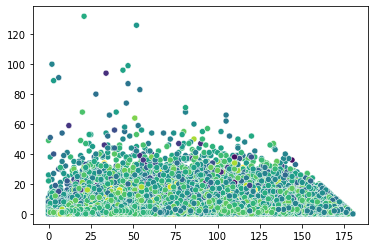

In [257]:
sns.scatterplot(x=list(ntimeleft), y=list(ntimes), c=list(nelo))

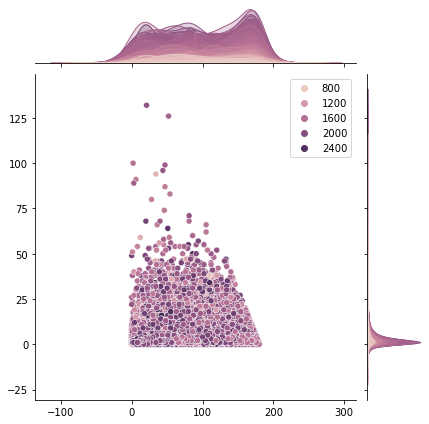

In [261]:
sns.jointplot(x=list(ntimeleft), y=list(ntimes), hue=list(nelo))

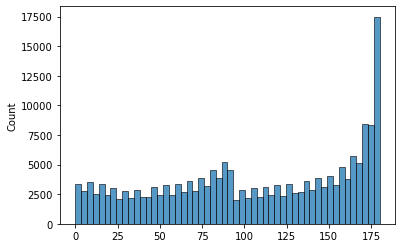

In [264]:
sns.histplot(list(ntimeleft))

In [268]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_kernels, v_planes=2):
        super(ResNet, self).__init__()
        self.in_planes = 12
        self.value_planes = v_planes

        self.conv1 = nn.Conv2d(self.in_planes, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, num_kernels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, num_kernels[1], num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, num_kernels[2], num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, num_kernels[3], num_blocks[3], stride=1)

        # value head
        self.finalLayerValue = nn.Sequential(
            nn.Conv2d(num_kernels[3], self.value_planes, kernel_size=1, stride=1, padding=0),  # 64, 1
            nn.BatchNorm2d(self.value_planes),
            nn.ReLU()
            )
        self.valueLinear = nn.Linear(64*self.value_planes*block.expansion, 1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.finalLayerValue(out)
        out = out.view(out.size(0), -1)
        out = self.valueLinear(out)
        return out

def ResNetSmall():
    return ResNet(BasicBlock, [1,1,1,2], [32,32,32,32], v_planes=2)

def ResNetRegular():
    return ResNet(BasicBlock, [3,3,3,3], [256,256,256,256], v_planes=16)

class TrainingDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = torch.from_numpy(y)

    def __getitem__(self, index):

        return torch.from_numpy(bitboards_to_array(self.X[index])).float(), self.y[index]

    def __len__(self):
        return len(self.X)

## Let's see what the volatility scores are like

In [279]:
import torch 

with h5py.File('test_positions.h5', 'r') as hf:
    X = hf["X"][:]
    y = hf["y"][:]
    
testloader = torch.utils.data.DataLoader(dataset=TrainingDataset(X, y), batch_size=64, shuffle=False)

device = 'cpu'

model = ResNetRegular()
model.load_state_dict(torch.load('vol_model_updated.pt', map_location=torch.device(device)))

# Define a criterion for calculating the MSE
criterion = nn.MSELoss()

# Set the model to evaluation mode
model.eval()

# Initialize variables to store total loss and total number of samples
total_loss = 0.0
total_samples = 0

losses = []

# Iterate over the test dataset
i = 0
for inputs, labels in testloader:
    # Move inputs and labels to the device (e.g., GPU) if available
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Perform forward pass
    with torch.no_grad():
        outputs = model(inputs)
    
    # Calculate the loss
    loss = criterion(outputs, labels)

    # Update total loss and total number of samples
    total_loss += loss.item() * inputs.size(0)
    total_samples += inputs.size(0)
    losses += list(outputs.flatten().detach().cpu().numpy())
    if i % 25 == 0:
        print(f"After {i+1} batches, {len(losses)} samples: {total_loss/total_samples}")
    i += 1

# Calculate the average MSE
mse = total_loss / total_samples

print("Mean Squared Error on Test Dataset:", mse)

/Users/gsychi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


After 1 batches, 64 samples: 0.004126541782170534
After 26 batches, 1664 samples: 0.006925160204096196
After 51 batches, 3264 samples: 0.006851481623016298
After 76 batches, 4864 samples: 0.0071175210522549034
After 101 batches, 6464 samples: 0.007258291515328064
After 126 batches, 8064 samples: 0.007254029524841508
After 151 batches, 9664 samples: 0.0073785725980997086
After 176 batches, 11264 samples: 0.008118359542674047
After 201 batches, 12864 samples: 0.007749638081741385
After 226 batches, 14464 samples: 0.007734240359313522
After 251 batches, 16064 samples: 0.0073865170377692526
After 276 batches, 17664 samples: 0.0076545180689182426
After 301 batches, 19264 samples: 0.007526241586716889
After 326 batches, 20864 samples: 0.007371178510582055
After 351 batches, 22464 samples: 0.007434416805970101
After 376 batches, 24064 samples: 0.007366359527564937
After 401 batches, 25664 samples: 0.007339489261410432
After 426 batches, 27264 samples: 0.007242688191244368
After 451 batches, 2

/Users/gsychi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


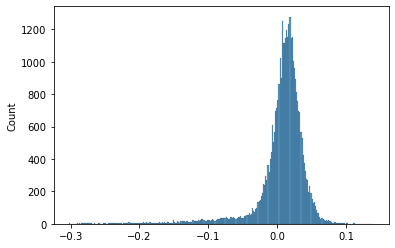

In [281]:
sns.histplot(losses)

In [312]:
with h5py.File('cheat_data.h5', 'r') as hf:
    npositions = hf['npositions'][:]
    cpositions = hf['cpositions'][:]
    ntimes = hf['ntimes'][:]
    ctimes = hf['ctimes'][:]
    ntimeleft = hf['ntimeleft'][:]
    ctimeleft = hf['ctimeleft'][:]
    nelo = hf['nelo'][:]
    celo = hf['celo'][:]

In [314]:
import pandas as pd

# Create a list of dictionaries, where each dictionary represents a row
data = []
for i in range(max(len(npositions), len(cpositions))):
    row = {
        'positions': None,
        'times': None,
        'timeleft': None,
        'elo': None,
        'target': None
    }
    
    if i < len(npositions):
        row['positions'] = npositions[i]
        row['times'] = ntimes[i]
        row['timeleft'] = ntimeleft[i]
        row['elo'] = nelo[i]
        row['target'] = 0
    
    if i < len(cpositions):
        row['positions'] = cpositions[i]
        row['times'] = ctimes[i]
        row['timeleft'] = ctimeleft[i]
        row['elo'] = celo[i]
        row['target'] = 1
    
    data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)

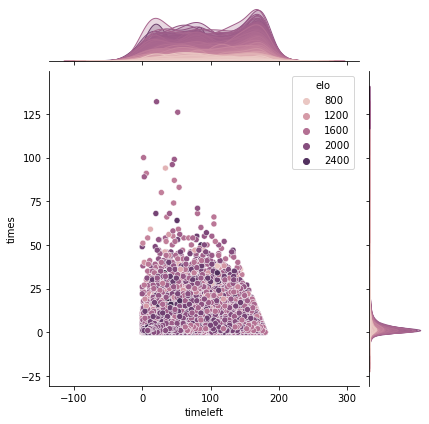

In [321]:
sns.jointplot(x=df['timeleft'], y=df['times'], hue=df['elo'])

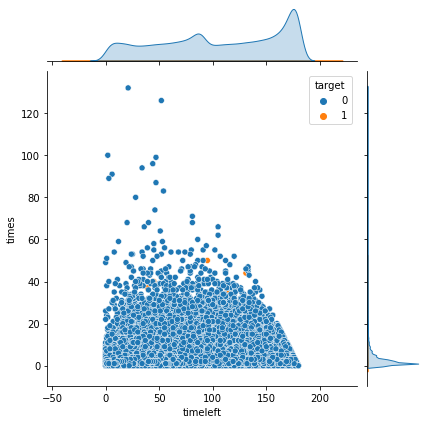

In [322]:
sns.jointplot(x=df['timeleft'], y=df['times'], hue=df['target'])

In [334]:
dataloader = torch.utils.data.DataLoader(dataset=TrainingDataset(df['positions'], np.array([0]*len(df['positions']))), batch_size=64, shuffle=False) 
vols = []
for inputs, labels in dataloader:
    vols += list(model(inputs).flatten().detach().cpu().numpy())
df['volatility_scores'] = vols

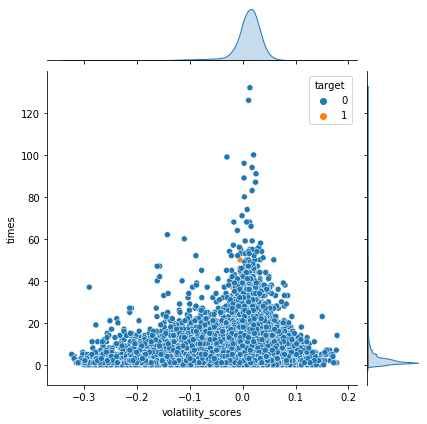

In [335]:
sns.jointplot(x=df['volatility_scores'], y=df['times'], hue=df['target'])

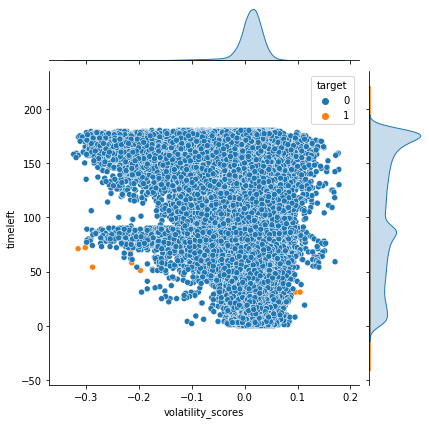

In [336]:
sns.jointplot(x=df['volatility_scores'], y=df['timeleft'], hue=df['target'])

In [339]:
df.to_csv('cheating_dataset.csv')